In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [5]:
df["target"] = df["POLYLINE"].apply(lambda x : np.float32(max((x.count("[") - 2) *15, 0)))

In [6]:
df['call_A'] = df["CALL_TYPE"].apply(lambda x : int(x == 'A'))
df['call_B'] = df["CALL_TYPE"].apply(lambda x : int(x == 'B'))
df['call_C'] = df["CALL_TYPE"].apply(lambda x : int(x == 'C'))

In [7]:
df = df.loc[df['MISSING_DATA'] == False]
df = df.loc[df['target'] > 0]


In [8]:
def one_hot(str):
    if str == 'A':
        return [1,0,0]
    elif str == 'B':
        return [0,1,0]
    elif str == 'C':
        return [0,0,1]
    else:
        return None

In [9]:
# df['CALL_TYPE'] = df['CALL_TYPE'].apply(lambda x: one_hot(x))
# df['DAY_TYPE'] = df['DAY_TYPE'].apply(lambda x: one_hot(x))
# df = df.loc[df['CALL_TYPE'] != None]
# df = df.loc[df['DAY_TYPE'] != None]

In [10]:
from datetime import datetime
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

In [11]:
train_id_mean = df['TAXI_ID'].mean()
train_id_std = df['TAXI_ID'].std()
df['TAXI_ID'] = (df['TAXI_ID'] - train_id_mean)/ train_id_std

In [12]:
taxi_ids = set()
for ind, r in df.iterrows():
    taxi_ids.add(r['TAXI_ID'])
taxi_id_to_mean = {}
for i in taxi_ids:
    taxi_id_to_mean[i] = df[df['TAXI_ID'] == i]['target'].mean()
taxi_id_to_mean

{-0.5612990694750604: 499.58502197265625,
 0.5055998999262465: 726.5753173828125,
 -0.5518155230803821: 707.8585205078125,
 1.0509038176202479: 695.443603515625,
 1.0461620444229087: 690.2947387695312,
 1.0651291372122653: 798.5908813476562,
 1.525081137354162: 719.8406982421875,
 0.47714926074221164: 640.8653564453125,
 1.496630498170127: 764.616455078125,
 1.0746126836069436: 779.3790893554688,
 1.0414202712255696: 875.1163330078125,
 2.6156889727421646: 717.3923950195312,
 -1.2583397294839143: 766.3195190429688,
 -1.485944842956193: 828.130859375,
 -0.05392933735977221: 791.2107543945312,
 0.6573366422410991: 819.96435546875,
 1.1172886423829957: 735.7216796875,
 -0.058671110557111356: 758.9268188476562,
 -0.6039750282511127: 713.2156982421875,
 1.0793544568042828: 698.7357177734375,
 1.5393064569461794: 777.439208984375,
 2.6109471995448255: 649.6943359375,
 -0.9264156056701743: 648.847412109375,
 -1.4812030697588539: 694.540771484375,
 2.995030828529296: 30.0,
 1.122030415580335: 

In [13]:
def apply_mean(taxi_id):
    return taxi_id_to_mean[taxi_id]

In [14]:
df['TAXI_ID_MEAN'] = df['TAXI_ID'].apply(apply_mean)
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,target,call_A,call_B,call_C,TAXI_ID_MEAN
0,1372636858620000589,C,NaN,NaN,1.136256,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330.0,0,0,1,694.473022
1,1372637303620000596,B,NaN,7.0,1.169448,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270.0,0,1,0,728.770874
2,1372636951620000320,C,NaN,NaN,-0.139281,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960.0,0,0,1,707.499146
3,1372636854620000520,C,NaN,NaN,0.809073,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630.0,0,0,1,808.640808
4,1372637091620000337,C,NaN,NaN,-0.058671,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420.0,0,0,1,758.926819


In [15]:
def normalize(col_name):
    df[col_name] = np.float32((df[col_name] - df[col_name].mean())/df[col_name].std())

In [16]:
def parse_num(str, index):
    comma_pos = str.find(',')
    if comma_pos == -1:
        return None
    if index == 0:
        return np.float32(str[2:comma_pos])
    else:
        return np.float32(str[comma_pos + 1:str.find(']')])

In [17]:
df['Init_longitude'] = df['POLYLINE'].apply(lambda x : parse_num(x,0))
df['Init_latitude'] = df['POLYLINE'].apply(lambda x : parse_num(x,1))
df = df.loc[df['Init_longitude'] != None]
df = df.loc[df['Init_latitude'] != None]
train_long_mean = df['Init_longitude'].mean()
train_lat_mean = df['Init_latitude'].mean()
train_long_std = df['Init_longitude'].std()
train_lat_std = df['Init_latitude'].std()
normalize('Init_longitude')
normalize('Init_latitude')

In [18]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,target,call_A,call_B,call_C,TAXI_ID_MEAN,Init_longitude,Init_latitude
0,1372636858620000589,C,NaN,NaN,1.136256,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330.0,0,0,1,694.473022,0.961090,0.961183
1,1372637303620000596,B,NaN,7.0,1.169448,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270.0,0,1,0,728.770874,0.786753,1.004535
2,1372636951620000320,C,NaN,NaN,-0.139281,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960.0,0,0,1,707.499146,1.007784,0.958705
3,1372636854620000520,C,NaN,NaN,0.809073,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630.0,0,0,1,808.640808,1.322562,0.985998
4,1372637091620000337,C,NaN,NaN,-0.058671,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420.0,0,0,1,758.926819,0.736210,1.053185


In [19]:
train_set = torch.reshape(torch.tensor(df['call_A'].values),(-1,1))
col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude', 'TAXI_ID_MEAN']
for col_name in col_list:
#     print(train_set.dtype)
    train_set = torch.cat((train_set,torch.reshape(torch.from_numpy(df[col_name].values),(-1,1))),1)

In [20]:
train_set = train_set.type('torch.FloatTensor')

In [21]:
target_set = torch.reshape(torch.tensor(df['target'].values),(-1,1))

In [22]:
train_set[0]

tensor([  0.0000,   0.0000,   1.0000,   1.1363,   0.9611,   0.9612, 694.4730])

In [23]:
train_set_linear = torch.reshape(torch.tensor(df['call_A'].values),(-1,1))
col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude']
for col_name in col_list:
#     print(train_set.dtype)
    train_set_linear = torch.cat((train_set_linear,torch.reshape(torch.from_numpy(df[col_name].values),(-1,1))),1)

In [24]:
train_set_linear = train_set_linear.type('torch.FloatTensor')

In [25]:
model = torch.nn.Sequential(
  torch.nn.Linear(6, 1),
).to(device)

# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model.parameters(), lr=lr)
# torch.optim.Adam

In [26]:
train_err = []
test_err = []
parameters = []
for i in range(10):
    model.train()

    y_pred = model(train_set_linear.to(device)) # Compute model outputs
    loss = loss_fn(y_pred, target_set.to(device)) # Compute MSE
    opt.zero_grad() # Must reset the gradients every step. Otherwise, gradients from previous iterations would cause interference!!!
    loss.backward() # Compute gradients of all parameters (our model) with respect to our computed loss value (a singular value)
    opt.step() # One gradient step

    train_err.append(loss.item())

    model.eval()
#     with torch.no_grad():
#     test_err.append(loss_fn(model(X_test), y_test).item())

In [27]:
model[0].weight

Parameter containing:
tensor([[14.4691, 27.4665, 21.7793,  0.7064, 60.8739, 63.2805]],
       device='cuda:0', requires_grad=True)

In [28]:
class MLP_Regressor(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim = 1):
        super(MLP_Regressor, self).__init__() #Refers to the fact that this is a subclass of nn.Module and is inheriting all methods
        
        out_dim = 1
        
        self.model = torch.nn.Sequential( #an ordered container of modules
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )   
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.out_dim)
        
                
        self.fc = torch.nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 4, self.hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, self.out_dim)
        )

    
    def forward(self, x):
        x = self.fc(x)
        x = x.squeeze(1)
        return x

In [29]:
targets_mlp = torch.reshape(torch.from_numpy(df['target'].values),(-1,1))

In [30]:
len(targets_mlp)

1674152

In [31]:
batch_size = 1024
lst_train = list(zip(train_set, targets_mlp))
len_train = len(lst_train)
print(len(lst_train))
print(lst_train[0])
trainloader = torch.utils.data.DataLoader(lst_train , batch_size=batch_size, shuffle=False, num_workers=2)

1674152
(tensor([  0.0000,   0.0000,   1.0000,   1.1363,   0.9611,   0.9612, 694.4730]), tensor([330.]))


In [32]:
mlp_model = MLP_Regressor(7, 14, 1).to(device)
lr_mlp = 5e-6
optimizer = torch.optim.Adam(mlp_model.parameters(), lr = lr_mlp)
criterion = nn.MSELoss()

In [33]:
def get_loss(X, y, model, criterion):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    return loss

In [34]:
losses = []

In [35]:
from tqdm import tqdm
epoch_loss = []
for epoch in tqdm(range(15)):

    running_loss = 0.0

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = get_loss(X, y, mlp_model, criterion)
        #RMSE
        loss = torch.sqrt(loss)
        losses.append(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().detach().numpy()

    epoch_loss.append(running_loss)
    print(f'Avg loss: {running_loss / batch_size}')
    print(f'Total loss: {running_loss}')
print('Finished Training')

  0%|          | 0/15 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936, 1])) that is different to the input size (torch.Size([936])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  7%|▋         | 1/15 [02:43<38:14, 163.90s/it]

Avg loss: 1563.1958535313606
Total loss: 1600712.5540161133


 13%|█▎        | 2/15 [05:19<34:30, 159.23s/it]

Avg loss: 1537.8318763971329
Total loss: 1574739.841430664


 20%|██        | 3/15 [08:04<32:18, 161.57s/it]

Avg loss: 1512.803726553917
Total loss: 1549111.015991211


 27%|██▋       | 4/15 [10:43<29:26, 160.62s/it]

Avg loss: 1483.4898818731308
Total loss: 1519093.639038086


 33%|███▎      | 5/15 [13:20<26:33, 159.33s/it]

Avg loss: 1446.98645311594
Total loss: 1481714.1279907227


 40%|████      | 6/15 [15:56<23:43, 158.13s/it]

Avg loss: 1402.7916345596313
Total loss: 1436458.6337890625


 47%|████▋     | 7/15 [18:37<21:13, 159.14s/it]

Avg loss: 1350.7415139973164
Total loss: 1383159.310333252


 53%|█████▎    | 8/15 [21:13<18:27, 158.23s/it]

Avg loss: 1291.9982336461544
Total loss: 1323006.191253662


 60%|██████    | 9/15 [23:50<15:47, 157.92s/it]

Avg loss: 1229.5001321732998
Total loss: 1259008.135345459


 67%|██████▋   | 10/15 [26:25<13:04, 156.95s/it]

Avg loss: 1168.2712161242962
Total loss: 1196309.7253112793


 73%|███████▎  | 11/15 [29:04<10:29, 157.40s/it]

Avg loss: 1115.8087753355503
Total loss: 1142588.1859436035


 80%|████████  | 12/15 [31:40<07:51, 157.15s/it]

Avg loss: 1080.6177864670753
Total loss: 1106552.6133422852


 87%|████████▋ | 13/15 [34:14<05:12, 156.04s/it]

Avg loss: 1065.7884622514248
Total loss: 1091367.385345459


 93%|█████████▎| 14/15 [36:53<02:36, 156.92s/it]

Avg loss: 1063.1365400850773
Total loss: 1088651.8170471191


100%|██████████| 15/15 [39:30<00:00, 158.06s/it]

Avg loss: 1063.0265218019485
Total loss: 1088539.1583251953
Finished Training


In [36]:
stands = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
stand_dict = {}
stands.head()
for r, s in stands.iterrows():
    stand_dict[s['ID']] = (np.float32(s['Longitude']), np.float32(s['Latitude']))

In [37]:
df_test = pd.read_csv("test_public.csv")
df_test['call_A'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'A'))
df_test['call_B'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'B'))
df_test['call_C'] = df_test["CALL_TYPE"].apply(lambda x : int(x == 'C'))
df_test['TAXI_ID'] = (df_test['TAXI_ID'] - train_id_mean)/train_id_std

df_test['Init_longitude'] = train_long_mean
df_test['Init_latitude'] = train_lat_mean

In [38]:
def apply_mean_test(taxi_id):
    if taxi_id in taxi_id_to_mean:
        return taxi_id_to_mean[taxi_id]
    else:
        return train_id_mean

In [39]:
df_test['TAXI_ID_MEAN'] = df_test['TAXI_ID'].apply(apply_mean_test)

In [40]:
for ind, d in df_test.iterrows():
    if not pd.isna(d['ORIGIN_STAND']):
        #print(d['ORIGIN_STAND'])
        d['Init_longitude'] = stand_dict[d['ORIGIN_STAND']][0]
        d['Init_latitude'] = stand_dict[d['ORIGIN_STAND']][1]
    d['Init_longitude'] = (d['Init_longitude'] - train_long_mean) / train_long_std
    d['Init_latitude'] = (d['Init_latitude'] - train_lat_mean) / train_lat_std

#    df[col_name] = np.float32((df[col_name] - df[col_name].mean())/df[col_name].std())
test_set = torch.reshape(torch.tensor(df_test['call_A'].values),(-1,1))
col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude', 'TAXI_ID_MEAN']
#col_list = ['call_B', 'call_C','TAXI_ID', 'Init_longitude', 'Init_latitude']
for col_name in col_list:
#     print(train_set.dtype)
    test_set = torch.cat((test_set,torch.reshape(torch.from_numpy(df_test[col_name].values),(-1,1))),1)
test_set = test_set.type('torch.FloatTensor')

In [41]:
test_set = test_set
preds = mlp_model(test_set.to(device))
#preds = model(test_set.to(device))


In [42]:
len(test_set)

320

In [43]:
output_csv = pd.read_csv("sampleSubmission.csv")
output_csv['TRAVEL_TIME'] = preds.cpu().detach().numpy()
#df_test["TRAVEL_TIME"] = 716.43
output_csv.tail()
output_csv.to_csv("my_pred.csv", index=None)


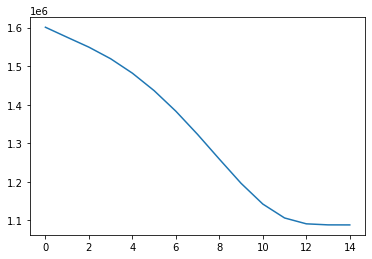

In [44]:
import matplotlib.pyplot as plt
#visualizing
#lst = [(1,2), (3,4)]
#plt.plot(lst)

losses_list = []
for l in losses:
    losses_list.append(l.item())
plt.plot(epoch_loss)

In [49]:
#targets_mlp
len(train_set)
pred = mlp_model(train_set.to(device))

In [56]:
diffs = []
for i in range(len(pred)):
    diffs.append( (abs(pred.to(device)[i].item() - targets_mlp.to(device)[i].item()), i))
diffs[:5]

[(331.59295654296875, 0),
 (424.09765625, 1),
 (285.47247314453125, 2),
 (140.4166259765625, 3),
 (303.2864990234375, 4)]

In [62]:
top_10 = sorted(diffs, reverse = True)

In [66]:
top_10_ind = top_10[:10]
print(top_10_ind)

[(57337.78405761719, 1070725), (57206.28173828125, 1460582), (56754.776611328125, 569219), (53110.01611328125, 220956), (50722.37060546875, 144765), (45424.43444824219, 379218), (43239.73107910156, 179907), (39709.153076171875, 1173934), (39041.55499267578, 833442), (37342.55322265625, 983660)]


In [67]:
top_10_ind = [y for x, y in top_10_ind]
top_10_tracks = []
for i in top_10_ind:
    row = df.iloc[i]
    top_10_tracks.append(row['POLYLINE'])

In [104]:
top_10_tracks[9]

'[[-8.672364,41.154831],[-8.670393,41.155974],[-8.667684,41.157054],[-8.664921,41.158143],[-8.661717,41.159403],[-8.658675,41.1606],[-8.656344,41.161743],[-8.653896,41.162049],[-8.652069,41.161743],[-8.651628,41.161671],[-8.651637,41.16168],[-8.651619,41.16168],[-8.651097,41.161878],[-8.650872,41.162814],[-8.650395,41.164461],[-8.650008,41.165802],[-8.649927,41.165982],[-8.649819,41.166315],[-8.649693,41.167251],[-8.649792,41.167152],[-8.649882,41.1669],[-8.649927,41.1669],[-8.649945,41.1669],[-8.649945,41.166909],[-8.649954,41.166891],[-8.649954,41.1669],[-8.649963,41.166918],[-8.649963,41.166936],[-8.649972,41.166936],[-8.649963,41.166945],[-8.649963,41.166945],[-8.649936,41.166954],[-8.649954,41.166972],[-8.649972,41.166981],[-8.64999,41.16699],[-8.649972,41.166954],[-8.649963,41.1669],[-8.649963,41.166882],[-8.649963,41.166819],[-8.649963,41.16681],[-8.649945,41.166819],[-8.649945,41.166846],[-8.649936,41.166828],[-8.649927,41.16681],[-8.649945,41.166801],[-8.649954,41.16681],[-8.6

In [105]:
coords = []
first = [[-8.583435,41.158665],[-8.582958,41.158899],[-8.582553,41.159817],[-8.581986,41.161293],[-8.582607,41.162805],[-8.582787,41.163345],[-8.582373,41.163435],[-8.581266,41.163336],[-8.581599,41.164542],[-8.582859,41.165955],[-8.585505,41.166783],[-8.588394,41.167962],[-8.591184,41.169627],[-8.593974,41.171481],[-8.594361,41.173983],[-8.593335,41.177133],[-8.592957,41.180742],[-8.593641,41.184279],[-8.594712,41.187654],[-8.593434,41.190876],[-8.591265,41.194026],[-8.58834,41.197374],[-8.585631,41.200749],[-8.583264,41.204547],[-8.581455,41.20884],[-8.578089,41.212512],[-8.575497,41.2164],[-8.574624,41.220765],[-8.572383,41.224797],[-8.570574,41.228811],[-8.567235,41.23233],[-8.564706,41.236461],[-8.564139,41.240997],[-8.565417,41.244894],[-8.567136,41.247855],[-8.568324,41.251626],[-8.567937,41.25582],[-8.565813,41.260122],[-8.563419,41.264397],[-8.561052,41.268564],[-8.559675,41.272902],[-8.560881,41.277186],[-8.560737,41.281524],[-8.558082,41.285376],[-8.553069,41.288346],[-8.54775,41.290893],[-8.542467,41.293503],[-8.538984,41.296815],[-8.537931,41.301063],[-8.534457,41.304177],[-8.529588,41.305626],[-8.52669,41.309082],[-8.523603,41.312493],[-8.518833,41.314311],[-8.515944,41.317911],[-8.51697,41.322276],[-8.5176,41.326659],[-8.514954,41.330781],[-8.510598,41.333733],[-8.508168,41.337585],[-8.506512,41.341887],[-8.505477,41.345982],[-8.506872,41.349951],[-8.506449,41.353803],[-8.503479,41.356872],[-8.500428,41.359905],[-8.500014,41.363685],[-8.501967,41.367663],[-8.50329,41.371623],[-8.502282,41.373252],[-8.502003,41.374341],[-8.503029,41.375889],[-8.502174,41.378166],[-8.502822,41.381082],[-8.503083,41.383215],[-8.50572,41.383125],[-8.509131,41.384052],[-8.513172,41.385195],[-8.516934,41.385888],[-8.517951,41.387832],[-8.518275,41.389947],[-8.516646,41.391414],[-8.516169,41.389461],[-8.517114,41.389749],[-8.514468,41.389551],[-8.51085,41.389506],[-8.506962,41.390721],[-8.503983,41.39325],[-8.502345,41.39631],[-8.501499,41.399622],[-8.501283,41.402601],[-8.50032,41.405454],[-8.500662,41.408748],[-8.501769,41.411871],[-8.504586,41.41449],[-8.50734,41.416839],[-8.509923,41.419782],[-8.513109,41.422275],[-8.516088,41.422824],[-8.516151,41.424039],[-8.515674,41.426433],[-8.513631,41.428449],[-8.512425,41.431239],[-8.510283,41.433084],[-8.506458,41.433426],[-8.502786,41.435109],[-8.499717,41.437386],[-8.496639,41.439438],[-8.496198,41.441373],[-8.495622,41.442363],[-8.494659,41.444595],[-8.493732,41.447169],[-8.492022,41.449716],[-8.492121,41.452227],[-8.493525,41.454711],[-8.494668,41.457312],[-8.494272,41.459895],[-8.493399,41.462235],[-8.492346,41.464098],[-8.490501,41.465421],[-8.488998,41.46696],[-8.489619,41.468553],[-8.488584,41.470605],[-8.486613,41.472792],[-8.484597,41.475006],[-8.482995,41.477481],[-8.481375,41.480091],[-8.479809,41.482593],[-8.477676,41.484681],[-8.475219,41.486535],[-8.472969,41.488236],[-8.472474,41.488488],[-8.472483,41.488479],[-8.472492,41.48847],[-8.472492,41.48847],[-8.472492,41.48847],[-8.472492,41.48847],[-8.472492,41.488488],[-8.472501,41.488497],[-8.47251,41.488479],[-8.47251,41.48847],[-8.47251,41.488479],[-8.472501,41.488497],[-8.472501,41.488497],[-8.47251,41.488497],[-8.472519,41.488497],[-8.472519,41.488488],[-8.472519,41.488497],[-8.472528,41.488515],[-8.472537,41.488524],[-8.472528,41.488515],[-8.472537,41.488506],[-8.472537,41.488506],[-8.472537,41.488515],[-8.472546,41.488524],[-8.472546,41.488524],[-8.472537,41.488533],[-8.472537,41.488524],[-8.472528,41.488515],[-8.472528,41.488497],[-8.472528,41.488506],[-8.47251,41.488506],[-8.472501,41.488506],[-8.472501,41.488497],[-8.47251,41.488488],[-8.47251,41.488479],[-8.472501,41.488479],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472501,41.488479],[-8.472501,41.488479],[-8.472501,41.488479],[-8.472501,41.488479],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472501,41.48847],[-8.47251,41.48847],[-8.472501,41.488461],[-8.472492,41.488452],[-8.472492,41.488452],[-8.472501,41.488461],[-8.47251,41.48847],[-8.472528,41.488479],[-8.472519,41.488479],[-8.472501,41.488461],[-8.472492,41.488461],[-8.472501,41.488461],[-8.472501,41.48847],[-8.472501,41.488461],[-8.472501,41.488452],[-8.472501,41.48847],[-8.472501,41.488461],[-8.472492,41.488443],[-8.472483,41.488443],[-8.472492,41.488443],[-8.472483,41.488452],[-8.472474,41.488443],[-8.472474,41.488443],[-8.472483,41.488443],[-8.472492,41.488434],[-8.472483,41.488434],[-8.472474,41.488443],[-8.472465,41.488443],[-8.472465,41.488479],[-8.472465,41.488515],[-8.472474,41.488515],[-8.472474,41.488506],[-8.472474,41.488488],[-8.472474,41.488488],[-8.472474,41.488506],[-8.472465,41.488551],[-8.472474,41.488551],[-8.472474,41.48856],[-8.472474,41.488542],[-8.472474,41.488524],[-8.472474,41.488497],[-8.472465,41.488461],[-8.472474,41.488443],[-8.472483,41.488443],[-8.472483,41.488461],[-8.472483,41.48847],[-8.472483,41.488488],[-8.472483,41.488497],[-8.472483,41.488488],[-8.472483,41.488506],[-8.472492,41.488497],[-8.472501,41.488497],[-8.472501,41.488488],[-8.472501,41.488488],[-8.472501,41.488488],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472492,41.488461],[-8.472501,41.488434],[-8.472492,41.488443],[-8.472501,41.488452],[-8.47251,41.488461],[-8.472492,41.488452],[-8.472483,41.48847],[-8.472492,41.48847],[-8.472501,41.48847],[-8.47251,41.488452],[-8.472501,41.48847],[-8.472501,41.48847],[-8.47251,41.48847],[-8.472501,41.488461],[-8.47251,41.488452],[-8.472501,41.488461],[-8.472492,41.48847],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472501,41.48847],[-8.472492,41.488461],[-8.472492,41.488452],[-8.47251,41.48847],[-8.472501,41.488488],[-8.472492,41.488479],[-8.472483,41.488488],[-8.472492,41.488488],[-8.47251,41.488488],[-8.472492,41.488524],[-8.472474,41.488551],[-8.472465,41.488587],[-8.472447,41.488623],[-8.472447,41.488623],[-8.472456,41.488605],[-8.472447,41.488623],[-8.472456,41.488578],[-8.472474,41.488542],[-8.472474,41.488524],[-8.472465,41.488524],[-8.472465,41.488542],[-8.472474,41.48856],[-8.472483,41.488587],[-8.472456,41.488587],[-8.472447,41.488578],[-8.472447,41.488614],[-8.472438,41.488587],[-8.472438,41.488569],[-8.472447,41.488542],[-8.472447,41.488515],[-8.472456,41.488497],[-8.472465,41.48847],[-8.472456,41.48847],[-8.472465,41.488497],[-8.472474,41.488506],[-8.472474,41.488515],[-8.472474,41.488515],[-8.472474,41.488506],[-8.472474,41.488506],[-8.472483,41.488506],[-8.472483,41.488506],[-8.472483,41.488515],[-8.472492,41.488515],[-8.472492,41.488488],[-8.472519,41.48847],[-8.47251,41.488497],[-8.47251,41.488506],[-8.47251,41.488524],[-8.47251,41.488551],[-8.472501,41.488551],[-8.472501,41.488542],[-8.472501,41.488542],[-8.472501,41.488542],[-8.472492,41.488533],[-8.472492,41.488533],[-8.472501,41.488524],[-8.472501,41.488524],[-8.472483,41.488542],[-8.472492,41.488524],[-8.472483,41.488542],[-8.472492,41.488551],[-8.47251,41.488569],[-8.472537,41.488533],[-8.472519,41.488497],[-8.47251,41.488452],[-8.47251,41.488488],[-8.47251,41.488533],[-8.47251,41.488524],[-8.472528,41.488443],[-8.472537,41.488434],[-8.472546,41.488425],[-8.472546,41.488434],[-8.472528,41.488407],[-8.472528,41.488443],[-8.472537,41.488452],[-8.472528,41.488488],[-8.472519,41.488533],[-8.472519,41.488542],[-8.472528,41.488569],[-8.472519,41.488533],[-8.47251,41.488506],[-8.472519,41.488497],[-8.472501,41.488551],[-8.472501,41.488596],[-8.472501,41.488614],[-8.472501,41.48865],[-8.472501,41.488695],[-8.472492,41.488758],[-8.472483,41.488812],[-8.472483,41.488812],[-8.472483,41.488821],[-8.472474,41.488857],[-8.472483,41.488839],[-8.472474,41.488821],[-8.472483,41.488767],[-8.472483,41.488803],[-8.472483,41.488776],[-8.472483,41.488776],[-8.472492,41.488758],[-8.472501,41.48874],[-8.472501,41.488731],[-8.472501,41.488704],[-8.472501,41.48865],[-8.47251,41.488614],[-8.47251,41.488605],[-8.47251,41.488623],[-8.47251,41.488677],[-8.47251,41.488641],[-8.47251,41.48865],[-8.472501,41.488677],[-8.472501,41.488659],[-8.472492,41.488641],[-8.472492,41.48865],[-8.472492,41.48865],[-8.472483,41.488614],[-8.472483,41.488614],[-8.472474,41.488623],[-8.472474,41.488623],[-8.472474,41.488614],[-8.472474,41.488605],[-8.472483,41.488596],[-8.472483,41.488596],[-8.472483,41.488569],[-8.472492,41.48856],[-8.472519,41.48856],[-8.47251,41.48856],[-8.472519,41.488524],[-8.472528,41.488506],[-8.472528,41.488515],[-8.472528,41.488515],[-8.472519,41.488515],[-8.472519,41.488506],[-8.472519,41.488515],[-8.472519,41.488497],[-8.472519,41.488515],[-8.472519,41.488515],[-8.472537,41.488524],[-8.472528,41.488533],[-8.472519,41.488551],[-8.472546,41.488569],[-8.472546,41.48856],[-8.472555,41.48856],[-8.472537,41.488533],[-8.472528,41.488542],[-8.472528,41.488533],[-8.472519,41.488524],[-8.472528,41.488506],[-8.472519,41.488488],[-8.472501,41.488488],[-8.472492,41.488488],[-8.47251,41.488488],[-8.472519,41.488488],[-8.47251,41.488497],[-8.47251,41.488497],[-8.47251,41.488497],[-8.47251,41.488524],[-8.472519,41.488524],[-8.472519,41.488533],[-8.472519,41.488524],[-8.472537,41.488524],[-8.472555,41.488533],[-8.472546,41.488533],[-8.472528,41.488515],[-8.472519,41.488506],[-8.472483,41.488515],[-8.472483,41.488731],[-8.472528,41.488686],[-8.473086,41.488236],[-8.474625,41.487057],[-8.476497,41.485617],[-8.478549,41.483997],[-8.48025,41.482008],[-8.481681,41.479695],[-8.483121,41.477355],[-8.484165,41.475663],[-8.485587,41.473971],[-8.487072,41.472342],[-8.488665,41.47056],[-8.489601,41.468904],[-8.48925,41.467536],[-8.489799,41.46588],[-8.49168,41.464674],[-8.492985,41.463207],[-8.493651,41.461497],[-8.494173,41.460174],[-8.494704,41.458752],[-8.494749,41.457213],[-8.49402,41.455566],[-8.493075,41.453775],[-8.492535,41.452641],[-8.492535,41.452677],[-8.492562,41.452677],[-8.492571,41.452677],[-8.492589,41.452677],[-8.492571,41.452659],[-8.492562,41.452668],[-8.49258,41.452677],[-8.492589,41.452668],[-8.49258,41.452659],[-8.492562,41.452659],[-8.492553,41.452659],[-8.492535,41.45265],[-8.492517,41.452659],[-8.492508,41.452659],[-8.492526,41.452668],[-8.492544,41.452668],[-8.492562,41.452677],[-8.492562,41.452686],[-8.492616,41.452668],[-8.492598,41.45265],[-8.492562,41.45265],[-8.492562,41.45265],[-8.492562,41.45265],[-8.492571,41.45265],[-8.492598,41.452659],[-8.492598,41.452668],[-8.492589,41.452668],[-8.49258,41.452668],[-8.492562,41.452668],[-8.492553,41.452668],[-8.492121,41.452101],[-8.491815,41.450355],[-8.492652,41.448591],[-8.493957,41.446881],[-8.494722,41.444541],[-8.49564,41.442372],[-8.496351,41.440509],[-8.497413,41.438862],[-8.499807,41.437377],[-8.502201,41.435487],[-8.504955,41.43411],[-8.507934,41.433201],[-8.511165,41.432895],[-8.512578,41.430924],[-8.513613,41.428512],[-8.515044,41.427198],[-8.51589,41.425398],[-8.516277,41.423445],[-8.516511,41.422491],[-8.514369,41.422365],[-8.511489,41.421348],[-8.509347,41.4189],[-8.507061,41.41638],[-8.504244,41.414049],[-8.501679,41.411439],[-8.500752,41.408442],[-8.5005,41.405031],[-8.501688,41.401611],[-8.501796,41.398119],[-8.503272,41.394834],[-8.50545,41.391837],[-8.509365,41.389875],[-8.514306,41.389668],[-8.516142,41.391216],[-8.518383,41.390451],[-8.518248,41.387868],[-8.517636,41.385195],[-8.515584,41.385249],[-8.51211,41.384772],[-8.508132,41.38362],[-8.504379,41.382432],[-8.502651,41.380011],[-8.502552,41.37678],[-8.503335,41.374323],[-8.503479,41.37156],[-8.502714,41.368536],[-8.50104,41.36544],[-8.50005,41.362164],[-8.501454,41.358699],[-8.504694,41.356161],[-8.506944,41.35311],[-8.50707,41.349645],[-8.505765,41.346252],[-8.506269,41.342823],[-8.507808,41.339268],[-8.50914,41.335767],[-8.511939,41.332878],[-8.515467,41.330493],[-8.517672,41.327028],[-8.517636,41.323122],[-8.516124,41.319441],[-8.517546,41.315544],[-8.521992,41.313249],[-8.526051,41.310837],[-8.52804,41.307219],[-8.532018,41.304789],[-8.536725,41.303205],[-8.538507,41.299659],[-8.53992,41.295906],[-8.543664,41.293044],[-8.548533,41.290668],[-8.552871,41.288544],[-8.557209,41.286249],[-8.56026,41.282991],[-8.561385,41.278896],[-8.560251,41.274522],[-8.560503,41.269959],[-8.562861,41.265666],[-8.565165,41.261679],[-8.567298,41.257854],[-8.568522,41.253957],[-8.568135,41.249754],[-8.56629,41.246046],[-8.56485,41.243247],[-8.564265,41.239449],[-8.565273,41.235408],[-8.567856,41.231781],[-8.571051,41.22828],[-8.572779,41.224122],[-8.574984,41.220234],[-8.575866,41.215869],[-8.57853,41.212161],[-8.581833,41.208471],[-8.583561,41.204286],[-8.585748,41.200758],[-8.588484,41.197464],[-8.591328,41.194134],[-8.593479,41.190921],[-8.594901,41.187447],[-8.593605,41.183694],[-8.5932,41.179563],[-8.593812,41.17554],[-8.595261,41.172201],[-8.596638,41.171049],[-8.595477,41.171742],[-8.592642,41.170356],[-8.589609,41.168448],[-8.586504,41.166738],[-8.583507,41.166135],[-8.582121,41.164254],[-8.581104,41.163849],[-8.582427,41.16375],[-8.585154,41.161104],[-8.583642,41.160312],[-8.58249,41.159997],[-8.582832,41.159106],[-8.583282,41.158791],[-8.583327,41.158737],[-8.583282,41.158692],[-8.583264,41.158683],[-8.583273,41.158701],[-8.583291,41.158719],[-8.583309,41.158737],[-8.583255,41.158737],[-8.583228,41.158728],[-8.58321,41.158701],[-8.583246,41.158701],[-8.583309,41.15871],[-8.583327,41.158737],[-8.583327,41.158755],[-8.583345,41.158764],[-8.583336,41.158755],[-8.583345,41.158755],[-8.583354,41.158755],[-8.583327,41.158755],[-8.583336,41.158764],[-8.583381,41.158764],[-8.583372,41.158773],[-8.583372,41.158782],[-8.583363,41.158773],[-8.583363,41.158773],[-8.583363,41.158773],[-8.583354,41.158764],[-8.583345,41.158755],[-8.583345,41.158755],[-8.583615,41.158611],[-8.584812,41.158071],[-8.586468,41.157612],[-8.588214,41.157342],[-8.589591,41.15709],[-8.590905,41.156631],[-8.591103,41.156379],[-8.591085,41.156397],[-8.591076,41.156397],[-8.591283,41.156226],[-8.591562,41.156046],[-8.591337,41.155569],[-8.589105,41.155569],[-8.585937,41.155569],[-8.584776,41.156163],[-8.585244,41.157081],[-8.585226,41.157999],[-8.586855,41.157666],[-8.587134,41.157612],[-8.589033,41.157225],[-8.589753,41.157036],[-8.590518,41.156784],[-8.590563,41.156757],[-8.591139,41.156271],[-8.59149,41.155605],[-8.588799,41.155569],[-8.584875,41.155632],[-8.585118,41.156604],[-8.584893,41.15799],[-8.58303,41.158872],[-8.582382,41.160285],[-8.582067,41.162337],[-8.582715,41.16339],[-8.581059,41.16348],[-8.581932,41.164848],[-8.58411,41.166639],[-8.587791,41.167638],[-8.591175,41.169627],[-8.594478,41.171949],[-8.59401,41.174955],[-8.593173,41.178951],[-8.593353,41.183352],[-8.594667,41.187528],[-8.593128,41.191182],[-8.590599,41.194746],[-8.587692,41.198454],[-8.58447,41.201937],[-8.582724,41.206401],[-8.579727,41.210775],[-8.5761,41.214969],[-8.574786,41.219982],[-8.572518,41.224212],[-8.570565,41.22873],[-8.567127,41.232339],[-8.564715,41.23593],[-8.562213,41.238441],[-8.559711,41.240619],[-8.55495,41.240133],[-8.54964,41.239224],[-8.544618,41.237568],[-8.541324,41.234841],[-8.540361,41.234139],[-8.539389,41.235003],[-8.537499,41.235678],[-8.536482,41.236209],[-8.534358,41.237271],[-8.531784,41.238558],[-8.528805,41.240043],[-8.528571,41.24115],[-8.529417,41.242329],[-8.530605,41.241951],[-8.530362,41.241654],[-8.5302,41.2416],[-8.530074,41.241546],[-8.530056,41.241528],[-8.530029,41.241546],[-8.530047,41.241564],[-8.529876,41.241501],[-8.52984,41.241465],[-8.52984,41.241465],[-8.52984,41.241474],[-8.529858,41.241474],[-8.529867,41.241483],[-8.529867,41.241474],[-8.529858,41.241474],[-8.529867,41.241465],[-8.529876,41.241474],[-8.529867,41.241465],[-8.529849,41.241456],[-8.52984,41.241447],[-8.529831,41.241447],[-8.529831,41.241447],[-8.529813,41.241447],[-8.529777,41.241447],[-8.529183,41.241564],[-8.528337,41.240529],[-8.529336,41.2398],[-8.531415,41.238774],[-8.532972,41.238009],[-8.533026,41.237982],[-8.533458,41.237766],[-8.535402,41.236803],[-8.537166,41.235966],[-8.539578,41.235048],[-8.542098,41.235885],[-8.54514,41.238081],[-8.54946,41.239404],[-8.554203,41.240178],[-8.558685,41.240898],[-8.561097,41.241969],[-8.561682,41.239692],[-8.563212,41.237442],[-8.565867,41.237181],[-8.565606,41.235192],[-8.567388,41.232501],[-8.570196,41.229567],[-8.572275,41.225922],[-8.574183,41.221944],[-8.575479,41.218047],[-8.576946,41.21406],[-8.579997,41.210721],[-8.582652,41.207319],[-8.583849,41.203611],[-8.586045,41.20056],[-8.58852,41.1975],[-8.591202,41.194287],[-8.593362,41.191146],[-8.595036,41.188113],[-8.594055,41.184693],[-8.59365,41.181867],[-8.594811,41.181642],[-8.596404,41.182128],[-8.596512,41.182173],[-8.596503,41.182182],[-8.596512,41.182173],[-8.59653,41.182164],[-8.596746,41.182218],[-8.596962,41.183109],[-8.596926,41.184243],[-8.59689,41.185359],[-8.597034,41.186142],[-8.597943,41.186295],[-8.597889,41.186736],[-8.59788,41.186754],[-8.597871,41.186754],[-8.597916,41.186844],[-8.597952,41.186529],[-8.597601,41.186079],[-8.596863,41.186034],[-8.596926,41.185143],[-8.597799,41.184972],[-8.598672,41.184396],[-8.598942,41.183829],[-8.599194,41.183181],[-8.599302,41.183046],[-8.59932,41.183001],[-8.600688,41.183235],[-8.602776,41.183712],[-8.602983,41.183766],[-8.602371,41.183424],[-8.59995,41.182731],[-8.599806,41.182686],[-8.599815,41.182695],[-8.599824,41.182695],[-8.599788,41.182686],[-8.599797,41.182677],[-8.599806,41.182686],[-8.599815,41.182686],[-8.599824,41.182686],[-8.599806,41.182677],[-8.599797,41.182668],[-8.599779,41.182668],[-8.59977,41.182659],[-8.599761,41.182668],[-8.599797,41.182686],[-8.599842,41.182695],[-8.599842,41.182686],[-8.599815,41.182695],[-8.599788,41.182686],[-8.599788,41.182668],[-8.599806,41.182668],[-8.599824,41.182686],[-8.599824,41.182695],[-8.599824,41.182686],[-8.599797,41.182668],[-8.599797,41.182668],[-8.599788,41.182677],[-8.599815,41.182668],[-8.599815,41.182668],[-8.599815,41.182659],[-8.599806,41.182677],[-8.59977,41.182668],[-8.598249,41.182281],[-8.597529,41.181462],[-8.598564,41.179365],[-8.599572,41.177385],[-8.600085,41.175198],[-8.59905,41.173542],[-8.598276,41.172201],[-8.597403,41.170419],[-8.597322,41.169276],[-8.597808,41.167908],[-8.598186,41.167062],[-8.597421,41.166576],[-8.598159,41.165883],[-8.598636,41.165487],[-8.597394,41.16528],[-8.59527,41.165019],[-8.593065,41.164695],[-8.590923,41.164407],[-8.589879,41.164002],[-8.589897,41.164011],[-8.588538,41.163606],[-8.586162,41.162832],[-8.585514,41.161644],[-8.583741,41.160294],[-8.582598,41.159682],[-8.583129,41.158827],[-8.585199,41.157927],[-8.587602,41.157432],[-8.589024,41.15727],[-8.590347,41.156874],[-8.590617,41.156748],[-8.590617,41.156739],[-8.590617,41.156739],[-8.590617,41.156739],[-8.590608,41.156739],[-8.590599,41.156757],[-8.590599,41.156757],[-8.590608,41.156757],[-8.590608,41.156748],[-8.590617,41.156748],[-8.590617,41.156739],[-8.590599,41.156739],[-8.590608,41.156721],[-8.590608,41.156703],[-8.590608,41.156694],[-8.590617,41.156676],[-8.590626,41.156685],[-8.590626,41.156694],[-8.590626,41.156703],[-8.590644,41.156712],[-8.590644,41.156712],[-8.590644,41.156712],[-8.590644,41.156712],[-8.590653,41.156703],[-8.590635,41.156703],[-8.590617,41.156712],[-8.590617,41.156721],[-8.590617,41.156721],[-8.590608,41.156739],[-8.590608,41.156748],[-8.590608,41.156757],[-8.590608,41.156766],[-8.590626,41.156775],[-8.590626,41.156775],[-8.590617,41.156775],[-8.590617,41.156775],[-8.590617,41.156775],[-8.590617,41.156775],[-8.590617,41.156775],[-8.590626,41.156775],[-8.590635,41.156766],[-8.590635,41.156766],[-8.590635,41.156757],[-8.590635,41.156748],[-8.590626,41.156748],[-8.590626,41.156748],[-8.590626,41.156748],[-8.590626,41.156748],[-8.590626,41.156748],[-8.590635,41.156739],[-8.590635,41.15673],[-8.590635,41.15673],[-8.590626,41.15673],[-8.590626,41.15673],[-8.590617,41.15673],[-8.590617,41.15673],[-8.590626,41.15673],[-8.590626,41.15673],[-8.590626,41.15673],[-8.590617,41.156721],[-8.590608,41.15673],[-8.590608,41.15673],[-8.590599,41.15673],[-8.590608,41.156739],[-8.590608,41.156739],[-8.590617,41.156748],[-8.590617,41.156748],[-8.590617,41.156748],[-8.590617,41.156757],[-8.590608,41.156748],[-8.590608,41.156748],[-8.590617,41.156748],[-8.590617,41.156757],[-8.590617,41.156757],[-8.590608,41.156757],[-8.590608,41.156766],[-8.590599,41.156757],[-8.590599,41.156757],[-8.59059,41.156748],[-8.590581,41.156748],[-8.590581,41.156748],[-8.590581,41.156757],[-8.590581,41.156757],[-8.590581,41.156757],[-8.590572,41.156757],[-8.590572,41.156748],[-8.590572,41.156748],[-8.590572,41.156748],[-8.590581,41.156748],[-8.59059,41.156748],[-8.59059,41.156748],[-8.59059,41.156748],[-8.59059,41.156748],[-8.590581,41.156739],[-8.590572,41.156739],[-8.590572,41.156739],[-8.590572,41.156739],[-8.590572,41.156739],[-8.590572,41.156739],[-8.590572,41.156739],[-8.590581,41.15673],[-8.590581,41.15673],[-8.590581,41.156721],[-8.590581,41.156721],[-8.59059,41.15673],[-8.590581,41.15673],[-8.590581,41.15673],[-8.59059,41.15673],[-8.59059,41.15673],[-8.59059,41.15673],[-8.590581,41.156739],[-8.59059,41.156739],[-8.59059,41.156739],[-8.59059,41.156739],[-8.59059,41.156739],[-8.59059,41.15673],[-8.59059,41.15673],[-8.590599,41.156739],[-8.590608,41.156739],[-8.590617,41.156739],[-8.590617,41.156739],[-8.590608,41.156748],[-8.590617,41.156757],[-8.590626,41.156757],[-8.590626,41.156757],[-8.590635,41.156757],[-8.590626,41.156748],[-8.590617,41.156739],[-8.590608,41.156739],[-8.590608,41.156721],[-8.590617,41.156712],[-8.590617,41.156694],[-8.590617,41.156676],[-8.590617,41.156676],[-8.590608,41.156685],[-8.590599,41.156694],[-8.590599,41.156712],[-8.590599,41.156712],[-8.590599,41.156721],[-8.590599,41.15673],[-8.590599,41.15673],[-8.590608,41.15673],[-8.590617,41.156721],[-8.590617,41.156703],[-8.590617,41.156694],[-8.590608,41.156694],[-8.590599,41.156712],[-8.59059,41.15673],[-8.59059,41.156748],[-8.59059,41.156757],[-8.59059,41.156757],[-8.590581,41.156757],[-8.590581,41.156757],[-8.590581,41.156757],[-8.59059,41.156739],[-8.59059,41.15673],[-8.59059,41.156739],[-8.590599,41.156748],[-8.590599,41.156748],[-8.59059,41.156748],[-8.590581,41.156748],[-8.590581,41.156739],[-8.590581,41.15673],[-8.590581,41.156721],[-8.590581,41.156712],[-8.590572,41.156712],[-8.590572,41.156703],[-8.590563,41.156712],[-8.590572,41.15673],[-8.590581,41.156748],[-8.59059,41.156766],[-8.59059,41.156766],[-8.59059,41.156766],[-8.59059,41.156757],[-8.59059,41.156757],[-8.59059,41.156757],[-8.59059,41.156757],[-8.590599,41.156757],[-8.590599,41.156757],[-8.590608,41.156757],[-8.590608,41.156757],[-8.590617,41.156757],[-8.590599,41.156757],[-8.59059,41.156748],[-8.59059,41.156748],[-8.59059,41.156739],[-8.59059,41.156739],[-8.59059,41.15673],[-8.59059,41.156739],[-8.59059,41.156748],[-8.590599,41.156757],[-8.590599,41.156757],[-8.590608,41.156757],[-8.590599,41.156757],[-8.590608,41.156748],[-8.59059,41.156739],[-8.590581,41.156721],[-8.590581,41.156712],[-8.590599,41.156721],[-8.590599,41.156739],[-8.590599,41.156739],[-8.590599,41.156739],[-8.590581,41.156739],[-8.590581,41.15673],[-8.591157,41.156478],[-8.591139,41.15646],[-8.591148,41.15646],[-8.591148,41.156424],[-8.591589,41.155965],[-8.591616,41.155929],[-8.591643,41.155938],[-8.591625,41.15592],[-8.591616,41.155911],[-8.591598,41.15592],[-8.591616,41.155929],[-8.591607,41.155911],[-8.591607,41.155911],[-8.591616,41.15592],[-8.591625,41.155929],[-8.591616,41.155929],[-8.591625,41.155929],[-8.591643,41.15592],[-8.591652,41.155902],[-8.591643,41.155893],[-8.591643,41.155893],[-8.591634,41.15592],[-8.591616,41.155938],[-8.591535,41.155713],[-8.589969,41.155542],[-8.586297,41.15556],[-8.584137,41.15592],[-8.581518,41.156073],[-8.580762,41.155911],[-8.582256,41.156082],[-8.582517,41.155731],[-8.581743,41.154327],[-8.582499,41.153463],[-8.580348,41.151933],[-8.579133,41.149233],[-8.581095,41.146434],[-8.581149,41.14359],[-8.580996,41.140827],[-8.580906,41.13792],[-8.582544,41.135319],[-8.585604,41.133717],[-8.588727,41.132169],[-8.591463,41.130306],[-8.593911,41.128488],[-8.594334,41.129325],[-8.592246,41.130387],[-8.59023,41.129667],[-8.588088,41.130162],[-8.588151,41.130495],[-8.588331,41.130558],[-8.590752,41.130054],[-8.59221,41.128929],[-8.592624,41.128659],[-8.592624,41.128668],[-8.592633,41.12865],[-8.592642,41.128641],[-8.592615,41.128641],[-8.592453,41.128452],[-8.591823,41.127876],[-8.590455,41.127894],[-8.58996,41.128092],[-8.589672,41.128488],[-8.590014,41.128902],[-8.590293,41.128596],[-8.590239,41.128479],[-8.590239,41.128479],[-8.590239,41.128488],[-8.59023,41.128506],[-8.590212,41.128497],[-8.59023,41.128479],[-8.590239,41.128479],[-8.590248,41.128479],[-8.590248,41.128479],[-8.590221,41.128488],[-8.590221,41.128479],[-8.590212,41.128479],[-8.590212,41.128461],[-8.59023,41.128461],[-8.590221,41.12847],[-8.590212,41.128479],[-8.590212,41.128479],[-8.59023,41.128479],[-8.590221,41.12847],[-8.59023,41.128488],[-8.589978,41.128047],[-8.591148,41.127876],[-8.592318,41.128425],[-8.592516,41.128461],[-8.592525,41.128461],[-8.592552,41.128452],[-8.59203,41.128992],[-8.590212,41.130171],[-8.58825,41.130477],[-8.589834,41.129865],[-8.590851,41.130522],[-8.589141,41.1318],[-8.586189,41.133267],[-8.582796,41.134842],[-8.5797,41.136084],[-8.580483,41.138451],[-8.580708,41.141052],[-8.580843,41.144067],[-8.580411,41.14719],[-8.578746,41.150268],[-8.581086,41.152878],[-8.582994,41.155758],[-8.582301,41.159007],[-8.581041,41.16213],[-8.58204,41.16483],[-8.583912,41.166621],[-8.587179,41.167404],[-8.587368,41.168799],[-8.587179,41.169096],[-8.586603,41.170293],[-8.586954,41.170707],[-8.588268,41.171085],[-8.587791,41.172003],[-8.588808,41.172705],[-8.589105,41.173623],[-8.588655,41.174775],[-8.589762,41.175036],[-8.591553,41.175639],[-8.591508,41.176809],[-8.592786,41.177034],[-8.595198,41.176953],[-8.59788,41.177547],[-8.599158,41.178222],[-8.59896,41.178564],[-8.59797,41.18058],[-8.597448,41.181615],[-8.597448,41.181615],[-8.597268,41.181984],[-8.596935,41.182848],[-8.596926,41.183955],[-8.596899,41.185215],[-8.596863,41.186061],[-8.597691,41.186115],[-8.597907,41.186565],[-8.597907,41.186844],[-8.597898,41.186718],[-8.597898,41.186682],[-8.597898,41.186682],[-8.597907,41.186664],[-8.597898,41.186655],[-8.597871,41.186655],[-8.597871,41.186655],[-8.59788,41.186664],[-8.597898,41.186673],[-8.597916,41.186673],[-8.597907,41.186664],[-8.597907,41.186664],[-8.597907,41.186664],[-8.597916,41.186673],[-8.597916,41.186664],[-8.597898,41.186664],[-8.597889,41.186673],[-8.597889,41.186655],[-8.597916,41.186637],[-8.597916,41.186628],[-8.597907,41.186619],[-8.597871,41.186646],[-8.597862,41.186673],[-8.597853,41.186691],[-8.597844,41.186664],[-8.597835,41.186655],[-8.597826,41.186664],[-8.597808,41.186664],[-8.597799,41.186646],[-8.597826,41.186637],[-8.597862,41.186646],[-8.597889,41.186646],[-8.597844,41.186646],[-8.597889,41.186088],[-8.597043,41.186079],[-8.596872,41.185854],[-8.596836,41.185674],[-8.596845,41.186466],[-8.596278,41.187033],[-8.594748,41.186232],[-8.594343,41.185098],[-8.592669,41.185179],[-8.591553,41.184288],[-8.590518,41.183433],[-8.591031,41.18238],[-8.590716,41.181012],[-8.590041,41.180238],[-8.589978,41.18022],[-8.589978,41.180229],[-8.589618,41.179986],[-8.591427,41.180355],[-8.592831,41.1822],[-8.593758,41.184765],[-8.594694,41.187753],[-8.593641,41.190651],[-8.591598,41.193504],[-8.588934,41.196447],[-8.586729,41.199633],[-8.584011,41.202477],[-8.582751,41.206104],[-8.580654,41.209641],[-8.577648,41.212863],[-8.575434,41.216355],[-8.574714,41.220252],[-8.57268,41.22369],[-8.571438,41.227236],[-8.568864,41.230584],[-8.565858,41.233869],[-8.5635,41.236965],[-8.561772,41.239278],[-8.559225,41.240646],[-8.555535,41.240205],[-8.551296,41.239494],[-8.546859,41.238648],[-8.54343,41.236596],[-8.541108,41.23458],[-8.539956,41.234481],[-8.538219,41.235345],[-8.536725,41.235984],[-8.535276,41.236821],[-8.533539,41.237685],[-8.532495,41.238189],[-8.531037,41.238927],[-8.529327,41.239773],[-8.52804,41.240412],[-8.52876,41.24133],[-8.529462,41.242302],[-8.530632,41.242014],[-8.52984,41.241474],[-8.529696,41.241483],[-8.529687,41.241483],[-8.529687,41.241456],[-8.529696,41.241456],[-8.529705,41.241447],[-8.529714,41.241456],[-8.529696,41.241447],[-8.52966,41.241438],[-8.529606,41.241429],[-8.529579,41.24142],[-8.529597,41.241429],[-8.529642,41.241456],[-8.529642,41.241456],[-8.52966,41.241465],[-8.529651,41.241465],[-8.52966,41.241474],[-8.529669,41.241483],[-8.529552,41.241537],[-8.529435,41.241591],[-8.529444,41.241609],[-8.529426,41.241609],[-8.529255,41.241645],[-8.528526,41.240808],[-8.528724,41.240097],[-8.53065,41.239143],[-8.532423,41.238252],[-8.534619,41.237172],[-8.536788,41.236128],[-8.538543,41.235273],[-8.540829,41.23512],[-8.54325,41.236731],[-8.546346,41.238693],[-8.55063,41.239611],[-8.555166,41.24034],[-8.559378,41.241141],[-8.561385,41.241645],[-8.561943,41.239323],[-8.563671,41.237334],[-8.565876,41.236992],[-8.565795,41.234796],[-8.567793,41.232033],[-8.57061,41.229081],[-8.572428,41.225535],[-8.574237,41.221818],[-8.575425,41.218263],[-8.576568,41.214555],[-8.579439,41.211279],[-8.58222,41.208048],[-8.583498,41.2047],[-8.585082,41.201478],[-8.587647,41.198823],[-8.590212,41.195259],[-8.59248,41.192073],[-8.594775,41.189184],[-8.594298,41.185656],[-8.593119,41.181759],[-8.593407,41.17752],[-8.594523,41.173893],[-8.595702,41.171508],[-8.596656,41.171526],[-8.594172,41.171355],[-8.590842,41.169222],[-8.58699,41.167008],[-8.582841,41.165739],[-8.581104,41.162382],[-8.582283,41.159277],[-8.583192,41.155812],[-8.581203,41.152671],[-8.578935,41.149656],[-8.581068,41.146425],[-8.581122,41.142942],[-8.58096,41.139549],[-8.581482,41.136372],[-8.584344,41.134302],[-8.588133,41.132439],[-8.59122,41.130549],[-8.593425,41.12865],[-8.594343,41.129244],[-8.591544,41.130135],[-8.588763,41.129901],[-8.588151,41.130522],[-8.590302,41.130198],[-8.59194,41.129091],[-8.59257,41.128668],[-8.592561,41.128668],[-8.592579,41.12865],[-8.592237,41.128326],[-8.591319,41.127849],[-8.589978,41.127876],[-8.589969,41.128047],[-8.589672,41.128452],[-8.590041,41.128839],[-8.590428,41.128443],[-8.590455,41.128443],[-8.590446,41.128434],[-8.590428,41.128425],[-8.590428,41.128425],[-8.59041,41.128425],[-8.59041,41.128425],[-8.590401,41.128407],[-8.590401,41.128398],[-8.590401,41.128398],[-8.59041,41.128407],[-8.59041,41.128407],[-8.590419,41.128407],[-8.590428,41.128416],[-8.590437,41.128425],[-8.590446,41.128434],[-8.590437,41.128434],[-8.590446,41.128443],[-8.590446,41.128461],[-8.590491,41.128452],[-8.590455,41.128425],[-8.590446,41.128425],[-8.590437,41.128425],[-8.590446,41.128434],[-8.590482,41.128452],[-8.590482,41.128452],[-8.590437,41.128434],[-8.590437,41.128416],[-8.590455,41.128416],[-8.590473,41.128434],[-8.590473,41.128425],[-8.590455,41.128425],[-8.590455,41.128425],[-8.590446,41.128425],[-8.590437,41.128452],[-8.590446,41.128443],[-8.590464,41.128434],[-8.590473,41.128434],[-8.590482,41.128443],[-8.590473,41.128452],[-8.590455,41.128434],[-8.590455,41.128425],[-8.590464,41.128416],[-8.590482,41.128398],[-8.590491,41.128389],[-8.590491,41.128389],[-8.5905,41.128407],[-8.590482,41.128416],[-8.590464,41.128416],[-8.590473,41.128425],[-8.590482,41.128443],[-8.590455,41.128443],[-8.590455,41.128452],[-8.590455,41.128461],[-8.590464,41.128452],[-8.590446,41.128452],[-8.590446,41.128461],[-8.590437,41.128452],[-8.590428,41.128443],[-8.590437,41.128434],[-8.590455,41.128434],[-8.590464,41.128434],[-8.590464,41.128434],[-8.590455,41.128425],[-8.590455,41.128425],[-8.590464,41.128434],[-8.590464,41.128452],[-8.590464,41.128452],[-8.590473,41.128461],[-8.590464,41.128461],[-8.590482,41.128452],[-8.590473,41.128443],[-8.590455,41.128434],[-8.590464,41.128425],[-8.590473,41.128434],[-8.590473,41.128443],[-8.590473,41.128452],[-8.590473,41.128452],[-8.590473,41.128452],[-8.590482,41.128443],[-8.5905,41.128434],[-8.5905,41.128425],[-8.5905,41.128416],[-8.590491,41.128407],[-8.590473,41.128407],[-8.590464,41.128425],[-8.590482,41.128434],[-8.590491,41.128443],[-8.590491,41.128434],[-8.590491,41.128434],[-8.590482,41.128434],[-8.590482,41.128434],[-8.590473,41.128434],[-8.590482,41.128425],[-8.590491,41.128416],[-8.5905,41.128425],[-8.5905,41.128416],[-8.5905,41.128416],[-8.590491,41.128425],[-8.590482,41.128425],[-8.590473,41.128407],[-8.590464,41.128407],[-8.590464,41.128407],[-8.590455,41.128407],[-8.590455,41.128398],[-8.590446,41.128398],[-8.590455,41.128398],[-8.590446,41.128398],[-8.590446,41.128398],[-8.590428,41.128389],[-8.590437,41.128398],[-8.590437,41.128398],[-8.590473,41.128398],[-8.590518,41.128407],[-8.590509,41.128416],[-8.590518,41.128416],[-8.590518,41.128425],[-8.590509,41.128425],[-8.5905,41.128425],[-8.5905,41.128425],[-8.5905,41.128443],[-8.590482,41.128443],[-8.590473,41.128443],[-8.590482,41.128434],[-8.590482,41.128443],[-8.590464,41.128434],[-8.590446,41.128425],[-8.590428,41.128425],[-8.590473,41.128434],[-8.5905,41.128443],[-8.590482,41.12847],[-8.590446,41.12847],[-8.590437,41.128452],[-8.590482,41.128425],[-8.590491,41.128443],[-8.5905,41.128389],[-8.5905,41.12838],[-8.590509,41.128407],[-8.590518,41.128416],[-8.590509,41.128416],[-8.590509,41.128416],[-8.5905,41.128425],[-8.590482,41.128443],[-8.590482,41.128443],[-8.590491,41.128452],[-8.5905,41.128443],[-8.5905,41.128443],[-8.5905,41.128434],[-8.590509,41.128434],[-8.590518,41.128434],[-8.590509,41.128434],[-8.5905,41.128434],[-8.590491,41.128443],[-8.5905,41.128452],[-8.5905,41.128434],[-8.590491,41.128425],[-8.590491,41.128416],[-8.5905,41.128416],[-8.5905,41.128416],[-8.590491,41.128425],[-8.590491,41.128416],[-8.590482,41.128407],[-8.590482,41.128416],[-8.590482,41.128425],[-8.590473,41.128425],[-8.590473,41.128416],[-8.590455,41.128416],[-8.590446,41.128425],[-8.590455,41.128425],[-8.590446,41.128434],[-8.590437,41.128425],[-8.590455,41.128425],[-8.590482,41.128425],[-8.5905,41.128434],[-8.5905,41.128443],[-8.590509,41.128443],[-8.590518,41.128434],[-8.590518,41.128425],[-8.590509,41.128425],[-8.590491,41.128416],[-8.590473,41.128425],[-8.590473,41.128425],[-8.590473,41.128434],[-8.590455,41.128434],[-8.590437,41.128443],[-8.590446,41.128443],[-8.590473,41.128443],[-8.590491,41.128434],[-8.5905,41.128434],[-8.590491,41.128425],[-8.590482,41.128416],[-8.590491,41.128407],[-8.5905,41.128416],[-8.590509,41.128425],[-8.590491,41.128434],[-8.590464,41.128434],[-8.590464,41.128434],[-8.590473,41.128434],[-8.590473,41.128425],[-8.590464,41.128425],[-8.590464,41.128434],[-8.590482,41.128434],[-8.590509,41.128434],[-8.590509,41.128443],[-8.590518,41.128443],[-8.590509,41.128461],[-8.5905,41.128452],[-8.5905,41.128443],[-8.590482,41.128434],[-8.590464,41.128434],[-8.590464,41.128434],[-8.590482,41.128434],[-8.590482,41.128443],[-8.590473,41.128443],[-8.590491,41.128452],[-8.590509,41.128443],[-8.590509,41.128443],[-8.5905,41.128425],[-8.590491,41.128407],[-8.590491,41.128407],[-8.590482,41.128407],[-8.590482,41.128416],[-8.590473,41.128398],[-8.590473,41.128398],[-8.590482,41.128407],[-8.590482,41.128425],[-8.590482,41.128443],[-8.590473,41.128452],[-8.590473,41.128461],[-8.590473,41.128452],[-8.590473,41.128434],[-8.590482,41.128416],[-8.590482,41.128425],[-8.590482,41.128425],[-8.590473,41.128425],[-8.590464,41.128434],[-8.590464,41.128434],[-8.590473,41.128434],[-8.590482,41.128434],[-8.590491,41.128434],[-8.590482,41.128434],[-8.590482,41.128434],[-8.590482,41.128425],[-8.590482,41.128434],[-8.590491,41.128443],[-8.590491,41.128452],[-8.590491,41.128443],[-8.590482,41.128443],[-8.590473,41.128434],[-8.590464,41.128434],[-8.590464,41.128443],[-8.590473,41.128461],[-8.590473,41.128461],[-8.590473,41.128452],[-8.590473,41.128443],[-8.590473,41.128443],[-8.590473,41.128443],[-8.590464,41.128434],[-8.590464,41.128425],[-8.590464,41.128425],[-8.590464,41.128425],[-8.590464,41.128434],[-8.590464,41.128434],[-8.590464,41.128425],[-8.590464,41.128425],[-8.590473,41.128425],[-8.590473,41.128416],[-8.590473,41.128425],[-8.590482,41.128434],[-8.5905,41.128434],[-8.590455,41.128452],[-8.590122,41.12811],[-8.590536,41.127903],[-8.592012,41.128029],[-8.592543,41.128533],[-8.592588,41.12856],[-8.592579,41.128524],[-8.592705,41.12856],[-8.591463,41.129343],[-8.589753,41.130315],[-8.588205,41.130351],[-8.589843,41.129856],[-8.590806,41.130612],[-8.588484,41.132115],[-8.584668,41.134014],[-8.58078,41.135238],[-8.579718,41.137542],[-8.580609,41.139441],[-8.580717,41.141853],[-8.580897,41.144697],[-8.579988,41.147694],[-8.578854,41.150628],[-8.581041,41.15295],[-8.58177,41.15475],[-8.582364,41.156424],[-8.582211,41.158395],[-8.58321,41.158818],[-8.585415,41.157828],[-8.588025,41.15736],[-8.58996,41.157081],[-8.591139,41.156388],[-8.591139,41.156361],[-8.591139,41.15637],[-8.591148,41.15637],[-8.591517,41.156109],[-8.59113,41.15538],[-8.591121,41.154012],[-8.591922,41.152608],[-8.592867,41.151159],[-8.594397,41.150718],[-8.596008,41.149764],[-8.597682,41.148729],[-8.597916,41.148576],[-8.597943,41.148594],[-8.598051,41.148549],[-8.599581,41.148495],[-8.601084,41.148792],[-8.602362,41.149053],[-8.603433,41.149332],[-8.604054,41.149431],[-8.604072,41.149404],[-8.604081,41.149368],[-8.604603,41.149377],[-8.60463,41.14944],[-8.60508,41.149674],[-8.605773,41.149872],[-8.606295,41.149926],[-8.606367,41.149971],[-8.606718,41.150088],[-8.60679,41.150124],[-8.60742,41.150268],[-8.608725,41.150565],[-8.60949,41.150718],[-8.609535,41.150745],[-8.609553,41.150754],[-8.609598,41.150763],[-8.609841,41.151069],[-8.609679,41.151258],[-8.609652,41.151258],[-8.60967,41.151672],[-8.609904,41.151789],[-8.609904,41.151843],[-8.609895,41.151861],[-8.610318,41.151681],[-8.610786,41.15079],[-8.610813,41.15061],[-8.6112,41.149584],[-8.611218,41.149395],[-8.610696,41.149233],[-8.610678,41.149224],[-8.610669,41.149224],[-8.610669,41.149224],[-8.610381,41.14926],[-8.610183,41.149737],[-8.610183,41.14998],[-8.610273,41.150412],[-8.610156,41.150412],[-8.610183,41.150448],[-8.610219,41.150412],[-8.610309,41.150331],[-8.610354,41.150304],[-8.610345,41.150358],[-8.610345,41.150448],[-8.610372,41.150475],[-8.61039,41.150493],[-8.610417,41.150475],[-8.610471,41.150439],[-8.61048,41.150538],[-8.610462,41.150547],[-8.610471,41.15052],[-8.610417,41.150502],[-8.610354,41.150574],[-8.610372,41.150529],[-8.610426,41.150439],[-8.610435,41.150421],[-8.610435,41.150358],[-8.610462,41.150304],[-8.610471,41.150313],[-8.610417,41.150439],[-8.610363,41.15052],[-8.610228,41.150664],[-8.610192,41.150727],[-8.610219,41.150682],[-8.610246,41.150673],[-8.610372,41.150547],[-8.610408,41.150502],[-8.610471,41.150421],[-8.610408,41.150385],[-8.610345,41.150448],[-8.610318,41.150475],[-8.610318,41.150556],[-8.6103,41.150655],[-8.610336,41.150574],[-8.610372,41.150511],[-8.61039,41.150403],[-8.610408,41.150268],[-8.610417,41.150259],[-8.610372,41.150349],[-8.6103,41.150466],[-8.610273,41.150502],[-8.610309,41.150466],[-8.610327,41.150439],[-8.6103,41.150457],[-8.610273,41.15052],[-8.610345,41.150466],[-8.610426,41.150349],[-8.610435,41.150304],[-8.610453,41.150295],[-8.610471,41.150322],[-8.610453,41.150313],[-8.610453,41.150313],[-8.610399,41.150385],[-8.610408,41.150385],[-8.610372,41.150358],[-8.610354,41.15034],[-8.610354,41.150367],[-8.61039,41.150367],[-8.610444,41.150349],[-8.610552,41.150286],[-8.610525,41.150295],[-8.610552,41.150295],[-8.610588,41.150277],[-8.610525,41.150277],[-8.610444,41.150286],[-8.610363,41.150313],[-8.610354,41.150322],[-8.610399,41.150322],[-8.610435,41.150331],[-8.610453,41.150322],[-8.61048,41.150286],[-8.610498,41.15025],[-8.610372,41.150286],[-8.609949,41.150061],[-8.609841,41.149953],[-8.609841,41.14998],[-8.609886,41.149863],[-8.609967,41.1498],[-8.609913,41.149863],[-8.609814,41.150007],[-8.609823,41.149953],[-8.609814,41.149908],[-8.609832,41.149944],[-8.609832,41.149971],[-8.60985,41.150025],[-8.609832,41.150124],[-8.609805,41.150079],[-8.609805,41.150034],[-8.609841,41.150034],[-8.609886,41.150043],[-8.609922,41.150016],[-8.609877,41.149971],[-8.609841,41.149935],[-8.609805,41.149935],[-8.60976,41.150106],[-8.609787,41.150142],[-8.60985,41.150088],[-8.609778,41.150061],[-8.609769,41.150088],[-8.609733,41.150151],[-8.609688,41.150196],[-8.609751,41.150223],[-8.609832,41.150223],[-8.609877,41.150187],[-8.609895,41.150133],[-8.609886,41.150133],[-8.609841,41.150223],[-8.609841,41.150223],[-8.609877,41.150151],[-8.609967,41.15007],[-8.609886,41.15007],[-8.609805,41.150142],[-8.609724,41.150178],[-8.609688,41.150187],[-8.609697,41.150169],[-8.609697,41.150115],[-8.609697,41.150061],[-8.609715,41.150061],[-8.609742,41.150061],[-8.60976,41.150025],[-8.609751,41.150034],[-8.60976,41.150079],[-8.609778,41.150088],[-8.609832,41.150043],[-8.609724,41.150034],[-8.60967,41.149989],[-8.60967,41.14998],[-8.60976,41.150016],[-8.609886,41.14998],[-8.609976,41.14998],[-8.609877,41.150052],[-8.609778,41.150133],[-8.60985,41.15025],[-8.609796,41.150061],[-8.609751,41.150115],[-8.609895,41.149845],[-8.609913,41.149809],[-8.609904,41.14989],[-8.609913,41.149935],[-8.609886,41.150061],[-8.609823,41.150088],[-8.609814,41.150088],[-8.609823,41.150097],[-8.60976,41.15007],[-8.609733,41.150151],[-8.609724,41.150187],[-8.609733,41.150205],[-8.609724,41.150196],[-8.609661,41.150187],[-8.609634,41.150097],[-8.609625,41.150097],[-8.609634,41.15016],[-8.60967,41.150223],[-8.60976,41.150169],[-8.609769,41.150205],[-8.609697,41.150313],[-8.609661,41.150322],[-8.609769,41.150106],[-8.609769,41.150052],[-8.609697,41.150052],[-8.609643,41.15007],[-8.609652,41.150133],[-8.609589,41.150097],[-8.609535,41.150061],[-8.609562,41.150097],[-8.60958,41.150088],[-8.609589,41.150016],[-8.609625,41.149926],[-8.609805,41.149755],[-8.609598,41.150034],[-8.609526,41.150169],[-8.609598,41.150124],[-8.609553,41.150088],[-8.609643,41.149845],[-8.609445,41.149917],[-8.609508,41.149935],[-8.609706,41.150097],[-8.609778,41.150106],[-8.609778,41.15007],[-8.609742,41.150277],[-8.609751,41.150259],[-8.609652,41.150007],[-8.609769,41.149998],[-8.609787,41.149998],[-8.609814,41.149989],[-8.609715,41.150169],[-8.609715,41.150088],[-8.609697,41.149989],[-8.609652,41.149998],[-8.609706,41.150115],[-8.609715,41.150151],[-8.60967,41.150169],[-8.609679,41.150205],[-8.609769,41.150106],[-8.609814,41.150034],[-8.609751,41.149998],[-8.60967,41.149953],[-8.609778,41.149998],[-8.609751,41.150304],[-8.609814,41.150196],[-8.609886,41.150133],[-8.609904,41.150133],[-8.609823,41.150286],[-8.609706,41.150331],[-8.609778,41.150169],[-8.609805,41.150097],[-8.609778,41.150106],[-8.609778,41.150115],[-8.60967,41.150295],[-8.609688,41.150358],[-8.609688,41.15043],[-8.609733,41.150583],[-8.609805,41.150547],[-8.609787,41.150322],[-8.609661,41.150358],[-8.609625,41.150403],[-8.609742,41.150313],[-8.609832,41.150205],[-8.609751,41.150232],[-8.609769,41.150241],[-8.609742,41.15016],[-8.609715,41.150124],[-8.609679,41.150061],[-8.609697,41.150061],[-8.609742,41.15007],[-8.609787,41.150106],[-8.609796,41.150133],[-8.609787,41.150151],[-8.609823,41.150178],[-8.609841,41.150169],[-8.609922,41.150187],[-8.609949,41.150223],[-8.609913,41.150196],[-8.609859,41.150169],[-8.609751,41.150223],[-8.609643,41.150313],[-8.609616,41.150349],[-8.609634,41.150376],[-8.60967,41.150385],[-8.609607,41.15034],[-8.60958,41.150304],[-8.609589,41.150268],[-8.609553,41.150241],[-8.609517,41.150169],[-8.60949,41.150133],[-8.609499,41.150133],[-8.609571,41.150187],[-8.609688,41.150241],[-8.609643,41.150241],[-8.609553,41.150223],[-8.60958,41.150241],[-8.609652,41.150241],[-8.609625,41.150295],[-8.609598,41.150214],[-8.609625,41.150187],[-8.609697,41.150232],[-8.609679,41.150205],[-8.60967,41.150232],[-8.609652,41.150295],[-8.609562,41.150295],[-8.60949,41.15025],[-8.609445,41.150196],[-8.609445,41.150151],[-8.609427,41.150205],[-8.609418,41.150232],[-8.609526,41.150133],[-8.609787,41.150196],[-8.609688,41.150232],[-8.609418,41.150232],[-8.609499,41.150259],[-8.60949,41.150196],[-8.609535,41.150196],[-8.609778,41.150187],[-8.609859,41.150169],[-8.609814,41.150169],[-8.609652,41.150133],[-8.60967,41.15016],[-8.609724,41.150178],[-8.609787,41.150241],[-8.609787,41.15025],[-8.609724,41.150232],[-8.609751,41.150268],[-8.609562,41.150277],[-8.609526,41.150322],[-8.609652,41.150277],[-8.609634,41.150187],[-8.609598,41.150097],[-8.609571,41.150106],[-8.60958,41.150187],[-8.609562,41.150115],[-8.609616,41.15007],[-8.609634,41.150142],[-8.609598,41.150223],[-8.609535,41.150259],[-8.609508,41.150214],[-8.609634,41.150232],[-8.609733,41.150313],[-8.609652,41.150358],[-8.609661,41.150295],[-8.609562,41.150205],[-8.609598,41.150169],[-8.609652,41.150187],[-8.609679,41.150223],[-8.609661,41.150214],[-8.609625,41.150223],[-8.609589,41.150196],[-8.609598,41.150214],[-8.609616,41.150232],[-8.609661,41.150241],[-8.609697,41.150295],[-8.609778,41.150349],[-8.609895,41.15034],[-8.609859,41.150304],[-8.60967,41.150295],[-8.609589,41.150331],[-8.609652,41.150394],[-8.609679,41.150394],[-8.60967,41.150412],[-8.609634,41.150394],[-8.609634,41.150412],[-8.609634,41.15043],[-8.609643,41.150403],[-8.609706,41.15034],[-8.60976,41.150268],[-8.609805,41.150241],[-8.609796,41.150241],[-8.609805,41.150241],[-8.609769,41.150286],[-8.609625,41.150439],[-8.609661,41.150448],[-8.609526,41.150223],[-8.609652,41.150304],[-8.609841,41.150394],[-8.609787,41.150286],[-8.609679,41.15025],[-8.609805,41.150277],[-8.609724,41.150223],[-8.609742,41.150196],[-8.609733,41.150205],[-8.609715,41.150259],[-8.609733,41.150376],[-8.609706,41.150331],[-8.609796,41.150187],[-8.609742,41.15016],[-8.609742,41.150196],[-8.60967,41.150259],[-8.60985,41.150115],[-8.609724,41.150178],[-8.609616,41.150241],[-8.609634,41.150349],[-8.609634,41.150403],[-8.609526,41.150286],[-8.609769,41.150322],[-8.60931,41.150034],[-8.608959,41.149548],[-8.609481,41.150061],[-8.609508,41.150061],[-8.609697,41.150241],[-8.609751,41.150277],[-8.609301,41.150025],[-8.6094,41.150151],[-8.609382,41.150196],[-8.609427,41.150151],[-8.609481,41.150151],[-8.609463,41.150052],[-8.609562,41.150088],[-8.609616,41.150151],[-8.609616,41.150169],[-8.609616,41.150187],[-8.609562,41.150205],[-8.609607,41.150205],[-8.609544,41.150187],[-8.609598,41.150124],[-8.609634,41.150178],[-8.609652,41.150187],[-8.609643,41.150178],[-8.609589,41.150205],[-8.609589,41.15025],[-8.609742,41.150259],[-8.610345,41.15052],[-8.610264,41.150862],[-8.610201,41.150979],[-8.609841,41.151717],[-8.610156,41.151681],[-8.610615,41.151213],[-8.610804,41.150583],[-8.610768,41.149458],[-8.611002,41.148072],[-8.611227,41.146632],[-8.611317,41.146299],[-8.611155,41.146101],[-8.610849,41.145957],[-8.61084,41.145831],[-8.610849,41.145039],[-8.610534,41.143797],[-8.610471,41.143437],[-8.6103,41.143293],[-8.608851,41.14314],[-8.608806,41.14314],[-8.607627,41.142627],[-8.605548,41.142627],[-8.605116,41.143419],[-8.604747,41.14404],[-8.602983,41.143401],[-8.601858,41.141916],[-8.601282,41.139126],[-8.601543,41.137173],[-8.602506,41.134995],[-8.600211,41.133195],[-8.599464,41.132889],[-8.5986,41.132511],[-8.597178,41.131539],[-8.597187,41.130819],[-8.59608,41.130333],[-8.594622,41.130009],[-8.593317,41.129118],[-8.593002,41.128713],[-8.592759,41.128461],[-8.591958,41.127993],[-8.590878,41.127885],[-8.589978,41.12802],[-8.58969,41.128776],[-8.590374,41.128596],[-8.590455,41.128479],[-8.590473,41.128479],[-8.590491,41.128461],[-8.590482,41.12847],[-8.590455,41.128479],[-8.590437,41.128479],[-8.590428,41.12847],[-8.590446,41.128461],[-8.590473,41.128461],[-8.590491,41.128461],[-8.590491,41.12847],[-8.590509,41.128479],[-8.5905,41.128488],[-8.590482,41.128497],[-8.590455,41.128497],[-8.590455,41.128488],[-8.590491,41.128488],[-8.590491,41.128488],[-8.590473,41.128488],[-8.590473,41.128497],[-8.590491,41.128497],[-8.590482,41.128488],[-8.5905,41.128479],[-8.590527,41.128488],[-8.5905,41.128497],[-8.590491,41.128497],[-8.5905,41.128497],[-8.590491,41.128497],[-8.590473,41.128497],[-8.590455,41.128497],[-8.59041,41.128497],[-8.590374,41.128488],[-8.590383,41.128488],[-8.590383,41.128488],[-8.590383,41.128488],[-8.590401,41.128497],[-8.590437,41.128497],[-8.590455,41.128497],[-8.590455,41.128488],[-8.590464,41.128488],[-8.590455,41.128497],[-8.590446,41.128497],[-8.590446,41.128488],[-8.590437,41.128479],[-8.590437,41.128479],[-8.590428,41.128488],[-8.59041,41.128479],[-8.590401,41.128479],[-8.59041,41.128479],[-8.590401,41.128479],[-8.59041,41.128479],[-8.590419,41.128488],[-8.590419,41.128488],[-8.590446,41.128488],[-8.590437,41.128497],[-8.590437,41.128497],[-8.590437,41.128488],[-8.590437,41.128488],[-8.590446,41.128497],[-8.590446,41.128506],[-8.590455,41.128506],[-8.590446,41.128506],[-8.590437,41.128497],[-8.590419,41.128488],[-8.590428,41.128497],[-8.590455,41.128497],[-8.590437,41.128488],[-8.590446,41.128488],[-8.590446,41.128488],[-8.590455,41.128488],[-8.590446,41.128488],[-8.590455,41.128497],[-8.590446,41.128488],[-8.590437,41.128479],[-8.590455,41.128479],[-8.590464,41.128488],[-8.590473,41.128497],[-8.5905,41.128497],[-8.590527,41.128506],[-8.5905,41.128506],[-8.590473,41.128506],[-8.590446,41.128506],[-8.590419,41.128506],[-8.59041,41.128497],[-8.590401,41.128488],[-8.59041,41.128479],[-8.590419,41.12847],[-8.590428,41.128488],[-8.590419,41.128497],[-8.590419,41.128497],[-8.590428,41.128497],[-8.590419,41.128497],[-8.590419,41.128497],[-8.590419,41.128497],[-8.590401,41.128497],[-8.590392,41.128488],[-8.59041,41.128488],[-8.59041,41.128488],[-8.590428,41.128488],[-8.590437,41.128488],[-8.590428,41.128488],[-8.590428,41.128497],[-8.590446,41.128497],[-8.590455,41.128488],[-8.590464,41.128488],[-8.590455,41.128488],[-8.590446,41.128479],[-8.590401,41.128434],[-8.590374,41.128389],[-8.590365,41.128434],[-8.590365,41.128452],[-8.590356,41.128461],[-8.590356,41.128479],[-8.590365,41.128479],[-8.590383,41.128488],[-8.590392,41.128497],[-8.590437,41.128506],[-8.590491,41.128506],[-8.590455,41.128515],[-8.590401,41.128515],[-8.590374,41.128506],[-8.590428,41.128515],[-8.590491,41.128515],[-8.5905,41.128506],[-8.590464,41.128506],[-8.590446,41.128497],[-8.590437,41.128488],[-8.590446,41.128461],[-8.590446,41.128434],[-8.590446,41.128434],[-8.590455,41.128443],[-8.590473,41.128461],[-8.590473,41.12847],[-8.590428,41.128497],[-8.590401,41.128506],[-8.590374,41.128506],[-8.590383,41.128506],[-8.590392,41.128515],[-8.590383,41.128524],[-8.590383,41.128542],[-8.590383,41.12856],[-8.590383,41.128569],[-8.590383,41.128587],[-8.590365,41.128587],[-8.590347,41.128587],[-8.59032,41.128569],[-8.590266,41.128551],[-8.59032,41.128551],[-8.590356,41.12856],[-8.590356,41.128569],[-8.590347,41.128578],[-8.590356,41.128587],[-8.590338,41.128596],[-8.590347,41.128614],[-8.590347,41.128632],[-8.59032,41.128623],[-8.590293,41.128614],[-8.590275,41.128632],[-8.590302,41.128632],[-8.59032,41.128614],[-8.590329,41.128614],[-8.590329,41.128614],[-8.590338,41.128596],[-8.590365,41.12856],[-8.590365,41.128587],[-8.590347,41.128614],[-8.590347,41.128623],[-8.590329,41.12865],[-8.59032,41.128668],[-8.590329,41.128668],[-8.590365,41.128623],[-8.590437,41.12865],[-8.590446,41.128659],[-8.590437,41.12865],[-8.590401,41.12865],[-8.590374,41.128605],[-8.590365,41.128587],[-8.590365,41.128605],[-8.590347,41.128641],[-8.590347,41.128677],[-8.590356,41.128677],[-8.590347,41.128659],[-8.590356,41.12865],[-8.590356,41.128632],[-8.590338,41.128614],[-8.590365,41.128596],[-8.590365,41.128632],[-8.590383,41.128587],[-8.590383,41.128578],[-8.590392,41.128515],[-8.590383,41.128434],[-8.590374,41.128416],[-8.590365,41.128416],[-8.590365,41.128425],[-8.590374,41.128443],[-8.590374,41.12847],[-8.590374,41.128506],[-8.590356,41.128515],[-8.590347,41.128533],[-8.590347,41.128551],[-8.590374,41.12856],[-8.590383,41.128569],[-8.590383,41.128578],[-8.590392,41.128551],[-8.590392,41.128524],[-8.590392,41.128506],[-8.590401,41.128488],[-8.590419,41.12847],[-8.590419,41.128461],[-8.59041,41.128443],[-8.590401,41.128443],[-8.59041,41.128479],[-8.590401,41.128488],[-8.590401,41.128497],[-8.590392,41.128506],[-8.590392,41.128515],[-8.590383,41.128515],[-8.590374,41.128506],[-8.590374,41.128515],[-8.590383,41.128515],[-8.590401,41.128506],[-8.590419,41.128506],[-8.590428,41.128524],[-8.590428,41.128524],[-8.59041,41.128515],[-8.590419,41.128551],[-8.590428,41.128569],[-8.590428,41.128533],[-8.590428,41.128506],[-8.590419,41.128497],[-8.59041,41.128488],[-8.59041,41.128488],[-8.59041,41.128488],[-8.590419,41.128461],[-8.590419,41.128452],[-8.59041,41.128443],[-8.590392,41.128389],[-8.590383,41.128362],[-8.590392,41.128371],[-8.590392,41.128389],[-8.590401,41.128407],[-8.59041,41.128434],[-8.59041,41.128452],[-8.590419,41.128461],[-8.590419,41.12847],[-8.590419,41.128479],[-8.590437,41.128479],[-8.590437,41.128488],[-8.590428,41.128506],[-8.590419,41.128506],[-8.59041,41.128497],[-8.590401,41.128515],[-8.590419,41.128497],[-8.59041,41.128479],[-8.590401,41.128479],[-8.590392,41.128488],[-8.590392,41.128497],[-8.590401,41.128479],[-8.59041,41.128461],[-8.590401,41.128443],[-8.590401,41.128461],[-8.590383,41.12847],[-8.590383,41.128479],[-8.590374,41.128461],[-8.590383,41.128452],[-8.590392,41.128443],[-8.590401,41.128461],[-8.590392,41.128479],[-8.590401,41.128497],[-8.590401,41.128497],[-8.590374,41.128515],[-8.590383,41.128479],[-8.59041,41.128443],[-8.590446,41.128443],[-8.590473,41.128461],[-8.590482,41.12847],[-8.590482,41.12847],[-8.590491,41.12847],[-8.590473,41.12847],[-8.590455,41.128479],[-8.590446,41.128488],[-8.590455,41.128488],[-8.590455,41.128461],[-8.590446,41.12847],[-8.590428,41.128479],[-8.59041,41.128488],[-8.59041,41.128488],[-8.590419,41.128488],[-8.59041,41.128488],[-8.59041,41.128479],[-8.59041,41.128488],[-8.590428,41.128488],[-8.590428,41.128488],[-8.590428,41.12847],[-8.590437,41.128461],[-8.590428,41.12847],[-8.59041,41.128479],[-8.59041,41.128488],[-8.590419,41.12847],[-8.590419,41.12847],[-8.590428,41.128497],[-8.590419,41.128506],[-8.590419,41.128497],[-8.59041,41.128488],[-8.59041,41.128479],[-8.590428,41.12847],[-8.590446,41.128479],[-8.590464,41.128488],[-8.590464,41.128506],[-8.590455,41.128506],[-8.590446,41.128515],[-8.590446,41.128533],[-8.590437,41.128524],[-8.590455,41.128497],[-8.590455,41.128479],[-8.590455,41.12847],[-8.590437,41.128506],[-8.590428,41.128515],[-8.590428,41.128524],[-8.590428,41.128533],[-8.590419,41.128515],[-8.590419,41.128506],[-8.590392,41.128506],[-8.590392,41.128506],[-8.59041,41.128515],[-8.590419,41.128515],[-8.59041,41.128506],[-8.590383,41.128515],[-8.59041,41.128524],[-8.590437,41.128533],[-8.590437,41.128524],[-8.590428,41.128524],[-8.59041,41.128524],[-8.59041,41.128524],[-8.59041,41.128497],[-8.59041,41.128479],[-8.590437,41.12847],[-8.590455,41.12847],[-8.590455,41.12847],[-8.590455,41.128479],[-8.590428,41.128488],[-8.590428,41.128488],[-8.590437,41.128497],[-8.590419,41.128497],[-8.59041,41.128479],[-8.590428,41.128479],[-8.590455,41.128488],[-8.590446,41.128497],[-8.590455,41.128497],[-8.590473,41.128506],[-8.590473,41.128497],[-8.590464,41.128497],[-8.590455,41.128488],[-8.590464,41.128488],[-8.590473,41.128488],[-8.5905,41.128497],[-8.5905,41.128488],[-8.590464,41.128488],[-8.590455,41.128488],[-8.590455,41.128488],[-8.590455,41.128479],[-8.590446,41.12847],[-8.590455,41.128479],[-8.590464,41.128497],[-8.590473,41.128488],[-8.590473,41.128488],[-8.590473,41.128497],[-8.590464,41.128488],[-8.590464,41.128497],[-8.590446,41.128488],[-8.590446,41.128488],[-8.590464,41.128488],[-8.590464,41.128497],[-8.590464,41.128506],[-8.590491,41.128497],[-8.590509,41.128497],[-8.5905,41.128497],[-8.590473,41.128497],[-8.590473,41.128488],[-8.590464,41.128488],[-8.590437,41.128488],[-8.590419,41.128479],[-8.59041,41.128479],[-8.590419,41.128488],[-8.590437,41.128497],[-8.590464,41.128497],[-8.590464,41.128488],[-8.590455,41.12847],[-8.590464,41.12847],[-8.590455,41.128479],[-8.590437,41.128479],[-8.590437,41.128488],[-8.590149,41.128191],[-8.589843,41.127903],[-8.589303,41.127489],[-8.588286,41.126778],[-8.587863,41.12559],[-8.587638,41.124825],[-8.588142,41.123592],[-8.588997,41.123925],[-8.590302,41.124861],[-8.590185,41.123997],[-8.589258,41.122656],[-8.589195,41.122557],[-8.588601,41.122359],[-8.586621,41.122908],[-8.586081,41.123088],[-8.584371,41.123673],[-8.582859,41.124393],[-8.581203,41.125338],[-8.579844,41.126067],[-8.579637,41.126112],[-8.5788,41.125698],[-8.577216,41.125833],[-8.576343,41.125788],[-8.575587,41.125842],[-8.575587,41.126031],[-8.575596,41.12604],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575614,41.126031],[-8.575605,41.12604],[-8.575596,41.12604],[-8.575605,41.126031],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575605,41.12604],[-8.575605,41.126031],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575596,41.12604],[-8.575605,41.126031],[-8.575605,41.126031],[-8.575614,41.126022],[-8.575614,41.126031],[-8.575614,41.12604],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575587,41.12604],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575605,41.126058],[-8.575605,41.126058],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575596,41.126058],[-8.575596,41.126049],[-8.575614,41.126049],[-8.575623,41.12604],[-8.575623,41.12604],[-8.575623,41.126049],[-8.575605,41.126067],[-8.575587,41.126058],[-8.575596,41.126049],[-8.575596,41.126049],[-8.575605,41.126058],[-8.575605,41.126058],[-8.575587,41.126058],[-8.575605,41.126058],[-8.575605,41.126049],[-8.575623,41.126058],[-8.575623,41.126058],[-8.575614,41.126058],[-8.575614,41.126058],[-8.575614,41.126067],[-8.575614,41.126058],[-8.575605,41.126058],[-8.575605,41.126049],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575614,41.12604],[-8.575614,41.12604],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575596,41.12604],[-8.575596,41.126031],[-8.575587,41.126022],[-8.575596,41.126013],[-8.575596,41.126013],[-8.575596,41.126022],[-8.575605,41.126031],[-8.575605,41.126022],[-8.575623,41.126031],[-8.575614,41.12604],[-8.575623,41.126022],[-8.575623,41.126022],[-8.575623,41.126022],[-8.575623,41.126004],[-8.575614,41.126013],[-8.575614,41.126004],[-8.575614,41.126013],[-8.575623,41.126031],[-8.575614,41.126031],[-8.575596,41.126013],[-8.575587,41.126013],[-8.575578,41.126013],[-8.575578,41.126004],[-8.575596,41.126004],[-8.575623,41.126022],[-8.575623,41.126031],[-8.575614,41.126013],[-8.575605,41.126022],[-8.575605,41.126031],[-8.575605,41.126022],[-8.575605,41.126031],[-8.575605,41.12604],[-8.575596,41.12604],[-8.575587,41.126031],[-8.575587,41.126031],[-8.575605,41.12604],[-8.575623,41.126058],[-8.575632,41.126049],[-8.575623,41.12604],[-8.575605,41.126031],[-8.575596,41.126031],[-8.575605,41.12604],[-8.575614,41.126049],[-8.575623,41.126049],[-8.575614,41.12604],[-8.575605,41.126031],[-8.575605,41.126031],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575587,41.126049],[-8.575596,41.126049],[-8.575605,41.126049],[-8.575614,41.126049],[-8.575614,41.126058],[-8.575614,41.126049],[-8.575596,41.126049],[-8.575578,41.126031],[-8.575578,41.126013],[-8.575569,41.126013],[-8.575578,41.126013],[-8.575596,41.126031],[-8.575605,41.126031],[-8.575614,41.12604],[-8.575605,41.12604],[-8.575578,41.126031],[-8.575569,41.126031],[-8.575578,41.126031],[-8.575596,41.126031],[-8.575605,41.126031],[-8.575614,41.12604],[-8.575605,41.126031],[-8.575605,41.126031],[-8.575623,41.12604],[-8.575623,41.126031],[-8.575623,41.12604],[-8.575623,41.126022],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575614,41.126031],[-8.575623,41.126049],[-8.575623,41.126049],[-8.575623,41.126058],[-8.575614,41.126058],[-8.575623,41.126067],[-8.575632,41.126067],[-8.575641,41.126067],[-8.575641,41.126067],[-8.575641,41.126067],[-8.575641,41.126049],[-8.575632,41.126022],[-8.575614,41.126022],[-8.575632,41.126049],[-8.575641,41.126076],[-8.575632,41.126085],[-8.575632,41.126067],[-8.575632,41.126049],[-8.575623,41.126049],[-8.575623,41.126049],[-8.575614,41.126049],[-8.575605,41.126049],[-8.575596,41.126031],[-8.575596,41.126031],[-8.575605,41.126022],[-8.575605,41.126031],[-8.575614,41.126049],[-8.575623,41.126058],[-8.575632,41.126058],[-8.575614,41.12604],[-8.575596,41.126022],[-8.57556,41.125995],[-8.575578,41.126013],[-8.575596,41.126031],[-8.575596,41.126049],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575569,41.126013],[-8.575569,41.126022],[-8.575569,41.126031],[-8.575596,41.126049],[-8.575596,41.126058],[-8.575596,41.126049],[-8.575596,41.12604],[-8.575587,41.126049],[-8.575587,41.12604],[-8.575578,41.12604],[-8.575578,41.126031],[-8.575596,41.126031],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575587,41.126058],[-8.575596,41.126067],[-8.575596,41.126067],[-8.575578,41.126067],[-8.575551,41.126058],[-8.575578,41.12604],[-8.575605,41.126022],[-8.575605,41.126031],[-8.575596,41.126058],[-8.575596,41.126076],[-8.575596,41.126076],[-8.575587,41.126058],[-8.575596,41.126049],[-8.575587,41.12604],[-8.575614,41.126049],[-8.575623,41.12604],[-8.575605,41.12604],[-8.575587,41.12604],[-8.575569,41.126049],[-8.57556,41.126022],[-8.575587,41.126031],[-8.575614,41.12604],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575614,41.12604],[-8.575596,41.126058],[-8.575587,41.126049],[-8.575605,41.126049],[-8.575605,41.126058],[-8.575596,41.126067],[-8.575596,41.126067],[-8.575596,41.12604],[-8.575596,41.126031],[-8.575587,41.126049],[-8.575587,41.126058],[-8.575596,41.126049],[-8.575596,41.12604],[-8.575605,41.126049],[-8.575605,41.126058],[-8.575596,41.126067],[-8.575587,41.126058],[-8.575587,41.126067],[-8.575605,41.126076],[-8.575596,41.126076],[-8.575596,41.126067],[-8.575587,41.126067],[-8.575587,41.126067],[-8.575587,41.126058],[-8.575587,41.126058],[-8.575587,41.126058],[-8.575596,41.126049],[-8.575587,41.126049],[-8.575578,41.126058],[-8.575587,41.126058],[-8.575578,41.126067],[-8.575578,41.126094],[-8.575587,41.126094],[-8.575596,41.126067],[-8.575596,41.126049],[-8.575596,41.126058],[-8.575587,41.126076],[-8.575596,41.126076],[-8.575596,41.126067],[-8.575587,41.126085],[-8.575587,41.126067],[-8.575587,41.126058],[-8.575596,41.126031],[-8.575587,41.126031],[-8.575596,41.126031],[-8.575605,41.126031],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575605,41.126049],[-8.575614,41.126031],[-8.575614,41.126022],[-8.575623,41.126022],[-8.575605,41.126022],[-8.575596,41.126031],[-8.575587,41.12604],[-8.575596,41.126049],[-8.575605,41.126058],[-8.575605,41.126049],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575605,41.126058],[-8.575596,41.126049],[-8.575596,41.126049],[-8.575605,41.126058],[-8.575614,41.126049],[-8.575614,41.126049],[-8.575614,41.126049],[-8.575614,41.12604],[-8.575614,41.126022],[-8.575614,41.126031],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575614,41.126031],[-8.575614,41.126031],[-8.575596,41.126049],[-8.575587,41.126049],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575596,41.126049],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575596,41.126049],[-8.575587,41.126049],[-8.575596,41.126049],[-8.575596,41.126049],[-8.575587,41.12604],[-8.575587,41.12604],[-8.575596,41.126031],[-8.575605,41.126031],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575605,41.126067],[-8.575596,41.126076],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575605,41.126049],[-8.575596,41.12604],[-8.575596,41.126049],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575605,41.126022],[-8.575614,41.126022],[-8.575623,41.126022],[-8.575614,41.126022],[-8.575614,41.125995],[-8.575614,41.125986],[-8.575614,41.125977],[-8.575614,41.125986],[-8.575623,41.125977],[-8.575614,41.125995],[-8.575605,41.126031],[-8.575596,41.126058],[-8.575605,41.126058],[-8.575605,41.12604],[-8.575605,41.126013],[-8.575596,41.126013],[-8.575596,41.126022],[-8.575605,41.126049],[-8.575605,41.126067],[-8.575596,41.126076],[-8.575596,41.126076],[-8.575596,41.126085],[-8.575587,41.126076],[-8.575578,41.126067],[-8.575587,41.126058],[-8.575614,41.12604],[-8.575605,41.126031],[-8.575587,41.12604],[-8.575569,41.126058],[-8.575587,41.126067],[-8.575587,41.126049],[-8.575587,41.126031],[-8.575605,41.126013],[-8.575596,41.126004],[-8.575587,41.125986],[-8.575587,41.125986],[-8.575596,41.125995],[-8.575587,41.126031],[-8.575596,41.126031],[-8.575587,41.126022],[-8.575587,41.126031],[-8.575587,41.126031],[-8.575569,41.126031],[-8.575587,41.126022],[-8.575596,41.126013],[-8.575596,41.126004],[-8.575587,41.126031],[-8.575587,41.126058],[-8.575551,41.126076],[-8.575569,41.126094],[-8.575578,41.126112],[-8.575569,41.126103],[-8.575551,41.126103],[-8.575569,41.126094],[-8.575587,41.126067],[-8.575578,41.126076],[-8.575569,41.126094],[-8.575569,41.126112],[-8.575578,41.126112],[-8.575569,41.126112],[-8.575578,41.126121],[-8.575596,41.126103],[-8.575596,41.126076],[-8.575587,41.126094],[-8.575578,41.126112],[-8.575569,41.126112],[-8.575569,41.126112],[-8.575578,41.126094],[-8.575587,41.126067],[-8.575605,41.12604],[-8.575614,41.12604],[-8.575596,41.126058],[-8.575596,41.126085],[-8.575569,41.126103],[-8.575569,41.126103],[-8.575596,41.126085],[-8.575614,41.126067],[-8.575614,41.126049],[-8.575605,41.126067],[-8.575614,41.126094],[-8.575614,41.126094],[-8.575605,41.126094],[-8.575596,41.126076],[-8.575605,41.126067],[-8.575614,41.126058],[-8.575596,41.12604],[-8.575596,41.126022],[-8.575587,41.126031],[-8.575578,41.126049],[-8.575587,41.12604],[-8.575578,41.126022],[-8.575587,41.126004],[-8.575587,41.126004],[-8.575578,41.126004],[-8.575569,41.125995],[-8.575569,41.125995],[-8.575578,41.125986],[-8.575569,41.125995],[-8.575569,41.125995],[-8.575578,41.125995],[-8.575578,41.125986],[-8.575578,41.125995],[-8.575578,41.126004],[-8.575569,41.126022],[-8.57556,41.126022],[-8.57556,41.126013],[-8.575578,41.126004],[-8.575578,41.126004],[-8.575569,41.126013],[-8.575578,41.126031],[-8.575587,41.126049],[-8.575569,41.126049],[-8.575605,41.126058],[-8.575605,41.12604],[-8.575587,41.126031],[-8.575605,41.126058],[-8.575605,41.126067],[-8.575605,41.126076],[-8.575623,41.126076],[-8.575632,41.126076],[-8.575614,41.126058],[-8.575596,41.126049],[-8.575614,41.126067],[-8.575614,41.126085],[-8.575614,41.126085],[-8.575614,41.126067],[-8.575596,41.126049],[-8.575605,41.126049],[-8.575614,41.126058],[-8.575605,41.126067],[-8.575596,41.126112],[-8.575614,41.12613],[-8.575614,41.12613],[-8.575596,41.126076],[-8.575605,41.126112],[-8.575614,41.126094],[-8.575614,41.126067],[-8.575614,41.126067],[-8.575623,41.126058],[-8.575623,41.126031],[-8.575614,41.126058],[-8.575623,41.126076],[-8.575623,41.126103],[-8.575623,41.126103],[-8.575623,41.126094],[-8.575605,41.126076],[-8.575596,41.126067],[-8.575596,41.126067],[-8.575605,41.126076],[-8.575605,41.126076],[-8.575605,41.126067],[-8.575605,41.126067],[-8.575614,41.126058],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575596,41.126058],[-8.575587,41.126058],[-8.575587,41.12604],[-8.575587,41.12604],[-8.575605,41.126076],[-8.575605,41.126067],[-8.575578,41.12604],[-8.575578,41.126031],[-8.575578,41.12604],[-8.575569,41.126022],[-8.57556,41.125995],[-8.575569,41.126004],[-8.575596,41.126031],[-8.575596,41.126058],[-8.575596,41.126076],[-8.575587,41.126067],[-8.575614,41.126076],[-8.575632,41.126076],[-8.575614,41.126049],[-8.575614,41.126076],[-8.575623,41.126076],[-8.575623,41.126067],[-8.575596,41.126049],[-8.575587,41.126031],[-8.575596,41.126004],[-8.575605,41.126049],[-8.575614,41.126112],[-8.575605,41.126085],[-8.575596,41.126049],[-8.575587,41.126049],[-8.575596,41.126049],[-8.575578,41.126004],[-8.575578,41.125977],[-8.575569,41.125977],[-8.57556,41.125968],[-8.575569,41.125986],[-8.575569,41.126013],[-8.575587,41.12604],[-8.575596,41.12604],[-8.57556,41.125977],[-8.575551,41.125941],[-8.575578,41.125977],[-8.575578,41.125986],[-8.575587,41.125986],[-8.575596,41.126013],[-8.575587,41.126049],[-8.575596,41.126049],[-8.575578,41.126022],[-8.57556,41.125986],[-8.575569,41.125977],[-8.575587,41.125986],[-8.575614,41.126031],[-8.575614,41.126049],[-8.575614,41.12604],[-8.575596,41.12604],[-8.575605,41.126058],[-8.575623,41.126076],[-8.575623,41.126067],[-8.575623,41.126031],[-8.575596,41.125977],[-8.575542,41.125941],[-8.575551,41.125959],[-8.57556,41.125959],[-8.57556,41.125977],[-8.575569,41.125995],[-8.57556,41.125977],[-8.57556,41.125986],[-8.575569,41.125995],[-8.575578,41.125995],[-8.575587,41.126013],[-8.575596,41.126022],[-8.575605,41.12604],[-8.575623,41.126067],[-8.575623,41.126076],[-8.575632,41.126058],[-8.575632,41.126049],[-8.575632,41.126049],[-8.575623,41.126058],[-8.575614,41.126076],[-8.575614,41.126076],[-8.575605,41.126058],[-8.575596,41.126049],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575596,41.126022],[-8.575596,41.126022],[-8.575605,41.126022],[-8.575596,41.126031],[-8.575596,41.12604],[-8.575605,41.126049],[-8.575614,41.12604],[-8.575632,41.126031],[-8.575632,41.126031],[-8.57565,41.126022],[-8.575659,41.12604],[-8.575632,41.126031],[-8.575587,41.126022],[-8.575578,41.126022],[-8.575587,41.126013],[-8.575578,41.126013],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575596,41.126022],[-8.575614,41.126022],[-8.575605,41.126031],[-8.575587,41.126013],[-8.575596,41.126031],[-8.575596,41.12604],[-8.575596,41.126022],[-8.575605,41.126013],[-8.575587,41.126013],[-8.575578,41.126013],[-8.575569,41.126013],[-8.575587,41.126022],[-8.575587,41.126022],[-8.575569,41.126031],[-8.575596,41.126031],[-8.575596,41.126031],[-8.575596,41.126022],[-8.575587,41.126013],[-8.575587,41.126004],[-8.575578,41.126013],[-8.575578,41.126004],[-8.575596,41.126013],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575587,41.126031],[-8.575578,41.126022],[-8.575596,41.126013],[-8.575614,41.126022],[-8.575596,41.126031],[-8.575596,41.126022],[-8.575614,41.126031],[-8.575614,41.12604],[-8.575605,41.126022],[-8.575632,41.126022],[-8.575668,41.126049],[-8.575632,41.12604],[-8.575632,41.126004],[-8.575614,41.126004],[-8.575605,41.126004],[-8.575614,41.126022],[-8.575605,41.126022],[-8.575632,41.126013],[-8.575632,41.126013],[-8.575632,41.126022],[-8.575623,41.126031],[-8.575623,41.126022],[-8.575632,41.126022],[-8.575596,41.126022],[-8.575605,41.126022],[-8.575596,41.126013],[-8.575587,41.126004],[-8.575578,41.126013],[-8.575578,41.126022],[-8.575587,41.126031],[-8.575596,41.126013],[-8.575587,41.126004],[-8.575605,41.125995],[-8.575614,41.125995],[-8.575605,41.126004],[-8.575632,41.126013],[-8.575623,41.126031],[-8.575614,41.126031],[-8.575596,41.126031],[-8.575587,41.12604],[-8.575596,41.12604],[-8.575605,41.12604],[-8.575614,41.12604],[-8.575614,41.126031],[-8.575605,41.126022],[-8.575596,41.126022],[-8.575587,41.126031],[-8.575596,41.126049],[-8.575596,41.126058],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575578,41.12604],[-8.575578,41.12604],[-8.575596,41.126049],[-8.575578,41.126049],[-8.575587,41.126067],[-8.575587,41.126067],[-8.575569,41.12604],[-8.57556,41.126022],[-8.575569,41.126022],[-8.575569,41.126031],[-8.575578,41.126031],[-8.575587,41.126031],[-8.575587,41.12604],[-8.575578,41.126049],[-8.575578,41.12604],[-8.575578,41.126031],[-8.575587,41.126022],[-8.575596,41.126013],[-8.575596,41.126013],[-8.575596,41.126013],[-8.575587,41.126022],[-8.575587,41.126031],[-8.575587,41.126022],[-8.575587,41.126031],[-8.575587,41.126031],[-8.575578,41.126022],[-8.575596,41.126013],[-8.575596,41.126004],[-8.575596,41.126013],[-8.575596,41.126013],[-8.575596,41.126004],[-8.575596,41.126013],[-8.575596,41.126013],[-8.575587,41.126022],[-8.575569,41.126022],[-8.575569,41.126031],[-8.575569,41.126049],[-8.575569,41.12604],[-8.575578,41.12604],[-8.575587,41.126031],[-8.575596,41.126031],[-8.575587,41.126031],[-8.575587,41.126031],[-8.575587,41.12604],[-8.575578,41.126049],[-8.575578,41.126058],[-8.575587,41.126058],[-8.575596,41.126049],[-8.575596,41.126058],[-8.575596,41.126067],[-8.575596,41.126076],[-8.575587,41.126067],[-8.575596,41.126058],[-8.575587,41.126058],[-8.575596,41.126058],[-8.575596,41.126058],[-8.575596,41.126058],[-8.575605,41.126067],[-8.575596,41.126058],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575614,41.12604],[-8.575605,41.12604],[-8.575587,41.12604],[-8.575578,41.126049],[-8.575569,41.126049],[-8.575578,41.126049],[-8.575587,41.126058],[-8.575587,41.126049],[-8.575587,41.126049],[-8.575587,41.126049],[-8.575587,41.126058],[-8.575587,41.126049],[-8.575587,41.126049],[-8.575587,41.126049],[-8.575587,41.126031],[-8.575587,41.126031],[-8.575596,41.12604],[-8.575596,41.126049],[-8.575587,41.126049],[-8.575587,41.126058],[-8.575587,41.126049],[-8.575596,41.12604],[-8.575587,41.126049],[-8.575587,41.126049],[-8.575578,41.126049],[-8.57556,41.12604],[-8.57556,41.12604],[-8.57556,41.126031],[-8.575569,41.12604],[-8.575578,41.126049],[-8.575587,41.12604],[-8.575587,41.126022],[-8.575596,41.126031],[-8.575578,41.12604],[-8.57556,41.126049],[-8.575578,41.126067],[-8.575587,41.126058],[-8.575587,41.12604],[-8.575587,41.126031],[-8.575578,41.126031],[-8.575569,41.126049],[-8.575569,41.126049],[-8.575569,41.126049],[-8.575578,41.126049],[-8.575578,41.126049],[-8.575587,41.126049],[-8.575578,41.126049],[-8.575569,41.126058],[-8.575569,41.126049],[-8.575569,41.12604],[-8.575551,41.12604],[-8.575569,41.12604],[-8.575569,41.126031],[-8.575578,41.126022],[-8.575578,41.126022],[-8.575587,41.126031],[-8.575578,41.12604],[-8.575578,41.12604],[-8.575578,41.126031],[-8.575569,41.126031],[-8.575569,41.126049],[-8.57556,41.126031],[-8.575578,41.126013],[-8.575587,41.126022],[-8.575578,41.12604],[-8.575569,41.126049],[-8.575569,41.126058],[-8.575569,41.126067],[-8.575569,41.126058],[-8.575578,41.126049],[-8.575578,41.126049],[-8.575578,41.12604],[-8.575587,41.126049],[-8.575587,41.12604],[-8.575569,41.126049],[-8.575551,41.126058],[-8.575542,41.126049],[-8.575551,41.126031],[-8.57556,41.126031],[-8.57556,41.126031],[-8.575569,41.126022],[-8.575569,41.126031],[-8.575578,41.12604],[-8.57556,41.126058],[-8.57556,41.126049],[-8.575551,41.12604],[-8.575551,41.12604],[-8.57556,41.126022],[-8.575569,41.126022],[-8.575569,41.126031],[-8.575569,41.12604],[-8.575569,41.12604],[-8.57556,41.126049],[-8.575569,41.12604],[-8.575578,41.12604],[-8.575569,41.126031],[-8.57556,41.126049],[-8.575569,41.126049],[-8.575569,41.12604],[-8.57556,41.12604],[-8.575569,41.126031],[-8.575578,41.126031],[-8.575587,41.126031],[-8.575596,41.12604],[-8.575596,41.126058],[-8.575587,41.126067],[-8.575578,41.126067],[-8.575578,41.12604],[-8.575578,41.12604],[-8.575587,41.126049],[-8.575587,41.12604],[-8.575578,41.12604],[-8.575578,41.126049],[-8.575569,41.126049],[-8.575578,41.12604],[-8.575578,41.12604],[-8.57556,41.126049],[-8.575569,41.126049],[-8.575569,41.126031],[-8.57556,41.126031],[-8.575578,41.126031],[-8.575578,41.126031],[-8.575569,41.126031],[-8.57556,41.126049],[-8.575569,41.126049],[-8.575578,41.126049],[-8.575578,41.12604],[-8.575569,41.12604],[-8.57556,41.126049],[-8.575551,41.126049],[-8.575551,41.126049],[-8.575587,41.126067],[-8.575596,41.126058],[-8.575596,41.126067],[-8.575587,41.126076],[-8.575569,41.126058],[-8.575578,41.126076],[-8.575578,41.126076],[-8.57556,41.126058],[-8.575578,41.126049],[-8.575596,41.126058],[-8.575596,41.126067],[-8.575605,41.126067],[-8.575605,41.126085],[-8.575614,41.126103],[-8.575614,41.126094],[-8.575596,41.126085],[-8.575578,41.126076],[-8.575587,41.126076],[-8.575578,41.126067],[-8.575578,41.126067],[-8.575587,41.126076],[-8.575596,41.126076],[-8.575587,41.126094],[-8.575587,41.126094],[-8.575596,41.126094],[-8.575596,41.126085],[-8.575596,41.126058],[-8.575587,41.126049],[-8.575596,41.126058],[-8.575587,41.126076],[-8.575596,41.126076],[-8.575623,41.126076],[-8.575614,41.126058],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575605,41.126049],[-8.575596,41.126049],[-8.575596,41.126031],[-8.575605,41.126022],[-8.575605,41.12604],[-8.575614,41.126058],[-8.575614,41.126076],[-8.575623,41.126094],[-8.575632,41.126112],[-8.575623,41.126094],[-8.575614,41.126067],[-8.575614,41.126067],[-8.575614,41.126076],[-8.575632,41.126085],[-8.575632,41.126085],[-8.575623,41.126067],[-8.575614,41.126058],[-8.575605,41.126049],[-8.575605,41.12604],[-8.575623,41.126022],[-8.575614,41.126022],[-8.575596,41.126049],[-8.575587,41.126058],[-8.575587,41.126058],[-8.575578,41.126049],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575587,41.126049],[-8.575578,41.126049],[-8.575578,41.126058],[-8.575569,41.126058],[-8.575569,41.126058],[-8.575569,41.126058],[-8.575551,41.126058],[-8.57556,41.126049],[-8.57556,41.12604],[-8.575569,41.12604],[-8.575569,41.126049],[-8.575569,41.126067],[-8.57556,41.126076],[-8.575569,41.126076],[-8.575578,41.126076],[-8.575587,41.126085],[-8.575587,41.126085],[-8.575578,41.126085],[-8.575569,41.126076],[-8.575578,41.126076],[-8.575578,41.126085],[-8.575587,41.126076],[-8.575587,41.126049],[-8.575578,41.126049],[-8.575569,41.126058],[-8.575587,41.126058],[-8.575596,41.126067],[-8.575596,41.126058],[-8.575587,41.126049],[-8.575596,41.126058],[-8.575596,41.126076],[-8.575596,41.126094],[-8.575605,41.126076],[-8.575596,41.126067],[-8.575578,41.126058],[-8.575587,41.126067],[-8.575596,41.126076],[-8.575605,41.126094],[-8.575587,41.126103],[-8.575596,41.126085],[-8.575587,41.126067],[-8.575587,41.126076],[-8.575587,41.126076],[-8.575587,41.126067],[-8.575587,41.126067],[-8.575596,41.126058],[-8.575605,41.126058],[-8.575596,41.126058],[-8.575578,41.126058],[-8.575578,41.126058],[-8.575587,41.126067],[-8.575578,41.126076],[-8.575587,41.126067],[-8.575587,41.126067],[-8.575596,41.126076],[-8.575605,41.126067],[-8.575596,41.126067],[-8.575578,41.126067],[-8.575587,41.126049],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575605,41.126049],[-8.575596,41.126049],[-8.575596,41.12604],[-8.575596,41.12604],[-8.575596,41.126058],[-8.575605,41.126058],[-8.575605,41.126058],[-8.575614,41.12604],[-8.575614,41.126049],[-8.575596,41.126049],[-8.575605,41.126049],[-8.575605,41.126058],[-8.575614,41.126067],[-8.575614,41.126085],[-8.575614,41.126067],[-8.575605,41.126076],[-8.575605,41.126076],[-8.575605,41.126058],[-8.575605,41.126058],[-8.575605,41.126058],[-8.575605,41.126076],[-8.575605,41.126067],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575614,41.12604],[-8.575605,41.126049],[-8.575605,41.126049],[-8.575614,41.126031],[-8.575605,41.126022],[-8.575596,41.126049],[-8.575605,41.126067],[-8.575605,41.126049],[-8.575596,41.126049],[-8.575605,41.126058],[-8.575596,41.126049],[-8.575605,41.126049],[-8.575614,41.12604],[-8.575605,41.12604],[-8.575596,41.126049],[-8.575605,41.12604],[-8.575596,41.126031],[-8.575596,41.12604],[-8.575587,41.12604],[-8.575596,41.126049],[-8.575614,41.126031],[-8.575605,41.126022],[-8.575605,41.126004],[-8.575596,41.125995],[-8.575587,41.126004],[-8.575605,41.126013],[-8.575614,41.126031],[-8.575605,41.126013],[-8.575605,41.125995],[-8.575623,41.125995],[-8.575632,41.126004],[-8.575614,41.126013],[-8.575596,41.126022],[-8.575605,41.126022],[-8.575623,41.126031],[-8.575623,41.126022],[-8.575614,41.126031],[-8.575605,41.12604],[-8.575623,41.126022],[-8.575623,41.126004],[-8.575614,41.126013],[-8.575614,41.126031],[-8.575605,41.12604],[-8.575596,41.126049],[-8.575605,41.126031],[-8.575605,41.126031],[-8.575605,41.12604],[-8.575605,41.12604],[-8.575614,41.126058],[-8.575614,41.126076],[-8.575605,41.126085],[-8.575596,41.126076],[-8.575605,41.126067],[-8.575605,41.126049],[-8.575605,41.12604],[-8.575605,41.126031],[-8.575587,41.12604],[-8.575605,41.126067],[-8.575623,41.126067],[-8.575623,41.126067],[-8.575614,41.126058],[-8.575614,41.126058],[-8.575614,41.126058],[-8.575605,41.126049],[-8.575605,41.126013],[-8.575605,41.125995],[-8.575605,41.126013],[-8.575605,41.126049],[-8.575605,41.126067],[-8.575596,41.126067],[-8.575596,41.126058],[-8.575596,41.126031],[-8.575605,41.126013],[-8.575605,41.12604],[-8.575596,41.126058],[-8.575587,41.126031],[-8.575596,41.126013],[-8.575605,41.12604],[-8.575614,41.126058],[-8.575614,41.126085],[-8.575614,41.126085],[-8.575623,41.126076],[-8.575623,41.126067],[-8.575614,41.126049],[-8.575605,41.126058],[-8.575614,41.126112],[-8.575623,41.126139],[-8.575623,41.126139],[-8.575614,41.126121],[-8.575605,41.126112],[-8.575623,41.126103],[-8.575614,41.126121],[-8.575632,41.126157],[-8.575632,41.126112],[-8.575614,41.126049],[-8.575614,41.126031],[-8.575614,41.126031],[-8.575641,41.126067],[-8.57565,41.126013],[-8.575614,41.125725],[-8.576595,41.125806],[-8.577306,41.125212],[-8.577801,41.124384],[-8.578782,41.125122],[-8.579619,41.125977],[-8.580078,41.127147],[-8.58078,41.128623],[-8.581248,41.129685],[-8.581401,41.129964],[-8.581392,41.129973],[-8.581842,41.130468],[-8.582994,41.130855],[-8.584371,41.131323],[-8.586054,41.131035],[-8.586288,41.130972],[-8.586288,41.130972],[-8.586756,41.130819],[-8.587845,41.130432],[-8.588628,41.130063],[-8.590599,41.129775],[-8.590275,41.131152],[-8.587764,41.132484],[-8.584722,41.134014],[-8.581419,41.135085],[-8.579529,41.136687],[-8.580564,41.138694],[-8.580663,41.140539],[-8.580753,41.142555],[-8.580861,41.144706],[-8.5806,41.146866],[-8.578989,41.148873],[-8.579016,41.150988],[-8.580636,41.152581],[-8.581653,41.153985],[-8.582022,41.155191],[-8.582427,41.156514],[-8.582364,41.157954],[-8.5824,41.158818],[-8.583858,41.158494],[-8.585928,41.157675],[-8.58816,41.157288],[-8.589681,41.157027],[-8.590401,41.156892],[-8.590383,41.156892],[-8.590428,41.156883],[-8.590437,41.156892],[-8.584947,41.155587],[-8.585145,41.156424],[-8.585091,41.157549],[-8.583993,41.158413],[-8.583264,41.158593],[-8.583138,41.158359],[-8.583147,41.158314],[-8.583129,41.158341],[-8.58312,41.158395],[-8.583111,41.158431],[-8.583111,41.158458],[-8.583111,41.158467],[-8.58312,41.158476],[-8.583129,41.158467],[-8.583147,41.158467],[-8.583165,41.158449],[-8.583165,41.15844],[-8.583165,41.158431],[-8.583165,41.158422],[-8.583165,41.158422],[-8.583156,41.158431],[-8.583147,41.15844],[-8.583138,41.15844],[-8.583138,41.15844],[-8.583147,41.158449],[-8.583147,41.158449],[-8.583147,41.15844],[-8.583156,41.15844],[-8.583165,41.158449],[-8.583174,41.158467],[-8.583165,41.158467],[-8.583138,41.158431],[-8.583129,41.158413],[-8.583129,41.158404],[-8.583138,41.158404],[-8.583156,41.158395],[-8.583147,41.158395],[-8.583147,41.158386],[-8.583147,41.158386],[-8.583156,41.158395],[-8.583183,41.158422],[-8.583183,41.158422],[-8.583174,41.158431],[-8.583147,41.158431],[-8.583138,41.158395],[-8.583165,41.158377],[-8.583165,41.158377],[-8.583174,41.158368],[-8.583183,41.158359],[-8.583183,41.158368],[-8.583174,41.15835],[-8.583183,41.15835],[-8.583174,41.158341],[-8.583156,41.158323],[-8.583147,41.158305],[-8.583219,41.158233],[-8.583264,41.158224],[-8.583273,41.158242],[-8.583282,41.158242],[-8.583363,41.158287],[-8.583435,41.158215],[-8.583399,41.158179],[-8.583399,41.158233],[-8.583363,41.158269],[-8.583363,41.158269],[-8.583345,41.158251],[-8.583372,41.158251],[-8.583381,41.158242],[-8.58348,41.158242],[-8.583453,41.158224],[-8.583462,41.158206],[-8.583435,41.158224],[-8.583372,41.158224],[-8.583354,41.158269],[-8.583354,41.158269],[-8.583336,41.158278],[-8.583363,41.158296],[-8.583363,41.158287],[-8.583345,41.158305],[-8.583363,41.158305],[-8.583363,41.158287],[-8.583381,41.158305],[-8.583381,41.158305],[-8.583381,41.158323],[-8.58339,41.15835],[-8.583399,41.158341],[-8.583408,41.158341],[-8.583363,41.158224],[-8.583327,41.158278],[-8.583363,41.158323],[-8.583363,41.158296],[-8.583354,41.158305],[-8.583336,41.158278],[-8.583399,41.15817],[-8.583471,41.158188],[-8.583462,41.15817],[-8.583444,41.15817],[-8.583435,41.158188],[-8.583444,41.158188],[-8.583435,41.158188],[-8.583435,41.158188],[-8.583444,41.158197],[-8.583462,41.158188],[-8.583471,41.158188],[-8.583453,41.158188],[-8.583417,41.158206],[-8.583399,41.158206],[-8.583399,41.158215],[-8.583426,41.158215],[-8.583444,41.158206],[-8.583435,41.158197],[-8.583426,41.158197],[-8.583435,41.158215],[-8.583453,41.158215],[-8.583462,41.158197],[-8.583462,41.158197],[-8.583444,41.158197],[-8.583444,41.158215],[-8.583453,41.158224],[-8.583462,41.158215],[-8.583471,41.158215],[-8.583453,41.158197],[-8.583444,41.158179],[-8.583453,41.158188],[-8.583444,41.158188],[-8.583444,41.158188],[-8.583453,41.158197],[-8.583462,41.158206],[-8.583489,41.158215],[-8.583471,41.158215],[-8.583453,41.158215],[-8.583444,41.158215],[-8.583426,41.158206],[-8.583417,41.158197],[-8.583435,41.158215],[-8.583453,41.158233],[-8.583462,41.158242],[-8.583471,41.15826],[-8.583462,41.158251],[-8.583471,41.158242],[-8.583471,41.158224],[-8.583444,41.158197],[-8.583435,41.158197],[-8.583444,41.158206],[-8.583426,41.158215],[-8.583417,41.158215],[-8.583426,41.158224],[-8.583408,41.158206],[-8.583417,41.158197],[-8.58339,41.158188],[-8.58339,41.158188],[-8.583408,41.158179],[-8.583399,41.15817],[-8.583408,41.158179],[-8.583426,41.158179],[-8.583426,41.158197],[-8.583408,41.158197],[-8.583408,41.158215],[-8.583417,41.158224],[-8.583426,41.158215],[-8.583345,41.158215],[-8.583462,41.15862],[-8.582877,41.158989],[-8.582391,41.160195],[-8.581842,41.161635],[-8.58276,41.163003],[-8.583552,41.163192],[-8.583795,41.163201],[-8.584146,41.163201],[-8.58411,41.16321],[-8.584074,41.163228],[-8.584074,41.163246]]
second = [[-8.614881,41.151051],[-8.614836,41.151087],[-8.614746,41.151303],[-8.614089,41.151672],[-8.613756,41.152068],[-8.61363,41.153031],[-8.613513,41.153391],[-8.61345,41.153472],[-8.613432,41.153508],[-8.612667,41.153661],[-8.61093,41.153526],[-8.610156,41.153508],[-8.610147,41.153508],[-8.610165,41.153508],[-8.610057,41.1525],[-8.610084,41.152014],[-8.610084,41.151987],[-8.610111,41.15196],[-8.610705,41.151078],[-8.61084,41.150529],[-8.61111,41.150025],[-8.6112,41.149134],[-8.611137,41.149143],[-8.6112,41.148153],[-8.611488,41.146596],[-8.611551,41.146308],[-8.610903,41.146011],[-8.610948,41.14521],[-8.612082,41.144346],[-8.613072,41.143626],[-8.6139,41.142996],[-8.614197,41.142798],[-8.614818,41.142852],[-8.615142,41.142807],[-8.615268,41.142789],[-8.615295,41.142672],[-8.615286,41.141808],[-8.615259,41.141133],[-8.615079,41.140872],[-8.614431,41.141061],[-8.613423,41.141412],[-8.613171,41.140845],[-8.613072,41.140404],[-8.613018,41.140386],[-8.61264,41.14044],[-8.611938,41.14053],[-8.611524,41.140584],[-8.610768,41.14071],[-8.610021,41.140863],[-8.609643,41.140575],[-8.609283,41.139459],[-8.609526,41.139045],[-8.610408,41.138532],[-8.611335,41.138172],[-8.612496,41.137902],[-8.613648,41.137677],[-8.614998,41.137344],[-8.616204,41.137056],[-8.617275,41.136957],[-8.618616,41.136921],[-8.619705,41.137335],[-8.620425,41.137884],[-8.621181,41.138901],[-8.622126,41.139846],[-8.623035,41.14089],[-8.624403,41.141781],[-8.626104,41.142366],[-8.62803,41.142555],[-8.629956,41.14287],[-8.632134,41.143338],[-8.634411,41.144112],[-8.636139,41.145165],[-8.637633,41.146128],[-8.639649,41.146434],[-8.641629,41.146002],[-8.643708,41.145462],[-8.645931,41.144697],[-8.647164,41.143806],[-8.647461,41.143347],[-8.648307,41.142096],[-8.650116,41.141106],[-8.651817,41.140071],[-8.653869,41.139171],[-8.656029,41.138685],[-8.658207,41.137983],[-8.659458,41.136804],[-8.661267,41.135832],[-8.66304,41.135463],[-8.663148,41.133888],[-8.66277,41.132205],[-8.662698,41.131971],[-8.664309,41.1318],[-8.666208,41.131485],[-8.667549,41.13126],[-8.668098,41.132061],[-8.66916,41.131764],[-8.669511,41.131458],[-8.668944,41.130792],[-8.667459,41.131125],[-8.666919,41.130063],[-8.667549,41.129406],[-8.667567,41.128659],[-8.667045,41.127336],[-8.666424,41.125869],[-8.666559,41.124186],[-8.666217,41.122521],[-8.665272,41.121234],[-8.664057,41.119929],[-8.662851,41.118579],[-8.662248,41.117058],[-8.662365,41.115312],[-8.662365,41.11353],[-8.662185,41.111721],[-8.661789,41.109975],[-8.661366,41.108382],[-8.661042,41.106888],[-8.661168,41.105547],[-8.660763,41.10426],[-8.660313,41.103117],[-8.659602,41.101524],[-8.659044,41.100012],[-8.658018,41.098617],[-8.657703,41.097024],[-8.65728,41.095332],[-8.656848,41.093595],[-8.656677,41.09202],[-8.656596,41.09148],[-8.656398,41.090121],[-8.656146,41.088825],[-8.655966,41.087484],[-8.655903,41.087016],[-8.655696,41.085504],[-8.655498,41.084082],[-8.655417,41.082534],[-8.655615,41.081013],[-8.655795,41.079573],[-8.655633,41.077791],[-8.655057,41.076072],[-8.654607,41.074668],[-8.654094,41.073219],[-8.653401,41.071896],[-8.652717,41.070501],[-8.653149,41.069853],[-8.654859,41.069547],[-8.656407,41.069241],[-8.656614,41.069169],[-8.656623,41.069151],[-8.656623,41.069151],[-8.656416,41.068395],[-8.65611,41.067261],[-8.655318,41.06718],[-8.653851,41.067423],[-8.652528,41.067531],[-8.65116,41.067837],[-8.650188,41.06799],[-8.650071,41.068026],[-8.649747,41.068044],[-8.649369,41.068125],[-8.648478,41.068107],[-8.647056,41.068044],[-8.645229,41.067981],[-8.643501,41.067855],[-8.643438,41.067198],[-8.643987,41.065425],[-8.644293,41.064426],[-8.642538,41.064174],[-8.640882,41.063805],[-8.639739,41.063616],[-8.638065,41.063247],[-8.636022,41.062806],[-8.634159,41.062176],[-8.632836,41.061249],[-8.632647,41.061096],[-8.632656,41.061105],[-8.632674,41.061114],[-8.632683,41.061114],[-8.632683,41.061114],[-8.632674,41.061123],[-8.632665,41.061132],[-8.632665,41.061141],[-8.632674,41.061141],[-8.632674,41.06115],[-8.632674,41.06115],[-8.632665,41.06115],[-8.632674,41.06115],[-8.632674,41.06115],[-8.632674,41.06115],[-8.632674,41.061141],[-8.632674,41.061141],[-8.632683,41.061132],[-8.632674,41.061123],[-8.632674,41.061123],[-8.632674,41.061123],[-8.632674,41.061123],[-8.632674,41.061123],[-8.632674,41.061123],[-8.632665,41.061123],[-8.632665,41.061123],[-8.632674,41.061114],[-8.632674,41.061114],[-8.632674,41.061123],[-8.632665,41.061123],[-8.632584,41.061105],[-8.63226,41.061015],[-8.633277,41.061708],[-8.634474,41.062419],[-8.636211,41.062923],[-8.637993,41.063328],[-8.639856,41.063751],[-8.641053,41.064084],[-8.642619,41.0643],[-8.644374,41.06466],[-8.644707,41.063157],[-8.645328,41.061123],[-8.645832,41.059323],[-8.646174,41.057676],[-8.646561,41.055786],[-8.646984,41.053734],[-8.647443,41.051736],[-8.647803,41.050395],[-8.648289,41.048631],[-8.648847,41.046624],[-8.648838,41.044896],[-8.648208,41.043006],[-8.64765,41.041305],[-8.647101,41.039658],[-8.646723,41.038461],[-8.646732,41.038479],[-8.646471,41.037732],[-8.645679,41.03613],[-8.644707,41.034492],[-8.644329,41.03388],[-8.643375,41.032278],[-8.642322,41.030667],[-8.641656,41.029947],[-8.641521,41.029578],[-8.642295,41.028003],[-8.642889,41.026284],[-8.642727,41.024214],[-8.641989,41.022333],[-8.641845,41.021928],[-8.641467,41.020965],[-8.640873,41.019435],[-8.640279,41.017887],[-8.639811,41.016348],[-8.639856,41.01543],[-8.641602,41.015196],[-8.642745,41.014782],[-8.643528,41.013819],[-8.643978,41.012937],[-8.643987,41.011911],[-8.643996,41.010795],[-8.644005,41.009796],[-8.644482,41.009355],[-8.645283,41.009139],[-8.645409,41.008725],[-8.6454,41.008545],[-8.645391,41.008545],[-8.6454,41.008257],[-8.645418,41.007474],[-8.645427,41.0067],[-8.645436,41.005656],[-8.645553,41.005332],[-8.645967,41.005278],[-8.646012,41.004666],[-8.646057,41.003685],[-8.646093,41.003001],[-8.646147,41.002038],[-8.646201,41.000949],[-8.646237,41.000085],[-8.646255,40.999293],[-8.646417,40.998654],[-8.646372,40.998483],[-8.646363,40.998483],[-8.646363,40.998483],[-8.646363,40.998483],[-8.646363,40.998483],[-8.646363,40.998474],[-8.646363,40.998474],[-8.646363,40.998474],[-8.646363,40.998474],[-8.646372,40.998474],[-8.646381,40.998474],[-8.646372,40.998474],[-8.646372,40.998483],[-8.646372,40.998483],[-8.646372,40.998492],[-8.646363,40.998492],[-8.646363,40.998492],[-8.646156,40.99833],[-8.645859,40.997952],[-8.645769,40.997223],[-8.645841,40.996485],[-8.645661,40.995729],[-8.645409,40.994793],[-8.644536,40.994802],[-8.643339,40.994964],[-8.642259,40.995135],[-8.642376,40.995783],[-8.641881,40.995675],[-8.641485,40.994073],[-8.641035,40.992309],[-8.64063,40.990743],[-8.640126,40.989924],[-8.638245,40.989951],[-8.636868,40.990176],[-8.635752,40.989933],[-8.634141,40.989888],[-8.632089,40.989447],[-8.630532,40.989051],[-8.630541,40.988691],[-8.630586,40.987872],[-8.631189,40.987107],[-8.63199,40.986153],[-8.632035,40.984794],[-8.63208,40.983201],[-8.632062,40.981446],[-8.631927,40.97961],[-8.631783,40.977801],[-8.630127,40.976379],[-8.630505,40.975209],[-8.630505,40.975218],[-8.630496,40.974318],[-8.629965,40.972653],[-8.629695,40.97097],[-8.629551,40.970052],[-8.6292,40.969287],[-8.629083,40.967784],[-8.628975,40.966002],[-8.628858,40.964463],[-8.628606,40.96305],[-8.628426,40.96251],[-8.628363,40.96233],[-8.628129,40.961718],[-8.627715,40.960575],[-8.627265,40.959306],[-8.626806,40.958037],[-8.6265,40.956921],[-8.626203,40.955994],[-8.626284,40.955994],[-8.626275,40.956003],[-8.626266,40.956003],[-8.62614,40.955679],[-8.625582,40.954356],[-8.625294,40.953699],[-8.624907,40.9527],[-8.624502,40.951413],[-8.62407,40.950054],[-8.623548,40.948407],[-8.623062,40.94685],[-8.622558,40.945302],[-8.621802,40.943997],[-8.620704,40.942881],[-8.619363,40.941738],[-8.618292,40.94019],[-8.618301,40.938318],[-8.617158,40.936707],[-8.616069,40.935267],[-8.61543,40.933773],[-8.615484,40.932288],[-8.615781,40.93101],[-8.616096,40.929678],[-8.616429,40.928238],[-8.616528,40.927788],[-8.616699,40.927014],[-8.616978,40.925826],[-8.616438,40.924341],[-8.615916,40.923027],[-8.616186,40.921443],[-8.615799,40.919796],[-8.615394,40.918221],[-8.615322,40.916637],[-8.614503,40.914873],[-8.613585,40.912929],[-8.612667,40.910949],[-8.612064,40.9095],[-8.612433,40.908177],[-8.612784,40.906323],[-8.613135,40.90437],[-8.613522,40.902291],[-8.613918,40.900221],[-8.614305,40.898115],[-8.614719,40.895919],[-8.615178,40.893462],[-8.615601,40.891095],[-8.616042,40.888602],[-8.616492,40.885974],[-8.616942,40.883337],[-8.61732,40.881132],[-8.617842,40.879818],[-8.619003,40.879683],[-8.620587,40.879548],[-8.621379,40.879449],[-8.624061,40.879233],[-8.627382,40.878927],[-8.630712,40.878522],[-8.633178,40.877901],[-8.635104,40.876902],[-8.638209,40.875588],[-8.639892,40.874886],[-8.642754,40.873671],[-8.646264,40.87215],[-8.649072,40.870926],[-8.651817,40.869747],[-8.654571,40.868541],[-8.656173,40.86693],[-8.656596,40.865643],[-8.658009,40.865814],[-8.660466,40.866858],[-8.662743,40.867794],[-8.664804,40.868658],[-8.666811,40.869495],[-8.668692,40.870278],[-8.67042,40.870989],[-8.671554,40.871511],[-8.672346,40.871718],[-8.672724,40.871358],[-8.673903,40.871871],[-8.675244,40.872429],[-8.676693,40.87305],[-8.677404,40.873194],[-8.677404,40.872978],[-8.677404,40.872969],[-8.677404,40.872969],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872969],[-8.677404,40.87296],[-8.677404,40.87296],[-8.677404,40.87296],[-8.677404,40.872969],[-8.677404,40.872969],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.87296],[-8.677386,40.872951],[-8.677386,40.872951],[-8.677395,40.872951],[-8.677404,40.87296],[-8.677404,40.87296],[-8.677404,40.87296],[-8.677395,40.872951],[-8.677395,40.872951],[-8.677395,40.87296],[-8.677395,40.872942],[-8.677395,40.872942],[-8.677395,40.872942],[-8.677395,40.872951],[-8.677404,40.87296],[-8.677404,40.87296],[-8.677413,40.872969],[-8.677413,40.872969],[-8.677404,40.872969],[-8.677404,40.872969],[-8.677404,40.872978],[-8.677404,40.872978],[-8.677395,40.872987],[-8.677386,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677395,40.872978],[-8.677422,40.872969],[-8.677404,40.872807],[-8.676324,40.872402],[-8.675307,40.871988],[-8.674821,40.872546],[-8.674407,40.873149],[-8.673552,40.874292],[-8.672706,40.874796],[-8.671599,40.873563],[-8.671149,40.871997],[-8.671491,40.871205],[-8.669826,40.870638],[-8.668152,40.869936],[-8.666325,40.869189],[-8.664219,40.868307],[-8.661978,40.867398],[-8.659701,40.866435],[-8.657235,40.865427],[-8.656119,40.865184],[-8.654211,40.865049],[-8.651727,40.864554],[-8.648892,40.863987],[-8.646345,40.863474],[-8.643699,40.862943],[-8.640909,40.862385],[-8.638218,40.861845],[-8.63541,40.861278],[-8.633376,40.860837],[-8.632557,40.860711],[-8.630865,40.86054],[-8.629371,40.860297],[-8.628795,40.86018],[-8.62839,40.86009],[-8.628408,40.860081],[-8.628408,40.860072],[-8.628417,40.860081],[-8.628426,40.86009],[-8.628426,40.860081],[-8.628426,40.860081],[-8.628435,40.860099],[-8.628426,40.860099],[-8.628417,40.860099],[-8.628417,40.86009],[-8.628426,40.86009],[-8.628426,40.86009],[-8.628426,40.86009],[-8.628435,40.860072],[-8.628435,40.860072],[-8.628417,40.860072],[-8.628417,40.860081],[-8.628417,40.86009],[-8.628417,40.860108],[-8.628417,40.860099],[-8.628426,40.86009],[-8.628426,40.86009],[-8.628363,40.860081],[-8.627256,40.859865],[-8.626473,40.859811],[-8.62551,40.859613],[-8.624979,40.859523],[-8.624484,40.859478],[-8.624484,40.859478],[-8.624511,40.859487],[-8.624502,40.859496],[-8.624493,40.859496],[-8.624484,40.859496],[-8.624484,40.859505],[-8.624502,40.859505],[-8.624511,40.859496],[-8.62452,40.859487],[-8.62452,40.859496],[-8.624511,40.859505],[-8.624529,40.859496],[-8.624538,40.859496],[-8.624547,40.859487],[-8.624529,40.859496],[-8.62452,40.859496],[-8.62452,40.859496],[-8.624529,40.859487],[-8.624538,40.859478],[-8.624529,40.859478],[-8.62452,40.859487],[-8.624502,40.859487],[-8.624493,40.859487],[-8.624529,40.859487],[-8.624538,40.859487],[-8.624529,40.859487],[-8.62452,40.859487],[-8.62452,40.859487],[-8.624511,40.859478],[-8.624511,40.859478],[-8.62452,40.859487],[-8.624538,40.859496],[-8.624538,40.859487],[-8.624529,40.859469],[-8.624511,40.859469],[-8.624493,40.859478],[-8.624511,40.859478],[-8.62452,40.859487],[-8.62452,40.859478],[-8.62452,40.859487],[-8.624511,40.859496],[-8.624493,40.859487],[-8.624502,40.859487],[-8.624502,40.859496],[-8.624502,40.859487],[-8.624502,40.859478],[-8.624511,40.859469],[-8.624529,40.859478],[-8.624529,40.859478],[-8.624502,40.859478],[-8.624493,40.859478],[-8.624511,40.859487],[-8.624511,40.859487],[-8.624529,40.859478],[-8.624538,40.859478],[-8.624547,40.859487],[-8.624556,40.859487],[-8.624538,40.859478],[-8.624529,40.859469],[-8.62452,40.859478],[-8.62452,40.859487],[-8.62452,40.859487],[-8.624529,40.859478],[-8.624529,40.859469],[-8.62452,40.859478],[-8.624502,40.859478],[-8.624511,40.859478],[-8.624466,40.859496],[-8.624574,40.859874],[-8.624682,40.860234],[-8.624655,40.860396],[-8.62461,40.860504],[-8.624538,40.861143],[-8.624484,40.861314],[-8.624484,40.861305],[-8.624439,40.861305],[-8.624439,40.861296],[-8.624457,40.861287],[-8.624448,40.861287],[-8.624439,40.861278],[-8.624439,40.861278],[-8.624439,40.861287],[-8.624412,40.861296],[-8.624421,40.861287],[-8.624412,40.861278],[-8.624412,40.861287],[-8.624412,40.861287],[-8.624385,40.861287],[-8.624376,40.861287],[-8.624349,40.861296],[-8.624331,40.861305],[-8.624349,40.861296],[-8.624394,40.861287],[-8.62443,40.861269],[-8.624421,40.861269],[-8.624412,40.861251],[-8.624412,40.861233],[-8.624439,40.861233],[-8.624466,40.861224],[-8.624484,40.861215],[-8.624466,40.861251],[-8.624457,40.861251],[-8.624439,40.861251],[-8.624394,40.861278],[-8.624385,40.861278],[-8.624367,40.861305],[-8.624403,40.861323],[-8.624403,40.861305],[-8.624385,40.861296],[-8.624403,40.861305],[-8.624421,40.861314],[-8.624448,40.861332],[-8.624457,40.861323],[-8.624439,40.861332],[-8.624421,40.861368],[-8.624412,40.861359],[-8.624394,40.861323],[-8.624403,40.861332],[-8.624421,40.861314],[-8.624403,40.861341],[-8.624403,40.861332],[-8.624403,40.861314],[-8.624421,40.861305],[-8.62443,40.861296],[-8.62443,40.861278],[-8.62443,40.861269],[-8.62443,40.861305],[-8.62443,40.861332],[-8.624439,40.861296],[-8.624457,40.861278],[-8.624457,40.861314],[-8.624331,40.861458],[-8.624979,40.861602],[-8.625375,40.861413],[-8.625357,40.86099],[-8.625411,40.860333],[-8.625276,40.859802],[-8.625339,40.859793],[-8.625222,40.859541],[-8.624349,40.859478],[-8.623836,40.859541],[-8.622846,40.859838],[-8.621982,40.859937],[-8.62101,40.859577],[-8.619561,40.858902],[-8.618103,40.858056],[-8.616411,40.857309],[-8.615196,40.85649],[-8.613306,40.855842],[-8.61156,40.855212],[-8.609445,40.854564],[-8.608536,40.854375],[-8.607312,40.854096],[-8.606484,40.853826],[-8.606061,40.852971],[-8.603946,40.852467],[-8.602065,40.852638],[-8.600616,40.851513],[-8.598798,40.850271],[-8.597952,40.849416],[-8.596728,40.848876],[-8.594685,40.847481],[-8.592732,40.846158],[-8.590473,40.844619],[-8.587935,40.842882],[-8.585487,40.841235],[-8.584227,40.839282],[-8.584281,40.836771],[-8.584308,40.834377],[-8.584326,40.832901],[-8.584335,40.832937],[-8.584344,40.832955],[-8.584335,40.832955],[-8.584344,40.831758],[-8.584371,40.829373],[-8.583399,40.827042],[-8.580339,40.825602],[-8.577279,40.824207],[-8.574201,40.822785],[-8.572428,40.820715],[-8.571996,40.818258],[-8.57178,40.815279],[-8.572257,40.812678],[-8.572338,40.810311],[-8.57241,40.808304],[-8.572185,40.806738],[-8.571816,40.806045],[-8.571447,40.805253],[-8.571222,40.804083],[-8.571024,40.802877],[-8.570727,40.801635],[-8.570727,40.801014],[-8.57052,40.800987],[-8.57079,40.801914],[-8.571069,40.803282],[-8.571393,40.805037],[-8.571933,40.806297],[-8.572284,40.806648],[-8.572293,40.80663],[-8.572725,40.806504],[-8.573328,40.806099],[-8.57376,40.806126],[-8.574354,40.806873],[-8.574849,40.80717],[-8.575011,40.806324],[-8.576244,40.806162],[-8.576784,40.805973],[-8.577054,40.805145],[-8.576919,40.804785],[-8.576091,40.804803],[-8.574876,40.805397],[-8.573652,40.805784],[-8.572941,40.806387],[-8.572068,40.806531],[-8.571789,40.805892],[-8.572086,40.80582],[-8.572077,40.80582],[-8.572077,40.805838],[-8.572086,40.805829],[-8.572068,40.805811],[-8.572068,40.805802],[-8.572077,40.805802],[-8.572077,40.805811],[-8.572077,40.80582],[-8.572068,40.805802],[-8.572068,40.805793],[-8.572077,40.805802],[-8.572077,40.805811],[-8.572086,40.805802],[-8.572086,40.805802],[-8.572077,40.805811],[-8.572077,40.805811],[-8.572077,40.805802],[-8.572077,40.805793],[-8.572077,40.805793],[-8.572077,40.805802],[-8.572068,40.805802],[-8.572077,40.805793],[-8.572086,40.805793],[-8.572095,40.805811],[-8.572086,40.80582],[-8.572086,40.80582],[-8.572077,40.80582],[-8.572086,40.80582],[-8.572077,40.805838],[-8.572077,40.805847],[-8.572077,40.805847],[-8.572077,40.805838],[-8.572086,40.805829],[-8.572086,40.805829],[-8.572086,40.805838],[-8.572086,40.805838],[-8.572086,40.805838],[-8.572086,40.805838],[-8.572086,40.805847],[-8.572086,40.805838],[-8.572086,40.805838],[-8.572086,40.805829],[-8.572077,40.80582],[-8.572086,40.805793],[-8.572086,40.805793],[-8.572086,40.805793],[-8.572095,40.805793],[-8.572446,40.805622],[-8.572068,40.805451],[-8.571609,40.805541],[-8.571258,40.804263],[-8.570952,40.802427],[-8.570376,40.800789],[-8.569665,40.799088],[-8.569161,40.797495],[-8.568675,40.796811],[-8.567721,40.795335],[-8.567244,40.79331],[-8.567433,40.791195],[-8.567136,40.788999],[-8.566767,40.786875],[-8.565975,40.784859],[-8.565525,40.782789],[-8.565849,40.781205],[-8.566758,40.778847],[-8.567748,40.776354],[-8.568378,40.775022],[-8.568846,40.773591],[-8.569701,40.771386],[-8.570511,40.769757],[-8.571015,40.768002],[-8.571537,40.76595],[-8.57142,40.764141],[-8.571411,40.76406],[-8.571375,40.763511],[-8.571294,40.762089],[-8.571105,40.760181],[-8.570763,40.758417],[-8.57043,40.756815],[-8.570061,40.755627],[-8.569719,40.755213],[-8.569764,40.75524],[-8.569683,40.755213],[-8.569539,40.755069],[-8.568828,40.754205],[-8.567721,40.753377],[-8.567073,40.752585],[-8.567955,40.751829],[-8.568999,40.751505],[-8.569872,40.751271],[-8.569854,40.751262],[-8.570529,40.751073],[-8.570691,40.75101],[-8.571078,40.751415],[-8.571915,40.752072],[-8.572185,40.752468],[-8.571924,40.752684],[-8.571987,40.752801],[-8.571996,40.752819],[-8.572014,40.752828],[-8.572725,40.75344],[-8.57376,40.754421],[-8.574561,40.755312],[-8.575092,40.756158],[-8.57565,40.756797],[-8.575686,40.757409],[-8.574498,40.757445],[-8.573886,40.757445],[-8.573868,40.757517],[-8.574084,40.757472],[-8.574291,40.757526],[-8.57394,40.758534],[-8.573103,40.759452],[-8.572518,40.760199],[-8.573157,40.760433],[-8.573517,40.760883],[-8.573985,40.76082],[-8.574588,40.760523],[-8.574669,40.760424],[-8.57466,40.760424],[-8.574651,40.760442],[-8.574642,40.760451],[-8.574624,40.76046],[-8.574606,40.760478],[-8.574606,40.760478],[-8.574606,40.760496],[-8.574606,40.760505],[-8.574624,40.760496],[-8.574633,40.760478],[-8.574633,40.760469],[-8.574624,40.76046],[-8.574624,40.76046],[-8.574642,40.76046],[-8.574651,40.760442],[-8.574651,40.760424],[-8.574651,40.760406],[-8.574651,40.760415],[-8.574642,40.760415],[-8.574633,40.760424],[-8.574633,40.760424],[-8.57466,40.760424],[-8.574669,40.760424],[-8.574651,40.760442],[-8.574651,40.760451],[-8.574669,40.760424],[-8.574669,40.760397],[-8.57466,40.760388],[-8.574642,40.760388],[-8.574642,40.760415],[-8.574642,40.760433],[-8.574633,40.76046],[-8.574624,40.760469],[-8.574633,40.76046],[-8.57466,40.76046],[-8.574669,40.760469],[-8.57466,40.760469],[-8.574651,40.760469],[-8.574651,40.760451],[-8.574651,40.760442],[-8.574651,40.760424],[-8.574651,40.760424],[-8.574651,40.760442],[-8.57466,40.760451],[-8.574669,40.76046],[-8.57466,40.76046],[-8.574651,40.760469],[-8.574633,40.760496],[-8.574651,40.760478],[-8.574651,40.760451],[-8.574651,40.760424],[-8.574642,40.760424],[-8.574633,40.760433],[-8.574633,40.760433],[-8.574561,40.760406],[-8.574543,40.760433],[-8.573634,40.760973],[-8.573895,40.761594],[-8.575029,40.76136],[-8.575389,40.762575],[-8.574165,40.762899],[-8.572131,40.763151],[-8.571618,40.763151],[-8.571627,40.763151],[-8.571627,40.763151],[-8.571636,40.763151],[-8.571636,40.763151],[-8.571636,40.763151],[-8.571339,40.763529],[-8.571465,40.765293],[-8.571267,40.767372],[-8.570511,40.769325],[-8.570034,40.770513],[-8.569341,40.772313],[-8.568594,40.774221],[-8.568027,40.77567],[-8.567226,40.777686],[-8.566308,40.779981],[-8.56539,40.782096],[-8.565426,40.783536],[-8.56593,40.784778],[-8.565831,40.784391],[-8.56557,40.783401],[-8.565804,40.783311],[-8.565804,40.783311],[-8.565804,40.78332],[-8.565795,40.783329],[-8.565786,40.783329],[-8.565777,40.783347],[-8.565768,40.783356],[-8.565777,40.783356],[-8.565786,40.783347],[-8.565786,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783329],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565804,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565804,40.783338],[-8.565804,40.783329],[-8.565804,40.78332],[-8.565813,40.783302],[-8.565813,40.783302],[-8.565813,40.78332],[-8.565804,40.783329],[-8.565804,40.783338],[-8.565804,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565786,40.783365],[-8.565777,40.783365],[-8.565777,40.783365],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783365],[-8.565804,40.783365],[-8.565795,40.783374],[-8.565795,40.783365],[-8.565804,40.783356],[-8.565804,40.783338],[-8.565813,40.783329],[-8.565813,40.783338],[-8.565804,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783365],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565795,40.783356],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783347],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565777,40.783365],[-8.565777,40.783365],[-8.565777,40.783374],[-8.565768,40.783374],[-8.565777,40.783374],[-8.565777,40.783374],[-8.565777,40.783374],[-8.565777,40.783365],[-8.565777,40.783374],[-8.565786,40.783374],[-8.565786,40.783365],[-8.565786,40.783365],[-8.565795,40.783356],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565795,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783347],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565795,40.783356],[-8.565804,40.783356],[-8.565804,40.783365],[-8.565795,40.783356],[-8.565786,40.783356],[-8.565777,40.783347],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565777,40.783365],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783347],[-8.565795,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565777,40.783338],[-8.565786,40.783338],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565813,40.783347],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565795,40.783356],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783347],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.78332],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565777,40.783329],[-8.565786,40.783338],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565795,40.783356],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783347],[-8.565804,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565813,40.783329],[-8.565813,40.783329],[-8.565813,40.783329],[-8.565813,40.783329],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565813,40.783329],[-8.565813,40.783338],[-8.565804,40.783338],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783356],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565822,40.783338],[-8.565822,40.783338],[-8.565822,40.783338],[-8.565831,40.783338],[-8.565831,40.783338],[-8.565831,40.783338],[-8.56584,40.783338],[-8.565831,40.783329],[-8.565831,40.783329],[-8.565822,40.783329],[-8.565822,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565804,40.783329],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565822,40.78332],[-8.565822,40.78332],[-8.565822,40.78332],[-8.565813,40.78332],[-8.565813,40.78332],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565804,40.78332],[-8.565795,40.78332],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565813,40.783338],[-8.565813,40.783347],[-8.565813,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783356],[-8.565795,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565795,40.783356],[-8.565804,40.783356],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783356],[-8.565795,40.783356],[-8.565795,40.783365],[-8.565795,40.783356],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565804,40.783356],[-8.565795,40.783356],[-8.565804,40.783365],[-8.565804,40.783365],[-8.565804,40.783365],[-8.565804,40.783365],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565786,40.783365],[-8.565777,40.783365],[-8.565768,40.783365],[-8.565768,40.783365],[-8.565768,40.783356],[-8.565768,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565786,40.783356],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565795,40.783365],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565786,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783356],[-8.565768,40.783356],[-8.565768,40.783356],[-8.565768,40.783356],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565759,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783329],[-8.565768,40.783329],[-8.565777,40.783329],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783329],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565786,40.783338],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565804,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565795,40.783329],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565804,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565804,40.783347],[-8.565795,40.783347],[-8.565786,40.783356],[-8.565795,40.783356],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783347],[-8.565768,40.783338],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565759,40.783347],[-8.565759,40.783347],[-8.565759,40.783347],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565786,40.783338],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565759,40.783338],[-8.56575,40.783338],[-8.56575,40.783338],[-8.565759,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565768,40.783329],[-8.565768,40.783329],[-8.565768,40.783329],[-8.565768,40.783329],[-8.565759,40.783329],[-8.56575,40.783329],[-8.56575,40.783329],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565759,40.783347],[-8.565768,40.783347],[-8.565777,40.783347],[-8.565777,40.783338],[-8.565777,40.783338],[-8.565768,40.783338],[-8.56575,40.783338],[-8.565759,40.783338],[-8.565759,40.783338],[-8.565768,40.783338],[-8.565768,40.783329],[-8.565768,40.783338],[-8.565759,40.783338],[-8.565768,40.783347],[-8.565768,40.783347],[-8.565768,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783356],[-8.565777,40.783347],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565804,40.783338],[-8.565795,40.783347],[-8.565795,40.783338],[-8.565804,40.783338],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565786,40.783356],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565786,40.783356],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565786,40.783338],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565795,40.783347],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565795,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565786,40.783338],[-8.565786,40.783329],[-8.565786,40.783338],[-8.565795,40.783329],[-8.565795,40.783329],[-8.565804,40.783329],[-8.565795,40.783338],[-8.565795,40.783347],[-8.565786,40.783347],[-8.565777,40.783347],[-8.565777,40.783347],[-8.565768,40.783356],[-8.565759,40.783356],[-8.565768,40.783347],[-8.565759,40.783347],[-8.565768,40.783347],[-8.565786,40.783338],[-8.565777,40.783347],[-8.565786,40.783347],[-8.56575,40.783338],[-8.565759,40.783338],[-8.565768,40.783338],[-8.565777,40.783347],[-8.565786,40.783347],[-8.565795,40.783347],[-8.565795,40.783347],[-8.565804,40.783356],[-8.565795,40.783356],[-8.565786,40.783347],[-8.565786,40.783347],[-8.565777,40.783338],[-8.565777,40.783329],[-8.565777,40.78332],[-8.565786,40.78332],[-8.565795,40.78332],[-8.565795,40.78332],[-8.565786,40.783329],[-8.565786,40.783329],[-8.565777,40.783347],[-8.565768,40.783347],[-8.565759,40.783347],[-8.565768,40.783338],[-8.565768,40.783338],[-8.565777,40.783329],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565786,40.783338],[-8.565777,40.783356],[-8.565678,40.78332],[-8.565669,40.78332],[-8.565597,40.783338],[-8.565597,40.783338],[-8.565543,40.782816],[-8.565129,40.782294],[-8.565642,40.784112],[-8.566416,40.786101],[-8.567172,40.788306],[-8.56719,40.790646],[-8.56737,40.79268],[-8.567415,40.794786],[-8.568495,40.796658],[-8.569287,40.797882],[-8.569737,40.799403],[-8.570502,40.801122],[-8.571015,40.802877],[-8.571528,40.805433],[-8.572068,40.806603],[-8.572221,40.806909],[-8.572374,40.807386],[-8.572374,40.807386],[-8.572383,40.807449],[-8.572401,40.808547],[-8.572311,40.810455],[-8.572203,40.812579],[-8.572059,40.814514],[-8.571654,40.816395],[-8.57196,40.818285],[-8.572401,40.820661],[-8.573562,40.822407],[-8.576154,40.823775],[-8.578998,40.825053],[-8.581923,40.826376],[-8.5842,40.827969],[-8.584407,40.83012],[-8.584335,40.831956],[-8.584866,40.832442],[-8.58582,40.832064],[-8.585811,40.832046],[-8.585802,40.832037],[-8.586855,40.832019],[-8.5887,40.832289],[-8.590257,40.832757],[-8.592012,40.832829],[-8.593677,40.832955],[-8.595342,40.833144],[-8.596971,40.833171],[-8.598375,40.833063],[-8.599752,40.832973],[-8.601498,40.83237],[-8.60427,40.832199],[-8.606781,40.831758],[-8.607348,40.831263],[-8.606916,40.83048],[-8.605791,40.830903],[-8.604369,40.831155],[-8.60274,40.831416],[-8.60265,40.831425],[-8.602641,40.831425],[-8.60265,40.831407],[-8.60265,40.831398],[-8.602641,40.831398],[-8.60265,40.831416],[-8.602515,40.831452],[-8.60148,40.831578],[-8.600202,40.831686],[-8.600157,40.831677],[-8.600175,40.831623],[-8.600166,40.831641],[-8.600175,40.831668],[-8.59986,40.831335],[-8.599842,40.831317],[-8.599941,40.831182],[-8.600436,40.830561],[-8.600643,40.830327],[-8.601246,40.829733],[-8.601804,40.829139],[-8.602452,40.828473],[-8.602578,40.828104],[-8.602587,40.828077],[-8.602623,40.828014],[-8.602434,40.828545],[-8.601912,40.829049],[-8.601264,40.829697],[-8.600454,40.830516],[-8.599887,40.831236],[-8.599941,40.831515],[-8.599995,40.831551],[-8.59995,40.831533],[-8.59995,40.831533],[-8.600661,40.831659],[-8.602263,40.831479],[-8.604252,40.831155],[-8.605665,40.830939],[-8.606862,40.830498],[-8.606916,40.830048],[-8.606394,40.829598],[-8.605971,40.829202],[-8.60562,40.829067],[-8.605152,40.829148],[-8.604711,40.82931],[-8.604288,40.829481],[-8.604333,40.829481],[-8.604333,40.829481],[-8.604333,40.829481],[-8.604324,40.829481],[-8.604333,40.829472],[-8.60436,40.829535],[-8.604468,40.829823],[-8.60445,40.829787],[-8.60445,40.829724],[-8.604441,40.829724],[-8.604432,40.829724],[-8.604423,40.829733],[-8.604414,40.829733],[-8.604414,40.829733],[-8.604414,40.829733],[-8.604414,40.829724],[-8.604423,40.829733],[-8.604423,40.829733],[-8.604414,40.829724],[-8.604423,40.829724],[-8.604423,40.829724],[-8.604414,40.829715],[-8.604423,40.829715],[-8.604432,40.829724],[-8.604441,40.829724],[-8.604441,40.829733],[-8.60445,40.829733],[-8.604441,40.829733],[-8.60445,40.829733],[-8.60445,40.829724],[-8.604432,40.829724],[-8.604432,40.829724],[-8.604441,40.829715],[-8.604441,40.829724],[-8.604459,40.829733],[-8.60445,40.829724],[-8.60445,40.829724],[-8.604432,40.829724],[-8.604432,40.829742],[-8.604441,40.829751],[-8.60445,40.82976],[-8.60445,40.829742],[-8.604441,40.829733],[-8.604432,40.829715],[-8.604432,40.829706],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604432,40.829688],[-8.604432,40.829688],[-8.604432,40.829679],[-8.604432,40.829688],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829679],[-8.604441,40.829688],[-8.604441,40.829697],[-8.604441,40.829688],[-8.604441,40.829688],[-8.604441,40.829679],[-8.604432,40.829679],[-8.604432,40.829679],[-8.604423,40.82967],[-8.604414,40.829652],[-8.604423,40.82967],[-8.604432,40.829688],[-8.604441,40.829706],[-8.604423,40.829706],[-8.604423,40.829697],[-8.604414,40.829688],[-8.604414,40.829688],[-8.604432,40.829688],[-8.604441,40.829697],[-8.60445,40.829697],[-8.604459,40.829706],[-8.604459,40.829697],[-8.60445,40.829697],[-8.604459,40.829706],[-8.604459,40.829715],[-8.604468,40.829715],[-8.604468,40.829706],[-8.604468,40.829706],[-8.604468,40.829706],[-8.604468,40.829715],[-8.604459,40.829715],[-8.604459,40.829715],[-8.604468,40.829706],[-8.604459,40.829706],[-8.60445,40.829706],[-8.60445,40.829697],[-8.604441,40.829697],[-8.604441,40.829697],[-8.60445,40.829697],[-8.604441,40.829688],[-8.604441,40.829688],[-8.604441,40.829697],[-8.604432,40.829697],[-8.604441,40.829697],[-8.60445,40.829697],[-8.60445,40.829697],[-8.60445,40.829697],[-8.60445,40.829706],[-8.60445,40.829706],[-8.604441,40.829697],[-8.604441,40.829697],[-8.604441,40.829697],[-8.604441,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604441,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604441,40.829697],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604441,40.829697],[-8.60445,40.829688],[-8.60445,40.829688],[-8.60445,40.829688],[-8.60445,40.829697],[-8.60445,40.829697],[-8.604441,40.829688],[-8.604441,40.829688],[-8.604441,40.829688],[-8.60445,40.829688],[-8.604441,40.829688],[-8.604432,40.829688],[-8.604423,40.829679],[-8.604432,40.82967],[-8.604423,40.82967],[-8.604423,40.82967],[-8.604432,40.82967],[-8.604441,40.829679],[-8.604441,40.829679],[-8.60445,40.829679],[-8.60445,40.829679],[-8.604459,40.829679],[-8.60445,40.829679],[-8.60445,40.829679],[-8.604441,40.829679],[-8.604432,40.829679],[-8.604432,40.829679],[-8.604432,40.829688],[-8.604432,40.829688],[-8.604432,40.829679],[-8.604432,40.829679],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829679],[-8.604423,40.829679],[-8.604432,40.82967],[-8.604432,40.82967],[-8.604432,40.829679],[-8.604423,40.829679],[-8.604432,40.829679],[-8.604432,40.829688],[-8.604441,40.829688],[-8.60445,40.829679],[-8.60445,40.829679],[-8.60445,40.829679],[-8.604441,40.829679],[-8.604432,40.829679],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829688],[-8.604423,40.829679],[-8.604432,40.829679],[-8.604432,40.829679],[-8.604432,40.829697],[-8.604432,40.829697],[-8.604432,40.829706],[-8.604432,40.829706],[-8.604432,40.829715],[-8.604432,40.829715],[-8.604441,40.829724],[-8.604441,40.829724],[-8.604441,40.829724],[-8.60445,40.829715],[-8.60445,40.829724],[-8.60445,40.829733],[-8.60445,40.829733],[-8.60445,40.829724],[-8.60445,40.829724],[-8.604441,40.829724],[-8.604432,40.829724],[-8.604432,40.829715],[-8.604432,40.829706],[-8.604432,40.829706],[-8.604432,40.829715],[-8.604441,40.829724],[-8.604441,40.829724],[-8.604432,40.829724],[-8.604432,40.829724],[-8.604441,40.829733],[-8.604441,40.829733],[-8.60445,40.829733],[-8.60445,40.829733],[-8.604459,40.829733],[-8.604459,40.829742],[-8.604468,40.829742],[-8.604468,40.829742],[-8.604477,40.829742],[-8.604477,40.829733],[-8.604477,40.829724],[-8.604477,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604468,40.82976],[-8.604468,40.82976],[-8.604459,40.829751],[-8.60445,40.829742],[-8.604459,40.829742],[-8.604468,40.829733],[-8.604468,40.829733],[-8.604459,40.829724],[-8.604441,40.829715],[-8.60445,40.829715],[-8.604441,40.829706],[-8.604432,40.829697],[-8.604432,40.829688],[-8.604414,40.829688],[-8.604423,40.829697],[-8.60445,40.829715],[-8.604486,40.829724],[-8.604405,40.829706],[-8.604414,40.829706],[-8.604414,40.829715],[-8.60445,40.829724],[-8.604468,40.829733],[-8.604468,40.829733],[-8.604441,40.829733],[-8.604423,40.829724],[-8.604423,40.829724],[-8.604441,40.829724],[-8.604441,40.829724],[-8.60445,40.829715],[-8.60445,40.829715],[-8.604459,40.829715],[-8.604459,40.829706],[-8.60445,40.829706],[-8.604432,40.829706],[-8.604441,40.829724],[-8.604432,40.829715],[-8.604423,40.829715],[-8.604441,40.829724],[-8.604477,40.829733],[-8.604477,40.829724],[-8.604468,40.829724],[-8.60445,40.829724],[-8.604441,40.829715],[-8.604432,40.829706],[-8.604432,40.829706],[-8.604423,40.829706],[-8.604441,40.829706],[-8.60445,40.829706],[-8.604459,40.829706],[-8.604477,40.829724],[-8.604495,40.829724],[-8.604495,40.829733],[-8.604495,40.829742],[-8.604468,40.829724],[-8.604459,40.829724],[-8.604432,40.829706],[-8.604432,40.829697],[-8.604423,40.829697],[-8.604414,40.829697],[-8.604405,40.829697],[-8.604387,40.829688],[-8.604378,40.829679],[-8.604405,40.829688],[-8.604432,40.829706],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.60445,40.829724],[-8.604441,40.829733],[-8.604432,40.829724],[-8.604441,40.829724],[-8.604459,40.829733],[-8.604468,40.829724],[-8.604459,40.829733],[-8.604468,40.829733],[-8.604486,40.829742],[-8.604486,40.829742],[-8.604477,40.829733],[-8.604477,40.829724],[-8.604477,40.829733],[-8.604477,40.829733],[-8.604486,40.829733],[-8.604477,40.829724],[-8.604477,40.829724],[-8.604486,40.829733],[-8.604486,40.829733],[-8.604477,40.829724],[-8.604459,40.829715],[-8.604459,40.829706],[-8.60445,40.829715],[-8.604459,40.829724],[-8.604468,40.829733],[-8.604477,40.829742],[-8.604486,40.829742],[-8.604486,40.829742],[-8.604486,40.829733],[-8.604477,40.829724],[-8.604477,40.829733],[-8.604468,40.829724],[-8.604459,40.829724],[-8.60445,40.829715],[-8.60445,40.829715],[-8.604441,40.829715],[-8.604441,40.829706],[-8.604441,40.829706],[-8.604441,40.829706],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829706],[-8.604441,40.829706],[-8.60445,40.829715],[-8.60445,40.829715],[-8.604441,40.829706],[-8.60445,40.829706],[-8.60445,40.829697],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.604441,40.829697],[-8.604441,40.829697],[-8.604441,40.829706],[-8.604441,40.829706],[-8.604441,40.829706],[-8.604441,40.829715],[-8.604432,40.829715],[-8.604441,40.829706],[-8.604432,40.829706],[-8.604441,40.829706],[-8.60445,40.829715],[-8.604459,40.829715],[-8.604459,40.829715],[-8.604468,40.829715],[-8.604477,40.829715],[-8.604477,40.829724],[-8.604468,40.829724],[-8.604468,40.829715],[-8.604459,40.829715],[-8.604459,40.829724],[-8.604459,40.829724],[-8.60445,40.829724],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.60445,40.829715],[-8.604459,40.829715],[-8.604468,40.829715],[-8.604459,40.829715],[-8.604459,40.829715],[-8.60445,40.829715],[-8.60445,40.829715],[-8.60445,40.829724],[-8.60445,40.829724],[-8.60445,40.829715],[-8.604459,40.829715],[-8.60445,40.829706],[-8.604459,40.829715],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604477,40.829742],[-8.604477,40.829742],[-8.604468,40.829742],[-8.604468,40.829742],[-8.604468,40.829733],[-8.604477,40.829733],[-8.604477,40.829733],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604468,40.829733],[-8.604477,40.829733],[-8.604477,40.829733],[-8.604486,40.829742],[-8.604477,40.829742],[-8.604477,40.829742],[-8.604468,40.829742],[-8.604468,40.829742],[-8.604477,40.829742],[-8.604477,40.829742],[-8.604468,40.829733],[-8.604459,40.829724],[-8.60445,40.829715],[-8.604441,40.829715],[-8.60445,40.829715],[-8.604441,40.829715],[-8.604441,40.829706],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829706],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.60445,40.829724],[-8.60445,40.829733],[-8.604441,40.829733],[-8.604441,40.829733],[-8.604441,40.829733],[-8.604432,40.829724],[-8.604432,40.829724],[-8.604432,40.829715],[-8.604441,40.829715],[-8.60445,40.829724],[-8.604459,40.829724],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604468,40.829724],[-8.604459,40.829715],[-8.60445,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.60445,40.829715],[-8.60445,40.829715],[-8.60445,40.829715],[-8.60445,40.829715],[-8.60445,40.829724],[-8.60445,40.829724],[-8.60445,40.829733],[-8.604459,40.829733],[-8.604459,40.829733],[-8.604459,40.829733],[-8.604468,40.829733],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829715],[-8.604459,40.829715],[-8.60445,40.829715],[-8.604459,40.829715],[-8.60445,40.829715],[-8.604459,40.829706],[-8.604468,40.829715],[-8.604477,40.829724],[-8.604477,40.829733],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829724],[-8.604468,40.829733],[-8.604468,40.829742],[-8.604468,40.829742],[-8.604468,40.829733],[-8.604477,40.829724],[-8.604477,40.829715],[-8.604477,40.829715],[-8.604477,40.829715],[-8.604468,40.829715],[-8.604468,40.829715],[-8.604468,40.829724],[-8.604459,40.829724],[-8.604459,40.829715],[-8.604459,40.829715],[-8.604459,40.829715],[-8.604459,40.829715],[-8.60445,40.829715],[-8.604459,40.829706],[-8.604468,40.829706],[-8.604477,40.829706],[-8.604486,40.829715],[-8.604477,40.829706],[-8.604468,40.829706],[-8.604468,40.829706],[-8.604459,40.829706],[-8.604459,40.829697],[-8.604468,40.829706],[-8.604459,40.829706],[-8.604459,40.829706],[-8.60445,40.829706],[-8.604441,40.829706],[-8.604441,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829706],[-8.60445,40.829715],[-8.60445,40.829733],[-8.604441,40.829733],[-8.604432,40.829733],[-8.604432,40.829733],[-8.604432,40.829733],[-8.604432,40.829724],[-8.60445,40.829715],[-8.604459,40.829706],[-8.604459,40.829697],[-8.604459,40.829706],[-8.60445,40.829715],[-8.604441,40.829715],[-8.604441,40.829715],[-8.604288,40.82949],[-8.604216,40.829517],[-8.604216,40.829517],[-8.604225,40.829526],[-8.603793,40.829661],[-8.603622,40.829715],[-8.603613,40.829706],[-8.603784,40.829661],[-8.60382,40.829652],[-8.603496,40.829337],[-8.602911,40.82859],[-8.602335,40.828662],[-8.601921,40.829022],[-8.601381,40.829454],[-8.60094,40.830012],[-8.600202,40.83084],[-8.599932,40.83147],[-8.600688,40.83165],[-8.602173,40.831533],[-8.603433,40.831362],[-8.603442,40.831353],[-8.604288,40.831182],[-8.605602,40.830993],[-8.606916,40.830525],[-8.606394,40.830678],[-8.604864,40.831119],[-8.603181,40.831389],[-8.60265,40.831434],[-8.602668,40.831425],[-8.602668,40.831425],[-8.602677,40.831434],[-8.602668,40.831443],[-8.602668,40.831443],[-8.602668,40.831443],[-8.602668,40.831434],[-8.602668,40.831425],[-8.602668,40.831425],[-8.602668,40.831425],[-8.602668,40.831407],[-8.602659,40.831398],[-8.602668,40.831398],[-8.602668,40.831398],[-8.602668,40.831407],[-8.602677,40.831416],[-8.602668,40.831416],[-8.602668,40.831416],[-8.602659,40.831416],[-8.60265,40.831434],[-8.602659,40.831425],[-8.602659,40.831434],[-8.602659,40.831443],[-8.602659,40.831452],[-8.602668,40.831452],[-8.602668,40.831443],[-8.602668,40.831434],[-8.602668,40.831416],[-8.602668,40.831425],[-8.602677,40.831416],[-8.602668,40.831407],[-8.602677,40.831425],[-8.602677,40.831452],[-8.602686,40.831461],[-8.602677,40.831434],[-8.602677,40.831434],[-8.602686,40.831407],[-8.602677,40.831425],[-8.602668,40.831407],[-8.602668,40.831407],[-8.602677,40.831425],[-8.602668,40.831434],[-8.602677,40.831434],[-8.602677,40.831443],[-8.602677,40.831434],[-8.602686,40.831434],[-8.602677,40.831434],[-8.602677,40.831425],[-8.602677,40.831425],[-8.602677,40.831434],[-8.602677,40.831425],[-8.602677,40.831425],[-8.602668,40.831425],[-8.602686,40.831425],[-8.602686,40.831434],[-8.602677,40.831425],[-8.602668,40.831425],[-8.602668,40.831425],[-8.602659,40.831425],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831407],[-8.602659,40.831398],[-8.602659,40.831407],[-8.602659,40.831398],[-8.602659,40.831398],[-8.602668,40.831398],[-8.602668,40.831398],[-8.602677,40.831398],[-8.602668,40.831398],[-8.602668,40.831398],[-8.602668,40.831416],[-8.602668,40.831425],[-8.602659,40.831416],[-8.602641,40.831416],[-8.60265,40.831416],[-8.60265,40.831425],[-8.602641,40.831425],[-8.602641,40.831434],[-8.602641,40.831425],[-8.60265,40.831425],[-8.602668,40.831425],[-8.602668,40.831425],[-8.602677,40.831425],[-8.602677,40.831416],[-8.602686,40.831407],[-8.602686,40.831407],[-8.602686,40.831407],[-8.602686,40.831407],[-8.602686,40.831407],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602677,40.831416],[-8.602668,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831407],[-8.602668,40.831407],[-8.602668,40.831407],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602695,40.831407],[-8.602695,40.831407],[-8.602704,40.831407],[-8.602704,40.831416],[-8.602713,40.831416],[-8.602704,40.831416],[-8.602695,40.831416],[-8.602686,40.831416],[-8.602677,40.831416],[-8.602677,40.831407],[-8.602668,40.831407],[-8.602659,40.831407],[-8.602659,40.831398],[-8.602659,40.831398],[-8.60265,40.831398],[-8.60265,40.831398],[-8.602641,40.831398],[-8.602632,40.831398],[-8.602632,40.831398],[-8.602641,40.831398],[-8.60265,40.831398],[-8.60265,40.831398],[-8.602668,40.831398],[-8.602668,40.831398],[-8.602677,40.831398],[-8.602668,40.831407],[-8.602668,40.831407],[-8.602668,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602641,40.831416],[-8.602641,40.831416],[-8.602614,40.831416],[-8.602605,40.831416],[-8.602614,40.831416],[-8.602614,40.831416],[-8.602632,40.831416],[-8.602623,40.831416],[-8.602632,40.831416],[-8.602632,40.831416],[-8.602632,40.831416],[-8.602641,40.831416],[-8.602641,40.831416],[-8.602641,40.831407],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602641,40.831407],[-8.602641,40.831407],[-8.602641,40.831407],[-8.60265,40.831407],[-8.602641,40.831416],[-8.602641,40.831416],[-8.602641,40.831407],[-8.60265,40.831407],[-8.602641,40.831416],[-8.602641,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602641,40.831425],[-8.60265,40.831416],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831416],[-8.602641,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.60265,40.831416],[-8.602641,40.831416],[-8.60265,40.831407],[-8.602659,40.831407],[-8.60265,40.831407],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.60265,40.831407],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602659,40.831416],[-8.602668,40.831416],[-8.602668,40.831416],[-8.602668,40.831407],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602668,40.831416],[-8.602677,40.831416],[-8.602677,40.831407],[-8.602686,40.831407],[-8.602686,40.831398],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602677,40.831407],[-8.602686,40.831416],[-8.602686,40.831407],[-8.602695,40.831407],[-8.602695,40.831407],[-8.602695,40.831416],[-8.602704,40.831407],[-8.602704,40.831407],[-8.602713,40.831407],[-8.602704,40.831407],[-8.602704,40.831407],[-8.602704,40.831407],[-8.602704,40.831407],[-8.602686,40.831416],[-8.602686,40.831407],[-8.602668,40.831416],[-8.602668,40.831416],[-8.602659,40.831416],[-8.602641,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602659,40.831416],[-8.602659,40.831425],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831434],[-8.602641,40.831434],[-8.602632,40.831434],[-8.602632,40.831434],[-8.602632,40.831434],[-8.602641,40.831434],[-8.602632,40.831443],[-8.602632,40.831443],[-8.602632,40.831434],[-8.602632,40.831443],[-8.602641,40.831434],[-8.602641,40.831434],[-8.602641,40.831434],[-8.602641,40.831434],[-8.602641,40.831425],[-8.602641,40.831425],[-8.602641,40.831416],[-8.602641,40.831425],[-8.602632,40.831425],[-8.602632,40.831425],[-8.602641,40.831416],[-8.602641,40.831416],[-8.602632,40.831416],[-8.602623,40.831425],[-8.602632,40.831425],[-8.602641,40.831425],[-8.602641,40.831416],[-8.60265,40.831425],[-8.60265,40.831425],[-8.60265,40.831425],[-8.60265,40.831434],[-8.60265,40.831434],[-8.602659,40.831425],[-8.602659,40.831425],[-8.602659,40.831416],[-8.602668,40.831416],[-8.602668,40.831407],[-8.602668,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602668,40.831407],[-8.602659,40.831407],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831407],[-8.60265,40.831407],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831407],[-8.602659,40.831407],[-8.602659,40.831407],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602668,40.831416],[-8.602659,40.831416],[-8.602659,40.831407],[-8.602659,40.831407],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.60265,40.831416],[-8.60265,40.831416],[-8.602659,40.831416],[-8.602659,40.831416],[-8.602659,40.831425],[-8.602659,40.831425],[-8.602164,40.83147],[-8.600868,40.831632],[-8.600112,40.831695],[-8.600652,40.832613],[-8.601318,40.833333],[-8.603163,40.833486],[-8.605242,40.833657],[-8.607114,40.833819],[-8.607735,40.833756],[-8.607753,40.832883],[-8.607321,40.831632],[-8.605332,40.832091],[-8.602614,40.832262],[-8.60004,40.83282],[-8.598591,40.833099],[-8.596908,40.833216],[-8.595279,40.833135],[-8.593524,40.832982],[-8.591616,40.832793],[-8.589537,40.832604],[-8.587557,40.832136],[-8.585685,40.832064],[-8.584686,40.83246],[-8.584704,40.832451],[-8.584695,40.832451],[-8.584335,40.831641],[-8.584353,40.829427],[-8.58366,40.827222],[-8.581311,40.826034],[-8.578746,40.824873],[-8.576226,40.82373],[-8.57376,40.822488],[-8.572392,40.820499],[-8.572023,40.818231],[-8.57169,40.815882],[-8.572203,40.813794],[-8.572293,40.811652],[-8.572374,40.809609],[-8.572437,40.80798],[-8.572113,40.806594],[-8.57142,40.805082],[-8.571078,40.803282],[-8.570844,40.801914],[-8.570664,40.801491],[-8.570088,40.800186],[-8.569467,40.798413],[-8.569107,40.797432],[-8.568387,40.796379],[-8.567514,40.794858],[-8.56728,40.793112],[-8.56746,40.79124],[-8.567136,40.789422],[-8.567028,40.787487],[-8.566263,40.785606],[-8.565588,40.783716],[-8.565687,40.782087],[-8.566308,40.780026],[-8.567163,40.777839],[-8.567991,40.775751],[-8.568486,40.774527],[-8.569296,40.772421],[-8.570079,40.770378],[-8.57061,40.769037],[-8.57133,40.767165],[-8.571492,40.765176],[-8.571384,40.763457],[-8.571393,40.763439],[-8.571402,40.763457],[-8.571402,40.763457],[-8.571402,40.763466],[-8.571312,40.762278],[-8.571942,40.761729],[-8.573409,40.761882],[-8.573697,40.761054],[-8.574489,40.760532],[-8.574633,40.760451],[-8.574606,40.760451],[-8.574588,40.760451],[-8.57457,40.760451],[-8.574588,40.760469],[-8.574597,40.760487],[-8.574615,40.760487],[-8.574624,40.760478],[-8.574633,40.760469],[-8.574642,40.76046],[-8.574642,40.760451],[-8.574642,40.760451],[-8.574642,40.760451],[-8.574642,40.76046],[-8.574651,40.760478],[-8.574651,40.760496],[-8.574642,40.760487],[-8.574642,40.760478],[-8.574642,40.760469],[-8.574642,40.760469],[-8.574633,40.76046],[-8.574642,40.76046],[-8.574633,40.760451],[-8.574624,40.760451],[-8.574624,40.760442],[-8.574615,40.760442],[-8.574597,40.760442],[-8.574606,40.760451],[-8.574615,40.76046],[-8.574624,40.760478],[-8.574642,40.760469],[-8.574651,40.760469],[-8.574651,40.760469],[-8.574642,40.760469],[-8.574633,40.76046],[-8.574642,40.760469],[-8.574642,40.760469],[-8.574633,40.76046],[-8.574624,40.76046],[-8.574615,40.760442],[-8.574615,40.760442],[-8.574624,40.760451],[-8.574633,40.76046],[-8.574651,40.760469],[-8.574633,40.760469],[-8.574624,40.76046],[-8.574606,40.760469],[-8.574606,40.76046],[-8.574624,40.76046],[-8.574633,40.76046],[-8.574642,40.76046],[-8.574642,40.760451],[-8.574624,40.760451],[-8.574615,40.760451],[-8.574606,40.76046],[-8.574624,40.76046],[-8.574633,40.760451],[-8.574642,40.760442],[-8.574642,40.760442],[-8.574651,40.760433],[-8.574642,40.760424],[-8.574642,40.760424],[-8.574633,40.760424],[-8.574651,40.760424],[-8.57466,40.760424],[-8.574669,40.760424],[-8.57466,40.760424],[-8.57466,40.760424],[-8.574651,40.760442],[-8.574642,40.760442],[-8.574624,40.760442],[-8.574624,40.760442],[-8.574624,40.760442],[-8.574624,40.760424],[-8.574624,40.760433],[-8.574642,40.760433],[-8.574633,40.760442],[-8.574615,40.760433],[-8.574606,40.760433],[-8.574597,40.760451],[-8.574606,40.760469],[-8.574615,40.760469],[-8.574624,40.76046],[-8.574615,40.76046],[-8.574624,40.76046],[-8.574624,40.760469],[-8.574615,40.76046],[-8.574597,40.760451],[-8.574606,40.760442],[-8.574615,40.760433],[-8.574633,40.760433],[-8.574642,40.760433],[-8.574642,40.760442],[-8.574624,40.760451],[-8.574624,40.76046],[-8.574624,40.76046],[-8.574633,40.76046],[-8.574642,40.760451],[-8.574642,40.760451],[-8.574642,40.76046],[-8.574642,40.76046],[-8.574642,40.76046],[-8.574633,40.76046],[-8.574624,40.760451],[-8.574615,40.76046],[-8.574624,40.760469],[-8.574633,40.760469],[-8.574633,40.76046],[-8.574633,40.760469],[-8.574633,40.760469],[-8.574624,40.760469],[-8.574624,40.76046],[-8.574642,40.76046],[-8.574651,40.76046],[-8.574651,40.76046],[-8.574633,40.76046],[-8.574624,40.76046],[-8.574633,40.760469],[-8.57466,40.760469],[-8.57466,40.760469],[-8.574642,40.760469],[-8.574633,40.760469],[-8.574624,40.76046],[-8.574633,40.76046],[-8.574633,40.760469],[-8.574642,40.760469],[-8.574642,40.760478],[-8.574633,40.760478],[-8.574633,40.760469],[-8.574633,40.76046],[-8.574633,40.76046],[-8.574624,40.760478],[-8.574624,40.760487],[-8.574624,40.760478],[-8.574642,40.760469],[-8.574651,40.76046],[-8.574642,40.76046],[-8.574633,40.76046],[-8.574624,40.760469],[-8.574624,40.760469],[-8.574624,40.76046],[-8.574642,40.760451],[-8.574651,40.760451],[-8.574651,40.76046],[-8.574633,40.760469],[-8.574642,40.76046],[-8.574642,40.76046],[-8.574624,40.760451],[-8.574624,40.760451],[-8.574624,40.76046],[-8.574624,40.76046],[-8.574624,40.76046],[-8.574624,40.760469],[-8.574624,40.760478],[-8.574633,40.760478],[-8.574651,40.76046],[-8.574642,40.760451],[-8.574633,40.76046],[-8.574633,40.76046],[-8.574624,40.760469],[-8.574633,40.760469],[-8.574633,40.760469],[-8.574633,40.760469],[-8.574624,40.760469],[-8.574624,40.760469],[-8.574624,40.760469],[-8.574624,40.76046],[-8.574615,40.760451],[-8.574615,40.760433],[-8.574624,40.760433],[-8.574624,40.760442],[-8.574633,40.760451],[-8.574642,40.760451],[-8.574633,40.760451],[-8.574642,40.760451],[-8.574642,40.760451],[-8.574633,40.760451],[-8.574624,40.760451],[-8.574624,40.76046],[-8.574624,40.760451],[-8.574615,40.760451],[-8.574615,40.760451],[-8.574624,40.760442],[-8.574633,40.760433],[-8.574624,40.760433],[-8.574624,40.760433],[-8.574615,40.760451],[-8.574588,40.76046],[-8.574597,40.760433],[-8.574606,40.760424],[-8.574615,40.760415],[-8.574624,40.760424],[-8.574642,40.760424],[-8.574642,40.760424],[-8.574642,40.760433],[-8.574633,40.760442],[-8.574624,40.760433],[-8.574633,40.760433],[-8.574633,40.760424],[-8.574633,40.760415],[-8.574624,40.760415],[-8.574624,40.760424],[-8.574633,40.760442],[-8.574633,40.760424],[-8.574624,40.760424],[-8.574624,40.760415],[-8.574633,40.760406],[-8.574642,40.760397],[-8.574642,40.760406],[-8.574633,40.760424],[-8.574633,40.760433],[-8.574624,40.760415],[-8.574633,40.760415],[-8.574633,40.760415],[-8.574633,40.760415],[-8.574633,40.760406],[-8.574633,40.760406],[-8.574651,40.760397],[-8.574651,40.760406],[-8.574642,40.760424],[-8.574624,40.760424],[-8.574615,40.760442],[-8.574624,40.760451],[-8.574633,40.76046],[-8.574651,40.760451],[-8.57466,40.760415],[-8.574642,40.760406],[-8.574642,40.760415],[-8.574642,40.760415],[-8.574642,40.760406],[-8.574642,40.760406],[-8.574633,40.760406],[-8.574615,40.760415],[-8.574615,40.760415],[-8.574615,40.760397],[-8.574615,40.760397],[-8.574615,40.760397],[-8.574615,40.760397],[-8.574615,40.760397],[-8.574615,40.760388],[-8.574633,40.76037],[-8.574642,40.76037],[-8.574642,40.760361],[-8.574642,40.760361],[-8.574651,40.76037],[-8.574651,40.760397],[-8.574651,40.760397],[-8.574651,40.760397],[-8.574633,40.760379],[-8.574624,40.760388],[-8.574633,40.760397],[-8.574633,40.760424],[-8.574633,40.760442],[-8.574633,40.760442],[-8.574633,40.760442],[-8.574633,40.760451],[-8.574633,40.76046],[-8.574633,40.76046],[-8.574633,40.76046],[-8.574624,40.760442],[-8.574615,40.760442],[-8.574606,40.760442],[-8.574606,40.760433],[-8.574606,40.760433],[-8.574597,40.760433],[-8.574597,40.760433],[-8.574597,40.760442],[-8.574606,40.760442],[-8.574606,40.760451],[-8.574624,40.760469],[-8.574624,40.760469],[-8.574624,40.76046],[-8.574615,40.760442],[-8.574615,40.760433],[-8.574615,40.760451],[-8.574615,40.76046],[-8.574615,40.760469],[-8.574606,40.76046],[-8.574615,40.760451],[-8.574624,40.760442],[-8.574633,40.760442],[-8.574642,40.760433],[-8.574633,40.760433],[-8.574633,40.760442],[-8.574633,40.760442],[-8.574642,40.76046],[-8.574633,40.760469],[-8.574624,40.760469],[-8.574615,40.760478],[-8.574606,40.760487],[-8.574615,40.760496],[-8.574615,40.760478],[-8.574615,40.760478],[-8.574633,40.760496],[-8.574633,40.760478],[-8.574624,40.760442],[-8.574624,40.760451],[-8.574642,40.760514],[-8.574633,40.76055],[-8.574633,40.760541],[-8.574642,40.760523],[-8.574651,40.760532],[-8.574651,40.760541],[-8.574651,40.760541],[-8.574642,40.760523],[-8.574642,40.760505],[-8.574642,40.760496],[-8.574642,40.760487],[-8.574642,40.760487],[-8.574633,40.760496],[-8.574642,40.760532],[-8.574651,40.76055],[-8.574642,40.760541],[-8.574633,40.760523],[-8.574633,40.760514],[-8.574633,40.760487],[-8.574633,40.76046],[-8.574633,40.760451],[-8.574642,40.760451],[-8.574642,40.760469],[-8.574624,40.760496],[-8.574624,40.760523],[-8.574633,40.76055],[-8.574642,40.760559],[-8.574642,40.760586],[-8.574633,40.760604],[-8.574642,40.760595],[-8.574642,40.760631],[-8.574633,40.76064],[-8.574624,40.760613],[-8.574624,40.760577],[-8.574624,40.760568],[-8.574624,40.76055],[-8.574624,40.760559],[-8.574624,40.760541],[-8.574633,40.760523],[-8.574633,40.76055],[-8.574633,40.760586],[-8.574633,40.760604],[-8.574633,40.760613],[-8.574633,40.760613],[-8.574651,40.760613],[-8.574642,40.760613],[-8.574633,40.760586],[-8.574615,40.760568],[-8.574615,40.760541],[-8.574624,40.760532],[-8.574624,40.760559],[-8.574633,40.760577],[-8.574624,40.76055],[-8.574615,40.760559],[-8.574606,40.760586],[-8.574597,40.760613],[-8.574606,40.760604],[-8.574624,40.760568],[-8.574633,40.760559],[-8.574633,40.760541],[-8.574624,40.760514],[-8.574624,40.760496],[-8.574624,40.760496],[-8.574633,40.760496],[-8.574624,40.760505],[-8.574624,40.760496],[-8.574615,40.760505],[-8.574615,40.760523],[-8.574624,40.760532],[-8.574624,40.760541],[-8.574624,40.760532],[-8.574624,40.760532],[-8.574624,40.760514],[-8.574633,40.760487],[-8.574642,40.760469],[-8.574633,40.760451],[-8.574624,40.760478],[-8.574615,40.760514],[-8.574615,40.760532],[-8.574615,40.760523],[-8.574624,40.760514],[-8.574624,40.760505],[-8.574615,40.760505],[-8.574615,40.760496],[-8.574615,40.760487],[-8.574606,40.760487],[-8.574597,40.760496],[-8.574597,40.760496],[-8.574597,40.760469],[-8.574606,40.76046],[-8.574606,40.760451],[-8.574597,40.760442],[-8.574597,40.760424],[-8.574588,40.760415],[-8.574597,40.760496],[-8.574606,40.760487],[-8.574615,40.760487],[-8.574624,40.760496],[-8.574615,40.760532],[-8.574615,40.760559],[-8.574624,40.760568],[-8.574615,40.760559],[-8.574615,40.760568],[-8.574615,40.760568],[-8.574606,40.760559],[-8.574615,40.76055],[-8.574624,40.760523],[-8.574633,40.760505],[-8.574633,40.760505],[-8.574642,40.760496],[-8.574642,40.760487],[-8.574642,40.760478],[-8.574642,40.760442],[-8.574642,40.760433],[-8.57457,40.760433],[-8.573787,40.760892],[-8.573949,40.761621],[-8.575155,40.761432],[-8.575371,40.762611],[-8.573697,40.762971],[-8.571762,40.763133],[-8.571303,40.763259],[-8.57142,40.764879],[-8.571375,40.767003],[-8.570817,40.768443],[-8.570934,40.768425],[-8.570934,40.768425],[-8.570934,40.768416],[-8.570934,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570943,40.768434],[-8.570943,40.768434],[-8.570943,40.768425],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570934,40.768407],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570934,40.768416],[-8.570934,40.768407],[-8.570943,40.768407],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570952,40.768407],[-8.570961,40.768416],[-8.570952,40.768416],[-8.570952,40.768416],[-8.570943,40.768416],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570934,40.768416],[-8.570934,40.768416],[-8.570934,40.768416],[-8.570934,40.768425],[-8.570934,40.768434],[-8.570925,40.768443],[-8.570934,40.768443],[-8.570943,40.768434],[-8.570943,40.768425],[-8.570943,40.768416],[-8.570952,40.768425],[-8.570952,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570934,40.768416],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570934,40.768434],[-8.570934,40.768425],[-8.570925,40.768416],[-8.570925,40.768398],[-8.570934,40.768389],[-8.570934,40.768371],[-8.570934,40.768353],[-8.570934,40.768362],[-8.570925,40.76838],[-8.570925,40.768398],[-8.570916,40.768407],[-8.570916,40.768416],[-8.570934,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570925,40.768452],[-8.570925,40.768479],[-8.570925,40.768497],[-8.570925,40.768506],[-8.570925,40.768497],[-8.570925,40.768488],[-8.570916,40.768488],[-8.570916,40.768488],[-8.570907,40.768497],[-8.570916,40.768497],[-8.570907,40.768488],[-8.570916,40.768488],[-8.570916,40.768479],[-8.570925,40.76847],[-8.570916,40.768452],[-8.570925,40.768434],[-8.570934,40.768416],[-8.570943,40.768407],[-8.570961,40.768407],[-8.570952,40.768407],[-8.570961,40.768407],[-8.570961,40.768407],[-8.570961,40.768407],[-8.570952,40.768398],[-8.570952,40.768389],[-8.570943,40.768389],[-8.570943,40.768389],[-8.570934,40.768398],[-8.570934,40.768407],[-8.570925,40.768416],[-8.570934,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570952,40.768398],[-8.57097,40.768389],[-8.570979,40.768371],[-8.570979,40.768371],[-8.57097,40.76838],[-8.570961,40.76838],[-8.570961,40.768362],[-8.57097,40.768362],[-8.57097,40.768353],[-8.57097,40.768362],[-8.570952,40.768371],[-8.570952,40.76838],[-8.570961,40.768389],[-8.570961,40.768389],[-8.570961,40.768389],[-8.570961,40.768389],[-8.570961,40.768398],[-8.570952,40.768398],[-8.570943,40.768407],[-8.570952,40.768416],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768416],[-8.570943,40.768425],[-8.570943,40.768416],[-8.570934,40.768407],[-8.570943,40.768407],[-8.570952,40.768398],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768416],[-8.570934,40.768425],[-8.570943,40.768434],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570952,40.768425],[-8.570952,40.768416],[-8.570952,40.768407],[-8.570961,40.768398],[-8.57097,40.768407],[-8.570961,40.768407],[-8.570961,40.768407],[-8.570961,40.768398],[-8.570961,40.768398],[-8.57097,40.768398],[-8.57097,40.768389],[-8.570961,40.768389],[-8.570943,40.76838],[-8.570943,40.768389],[-8.570943,40.768389],[-8.570961,40.768389],[-8.570952,40.768398],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768407],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570934,40.768407],[-8.570952,40.768407],[-8.570961,40.768407],[-8.570952,40.768407],[-8.570961,40.768398],[-8.57097,40.768389],[-8.57097,40.768389],[-8.570961,40.768398],[-8.570961,40.768398],[-8.57097,40.768389],[-8.570961,40.76838],[-8.57097,40.768371],[-8.57097,40.768371],[-8.570961,40.768389],[-8.57097,40.768389],[-8.570979,40.76838],[-8.570979,40.76838],[-8.57097,40.768389],[-8.570952,40.768389],[-8.570952,40.768398],[-8.57097,40.768398],[-8.570979,40.768389],[-8.570988,40.768371],[-8.570979,40.768362],[-8.570961,40.76838],[-8.570961,40.768371],[-8.57097,40.768371],[-8.57097,40.768371],[-8.570961,40.768389],[-8.570952,40.768389],[-8.570952,40.76838],[-8.570952,40.768389],[-8.570961,40.768389],[-8.570961,40.768398],[-8.570979,40.768398],[-8.57097,40.768398],[-8.570961,40.768389],[-8.570952,40.768398],[-8.570952,40.768398],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768398],[-8.570952,40.768398],[-8.570952,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570943,40.768398],[-8.570943,40.768407],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570943,40.768407],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570952,40.768416],[-8.570952,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570952,40.768425],[-8.570943,40.768416],[-8.570952,40.768416],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768407],[-8.570952,40.768416],[-8.570934,40.768407],[-8.570925,40.768398],[-8.570952,40.768398],[-8.570961,40.768407],[-8.570961,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570934,40.768398],[-8.570943,40.768398],[-8.570943,40.768407],[-8.570943,40.768416],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570952,40.768416],[-8.570952,40.768416],[-8.570943,40.768407],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570934,40.768416],[-8.570943,40.768416],[-8.570943,40.768407],[-8.570943,40.768407],[-8.570934,40.768416],[-8.570943,40.768416],[-8.570934,40.768416],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570934,40.768398],[-8.570943,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570934,40.768398],[-8.570925,40.768389],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768407],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570916,40.768407],[-8.570916,40.768407],[-8.570916,40.768407],[-8.570907,40.768407],[-8.570898,40.768407],[-8.570898,40.768407],[-8.570898,40.768407],[-8.570907,40.768407],[-8.570925,40.768398],[-8.570907,40.768398],[-8.570898,40.768416],[-8.570907,40.768425],[-8.570907,40.768425],[-8.570907,40.768416],[-8.570916,40.768416],[-8.570907,40.768416],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570925,40.768416],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570934,40.768398],[-8.570934,40.768398],[-8.570925,40.768407],[-8.570916,40.768407],[-8.570916,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768389],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570934,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570916,40.768389],[-8.570916,40.768398],[-8.570916,40.768407],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570916,40.768389],[-8.570916,40.76838],[-8.570916,40.768389],[-8.570925,40.768389],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768389],[-8.570925,40.768371],[-8.570934,40.768362],[-8.570934,40.768362],[-8.570934,40.768371],[-8.570925,40.768371],[-8.570916,40.768371],[-8.570925,40.768371],[-8.570934,40.768371],[-8.570925,40.76838],[-8.570916,40.76838],[-8.570907,40.768389],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570916,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570934,40.768398],[-8.570934,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570934,40.768398],[-8.570934,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570934,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570916,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570916,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570934,40.768416],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768416],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570925,40.768425],[-8.570934,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570934,40.768416],[-8.570925,40.768425],[-8.570916,40.768425],[-8.570916,40.768425],[-8.570916,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570916,40.768425],[-8.570916,40.768425],[-8.570916,40.768425],[-8.570916,40.768425],[-8.570907,40.768425],[-8.570907,40.768416],[-8.570907,40.768416],[-8.570916,40.768416],[-8.570907,40.768407],[-8.570907,40.768407],[-8.570907,40.768416],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570916,40.768416],[-8.570925,40.768416],[-8.570934,40.768416],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570916,40.768425],[-8.570925,40.768425],[-8.570925,40.768425],[-8.570934,40.768416],[-8.570934,40.768425],[-8.570916,40.768425],[-8.570916,40.768434],[-8.570916,40.768425],[-8.570925,40.768425],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570934,40.768416],[-8.570934,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570943,40.768425],[-8.570934,40.768425],[-8.570934,40.768425],[-8.570943,40.768416],[-8.570952,40.768416],[-8.570952,40.768416],[-8.570943,40.768416],[-8.570943,40.768407],[-8.570943,40.768416],[-8.570943,40.768416],[-8.570934,40.768416],[-8.570934,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570916,40.768416],[-8.570925,40.768407],[-8.570916,40.768407],[-8.570925,40.768416],[-8.570925,40.768416],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570925,40.768398],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570916,40.768398],[-8.570916,40.768407],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570907,40.76838],[-8.570916,40.76838],[-8.570925,40.768389],[-8.570916,40.768389],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570916,40.768398],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570916,40.768389],[-8.570907,40.768389],[-8.570916,40.76838],[-8.570916,40.76838],[-8.570916,40.76838],[-8.570925,40.76838],[-8.570925,40.76838],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570934,40.768389],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570916,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570934,40.768398],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570925,40.768407],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570925,40.768398],[-8.570925,40.768389],[-8.570916,40.76838],[-8.570907,40.76838],[-8.570907,40.76838],[-8.570916,40.768398],[-8.570925,40.768407],[-8.570934,40.768407],[-8.570934,40.768407],[-8.570934,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570934,40.76838],[-8.570943,40.76838],[-8.570943,40.768389],[-8.570943,40.768389],[-8.570934,40.768389],[-8.570934,40.76838],[-8.570934,40.76838],[-8.570934,40.76838],[-8.570934,40.768389],[-8.570934,40.768398],[-8.570934,40.768407],[-8.570934,40.768398],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570934,40.768389],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768389],[-8.570934,40.768389],[-8.570934,40.768398],[-8.570934,40.768398],[-8.570934,40.768407],[-8.570925,40.768398],[-8.570916,40.768407],[-8.570916,40.768398],[-8.570925,40.768398],[-8.570925,40.768407],[-8.570925,40.768407],[-8.570916,40.768398],[-8.570916,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570925,40.768389],[-8.570934,40.768389],[-8.570934,40.768398],[-8.570934,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570925,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570943,40.768398],[-8.570943,40.768398],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570934,40.76838],[-8.570934,40.768389],[-8.570934,40.768389],[-8.570934,40.768398],[-8.570862,40.768461],[-8.570754,40.768533],[-8.570457,40.769307],[-8.570178,40.769793],[-8.57007,40.770342],[-8.569683,40.771305],[-8.569098,40.772826],[-8.568423,40.774572],[-8.568018,40.775589],[-8.567316,40.777389],[-8.566551,40.779297],[-8.565867,40.780998],[-8.565084,40.782276],[-8.563635,40.7826],[-8.562042,40.782996],[-8.560323,40.783419],[-8.559252,40.783743],[-8.560215,40.7853],[-8.562006,40.786686],[-8.562294,40.788585],[-8.561385,40.790898],[-8.559855,40.793499],[-8.558433,40.79628],[-8.557749,40.799385],[-8.557353,40.802652],[-8.55576,40.805955],[-8.554203,40.808997],[-8.55414,40.812354],[-8.555913,40.815783],[-8.55828,40.818672],[-8.559351,40.822029],[-8.559441,40.825494],[-8.5608,40.828905],[-8.562294,40.832433],[-8.56377,40.83597],[-8.565345,40.839714],[-8.566992,40.843044],[-8.568675,40.846698],[-8.569116,40.85064],[-8.569296,40.854393],[-8.570034,40.858236],[-8.571726,40.862007],[-8.573391,40.865634],[-8.574948,40.869045],[-8.57646,40.872339],[-8.577891,40.875444],[-8.579376,40.878585],[-8.581068,40.881537],[-8.583138,40.884516],[-8.585964,40.887846],[-8.589474,40.891194],[-8.5932,40.894209],[-8.596728,40.896945],[-8.600346,40.899762],[-8.603424,40.903119],[-8.605332,40.906998],[-8.607015,40.91076],[-8.608662,40.914477],[-8.608401,40.91841],[-8.606547,40.922334],[-8.603811,40.925097],[-8.602065,40.927959],[-8.602011,40.931001],[-8.602002,40.934403],[-8.601975,40.93821],[-8.601507,40.941648],[-8.600526,40.944843],[-8.601534,40.94802],[-8.604261,40.950459],[-8.606943,40.952961],[-8.608356,40.956309],[-8.609166,40.959783],[-8.608401,40.963698],[-8.608815,40.967505],[-8.609985,40.97115],[-8.610804,40.974912],[-8.610966,40.979025],[-8.612361,40.982985],[-8.61345,40.98663],[-8.614782,40.990473],[-8.616204,40.994397],[-8.618373,40.997934],[-8.618526,41.002137],[-8.618859,41.006232],[-8.620119,41.009841],[-8.621739,41.013396],[-8.623197,41.016906],[-8.622918,41.020695],[-8.624637,41.024169],[-8.624565,41.027571],[-8.624142,41.030667],[-8.625933,41.033403],[-8.6274,41.036211],[-8.629866,41.03811],[-8.632215,41.040234],[-8.63523,41.042349],[-8.638416,41.044914],[-8.638785,41.048244],[-8.638641,41.051673],[-8.63928,41.055147],[-8.640225,41.058918],[-8.641656,41.062581],[-8.641287,41.066019],[-8.642358,41.069007],[-8.641737,41.07186],[-8.641152,41.073507],[-8.639739,41.075937],[-8.637831,41.077926],[-8.634582,41.07915],[-8.631477,41.079645],[-8.630235,41.080203],[-8.631135,41.082129],[-8.63073,41.08482],[-8.63046,41.087736],[-8.630649,41.090742],[-8.629389,41.093478],[-8.628021,41.096322],[-8.626743,41.098995],[-8.626239,41.101776],[-8.626329,41.10471],[-8.626302,41.107752],[-8.626374,41.110713],[-8.626392,41.113476],[-8.62614,41.115447],[-8.627454,41.11677],[-8.630289,41.117382],[-8.633313,41.118615],[-8.63559,41.120937],[-8.635851,41.124006],[-8.63568,41.127498],[-8.6355,41.131197],[-8.635302,41.134968],[-8.636373,41.138451],[-8.638731,41.141736],[-8.639739,41.145318],[-8.640513,41.148576],[-8.640315,41.150907],[-8.637075,41.151042],[-8.633763,41.151105],[-8.632422,41.152428],[-8.632377,41.152581],[-8.632377,41.152581],[-8.63217,41.152662],[-8.630271,41.152554],[-8.627598,41.152446],[-8.626446,41.152527],[-8.626455,41.152527],[-8.626446,41.152527],[-8.626059,41.152023],[-8.625924,41.15061],[-8.625735,41.149683],[-8.625699,41.149665],[-8.625555,41.149287],[-8.625249,41.148549],[-8.624952,41.148468],[-8.624952,41.148486],[-8.6247,41.148405],[-8.623593,41.147964],[-8.622603,41.147712],[-8.621541,41.147469],[-8.621496,41.147469],[-8.620488,41.147271],[-8.620371,41.147109],[-8.620173,41.146281],[-8.619912,41.146065],[-8.619741,41.146101],[-8.619111,41.146191],[-8.618616,41.146263],[-8.618418,41.146299],[-8.618445,41.146281],[-8.618094,41.146335],[-8.61777,41.146371],[-8.617644,41.146137],[-8.617545,41.145732],[-8.617536,41.145687],[-8.617491,41.145534],[-8.617482,41.145498],[-8.617419,41.145138],[-8.617365,41.144976],[-8.617266,41.144868],[-8.617212,41.144859],[-8.617005,41.14485],[-8.616942,41.144868],[-8.616717,41.144967],[-8.616717,41.144958],[-8.616303,41.145147],[-8.616285,41.145147],[-8.616258,41.145174],[-8.616258,41.145165],[-8.616132,41.145219],[-8.615889,41.145336],[-8.615736,41.145417],[-8.615745,41.145426],[-8.615673,41.145471],[-8.615646,41.145471],[-8.615556,41.145507],[-8.61534,41.146047],[-8.615259,41.146578],[-8.615205,41.146794],[-8.615169,41.146992],[-8.615196,41.146974],[-8.615205,41.146983],[-8.615205,41.146983],[-8.61516,41.147082],[-8.615223,41.147226],[-8.615601,41.147307],[-8.615691,41.147334],[-8.615916,41.147343],[-8.616015,41.147757],[-8.615826,41.148153],[-8.615574,41.148558],[-8.615106,41.148954],[-8.614863,41.149395],[-8.614782,41.149935],[-8.614719,41.150709],[-8.614701,41.151123],[-8.614683,41.151186],[-8.614701,41.151186],[-8.614755,41.151186],[-8.614782,41.15133],[-8.614323,41.151627],[-8.6139,41.151888],[-8.613837,41.152428],[-8.613621,41.153004],[-8.612658,41.153517],[-8.611083,41.153445],[-8.610435,41.153454]]
third = [[-8.628237,41.157558],[-8.628012,41.158035],[-8.626923,41.158737],[-8.625447,41.159457],[-8.623989,41.160033],[-8.622108,41.160384],[-8.621145,41.160627],[-8.620821,41.161365],[-8.619363,41.162022],[-8.618238,41.162382],[-8.616708,41.162229],[-8.61444,41.162013],[-8.612577,41.161716],[-8.610354,41.161446],[-8.606151,41.160474],[-8.604459,41.160465],[-8.604045,41.161167],[-8.604,41.16132],[-8.603973,41.161365],[-8.603946,41.161599],[-8.603055,41.16258],[-8.601903,41.163606],[-8.601894,41.163696],[-8.601219,41.164047],[-8.60031,41.164695],[-8.600067,41.164839],[-8.599149,41.165325],[-8.598924,41.165397],[-8.598933,41.165424],[-8.598924,41.165433],[-8.598933,41.16546],[-8.598474,41.165712],[-8.597016,41.166207],[-8.596917,41.166144],[-8.59716,41.166108],[-8.597178,41.166135],[-8.59743,41.166081],[-8.597961,41.165901],[-8.598033,41.16591],[-8.598069,41.16591],[-8.598069,41.165901],[-8.598096,41.165892],[-8.598384,41.165739],[-8.598564,41.16546],[-8.597646,41.165073],[-8.597781,41.163768],[-8.597142,41.163714],[-8.596881,41.163966],[-8.596881,41.164002],[-8.596863,41.163993],[-8.596809,41.16402],[-8.596809,41.163975],[-8.59689,41.163948],[-8.596872,41.163984],[-8.596845,41.16402],[-8.596935,41.163975],[-8.596998,41.163957],[-8.596971,41.163984],[-8.59689,41.164056],[-8.596836,41.164083],[-8.596854,41.164056],[-8.596836,41.164074],[-8.596872,41.164047],[-8.596908,41.164038],[-8.596908,41.164038],[-8.596863,41.164092],[-8.596926,41.164254],[-8.597592,41.1642],[-8.597817,41.162796],[-8.598033,41.161617],[-8.59815,41.161275],[-8.598276,41.161068],[-8.599644,41.161212],[-8.599869,41.161365],[-8.600085,41.161518],[-8.600364,41.160969],[-8.600544,41.160663],[-8.600553,41.160627],[-8.600697,41.160276],[-8.600724,41.160096],[-8.600679,41.160087],[-8.600787,41.159619],[-8.600994,41.158674],[-8.601489,41.157693],[-8.601831,41.15673],[-8.602353,41.155641],[-8.602524,41.154993],[-8.602731,41.154984],[-8.602938,41.154642],[-8.603892,41.154696],[-8.604648,41.154759],[-8.604855,41.153985],[-8.60553,41.153544],[-8.605881,41.153562],[-8.606439,41.153508],[-8.606538,41.152167],[-8.607087,41.151096],[-8.607582,41.15025],[-8.608149,41.150223],[-8.609076,41.15043],[-8.609553,41.149053],[-8.608896,41.148891],[-8.608275,41.148693],[-8.608239,41.148765],[-8.608032,41.148657],[-8.607366,41.148522],[-8.606106,41.148108],[-8.606052,41.148396],[-8.604909,41.147766],[-8.60445,41.147577],[-8.603127,41.14737],[-8.602344,41.147217],[-8.601489,41.147181],[-8.600958,41.147334],[-8.600265,41.147406],[-8.599212,41.147775],[-8.599122,41.14791],[-8.599086,41.147946],[-8.599077,41.147955],[-8.599077,41.147991],[-8.598825,41.148072],[-8.59842,41.148189],[-8.59779,41.148549],[-8.597709,41.148648],[-8.597709,41.148648],[-8.597709,41.148675],[-8.597709,41.148702],[-8.5977,41.148756],[-8.597736,41.148747],[-8.597754,41.148738],[-8.597763,41.148747],[-8.597736,41.14872],[-8.597754,41.148702],[-8.597817,41.148585],[-8.597826,41.148585],[-8.59779,41.148657],[-8.597772,41.148675],[-8.597763,41.148666],[-8.597754,41.148666],[-8.597745,41.148792],[-8.597763,41.148837],[-8.597754,41.14881],[-8.597772,41.14881],[-8.597781,41.14881],[-8.597763,41.14881],[-8.597772,41.148792],[-8.597763,41.148738],[-8.597745,41.148702],[-8.597736,41.148693],[-8.597736,41.148738],[-8.597736,41.148747],[-8.597736,41.148747],[-8.597736,41.14872],[-8.597718,41.148684],[-8.597502,41.148819],[-8.597835,41.148558],[-8.598753,41.14899],[-8.59842,41.149665],[-8.598177,41.150034],[-8.598105,41.150268],[-8.598123,41.150322],[-8.598141,41.150358],[-8.598123,41.15034],[-8.598123,41.150322],[-8.598114,41.150322],[-8.598123,41.150385],[-8.59815,41.150439],[-8.598168,41.150367],[-8.59815,41.150349],[-8.598141,41.15034],[-8.598132,41.150295],[-8.598132,41.150259],[-8.598105,41.15034],[-8.598105,41.150412],[-8.598105,41.15043],[-8.598114,41.150448],[-8.598123,41.150349],[-8.598132,41.15025],[-8.598114,41.150259],[-8.598114,41.150295],[-8.598123,41.150367],[-8.598123,41.150367],[-8.598114,41.150448],[-8.598096,41.150466],[-8.598069,41.150457],[-8.59806,41.150403],[-8.59806,41.150367],[-8.59806,41.150376],[-8.59806,41.150403],[-8.598078,41.15043],[-8.598087,41.150421],[-8.598078,41.150412],[-8.598069,41.150403],[-8.598051,41.150412],[-8.598042,41.150412],[-8.598042,41.150412],[-8.598042,41.150421],[-8.59806,41.150421],[-8.598087,41.15043],[-8.598096,41.150457],[-8.598096,41.150493],[-8.598087,41.150511],[-8.598087,41.150538],[-8.598087,41.150547],[-8.598078,41.150538],[-8.598069,41.15052],[-8.598078,41.150421],[-8.598078,41.150376],[-8.598078,41.150358],[-8.598069,41.150304],[-8.598105,41.150592],[-8.598114,41.150592],[-8.598132,41.150565],[-8.598141,41.150556],[-8.598141,41.15052],[-8.59815,41.150502],[-8.59815,41.150466],[-8.598141,41.150439],[-8.598141,41.150439],[-8.598141,41.15043],[-8.598141,41.15043],[-8.59815,41.15043],[-8.598159,41.150421],[-8.598177,41.150412],[-8.598168,41.15043],[-8.597997,41.15061],[-8.59905,41.149791],[-8.598933,41.149116],[-8.5986,41.148531],[-8.598609,41.148477],[-8.5986,41.148459],[-8.5986,41.148468],[-8.598141,41.148414],[-8.596746,41.14944],[-8.594973,41.15052],[-8.594514,41.15088],[-8.594496,41.150988],[-8.594496,41.150988],[-8.594181,41.151132],[-8.59248,41.150682],[-8.590599,41.149971],[-8.588673,41.149575],[-8.586729,41.149134],[-8.585802,41.149008],[-8.585667,41.148891],[-8.58564,41.148783],[-8.585622,41.148756],[-8.585595,41.148738],[-8.585595,41.148756],[-8.585622,41.148765],[-8.585649,41.148801],[-8.585649,41.148819],[-8.58564,41.14881],[-8.585604,41.148783],[-8.585604,41.148801],[-8.585613,41.148837],[-8.585622,41.148909],[-8.585622,41.148936],[-8.585604,41.148909],[-8.585595,41.1489],[-8.585595,41.148918],[-8.585586,41.148918],[-8.585586,41.148918],[-8.585595,41.1489],[-8.585595,41.1489],[-8.585604,41.1489],[-8.585613,41.148891],[-8.585622,41.148873],[-8.585613,41.148891],[-8.585595,41.148909],[-8.585568,41.148918],[-8.585541,41.148936],[-8.585523,41.148954],[-8.585523,41.148972],[-8.585532,41.148963],[-8.585559,41.148963],[-8.585595,41.148945],[-8.585658,41.148891],[-8.585667,41.148882],[-8.585649,41.148882],[-8.58564,41.148882],[-8.585622,41.1489],[-8.585604,41.148891],[-8.585595,41.1489],[-8.585595,41.148891],[-8.585595,41.148873],[-8.585613,41.148855],[-8.585622,41.148855],[-8.585631,41.148855],[-8.585649,41.148837],[-8.58564,41.148828],[-8.585649,41.148819],[-8.585649,41.148837],[-8.58564,41.148837],[-8.58564,41.148837],[-8.585649,41.14881],[-8.585649,41.148819],[-8.585649,41.148828],[-8.58564,41.148846],[-8.58564,41.148846],[-8.58564,41.148837],[-8.58564,41.148828],[-8.585631,41.14881],[-8.585613,41.148801],[-8.585604,41.148801],[-8.585613,41.148801],[-8.585604,41.148819],[-8.585613,41.148819],[-8.585604,41.148819],[-8.585604,41.148819],[-8.585595,41.14881],[-8.585595,41.148801],[-8.585586,41.148783],[-8.585595,41.148765],[-8.585604,41.148783],[-8.585631,41.148792],[-8.585649,41.148792],[-8.58564,41.14881],[-8.585622,41.148801],[-8.585586,41.148828],[-8.585568,41.148855],[-8.585559,41.148846],[-8.585559,41.148855],[-8.58555,41.148891],[-8.58555,41.148873],[-8.585568,41.148873],[-8.585586,41.148855],[-8.58555,41.148837],[-8.585541,41.148846],[-8.58555,41.148837],[-8.585559,41.148828],[-8.585568,41.148828],[-8.585568,41.148837],[-8.585613,41.148819],[-8.585613,41.148855],[-8.585595,41.1489],[-8.585595,41.14899],[-8.585604,41.148918],[-8.585604,41.1489],[-8.585604,41.148882],[-8.585604,41.148873],[-8.585613,41.148873],[-8.585604,41.148873],[-8.585586,41.148891],[-8.585586,41.148873],[-8.585595,41.148864],[-8.585595,41.148864],[-8.585595,41.148873],[-8.585604,41.148864],[-8.585613,41.148855],[-8.585613,41.148864],[-8.585613,41.148864],[-8.585604,41.148873],[-8.585604,41.148855],[-8.585613,41.148828],[-8.585631,41.148837],[-8.58564,41.148846],[-8.585622,41.148828],[-8.585613,41.148792],[-8.585604,41.14881],[-8.585595,41.148837],[-8.585604,41.148828],[-8.585604,41.14881],[-8.585622,41.14881],[-8.585604,41.148792],[-8.585595,41.148792],[-8.585604,41.148837],[-8.585604,41.148837],[-8.585595,41.148846],[-8.585586,41.148828],[-8.585577,41.148792],[-8.585586,41.148783],[-8.585604,41.14881],[-8.585613,41.148855],[-8.585595,41.148801],[-8.585604,41.148792],[-8.585613,41.148819],[-8.585622,41.148864],[-8.585613,41.148846],[-8.585613,41.148873],[-8.585613,41.148882],[-8.585622,41.148909],[-8.585622,41.148927],[-8.585622,41.148927],[-8.585631,41.148837],[-8.58564,41.148864],[-8.585631,41.148891],[-8.58564,41.148945],[-8.585622,41.1489],[-8.585631,41.148927],[-8.58564,41.148927],[-8.585658,41.148882],[-8.585676,41.148882],[-8.585667,41.148846],[-8.585658,41.148855],[-8.585649,41.148873],[-8.585631,41.14881],[-8.58564,41.148864],[-8.585631,41.148837],[-8.58564,41.148828],[-8.585658,41.148864],[-8.585676,41.148855],[-8.585685,41.148864],[-8.585685,41.148891],[-8.585667,41.148882],[-8.585838,41.148981],[-8.586018,41.149008],[-8.586243,41.149017],[-8.587053,41.149089],[-8.588304,41.149449],[-8.590104,41.149872],[-8.591787,41.150322],[-8.592957,41.150655],[-8.593929,41.150835],[-8.594073,41.150898],[-8.594361,41.151303],[-8.594739,41.15259],[-8.595072,41.153904],[-8.595225,41.15493],[-8.59527,41.155182],[-8.594874,41.155929],[-8.594244,41.157099],[-8.593542,41.15826],[-8.592678,41.159736],[-8.591922,41.161059],[-8.59077,41.162481],[-8.589726,41.163687],[-8.589717,41.163732],[-8.589726,41.163714],[-8.589312,41.164182],[-8.588745,41.165721],[-8.587809,41.167782],[-8.586855,41.169681],[-8.58582,41.171724],[-8.584866,41.17365],[-8.584668,41.1741],[-8.584668,41.174073],[-8.584551,41.174343],[-8.583804,41.175864],[-8.582886,41.177673],[-8.58285,41.1777],[-8.582427,41.178888],[-8.581995,41.180175],[-8.582292,41.180679],[-8.582661,41.180877],[-8.584074,41.181435],[-8.585514,41.180652],[-8.587242,41.179779],[-8.58906,41.179752],[-8.589888,41.180337],[-8.59068,41.181273],[-8.590599,41.182839],[-8.590536,41.183541],[-8.591967,41.184648],[-8.593218,41.18562],[-8.593263,41.185647],[-8.59329,41.185629],[-8.593236,41.185656],[-8.593236,41.185665],[-8.593254,41.185656],[-8.593236,41.185656],[-8.593218,41.185674],[-8.593209,41.185683],[-8.593245,41.185683],[-8.593245,41.185683],[-8.593236,41.185683],[-8.593227,41.185683],[-8.593236,41.185683],[-8.593245,41.185683],[-8.593254,41.185674],[-8.593245,41.185683],[-8.593245,41.185692],[-8.593254,41.185692],[-8.593254,41.185692],[-8.593263,41.185683],[-8.593254,41.185683],[-8.593182,41.185728],[-8.5932,41.185701],[-8.593173,41.185746],[-8.593182,41.185737],[-8.593227,41.18571],[-8.593209,41.185719],[-8.593209,41.185701],[-8.593191,41.185719],[-8.593173,41.185728],[-8.593173,41.18571],[-8.593191,41.185719],[-8.593191,41.185719],[-8.593137,41.185773],[-8.593101,41.1858],[-8.593146,41.185755],[-8.593209,41.185701],[-8.5932,41.18571],[-8.593218,41.185701],[-8.593218,41.185701],[-8.593218,41.185692],[-8.593227,41.185692],[-8.593236,41.185683],[-8.593218,41.185701],[-8.593218,41.185701],[-8.593254,41.185665],[-8.593272,41.185647],[-8.593272,41.185665],[-8.593263,41.185665],[-8.593263,41.185674],[-8.593227,41.185692],[-8.593218,41.18571],[-8.593245,41.185674],[-8.593245,41.185665],[-8.593227,41.185683],[-8.593236,41.185683],[-8.593245,41.185674],[-8.593254,41.185674],[-8.593254,41.185674],[-8.593245,41.185665],[-8.593236,41.185674],[-8.593263,41.185656],[-8.593272,41.185647],[-8.593236,41.185692],[-8.593218,41.185701],[-8.593227,41.185683],[-8.5932,41.18571],[-8.593173,41.185737],[-8.593173,41.185746],[-8.593191,41.185728],[-8.593218,41.185701],[-8.593218,41.185701],[-8.593209,41.185701],[-8.593218,41.185701],[-8.593236,41.185683],[-8.593218,41.185692],[-8.5932,41.18571],[-8.593209,41.18571],[-8.593227,41.185692],[-8.593236,41.185683],[-8.593227,41.185701],[-8.593227,41.185692],[-8.593245,41.185674],[-8.593227,41.185701],[-8.593245,41.185683],[-8.593245,41.185674],[-8.593227,41.18571],[-8.593218,41.185719],[-8.593218,41.185701],[-8.593227,41.185701],[-8.593227,41.185701],[-8.593236,41.185683],[-8.593227,41.18571],[-8.593227,41.185719],[-8.593236,41.185701],[-8.593236,41.185692],[-8.593227,41.185692],[-8.593254,41.185692],[-8.593272,41.185674],[-8.593254,41.185656],[-8.593254,41.185656],[-8.593254,41.185674],[-8.593245,41.185674],[-8.593245,41.185665],[-8.593245,41.185665],[-8.593254,41.185665],[-8.593254,41.185674],[-8.59329,41.185674],[-8.593308,41.185665],[-8.593299,41.185674],[-8.593308,41.185683],[-8.593317,41.185683],[-8.593326,41.185683],[-8.593317,41.185692],[-8.593317,41.185701],[-8.593335,41.185692],[-8.593335,41.185674],[-8.593317,41.185692],[-8.593308,41.185701],[-8.593308,41.185701],[-8.593308,41.185701],[-8.593308,41.185701],[-8.593299,41.185701],[-8.593299,41.185692],[-8.593308,41.185692],[-8.593317,41.185692],[-8.593317,41.185674],[-8.593308,41.185674],[-8.593308,41.185656],[-8.59329,41.185683],[-8.59329,41.185683],[-8.593281,41.185683],[-8.593281,41.185665],[-8.59329,41.185656],[-8.593281,41.185647],[-8.593272,41.185665],[-8.593272,41.185674],[-8.593263,41.185665],[-8.593263,41.185656],[-8.593254,41.185656],[-8.593245,41.185647],[-8.593254,41.185647],[-8.593245,41.185647],[-8.593254,41.185647],[-8.593254,41.185665],[-8.593236,41.185674],[-8.593227,41.185674],[-8.593227,41.185674],[-8.593218,41.185665],[-8.593209,41.185674],[-8.593209,41.185665],[-8.593218,41.185665],[-8.593218,41.185665],[-8.593218,41.185674],[-8.593227,41.185656],[-8.593245,41.185665],[-8.593254,41.185647],[-8.593245,41.185638],[-8.593245,41.18562],[-8.593263,41.185611],[-8.593272,41.185602],[-8.593281,41.185629],[-8.593281,41.185647],[-8.59329,41.185647],[-8.59329,41.185647],[-8.59329,41.185638],[-8.593281,41.185656],[-8.593281,41.185674],[-8.593281,41.185665],[-8.593272,41.185665],[-8.593272,41.185665],[-8.593281,41.185665],[-8.59329,41.185665],[-8.593299,41.185674],[-8.593299,41.185683],[-8.59329,41.185683],[-8.59329,41.185683],[-8.593281,41.185692],[-8.593272,41.185692],[-8.593263,41.185701],[-8.593254,41.185701],[-8.593254,41.18571],[-8.593245,41.185719],[-8.593263,41.185692],[-8.593272,41.185701],[-8.593263,41.18571],[-8.593272,41.185692],[-8.593317,41.185638],[-8.593308,41.185647],[-8.593308,41.185647],[-8.59329,41.185683],[-8.593281,41.18571],[-8.593272,41.185719],[-8.593263,41.185737],[-8.593263,41.185746],[-8.593254,41.185755],[-8.593254,41.185755],[-8.593263,41.185746],[-8.593263,41.185719],[-8.593254,41.18571],[-8.593236,41.185719],[-8.593227,41.18571],[-8.593227,41.185719],[-8.593236,41.185728],[-8.593227,41.185737],[-8.593236,41.185737],[-8.593245,41.185728],[-8.593254,41.18571],[-8.593236,41.185728],[-8.593245,41.185719],[-8.593245,41.18571],[-8.593245,41.185701],[-8.593245,41.185701],[-8.593236,41.18571],[-8.593245,41.185674],[-8.593254,41.185647],[-8.593254,41.185674],[-8.593245,41.185692],[-8.593245,41.18571],[-8.593254,41.185728],[-8.593254,41.185737],[-8.593254,41.185737],[-8.593263,41.185737],[-8.593272,41.185719],[-8.59329,41.185692],[-8.593299,41.185701],[-8.59329,41.185692],[-8.59329,41.185692],[-8.59329,41.185692],[-8.59329,41.185692],[-8.593299,41.185674],[-8.593308,41.185683],[-8.593299,41.185683],[-8.59329,41.185692],[-8.593299,41.185692],[-8.593299,41.185683],[-8.593308,41.185674],[-8.593308,41.185665],[-8.593317,41.185674],[-8.593308,41.185674],[-8.593308,41.185674],[-8.593308,41.185674],[-8.593299,41.185683],[-8.593299,41.185692],[-8.593308,41.185701],[-8.593308,41.18571],[-8.593317,41.18571],[-8.593317,41.18571],[-8.593317,41.18571],[-8.593317,41.185701],[-8.593308,41.185683],[-8.593317,41.185665],[-8.593317,41.185656],[-8.593308,41.185656],[-8.593308,41.185665],[-8.593308,41.185701],[-8.593299,41.185701],[-8.593299,41.185683],[-8.593299,41.185665],[-8.593299,41.185674],[-8.593299,41.185674],[-8.59329,41.185692],[-8.59329,41.185701],[-8.593281,41.185683],[-8.593281,41.185692],[-8.593281,41.185692],[-8.593281,41.185692],[-8.59329,41.18571],[-8.593299,41.185683],[-8.59329,41.185665],[-8.593281,41.185656],[-8.593272,41.185638],[-8.593263,41.185629],[-8.593254,41.185629],[-8.593245,41.185638],[-8.593236,41.185647],[-8.593236,41.185647],[-8.593236,41.185647],[-8.593236,41.185674],[-8.593245,41.185692],[-8.593236,41.185692],[-8.593236,41.185683],[-8.593236,41.185692],[-8.593236,41.185683],[-8.593236,41.185674],[-8.593227,41.185665],[-8.593218,41.185656],[-8.593218,41.185656],[-8.593218,41.185638],[-8.593209,41.185647],[-8.593218,41.185665],[-8.593218,41.185674],[-8.593218,41.185656],[-8.593218,41.185638],[-8.593218,41.18562],[-8.593218,41.185602],[-8.593227,41.185602],[-8.593227,41.185611],[-8.593236,41.185638],[-8.593245,41.185656],[-8.593254,41.185674],[-8.593254,41.185683],[-8.593272,41.185674],[-8.593281,41.185683],[-8.593281,41.185674],[-8.593281,41.185674],[-8.593281,41.185683],[-8.593272,41.185683],[-8.593281,41.185683],[-8.59329,41.185683],[-8.593281,41.185692],[-8.593272,41.185683],[-8.593263,41.185674],[-8.593263,41.185674],[-8.593263,41.185701],[-8.593263,41.185683],[-8.593263,41.185674],[-8.593272,41.18571],[-8.593281,41.185755],[-8.593281,41.185728],[-8.593281,41.185719],[-8.593272,41.185692],[-8.59329,41.185692],[-8.59329,41.185683],[-8.59329,41.185647],[-8.593263,41.185647],[-8.593434,41.1858],[-8.593191,41.185557],[-8.592201,41.184792],[-8.591184,41.184027],[-8.590491,41.18328],[-8.589312,41.182614],[-8.587692,41.182092],[-8.587953,41.1813],[-8.587323,41.180238],[-8.587161,41.179896],[-8.58717,41.179851],[-8.587179,41.179815],[-8.588619,41.179752],[-8.588961,41.179761],[-8.58897,41.179761],[-8.58897,41.17977],[-8.588979,41.179752],[-8.589015,41.179761],[-8.588637,41.179581],[-8.586594,41.179725],[-8.584929,41.180787],[-8.58366,41.181156],[-8.582544,41.18067],[-8.582193,41.180265],[-8.582427,41.179374],[-8.582787,41.178042],[-8.582823,41.177952],[-8.582931,41.177709],[-8.583714,41.176143],[-8.584344,41.17482],[-8.584794,41.174028],[-8.585631,41.172399],[-8.586414,41.170851],[-8.587053,41.169546],[-8.587638,41.168403],[-8.588259,41.167143],[-8.588448,41.166747],[-8.588754,41.165937],[-8.589312,41.164416],[-8.590482,41.162985],[-8.591031,41.162463],[-8.591994,41.161284],[-8.593605,41.160519],[-8.595693,41.160762],[-8.596413,41.160879],[-8.59662,41.16087],[-8.598375,41.161068],[-8.599941,41.161284],[-8.600355,41.161023],[-8.600427,41.160816],[-8.600436,41.160753],[-8.600571,41.160537],[-8.600652,41.160375],[-8.600688,41.160402],[-8.600697,41.160366],[-8.600769,41.160159],[-8.600796,41.160141],[-8.600796,41.160123],[-8.600796,41.160105],[-8.600832,41.159907],[-8.600823,41.15988],[-8.600841,41.159862],[-8.600859,41.159844],[-8.60094,41.159637],[-8.601237,41.158881],[-8.601453,41.158332],[-8.601669,41.157585],[-8.602245,41.156235],[-8.602632,41.155164],[-8.603424,41.154606],[-8.604504,41.154714],[-8.604729,41.154516],[-8.6049,41.153445],[-8.605971,41.153508],[-8.607555,41.153517],[-8.608878,41.153544],[-8.609778,41.153571],[-8.609841,41.153508],[-8.60985,41.153535],[-8.609832,41.153535],[-8.610156,41.153418],[-8.610021,41.152311],[-8.610012,41.152104],[-8.609994,41.152131],[-8.610183,41.151708],[-8.61066,41.151267],[-8.610885,41.150988],[-8.61093,41.150817],[-8.610795,41.150538],[-8.610795,41.150502],[-8.610867,41.150304],[-8.611128,41.149638],[-8.611146,41.148522],[-8.611092,41.148054],[-8.611812,41.147838],[-8.620956,41.147244],[-8.621811,41.147442],[-8.62263,41.14782],[-8.624016,41.148198],[-8.62524,41.148603],[-8.625618,41.149575],[-8.625717,41.150061],[-8.625888,41.15115],[-8.626329,41.152572],[-8.627679,41.152491],[-8.629803,41.152581],[-8.631837,41.152698],[-8.633997,41.152554],[-8.635896,41.152509],[-8.636553,41.152707],[-8.637129,41.152869],[-8.638227,41.153112],[-8.640126,41.153589],[-8.642016,41.154012],[-8.642151,41.154093],[-8.642916,41.154309],[-8.644428,41.154471],[-8.645886,41.154309],[-8.646498,41.15421],[-8.646849,41.154147],[-8.647155,41.154156],[-8.648028,41.154165],[-8.648037,41.154183],[-8.648037,41.154174],[-8.648433,41.154138],[-8.650269,41.154039],[-8.651304,41.15295],[-8.653158,41.152194],[-8.655138,41.152113],[-8.65656,41.15142],[-8.65692,41.151231],[-8.656911,41.151222],[-8.657109,41.151177],[-8.658585,41.150844],[-8.660817,41.150538],[-8.662068,41.150484],[-8.662068,41.15052],[-8.662077,41.150538],[-8.663625,41.150628],[-8.664228,41.150664],[-8.66583,41.150925],[-8.668026,41.151699],[-8.66997,41.152806],[-8.671167,41.153679],[-8.671671,41.154192],[-8.672139,41.154975],[-8.673138,41.155407],[-8.673489,41.154759],[-8.674263,41.154354],[-8.67429,41.154318],[-8.675217,41.153994],[-8.676261,41.154084],[-8.676999,41.154786],[-8.678025,41.155434],[-8.67906,41.156487],[-8.6796,41.157234],[-8.679996,41.157729],[-8.680932,41.158953],[-8.681967,41.160213],[-8.682804,41.161599],[-8.683668,41.163408],[-8.684541,41.165037],[-8.68509,41.16654],[-8.684919,41.167053],[-8.685405,41.167386],[-8.686908,41.167656],[-8.686818,41.167638],[-8.686827,41.167638],[-8.686827,41.167638],[-8.686836,41.167629],[-8.686818,41.167647],[-8.686836,41.167647],[-8.686818,41.167665],[-8.686818,41.167665],[-8.686836,41.167665],[-8.686854,41.167656],[-8.686899,41.167629],[-8.686908,41.167602],[-8.686908,41.167584],[-8.686935,41.167575],[-8.686953,41.167584],[-8.686953,41.167566],[-8.686953,41.167575],[-8.686953,41.167575],[-8.686962,41.167539],[-8.686953,41.16753],[-8.686944,41.167557],[-8.686953,41.167566],[-8.686935,41.167584],[-8.686944,41.167584],[-8.68698,41.167557],[-8.686962,41.167566],[-8.686971,41.167566],[-8.686971,41.167566],[-8.686962,41.167584],[-8.686953,41.167584],[-8.686926,41.167566],[-8.686917,41.167575],[-8.686908,41.167584],[-8.686899,41.167584],[-8.686881,41.167584],[-8.686872,41.167593],[-8.686854,41.167611],[-8.686854,41.167602],[-8.686845,41.167629],[-8.686845,41.167611],[-8.686845,41.167629],[-8.686827,41.167647],[-8.686818,41.167647],[-8.686809,41.167647],[-8.686809,41.167647],[-8.6868,41.167647],[-8.686791,41.167647],[-8.686791,41.167656],[-8.686791,41.167665],[-8.686782,41.167674],[-8.686782,41.167665],[-8.686773,41.167656],[-8.686773,41.167665],[-8.686782,41.167656],[-8.686782,41.167665],[-8.686791,41.167647],[-8.686791,41.167656],[-8.686773,41.167674],[-8.686764,41.167701],[-8.686764,41.167701],[-8.686791,41.167656],[-8.686773,41.167665],[-8.686764,41.167701],[-8.686764,41.167692],[-8.686755,41.167692],[-8.686773,41.167674],[-8.6868,41.167629],[-8.686809,41.16762],[-8.6868,41.167647],[-8.686782,41.167674],[-8.686782,41.167674],[-8.686773,41.167692],[-8.686773,41.167692],[-8.6868,41.167638],[-8.686836,41.167575],[-8.686836,41.167584],[-8.686818,41.167602],[-8.686809,41.16762],[-8.686791,41.167656],[-8.686791,41.167656],[-8.686809,41.167629],[-8.686809,41.16762],[-8.686809,41.167629],[-8.6868,41.167656],[-8.686791,41.167665],[-8.686791,41.167656],[-8.686791,41.167656],[-8.686818,41.167611],[-8.686836,41.167593],[-8.686827,41.167611],[-8.686818,41.167629],[-8.6868,41.167647],[-8.686809,41.167638],[-8.686863,41.167548],[-8.686881,41.167521],[-8.686881,41.16753],[-8.686863,41.167557],[-8.686836,41.167593],[-8.686836,41.167602],[-8.686836,41.167593],[-8.686863,41.167539],[-8.686863,41.167548],[-8.686845,41.167593],[-8.686836,41.167611],[-8.686818,41.167629],[-8.6868,41.167692],[-8.6868,41.167665],[-8.686827,41.167656],[-8.686827,41.167638],[-8.686863,41.167611],[-8.686863,41.167629],[-8.686836,41.167656],[-8.686809,41.167674],[-8.686809,41.167683],[-8.686845,41.167647],[-8.686818,41.167656],[-8.686782,41.167683],[-8.6868,41.167692],[-8.686827,41.167674],[-8.686845,41.167656],[-8.686845,41.167647],[-8.686809,41.167674],[-8.686773,41.167692],[-8.686791,41.167692],[-8.686782,41.167692],[-8.686773,41.167701],[-8.686818,41.167674],[-8.686854,41.167665],[-8.686836,41.167665],[-8.6868,41.167683],[-8.686782,41.167692],[-8.686782,41.167692],[-8.686773,41.167692],[-8.686764,41.167683],[-8.686773,41.167674],[-8.686782,41.167674],[-8.686773,41.167692],[-8.686755,41.167701],[-8.686791,41.167683],[-8.686764,41.167692],[-8.686737,41.16771],[-8.686746,41.16771],[-8.686764,41.167701],[-8.686755,41.16771],[-8.686764,41.16771],[-8.686755,41.16771],[-8.686764,41.16771],[-8.686755,41.16771],[-8.686746,41.16771],[-8.686755,41.16771],[-8.686737,41.167719],[-8.686737,41.167719],[-8.686746,41.167719],[-8.686746,41.16771],[-8.686737,41.167719],[-8.686737,41.167719],[-8.686746,41.167719],[-8.686737,41.167719],[-8.686728,41.167728],[-8.686746,41.167719],[-8.686764,41.167701],[-8.686746,41.16771],[-8.686737,41.167719],[-8.686746,41.167719],[-8.686782,41.167701],[-8.686791,41.167692],[-8.686755,41.16771],[-8.686746,41.167719],[-8.686737,41.167719],[-8.686737,41.167719],[-8.686728,41.167719],[-8.686746,41.167719],[-8.686746,41.167719],[-8.686746,41.167719],[-8.686737,41.167719],[-8.686737,41.167719],[-8.686782,41.167701],[-8.686791,41.167692],[-8.686755,41.167701],[-8.686746,41.16771],[-8.686791,41.167692],[-8.686827,41.167683],[-8.686827,41.167683],[-8.686773,41.167701],[-8.686755,41.16771],[-8.686764,41.167701],[-8.686764,41.167701],[-8.686746,41.16771],[-8.686755,41.167701],[-8.686809,41.167674],[-8.686809,41.167674],[-8.686782,41.167683],[-8.686764,41.167701],[-8.686845,41.167656],[-8.686881,41.167638],[-8.68689,41.167629],[-8.686863,41.167638],[-8.686872,41.167629],[-8.686926,41.167602],[-8.686899,41.167611],[-8.686854,41.167638],[-8.6868,41.167656],[-8.686773,41.167683],[-8.686755,41.167692],[-8.686755,41.167701],[-8.686728,41.16771],[-8.686737,41.16771],[-8.686845,41.167719],[-8.687835,41.168025],[-8.687808,41.168745],[-8.687115,41.169636],[-8.687034,41.170905],[-8.687448,41.171526],[-8.687502,41.171553],[-8.688141,41.172525],[-8.688222,41.173398],[-8.688897,41.174406],[-8.689266,41.175423],[-8.689077,41.176287],[-8.689077,41.176368],[-8.689122,41.17689],[-8.689302,41.177754],[-8.689293,41.178033],[-8.689329,41.178087],[-8.689491,41.178618],[-8.689572,41.179779],[-8.688546,41.180094],[-8.687745,41.180121],[-8.687115,41.180229],[-8.686827,41.180175],[-8.686629,41.179752],[-8.686611,41.179203],[-8.686494,41.178708],[-8.686431,41.178231],[-8.68644,41.177169],[-8.685603,41.17689],[-8.683659,41.177016],[-8.681589,41.177187],[-8.681247,41.17797],[-8.68131,41.179041],[-8.682543,41.178996],[-8.683803,41.178825],[-8.684748,41.178798],[-8.685378,41.178852],[-8.68563,41.179545],[-8.684928,41.180337],[-8.684019,41.18049],[-8.683866,41.180463],[-8.682471,41.180553],[-8.68176,41.179527],[-8.681976,41.179122],[-8.682282,41.179077],[-8.682228,41.17905],[-8.682255,41.179023],[-8.682642,41.178978],[-8.683146,41.178933],[-8.68356,41.178636],[-8.68356,41.178483],[-8.683497,41.178456],[-8.683497,41.17842],[-8.683479,41.178429],[-8.683479,41.178447],[-8.683416,41.178456],[-8.68347,41.178402],[-8.683515,41.178375],[-8.683605,41.178339],[-8.683533,41.178348],[-8.683506,41.178375],[-8.683551,41.17833],[-8.683542,41.178321],[-8.68347,41.178357],[-8.683488,41.178366],[-8.683506,41.178375],[-8.683506,41.178402],[-8.683515,41.178402],[-8.683452,41.178429],[-8.683398,41.178447],[-8.683416,41.178429],[-8.683452,41.178465],[-8.683461,41.178483],[-8.683434,41.178474],[-8.683425,41.178447],[-8.683434,41.17842],[-8.683398,41.17842],[-8.683317,41.17842],[-8.68338,41.178438],[-8.683434,41.178456],[-8.683524,41.178447],[-8.683587,41.178393],[-8.683551,41.178384],[-8.68347,41.178465],[-8.683542,41.178465],[-8.683587,41.178411],[-8.683551,41.178438],[-8.683497,41.178474],[-8.683461,41.17842],[-8.683506,41.178447],[-8.683578,41.178429],[-8.683533,41.178357],[-8.683515,41.178321],[-8.683461,41.178339],[-8.683398,41.178429],[-8.68347,41.178456],[-8.683389,41.178483],[-8.683452,41.178411],[-8.68347,41.17842],[-8.683533,41.178393],[-8.683641,41.178375],[-8.683596,41.17842],[-8.683497,41.178528],[-8.683506,41.178501],[-8.683434,41.178519],[-8.683362,41.178564],[-8.683308,41.178636],[-8.683272,41.17869],[-8.683416,41.178618],[-8.682939,41.179203],[-8.683056,41.178996],[-8.68338,41.178708],[-8.68347,41.178528],[-8.68347,41.178474],[-8.683497,41.178456],[-8.683479,41.178447],[-8.683488,41.178456],[-8.683479,41.17851],[-8.683362,41.178546],[-8.683389,41.178555],[-8.683506,41.178429],[-8.683578,41.178393],[-8.683434,41.178501],[-8.683443,41.17851],[-8.683362,41.178582],[-8.683335,41.178618],[-8.683299,41.178681],[-8.683389,41.178636],[-8.683281,41.178762],[-8.68347,41.178528],[-8.683623,41.178429],[-8.683614,41.178483],[-8.683542,41.1786],[-8.683488,41.1786],[-8.683479,41.178609],[-8.683461,41.178564],[-8.683614,41.178465],[-8.683578,41.178438],[-8.683605,41.178438],[-8.683524,41.178474],[-8.68347,41.17851],[-8.68347,41.17851],[-8.683533,41.178492],[-8.683605,41.178465],[-8.683551,41.178492],[-8.683524,41.178492],[-8.683542,41.178465],[-8.683551,41.178483],[-8.683551,41.178447],[-8.68356,41.178438],[-8.683542,41.178456],[-8.683461,41.17851],[-8.683488,41.178483],[-8.683578,41.178402],[-8.683596,41.178393],[-8.683551,41.178438],[-8.68347,41.178519],[-8.683425,41.178528],[-8.683389,41.178555],[-8.68356,41.178456],[-8.68356,41.178438],[-8.683533,41.178465],[-8.683542,41.178456],[-8.683461,41.178528],[-8.683407,41.178555],[-8.683335,41.178618],[-8.683821,41.178213],[-8.683677,41.17833],[-8.683425,41.178528],[-8.683389,41.178555],[-8.683389,41.178555],[-8.683407,41.178519],[-8.683461,41.178474],[-8.683434,41.178492],[-8.683434,41.178492],[-8.683416,41.178519],[-8.683434,41.17851],[-8.683443,41.178519],[-8.683488,41.178501],[-8.683488,41.178501],[-8.683488,41.178501],[-8.683434,41.178519],[-8.683497,41.178339],[-8.683344,41.177502],[-8.682948,41.177142],[-8.681778,41.17716],[-8.681148,41.177349],[-8.681211,41.178573],[-8.681337,41.179248],[-8.681877,41.180139],[-8.681895,41.180454],[-8.682507,41.180697],[-8.683938,41.180508],[-8.685432,41.180382],[-8.686692,41.180229],[-8.68734,41.180256],[-8.687664,41.180256],[-8.689095,41.180067],[-8.69031,41.180013],[-8.691201,41.179905],[-8.691831,41.179896],[-8.693163,41.179779],[-8.693406,41.179212],[-8.692596,41.178231],[-8.692047,41.177574],[-8.692011,41.177538],[-8.692038,41.177529],[-8.692011,41.177538],[-8.692011,41.177547],[-8.692029,41.177538],[-8.69202,41.177547],[-8.692011,41.177547],[-8.692029,41.177529],[-8.69202,41.177538],[-8.69202,41.177538],[-8.692029,41.177529],[-8.69202,41.177547],[-8.69202,41.177538],[-8.692029,41.177538],[-8.69202,41.177547],[-8.692029,41.177547],[-8.692038,41.177538],[-8.692029,41.177538],[-8.692029,41.177538],[-8.692029,41.177538],[-8.69202,41.177538],[-8.692029,41.177529],[-8.69202,41.177529],[-8.69202,41.177529],[-8.692029,41.177529],[-8.692029,41.177538],[-8.69202,41.177538],[-8.69202,41.177547],[-8.692011,41.177547],[-8.692011,41.177538],[-8.692029,41.177538],[-8.692029,41.177538],[-8.692029,41.177529],[-8.69202,41.17752],[-8.692011,41.177529],[-8.692011,41.177538],[-8.69202,41.177538],[-8.692029,41.177565],[-8.692029,41.177556],[-8.69202,41.177556],[-8.692029,41.177556],[-8.69202,41.177556],[-8.69202,41.177565],[-8.692029,41.177556],[-8.69202,41.177556],[-8.69202,41.177547],[-8.692029,41.177547],[-8.692011,41.177565],[-8.692011,41.177574],[-8.69202,41.177574],[-8.692011,41.177583],[-8.692029,41.177592],[-8.692038,41.177592],[-8.69202,41.177574],[-8.692011,41.177574],[-8.692011,41.177574],[-8.692002,41.177574],[-8.692029,41.17761],[-8.692047,41.177619],[-8.692047,41.177619],[-8.692056,41.177619],[-8.692047,41.177628],[-8.692038,41.177628],[-8.692047,41.177628],[-8.692047,41.177619],[-8.692056,41.177619],[-8.692065,41.17761],[-8.692056,41.17761],[-8.692065,41.17761],[-8.692065,41.177601],[-8.692065,41.177592],[-8.692065,41.177592],[-8.692065,41.177583],[-8.692065,41.177583],[-8.692074,41.177583],[-8.692083,41.177592],[-8.692083,41.177592],[-8.692074,41.177583],[-8.692083,41.177583],[-8.692074,41.177583],[-8.692065,41.177583],[-8.692047,41.177583],[-8.692056,41.177574],[-8.692056,41.177583],[-8.692056,41.177574],[-8.692056,41.177565],[-8.692056,41.177574],[-8.692047,41.177565],[-8.692047,41.177565],[-8.692047,41.177565],[-8.692065,41.177565],[-8.692047,41.177556],[-8.692038,41.177547],[-8.692056,41.177556],[-8.692056,41.177556],[-8.692038,41.177556],[-8.692038,41.177556],[-8.692038,41.177565],[-8.692038,41.177556],[-8.692038,41.177556],[-8.692038,41.177556],[-8.692047,41.177556],[-8.692047,41.177565],[-8.692047,41.177565],[-8.692056,41.177565],[-8.692065,41.177565],[-8.692065,41.177556],[-8.692065,41.177556],[-8.692074,41.177556],[-8.692074,41.177565],[-8.692074,41.177565],[-8.692074,41.177565],[-8.692074,41.177574],[-8.692074,41.177574],[-8.692074,41.177574],[-8.692074,41.177574],[-8.692074,41.177565],[-8.692065,41.177574],[-8.692065,41.177583],[-8.692065,41.177583],[-8.692056,41.177583],[-8.692065,41.177583],[-8.692065,41.177574],[-8.692065,41.177574],[-8.692065,41.177565],[-8.692056,41.177574],[-8.692056,41.177592],[-8.692047,41.177592],[-8.692038,41.177583],[-8.692038,41.177583],[-8.692038,41.177583],[-8.692038,41.177583],[-8.692047,41.177574],[-8.692038,41.177574],[-8.692047,41.177583],[-8.692056,41.177583],[-8.692047,41.177592],[-8.692047,41.177583],[-8.692047,41.177574],[-8.692029,41.177583],[-8.692038,41.177583],[-8.692056,41.177574],[-8.692038,41.177574],[-8.692038,41.177565],[-8.692047,41.177565],[-8.692047,41.177574],[-8.692047,41.177565],[-8.692047,41.177565],[-8.692056,41.177574],[-8.692056,41.177583],[-8.692056,41.177583],[-8.692056,41.177583],[-8.692056,41.177583],[-8.692047,41.177592],[-8.692047,41.177592],[-8.692047,41.177583],[-8.692047,41.177583],[-8.692056,41.177583],[-8.692056,41.177583],[-8.692056,41.177583],[-8.692065,41.177574],[-8.692065,41.177583],[-8.692065,41.177583],[-8.692065,41.177574],[-8.692065,41.177574],[-8.692056,41.177565],[-8.692065,41.177556],[-8.692083,41.177565],[-8.692083,41.177565],[-8.692083,41.177565],[-8.692083,41.177565],[-8.692074,41.177565],[-8.692083,41.177556],[-8.692092,41.177565],[-8.692101,41.177556],[-8.692101,41.177556],[-8.692101,41.177556],[-8.692083,41.177556],[-8.692083,41.177547],[-8.692083,41.177538],[-8.692092,41.177556],[-8.692101,41.177556],[-8.692092,41.177547],[-8.692065,41.177547],[-8.692056,41.177538],[-8.692029,41.177529],[-8.692029,41.177538],[-8.692038,41.177538],[-8.692047,41.177538],[-8.692038,41.177547],[-8.692047,41.177547],[-8.692056,41.177538],[-8.692056,41.177538],[-8.692056,41.177538],[-8.692056,41.177529],[-8.692047,41.177529],[-8.692065,41.17752],[-8.692074,41.17752],[-8.692065,41.17752],[-8.692056,41.17752],[-8.692056,41.17752],[-8.692056,41.177538],[-8.692047,41.177538],[-8.692065,41.177547],[-8.692074,41.177547],[-8.692056,41.177547],[-8.692047,41.177547],[-8.692047,41.177547],[-8.692056,41.177538],[-8.692047,41.177538],[-8.692047,41.177538],[-8.692056,41.177529],[-8.692056,41.177538],[-8.692065,41.177538],[-8.692065,41.177538],[-8.692056,41.177529],[-8.692047,41.177538],[-8.692047,41.177547],[-8.692047,41.177556],[-8.692056,41.177547],[-8.692056,41.177538],[-8.692047,41.177529],[-8.692056,41.177538],[-8.692056,41.177538],[-8.692047,41.177547],[-8.692047,41.177538],[-8.692029,41.17752],[-8.69202,41.177511],[-8.692047,41.177547],[-8.692047,41.177556],[-8.692038,41.177538],[-8.692029,41.17752],[-8.692038,41.177538],[-8.69202,41.177529],[-8.692011,41.177529],[-8.692029,41.177529],[-8.69202,41.17752],[-8.69202,41.177511],[-8.692029,41.177511],[-8.692029,41.177511],[-8.69202,41.177511],[-8.69202,41.177511],[-8.692002,41.177511],[-8.692011,41.177502],[-8.692011,41.177493],[-8.692011,41.17752],[-8.69202,41.177529],[-8.692029,41.177529],[-8.692029,41.177529],[-8.692029,41.17752],[-8.692029,41.17752],[-8.69202,41.17752],[-8.69202,41.17752],[-8.692029,41.17752],[-8.692029,41.17752],[-8.692029,41.177511],[-8.692029,41.177511],[-8.692029,41.177493],[-8.692029,41.177502],[-8.69202,41.177511],[-8.69202,41.17752],[-8.69202,41.177529],[-8.69202,41.177538],[-8.692029,41.177538],[-8.69202,41.177529],[-8.69202,41.177538],[-8.69202,41.177547],[-8.692011,41.177556],[-8.691993,41.177556],[-8.692002,41.177565],[-8.692002,41.177556],[-8.691993,41.177556],[-8.692002,41.177583],[-8.691993,41.177592],[-8.691984,41.177565],[-8.691993,41.177565],[-8.692038,41.177547],[-8.692011,41.177547],[-8.691984,41.177565],[-8.692011,41.177556],[-8.692002,41.177556],[-8.691975,41.177556],[-8.691984,41.177547],[-8.692002,41.177538],[-8.691975,41.177556],[-8.691966,41.177565],[-8.691984,41.177565],[-8.691957,41.177574],[-8.691957,41.177583],[-8.692002,41.177565],[-8.691957,41.177574],[-8.691948,41.177583],[-8.691993,41.177574],[-8.692002,41.177565],[-8.691948,41.177592],[-8.691957,41.177583],[-8.691984,41.177565],[-8.691957,41.177574],[-8.691939,41.177574],[-8.692002,41.177547],[-8.691975,41.177556],[-8.691948,41.177574],[-8.691993,41.177565],[-8.691966,41.177574],[-8.69193,41.177592],[-8.691975,41.177565],[-8.691984,41.177565],[-8.691966,41.177565],[-8.691984,41.177556],[-8.69202,41.177547],[-8.69202,41.177547],[-8.692038,41.177538],[-8.692056,41.177538],[-8.692047,41.177538],[-8.692047,41.177538],[-8.692056,41.177529],[-8.692047,41.177538],[-8.692047,41.177538],[-8.692047,41.177529],[-8.692038,41.177529],[-8.692047,41.177529],[-8.692047,41.17752],[-8.692047,41.177529],[-8.692047,41.177529],[-8.692065,41.177529],[-8.692056,41.177529],[-8.692056,41.17752],[-8.692065,41.177511],[-8.692056,41.17752],[-8.692056,41.17752],[-8.692038,41.17752],[-8.692029,41.177511],[-8.69202,41.177511],[-8.692002,41.177511],[-8.692002,41.177511],[-8.692011,41.177511],[-8.69202,41.17752],[-8.69202,41.177529],[-8.69202,41.17752],[-8.692029,41.177511],[-8.69202,41.177493],[-8.692011,41.177502],[-8.69202,41.177511],[-8.692002,41.177511],[-8.691975,41.177493],[-8.691975,41.177502],[-8.691984,41.17752],[-8.69166,41.177043],[-8.690859,41.176026],[-8.690049,41.174991],[-8.689374,41.174181],[-8.68914,41.173551],[-8.688312,41.173101],[-8.686431,41.173434],[-8.685414,41.173506],[-8.684028,41.173524],[-8.682219,41.17275],[-8.681346,41.172327],[-8.681319,41.172318],[-8.68023,41.171796],[-8.678151,41.171526],[-8.676009,41.171904],[-8.674506,41.172633],[-8.674038,41.172939],[-8.672598,41.173965],[-8.671077,41.175081],[-8.669673,41.176206],[-8.667954,41.177169],[-8.666856,41.178861],[-8.664642,41.179185],[-8.663157,41.178276],[-8.662077,41.177007],[-8.659935,41.17707],[-8.657982,41.17734],[-8.656929,41.177565],[-8.656578,41.177637],[-8.656227,41.177727],[-8.655462,41.177655],[-8.653986,41.176602],[-8.652861,41.175756],[-8.651484,41.174676],[-8.650746,41.174118],[-8.649207,41.172894],[-8.647722,41.17176],[-8.64639,41.170644],[-8.644797,41.16933],[-8.642736,41.167602],[-8.640738,41.165982],[-8.639757,41.165208],[-8.639748,41.165199],[-8.639361,41.16492],[-8.639073,41.164695],[-8.638911,41.164695],[-8.638902,41.164695],[-8.638614,41.16465],[-8.638209,41.164614],[-8.638191,41.164632],[-8.637903,41.164632],[-8.637723,41.164632],[-8.637696,41.164587],[-8.637723,41.164578],[-8.637732,41.164569],[-8.637201,41.164506],[-8.637084,41.164479],[-8.637093,41.164488],[-8.637075,41.164479],[-8.637084,41.164479],[-8.637084,41.164479],[-8.637048,41.16447],[-8.636724,41.164407],[-8.636733,41.164398],[-8.636607,41.16438],[-8.636418,41.164317],[-8.636436,41.164317],[-8.636409,41.164317],[-8.636058,41.1642],[-8.635797,41.164119],[-8.635788,41.164119],[-8.635698,41.164083],[-8.635644,41.164065],[-8.635653,41.164065],[-8.635428,41.163993],[-8.635221,41.163921],[-8.635068,41.163876],[-8.635077,41.163867],[-8.634996,41.163849],[-8.634996,41.163849],[-8.634834,41.163795],[-8.634744,41.163777],[-8.634429,41.163678],[-8.634087,41.163561],[-8.633889,41.163471],[-8.633763,41.163435],[-8.633367,41.16312],[-8.6328,41.162517],[-8.632638,41.16231],[-8.632656,41.162265],[-8.632665,41.162238],[-8.631918,41.162355],[-8.630154,41.163147],[-8.628426,41.163579],[-8.627895,41.163543],[-8.627922,41.163534],[-8.627166,41.163507],[-8.625906,41.163435],[-8.625141,41.16339],[-8.625096,41.16339],[-8.625069,41.163381],[-8.624979,41.163345],[-8.624907,41.163327],[-8.623926,41.163282],[-8.622135,41.162913],[-8.620794,41.162769],[-8.619336,41.162715],[-8.618076,41.162571],[-8.616627,41.162418],[-8.614719,41.16231],[-8.613207,41.162022],[-8.611542,41.16177],[-8.609922,41.161536],[-8.608509,41.161329],[-8.606817,41.161158],[-8.606097,41.161167],[-8.604333,41.160555],[-8.602893,41.159988],[-8.601876,41.159691],[-8.600265,41.159277],[-8.599032,41.158899],[-8.599023,41.158863],[-8.599023,41.158872],[-8.599014,41.158854],[-8.598015,41.15907],[-8.596602,41.159628],[-8.595063,41.160006],[-8.594478,41.15979],[-8.594424,41.159736],[-8.594469,41.159745],[-8.59446,41.159754],[-8.594487,41.159727],[-8.594505,41.159709],[-8.594487,41.159718],[-8.594478,41.159727],[-8.59446,41.159736],[-8.59446,41.159736],[-8.59446,41.159736],[-8.594487,41.159718],[-8.594469,41.159718],[-8.594487,41.159727],[-8.594469,41.159727],[-8.594478,41.159718],[-8.594496,41.159736],[-8.594469,41.159754],[-8.594478,41.159772],[-8.594442,41.159772],[-8.59419,41.159682],[-8.593344,41.159421],[-8.593164,41.159385],[-8.593182,41.159394],[-8.5932,41.159403],[-8.5932,41.159421],[-8.593218,41.159394],[-8.593686,41.158953],[-8.593263,41.159277],[-8.5932,41.15934],[-8.593128,41.15943],[-8.593119,41.159475],[-8.593128,41.159457],[-8.593119,41.159439],[-8.593137,41.159403],[-8.593173,41.15934],[-8.593191,41.159313],[-8.593191,41.159313],[-8.593173,41.159349],[-8.593173,41.159367],[-8.593164,41.159367],[-8.593191,41.159358],[-8.5932,41.159376],[-8.593227,41.159367],[-8.593254,41.159331],[-8.593209,41.159376],[-8.5932,41.159394],[-8.593191,41.159385],[-8.593182,41.159412],[-8.593155,41.159439],[-8.593101,41.159484],[-8.593101,41.159475],[-8.593128,41.159448],[-8.593137,41.15943],[-8.593119,41.159457],[-8.593128,41.15943],[-8.593128,41.159421],[-8.593119,41.159412],[-8.593119,41.159403],[-8.593128,41.159376],[-8.593128,41.159367],[-8.593155,41.159358],[-8.593173,41.159349],[-8.593191,41.15934],[-8.5932,41.159349],[-8.593191,41.159358],[-8.593191,41.159358],[-8.593191,41.159376],[-8.593191,41.159376],[-8.5932,41.15934],[-8.593218,41.159322],[-8.593227,41.159313],[-8.593227,41.159304],[-8.593227,41.159304],[-8.593236,41.159295],[-8.593227,41.159322],[-8.593218,41.15934],[-8.593209,41.159358],[-8.593218,41.159385],[-8.593209,41.159403],[-8.5932,41.159376],[-8.593173,41.15934],[-8.593164,41.15934],[-8.593173,41.15934],[-8.5932,41.159349],[-8.593209,41.159367],[-8.593227,41.159349],[-8.593263,41.159358],[-8.593272,41.159331],[-8.593281,41.159331],[-8.593263,41.159304],[-8.593236,41.159295],[-8.593218,41.159295],[-8.593218,41.159295],[-8.593209,41.159304],[-8.5932,41.159304],[-8.593182,41.159304],[-8.593173,41.159349],[-8.593182,41.159385],[-8.593164,41.159421],[-8.593146,41.159439],[-8.593101,41.159457],[-8.593083,41.159493],[-8.593101,41.15952],[-8.593092,41.159529],[-8.593128,41.159448],[-8.593137,41.15943],[-8.593182,41.159358],[-8.593182,41.159358],[-8.593173,41.159376],[-8.593173,41.159367],[-8.593164,41.159385],[-8.593155,41.159385],[-8.593146,41.159403],[-8.593146,41.159394],[-8.593128,41.159412],[-8.593155,41.159394],[-8.593164,41.159376],[-8.593173,41.159367],[-8.593182,41.159376],[-8.593182,41.159385],[-8.593191,41.159367],[-8.5932,41.15934],[-8.5932,41.15934],[-8.593236,41.159295],[-8.593227,41.159313],[-8.593218,41.159349],[-8.5932,41.159367],[-8.5932,41.159367],[-8.593182,41.159394],[-8.593182,41.159421],[-8.593182,41.15943],[-8.593182,41.159448],[-8.593182,41.159475],[-8.593182,41.159466],[-8.593191,41.159484],[-8.593209,41.159475],[-8.593218,41.159448],[-8.593227,41.159394],[-8.593236,41.159358],[-8.593236,41.159385],[-8.593227,41.159403],[-8.593236,41.159376],[-8.593245,41.159349],[-8.593245,41.159385],[-8.593245,41.159394],[-8.593245,41.159367],[-8.593245,41.159385],[-8.593245,41.159376],[-8.593227,41.15943],[-8.593236,41.159367],[-8.593245,41.159367],[-8.593227,41.159421],[-8.593227,41.159412],[-8.593227,41.15943],[-8.593236,41.159421],[-8.593236,41.159403],[-8.593236,41.159394],[-8.593227,41.159412],[-8.593218,41.159421],[-8.593218,41.15943],[-8.593209,41.159439],[-8.593209,41.159412],[-8.593218,41.159385],[-8.593218,41.159421],[-8.593218,41.15943],[-8.593209,41.159493],[-8.593209,41.159547],[-8.593209,41.15961],[-8.5932,41.159664],[-8.5932,41.159727],[-8.593137,41.159547],[-8.592966,41.159457],[-8.59239,41.160402],[-8.592102,41.160618],[-8.592039,41.1606],[-8.591769,41.161167],[-8.591499,41.161923],[-8.592444,41.161788],[-8.592768,41.162706],[-8.591814,41.162967],[-8.591274,41.163012],[-8.590788,41.162913],[-8.591049,41.163093],[-8.59104,41.163075],[-8.591076,41.163057],[-8.591076,41.163048],[-8.591058,41.163066],[-8.591058,41.163039],[-8.591067,41.163039],[-8.591076,41.163021],[-8.591085,41.163012],[-8.591067,41.163048],[-8.591067,41.163093],[-8.591067,41.163102],[-8.591076,41.163102],[-8.591076,41.163093],[-8.591058,41.163048],[-8.591058,41.163039],[-8.591085,41.163021],[-8.591067,41.163021],[-8.591076,41.163012],[-8.591058,41.163048],[-8.591049,41.163066],[-8.591058,41.163057],[-8.591049,41.163057],[-8.591022,41.163084],[-8.590995,41.163102],[-8.590977,41.16312],[-8.590986,41.163129],[-8.591022,41.163093],[-8.591049,41.163066],[-8.591094,41.163048],[-8.591094,41.163057],[-8.591076,41.163102],[-8.591031,41.163156],[-8.590968,41.163174],[-8.591022,41.163147],[-8.591022,41.163129],[-8.591094,41.163093],[-8.591067,41.163102],[-8.591049,41.163102],[-8.591031,41.163111],[-8.591013,41.163129],[-8.591031,41.163111],[-8.591013,41.163129],[-8.590995,41.163138],[-8.590977,41.163156],[-8.590977,41.163147],[-8.591004,41.163129],[-8.59104,41.163084],[-8.591049,41.163075],[-8.59104,41.163084],[-8.59104,41.163084],[-8.591058,41.163066],[-8.591067,41.163057],[-8.591085,41.163048],[-8.591058,41.163075],[-8.591031,41.163102],[-8.591031,41.163102],[-8.591022,41.163111],[-8.591022,41.163129],[-8.591013,41.163138],[-8.59104,41.16312],[-8.59104,41.16312],[-8.591049,41.163111],[-8.591031,41.16312],[-8.59104,41.163093],[-8.591049,41.163093],[-8.591049,41.163102],[-8.591067,41.163093],[-8.591094,41.163066],[-8.591103,41.163048],[-8.591103,41.16303],[-8.591094,41.163048],[-8.591103,41.163075],[-8.591157,41.163093],[-8.591202,41.163111],[-8.591283,41.163129],[-8.591346,41.163147],[-8.591355,41.163138],[-8.591274,41.163129],[-8.591229,41.163129],[-8.591184,41.16312],[-8.591202,41.163129],[-8.591157,41.163084],[-8.591139,41.163021],[-8.591103,41.162994],[-8.591067,41.163003],[-8.59104,41.163012],[-8.591022,41.163021],[-8.591013,41.16303],[-8.591004,41.16303],[-8.591004,41.16303],[-8.591013,41.163048],[-8.591004,41.163066],[-8.591031,41.163066],[-8.591067,41.163057],[-8.591094,41.163021],[-8.591094,41.163003],[-8.591094,41.162994],[-8.591058,41.163012],[-8.59104,41.16303],[-8.591049,41.163039],[-8.591058,41.163048],[-8.591076,41.163048],[-8.591076,41.163039],[-8.591085,41.16303],[-8.591085,41.16303],[-8.591076,41.163039],[-8.591067,41.163048],[-8.591067,41.163039],[-8.59104,41.163048],[-8.591031,41.163057],[-8.59104,41.163057],[-8.591049,41.163057],[-8.591058,41.163057],[-8.591049,41.163057],[-8.591049,41.163057],[-8.591058,41.163048],[-8.591058,41.163048],[-8.591049,41.163057],[-8.59104,41.163066],[-8.591067,41.163066],[-8.591067,41.163075],[-8.591067,41.163075],[-8.591076,41.163075],[-8.591067,41.163066],[-8.591067,41.163066],[-8.591058,41.163066],[-8.591049,41.163057],[-8.591049,41.163048],[-8.591067,41.163048],[-8.591067,41.163039],[-8.591058,41.163039],[-8.59104,41.163048],[-8.591022,41.163048],[-8.591013,41.163048],[-8.591022,41.163048],[-8.591049,41.163057],[-8.591058,41.163066],[-8.591058,41.163066],[-8.59104,41.163057],[-8.591022,41.163048],[-8.591004,41.163039],[-8.591022,41.16303],[-8.591031,41.16303],[-8.59104,41.163039],[-8.591031,41.163048],[-8.591031,41.163048],[-8.591031,41.163057],[-8.59104,41.163057],[-8.591049,41.163066],[-8.591067,41.163057],[-8.591076,41.163048],[-8.591094,41.163039],[-8.591085,41.163039],[-8.591085,41.163048],[-8.591103,41.163057],[-8.591085,41.163066],[-8.591067,41.163075],[-8.591067,41.163075],[-8.591067,41.163066],[-8.591049,41.163048],[-8.591067,41.163048],[-8.591085,41.163048],[-8.591094,41.163048],[-8.591085,41.163048],[-8.591085,41.163039],[-8.591076,41.163021],[-8.591067,41.163021],[-8.591094,41.163039],[-8.59113,41.163048],[-8.59113,41.163039],[-8.591121,41.163039],[-8.591112,41.163039],[-8.591112,41.163039],[-8.59113,41.163048],[-8.591121,41.163048],[-8.591121,41.163048],[-8.591121,41.163048],[-8.591121,41.163057],[-8.591121,41.163057],[-8.591112,41.163066],[-8.591103,41.163066],[-8.591094,41.163066],[-8.591085,41.163075],[-8.591085,41.163084],[-8.591103,41.163093],[-8.591103,41.163084],[-8.591103,41.163075],[-8.591094,41.163066],[-8.591094,41.163057],[-8.591076,41.163048],[-8.591067,41.163039],[-8.591067,41.163039],[-8.591067,41.16303],[-8.591067,41.16303],[-8.591067,41.163039],[-8.591067,41.163039],[-8.591058,41.163057],[-8.591067,41.163066],[-8.591049,41.163066],[-8.59104,41.163066],[-8.591031,41.163066],[-8.59104,41.163066],[-8.59104,41.163066],[-8.59104,41.163066],[-8.591058,41.163066],[-8.591067,41.163066],[-8.591076,41.163066],[-8.591076,41.163066],[-8.591076,41.163066],[-8.591076,41.163066],[-8.591076,41.163075],[-8.591076,41.163075],[-8.591067,41.163084],[-8.591058,41.163084],[-8.591067,41.163084],[-8.591076,41.163084],[-8.591067,41.163084],[-8.591058,41.163093],[-8.59104,41.163093],[-8.59104,41.163084],[-8.591058,41.163066],[-8.591067,41.163048],[-8.591058,41.163039],[-8.59104,41.163057],[-8.591022,41.163066],[-8.591013,41.163066],[-8.591013,41.163066],[-8.591031,41.163084],[-8.59104,41.163084],[-8.591049,41.163075],[-8.591049,41.163084],[-8.59104,41.163075],[-8.59104,41.163075],[-8.59104,41.163075],[-8.59104,41.163075],[-8.591049,41.163066],[-8.591067,41.163057],[-8.591067,41.163057],[-8.591076,41.163066],[-8.591076,41.163075],[-8.591067,41.163075],[-8.591067,41.163075],[-8.591076,41.163066],[-8.591085,41.163057],[-8.591094,41.163048],[-8.591058,41.163066],[-8.591049,41.163075],[-8.59104,41.163084],[-8.59104,41.163093],[-8.59104,41.163102],[-8.59104,41.163102],[-8.591067,41.163075],[-8.591067,41.163057],[-8.591058,41.163066],[-8.591049,41.163066],[-8.59104,41.163075],[-8.591013,41.163084],[-8.591031,41.163093],[-8.591094,41.163138],[-8.59158,41.163066],[-8.591094,41.162661],[-8.591265,41.162139],[-8.591256,41.162058],[-8.591175,41.162004],[-8.591121,41.161995],[-8.590644,41.162562],[-8.5824,41.163336],[-8.582364,41.163471],[-8.581347,41.162256],[-8.582265,41.159925],[-8.583165,41.157504],[-8.582886,41.154579],[-8.580888,41.152401],[-8.57898,41.150196],[-8.580159,41.147784],[-8.581185,41.144967],[-8.581068,41.141907],[-8.580924,41.138811],[-8.58186,41.135895],[-8.584821,41.134077],[-8.587539,41.132745],[-8.590212,41.131404],[-8.592426,41.130486],[-8.594757,41.129118],[-8.59572,41.126787],[-8.596242,41.125518],[-8.596287,41.12541],[-8.596548,41.124951],[-8.597979,41.124996],[-8.59833,41.125167],[-8.598501,41.124024],[-8.599059,41.121873],[-8.600904,41.120352],[-8.60274,41.120055],[-8.603739,41.120082],[-8.603901,41.120082],[-8.603901,41.120091],[-8.604504,41.120091],[-8.604495,41.120091],[-8.604567,41.1201],[-8.604621,41.1201],[-8.604675,41.1201],[-8.604684,41.120091],[-8.605125,41.1201],[-8.605836,41.120109],[-8.60589,41.120082],[-8.605881,41.1201],[-8.605872,41.120109],[-8.605872,41.120109],[-8.605881,41.120082],[-8.60589,41.120064],[-8.60589,41.120055],[-8.60589,41.120028],[-8.606106,41.120064],[-8.606142,41.11983],[-8.606421,41.118687],[-8.606619,41.118291],[-8.606673,41.117688],[-8.6067,41.117436],[-8.606628,41.11731],[-8.606646,41.116959],[-8.606664,41.116761],[-8.606637,41.116761],[-8.606664,41.116491],[-8.606691,41.11641],[-8.6067,41.11605],[-8.60652,41.115852],[-8.606601,41.115771],[-8.606664,41.115753],[-8.6067,41.115762],[-8.606736,41.115645],[-8.606808,41.115717],[-8.606817,41.115618],[-8.606799,41.115474],[-8.60643,41.115222],[-8.605665,41.114349],[-8.605926,41.114106],[-8.605971,41.11407],[-8.60607,41.114106],[-8.606052,41.113953],[-8.606205,41.113935],[-8.60625,41.113917],[-8.606241,41.113881],[-8.60625,41.11389],[-8.606205,41.113899],[-8.606133,41.11389],[-8.606097,41.113881],[-8.606043,41.113872],[-8.605989,41.113872],[-8.605971,41.113872],[-8.605989,41.113872],[-8.60598,41.113872],[-8.605953,41.113881],[-8.605953,41.113881],[-8.606115,41.113863],[-8.606133,41.113854],[-8.606088,41.113854],[-8.606061,41.113863],[-8.606061,41.113872],[-8.606016,41.11389],[-8.60598,41.113899],[-8.605917,41.11389],[-8.605998,41.113872],[-8.606241,41.113863],[-8.606313,41.113863],[-8.606394,41.113872],[-8.606394,41.113863],[-8.606421,41.113854],[-8.606484,41.113845],[-8.606547,41.113827],[-8.606619,41.113818],[-8.606664,41.113791],[-8.606736,41.113773],[-8.606754,41.113764],[-8.606727,41.113764],[-8.606718,41.113791],[-8.606646,41.113809],[-8.606664,41.1138],[-8.606655,41.113791],[-8.606538,41.113818],[-8.60661,41.113773],[-8.606628,41.113773],[-8.606583,41.1138],[-8.606511,41.113809],[-8.606421,41.113827],[-8.606394,41.113845],[-8.606376,41.113854],[-8.606439,41.113845],[-8.606475,41.113845],[-8.606475,41.113854],[-8.606466,41.113845],[-8.606439,41.113845],[-8.606394,41.113854],[-8.606385,41.113845],[-8.606367,41.113836],[-8.606322,41.113863],[-8.606367,41.113872],[-8.606358,41.113863],[-8.606349,41.113863],[-8.606358,41.113845],[-8.606304,41.113827],[-8.606358,41.113818],[-8.606331,41.113809],[-8.606313,41.1138],[-8.606295,41.113809],[-8.606187,41.113836],[-8.606133,41.113836],[-8.606124,41.113863],[-8.606133,41.113863],[-8.60616,41.113908],[-8.606232,41.113917],[-8.60625,41.113917],[-8.606268,41.11389],[-8.606313,41.113836],[-8.606196,41.113845],[-8.606151,41.11389],[-8.60616,41.11389],[-8.606115,41.113881],[-8.606079,41.11389],[-8.606106,41.113881],[-8.606133,41.113881],[-8.60625,41.113872],[-8.606169,41.113881],[-8.606169,41.113872],[-8.60616,41.113863],[-8.60616,41.113863],[-8.606133,41.113872],[-8.606106,41.113881],[-8.606088,41.113881],[-8.606097,41.11389],[-8.606106,41.11389],[-8.606115,41.11389],[-8.606124,41.113881],[-8.60616,41.113863],[-8.606169,41.113854],[-8.606115,41.113872],[-8.606106,41.113872],[-8.60607,41.113872],[-8.606061,41.113863],[-8.606061,41.113863],[-8.606079,41.113854],[-8.60607,41.113863],[-8.606052,41.113872],[-8.606034,41.113881],[-8.60607,41.113872],[-8.606034,41.113881],[-8.606106,41.113863],[-8.606205,41.113836],[-8.606205,41.113827],[-8.606196,41.113827],[-8.60616,41.113845],[-8.606205,41.113836],[-8.60616,41.113845],[-8.606133,41.113863],[-8.606088,41.113872],[-8.60607,41.113872],[-8.606061,41.113872],[-8.606097,41.113863],[-8.606133,41.113845],[-8.606115,41.113854],[-8.606088,41.113854],[-8.60607,41.113845],[-8.606079,41.113836],[-8.606043,41.113845],[-8.605962,41.113872],[-8.605971,41.113863],[-8.605998,41.113854],[-8.605953,41.113863],[-8.60598,41.113854],[-8.606007,41.113845],[-8.606016,41.113836],[-8.605998,41.113845],[-8.605989,41.113854],[-8.605989,41.113854],[-8.605944,41.113881],[-8.605935,41.11389],[-8.606025,41.113872],[-8.605962,41.113899],[-8.605971,41.11389],[-8.605971,41.113872],[-8.60598,41.113872],[-8.606016,41.113863],[-8.606034,41.113863],[-8.606007,41.113872],[-8.606025,41.113854],[-8.606025,41.113845],[-8.605926,41.113827],[-8.605962,41.113809],[-8.606034,41.113809],[-8.606007,41.113827],[-8.605971,41.113827],[-8.606025,41.113791],[-8.606016,41.113791],[-8.605998,41.113791],[-8.605989,41.113809],[-8.605989,41.113818],[-8.60607,41.113809],[-8.606061,41.113809],[-8.606061,41.1138],[-8.606043,41.1138],[-8.606043,41.113827],[-8.605998,41.113845],[-8.605989,41.113845],[-8.605953,41.113845],[-8.606016,41.113827],[-8.606097,41.113809],[-8.606115,41.113818],[-8.606106,41.113836],[-8.606106,41.113845],[-8.606079,41.113845],[-8.606115,41.113836],[-8.606115,41.113827],[-8.606169,41.113809],[-8.606241,41.113791],[-8.606169,41.113791],[-8.606142,41.113773],[-8.60616,41.113773],[-8.606106,41.113791],[-8.606043,41.1138],[-8.605989,41.113809],[-8.605962,41.113818],[-8.606097,41.113782],[-8.606133,41.113782],[-8.60616,41.113773],[-8.606286,41.113746],[-8.606187,41.113764],[-8.606178,41.113764],[-8.606043,41.113809],[-8.606142,41.113782],[-8.606187,41.113764],[-8.606286,41.113737],[-8.606124,41.113791],[-8.606061,41.113809],[-8.606043,41.113818],[-8.606061,41.113818],[-8.606034,41.113836],[-8.606052,41.113827],[-8.606061,41.113827],[-8.60607,41.113827],[-8.60607,41.113818],[-8.60607,41.113818],[-8.606079,41.113818],[-8.606097,41.113809],[-8.606106,41.113809],[-8.606115,41.1138],[-8.606106,41.113791],[-8.606088,41.1138],[-8.60607,41.113791],[-8.606016,41.1138],[-8.606016,41.1138],[-8.606034,41.1138],[-8.606034,41.1138],[-8.606043,41.1138],[-8.606061,41.113791],[-8.606052,41.113791],[-8.606115,41.113791],[-8.606142,41.113791],[-8.606142,41.113791],[-8.606115,41.113791],[-8.606151,41.113791],[-8.60616,41.113791],[-8.606142,41.1138],[-8.606151,41.1138],[-8.606151,41.113791],[-8.606079,41.1138],[-8.606016,41.113809],[-8.60607,41.113791],[-8.606115,41.113773],[-8.606079,41.113782],[-8.606052,41.113782],[-8.606043,41.113791],[-8.606043,41.1138],[-8.606016,41.113791],[-8.606025,41.1138],[-8.60607,41.113791],[-8.606043,41.1138],[-8.606052,41.113791],[-8.606133,41.113773],[-8.606196,41.113755],[-8.606178,41.113764],[-8.606196,41.113764],[-8.606151,41.113791],[-8.606106,41.1138],[-8.606133,41.113782],[-8.606187,41.113773],[-8.606178,41.113782],[-8.606178,41.113773],[-8.606232,41.113746],[-8.606205,41.113755],[-8.60616,41.113773],[-8.606169,41.113764],[-8.606178,41.113764],[-8.60607,41.1138],[-8.606016,41.113836],[-8.60598,41.113845],[-8.605953,41.113845],[-8.605962,41.113845],[-8.606007,41.113827],[-8.606016,41.113818],[-8.605989,41.113827],[-8.60598,41.113827],[-8.606025,41.1138],[-8.606061,41.113782],[-8.606097,41.113773],[-8.60607,41.113782],[-8.606061,41.113791],[-8.606079,41.113791],[-8.606034,41.113809],[-8.606016,41.113809],[-8.606007,41.1138],[-8.606034,41.113791],[-8.606052,41.113791],[-8.606034,41.113791],[-8.606034,41.113791],[-8.606025,41.113791],[-8.606034,41.113791],[-8.606007,41.113791],[-8.606043,41.113791],[-8.606043,41.1138],[-8.606016,41.1138],[-8.605989,41.113809],[-8.606016,41.113809],[-8.606025,41.113809],[-8.606025,41.113809],[-8.60607,41.113809],[-8.60607,41.113818],[-8.606061,41.113818],[-8.606052,41.113809],[-8.606034,41.113809],[-8.606034,41.113809],[-8.606043,41.1138],[-8.606034,41.1138],[-8.606043,41.1138],[-8.606016,41.113809],[-8.606034,41.113827],[-8.606034,41.113818],[-8.606034,41.1138],[-8.606061,41.1138],[-8.606043,41.113809],[-8.606079,41.1138],[-8.606088,41.113782],[-8.606052,41.1138],[-8.606061,41.113782],[-8.606106,41.113746],[-8.606133,41.113728],[-8.605998,41.113782],[-8.605953,41.113809],[-8.605926,41.113827],[-8.60598,41.113809],[-8.606052,41.113773],[-8.606043,41.113782],[-8.606043,41.113782],[-8.606034,41.113782],[-8.606016,41.113782],[-8.606007,41.113782],[-8.605998,41.113791],[-8.605998,41.113791],[-8.605998,41.113791],[-8.605989,41.1138],[-8.605989,41.113818],[-8.605998,41.113818],[-8.60598,41.113836],[-8.605989,41.113836],[-8.606016,41.113818],[-8.606025,41.1138],[-8.605971,41.113818],[-8.605944,41.113845],[-8.605971,41.113836],[-8.605962,41.113836],[-8.605944,41.113836],[-8.605926,41.113827],[-8.605908,41.113827],[-8.605917,41.113827],[-8.605926,41.113827],[-8.605953,41.113818],[-8.605962,41.113818],[-8.605971,41.113809],[-8.605962,41.113827],[-8.605917,41.113854],[-8.605944,41.113863],[-8.605971,41.113863],[-8.606025,41.113836],[-8.606061,41.113827],[-8.606079,41.113827],[-8.606052,41.113845],[-8.606043,41.113845],[-8.606034,41.113836],[-8.606016,41.113836],[-8.605998,41.113845],[-8.605998,41.113845],[-8.60598,41.113854],[-8.605989,41.113845],[-8.606016,41.113845],[-8.606025,41.113863],[-8.606034,41.113863],[-8.606052,41.113836],[-8.606043,41.113818],[-8.606025,41.113809],[-8.605998,41.113818],[-8.605998,41.113818],[-8.605989,41.113818],[-8.60598,41.113827],[-8.605971,41.113827],[-8.605962,41.113827],[-8.60598,41.113827],[-8.605971,41.113827],[-8.605998,41.113818],[-8.606016,41.113818],[-8.606034,41.113818],[-8.606034,41.113818],[-8.606025,41.113818],[-8.606007,41.113827],[-8.605971,41.113836],[-8.605935,41.113845],[-8.605917,41.113845],[-8.605899,41.113845],[-8.60589,41.113854],[-8.60589,41.113854],[-8.605917,41.113845],[-8.605926,41.113845],[-8.605926,41.113845],[-8.605917,41.113845],[-8.605908,41.113845],[-8.605908,41.113854],[-8.605899,41.113863],[-8.605908,41.113854],[-8.60589,41.113854],[-8.605863,41.113863],[-8.605854,41.113854],[-8.605863,41.113845],[-8.605908,41.113827],[-8.605908,41.113827],[-8.605935,41.113836],[-8.605926,41.113845],[-8.605899,41.113854],[-8.605908,41.113845],[-8.605899,41.113836],[-8.605881,41.113827],[-8.605872,41.113809],[-8.605863,41.113809],[-8.605881,41.113809],[-8.605836,41.113863],[-8.605854,41.11389],[-8.605863,41.113899],[-8.60589,41.113863],[-8.605926,41.113845],[-8.605953,41.113827],[-8.605953,41.113827],[-8.605953,41.113836],[-8.605944,41.113854],[-8.605944,41.113854],[-8.605935,41.113854],[-8.605953,41.113845],[-8.605953,41.113854],[-8.605962,41.113845],[-8.605989,41.113827],[-8.606016,41.113809],[-8.606025,41.1138],[-8.606043,41.113809],[-8.606052,41.113818],[-8.606061,41.113818],[-8.60607,41.113827],[-8.606034,41.113836],[-8.606007,41.113845],[-8.60598,41.113845],[-8.605971,41.113845],[-8.605953,41.113845],[-8.605935,41.113854],[-8.605935,41.113863],[-8.605935,41.113863],[-8.605944,41.113854],[-8.605935,41.113872],[-8.605944,41.113872],[-8.605944,41.113863],[-8.605935,41.113863],[-8.605917,41.113881],[-8.605935,41.113872],[-8.605971,41.113854],[-8.606007,41.113845],[-8.606016,41.113845],[-8.606007,41.113845],[-8.605971,41.113854],[-8.605953,41.113863],[-8.605935,41.113872],[-8.605917,41.113881],[-8.605908,41.113872],[-8.605899,41.113872],[-8.605899,41.113872],[-8.605899,41.113881],[-8.605899,41.113881],[-8.605881,41.113899],[-8.605908,41.113899],[-8.605971,41.113863],[-8.606007,41.113845],[-8.606052,41.113827],[-8.606025,41.113836],[-8.606007,41.113845],[-8.606007,41.113836],[-8.60598,41.113845],[-8.605971,41.113845],[-8.605962,41.113854],[-8.605944,41.113863],[-8.605935,41.113872],[-8.605935,41.113881],[-8.60598,41.113872],[-8.606016,41.113854],[-8.605998,41.113863],[-8.605953,41.11389],[-8.605908,41.113899],[-8.605899,41.113899],[-8.605881,41.113908],[-8.605881,41.113899],[-8.605881,41.113899],[-8.605881,41.11389],[-8.605908,41.113872],[-8.605899,41.113854],[-8.605917,41.113854],[-8.605917,41.113854],[-8.605944,41.113836],[-8.605944,41.113836],[-8.605944,41.113845],[-8.605989,41.113818],[-8.606043,41.113764],[-8.606079,41.113746],[-8.60607,41.113773],[-8.606088,41.113755],[-8.606106,41.113728],[-8.606088,41.113728],[-8.606052,41.113755],[-8.606007,41.1138],[-8.605989,41.113827],[-8.60598,41.113836],[-8.605953,41.113854],[-8.605917,41.113863],[-8.60589,41.113881],[-8.605854,41.113899],[-8.605836,41.113908],[-8.605827,41.113917],[-8.6058,41.113935],[-8.605809,41.113926],[-8.605863,41.11389],[-8.605935,41.113854],[-8.605962,41.113845],[-8.605962,41.113845],[-8.605944,41.113854],[-8.605935,41.113863],[-8.605917,41.113872],[-8.605917,41.113881],[-8.605899,41.113881],[-8.60589,41.113863],[-8.605881,41.113845],[-8.605899,41.113845],[-8.605908,41.113845],[-8.605953,41.113827],[-8.606043,41.113782],[-8.606088,41.113764],[-8.606052,41.113791],[-8.605998,41.113827],[-8.605953,41.113854],[-8.605944,41.113854],[-8.605953,41.113845],[-8.605953,41.113845],[-8.605953,41.113845],[-8.605935,41.113854],[-8.605917,41.113872],[-8.605908,41.113881],[-8.605908,41.113881],[-8.605917,41.113881],[-8.605926,41.11389],[-8.605917,41.11389],[-8.605926,41.113881],[-8.605935,41.113872],[-8.605953,41.113863],[-8.605953,41.113863],[-8.605962,41.113854],[-8.605953,41.113845],[-8.605953,41.113836],[-8.605935,41.113845],[-8.605899,41.113863],[-8.605899,41.113872],[-8.605899,41.11389],[-8.605899,41.11389],[-8.605908,41.11389],[-8.605899,41.11389],[-8.60589,41.113881],[-8.605881,41.113881],[-8.60589,41.113872],[-8.605899,41.113854],[-8.605926,41.113836],[-8.605935,41.113836],[-8.605935,41.113854],[-8.605926,41.113872],[-8.605926,41.113881],[-8.605935,41.113872],[-8.605944,41.113872],[-8.605926,41.113872],[-8.605917,41.113872],[-8.605917,41.113863],[-8.605926,41.113845],[-8.605944,41.113836],[-8.605971,41.113827],[-8.605971,41.113827],[-8.605953,41.113845],[-8.605908,41.113881],[-8.605872,41.113899],[-8.605863,41.113899],[-8.605854,41.113908],[-8.605872,41.11389],[-8.605872,41.113899],[-8.605899,41.113881],[-8.605908,41.113881],[-8.605935,41.113854],[-8.605971,41.113818],[-8.60598,41.1138],[-8.60598,41.113809],[-8.605953,41.113827],[-8.605935,41.113836],[-8.605926,41.113836],[-8.605917,41.113845],[-8.605917,41.113863],[-8.605908,41.113872],[-8.605908,41.113872],[-8.605899,41.113872],[-8.605899,41.113872],[-8.605899,41.113881],[-8.605881,41.113899],[-8.605872,41.113908],[-8.605881,41.113908],[-8.605899,41.113917],[-8.605926,41.113899],[-8.605962,41.113872],[-8.605989,41.113845],[-8.606016,41.113809],[-8.606007,41.113791],[-8.605989,41.113809],[-8.605962,41.113827],[-8.605944,41.113845],[-8.605935,41.113863],[-8.605908,41.113872],[-8.605899,41.113881],[-8.605899,41.11389],[-8.60589,41.11389],[-8.60589,41.113881],[-8.605899,41.11389],[-8.605908,41.113872],[-8.605917,41.113836],[-8.605935,41.113818],[-8.605953,41.1138],[-8.605962,41.113782],[-8.605971,41.113791],[-8.605989,41.113809],[-8.605971,41.113827],[-8.605953,41.113836],[-8.605935,41.113845],[-8.605917,41.113854],[-8.605908,41.113854],[-8.605908,41.113854],[-8.605908,41.113854],[-8.60589,41.113854],[-8.605908,41.113863],[-8.605935,41.113854],[-8.605944,41.113836],[-8.60598,41.113809],[-8.605998,41.1138],[-8.606016,41.1138],[-8.606025,41.113791],[-8.606016,41.113809],[-8.606016,41.113818],[-8.605998,41.113827],[-8.605971,41.113854],[-8.605953,41.113872],[-8.605944,41.113872],[-8.605917,41.113872],[-8.605908,41.113872],[-8.605899,41.113872],[-8.60589,41.113863],[-8.605899,41.113863],[-8.605917,41.113872],[-8.605917,41.113872],[-8.60589,41.113881],[-8.605908,41.113881],[-8.605926,41.113872],[-8.605962,41.113854],[-8.605989,41.113836],[-8.606025,41.113827],[-8.606034,41.113827],[-8.606043,41.113827],[-8.606016,41.113836],[-8.606007,41.113836],[-8.606016,41.113836],[-8.606025,41.113845],[-8.606025,41.113845],[-8.606052,41.113854],[-8.60607,41.113854],[-8.606052,41.113863],[-8.606025,41.113872],[-8.606007,41.113863],[-8.606007,41.113845],[-8.606016,41.113845],[-8.606007,41.113836],[-8.605998,41.113836],[-8.605989,41.113836],[-8.606025,41.113845],[-8.606043,41.113854],[-8.606034,41.113827],[-8.606043,41.113827],[-8.606016,41.1138],[-8.606016,41.113809],[-8.606016,41.113818],[-8.606007,41.113836],[-8.606034,41.11389],[-8.606034,41.11389],[-8.605998,41.113863],[-8.605989,41.113863],[-8.605998,41.113881],[-8.605998,41.11389],[-8.605971,41.113854],[-8.60598,41.113854],[-8.605998,41.113872],[-8.606007,41.113899],[-8.60598,41.113863],[-8.605962,41.113809],[-8.605962,41.113809],[-8.605971,41.113827],[-8.60598,41.113881],[-8.605953,41.113854],[-8.605962,41.113845],[-8.605989,41.113845],[-8.606007,41.113872],[-8.606007,41.113908],[-8.605989,41.113872],[-8.605998,41.113836],[-8.605998,41.113836],[-8.606016,41.113836],[-8.606034,41.113836],[-8.606061,41.113818],[-8.60607,41.113809],[-8.606106,41.113836],[-8.606133,41.113836],[-8.606106,41.113809],[-8.606079,41.1138],[-8.60607,41.113791],[-8.606061,41.113791],[-8.606079,41.113782],[-8.606052,41.113764],[-8.606034,41.113746],[-8.606025,41.113737],[-8.606034,41.113737],[-8.606025,41.113764],[-8.606025,41.113791],[-8.605989,41.113818],[-8.605989,41.113827],[-8.605998,41.113827],[-8.606016,41.113809],[-8.606025,41.113809],[-8.606016,41.113809],[-8.605998,41.113827],[-8.60598,41.113818],[-8.605971,41.113809],[-8.605971,41.1138],[-8.605971,41.1138],[-8.605962,41.113809],[-8.605944,41.113791],[-8.605935,41.113782],[-8.605944,41.113764],[-8.605944,41.113764],[-8.605944,41.113773],[-8.605971,41.113782],[-8.606016,41.113782],[-8.606043,41.113782],[-8.606052,41.113773],[-8.606025,41.113791],[-8.605998,41.113809],[-8.605953,41.113818],[-8.605971,41.113827],[-8.606007,41.113818],[-8.606025,41.113809],[-8.606016,41.113791],[-8.606016,41.113755],[-8.606007,41.113719],[-8.606025,41.11371],[-8.60607,41.113746],[-8.606115,41.113746],[-8.606115,41.113746],[-8.606106,41.113755],[-8.606106,41.113737],[-8.60607,41.113728],[-8.606052,41.113737],[-8.606025,41.113764],[-8.606052,41.113773],[-8.606052,41.113782],[-8.606043,41.113773],[-8.606016,41.113782],[-8.606043,41.113773],[-8.606052,41.113764],[-8.60607,41.1138],[-8.606106,41.113845],[-8.606061,41.113845],[-8.60607,41.113818],[-8.606061,41.113827],[-8.60607,41.113827],[-8.606115,41.113818],[-8.606124,41.113809],[-8.606043,41.113827],[-8.60598,41.113809],[-8.606079,41.113764],[-8.606133,41.113746],[-8.606205,41.113746],[-8.606322,41.113782],[-8.606313,41.113809],[-8.606241,41.1138],[-8.606169,41.113791],[-8.606205,41.113782],[-8.606214,41.113782],[-8.60625,41.113755],[-8.606232,41.113764],[-8.60625,41.113719],[-8.606277,41.113719],[-8.606304,41.11371],[-8.606304,41.113728],[-8.60625,41.113737],[-8.606223,41.113719],[-8.606277,41.113692],[-8.606214,41.113719],[-8.606205,41.113728],[-8.60625,41.113719],[-8.606124,41.113836],[-8.606043,41.113863],[-8.606115,41.113845],[-8.606196,41.113872],[-8.606214,41.113845],[-8.606169,41.113818],[-8.606133,41.1138],[-8.606178,41.113827],[-8.605944,41.113755],[-8.606043,41.113773],[-8.606205,41.113818],[-8.606223,41.113845],[-8.606205,41.113845],[-8.606214,41.113854],[-8.60625,41.11389],[-8.606259,41.11389],[-8.606313,41.113881],[-8.606376,41.113908],[-8.606322,41.113872],[-8.606277,41.113881],[-8.60625,41.113872],[-8.606304,41.11389],[-8.606223,41.113908],[-8.606232,41.113899],[-8.606196,41.113899],[-8.60616,41.113863],[-8.606142,41.113899],[-8.606133,41.113908],[-8.606115,41.113899],[-8.606088,41.113935],[-8.606061,41.113962],[-8.606079,41.11398],[-8.606079,41.113944],[-8.606061,41.113863],[-8.606061,41.113863],[-8.606052,41.113854],[-8.606151,41.11389],[-8.606079,41.113836],[-8.606079,41.113845],[-8.606088,41.113845],[-8.606124,41.113899],[-8.60616,41.113935],[-8.606196,41.113935],[-8.606214,41.113899],[-8.606295,41.11389],[-8.606295,41.113863],[-8.606277,41.113845],[-8.606241,41.113827],[-8.606205,41.1138],[-8.606205,41.113818],[-8.606196,41.113818],[-8.606187,41.113818],[-8.606151,41.113818],[-8.606079,41.1138],[-8.605998,41.113755],[-8.605998,41.113791],[-8.606097,41.113836],[-8.606187,41.113854],[-8.606241,41.113872],[-8.60625,41.113827],[-8.606232,41.113773],[-8.606205,41.113764],[-8.606169,41.113764],[-8.606106,41.113782],[-8.606079,41.113791],[-8.606133,41.113773],[-8.606097,41.113764],[-8.606178,41.113764],[-8.606115,41.1138],[-8.606106,41.113809],[-8.606196,41.113791],[-8.606196,41.113791],[-8.606205,41.113791],[-8.606124,41.113809],[-8.60616,41.113809],[-8.606133,41.113827],[-8.606106,41.113872],[-8.606088,41.113881],[-8.606034,41.11389],[-8.606025,41.113881],[-8.606016,41.113872],[-8.605998,41.113863],[-8.605989,41.113854],[-8.606133,41.113818],[-8.606259,41.113782],[-8.606277,41.113782],[-8.606196,41.113809],[-8.60616,41.113827],[-8.606115,41.113827],[-8.606106,41.113818],[-8.606124,41.1138],[-8.606169,41.113782],[-8.60625,41.113764],[-8.606313,41.113755],[-8.606421,41.113737],[-8.606574,41.11371],[-8.606565,41.113701],[-8.606466,41.113692],[-8.606439,41.113674],[-8.606403,41.113692],[-8.606493,41.113656],[-8.606484,41.113647],[-8.606457,41.113638],[-8.606511,41.113647],[-8.606529,41.113647],[-8.606565,41.113647],[-8.606646,41.11362],[-8.606727,41.113575],[-8.606772,41.113548],[-8.60688,41.113467],[-8.606826,41.113485],[-8.606763,41.113494],[-8.606709,41.113521],[-8.606583,41.113575],[-8.606529,41.113593],[-8.606475,41.113611],[-8.60643,41.113647],[-8.60643,41.113674],[-8.606493,41.113692],[-8.606547,41.113701],[-8.606565,41.113701],[-8.606637,41.113656],[-8.606637,41.113665],[-8.606673,41.113674],[-8.6067,41.113647],[-8.606709,41.113602],[-8.606673,41.113593],[-8.606637,41.113593],[-8.606628,41.113611],[-8.606628,41.113629],[-8.606673,41.11362],[-8.606772,41.113593],[-8.606673,41.113638],[-8.606583,41.113692],[-8.606547,41.113719],[-8.606529,41.113728],[-8.606538,41.11371],[-8.606583,41.113683],[-8.606592,41.113665],[-8.606466,41.113728],[-8.606475,41.113746],[-8.606556,41.113674],[-8.606565,41.113692],[-8.606601,41.113692],[-8.606691,41.113629],[-8.606682,41.113629],[-8.606655,41.113647],[-8.606502,41.113773],[-8.606466,41.113809],[-8.606502,41.113827],[-8.60661,41.113791],[-8.606592,41.113782],[-8.606583,41.1138],[-8.606493,41.113872],[-8.606538,41.113764],[-8.606412,41.113818],[-8.606286,41.113926],[-8.606376,41.113809],[-8.606502,41.113692],[-8.606457,41.113764],[-8.606367,41.113863],[-8.606358,41.113917],[-8.606331,41.113926],[-8.606304,41.113926],[-8.606286,41.113926],[-8.606313,41.113872],[-8.60625,41.113971],[-8.606214,41.114043],[-8.606277,41.113989],[-8.60634,41.113926],[-8.606385,41.113944],[-8.606349,41.113872],[-8.606358,41.113755],[-8.606376,41.11389],[-8.606421,41.113863],[-8.606349,41.113971],[-8.60625,41.11416],[-8.606349,41.113962],[-8.606313,41.113962],[-8.606403,41.113863],[-8.606511,41.113845],[-8.606268,41.113953],[-8.606223,41.113944],[-8.606286,41.113917],[-8.606466,41.113764],[-8.606394,41.113764],[-8.606349,41.113818],[-8.606304,41.113863],[-8.606304,41.113953],[-8.606286,41.114007],[-8.606268,41.113917],[-8.606223,41.113917],[-8.606097,41.114052],[-8.606331,41.113791],[-8.60634,41.113854],[-8.606178,41.113962],[-8.606097,41.114061],[-8.606178,41.113962],[-8.606151,41.11398],[-8.606178,41.113962],[-8.606169,41.11398],[-8.606214,41.113944],[-8.606214,41.113953],[-8.606232,41.113926],[-8.606223,41.113926],[-8.606196,41.113926],[-8.606178,41.113944],[-8.606187,41.113926],[-8.606169,41.113935],[-8.606178,41.113971],[-8.606187,41.113998],[-8.606214,41.114016],[-8.606205,41.113989],[-8.606178,41.11398],[-8.606142,41.113989],[-8.606178,41.113935],[-8.606232,41.113899],[-8.606214,41.113917],[-8.606259,41.113854],[-8.606331,41.113782],[-8.606223,41.113881],[-8.606322,41.113827],[-8.606223,41.11389],[-8.606196,41.113908],[-8.606214,41.11389],[-8.606295,41.113809],[-8.606349,41.113773],[-8.606313,41.113764],[-8.606331,41.113764],[-8.606457,41.113683],[-8.606448,41.113701],[-8.606466,41.113692],[-8.606493,41.113656],[-8.606484,41.113647],[-8.606358,41.113719],[-8.606349,41.113719],[-8.606394,41.113692],[-8.606493,41.113638],[-8.606421,41.113683],[-8.606124,41.113899],[-8.60616,41.113854],[-8.60616,41.113836],[-8.606241,41.113791],[-8.606232,41.113854],[-8.606205,41.113872],[-8.606205,41.113845],[-8.606169,41.113854],[-8.60616,41.113854],[-8.606187,41.113827],[-8.606178,41.113827],[-8.606187,41.113827],[-8.606196,41.113836],[-8.606223,41.113818],[-8.606232,41.113773],[-8.606196,41.113791],[-8.606232,41.113764],[-8.606322,41.113701],[-8.606313,41.113701],[-8.606349,41.113683],[-8.606304,41.113728],[-8.606241,41.113773],[-8.606196,41.113809],[-8.606187,41.1138],[-8.60616,41.113809],[-8.606196,41.113791],[-8.606259,41.113791],[-8.606205,41.1138],[-8.606178,41.113791],[-8.606205,41.113782],[-8.606214,41.113773],[-8.606232,41.1138],[-8.606187,41.1138],[-8.606178,41.113791],[-8.606025,41.113791],[-8.606034,41.113755],[-8.606052,41.113746],[-8.60607,41.113755],[-8.60607,41.113764],[-8.606079,41.113764],[-8.606169,41.113737],[-8.606196,41.113728],[-8.606214,41.11371],[-8.606241,41.113701],[-8.606286,41.11371],[-8.606295,41.113701],[-8.606268,41.11371],[-8.606241,41.113719],[-8.606241,41.113737],[-8.606277,41.113728],[-8.606313,41.113701],[-8.606268,41.113719],[-8.60625,41.113728],[-8.606214,41.113719],[-8.606151,41.113746],[-8.606115,41.113755],[-8.606124,41.113764],[-8.606016,41.113827],[-8.605998,41.113809],[-8.605971,41.113818],[-8.605989,41.113818],[-8.606016,41.113827],[-8.606025,41.113809],[-8.606043,41.113818],[-8.60607,41.113818],[-8.606079,41.113836],[-8.606079,41.113845],[-8.606079,41.113854],[-8.606088,41.113854],[-8.606061,41.113854],[-8.606052,41.113854],[-8.606043,41.113863],[-8.606007,41.113872],[-8.605962,41.113881],[-8.605926,41.113773],[-8.605935,41.113764],[-8.605962,41.113782],[-8.605962,41.113791],[-8.605989,41.113818],[-8.606025,41.1138],[-8.606025,41.113818],[-8.606025,41.113818],[-8.606016,41.113782],[-8.605944,41.113773],[-8.605917,41.113827],[-8.606016,41.113809],[-8.60598,41.113773],[-8.605899,41.11371],[-8.606304,41.114034],[-8.606304,41.113953],[-8.606115,41.113773],[-8.606205,41.113683],[-8.606007,41.113791],[-8.606061,41.113791],[-8.60598,41.113755],[-8.605953,41.113728],[-8.605971,41.113719],[-8.606052,41.113746],[-8.606142,41.113746],[-8.606106,41.113863],[-8.606196,41.114007],[-8.606214,41.114034],[-8.606124,41.113971],[-8.606025,41.113854],[-8.606088,41.11371],[-8.606061,41.113809],[-8.605953,41.113854],[-8.60598,41.113845],[-8.605989,41.113827],[-8.605989,41.1138],[-8.605818,41.113845],[-8.605854,41.113854],[-8.60589,41.113836],[-8.605863,41.113782],[-8.605935,41.113827],[-8.606007,41.113818],[-8.605953,41.1138],[-8.605827,41.113764],[-8.605944,41.113791],[-8.605971,41.113809],[-8.605908,41.113782],[-8.605953,41.113809],[-8.60598,41.113782],[-8.60589,41.113782],[-8.605872,41.113845],[-8.605908,41.113836],[-8.605953,41.113818],[-8.605971,41.113836],[-8.605908,41.113854],[-8.605872,41.113872],[-8.605863,41.11389],[-8.605863,41.113881],[-8.6058,41.11389],[-8.605809,41.11389],[-8.605854,41.113872],[-8.605863,41.113872],[-8.605854,41.113881],[-8.605881,41.113854],[-8.605872,41.113863],[-8.605845,41.11389],[-8.605836,41.11389],[-8.605773,41.113908],[-8.605755,41.113926],[-8.605737,41.113935],[-8.605755,41.113908],[-8.605764,41.113935],[-8.605746,41.113944],[-8.605782,41.113899],[-8.605764,41.11389],[-8.60571,41.113926],[-8.605674,41.113953],[-8.605656,41.11398],[-8.605647,41.113953],[-8.605665,41.11398],[-8.60562,41.113989],[-8.605593,41.11398],[-8.605611,41.11398],[-8.605638,41.113989],[-8.605647,41.11398],[-8.605584,41.113953],[-8.605566,41.113944],[-8.605512,41.114007],[-8.605548,41.113998],[-8.605413,41.114025],[-8.605422,41.114052],[-8.605728,41.113953],[-8.6058,41.113926],[-8.605818,41.113899],[-8.605863,41.113854],[-8.605818,41.11389],[-8.605773,41.113935],[-8.605773,41.113926],[-8.6058,41.113917],[-8.605971,41.11389],[-8.605944,41.113872],[-8.605845,41.113872],[-8.605827,41.113872],[-8.6058,41.113908],[-8.6058,41.113899],[-8.6058,41.113908],[-8.605809,41.113935],[-8.605863,41.113899],[-8.605872,41.113899],[-8.605989,41.113845],[-8.605827,41.113863],[-8.605854,41.113881],[-8.605836,41.113899],[-8.605836,41.11389],[-8.605863,41.113881],[-8.605872,41.11389],[-8.605881,41.113917],[-8.605854,41.113899],[-8.605863,41.113908],[-8.605926,41.113917],[-8.605917,41.113962],[-8.605971,41.114007],[-8.60598,41.113953],[-8.605944,41.113854],[-8.605935,41.113809],[-8.605926,41.113836],[-8.605917,41.113863],[-8.605899,41.113908],[-8.60589,41.113944],[-8.605872,41.113926],[-8.605863,41.113917],[-8.605863,41.113935],[-8.605872,41.113926],[-8.60589,41.113899],[-8.605872,41.113899],[-8.605881,41.113908],[-8.605917,41.11389],[-8.605971,41.113863],[-8.605989,41.113827],[-8.605962,41.113836],[-8.605953,41.113845],[-8.605944,41.113863],[-8.605944,41.113854],[-8.605962,41.113836],[-8.60598,41.113818],[-8.605953,41.113845],[-8.605935,41.113863],[-8.605917,41.113881],[-8.605908,41.113899],[-8.605962,41.113863],[-8.605989,41.113827],[-8.605971,41.113818],[-8.60598,41.113836],[-8.605998,41.113872],[-8.606007,41.113872],[-8.605989,41.113854],[-8.605971,41.113845],[-8.605962,41.113854],[-8.605971,41.113836],[-8.605989,41.113836],[-8.605998,41.113854],[-8.606034,41.113872],[-8.606061,41.113881],[-8.606061,41.113863],[-8.606061,41.113845],[-8.606025,41.113773],[-8.606016,41.113818],[-8.606043,41.113836],[-8.606079,41.113791],[-8.60607,41.113791],[-8.606025,41.113818],[-8.606034,41.113791],[-8.606034,41.113818],[-8.605998,41.113854],[-8.605998,41.113854],[-8.605989,41.113836],[-8.605944,41.113836],[-8.605971,41.113845],[-8.606016,41.113845],[-8.606061,41.113845],[-8.60607,41.113818],[-8.606043,41.113818],[-8.606025,41.113818],[-8.606025,41.113818],[-8.606034,41.1138],[-8.606034,41.1138],[-8.606025,41.113809],[-8.606016,41.113827],[-8.606025,41.113836],[-8.606052,41.113836],[-8.60607,41.113845],[-8.606124,41.113818],[-8.606061,41.113791],[-8.606106,41.113782],[-8.606178,41.113755],[-8.606223,41.113737],[-8.60625,41.113728],[-8.606232,41.113737],[-8.606196,41.113746],[-8.60616,41.113755],[-8.606151,41.113746],[-8.606142,41.113746],[-8.606142,41.113746],[-8.606142,41.113746],[-8.60616,41.113746],[-8.606169,41.113746],[-8.606133,41.113683],[-8.606142,41.113782],[-8.606097,41.113782],[-8.606178,41.113746],[-8.606268,41.113701],[-8.606313,41.113674],[-8.606349,41.113656],[-8.606394,41.113737],[-8.606439,41.113674],[-8.606466,41.113638],[-8.606448,41.113647],[-8.606439,41.113665],[-8.606403,41.113647],[-8.606331,41.113737],[-8.606349,41.113737],[-8.606376,41.113719],[-8.606349,41.113719],[-8.606376,41.113692],[-8.606385,41.113692],[-8.606394,41.113719],[-8.606385,41.113737],[-8.606394,41.113593],[-8.606412,41.113593],[-8.606295,41.113827],[-8.606322,41.113782],[-8.606376,41.113638],[-8.60625,41.1138],[-8.606277,41.113764],[-8.606295,41.113755],[-8.60634,41.113737],[-8.606385,41.113692],[-8.606385,41.113701],[-8.606349,41.113692],[-8.606349,41.113701],[-8.606322,41.113728],[-8.606295,41.113728],[-8.606286,41.113746],[-8.606268,41.113755],[-8.606241,41.113773],[-8.606268,41.113764],[-8.606295,41.113755],[-8.606313,41.113755],[-8.606331,41.113755],[-8.60634,41.113764],[-8.606304,41.113782],[-8.606313,41.113773],[-8.606349,41.113746],[-8.606394,41.113683],[-8.606412,41.113638],[-8.60643,41.11362],[-8.606448,41.113629],[-8.606421,41.113665],[-8.606394,41.113701],[-8.606367,41.113719],[-8.606322,41.113746],[-8.606286,41.113755],[-8.606295,41.113746],[-8.606304,41.113746],[-8.606304,41.113746],[-8.606304,41.113746],[-8.606313,41.113746],[-8.606313,41.113737],[-8.606232,41.113782],[-8.606178,41.113818],[-8.606097,41.113836],[-8.606016,41.113863],[-8.605962,41.113872],[-8.605971,41.113881],[-8.606016,41.113872],[-8.606079,41.113863],[-8.606106,41.113881],[-8.606106,41.11389],[-8.606079,41.11389],[-8.606061,41.113881],[-8.606043,41.113872],[-8.606034,41.113863],[-8.606016,41.113863],[-8.605998,41.113872],[-8.606079,41.113872],[-8.606142,41.113872],[-8.60616,41.113863],[-8.606142,41.113863],[-8.606115,41.113854],[-8.606088,41.113863],[-8.606034,41.113863],[-8.60598,41.113863],[-8.605953,41.113854],[-8.605926,41.113854],[-8.605899,41.113863],[-8.605836,41.113881],[-8.605791,41.11389],[-8.605791,41.11389],[-8.605836,41.113881],[-8.605845,41.113881],[-8.605845,41.113881],[-8.605863,41.113881],[-8.605881,41.113881],[-8.605899,41.113872],[-8.605899,41.113863],[-8.606079,41.113836],[-8.606124,41.113836],[-8.606142,41.113836],[-8.606133,41.113845],[-8.606133,41.113845],[-8.606142,41.113845],[-8.606124,41.113854],[-8.606088,41.113863],[-8.606043,41.113872],[-8.605998,41.113881],[-8.606088,41.113881],[-8.606151,41.113872],[-8.606187,41.113863],[-8.60616,41.113854],[-8.606124,41.113854],[-8.606088,41.113872],[-8.606043,41.11389],[-8.606088,41.113908],[-8.606142,41.113908],[-8.60616,41.113899],[-8.606169,41.113899],[-8.606196,41.113899],[-8.606223,41.11389],[-8.606241,41.113872],[-8.60625,41.113854],[-8.606259,41.113845],[-8.60625,41.113845],[-8.606223,41.113854],[-8.606205,41.113872],[-8.606214,41.11389],[-8.606214,41.113917],[-8.606232,41.113926],[-8.606241,41.113917],[-8.606223,41.113899],[-8.606232,41.11389],[-8.606232,41.113908],[-8.606232,41.113917],[-8.606223,41.113926],[-8.606232,41.113926],[-8.606214,41.113917],[-8.606205,41.113917],[-8.606205,41.113917],[-8.606205,41.113908],[-8.606223,41.113899],[-8.606259,41.113881],[-8.606259,41.113872],[-8.606232,41.11389],[-8.60625,41.113899],[-8.60625,41.113908],[-8.60625,41.113908],[-8.606232,41.113899],[-8.606232,41.113908],[-8.606196,41.113917],[-8.606151,41.113908],[-8.606088,41.113908],[-8.606052,41.113908],[-8.606034,41.11389],[-8.605998,41.113872],[-8.606052,41.113854],[-8.606079,41.113854],[-8.606061,41.113863],[-8.606043,41.113872],[-8.606043,41.113872],[-8.606079,41.113845],[-8.60607,41.113845],[-8.606079,41.113872],[-8.606115,41.113863],[-8.606151,41.113818],[-8.60607,41.113674],[-8.606052,41.113962],[-8.605926,41.114124],[-8.605908,41.114043],[-8.605899,41.113998],[-8.605899,41.114034],[-8.60589,41.114043]]
fourth = [[-8.618148,41.167557],[-8.618409,41.167575],[-8.619768,41.167782],[-8.621703,41.167656],[-8.623323,41.167557],[-8.624637,41.167179],[-8.62479,41.167098],[-8.624808,41.167107],[-8.624763,41.167161],[-8.625429,41.166963],[-8.626599,41.166504],[-8.628237,41.166009],[-8.630154,41.165244],[-8.632206,41.164371],[-8.634285,41.163687],[-8.636625,41.164416],[-8.638839,41.164974],[-8.640414,41.165928],[-8.642106,41.16735],[-8.641917,41.168205],[-8.642988,41.166783],[-8.646129,41.165181],[-8.649153,41.162985],[-8.648748,41.159826],[-8.64621,41.156865],[-8.644761,41.153634],[-8.641971,41.151168],[-8.640648,41.14836],[-8.639982,41.145633],[-8.639271,41.142654],[-8.637669,41.139657],[-8.635743,41.136813],[-8.6355,41.13369],[-8.635734,41.13036],[-8.635905,41.127057],[-8.636049,41.123817],[-8.635788,41.120829],[-8.633322,41.118372],[-8.62956,41.116131],[-8.624889,41.114754],[-8.620362,41.113755],[-8.615952,41.112756],[-8.6112,41.111658],[-8.606799,41.109876],[-8.604054,41.106546],[-8.601552,41.103234],[-8.597718,41.100615],[-8.593785,41.097978],[-8.590302,41.095062],[-8.587575,41.091453],[-8.585694,41.087574],[-8.584011,41.084055],[-8.582427,41.080689],[-8.58087,41.077467],[-8.581617,41.074011],[-8.582337,41.071896],[-8.582157,41.069007],[-8.581194,41.065416],[-8.579331,41.061375],[-8.577972,41.057064],[-8.575092,41.053437],[-8.571825,41.049918],[-8.571069,41.045427],[-8.569962,41.041026],[-8.571321,41.036751],[-8.572221,41.032467],[-8.572554,41.028381],[-8.575533,41.024502],[-8.579601,41.021334],[-8.581662,41.017923],[-8.582472,41.015052],[-8.582985,41.011227],[-8.582436,41.007186],[-8.582832,41.002686],[-8.583687,40.998195],[-8.58528,40.993965],[-8.585586,40.989591],[-8.582967,40.985901],[-8.578764,40.982859],[-8.576505,40.978701],[-8.574624,40.974399],[-8.571852,40.970547],[-8.568864,40.966992],[-8.567613,40.962591],[-8.569872,40.958226],[-8.572572,40.953969],[-8.573013,40.949217],[-8.574381,40.944717],[-8.574183,40.939974],[-8.572428,40.935204],[-8.570106,40.930884],[-8.568486,40.926699],[-8.567766,40.922352],[-8.56791,40.917762],[-8.567919,40.912992],[-8.567325,40.908141],[-8.566911,40.903407],[-8.567847,40.8987],[-8.568612,40.893723],[-8.567883,40.88889],[-8.564904,40.885119],[-8.561529,40.881699],[-8.56062,40.877127],[-8.560287,40.872492],[-8.559666,40.86783],[-8.558244,40.86324],[-8.556075,40.858641],[-8.555724,40.853826],[-8.557533,40.849029],[-8.556759,40.844232],[-8.555121,40.839309],[-8.554905,40.834215],[-8.5545,40.829193],[-8.553186,40.824441],[-8.551197,40.820004],[-8.549082,40.815351],[-8.548164,40.810563],[-8.548344,40.805757],[-8.54901,40.800897],[-8.549613,40.795974],[-8.549073,40.791015],[-8.546949,40.786497],[-8.544789,40.782051],[-8.543565,40.777254],[-8.543556,40.772349],[-8.543574,40.767579],[-8.541162,40.763232],[-8.538669,40.759326],[-8.536257,40.755627],[-8.533971,40.752144],[-8.531406,40.748706],[-8.528607,40.744971],[-8.526159,40.740786],[-8.524278,40.736358],[-8.523,40.73184],[-8.522352,40.727394],[-8.522289,40.722795],[-8.522487,40.718259],[-8.522109,40.713849],[-8.521704,40.709583],[-8.522145,40.705317],[-8.522982,40.701033],[-8.523171,40.696605],[-8.52246,40.692357],[-8.520849,40.688244],[-8.518851,40.684185],[-8.519139,40.679595],[-8.519679,40.674906],[-8.518086,40.670298],[-8.515809,40.666149],[-8.51463,40.661694],[-8.516772,40.657392],[-8.518698,40.653045],[-8.519058,40.648599],[-8.521515,40.644495],[-8.524035,40.640193],[-8.526204,40.635864],[-8.529903,40.632021],[-8.534421,40.628511],[-8.536833,40.62411],[-8.539254,40.619871],[-8.542323,40.616055],[-8.546157,40.612419],[-8.549343,40.608378],[-8.551701,40.604166],[-8.555472,40.600404],[-8.559315,40.596777],[-8.560998,40.592817],[-8.560809,40.588731],[-8.560233,40.584411],[-8.561412,40.580163],[-8.561826,40.57587],[-8.560638,40.571514],[-8.560692,40.56687],[-8.561349,40.562091],[-8.560953,40.557393],[-8.560044,40.552956],[-8.560611,40.548483],[-8.562078,40.544172],[-8.561133,40.540032],[-8.558415,40.536441],[-8.555751,40.532256],[-8.554041,40.527666],[-8.552088,40.523202],[-8.548866,40.519089],[-8.544528,40.515579],[-8.539866,40.513005],[-8.535483,40.509909],[-8.532594,40.505733],[-8.531442,40.501179],[-8.530668,40.496562],[-8.528112,40.492332],[-8.525079,40.488426],[-8.522982,40.484286],[-8.521866,40.479975],[-8.521659,40.475466],[-8.521758,40.470885],[-8.521092,40.466538],[-8.519733,40.462416],[-8.518446,40.458429],[-8.517789,40.454415],[-8.517654,40.450491],[-8.517123,40.446396],[-8.515422,40.44231],[-8.512668,40.438773],[-8.509428,40.435983],[-8.505828,40.433058],[-8.502282,40.429665],[-8.499456,40.425813],[-8.497494,40.421646],[-8.496198,40.41738],[-8.494452,40.413168],[-8.492292,40.408938],[-8.491311,40.404186],[-8.491005,40.399641],[-8.489817,40.395528],[-8.489016,40.391478],[-8.489286,40.387185],[-8.490573,40.383189],[-8.492085,40.379823],[-8.493156,40.376619],[-8.495073,40.374828],[-8.492859,40.374099],[-8.489079,40.373874],[-8.486334,40.373703],[-8.483112,40.373451],[-8.479413,40.373262],[-8.47593,40.373415],[-8.472789,40.373451],[-8.469945,40.371804],[-8.467353,40.370058],[-8.464023,40.369347],[-8.460576,40.368708],[-8.457939,40.367079],[-8.455194,40.366791],[-8.454465,40.36644],[-8.454078,40.365189],[-8.453664,40.363479],[-8.453043,40.361346],[-8.451567,40.359294],[-8.451171,40.356936],[-8.451819,40.35384],[-8.451909,40.350807],[-8.450235,40.348188],[-8.450622,40.345209],[-8.452026,40.342968],[-8.452134,40.340502],[-8.451513,40.33764],[-8.450703,40.334958],[-8.450649,40.332042],[-8.451837,40.329252],[-8.453232,40.326552],[-8.454393,40.324293],[-8.454789,40.323519],[-8.45505,40.321962],[-8.454159,40.319667],[-8.452215,40.317165],[-8.450991,40.314366],[-8.45064,40.313169],[-8.450271,40.311918],[-8.449713,40.310118],[-8.449137,40.308201],[-8.448768,40.30695],[-8.448651,40.306428],[-8.448417,40.305402],[-8.447877,40.303575],[-8.447058,40.301496],[-8.446428,40.298931],[-8.446113,40.296204],[-8.446122,40.293504],[-8.446131,40.291272],[-8.446131,40.28913],[-8.445969,40.286799],[-8.44578,40.284531],[-8.445654,40.282821],[-8.445798,40.280895],[-8.446158,40.278744],[-8.444682,40.276152],[-8.443773,40.273398],[-8.443926,40.270437],[-8.443089,40.267053],[-8.442594,40.263822],[-8.443665,40.260474],[-8.443449,40.257261],[-8.443134,40.253949],[-8.442837,40.250655],[-8.442081,40.247334],[-8.440218,40.244283],[-8.438454,40.241394],[-8.436906,40.238451],[-8.43615,40.235112],[-8.435565,40.231944],[-8.435097,40.22901],[-8.436222,40.226427],[-8.438058,40.224204],[-8.439741,40.222422],[-8.439237,40.220676],[-8.438868,40.219659],[-8.438868,40.219686],[-8.438886,40.219695],[-8.438877,40.219695],[-8.438877,40.219713],[-8.438868,40.219686],[-8.438283,40.218327],[-8.437464,40.217841],[-8.436303,40.216959],[-8.435133,40.216428],[-8.433342,40.216014],[-8.431065,40.215285],[-8.429184,40.214232],[-8.428086,40.213692],[-8.427312,40.213134],[-8.426079,40.212531],[-8.4249,40.212153],[-8.424576,40.211766],[-8.424504,40.211676],[-8.424018,40.211235],[-8.422182,40.210398],[-8.421417,40.209984],[-8.421426,40.209759],[-8.42265,40.210155],[-8.424297,40.210704],[-8.425305,40.21038],[-8.425107,40.209723],[-8.42481,40.20849],[-8.424657,40.207941],[-8.424045,40.208004],[-8.42319,40.207896],[-8.422623,40.207932],[-8.421804,40.207284],[-8.420589,40.206753],[-8.420094,40.206663],[-8.420121,40.207005],[-8.42022,40.206393],[-8.420022,40.20525],[-8.419581,40.2039],[-8.419077,40.202829],[-8.417952,40.203306],[-8.4159,40.203351],[-8.414298,40.20336],[-8.412309,40.203378],[-8.410824,40.203189],[-8.4105,40.203009],[-8.410374,40.202982],[-8.410329,40.202973],[-8.410257,40.202955],[-8.410068,40.202883],[-8.409978,40.202856],[-8.409969,40.202838],[-8.410032,40.202874],[-8.41005,40.202883],[-8.410041,40.202874],[-8.410059,40.202883],[-8.410095,40.202901],[-8.410176,40.202919],[-8.410176,40.202919],[-8.410221,40.202928],[-8.410365,40.202973],[-8.410356,40.202964],[-8.41032,40.202955],[-8.410302,40.202937],[-8.41023,40.202919],[-8.410158,40.20291],[-8.410158,40.202919],[-8.410122,40.20291],[-8.410176,40.202919],[-8.410176,40.202919],[-8.410122,40.20291],[-8.410131,40.202919],[-8.410158,40.202919],[-8.410158,40.202919],[-8.410086,40.20291],[-8.410095,40.20291],[-8.410059,40.20291],[-8.410059,40.202901],[-8.410095,40.20291],[-8.410131,40.202919],[-8.410131,40.202946],[-8.410068,40.202946],[-8.409987,40.202937],[-8.410014,40.202919],[-8.410077,40.202919],[-8.410086,40.202919],[-8.410068,40.202928],[-8.410095,40.202937],[-8.410122,40.202955],[-8.410014,40.202946],[-8.409951,40.202946],[-8.409987,40.202928],[-8.410068,40.20291],[-8.410041,40.20291],[-8.410113,40.202919],[-8.410167,40.20291],[-8.410158,40.202901],[-8.410131,40.202901],[-8.410176,40.202901],[-8.41023,40.20291],[-8.410203,40.20291],[-8.410203,40.20291],[-8.410194,40.20291],[-8.410158,40.20291],[-8.410203,40.202919],[-8.410167,40.202919],[-8.410203,40.202919],[-8.410149,40.202901],[-8.409951,40.202883],[-8.409942,40.202883],[-8.409996,40.202874],[-8.410005,40.202874],[-8.410023,40.202874],[-8.410113,40.202874],[-8.410203,40.202874],[-8.410239,40.202883],[-8.410257,40.202883],[-8.410248,40.202883],[-8.410239,40.202874],[-8.410257,40.202883],[-8.410257,40.202883],[-8.410293,40.202883],[-8.41032,40.202892],[-8.410329,40.202901],[-8.410347,40.202901],[-8.410374,40.202901],[-8.410356,40.202892],[-8.410338,40.202883],[-8.410302,40.202892],[-8.410311,40.202892],[-8.410257,40.202883],[-8.410239,40.202892],[-8.41023,40.202892],[-8.410248,40.202892],[-8.410176,40.202883],[-8.410167,40.202883],[-8.410194,40.202883],[-8.41023,40.202856],[-8.410185,40.202406],[-8.410311,40.20165],[-8.411175,40.201857],[-8.412741,40.202028],[-8.414622,40.201884],[-8.416683,40.201371],[-8.418591,40.20066],[-8.419608,40.200156],[-8.420742,40.199841],[-8.421966,40.200309],[-8.423019,40.201875],[-8.423478,40.202514],[-8.424576,40.20354],[-8.425818,40.204368],[-8.427753,40.205736],[-8.42913,40.206726],[-8.429139,40.20678],[-8.429274,40.20687],[-8.429346,40.206888],[-8.429364,40.206915],[-8.429481,40.206969],[-8.430516,40.20606],[-8.431695,40.205286],[-8.433531,40.20678],[-8.43534,40.208238],[-8.437104,40.207617],[-8.437077,40.206537],[-8.435916,40.205061],[-8.434899,40.203621],[-8.434359,40.203243],[-8.433153,40.203603],[-8.431839,40.203369],[-8.430813,40.201443],[-8.429733,40.199319],[-8.430507,40.197231],[-8.431632,40.196196],[-8.432433,40.194279],[-8.431785,40.191966],[-8.431146,40.190931],[-8.429517,40.189158],[-8.429679,40.186719],[-8.431947,40.184685],[-8.434971,40.183767],[-8.438346,40.183443],[-8.44155,40.182057],[-8.445285,40.180527],[-8.447265,40.179924],[-8.448273,40.179789],[-8.449101,40.177737],[-8.450829,40.175811],[-8.452809,40.17357],[-8.454474,40.170771],[-8.455923,40.168152],[-8.457462,40.165425],[-8.458983,40.162473],[-8.459388,40.15899],[-8.459406,40.155777],[-8.460162,40.152879],[-8.461827,40.150053],[-8.463618,40.147029],[-8.465292,40.144113],[-8.466669,40.141404],[-8.468028,40.138686],[-8.469153,40.136346],[-8.471547,40.13478],[-8.474058,40.133241],[-8.476632,40.131612],[-8.480151,40.130199],[-8.483742,40.129227],[-8.48718,40.129578],[-8.491014,40.130289],[-8.493642,40.131999],[-8.496747,40.132809],[-8.497242,40.131486],[-8.49834,40.128903],[-8.50194,40.126635],[-8.506665,40.125753],[-8.511984,40.124574],[-8.516493,40.121937],[-8.520075,40.118508],[-8.524008,40.115313],[-8.526888,40.111659],[-8.528139,40.107474],[-8.528913,40.103226],[-8.531685,40.099446],[-8.534025,40.095612],[-8.534016,40.091409],[-8.534907,40.087332],[-8.537202,40.083606],[-8.537391,40.079574],[-8.537823,40.075281],[-8.540649,40.071501],[-8.543646,40.067703],[-8.546436,40.063869],[-8.550693,40.060962],[-8.554887,40.057911],[-8.559288,40.055283],[-8.564157,40.053069],[-8.568666,40.050396],[-8.571465,40.046643],[-8.573985,40.043079],[-8.577765,40.040289],[-8.581122,40.037427],[-8.584173,40.034196],[-8.586765,40.030461],[-8.589096,40.026321],[-8.592093,40.022316],[-8.595603,40.018815],[-8.599176,40.015458],[-8.601003,40.011399],[-8.603955,40.007691],[-8.607231,40.004109],[-8.60895,40.000239],[-8.611578,39.996639],[-8.614782,39.993048],[-8.617698,39.989115],[-8.622153,39.986055],[-8.625654,39.982356],[-8.629128,39.978819],[-8.633907,39.976497],[-8.638911,39.974445],[-8.644014,39.972393],[-8.649054,39.970359],[-8.654076,39.968721],[-8.658369,39.966282],[-8.660988,39.962916],[-8.664048,39.959802],[-8.66799,39.95658],[-8.669709,39.952512],[-8.670726,39.948336],[-8.673642,39.944817],[-8.677467,39.94164],[-8.679996,39.937752],[-8.680482,39.933495],[-8.680086,39.928977],[-8.681022,39.92445],[-8.68329,39.920346],[-8.684748,39.916233],[-8.684604,39.911895],[-8.686017,39.907539],[-8.688771,39.903624],[-8.69031,39.899493],[-8.690022,39.895155],[-8.689383,39.891105],[-8.690715,39.887208],[-8.694216,39.883824],[-8.698005,39.880215],[-8.701011,39.876264],[-8.703189,39.87216],[-8.704629,39.867813],[-8.706195,39.863205],[-8.708616,39.858822],[-8.711838,39.85479],[-8.715519,39.851298],[-8.717796,39.847176],[-8.718732,39.842811],[-8.720379,39.838653],[-8.72136,39.834387],[-8.719587,39.830454],[-8.717526,39.826593],[-8.718273,39.822264],[-8.721252,39.818268],[-8.722818,39.81411],[-8.722458,39.809844],[-8.723025,39.80529],[-8.726121,39.801231],[-8.728335,39.798],[-8.731485,39.795282],[-8.735301,39.792222],[-8.737101,39.788091],[-8.7372,39.783582],[-8.739153,39.779496],[-8.742717,39.775977],[-8.744211,39.771873],[-8.744652,39.767553],[-8.745003,39.76335],[-8.746488,39.759201],[-8.748891,39.755304],[-8.748873,39.751191],[-8.74737,39.747357],[-8.745642,39.743793],[-8.742384,39.74121],[-8.738046,39.73977],[-8.733474,39.738357],[-8.72982,39.735414],[-8.726121,39.732111],[-8.721351,39.729798],[-8.717274,39.727071],[-8.715321,39.723165],[-8.714295,39.719934],[-8.713179,39.717261],[-8.711865,39.71475],[-8.710182,39.71214],[-8.708166,39.708648],[-8.70525,39.705273],[-8.701047,39.702717],[-8.697069,39.699837],[-8.694963,39.696183],[-8.692326,39.692808],[-8.689788,39.689307],[-8.687349,39.685806],[-8.684631,39.682179],[-8.683695,39.678048],[-8.684784,39.67434],[-8.686116,39.670587],[-8.688195,39.666933],[-8.69085,39.663576],[-8.693469,39.660057],[-8.695728,39.65652],[-8.69634,39.652542],[-8.696232,39.64851],[-8.698266,39.64473],[-8.699283,39.640923],[-8.698851,39.637107],[-8.698797,39.633741],[-8.698356,39.630465],[-8.697213,39.627414],[-8.696484,39.62484],[-8.695575,39.62376],[-8.69328,39.624903],[-8.690688,39.626181],[-8.687754,39.627738],[-8.685297,39.628809],[-8.682921,39.629808],[-8.680734,39.628269],[-8.679906,39.62763],[-8.679357,39.628341],[-8.678016,39.629232],[-8.677458,39.62961],[-8.676891,39.630042],[-8.675883,39.63078],[-8.675379,39.631284],[-8.675748,39.631617],[-8.675478,39.631878],[-8.675217,39.631878],[-8.674938,39.631698],[-8.674911,39.631842],[-8.674902,39.631842],[-8.67501,39.631959],[-8.675028,39.631968],[-8.675028,39.631968],[-8.675028,39.631959],[-8.675028,39.631941],[-8.675028,39.63195],[-8.675046,39.63195],[-8.675037,39.631977],[-8.675028,39.631995],[-8.675028,39.631968],[-8.675037,39.63195],[-8.675037,39.63195],[-8.675028,39.631959],[-8.675037,39.63195],[-8.675037,39.63195],[-8.67501,39.631986],[-8.67501,39.631995],[-8.675046,39.631959],[-8.675073,39.631905],[-8.675073,39.631905],[-8.675055,39.631914],[-8.675037,39.631923],[-8.675019,39.631932],[-8.67501,39.631932],[-8.67501,39.631923],[-8.67501,39.631932],[-8.67501,39.631932],[-8.675073,39.631941],[-8.675109,39.632211],[-8.674767,39.632544],[-8.674047,39.632949],[-8.673408,39.633435],[-8.672535,39.63411],[-8.672319,39.634272],[-8.672121,39.634398],[-8.672292,39.634308],[-8.672463,39.634155],[-8.673057,39.63375],[-8.674128,39.632931],[-8.674776,39.632643],[-8.675613,39.633354],[-8.676837,39.634326],[-8.677908,39.635316],[-8.677134,39.636234],[-8.675685,39.636729],[-8.673732,39.637116],[-8.672688,39.636639],[-8.671068,39.635856],[-8.669259,39.635325],[-8.66817,39.634155],[-8.666937,39.632733],[-8.666145,39.631581],[-8.665119,39.630177],[-8.664993,39.628998],[-8.665002,39.628989],[-8.665002,39.629016],[-8.665236,39.628845],[-8.666766,39.628638],[-8.668125,39.628467],[-8.668611,39.628485],[-8.668107,39.628062],[-8.667585,39.627702],[-8.667927,39.627918],[-8.667954,39.628026],[-8.668026,39.62799],[-8.668026,39.627999],[-8.668098,39.62799],[-8.668053,39.628116],[-8.668098,39.628179],[-8.668125,39.628107],[-8.668071,39.628071],[-8.668008,39.628062],[-8.66799,39.628053],[-8.668053,39.628017],[-8.668062,39.628008],[-8.668062,39.627999],[-8.668035,39.627999],[-8.668044,39.627981],[-8.668071,39.627945],[-8.668062,39.627963],[-8.668071,39.627963],[-8.668008,39.628035],[-8.667981,39.628089],[-8.668071,39.628044],[-8.668008,39.628053],[-8.667963,39.628035],[-8.667837,39.62808],[-8.667819,39.62808],[-8.667846,39.628062],[-8.667837,39.628053],[-8.667927,39.628017],[-8.667954,39.627999],[-8.66808,39.627954],[-8.668116,39.6279],[-8.668062,39.627972],[-8.668035,39.62799],[-8.667999,39.628053],[-8.668035,39.627981],[-8.668044,39.627954],[-8.668035,39.627954],[-8.668071,39.627936],[-8.668125,39.627927],[-8.668152,39.627918],[-8.668233,39.627909],[-8.668224,39.627918],[-8.668233,39.627909],[-8.668233,39.627918],[-8.66817,39.627927],[-8.668116,39.6279],[-8.668125,39.627873],[-8.668089,39.627918],[-8.668044,39.627945],[-8.668026,39.627936],[-8.668062,39.627927],[-8.668098,39.627909],[-8.668143,39.627882],[-8.668197,39.627846],[-8.66817,39.627828],[-8.668116,39.627801],[-8.668089,39.627837],[-8.668089,39.627855],[-8.668071,39.627882],[-8.66808,39.627891],[-8.668053,39.627909],[-8.668053,39.6279],[-8.668089,39.627864],[-8.668116,39.627864],[-8.668107,39.627882],[-8.668089,39.6279],[-8.668098,39.627882],[-8.668089,39.627891],[-8.668089,39.627918],[-8.668116,39.627945],[-8.668098,39.627972],[-8.668062,39.627999],[-8.668071,39.628008],[-8.668116,39.627999],[-8.668143,39.628017],[-8.668071,39.628035],[-8.668053,39.628026],[-8.668071,39.628008],[-8.668125,39.627981],[-8.668161,39.627954],[-8.668116,39.627963],[-8.668125,39.627963],[-8.668206,39.627936],[-8.668197,39.627945],[-8.66817,39.62799],[-8.668017,39.627936],[-8.667999,39.627954],[-8.667981,39.627954],[-8.668161,39.627909],[-8.668251,39.627891],[-8.668188,39.627954],[-8.668269,39.627927],[-8.66835,39.627882],[-8.668395,39.627864],[-8.668359,39.6279],[-8.668233,39.627954],[-8.668197,39.627972],[-8.668179,39.62799],[-8.668125,39.628017],[-8.668098,39.628026],[-8.668134,39.628017],[-8.668143,39.628026],[-8.668116,39.628053],[-8.66808,39.628062],[-8.668071,39.628053],[-8.668107,39.628026],[-8.668152,39.627999],[-8.668188,39.627981],[-8.668287,39.627963],[-8.668314,39.627963],[-8.668125,39.628044],[-8.668116,39.628062],[-8.668089,39.628071],[-8.668089,39.628053],[-8.668089,39.628044],[-8.668206,39.627972],[-8.668251,39.627945],[-8.668188,39.627972],[-8.668206,39.627981],[-8.668134,39.628053],[-8.668287,39.627927],[-8.668206,39.627954],[-8.668134,39.627981],[-8.667963,39.628071],[-8.66781,39.628179],[-8.667936,39.628125],[-8.668053,39.628008],[-8.668134,39.627963],[-8.668134,39.627963],[-8.668116,39.627972],[-8.66808,39.627972],[-8.668026,39.62799],[-8.668071,39.627945],[-8.668116,39.627918],[-8.668152,39.627918],[-8.668179,39.627936],[-8.668143,39.627963],[-8.667981,39.628053],[-8.66781,39.628143],[-8.667837,39.628134],[-8.667972,39.628062],[-8.668161,39.627972],[-8.668224,39.627936],[-8.668098,39.62799],[-8.668098,39.627981],[-8.668143,39.627954],[-8.668206,39.627918],[-8.668215,39.627909],[-8.668233,39.627918],[-8.668215,39.627936],[-8.668188,39.627963],[-8.668152,39.627972],[-8.668143,39.627963],[-8.668143,39.627963],[-8.668125,39.627972],[-8.668098,39.627981],[-8.668116,39.627972],[-8.668098,39.627945],[-8.668116,39.627954],[-8.668116,39.627981],[-8.668107,39.627999],[-8.668134,39.62799],[-8.668161,39.62799],[-8.668161,39.627981],[-8.668098,39.627981],[-8.668125,39.628008],[-8.668143,39.628017],[-8.668134,39.628026],[-8.668116,39.628017],[-8.668116,39.628008],[-8.668116,39.627999],[-8.668116,39.628008],[-8.668152,39.628044],[-8.668179,39.628044],[-8.668188,39.628035],[-8.668233,39.628053],[-8.668161,39.628035],[-8.668116,39.627999],[-8.668089,39.62799],[-8.668071,39.627999],[-8.668107,39.628008],[-8.668116,39.628008],[-8.668152,39.628026],[-8.668161,39.628026],[-8.668125,39.628017],[-8.668044,39.628026],[-8.668017,39.628026],[-8.668017,39.628017],[-8.668035,39.628008],[-8.668062,39.628008],[-8.668089,39.628017],[-8.668071,39.627999],[-8.668071,39.628008],[-8.66808,39.628008],[-8.668089,39.627999],[-8.668116,39.627999],[-8.668089,39.627999],[-8.668053,39.627999],[-8.668071,39.627999],[-8.668098,39.627999],[-8.668134,39.627981],[-8.668125,39.627981],[-8.66808,39.62799],[-8.668062,39.627999],[-8.668044,39.62799],[-8.668044,39.627981],[-8.668026,39.62799],[-8.66799,39.62799],[-8.668026,39.627999],[-8.668008,39.628008],[-8.668035,39.627981],[-8.668071,39.627981],[-8.668098,39.627981],[-8.668071,39.628017],[-8.668053,39.628026],[-8.668017,39.628026],[-8.667981,39.628035],[-8.667999,39.628035],[-8.668071,39.627999],[-8.668062,39.628017],[-8.668044,39.628017],[-8.668044,39.628017],[-8.668062,39.628008],[-8.668044,39.628017],[-8.668035,39.62799],[-8.668026,39.627972],[-8.668008,39.627963],[-8.668008,39.627954],[-8.668008,39.627954],[-8.668008,39.627954],[-8.668026,39.627963],[-8.668053,39.627963],[-8.668071,39.627972],[-8.668071,39.627972],[-8.668044,39.627972],[-8.668071,39.627981],[-8.66808,39.627981],[-8.667972,39.627936],[-8.667927,39.627918],[-8.667936,39.627927],[-8.667945,39.627927],[-8.667972,39.627945],[-8.667999,39.627954],[-8.668008,39.627954],[-8.668008,39.627963],[-8.667999,39.627981],[-8.668008,39.62799],[-8.668026,39.62799],[-8.668008,39.62799],[-8.668107,39.628017],[-8.668683,39.628476],[-8.669286,39.628836],[-8.670006,39.629124],[-8.670537,39.629241],[-8.670726,39.629331],[-8.671077,39.629727],[-8.671635,39.630096],[-8.672067,39.629781],[-8.672094,39.62979],[-8.672139,39.629808],[-8.67213,39.629808],[-8.672184,39.629889],[-8.67231,39.629934],[-8.672301,39.629934],[-8.672283,39.629934],[-8.67222,39.629934],[-8.672211,39.629925],[-8.672211,39.629925],[-8.67222,39.629925],[-8.672229,39.629925],[-8.672256,39.629943],[-8.672292,39.629943],[-8.6724,39.629943],[-8.672481,39.629952],[-8.672517,39.629952],[-8.672526,39.629889],[-8.672391,39.629862],[-8.672391,39.629871],[-8.672391,39.629871],[-8.6724,39.629862],[-8.672409,39.629871],[-8.672409,39.629871],[-8.6724,39.629871],[-8.672409,39.629871],[-8.672409,39.629871],[-8.672409,39.629871],[-8.672409,39.629862],[-8.672418,39.629853],[-8.6724,39.629853],[-8.672409,39.629862],[-8.672409,39.629871],[-8.672418,39.629871],[-8.672409,39.629871],[-8.672409,39.629871],[-8.6724,39.629862],[-8.672409,39.629862],[-8.672409,39.629871],[-8.672409,39.629871],[-8.6724,39.629871],[-8.672409,39.62988],[-8.672409,39.62988],[-8.672391,39.62988],[-8.672382,39.62988],[-8.672391,39.62988],[-8.6724,39.62988],[-8.6724,39.629889],[-8.6724,39.629898],[-8.672409,39.629907],[-8.672409,39.629907],[-8.672409,39.629889],[-8.6724,39.62988],[-8.672409,39.629871],[-8.6724,39.629871],[-8.672382,39.629871],[-8.672382,39.62988],[-8.672382,39.629889],[-8.672391,39.629898],[-8.6724,39.629889],[-8.6724,39.629889],[-8.6724,39.629889],[-8.672382,39.629898],[-8.672382,39.629898],[-8.672382,39.629898],[-8.672373,39.629898],[-8.672391,39.629898],[-8.672391,39.629889],[-8.672409,39.629898],[-8.672409,39.629898],[-8.672391,39.629889],[-8.672382,39.62988],[-8.672382,39.629871],[-8.672391,39.629871],[-8.672391,39.62988],[-8.6724,39.62988],[-8.6724,39.62988],[-8.672409,39.629889],[-8.672409,39.62988],[-8.672409,39.62988],[-8.672409,39.629871],[-8.6724,39.629862],[-8.672409,39.629862],[-8.672409,39.629871],[-8.672409,39.62988],[-8.6724,39.62988],[-8.672409,39.629871],[-8.6724,39.629871],[-8.6724,39.629871],[-8.672391,39.629871],[-8.6724,39.629862],[-8.6724,39.629862],[-8.672409,39.629871],[-8.672409,39.62988],[-8.6724,39.62988],[-8.6724,39.62988],[-8.672391,39.629889],[-8.672391,39.629889],[-8.672391,39.629889],[-8.6724,39.629889],[-8.6724,39.629889],[-8.6724,39.629898],[-8.672409,39.629898],[-8.672418,39.629889],[-8.672418,39.629889],[-8.672409,39.629889],[-8.6724,39.629889],[-8.6724,39.629898],[-8.672409,39.629898],[-8.672409,39.629898],[-8.6724,39.629898],[-8.6724,39.629889],[-8.6724,39.629898],[-8.6724,39.629889],[-8.6724,39.629889],[-8.6724,39.629889],[-8.6724,39.629889],[-8.672409,39.629889],[-8.6724,39.62988],[-8.672409,39.629889],[-8.672409,39.629889],[-8.6724,39.629889],[-8.6724,39.62988],[-8.672409,39.629898],[-8.672409,39.629907],[-8.6724,39.629907],[-8.672382,39.629889],[-8.672535,39.629889],[-8.672706,39.629853],[-8.672076,39.629619],[-8.671644,39.629493],[-8.671608,39.629556],[-8.671662,39.629511],[-8.671689,39.629511],[-8.671698,39.629529],[-8.671698,39.629529],[-8.671689,39.629547],[-8.671707,39.629538],[-8.671707,39.629565],[-8.671725,39.629574],[-8.671752,39.629574],[-8.671689,39.629529],[-8.671689,39.629529],[-8.671689,39.629547],[-8.671689,39.629547],[-8.671689,39.629502],[-8.671689,39.629565],[-8.671707,39.629547],[-8.671707,39.629592],[-8.671671,39.629619],[-8.671644,39.629583],[-8.671653,39.629655],[-8.671653,39.629637],[-8.671671,39.629628],[-8.671644,39.62961],[-8.671617,39.629601],[-8.671689,39.629664],[-8.671563,39.629682],[-8.671608,39.629691],[-8.671599,39.629673],[-8.671626,39.629718],[-8.671644,39.629763],[-8.671554,39.629664],[-8.67159,39.629682],[-8.671653,39.629691],[-8.671644,39.629682],[-8.671635,39.629673],[-8.671626,39.629646],[-8.671635,39.629637],[-8.671581,39.629583],[-8.671581,39.629628],[-8.671563,39.629664],[-8.671626,39.629781],[-8.671599,39.629601],[-8.671572,39.629646],[-8.671572,39.629646],[-8.671563,39.629592],[-8.671572,39.629592],[-8.66943,39.627684],[-8.669349,39.627468],[-8.668818,39.627369],[-8.668206,39.627027],[-8.667288,39.626451],[-8.666505,39.625929],[-8.666316,39.62574],[-8.666235,39.625371],[-8.665344,39.624597],[-8.664795,39.623724],[-8.664354,39.622968],[-8.664066,39.6225],[-8.663652,39.621798],[-8.663058,39.620844],[-8.662707,39.620241],[-8.662257,39.619512],[-8.661888,39.618828],[-8.661582,39.617802],[-8.661186,39.616533],[-8.660736,39.614985],[-8.66043,39.613932],[-8.660016,39.612654],[-8.659998,39.612681],[-8.659926,39.612699],[-8.659971,39.612717],[-8.659989,39.61269],[-8.659989,39.612699],[-8.659971,39.612681],[-8.659962,39.612681],[-8.659935,39.61269],[-8.659962,39.612681],[-8.659971,39.612681],[-8.659962,39.612681],[-8.659908,39.612726],[-8.659953,39.61269],[-8.659926,39.612735],[-8.659944,39.612699],[-8.65998,39.612663],[-8.65998,39.612645],[-8.659917,39.612681],[-8.659881,39.612717],[-8.65998,39.612618],[-8.659989,39.612636],[-8.659998,39.612636],[-8.660034,39.612573],[-8.660034,39.612573],[-8.660025,39.612591],[-8.660007,39.612609],[-8.659953,39.612717],[-8.659953,39.612708],[-8.659962,39.612681],[-8.659962,39.612663],[-8.659962,39.612663],[-8.659944,39.612681],[-8.659935,39.61269],[-8.659971,39.612654],[-8.659998,39.612609],[-8.660007,39.612555],[-8.65998,39.6126],[-8.659935,39.612645],[-8.659935,39.612636],[-8.659944,39.612636],[-8.659971,39.612645],[-8.65998,39.612609],[-8.659971,39.612609],[-8.659998,39.612564],[-8.659998,39.612582],[-8.660052,39.612501],[-8.660088,39.612474],[-8.660052,39.612528],[-8.660007,39.612573],[-8.65998,39.6126],[-8.659998,39.612582],[-8.660016,39.612573],[-8.660034,39.612564],[-8.660088,39.612447],[-8.660079,39.61242],[-8.660025,39.612519],[-8.660007,39.6126],[-8.660007,39.612582],[-8.659989,39.612555],[-8.659998,39.612555],[-8.660052,39.612348],[-8.660043,39.612402],[-8.660034,39.612456],[-8.660034,39.612483],[-8.660043,39.612609],[-8.659989,39.612672],[-8.659953,39.612618],[-8.659944,39.61269],[-8.659908,39.612699],[-8.660061,39.612528],[-8.660124,39.612501],[-8.660097,39.612519],[-8.660079,39.612546],[-8.660079,39.612564],[-8.660124,39.6126],[-8.660169,39.612573],[-8.66007,39.6126],[-8.660061,39.612618],[-8.660061,39.612753],[-8.660052,39.612753],[-8.660025,39.612708],[-8.659962,39.612699],[-8.659962,39.612699],[-8.660016,39.61269],[-8.660088,39.612672],[-8.66007,39.612645],[-8.660052,39.612627],[-8.659998,39.612654],[-8.660052,39.612627],[-8.660088,39.612609],[-8.660088,39.612654],[-8.660034,39.612717],[-8.659998,39.612654],[-8.659998,39.612627],[-8.660016,39.612636],[-8.660025,39.612618],[-8.660052,39.612636],[-8.660061,39.612717],[-8.660043,39.612681],[-8.660043,39.612627],[-8.66007,39.612636],[-8.66007,39.612654],[-8.66007,39.612654],[-8.660088,39.612672],[-8.660097,39.612708],[-8.660079,39.612672],[-8.660079,39.612645],[-8.66007,39.612627],[-8.66007,39.612618],[-8.660052,39.612645],[-8.660061,39.612681],[-8.660088,39.612672],[-8.660142,39.612681],[-8.659998,39.612654],[-8.660007,39.612663],[-8.660043,39.61269],[-8.66007,39.612717],[-8.660079,39.612717],[-8.660097,39.612708],[-8.660106,39.612708],[-8.660106,39.612708],[-8.660133,39.61269],[-8.660106,39.61269],[-8.660097,39.61269],[-8.660097,39.612681],[-8.660106,39.612672],[-8.660115,39.612654],[-8.660133,39.612645],[-8.660142,39.612645],[-8.660133,39.612672],[-8.660088,39.612753],[-8.66007,39.612717],[-8.660043,39.612708],[-8.66007,39.612681],[-8.660124,39.612663],[-8.66016,39.612645],[-8.660187,39.612654],[-8.660187,39.612672],[-8.660187,39.612717],[-8.66016,39.612681],[-8.660151,39.612672],[-8.660178,39.612636],[-8.660106,39.6126],[-8.66007,39.612609],[-8.660025,39.612627],[-8.659998,39.612636],[-8.660025,39.612618],[-8.660034,39.612618],[-8.660034,39.612627],[-8.660052,39.612636],[-8.660061,39.612636],[-8.66007,39.612636],[-8.660079,39.612627],[-8.660061,39.612618],[-8.66007,39.612618],[-8.66007,39.6126],[-8.660097,39.612591],[-8.660115,39.612582],[-8.660106,39.612564],[-8.660097,39.612573],[-8.660133,39.612591],[-8.660106,39.612609],[-8.660124,39.612582],[-8.660052,39.612618],[-8.660016,39.612636],[-8.660043,39.612618],[-8.66007,39.612627],[-8.660061,39.612663],[-8.660034,39.612672],[-8.660079,39.612645],[-8.660205,39.613266],[-8.66052,39.614328],[-8.66088,39.61557],[-8.661321,39.61701],[-8.661654,39.618117],[-8.661996,39.619053],[-8.662671,39.620205],[-8.663148,39.620988],[-8.663751,39.622005],[-8.664327,39.622977],[-8.66511,39.624246],[-8.665641,39.625146],[-8.665551,39.625704],[-8.666343,39.625569],[-8.667099,39.625281],[-8.668521,39.624957],[-8.670366,39.624525],[-8.672121,39.62412],[-8.674164,39.623877],[-8.676108,39.62457],[-8.677422,39.625614],[-8.678826,39.626739],[-8.679843,39.627558],[-8.680185,39.627882],[-8.680176,39.627864],[-8.680176,39.627864],[-8.680176,39.627864],[-8.680176,39.627873],[-8.680176,39.627873],[-8.680176,39.627873],[-8.680086,39.627702],[-8.679024,39.626838],[-8.677134,39.625308],[-8.674875,39.623967],[-8.671986,39.624147],[-8.669259,39.624768],[-8.667009,39.62529],[-8.666136,39.625281],[-8.665353,39.624579],[-8.664327,39.622878],[-8.663589,39.621645],[-8.662725,39.62016],[-8.661969,39.618792],[-8.661636,39.61791],[-8.661258,39.616686],[-8.660799,39.615102],[-8.660475,39.613995],[-8.660475,39.61386],[-8.660475,39.613878],[-8.660475,39.613887],[-8.660466,39.613806],[-8.66034,39.613689],[-8.660538,39.61431],[-8.660817,39.615291],[-8.661168,39.616416],[-8.661429,39.617343],[-8.661699,39.618009],[-8.662032,39.617838],[-8.662797,39.617172],[-8.663328,39.616443],[-8.663481,39.616218],[-8.663706,39.616092],[-8.663742,39.616092],[-8.663751,39.616074],[-8.663751,39.616074],[-8.66376,39.616074],[-8.663769,39.616074],[-8.663886,39.615921],[-8.664156,39.615813],[-8.664129,39.615813],[-8.663931,39.615849],[-8.663886,39.615831],[-8.663922,39.615849],[-8.663976,39.615858],[-8.663976,39.615831],[-8.663985,39.615822],[-8.663967,39.615813],[-8.663958,39.615813],[-8.663967,39.615822],[-8.664012,39.61584],[-8.664012,39.61584],[-8.664003,39.615849],[-8.664003,39.615849],[-8.663976,39.615831],[-8.664003,39.61584],[-8.664012,39.61584],[-8.664003,39.615831],[-8.664057,39.61584],[-8.664075,39.61584],[-8.664102,39.615867],[-8.664057,39.615876],[-8.663994,39.615867],[-8.663958,39.615858],[-8.663931,39.61584],[-8.663931,39.615858],[-8.663985,39.615903],[-8.664003,39.615921],[-8.66394,39.615894],[-8.663859,39.615849],[-8.663877,39.615849],[-8.663886,39.61584],[-8.663913,39.615849],[-8.663913,39.615849],[-8.663976,39.615876],[-8.664075,39.615876],[-8.664804,39.615903],[-8.664912,39.615804],[-8.664993,39.615615],[-8.665002,39.615615],[-8.665011,39.615615],[-8.665029,39.615597],[-8.665074,39.615516],[-8.665083,39.615516],[-8.665092,39.615516],[-8.665101,39.615525],[-8.665092,39.615516],[-8.665083,39.615516],[-8.665092,39.615516],[-8.665119,39.615534],[-8.665092,39.615516],[-8.665056,39.615507],[-8.66511,39.61548],[-8.665317,39.615327],[-8.665281,39.615372],[-8.66529,39.615381],[-8.665425,39.61521],[-8.665416,39.615282],[-8.665425,39.6153],[-8.665425,39.615309],[-8.665488,39.615363],[-8.665488,39.615354],[-8.665479,39.615336],[-8.665479,39.615327],[-8.665497,39.615318],[-8.665488,39.615345],[-8.665479,39.615363],[-8.665479,39.615354],[-8.665488,39.615354],[-8.665479,39.615372],[-8.66547,39.615372],[-8.665506,39.615372],[-8.665497,39.615381],[-8.665461,39.615399],[-8.665461,39.615381],[-8.665461,39.615381],[-8.665497,39.615363],[-8.665533,39.615354],[-8.665524,39.615381],[-8.665506,39.61539],[-8.665542,39.615363],[-8.665515,39.615363],[-8.665497,39.615381],[-8.665497,39.615363],[-8.66547,39.615372],[-8.665479,39.615372],[-8.665488,39.615381],[-8.665488,39.615372],[-8.665497,39.615363],[-8.665479,39.615372],[-8.665497,39.615354],[-8.665524,39.615345],[-8.665497,39.615309],[-8.665506,39.615318],[-8.665506,39.615318],[-8.665497,39.615318],[-8.665479,39.615327],[-8.665488,39.615309],[-8.665488,39.6153],[-8.665488,39.615318],[-8.665497,39.615327],[-8.66547,39.615327],[-8.665488,39.615327],[-8.66547,39.615318],[-8.665479,39.615327],[-8.665479,39.615336],[-8.665479,39.615327],[-8.665407,39.615282],[-8.665506,39.615075],[-8.66565,39.614517],[-8.66538,39.61413],[-8.665272,39.614049],[-8.6652,39.61404],[-8.665614,39.614355],[-8.666136,39.61422],[-8.667009,39.61305],[-8.667855,39.611871],[-8.668665,39.61197],[-8.670375,39.612267],[-8.671419,39.612339],[-8.672373,39.612762],[-8.67402,39.613311],[-8.67492,39.614445],[-8.675973,39.61548],[-8.676621,39.616425],[-8.677422,39.617667],[-8.678547,39.618594],[-8.680257,39.619557],[-8.682012,39.620547],[-8.684154,39.621123],[-8.686161,39.621969],[-8.687835,39.621906],[-8.689977,39.621393],[-8.692002,39.620529],[-8.693928,39.619935],[-8.695467,39.620106],[-8.697609,39.620016],[-8.699481,39.619377],[-8.701182,39.618855],[-8.701929,39.6189],[-8.703981,39.619512],[-8.706006,39.619989],[-8.706456,39.620763],[-8.706159,39.62187],[-8.706528,39.62277],[-8.706897,39.623436],[-8.706141,39.624219],[-8.705331,39.624201],[-8.704989,39.624156],[-8.704971,39.624165],[-8.704548,39.624156],[-8.704728,39.624543],[-8.704791,39.624462],[-8.704782,39.624489],[-8.704782,39.62448],[-8.704773,39.62448],[-8.704755,39.624453],[-8.704746,39.624417],[-8.704737,39.624399],[-8.704737,39.62439],[-8.704737,39.62439],[-8.704737,39.624399],[-8.704746,39.624417],[-8.704746,39.624408],[-8.704755,39.624435],[-8.704746,39.624426],[-8.704773,39.624462],[-8.704746,39.624408],[-8.704755,39.624453],[-8.704737,39.624408],[-8.704737,39.624408],[-8.70471,39.624345],[-8.704647,39.624264],[-8.704683,39.624345],[-8.704701,39.624408],[-8.704719,39.624435],[-8.704719,39.624453],[-8.704746,39.624453],[-8.704728,39.624435],[-8.704746,39.624435],[-8.704755,39.624426],[-8.704746,39.624426],[-8.704746,39.624435],[-8.704719,39.624417],[-8.704683,39.624336],[-8.704674,39.624309],[-8.704683,39.624309],[-8.704701,39.624336],[-8.70471,39.624354],[-8.704746,39.624417],[-8.704755,39.624444],[-8.704773,39.624453],[-8.704782,39.62448],[-8.704791,39.62448],[-8.7048,39.62448],[-8.704791,39.62448],[-8.7048,39.624471],[-8.704791,39.62448],[-8.704791,39.624471],[-8.704764,39.624417],[-8.704764,39.62439],[-8.704773,39.624399],[-8.704773,39.624408],[-8.704773,39.624408],[-8.704782,39.624426],[-8.704809,39.624435],[-8.7048,39.624453],[-8.704791,39.624453],[-8.7048,39.624444],[-8.704791,39.624417],[-8.704773,39.624408],[-8.704773,39.624399],[-8.704791,39.624399],[-8.704809,39.624408],[-8.704818,39.624417],[-8.704809,39.624426],[-8.704791,39.624417],[-8.704782,39.624399],[-8.7048,39.624399],[-8.704818,39.624399],[-8.7048,39.624408],[-8.704782,39.624417],[-8.704791,39.624417],[-8.704782,39.624417],[-8.704773,39.624435],[-8.704773,39.624444],[-8.704773,39.624453],[-8.704773,39.624462],[-8.704782,39.624471],[-8.704764,39.624462],[-8.704746,39.624444],[-8.704746,39.624426],[-8.704755,39.624417],[-8.704755,39.624408],[-8.704755,39.624408],[-8.704773,39.624399],[-8.704773,39.624399],[-8.704773,39.624345],[-8.704764,39.624336],[-8.704755,39.624363],[-8.704746,39.624381],[-8.704746,39.624408],[-8.704737,39.624408],[-8.704737,39.624408],[-8.704737,39.624399],[-8.704719,39.624408],[-8.704719,39.624408],[-8.704728,39.624417],[-8.704728,39.624426],[-8.704719,39.624435],[-8.704719,39.624444],[-8.704719,39.624426],[-8.704719,39.624417],[-8.704728,39.624435],[-8.704737,39.624444],[-8.704737,39.624444],[-8.704737,39.624444],[-8.704737,39.624453],[-8.704737,39.624453],[-8.704728,39.624435],[-8.704728,39.624435],[-8.704737,39.624444],[-8.704746,39.624462],[-8.704737,39.624462],[-8.704737,39.624444],[-8.704728,39.624444],[-8.704728,39.624462],[-8.704737,39.62448],[-8.704737,39.62448],[-8.704746,39.62448],[-8.704755,39.624462],[-8.704746,39.624462],[-8.704737,39.624453],[-8.704746,39.624462],[-8.704746,39.624462],[-8.704728,39.624453],[-8.704737,39.624444],[-8.704728,39.624435],[-8.704728,39.624435],[-8.704728,39.624444],[-8.704728,39.624444],[-8.704737,39.624453],[-8.704755,39.624462],[-8.704755,39.624471],[-8.704746,39.624462],[-8.704746,39.624471],[-8.704737,39.624471],[-8.704737,39.624471],[-8.704737,39.624471],[-8.704746,39.62448],[-8.704737,39.62448],[-8.704746,39.624471],[-8.704764,39.624462],[-8.704764,39.624453],[-8.704755,39.624453],[-8.704746,39.624453],[-8.704746,39.624444],[-8.704746,39.624444],[-8.704755,39.624444],[-8.704764,39.624453],[-8.704773,39.624462],[-8.704782,39.624462],[-8.704764,39.624453],[-8.704773,39.624462],[-8.704773,39.624471],[-8.704782,39.624471],[-8.704773,39.62448],[-8.704773,39.624489],[-8.704773,39.624489],[-8.704764,39.62448],[-8.704755,39.624489],[-8.704746,39.624489],[-8.704728,39.624498],[-8.704737,39.624498],[-8.704728,39.624507],[-8.704683,39.624534],[-8.704665,39.624543],[-8.704674,39.624534],[-8.704683,39.624525],[-8.704701,39.624507],[-8.704674,39.624525],[-8.704575,39.624561],[-8.704611,39.624525],[-8.704647,39.624498],[-8.704638,39.624525],[-8.704647,39.624516],[-8.704629,39.624525],[-8.704665,39.624507],[-8.704674,39.624516],[-8.704656,39.624516],[-8.70462,39.624534],[-8.704647,39.624516],[-8.70462,39.624534],[-8.704674,39.624489],[-8.704674,39.624498],[-8.704683,39.624507],[-8.704692,39.624498],[-8.704719,39.624489],[-8.70471,39.624489],[-8.704701,39.624498],[-8.704701,39.624498],[-8.70471,39.624498],[-8.704719,39.624498],[-8.704737,39.624498],[-8.704737,39.624489],[-8.704737,39.62448],[-8.704737,39.62448],[-8.704737,39.62448],[-8.704728,39.624471],[-8.704719,39.624471],[-8.704719,39.624462],[-8.704719,39.624453],[-8.704737,39.624453],[-8.704746,39.624453],[-8.704755,39.624453],[-8.704755,39.624453],[-8.704755,39.624453],[-8.704737,39.624453],[-8.704719,39.624453],[-8.704719,39.624462],[-8.704728,39.624453],[-8.704719,39.624444],[-8.704737,39.624435],[-8.704746,39.624426],[-8.705034,39.624372],[-8.705511,39.624444],[-8.706465,39.624624],[-8.707077,39.624786],[-8.707068,39.626046],[-8.705979,39.626703],[-8.703783,39.627261],[-8.70174,39.627108],[-8.699571,39.627945],[-8.697528,39.628872],[-8.695503,39.629871],[-8.693307,39.630357],[-8.690967,39.631104],[-8.688816,39.631914],[-8.686908,39.632832],[-8.685126,39.633246],[-8.684343,39.633282],[-8.684469,39.631932],[-8.683191,39.630222],[-8.681292,39.628719],[-8.679879,39.627621],[-8.679456,39.628251],[-8.678394,39.629115],[-8.67753,39.629466],[-8.677899,39.629799],[-8.678502,39.630285],[-8.679168,39.630735],[-8.679789,39.631185],[-8.679348,39.63186],[-8.678745,39.63222],[-8.678088,39.631977],[-8.677998,39.631995],[-8.67798,39.632031],[-8.677989,39.632004],[-8.678016,39.631977],[-8.678097,39.631968],[-8.678079,39.631914],[-8.67807,39.631923],[-8.67807,39.631941],[-8.67807,39.631941],[-8.67807,39.631941],[-8.678079,39.631932],[-8.678097,39.631914],[-8.678097,39.631887],[-8.678079,39.631905],[-8.678061,39.631932],[-8.678052,39.631932],[-8.678061,39.631923],[-8.67807,39.631932],[-8.678079,39.63195],[-8.67807,39.63195],[-8.678043,39.63195],[-8.678052,39.631923],[-8.67807,39.631914],[-8.678097,39.631896],[-8.678097,39.631905],[-8.678106,39.631887],[-8.678115,39.631869],[-8.678133,39.631851],[-8.678124,39.631842],[-8.678133,39.631842],[-8.678133,39.631851],[-8.678115,39.63186],[-8.678106,39.631869],[-8.678115,39.631887],[-8.678115,39.631887],[-8.678115,39.631905],[-8.678106,39.631923],[-8.678061,39.631941],[-8.678052,39.631941],[-8.67807,39.631896],[-8.678088,39.631878],[-8.678106,39.631869],[-8.678124,39.63186],[-8.678133,39.631851],[-8.678124,39.631842],[-8.678115,39.631851],[-8.678124,39.631833],[-8.678124,39.631824],[-8.678124,39.631815],[-8.678124,39.631815],[-8.678133,39.631797],[-8.678142,39.63177],[-8.678142,39.63177],[-8.678133,39.631797],[-8.678124,39.631833],[-8.678124,39.631842],[-8.678124,39.631833],[-8.678115,39.631833],[-8.678106,39.631842],[-8.678088,39.631851],[-8.678088,39.631851],[-8.678088,39.63186],[-8.678133,39.631869],[-8.678169,39.63186],[-8.678142,39.63186],[-8.678124,39.63186],[-8.678124,39.631851],[-8.678115,39.631842],[-8.678106,39.631842],[-8.678097,39.631851],[-8.678088,39.631842],[-8.678097,39.63186],[-8.678097,39.63186],[-8.678097,39.631851],[-8.678097,39.63186],[-8.678088,39.631878],[-8.678088,39.63186],[-8.678088,39.63186],[-8.678088,39.631869],[-8.67807,39.631887],[-8.678061,39.631896],[-8.678043,39.631923],[-8.678052,39.631923],[-8.678061,39.631923],[-8.67807,39.631914],[-8.678079,39.631905],[-8.678079,39.631914],[-8.678088,39.631923],[-8.678088,39.631923],[-8.678079,39.631923],[-8.678079,39.631923],[-8.678079,39.631923],[-8.678079,39.631914],[-8.67807,39.631932],[-8.67807,39.631923],[-8.67807,39.631914],[-8.678079,39.631905],[-8.678079,39.631896],[-8.678079,39.631905],[-8.678097,39.631905],[-8.678106,39.631896],[-8.678115,39.631905],[-8.678115,39.631914],[-8.678106,39.631914],[-8.678097,39.631923],[-8.678088,39.631932],[-8.678088,39.631932],[-8.678088,39.631932],[-8.678106,39.631923],[-8.678124,39.631905],[-8.678115,39.631896],[-8.678106,39.631905],[-8.678097,39.631905],[-8.678097,39.631896],[-8.678088,39.631896],[-8.678097,39.631896],[-8.678106,39.631905],[-8.678097,39.631914],[-8.678097,39.631905],[-8.678124,39.631878],[-8.678133,39.63186],[-8.678133,39.63186],[-8.678124,39.63186],[-8.678115,39.63186],[-8.678115,39.63186],[-8.678124,39.631851],[-8.678115,39.631851],[-8.678106,39.63186],[-8.678106,39.631887],[-8.678106,39.631896],[-8.678106,39.631878],[-8.678115,39.631869],[-8.678106,39.631887],[-8.678079,39.631905],[-8.678106,39.631878],[-8.678124,39.631851],[-8.678133,39.631842],[-8.678133,39.631842],[-8.678124,39.63186],[-8.678106,39.63186],[-8.678106,39.631887],[-8.678106,39.631905],[-8.678115,39.631887],[-8.678106,39.631896],[-8.678088,39.631914],[-8.678097,39.631923],[-8.678106,39.63195],[-8.678124,39.63195],[-8.678142,39.631878],[-8.678106,39.63195],[-8.678151,39.631887],[-8.678169,39.631806],[-8.678178,39.631788],[-8.678151,39.631842],[-8.678142,39.631869],[-8.678142,39.631878],[-8.678106,39.631941],[-8.678133,39.631923],[-8.678151,39.631878],[-8.67816,39.631815],[-8.678142,39.631869],[-8.678142,39.631896],[-8.678133,39.631914],[-8.678124,39.631923],[-8.678115,39.631959],[-8.678142,39.631914],[-8.678187,39.631878],[-8.678169,39.631878],[-8.678079,39.631968],[-8.678043,39.632004],[-8.678061,39.632013],[-8.678079,39.632013],[-8.678088,39.631986],[-8.678088,39.631941],[-8.678133,39.631788],[-8.678115,39.631833],[-8.678106,39.631887],[-8.678124,39.631896],[-8.678133,39.631896],[-8.678142,39.631887],[-8.678169,39.631878],[-8.678151,39.631869],[-8.678151,39.631851],[-8.678151,39.63186],[-8.678151,39.631851],[-8.67816,39.631851],[-8.67816,39.63186],[-8.67816,39.631878],[-8.678151,39.631887],[-8.678142,39.631887],[-8.678115,39.631905],[-8.678097,39.631923],[-8.678106,39.631923],[-8.678124,39.631887],[-8.678106,39.631896],[-8.678151,39.631869],[-8.678178,39.63186],[-8.678196,39.631815],[-8.678106,39.63195],[-8.67807,39.631986],[-8.678043,39.631995],[-8.678016,39.632022],[-8.678034,39.632004],[-8.678079,39.63195],[-8.678106,39.631914],[-8.678124,39.631887],[-8.678124,39.631887],[-8.678124,39.631905],[-8.678124,39.631905],[-8.678133,39.631905],[-8.678124,39.631896],[-8.678115,39.631896],[-8.678124,39.631896],[-8.678133,39.631896],[-8.678124,39.631896],[-8.678124,39.631896],[-8.678124,39.631896],[-8.678097,39.631905],[-8.678079,39.631923],[-8.678097,39.631914],[-8.678097,39.631905],[-8.678115,39.631896],[-8.678088,39.631905],[-8.678079,39.631914],[-8.678097,39.631914],[-8.678124,39.631905],[-8.678124,39.631914],[-8.678124,39.631914],[-8.678106,39.631914],[-8.678097,39.631923],[-8.678079,39.631932],[-8.678061,39.631932],[-8.678043,39.631932],[-8.678043,39.631923],[-8.678097,39.631887],[-8.678124,39.631878],[-8.678124,39.631878],[-8.678124,39.631887],[-8.678115,39.631887],[-8.678106,39.631887],[-8.678106,39.631887],[-8.678124,39.631887],[-8.678124,39.631878],[-8.678133,39.631878],[-8.678124,39.631887],[-8.678133,39.631887],[-8.678142,39.631896],[-8.678133,39.631896],[-8.678106,39.631887],[-8.678097,39.631878],[-8.678079,39.631887],[-8.67807,39.631896],[-8.678079,39.631905],[-8.678106,39.631905],[-8.678124,39.631896],[-8.678133,39.631887],[-8.678151,39.631878],[-8.67816,39.631869],[-8.67816,39.631869],[-8.678142,39.631869],[-8.678151,39.631887],[-8.678133,39.631905],[-8.678106,39.631914],[-8.678097,39.631896],[-8.678106,39.631878],[-8.678115,39.631869],[-8.678106,39.631869],[-8.678106,39.63186],[-8.678115,39.631869],[-8.678124,39.631869],[-8.678142,39.631878],[-8.678133,39.631896],[-8.678097,39.631896],[-8.67807,39.631905],[-8.678061,39.631914],[-8.678097,39.631887],[-8.678133,39.631869],[-8.67816,39.631869],[-8.67816,39.631878],[-8.678124,39.631878],[-8.678115,39.631878],[-8.678124,39.631887],[-8.678106,39.631905],[-8.678061,39.631905],[-8.678025,39.631905],[-8.678034,39.631869],[-8.67807,39.631833],[-8.678088,39.631833],[-8.678097,39.631851],[-8.678097,39.631851],[-8.678088,39.631851],[-8.678079,39.631851],[-8.678052,39.631851],[-8.678052,39.63186],[-8.678043,39.631869],[-8.678052,39.631887],[-8.678052,39.631905],[-8.678025,39.631896],[-8.678016,39.631896],[-8.678052,39.631914],[-8.678115,39.63195],[-8.678124,39.631968],[-8.678088,39.631941],[-8.678088,39.631941],[-8.678079,39.631941],[-8.67807,39.631932],[-8.678079,39.631923],[-8.678097,39.631914],[-8.678097,39.631914],[-8.67807,39.631905],[-8.678043,39.631941],[-8.678025,39.631977],[-8.677998,39.631986],[-8.677998,39.63195],[-8.678016,39.631869],[-8.678007,39.63186],[-8.678016,39.631815],[-8.678043,39.631851],[-8.678061,39.631869],[-8.67807,39.631896],[-8.678088,39.631878],[-8.678097,39.631842],[-8.678106,39.631815],[-8.678097,39.631797],[-8.678097,39.631788],[-8.678106,39.631806],[-8.678088,39.631833],[-8.678079,39.631869],[-8.67807,39.631869],[-8.678061,39.631833],[-8.678052,39.631842],[-8.678052,39.631842],[-8.678052,39.631797],[-8.678052,39.63177],[-8.678025,39.631815],[-8.678016,39.631896],[-8.678016,39.631923],[-8.678034,39.631896],[-8.678043,39.631878],[-8.678061,39.631878],[-8.67807,39.631878],[-8.678097,39.631896],[-8.678097,39.631905],[-8.678106,39.631923],[-8.678097,39.631914],[-8.678088,39.631941],[-8.678088,39.631941],[-8.678088,39.631932],[-8.678079,39.631914],[-8.678106,39.631842],[-8.678133,39.631797],[-8.678133,39.631842],[-8.678106,39.631905],[-8.678088,39.631932],[-8.678088,39.631896],[-8.67807,39.631905],[-8.678079,39.631905],[-8.678097,39.631905],[-8.678088,39.631923],[-8.678088,39.631905],[-8.678106,39.631842],[-8.678097,39.631833],[-8.678052,39.631914],[-8.678034,39.631932],[-8.678061,39.631887],[-8.678079,39.631869],[-8.678088,39.631851],[-8.678097,39.631842],[-8.678097,39.631833],[-8.678088,39.631842],[-8.67807,39.631851],[-8.67807,39.631833],[-8.678088,39.631806],[-8.678097,39.631806],[-8.678088,39.631815],[-8.678079,39.631815],[-8.678097,39.631815],[-8.678088,39.631833],[-8.67807,39.631896],[-8.678061,39.631932],[-8.678052,39.63195],[-8.678079,39.631923],[-8.67807,39.631914],[-8.678061,39.631914],[-8.678052,39.631959],[-8.678043,39.632004],[-8.678043,39.631995],[-8.678052,39.631959],[-8.678052,39.631941],[-8.678052,39.631932],[-8.678061,39.631905],[-8.67807,39.631905],[-8.67807,39.631905],[-8.67807,39.631923],[-8.678079,39.631914],[-8.678079,39.631905],[-8.678079,39.631896],[-8.678088,39.631905],[-8.678097,39.631914],[-8.678097,39.631905],[-8.678088,39.631905],[-8.678097,39.631896],[-8.678097,39.631878],[-8.678079,39.631842],[-8.67807,39.631887],[-8.678079,39.63195],[-8.678079,39.631923],[-8.678079,39.631869],[-8.678079,39.631851],[-8.678079,39.631869],[-8.678079,39.631887],[-8.678079,39.631896],[-8.678088,39.631896],[-8.678097,39.631923],[-8.678106,39.631932],[-8.678106,39.631941],[-8.678106,39.631932],[-8.678115,39.631914],[-8.678115,39.631887],[-8.678115,39.631869],[-8.678115,39.631887],[-8.678106,39.631914],[-8.678106,39.631905],[-8.678097,39.631887],[-8.678097,39.631896],[-8.678097,39.631869],[-8.678097,39.631842],[-8.678097,39.631896],[-8.678097,39.631941],[-8.678097,39.632004],[-8.678097,39.632058],[-8.678097,39.632085],[-8.678115,39.632049],[-8.678124,39.632013],[-8.678115,39.632004],[-8.678106,39.632013],[-8.678115,39.631986],[-8.678115,39.631977],[-8.678115,39.631986],[-8.678115,39.631995],[-8.678115,39.632004],[-8.678106,39.632049],[-8.678115,39.632049],[-8.678106,39.632112],[-8.678115,39.632049],[-8.678124,39.632067],[-8.678124,39.63213],[-8.678124,39.632148],[-8.678115,39.632175],[-8.678115,39.632157],[-8.678124,39.632121],[-8.678124,39.632076],[-8.678124,39.632094],[-8.678115,39.632112],[-8.678124,39.632067],[-8.678124,39.632031],[-8.678124,39.631986],[-8.678124,39.632004],[-8.678115,39.632022],[-8.678106,39.632067],[-8.678097,39.63222],[-8.678079,39.632328],[-8.678061,39.6324],[-8.678088,39.632256],[-8.678106,39.632094],[-8.678115,39.632031],[-8.678124,39.632022],[-8.677701,39.631941],[-8.677287,39.631581],[-8.677359,39.630888],[-8.678313,39.630555],[-8.679411,39.631329],[-8.679456,39.63159],[-8.679465,39.631716],[-8.679213,39.631941],[-8.678826,39.632247],[-8.679393,39.632688],[-8.680536,39.633318],[-8.681085,39.633696],[-8.681886,39.633975],[-8.683191,39.63438],[-8.683506,39.634632],[-8.684154,39.634353],[-8.683245,39.634065],[-8.682606,39.633471],[-8.68203,39.633003],[-8.681391,39.63249],[-8.680734,39.631968],[-8.680347,39.631644],[-8.680041,39.631302],[-8.679744,39.631536],[-8.679717,39.631536],[-8.679537,39.631689],[-8.678763,39.632211],[-8.677791,39.631878],[-8.677197,39.631842],[-8.67708,39.631374],[-8.677017,39.631203],[-8.677323,39.630852],[-8.678043,39.630645],[-8.679069,39.63114],[-8.679681,39.631464],[-8.680077,39.631419],[-8.679906,39.631212],[-8.679267,39.630708],[-8.67825,39.629826],[-8.677791,39.629466],[-8.677422,39.629637],[-8.6769,39.630015],[-8.676567,39.630258],[-8.675784,39.630816],[-8.675442,39.631104],[-8.67537,39.631365],[-8.675469,39.631374],[-8.675469,39.631356],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675478,39.631365],[-8.675469,39.631365],[-8.67546,39.631365],[-8.675451,39.631365],[-8.675451,39.631374],[-8.675442,39.631374],[-8.675442,39.631374],[-8.675451,39.631356],[-8.675442,39.631356],[-8.675442,39.631356],[-8.675451,39.631356],[-8.675442,39.631365],[-8.675442,39.631356],[-8.675451,39.631356],[-8.675442,39.631356],[-8.675442,39.631347],[-8.675433,39.631347],[-8.675442,39.631356],[-8.675469,39.631356],[-8.67546,39.631347],[-8.675433,39.631347],[-8.675433,39.631356],[-8.675442,39.631356],[-8.675433,39.631365],[-8.675433,39.631365],[-8.675433,39.631374],[-8.675451,39.631374],[-8.67546,39.631374],[-8.675433,39.631347],[-8.675433,39.631347],[-8.675451,39.631347],[-8.67546,39.631347],[-8.675442,39.631347],[-8.675433,39.631338],[-8.675433,39.631347],[-8.675442,39.631356],[-8.675433,39.631365],[-8.675433,39.631365],[-8.675433,39.631356],[-8.675433,39.631356],[-8.675442,39.631356],[-8.675451,39.631347],[-8.675451,39.631347],[-8.675442,39.631347],[-8.675442,39.631347],[-8.675451,39.631347],[-8.675442,39.631347],[-8.675451,39.631338],[-8.675451,39.631329],[-8.67546,39.63132],[-8.675469,39.63132],[-8.675451,39.631329],[-8.67546,39.631329],[-8.675451,39.631329],[-8.67546,39.631338],[-8.675469,39.631338],[-8.675478,39.631329],[-8.675469,39.631347],[-8.67546,39.631356],[-8.675478,39.631365],[-8.67546,39.631374],[-8.67546,39.631383],[-8.67546,39.631365],[-8.67546,39.631356],[-8.675469,39.631347],[-8.675478,39.631338],[-8.67546,39.631347],[-8.67546,39.631347],[-8.675469,39.631347],[-8.675478,39.631347],[-8.675478,39.631338],[-8.675469,39.631338],[-8.67546,39.631338],[-8.675469,39.631329],[-8.67546,39.631347],[-8.675451,39.631356],[-8.675451,39.631356],[-8.67546,39.631356],[-8.67546,39.631365],[-8.675451,39.631365],[-8.675451,39.631365],[-8.675451,39.631365],[-8.675451,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.67546,39.631365],[-8.67546,39.631374],[-8.67546,39.631374],[-8.675451,39.631365],[-8.675442,39.631374],[-8.675451,39.631365],[-8.675451,39.631365],[-8.67546,39.631356],[-8.675451,39.631356],[-8.67546,39.631347],[-8.67546,39.631347],[-8.675451,39.631356],[-8.675442,39.631365],[-8.675442,39.631356],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675451,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.67546,39.631356],[-8.675451,39.631365],[-8.675451,39.631365],[-8.675451,39.631374],[-8.675433,39.631374],[-8.675433,39.631374],[-8.675433,39.631374],[-8.675424,39.631374],[-8.675424,39.631374],[-8.675424,39.631383],[-8.675415,39.631383],[-8.675424,39.631374],[-8.675433,39.631365],[-8.675415,39.631374],[-8.675424,39.631392],[-8.675415,39.631383],[-8.675424,39.631374],[-8.675442,39.631356],[-8.67546,39.631347],[-8.67546,39.631347],[-8.675433,39.631356],[-8.675424,39.631365],[-8.675424,39.631356],[-8.675424,39.631356],[-8.675442,39.631356],[-8.675442,39.631347],[-8.675469,39.631347],[-8.675469,39.631365],[-8.675469,39.631374],[-8.675469,39.631365],[-8.67546,39.631365],[-8.675469,39.631356],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675478,39.631347],[-8.675469,39.631338],[-8.67546,39.631347],[-8.675469,39.631338],[-8.675469,39.631329],[-8.675469,39.631329],[-8.675478,39.631338],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675451,39.631365],[-8.675451,39.631365],[-8.67546,39.631365],[-8.67546,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675442,39.631356],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675451,39.631365],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675451,39.631365],[-8.67546,39.631365],[-8.67546,39.631356],[-8.675469,39.631356],[-8.675487,39.631347],[-8.675487,39.631347],[-8.675487,39.631338],[-8.675487,39.631338],[-8.675496,39.631338],[-8.675487,39.631347],[-8.675487,39.631347],[-8.675478,39.631347],[-8.67546,39.631356],[-8.675442,39.631365],[-8.675442,39.631365],[-8.675451,39.631365],[-8.67546,39.631365],[-8.675469,39.631365],[-8.675469,39.631365],[-8.67546,39.631374],[-8.675451,39.631374],[-8.675442,39.631374],[-8.675451,39.631374],[-8.675451,39.631374],[-8.675469,39.631365],[-8.675478,39.631365],[-8.675478,39.631365],[-8.675478,39.631356],[-8.675469,39.631356],[-8.675478,39.631356],[-8.675469,39.631356],[-8.675478,39.631347],[-8.675487,39.631347],[-8.675487,39.631347],[-8.675469,39.631347],[-8.675478,39.631347],[-8.675487,39.631347],[-8.675478,39.631347],[-8.675478,39.631347],[-8.675496,39.631347],[-8.675478,39.631356],[-8.675487,39.631347],[-8.675487,39.631347],[-8.675451,39.631338],[-8.675451,39.631347],[-8.675478,39.631347],[-8.675469,39.631347],[-8.67546,39.631347],[-8.67546,39.631356],[-8.675478,39.631356],[-8.675469,39.631365],[-8.675487,39.631356],[-8.675478,39.631356],[-8.675469,39.631356],[-8.67546,39.631356],[-8.67546,39.631356],[-8.67546,39.631356],[-8.675469,39.631347],[-8.675478,39.631347],[-8.675478,39.631347],[-8.675469,39.631347],[-8.675478,39.631347],[-8.675478,39.631347],[-8.675478,39.631347],[-8.675478,39.631338],[-8.675478,39.631347],[-8.675487,39.631338],[-8.675496,39.631338],[-8.675478,39.631347],[-8.675478,39.631356],[-8.675487,39.631365],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675478,39.631347],[-8.675487,39.631356],[-8.675478,39.631365],[-8.675469,39.631374],[-8.675469,39.631365],[-8.675478,39.631356],[-8.675469,39.631356],[-8.675478,39.631356],[-8.675487,39.631347],[-8.675487,39.631347],[-8.675478,39.631338],[-8.675478,39.631347],[-8.675469,39.631347],[-8.675469,39.631347],[-8.675478,39.631338],[-8.675478,39.631338],[-8.675478,39.631338],[-8.675469,39.631338],[-8.675478,39.631356],[-8.675478,39.631356],[-8.675487,39.631347],[-8.675496,39.631347],[-8.67546,39.631347],[-8.675415,39.631356],[-8.675433,39.631374],[-8.67546,39.631383],[-8.67546,39.631383],[-8.675451,39.631383],[-8.675442,39.631392],[-8.675451,39.631392],[-8.67546,39.631383],[-8.67546,39.631365],[-8.675487,39.631356],[-8.675487,39.631356],[-8.67546,39.631365],[-8.67546,39.631356],[-8.675487,39.631356],[-8.675469,39.631356],[-8.67546,39.631365],[-8.675451,39.631356],[-8.675451,39.631365],[-8.675442,39.631365],[-8.675442,39.631374],[-8.675451,39.631374],[-8.675469,39.631365],[-8.67546,39.631374],[-8.67546,39.631374],[-8.675451,39.631374],[-8.675469,39.631374],[-8.67546,39.631374],[-8.675442,39.631383],[-8.675415,39.631383],[-8.675397,39.631374],[-8.675433,39.631374],[-8.675433,39.631392],[-8.675433,39.631383],[-8.675424,39.631392],[-8.675433,39.631392],[-8.675442,39.631392],[-8.675451,39.631383],[-8.675469,39.631374],[-8.675469,39.631365],[-8.675496,39.631356],[-8.675487,39.631374],[-8.675487,39.631356],[-8.675478,39.631365],[-8.675469,39.631365],[-8.67546,39.631365],[-8.675469,39.631383],[-8.675649,39.631572],[-8.676243,39.632067],[-8.677008,39.632805],[-8.6778,39.633687],[-8.678304,39.634056],[-8.678421,39.6342],[-8.67879,39.634461],[-8.678871,39.634596],[-8.679087,39.634758],[-8.680023,39.633993],[-8.681058,39.633678],[-8.682093,39.634092],[-8.683065,39.634434],[-8.68329,39.634452],[-8.684082,39.63474],[-8.684073,39.633912],[-8.68455,39.632364],[-8.683992,39.630267],[-8.685882,39.628566],[-8.688546,39.627333],[-8.691525,39.625803],[-8.694477,39.624921],[-8.696763,39.626955],[-8.698203,39.630375],[-8.698662,39.634245],[-8.69877,39.638196],[-8.699022,39.642246],[-8.697258,39.646026],[-8.695854,39.649887],[-8.696133,39.653856],[-8.694981,39.657798],[-8.692353,39.661254],[-8.689698,39.664827],[-8.68698,39.668364],[-8.685288,39.67254],[-8.68383,39.676689],[-8.683812,39.680802],[-8.686107,39.684519],[-8.688789,39.688092],[-8.691237,39.691827],[-8.694261,39.695436],[-8.696529,39.69945],[-8.700426,39.702564],[-8.704971,39.705264],[-8.708229,39.709026],[-8.710731,39.713319],[-8.713125,39.717558],[-8.714772,39.721716],[-8.716257,39.725937],[-8.719722,39.729231],[-8.724654,39.73149],[-8.7291,39.73473],[-8.732943,39.738267],[-8.738163,39.740049],[-8.743302,39.741975],[-8.746569,39.745728],[-8.748225,39.750273],[-8.748801,39.755016],[-8.746353,39.759237],[-8.744814,39.763278],[-8.744436,39.76749],[-8.744013,39.771927],[-8.742528,39.77604],[-8.739351,39.779181],[-8.737245,39.782565],[-8.736903,39.786507],[-8.736183,39.790575],[-8.733384,39.793851],[-8.729505,39.796569],[-8.726499,39.800439],[-8.723259,39.804597],[-8.72208,39.809268],[-8.722611,39.813966],[-8.721,39.818484],[-8.718048,39.822453],[-8.71731,39.826638],[-8.718858,39.829905],[-8.721009,39.833469],[-8.720568,39.837942],[-8.718642,39.842451],[-8.717526,39.847239],[-8.714898,39.851748],[-8.710902,39.855618],[-8.707878,39.859731],[-8.705637,39.864123],[-8.704197,39.868722],[-8.70246,39.873321],[-8.699886,39.877623],[-8.696556,39.881556],[-8.692542,39.88512],[-8.689554,39.889224],[-8.689428,39.893976],[-8.690148,39.898773],[-8.688834,39.903273],[-8.68599,39.907422],[-8.684316,39.9123],[-8.684424,39.917106],[-8.682255,39.921768],[-8.680221,39.926403],[-8.679978,39.931209],[-8.680194,39.935997],[-8.678331,39.940524],[-8.674974,39.943719],[-8.671833,39.946455],[-8.669772,39.950568],[-8.668647,39.955176],[-8.665065,39.959019],[-8.66097,39.962574],[-8.657703,39.966606],[-8.6526,39.969081],[-8.647047,39.970998],[-8.641647,39.973221],[-8.636409,39.975381],[-8.631387,39.977469],[-8.626878,39.980511],[-8.623539,39.984741],[-8.619192,39.987864],[-8.61561,39.991311],[-8.612784,39.995343],[-8.609364,39.999069],[-8.607366,40.003479],[-8.603955,40.007592],[-8.600688,40.011615],[-8.598429,40.016178],[-8.59428,40.019895],[-8.590689,40.023792],[-8.587944,40.027878],[-8.585523,40.032099],[-8.582571,40.035816],[-8.579196,40.039101],[-8.575317,40.041963],[-8.572167,40.045086],[-8.56989,40.048947],[-8.565849,40.052205],[-8.560674,40.054455],[-8.556183,40.056894],[-8.552025,40.059855],[-8.547471,40.062915],[-8.544042,40.066488],[-8.54145,40.070565],[-8.538174,40.074201],[-8.536995,40.078521],[-8.537157,40.083174],[-8.5347,40.087458],[-8.533782,40.091859],[-8.533539,40.096602],[-8.530272,40.100886],[-8.528076,40.105323],[-8.527383,40.110039],[-8.524845,40.114296],[-8.520804,40.117788],[-8.516655,40.121604],[-8.511957,40.124457],[-8.506314,40.125708],[-8.500725,40.127004],[-8.496864,40.130289],[-8.495784,40.134627],[-8.495073,40.13892],[-8.492805,40.14315],[-8.492355,40.147902],[-8.493867,40.152519],[-8.494938,40.157217],[-8.494164,40.162005],[-8.493156,40.166514],[-8.494056,40.170942],[-8.494614,40.175676],[-8.492706,40.180203],[-8.49177,40.184442],[-8.489079,40.188276],[-8.487261,40.192272],[-8.487162,40.196664],[-8.488323,40.201218],[-8.488881,40.205655],[-8.488278,40.209453],[-8.487207,40.213368],[-8.486946,40.217904],[-8.487171,40.222188],[-8.487162,40.226445],[-8.486901,40.230819],[-8.486946,40.235121],[-8.487846,40.239153],[-8.488638,40.243302],[-8.487909,40.247586],[-8.48745,40.252014],[-8.487117,40.256226],[-8.484687,40.259781],[-8.483022,40.263282],[-8.483049,40.267188],[-8.482923,40.271265],[-8.480448,40.274712],[-8.478,40.278231],[-8.477388,40.282497],[-8.479188,40.28634],[-8.48268,40.289589],[-8.484984,40.293324],[-8.485965,40.29732],[-8.486064,40.301568],[-8.487279,40.305978],[-8.489016,40.3101],[-8.489556,40.314582],[-8.49069,40.319217],[-8.492184,40.32369],[-8.492589,40.328181],[-8.492949,40.332456],[-8.494371,40.336641],[-8.495487,40.340925],[-8.495163,40.345407],[-8.494632,40.34988],[-8.494236,40.354695],[-8.492796,40.359429],[-8.492409,40.363947],[-8.493156,40.368492],[-8.493399,40.372668],[-8.490645,40.374009],[-8.487297,40.373856],[-8.48421,40.37355],[-8.480493,40.373343],[-8.476695,40.373316],[-8.473761,40.373604],[-8.470629,40.372299],[-8.467848,40.370328],[-8.464671,40.36941],[-8.461251,40.368969],[-8.458497,40.36743],[-8.455653,40.366746],[-8.454348,40.367097],[-8.454006,40.368996],[-8.452143,40.370976],[-8.450748,40.372272],[-8.450244,40.373865],[-8.449839,40.375485],[-8.449695,40.377168],[-8.449461,40.378671],[-8.449218,40.380219],[-8.4492,40.380849],[-8.44974,40.382478],[-8.450226,40.384368],[-8.450541,40.386321],[-8.450586,40.38813],[-8.450649,40.389768],[-8.450667,40.391766],[-8.450649,40.393548],[-8.450703,40.395231],[-8.451702,40.397634],[-8.452674,40.400604],[-8.453241,40.40361],[-8.453538,40.406148],[-8.453457,40.406418],[-8.453493,40.406427],[-8.453493,40.406427],[-8.453493,40.406427],[-8.453493,40.406427],[-8.453493,40.406409],[-8.453493,40.4064],[-8.453493,40.406409],[-8.453493,40.406409],[-8.453493,40.4064],[-8.453484,40.406391],[-8.453484,40.406391],[-8.453475,40.4064],[-8.453466,40.406391],[-8.453457,40.4064],[-8.453457,40.406391],[-8.453448,40.4064],[-8.453457,40.406382],[-8.45343,40.4064],[-8.453412,40.406418],[-8.45343,40.4064],[-8.453457,40.406373],[-8.453457,40.406373],[-8.453457,40.406382],[-8.453466,40.4064],[-8.453475,40.406409],[-8.453493,40.406418],[-8.453493,40.406418],[-8.453502,40.4064],[-8.453493,40.406382],[-8.453484,40.406382],[-8.453475,40.406373],[-8.453475,40.406391],[-8.453475,40.406382],[-8.453475,40.406382],[-8.453484,40.406382],[-8.453493,40.406373],[-8.453493,40.406373],[-8.453493,40.406373],[-8.453484,40.406373],[-8.453475,40.406373],[-8.453484,40.406373],[-8.453493,40.406364],[-8.453493,40.406373],[-8.453493,40.406373],[-8.453484,40.406373],[-8.453475,40.406391],[-8.453475,40.406409],[-8.453475,40.406418],[-8.453466,40.406409],[-8.453466,40.4064],[-8.453475,40.406391],[-8.453502,40.406382],[-8.453511,40.406373],[-8.453502,40.406391],[-8.453484,40.406391],[-8.453484,40.406382],[-8.453484,40.406382],[-8.453484,40.406373],[-8.453493,40.406364],[-8.453493,40.406364],[-8.453475,40.406373],[-8.453457,40.406382],[-8.453439,40.406391],[-8.45343,40.4064],[-8.453439,40.406391],[-8.453448,40.406391],[-8.453457,40.406391],[-8.453457,40.406391],[-8.453457,40.4064],[-8.453457,40.4064],[-8.453466,40.4064],[-8.453466,40.4064],[-8.453457,40.406391],[-8.453457,40.406391],[-8.453448,40.406391],[-8.453457,40.406391],[-8.453466,40.406391],[-8.453475,40.406382],[-8.453475,40.406382],[-8.453484,40.406382],[-8.453484,40.406382],[-8.453475,40.406373],[-8.453484,40.406364],[-8.453484,40.406364],[-8.453493,40.406382],[-8.453502,40.406382],[-8.453511,40.406382],[-8.453502,40.406382],[-8.453493,40.406382],[-8.453493,40.406382],[-8.453511,40.406391],[-8.45352,40.406391],[-8.45352,40.406391],[-8.453529,40.4064],[-8.453529,40.4064],[-8.45352,40.406391],[-8.453502,40.406391],[-8.453484,40.406391],[-8.453484,40.406391],[-8.453502,40.406373],[-8.45352,40.406373],[-8.453511,40.406373],[-8.45352,40.406373],[-8.453547,40.406373],[-8.453547,40.406373],[-8.453538,40.406373],[-8.453538,40.406364],[-8.45352,40.406355],[-8.45352,40.406364],[-8.453511,40.406364],[-8.453511,40.406373],[-8.453511,40.406373],[-8.453511,40.406382],[-8.453511,40.406391],[-8.453502,40.406391],[-8.453493,40.4064],[-8.453502,40.406391],[-8.453511,40.406382],[-8.453511,40.406382],[-8.453511,40.406373],[-8.453502,40.406364],[-8.453511,40.406355],[-8.453502,40.406355],[-8.453502,40.406355],[-8.453502,40.406346],[-8.453511,40.406337],[-8.453502,40.406346],[-8.453511,40.406346],[-8.453511,40.406346],[-8.453502,40.406337],[-8.453493,40.406337],[-8.453484,40.406328],[-8.453457,40.406328],[-8.45343,40.406337],[-8.453412,40.406346],[-8.453475,40.406346],[-8.453502,40.406373],[-8.453511,40.406373],[-8.453511,40.406364],[-8.45352,40.406346],[-8.453511,40.406337],[-8.45352,40.406337],[-8.453529,40.406328],[-8.453511,40.406337],[-8.45352,40.406328],[-8.45352,40.406319],[-8.453529,40.40631],[-8.453538,40.40631],[-8.453538,40.406319],[-8.453529,40.406337],[-8.453529,40.406337],[-8.453529,40.406346],[-8.453529,40.406355],[-8.453529,40.406355],[-8.453529,40.406373],[-8.453547,40.406364],[-8.453556,40.406364],[-8.453547,40.406364],[-8.453529,40.406364],[-8.45352,40.406355],[-8.453511,40.406364],[-8.453511,40.406355],[-8.453529,40.406355],[-8.453538,40.406346],[-8.453556,40.406328],[-8.453565,40.406337],[-8.453538,40.406373],[-8.453538,40.406373],[-8.453547,40.406364],[-8.453547,40.406355],[-8.453538,40.406373],[-8.453547,40.406373],[-8.453547,40.406364],[-8.453556,40.406355],[-8.453556,40.406346],[-8.453556,40.406337],[-8.453556,40.406328],[-8.453547,40.406319],[-8.453529,40.406337],[-8.453529,40.406346],[-8.453538,40.406373],[-8.453538,40.406373],[-8.453547,40.406382],[-8.453547,40.406373],[-8.453547,40.406373],[-8.453556,40.406355],[-8.453547,40.406346],[-8.453556,40.406346],[-8.453556,40.406337],[-8.453547,40.406346],[-8.453538,40.406355],[-8.453538,40.406346],[-8.453547,40.406337],[-8.453547,40.406337],[-8.453547,40.406328],[-8.453547,40.406346],[-8.453556,40.406346],[-8.453547,40.406355],[-8.453547,40.406355],[-8.453556,40.406355],[-8.453565,40.406355],[-8.453556,40.406346],[-8.453556,40.406346],[-8.453547,40.406346],[-8.453547,40.406346],[-8.453538,40.406355],[-8.453538,40.406355],[-8.453538,40.406346],[-8.453529,40.406346],[-8.453538,40.406337],[-8.453547,40.406337],[-8.453547,40.406355],[-8.453538,40.406355],[-8.453547,40.406355],[-8.453547,40.406355],[-8.453529,40.406364],[-8.45352,40.406382],[-8.453511,40.406391],[-8.453529,40.406391],[-8.453538,40.406382],[-8.453547,40.406382],[-8.453538,40.406373],[-8.453538,40.406364],[-8.453538,40.406364],[-8.453529,40.406355],[-8.45352,40.406355],[-8.453538,40.406364],[-8.453547,40.406355],[-8.453556,40.406328],[-8.453556,40.406328],[-8.453583,40.406346],[-8.453583,40.406346],[-8.453529,40.406364],[-8.45352,40.406355],[-8.45352,40.406364],[-8.453511,40.406373],[-8.45352,40.4064],[-8.453556,40.406373],[-8.453556,40.406355],[-8.453565,40.406337],[-8.453556,40.406346],[-8.453556,40.406337],[-8.453556,40.406337],[-8.453565,40.406337],[-8.453556,40.406364],[-8.453556,40.406346],[-8.45352,40.406337],[-8.453511,40.406319],[-8.453511,40.406346],[-8.453493,40.406364],[-8.453502,40.406364],[-8.453511,40.406364],[-8.45352,40.406355],[-8.453538,40.406346],[-8.453538,40.406355],[-8.453529,40.406364],[-8.45352,40.406355],[-8.453502,40.406355],[-8.453475,40.406373],[-8.453493,40.406355],[-8.45352,40.406346],[-8.45352,40.406373],[-8.453538,40.406355],[-8.453529,40.406364],[-8.453511,40.406391],[-8.453502,40.406391],[-8.453511,40.406382],[-8.453511,40.406391],[-8.453529,40.406373],[-8.453511,40.406382],[-8.453493,40.406391],[-8.453484,40.4064],[-8.453475,40.406418],[-8.453493,40.4064],[-8.453493,40.406391],[-8.453484,40.406391],[-8.453493,40.406391],[-8.453484,40.406391],[-8.453484,40.406382],[-8.453484,40.406382],[-8.453493,40.406382],[-8.453502,40.406409],[-8.453502,40.406427],[-8.453502,40.406427],[-8.453502,40.406373],[-8.453502,40.406373],[-8.453493,40.406382],[-8.453475,40.4064],[-8.453448,40.406418],[-8.453457,40.406391],[-8.453466,40.406364],[-8.453493,40.406346],[-8.453502,40.406346],[-8.453484,40.406373],[-8.453475,40.4064],[-8.453475,40.4064],[-8.453493,40.406355],[-8.453502,40.406337],[-8.453493,40.406364],[-8.453493,40.406373],[-8.453484,40.406391],[-8.453493,40.406382],[-8.453502,40.406373],[-8.453502,40.406364],[-8.453475,40.4064],[-8.453457,40.406418],[-8.453457,40.406418],[-8.453484,40.406391],[-8.453511,40.406373],[-8.45352,40.406382],[-8.453502,40.406409],[-8.453493,40.4064],[-8.453493,40.406382],[-8.453493,40.406373],[-8.453511,40.406373],[-8.453511,40.406373],[-8.453493,40.406355],[-8.453475,40.406337],[-8.453475,40.406328],[-8.453475,40.406328],[-8.453484,40.406337],[-8.453502,40.406346],[-8.453493,40.406346],[-8.453484,40.406337],[-8.453466,40.406355],[-8.453457,40.406373],[-8.453457,40.406364],[-8.453475,40.406346],[-8.453475,40.406346],[-8.453475,40.406346],[-8.453466,40.406346],[-8.453466,40.406337],[-8.453475,40.406328],[-8.453475,40.406346],[-8.453475,40.406373],[-8.453466,40.406382],[-8.453457,40.406382],[-8.453466,40.406391],[-8.453475,40.406364],[-8.453475,40.406373],[-8.453475,40.406373],[-8.453475,40.406373],[-8.453466,40.406373],[-8.453457,40.406373],[-8.453457,40.406391],[-8.453448,40.406418],[-8.453466,40.406409],[-8.453466,40.4064],[-8.453466,40.406364],[-8.453466,40.406346],[-8.453448,40.406373],[-8.453439,40.4064],[-8.453457,40.406364],[-8.453448,40.406373],[-8.453457,40.406382],[-8.453466,40.406364],[-8.453475,40.406355],[-8.453466,40.406373],[-8.453457,40.406391],[-8.453457,40.406409],[-8.453466,40.4064],[-8.453484,40.406382],[-8.453484,40.406382],[-8.453475,40.406373],[-8.453457,40.406391],[-8.453385,40.406364],[-8.453619,40.406463],[-8.454321,40.407777],[-8.455374,40.409658],[-8.455806,40.411845],[-8.455257,40.414122],[-8.454636,40.41648],[-8.454186,40.418568],[-8.453889,40.420854],[-8.454429,40.422924],[-8.454888,40.424292],[-8.454807,40.425858],[-8.453574,40.427334],[-8.453331,40.42935],[-8.453961,40.430862],[-8.454096,40.431222],[-8.453745,40.433238],[-8.453133,40.435209],[-8.452485,40.436901],[-8.452062,40.438044],[-8.452197,40.439907],[-8.452476,40.441842],[-8.452008,40.443372],[-8.451828,40.444794],[-8.451459,40.446603],[-8.451351,40.448574],[-8.451954,40.450428],[-8.452944,40.451787],[-8.453646,40.453569],[-8.454015,40.455603],[-8.45487,40.457763],[-8.455644,40.459815],[-8.455635,40.46049],[-8.456211,40.462182],[-8.456229,40.464189],[-8.455707,40.466376],[-8.455059,40.468554],[-8.454429,40.470786],[-8.454114,40.473009],[-8.453817,40.4748],[-8.453772,40.475745],[-8.453754,40.477365],[-8.45352,40.479345],[-8.452611,40.481262],[-8.450982,40.482963],[-8.449227,40.484772],[-8.44758,40.486518],[-8.446374,40.48857],[-8.445555,40.490892],[-8.444664,40.493403],[-8.443827,40.495725],[-8.443017,40.498038],[-8.442216,40.500297],[-8.441874,40.502331],[-8.443593,40.504167],[-8.445933,40.506138],[-8.447922,40.50837],[-8.449641,40.510611],[-8.449785,40.513176],[-8.449182,40.515993],[-8.448714,40.518522],[-8.449317,40.520934],[-8.450928,40.523463],[-8.452629,40.526136],[-8.454339,40.528809],[-8.456445,40.531491],[-8.458623,40.534209],[-8.4609,40.5369],[-8.463519,40.539222],[-8.46612,40.541508],[-8.468226,40.544064],[-8.469639,40.546674],[-8.471007,40.549203],[-8.472321,40.551579],[-8.473716,40.554108],[-8.474985,40.556925],[-8.475516,40.559913],[-8.475651,40.562829],[-8.475741,40.565691],[-8.475795,40.568616],[-8.475579,40.571748],[-8.475003,40.574835],[-8.474157,40.577787],[-8.473338,40.580559],[-8.472357,40.583655],[-8.471376,40.586841],[-8.47035,40.589991],[-8.469351,40.593186],[-8.468487,40.596273],[-8.467893,40.599585],[-8.467317,40.603023],[-8.466768,40.606254],[-8.465949,40.609206],[-8.46495,40.611987],[-8.46396,40.614525],[-8.462997,40.617009],[-8.462061,40.619439],[-8.461485,40.621896],[-8.461287,40.624461],[-8.46297,40.626765],[-8.465769,40.628745],[-8.468586,40.630725],[-8.47044,40.632975],[-8.470629,40.635657],[-8.469486,40.638348],[-8.468019,40.64121],[-8.466624,40.643955],[-8.465697,40.646322],[-8.464986,40.648608],[-8.46612,40.651218],[-8.467281,40.653954],[-8.469108,40.6557],[-8.470386,40.656861],[-8.470989,40.657437],[-8.471439,40.657833],[-8.471646,40.658013],[-8.472726,40.658949],[-8.474256,40.660308],[-8.475156,40.662009],[-8.475417,40.663836],[-8.475381,40.66569],[-8.474877,40.667499],[-8.474346,40.669209],[-8.473815,40.670829],[-8.473203,40.672701],[-8.472582,40.6746],[-8.471592,40.675464],[-8.472708,40.674762],[-8.476074,40.675662],[-8.479296,40.677075],[-8.483139,40.678668],[-8.48727,40.679847],[-8.491185,40.680783],[-8.494875,40.681737],[-8.498232,40.683528],[-8.501418,40.685292],[-8.505405,40.686129],[-8.509221,40.686786],[-8.512947,40.687614],[-8.51634,40.688919],[-8.520246,40.688442],[-8.52345,40.687173],[-8.524908,40.687893],[-8.524413,40.689792],[-8.523108,40.691853],[-8.52075,40.692519],[-8.5221,40.694058],[-8.52291,40.696758],[-8.522892,40.700088],[-8.522334,40.703301],[-8.521695,40.706568],[-8.52147,40.710051],[-8.52183,40.713624],[-8.522226,40.717161],[-8.522199,40.720698],[-8.522037,40.724235],[-8.522163,40.72779],[-8.522667,40.731309],[-8.523531,40.73481],[-8.524755,40.73823],[-8.52633,40.741578],[-8.528238,40.7448],[-8.53047,40.747896],[-8.532855,40.750938],[-8.535006,40.754079],[-8.537049,40.757238],[-8.539101,40.760415],[-8.541153,40.763592],[-8.543079,40.766769],[-8.543646,40.770216],[-8.543304,40.773753],[-8.543349,40.777263],[-8.54406,40.780773],[-8.545392,40.784157],[-8.547138,40.787451],[-8.548695,40.790799],[-8.54937,40.794282],[-8.549172,40.797792],[-8.548695,40.801302],[-8.548227,40.804812],[-8.547858,40.808304],[-8.548029,40.811805],[-8.548794,40.815297],[-8.550171,40.818672],[-8.551782,40.821948],[-8.553186,40.825323],[-8.554122,40.828797],[-8.554572,40.832289],[-8.554644,40.835808],[-8.554833,40.839345],[-8.555796,40.842801],[-8.557146,40.846167],[-8.557146,40.849731],[-8.555715,40.853259],[-8.555238,40.856895],[-8.556624,40.860387],[-8.558226,40.863933],[-8.559378,40.867632],[-8.559945,40.871421],[-8.560251,40.87521],[-8.560548,40.878963],[-8.56179,40.88259],[-8.564922,40.88556],[-8.567514,40.888791],[-8.568306,40.892535],[-8.568126,40.896306],[-8.567271,40.89996],[-8.566641,40.90365],[-8.566911,40.907142],[-8.567442,40.910517],[-8.567739,40.914072],[-8.567604,40.917825],[-8.567451,40.921623],[-8.567838,40.925349],[-8.568846,40.928877],[-8.570493,40.932288],[-8.572383,40.935726],[-8.573778,40.939515],[-8.574183,40.943241],[-8.573544,40.946796],[-8.572527,40.950261],[-8.572239,40.953978],[-8.570403,40.957416],[-8.567955,40.960485],[-8.567343,40.963968],[-8.568675,40.96719],[-8.571303,40.970142],[-8.573571,40.973715],[-8.576028,40.977414],[-8.577225,40.981293],[-8.580294,40.984515],[-8.583921,40.987269],[-8.585577,40.991067],[-8.584587,40.995072],[-8.583408,40.998681],[-8.582751,41.002542],[-8.582229,41.006178],[-8.582499,41.009643],[-8.582724,41.013117],[-8.582121,41.016249],[-8.581581,41.01786],[-8.580042,41.020524],[-8.576793,41.02326],[-8.573706,41.026239],[-8.571924,41.029461],[-8.571942,41.033079],[-8.571069,41.036841],[-8.56971,41.04054],[-8.570556,41.044473],[-8.571114,41.048505],[-8.572995,41.052114],[-8.57637,41.054994],[-8.578233,41.058738],[-8.579583,41.062626],[-8.581221,41.066145],[-8.58186,41.069457],[-8.58096,41.072508],[-8.579322,41.074821],[-8.578602,41.077278],[-8.581356,41.079141],[-8.582778,41.08194],[-8.584146,41.084856],[-8.585721,41.088141],[-8.58753,41.09175],[-8.590104,41.095053],[-8.593326,41.097807],[-8.597097,41.100363],[-8.600805,41.102856],[-8.603613,41.105979],[-8.605845,41.109291],[-8.609508,41.11146],[-8.614161,41.112549],[-8.618688,41.113548],[-8.623098,41.114538],[-8.62758,41.115555],[-8.631621,41.117391],[-8.634933,41.119857],[-8.635896,41.123295],[-8.635707,41.126661],[-8.635527,41.130072],[-8.635338,41.133717],[-8.63568,41.137281],[-8.637867,41.140341],[-8.639262,41.143437],[-8.640027,41.146434],[-8.640837,41.149683],[-8.643168,41.152194],[-8.645301,41.155155],[-8.647281,41.158539],[-8.649288,41.161653],[-8.64702,41.164632],[-8.642907,41.166504],[-8.63955,41.168907],[-8.636175,41.170932],[-8.632089,41.171886],[-8.628282,41.172642],[-8.625015,41.172903],[-8.623206,41.171526],[-8.623143,41.170239],[-8.62299,41.169366],[-8.622099,41.169393],[-8.622279,41.168556],[-8.622936,41.167755],[-8.622639,41.167476],[-8.620722,41.167584],[-8.618859,41.167575],[-8.61804,41.167512],[-8.61804,41.16753],[-8.61804,41.16753],[-8.618031,41.167512],[-8.618022,41.167503],[-8.618004,41.167458],[-8.617986,41.167395],[-8.618004,41.167431],[-8.618013,41.167458],[-8.617986,41.167467],[-8.617977,41.167458],[-8.617986,41.167449],[-8.618031,41.167476],[-8.618049,41.167503],[-8.618031,41.167494],[-8.61804,41.167512],[-8.618022,41.167494],[-8.618022,41.167458],[-8.618022,41.167476],[-8.618013,41.167503],[-8.618031,41.167521]]


In [106]:
fifth = [[-8.614386,41.141079],[-8.613729,41.141304],[-8.612775,41.141502],[-8.609688,41.140863],[-8.609517,41.140818],[-8.607897,41.141169],[-8.605296,41.141772],[-8.602515,41.141889],[-8.599329,41.14179],[-8.596395,41.140494],[-8.593443,41.139981],[-8.590491,41.140224],[-8.588097,41.141565],[-8.58627,41.14332],[-8.583651,41.143644],[-8.581572,41.143725],[-8.580366,41.143716],[-8.57898,41.144283],[-8.57754,41.144679],[-8.578764,41.145822],[-8.579682,41.146443],[-8.579232,41.148459],[-8.580186,41.152095],[-8.583039,41.155497],[-8.582121,41.15961],[-8.581392,41.163651],[-8.584353,41.166657],[-8.588934,41.168169],[-8.592795,41.170608],[-8.596782,41.17185],[-8.602263,41.171391],[-8.607924,41.173299],[-8.613162,41.174568],[-8.617311,41.174055],[-8.621028,41.173731],[-8.622441,41.176071],[-8.622252,41.180661],[-8.623593,41.184765],[-8.624997,41.186826],[-8.626581,41.189202],[-8.628228,41.192334],[-8.628093,41.196177],[-8.627346,41.200632],[-8.627328,41.205168],[-8.627184,41.208624],[-8.627085,41.211477],[-8.626986,41.21442],[-8.626896,41.217849],[-8.626509,41.221125],[-8.627643,41.223996],[-8.631648,41.22495],[-8.634618,41.22648],[-8.635365,41.228037],[-8.635644,41.23071],[-8.637777,41.232807],[-8.639244,41.234427],[-8.639109,41.235354],[-8.638209,41.235696],[-8.638326,41.236056],[-8.638128,41.23584],[-8.638713,41.235543],[-8.639289,41.235021],[-8.639811,41.234526],[-8.638209,41.233149],[-8.636346,41.231376],[-8.635176,41.229243],[-8.635257,41.227218],[-8.634699,41.226327],[-8.63226,41.225013],[-8.628354,41.224455],[-8.627274,41.222502],[-8.626959,41.220495],[-8.627013,41.217804],[-8.62713,41.214204],[-8.627229,41.210847],[-8.627301,41.208174],[-8.627373,41.205438],[-8.627472,41.201649],[-8.627535,41.198148],[-8.628426,41.194854],[-8.62803,41.191434],[-8.626536,41.188914],[-8.624835,41.186421],[-8.623179,41.183937],[-8.622315,41.181093],[-8.622414,41.179293],[-8.622531,41.177205],[-8.62272,41.175045],[-8.624349,41.173443],[-8.627166,41.172984],[-8.630775,41.172327],[-8.633358,41.171796],[-8.636058,41.171148],[-8.63883,41.169726],[-8.641395,41.167872],[-8.643483,41.167161],[-8.642115,41.166981],[-8.640207,41.165451],[-8.639838,41.164704],[-8.638875,41.164578],[-8.637696,41.164389],[-8.63721,41.163822],[-8.636949,41.16357],[-8.635311,41.162949],[-8.635419,41.16276],[-8.635716,41.162634],[-8.636661,41.162238],[-8.636832,41.162148],[-8.636958,41.162094],[-8.637795,41.161761],[-8.639181,41.161203],[-8.640873,41.160501],[-8.641071,41.160429],[-8.641089,41.160429],[-8.641449,41.160285],[-8.640954,41.160996],[-8.640522,41.161275],[-8.640621,41.161302],[-8.640684,41.161311],[-8.640747,41.161212],[-8.640783,41.161176],[-8.640738,41.161149],[-8.640783,41.161257],[-8.640783,41.161275],[-8.640765,41.161284],[-8.640756,41.161302],[-8.640819,41.16141],[-8.640819,41.161536],[-8.640747,41.161419],[-8.640747,41.16132],[-8.64081,41.161293],[-8.640792,41.161266],[-8.640801,41.161248],[-8.640801,41.16123],[-8.640801,41.161248],[-8.640765,41.161257],[-8.640729,41.161248],[-8.640747,41.161239],[-8.640756,41.161221],[-8.640747,41.161203],[-8.640747,41.16123],[-8.640738,41.161221],[-8.640711,41.161221],[-8.640675,41.161212],[-8.640486,41.161275],[-8.639685,41.162022],[-8.639037,41.16267],[-8.6382,41.16321],[-8.638155,41.163255],[-8.637885,41.163417],[-8.637615,41.163561],[-8.637444,41.16366],[-8.636886,41.163966],[-8.636841,41.164002],[-8.636832,41.164011],[-8.636715,41.164065],[-8.637039,41.164542],[-8.637786,41.164668],[-8.638704,41.164812],[-8.639037,41.165109],[-8.640171,41.165712],[-8.640702,41.166171],[-8.640711,41.166189],[-8.640819,41.16627],[-8.641008,41.166423],[-8.641377,41.166711],[-8.64144,41.166765],[-8.641728,41.167008],[-8.642871,41.167935],[-8.643843,41.169042],[-8.642583,41.170194],[-8.642133,41.170734],[-8.643096,41.170374],[-8.643501,41.170365],[-8.643582,41.170338],[-8.643852,41.170032],[-8.644968,41.16879],[-8.646777,41.169816],[-8.64783,41.17068],[-8.648991,41.170005],[-8.649792,41.169609],[-8.650944,41.170617],[-8.65197,41.17149],[-8.652573,41.171931],[-8.652618,41.171886],[-8.652618,41.171859],[-8.652609,41.171868],[-8.6526,41.171868],[-8.6526,41.171868],[-8.652582,41.171877],[-8.652573,41.171877],[-8.652582,41.171886],[-8.652573,41.171895],[-8.652573,41.171922],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.171913],[-8.652555,41.171877],[-8.652555,41.171859],[-8.652564,41.171832],[-8.652573,41.171814],[-8.652582,41.171805],[-8.652582,41.171814],[-8.652591,41.171805],[-8.652582,41.171832],[-8.652573,41.17185],[-8.652564,41.17185],[-8.652564,41.171859],[-8.652546,41.171868],[-8.652555,41.171868],[-8.652555,41.171868],[-8.652555,41.17185],[-8.652555,41.171832],[-8.652564,41.171823],[-8.652546,41.171841],[-8.652537,41.171868],[-8.652546,41.171868],[-8.652555,41.171859],[-8.652564,41.17185],[-8.652564,41.171841],[-8.652555,41.171868],[-8.652528,41.171895],[-8.652519,41.171895],[-8.652519,41.171895],[-8.652519,41.171913],[-8.652528,41.17194],[-8.652537,41.171958],[-8.652537,41.171976],[-8.652528,41.171985],[-8.652519,41.171994],[-8.65251,41.171994],[-8.652501,41.171967],[-8.652501,41.171958],[-8.65251,41.171958],[-8.65251,41.171958],[-8.652501,41.171958],[-8.652501,41.171958],[-8.65251,41.171949],[-8.652501,41.17194],[-8.652492,41.171931],[-8.652492,41.17194],[-8.652492,41.17194],[-8.652501,41.171949],[-8.65251,41.171949],[-8.65251,41.171949],[-8.652519,41.171949],[-8.652519,41.171949],[-8.652528,41.17194],[-8.652537,41.17194],[-8.652537,41.17194],[-8.652537,41.17194],[-8.652528,41.17194],[-8.652528,41.171949],[-8.652528,41.171949],[-8.652546,41.17194],[-8.652555,41.171931],[-8.652564,41.171913],[-8.652573,41.171913],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652573,41.17194],[-8.652564,41.17194],[-8.652555,41.171949],[-8.652546,41.171958],[-8.652537,41.171976],[-8.652546,41.171976],[-8.652555,41.171976],[-8.652573,41.171967],[-8.652573,41.171967],[-8.652582,41.171967],[-8.652573,41.171967],[-8.652573,41.171967],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652573,41.171994],[-8.652573,41.171994],[-8.652573,41.171994],[-8.652573,41.171985],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652564,41.171967],[-8.652564,41.171976],[-8.652564,41.171985],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652564,41.171967],[-8.652573,41.171967],[-8.652564,41.171967],[-8.652555,41.171958],[-8.652546,41.171958],[-8.652537,41.171967],[-8.652537,41.171958],[-8.652537,41.171958],[-8.652537,41.171958],[-8.652555,41.171958],[-8.652555,41.171967],[-8.652537,41.171976],[-8.652519,41.171985],[-8.652501,41.171994],[-8.652501,41.172003],[-8.652501,41.172003],[-8.65251,41.171985],[-8.65251,41.171976],[-8.65251,41.171976],[-8.652519,41.171958],[-8.652537,41.171949],[-8.652555,41.171931],[-8.652564,41.171913],[-8.652564,41.171904],[-8.652564,41.171895],[-8.652564,41.171886],[-8.652564,41.171877],[-8.652555,41.171877],[-8.652564,41.171868],[-8.652573,41.171877],[-8.652573,41.171895],[-8.652564,41.171904],[-8.652546,41.171904],[-8.652546,41.171904],[-8.652546,41.171913],[-8.652546,41.171922],[-8.652546,41.171922],[-8.652555,41.171931],[-8.652555,41.171931],[-8.652555,41.171922],[-8.652555,41.171922],[-8.652555,41.171922],[-8.652564,41.171931],[-8.652582,41.17194],[-8.652591,41.17194],[-8.652591,41.171931],[-8.652564,41.171931],[-8.652546,41.17194],[-8.652537,41.17194],[-8.652528,41.171931],[-8.652537,41.171931],[-8.652546,41.171931],[-8.652555,41.171931],[-8.652564,41.171931],[-8.652564,41.171931],[-8.652573,41.171922],[-8.652573,41.171913],[-8.652573,41.171913],[-8.652582,41.171922],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652573,41.171922],[-8.652582,41.171913],[-8.652582,41.171922],[-8.652573,41.171931],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652573,41.17194],[-8.652564,41.171949],[-8.652564,41.171949],[-8.652564,41.171949],[-8.652564,41.171967],[-8.652555,41.171967],[-8.652555,41.171967],[-8.652555,41.171967],[-8.652564,41.171967],[-8.652564,41.171958],[-8.652573,41.171958],[-8.652573,41.171967],[-8.652573,41.171958],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652573,41.171958],[-8.652573,41.171958],[-8.652582,41.171958],[-8.652591,41.171967],[-8.652582,41.171967],[-8.652582,41.171958],[-8.652582,41.171949],[-8.652582,41.171958],[-8.652582,41.171949],[-8.652582,41.17194],[-8.652582,41.171922],[-8.652591,41.171922],[-8.652591,41.171922],[-8.652591,41.171922],[-8.652582,41.171931],[-8.652573,41.171922],[-8.652573,41.171922],[-8.652582,41.171913],[-8.652591,41.171904],[-8.652591,41.171904],[-8.6526,41.171904],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171922],[-8.6526,41.171922],[-8.652609,41.171913],[-8.652618,41.171913],[-8.652627,41.171913],[-8.652627,41.171922],[-8.652627,41.171931],[-8.652618,41.171949],[-8.652618,41.171958],[-8.652609,41.171958],[-8.652618,41.171949],[-8.652627,41.17194],[-8.652627,41.171922],[-8.652627,41.171913],[-8.652636,41.171922],[-8.652636,41.17194],[-8.652627,41.171958],[-8.652618,41.171967],[-8.652618,41.171967],[-8.652627,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652609,41.171949],[-8.652609,41.17194],[-8.652609,41.171931],[-8.6526,41.171922],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.17194],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652591,41.171949],[-8.652582,41.171958],[-8.652564,41.171967],[-8.652555,41.171967],[-8.652555,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652573,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652573,41.171967],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652555,41.171976],[-8.652555,41.171976],[-8.652564,41.171967],[-8.652564,41.171976],[-8.652573,41.171967],[-8.652573,41.171958],[-8.652582,41.171949],[-8.6526,41.171931],[-8.652618,41.171922],[-8.652636,41.171913],[-8.652645,41.171913],[-8.652645,41.171913],[-8.652645,41.171913],[-8.652636,41.171913],[-8.652636,41.171895],[-8.652627,41.171895],[-8.652618,41.171913],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652591,41.171922],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652618,41.171913],[-8.652618,41.171913],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652618,41.171895],[-8.652618,41.171895],[-8.652618,41.171904],[-8.652618,41.171913],[-8.652618,41.171913],[-8.652618,41.171913],[-8.652609,41.171913],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652618,41.171913],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652618,41.171931],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652609,41.171922],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.171949],[-8.652582,41.171958],[-8.652564,41.171958],[-8.652564,41.171958],[-8.652573,41.171949],[-8.652591,41.171949],[-8.652582,41.171967],[-8.652564,41.171985],[-8.652555,41.172003],[-8.652564,41.172003],[-8.652591,41.171967],[-8.652618,41.17194],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652609,41.17194],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652627,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171922],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652609,41.171922],[-8.652609,41.171931],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652609,41.171913],[-8.652609,41.171913],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.6526,41.171931],[-8.6526,41.171922],[-8.652609,41.171913],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652627,41.171895],[-8.652636,41.171886],[-8.652645,41.171877],[-8.652663,41.171859],[-8.652672,41.171841],[-8.652681,41.171832],[-8.652681,41.171841],[-8.652672,41.171859],[-8.652609,41.171913],[-8.652591,41.171931],[-8.6526,41.171922],[-8.652609,41.171904],[-8.652591,41.171913],[-8.652564,41.171931],[-8.652582,41.171922],[-8.652591,41.171913],[-8.6526,41.171904],[-8.6526,41.171913],[-8.652591,41.171922],[-8.652591,41.171922],[-8.652591,41.171913],[-8.652591,41.171913],[-8.6526,41.171913],[-8.6526,41.171904],[-8.652609,41.171904],[-8.652609,41.171904],[-8.6526,41.171913],[-8.6526,41.171922],[-8.652591,41.171922],[-8.652591,41.171913],[-8.652591,41.171913],[-8.6526,41.171904],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652609,41.171895],[-8.652609,41.171895],[-8.652609,41.171886],[-8.6526,41.171877],[-8.652609,41.171895],[-8.652618,41.171904],[-8.652618,41.171913],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652609,41.171922],[-8.6526,41.171931],[-8.6526,41.171922],[-8.652609,41.171922],[-8.652609,41.171922],[-8.652618,41.171922],[-8.652609,41.171922],[-8.652609,41.171913],[-8.6526,41.171913],[-8.652591,41.171904],[-8.652591,41.171904],[-8.6526,41.171895],[-8.652609,41.171895],[-8.652618,41.171886],[-8.652618,41.171877],[-8.652618,41.171877],[-8.652627,41.171886],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652627,41.171886],[-8.652627,41.171886],[-8.652627,41.171886],[-8.652627,41.171886],[-8.652627,41.171886],[-8.652618,41.171904],[-8.652618,41.171913],[-8.652609,41.171922],[-8.652609,41.171922],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652618,41.171913],[-8.652618,41.171904],[-8.652618,41.171895],[-8.652618,41.171904],[-8.652627,41.171913],[-8.652627,41.171913],[-8.652627,41.171913],[-8.652618,41.171913],[-8.652609,41.171913],[-8.652609,41.171913],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652609,41.171913],[-8.652627,41.171904],[-8.652645,41.171904],[-8.652645,41.171913],[-8.652645,41.171922],[-8.652654,41.171931],[-8.652645,41.171931],[-8.652636,41.171931],[-8.652627,41.171931],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652618,41.171931],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.171949],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652591,41.171949],[-8.6526,41.171958],[-8.652591,41.171967],[-8.6526,41.171958],[-8.652609,41.171949],[-8.652609,41.171931],[-8.6526,41.171931],[-8.652582,41.17194],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652591,41.171949],[-8.6526,41.171949],[-8.652609,41.171949],[-8.652609,41.171949],[-8.6526,41.17194],[-8.652591,41.171931],[-8.652591,41.171922],[-8.6526,41.171922],[-8.652591,41.171922],[-8.652591,41.171922],[-8.652591,41.171931],[-8.652582,41.17194],[-8.652582,41.171931],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652591,41.171949],[-8.6526,41.171958],[-8.652591,41.171958],[-8.652573,41.171949],[-8.652564,41.171949],[-8.652564,41.17194],[-8.652573,41.17194],[-8.652573,41.171931],[-8.652582,41.171931],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652582,41.171949],[-8.652582,41.171949],[-8.652591,41.171958],[-8.6526,41.171958],[-8.652618,41.171958],[-8.652609,41.171958],[-8.652609,41.17194],[-8.652618,41.171931],[-8.652627,41.171922],[-8.652636,41.171922],[-8.652636,41.171922],[-8.652636,41.171922],[-8.652636,41.171913],[-8.652654,41.171904],[-8.652663,41.171913],[-8.652663,41.171913],[-8.652654,41.171904],[-8.652645,41.171895],[-8.652636,41.171895],[-8.652636,41.171886],[-8.652645,41.171895],[-8.652645,41.171904],[-8.652645,41.171904],[-8.652645,41.171913],[-8.652645,41.171922],[-8.652645,41.171913],[-8.652645,41.171904],[-8.652654,41.171904],[-8.652663,41.171895],[-8.652672,41.171895],[-8.652663,41.171904],[-8.652654,41.171913],[-8.652645,41.171922],[-8.652636,41.171922],[-8.652636,41.171922],[-8.652636,41.171922],[-8.652636,41.171922],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652636,41.171922],[-8.652627,41.171931],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.171922],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.17194],[-8.6526,41.17194],[-8.652609,41.171913],[-8.6526,41.171904],[-8.652591,41.171895],[-8.652591,41.171913],[-8.652591,41.171913],[-8.652591,41.171913],[-8.652582,41.171904],[-8.652555,41.171886],[-8.652555,41.171877],[-8.652555,41.171868],[-8.652564,41.171868],[-8.652564,41.171886],[-8.652555,41.171895],[-8.652546,41.171895],[-8.652564,41.171895],[-8.652555,41.171895],[-8.652537,41.171904],[-8.652501,41.171913],[-8.652537,41.171922],[-8.652555,41.171922],[-8.652582,41.171913],[-8.652582,41.171913],[-8.652555,41.171913],[-8.652564,41.171904],[-8.652573,41.171904],[-8.652564,41.171895],[-8.652564,41.171877],[-8.652555,41.171877],[-8.652546,41.171886],[-8.652537,41.171895],[-8.652519,41.171886],[-8.652501,41.171886],[-8.652456,41.171877],[-8.65242,41.171877],[-8.652393,41.171877],[-8.652384,41.171877],[-8.652375,41.171868],[-8.652402,41.171877],[-8.652429,41.171886],[-8.652447,41.171886],[-8.652474,41.171895],[-8.652492,41.171904],[-8.652492,41.171904],[-8.652483,41.171904],[-8.652474,41.171913],[-8.652501,41.171922],[-8.652519,41.171913],[-8.65251,41.171904],[-8.65251,41.171904],[-8.652519,41.171904],[-8.652528,41.171904],[-8.652537,41.171895],[-8.652546,41.171895],[-8.652555,41.171886],[-8.652573,41.171886],[-8.652573,41.171886],[-8.652582,41.171886],[-8.652582,41.171895],[-8.652582,41.171913],[-8.652591,41.171913],[-8.6526,41.171913],[-8.652582,41.171922],[-8.652573,41.171913],[-8.652573,41.171895],[-8.652573,41.171886],[-8.652573,41.171877],[-8.652582,41.171877],[-8.652591,41.171877],[-8.652591,41.171868],[-8.6526,41.171877],[-8.6526,41.171886],[-8.652564,41.171886],[-8.652555,41.171886],[-8.652555,41.171886],[-8.652564,41.171886],[-8.652564,41.171886],[-8.652564,41.171895],[-8.652555,41.171904],[-8.652564,41.171913],[-8.652564,41.171913],[-8.652564,41.171922],[-8.652564,41.171922],[-8.652573,41.171913],[-8.652573,41.171913],[-8.652573,41.171913],[-8.652573,41.171913],[-8.652582,41.171931],[-8.652564,41.17194],[-8.652555,41.17194],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.171949],[-8.652564,41.171958],[-8.652555,41.171958],[-8.652555,41.171976],[-8.652564,41.171976],[-8.652546,41.171985],[-8.652546,41.171976],[-8.652573,41.171976],[-8.6526,41.171985],[-8.652618,41.171985],[-8.652627,41.171985],[-8.652627,41.171985],[-8.652618,41.171985],[-8.652582,41.171994],[-8.652555,41.171994],[-8.652564,41.171994],[-8.652582,41.171994],[-8.652582,41.171994],[-8.652591,41.172003],[-8.6526,41.172003],[-8.652609,41.171985],[-8.652618,41.171967],[-8.652618,41.171949],[-8.652609,41.17194],[-8.652609,41.171949],[-8.652609,41.171949],[-8.652609,41.171949],[-8.652609,41.171949],[-8.652627,41.17194],[-8.652618,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.652591,41.171922],[-8.652582,41.171913],[-8.652582,41.171913],[-8.652582,41.171913],[-8.652591,41.171922],[-8.652591,41.171922],[-8.652591,41.171913],[-8.652591,41.171904],[-8.6526,41.171895],[-8.652618,41.171904],[-8.652627,41.171904],[-8.652627,41.171904],[-8.652627,41.171895],[-8.652627,41.171886],[-8.652627,41.171877],[-8.652618,41.171886],[-8.652618,41.171886],[-8.652618,41.171886],[-8.652618,41.171877],[-8.652618,41.171877],[-8.652609,41.171877],[-8.652618,41.171877],[-8.652618,41.171886],[-8.652618,41.171895],[-8.652609,41.171895],[-8.652609,41.171895],[-8.6526,41.171886],[-8.652609,41.171886],[-8.652609,41.171895],[-8.652609,41.171904],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.171922],[-8.6526,41.171922],[-8.6526,41.171931],[-8.652591,41.17194],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652591,41.17194],[-8.6526,41.171949],[-8.652609,41.171949],[-8.652609,41.17194],[-8.652609,41.171949],[-8.652609,41.171949],[-8.6526,41.17194],[-8.652609,41.171931],[-8.652618,41.171922],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652609,41.171913],[-8.6526,41.171922],[-8.6526,41.171913],[-8.652591,41.171913],[-8.652591,41.171913],[-8.652591,41.171904],[-8.6526,41.171886],[-8.652609,41.171877],[-8.652618,41.171886],[-8.652609,41.171886],[-8.652609,41.171895],[-8.652627,41.171904],[-8.652627,41.171904],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652627,41.171904],[-8.652618,41.171895],[-8.652609,41.171904],[-8.6526,41.171904],[-8.652591,41.171904],[-8.652591,41.171913],[-8.6526,41.17194],[-8.6526,41.171949],[-8.6526,41.17194],[-8.652591,41.171949],[-8.652582,41.171949],[-8.652573,41.171958],[-8.652573,41.171967],[-8.652573,41.171967],[-8.652573,41.171976],[-8.652573,41.171967],[-8.652573,41.171958],[-8.652564,41.171958],[-8.652564,41.171949],[-8.652573,41.171958],[-8.652573,41.171976],[-8.652573,41.171976],[-8.652573,41.171976],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652573,41.171994],[-8.652573,41.171994],[-8.652573,41.172012],[-8.652573,41.172012],[-8.652573,41.172021],[-8.652564,41.172021],[-8.652555,41.172021],[-8.652546,41.17203],[-8.652555,41.17203],[-8.652555,41.17203],[-8.652564,41.17203],[-8.652564,41.172039],[-8.652573,41.172039],[-8.652573,41.172039],[-8.652573,41.172039],[-8.652564,41.17203],[-8.652564,41.172021],[-8.652573,41.172012],[-8.652573,41.172003],[-8.652564,41.172003],[-8.652564,41.172003],[-8.652555,41.171994],[-8.652555,41.171994],[-8.652555,41.172003],[-8.652564,41.171994],[-8.652555,41.171994],[-8.652546,41.171976],[-8.652546,41.171985],[-8.652546,41.171994],[-8.652555,41.172003],[-8.652555,41.172021],[-8.652555,41.17203],[-8.652555,41.17203],[-8.652555,41.172039],[-8.652564,41.172039],[-8.652564,41.172039],[-8.652573,41.172039],[-8.652573,41.17203],[-8.652582,41.17203],[-8.652582,41.172039],[-8.652582,41.17203],[-8.652564,41.172039],[-8.652555,41.172039],[-8.652555,41.172039],[-8.652564,41.172039],[-8.652564,41.172039],[-8.652573,41.172021],[-8.652573,41.17203],[-8.652573,41.172039],[-8.652573,41.172021],[-8.652573,41.172003],[-8.652564,41.172003],[-8.652564,41.172021],[-8.652564,41.172021],[-8.652564,41.172021],[-8.652555,41.172021],[-8.652564,41.17203],[-8.652564,41.17203],[-8.652573,41.17203],[-8.652573,41.17203],[-8.652582,41.172021],[-8.652591,41.172021],[-8.652591,41.172012],[-8.652591,41.172012],[-8.652591,41.172003],[-8.652591,41.171994],[-8.652591,41.171994],[-8.652591,41.172012],[-8.6526,41.172021],[-8.6526,41.172012],[-8.6526,41.172012],[-8.6526,41.172003],[-8.652591,41.171994],[-8.652591,41.171985],[-8.652591,41.171985],[-8.652591,41.171985],[-8.6526,41.171985],[-8.6526,41.171976],[-8.652582,41.171976],[-8.652573,41.171976],[-8.652555,41.171994],[-8.652546,41.171994],[-8.652537,41.172003],[-8.652546,41.172003],[-8.652555,41.171994],[-8.652564,41.171985],[-8.652564,41.171976],[-8.652564,41.171949],[-8.652564,41.171949],[-8.652573,41.17194],[-8.652573,41.17194],[-8.652582,41.171949],[-8.652591,41.171958],[-8.652591,41.171958],[-8.652591,41.171949],[-8.652591,41.17194],[-8.652591,41.171922],[-8.6526,41.171922],[-8.652609,41.171922],[-8.6526,41.171922],[-8.652609,41.171913],[-8.652609,41.171913],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.17194],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652591,41.171958],[-8.6526,41.171967],[-8.652591,41.171976],[-8.652591,41.171985],[-8.652591,41.171985],[-8.652591,41.171985],[-8.652591,41.171985],[-8.6526,41.171976],[-8.652609,41.171967],[-8.652618,41.171949],[-8.652618,41.17194],[-8.652627,41.171931],[-8.652636,41.171922],[-8.652636,41.171904],[-8.652636,41.171895],[-8.652636,41.171913],[-8.652636,41.171922],[-8.652627,41.171913],[-8.652627,41.171922],[-8.652636,41.171922],[-8.652618,41.171922],[-8.652627,41.171931],[-8.652636,41.171931],[-8.652645,41.17194],[-8.652636,41.171949],[-8.652618,41.171958],[-8.652609,41.171967],[-8.6526,41.171976],[-8.652609,41.171967],[-8.6526,41.171967],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652564,41.172003],[-8.652564,41.172012],[-8.652573,41.171994],[-8.652582,41.171976],[-8.652591,41.171967],[-8.652609,41.17194],[-8.652627,41.171922],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652645,41.171904],[-8.652636,41.171904],[-8.652636,41.171904],[-8.652627,41.171904],[-8.652609,41.171895],[-8.6526,41.171895],[-8.652609,41.171886],[-8.652618,41.171886],[-8.652609,41.171886],[-8.652591,41.171877],[-8.6526,41.171886],[-8.6526,41.171895],[-8.6526,41.171904],[-8.6526,41.171913],[-8.652591,41.171931],[-8.652591,41.171949],[-8.652591,41.171967],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652573,41.171994],[-8.652573,41.172003],[-8.652582,41.172003],[-8.652582,41.172003],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172021],[-8.652564,41.17203],[-8.652555,41.172039],[-8.652546,41.172048],[-8.652537,41.172048],[-8.652537,41.172039],[-8.652528,41.172048],[-8.652537,41.172048],[-8.652528,41.172057],[-8.652546,41.17203],[-8.652546,41.172021],[-8.652564,41.171994],[-8.652573,41.171985],[-8.652564,41.171994],[-8.652573,41.171994],[-8.652591,41.171985],[-8.6526,41.171985],[-8.6526,41.171976],[-8.6526,41.171967],[-8.652609,41.171958],[-8.6526,41.171967],[-8.652609,41.171958],[-8.652609,41.171967],[-8.6526,41.171967],[-8.6526,41.171958],[-8.6526,41.171958],[-8.652609,41.171958],[-8.6526,41.171958],[-8.652618,41.171949],[-8.652618,41.17194],[-8.652618,41.171922],[-8.652618,41.171913],[-8.652609,41.171922],[-8.6526,41.171931],[-8.652582,41.171949],[-8.652582,41.171958],[-8.652573,41.171976],[-8.652573,41.171985],[-8.652573,41.171985],[-8.652573,41.171976],[-8.652582,41.171958],[-8.652591,41.171967],[-8.652582,41.171976],[-8.652591,41.171967],[-8.6526,41.171976],[-8.652609,41.171976],[-8.652609,41.171976],[-8.652609,41.171967],[-8.652609,41.171949],[-8.652618,41.171949],[-8.652627,41.171949],[-8.652636,41.171949],[-8.652636,41.171958],[-8.652645,41.171967],[-8.652636,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652609,41.171958],[-8.6526,41.17194],[-8.652591,41.171922],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652582,41.171958],[-8.652582,41.171967],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652591,41.171958],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652591,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652609,41.17194],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652591,41.171922],[-8.6526,41.171922],[-8.6526,41.171922],[-8.652609,41.171931],[-8.6526,41.17194],[-8.652582,41.17194],[-8.652564,41.17194],[-8.652537,41.171949],[-8.652519,41.171949],[-8.652501,41.171958],[-8.652492,41.171958],[-8.652483,41.171958],[-8.652474,41.171967],[-8.652465,41.171958],[-8.652456,41.171958],[-8.652447,41.171958],[-8.652438,41.171958],[-8.65242,41.171967],[-8.652402,41.171967],[-8.652375,41.171967],[-8.652375,41.171967],[-8.652384,41.171967],[-8.652375,41.171976],[-8.652375,41.171967],[-8.652366,41.171967],[-8.652366,41.171967],[-8.652366,41.171958],[-8.652375,41.171958],[-8.652393,41.171949],[-8.652402,41.171949],[-8.65242,41.17194],[-8.65242,41.17194],[-8.65242,41.17194],[-8.65242,41.17194],[-8.652429,41.171949],[-8.652429,41.171949],[-8.652429,41.171949],[-8.652438,41.171958],[-8.652465,41.171958],[-8.652492,41.171958],[-8.65251,41.171949],[-8.65251,41.171949],[-8.65251,41.171949],[-8.652519,41.171949],[-8.652528,41.171949],[-8.652537,41.17194],[-8.652546,41.171931],[-8.652555,41.171931],[-8.652555,41.171931],[-8.652564,41.171922],[-8.652564,41.171922],[-8.652582,41.171913],[-8.652591,41.171904],[-8.6526,41.171904],[-8.6526,41.171904],[-8.6526,41.171904],[-8.652591,41.171913],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652591,41.171922],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652591,41.17194],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652582,41.171931],[-8.652573,41.17194],[-8.652564,41.171949],[-8.652555,41.171958],[-8.652555,41.171949],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.171931],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652573,41.171931],[-8.652573,41.171949],[-8.652582,41.171958],[-8.652582,41.171958],[-8.652582,41.171958],[-8.652582,41.171958],[-8.652582,41.171949],[-8.652555,41.17194],[-8.652537,41.171931],[-8.652546,41.17194],[-8.652573,41.171949],[-8.652582,41.17194],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652564,41.17194],[-8.652564,41.171931],[-8.652555,41.171931],[-8.652564,41.171931],[-8.652582,41.171931],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652582,41.171922],[-8.652582,41.171913],[-8.652564,41.171913],[-8.652555,41.171922],[-8.652573,41.171931],[-8.6526,41.17194],[-8.652609,41.17194],[-8.652627,41.171931],[-8.652627,41.171931],[-8.652618,41.171922],[-8.652609,41.171913],[-8.6526,41.171904],[-8.6526,41.171904],[-8.652591,41.171904],[-8.652582,41.171904],[-8.652591,41.171913],[-8.652609,41.171922],[-8.6526,41.171922],[-8.652591,41.171922],[-8.652564,41.171922],[-8.652555,41.171922],[-8.652564,41.171931],[-8.652555,41.171931],[-8.652555,41.171931],[-8.652564,41.171922],[-8.652564,41.171922],[-8.652564,41.171913],[-8.652591,41.171913],[-8.652582,41.171922],[-8.652573,41.171922],[-8.652564,41.171922],[-8.652564,41.171922],[-8.652582,41.171922],[-8.652591,41.171922],[-8.6526,41.171913],[-8.6526,41.171922],[-8.6526,41.171922],[-8.6526,41.171922],[-8.6526,41.171922],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652609,41.171931],[-8.6526,41.171931],[-8.652573,41.171931],[-8.652546,41.17194],[-8.652546,41.17194],[-8.652546,41.17194],[-8.652564,41.17194],[-8.652573,41.17194],[-8.6526,41.171949],[-8.652609,41.17194],[-8.652618,41.17194],[-8.652627,41.17194],[-8.652636,41.17194],[-8.652618,41.17194],[-8.652582,41.171931],[-8.652573,41.171931],[-8.652582,41.171931],[-8.6526,41.17194],[-8.652627,41.171949],[-8.652663,41.171949],[-8.652672,41.171949],[-8.652663,41.17194],[-8.652654,41.17194],[-8.652654,41.171949],[-8.652663,41.171949],[-8.652654,41.171949],[-8.652672,41.17194],[-8.652672,41.17194],[-8.652681,41.17194],[-8.652672,41.17194],[-8.652636,41.171949],[-8.6526,41.171958],[-8.6526,41.171967],[-8.652609,41.171976],[-8.652609,41.171976],[-8.6526,41.171967],[-8.652591,41.171967],[-8.652591,41.171976],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652573,41.171976],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652591,41.171967],[-8.6526,41.171967],[-8.6526,41.171958],[-8.6526,41.171949],[-8.652591,41.171958],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652591,41.171967],[-8.6526,41.171967],[-8.652591,41.171967],[-8.652582,41.171976],[-8.652573,41.171967],[-8.652582,41.171958],[-8.652582,41.171958],[-8.652591,41.171949],[-8.652591,41.171949],[-8.652591,41.171958],[-8.6526,41.171958],[-8.652591,41.171949],[-8.652591,41.171949],[-8.652582,41.171949],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.17194],[-8.6526,41.171931],[-8.652591,41.17194],[-8.652573,41.171931],[-8.652573,41.171931],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652591,41.17194],[-8.652591,41.171949],[-8.652591,41.171949],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652582,41.171922],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652582,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652609,41.171931],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652573,41.17194],[-8.652573,41.17194],[-8.652573,41.171949],[-8.652582,41.171949],[-8.652582,41.171949],[-8.652582,41.171958],[-8.652582,41.171949],[-8.652591,41.17194],[-8.6526,41.17194],[-8.652609,41.171931],[-8.652609,41.17194],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171913],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652609,41.171913],[-8.652618,41.171913],[-8.652627,41.171913],[-8.652627,41.171913],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652627,41.171904],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652618,41.171895],[-8.652627,41.171904],[-8.652627,41.171913],[-8.652618,41.171913],[-8.652609,41.171913],[-8.6526,41.171913],[-8.6526,41.171913],[-8.6526,41.171904],[-8.6526,41.171904],[-8.6526,41.171922],[-8.652591,41.17194],[-8.6526,41.17194],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652582,41.17194],[-8.652573,41.171949],[-8.652573,41.171958],[-8.652564,41.171958],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652573,41.171976],[-8.652573,41.171976],[-8.652582,41.171967],[-8.652582,41.171958],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652591,41.171949],[-8.652591,41.171958],[-8.6526,41.171958],[-8.6526,41.171958],[-8.6526,41.171958],[-8.652609,41.171958],[-8.652618,41.171958],[-8.652618,41.171967],[-8.652609,41.171967],[-8.652609,41.171967],[-8.652609,41.171958],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652609,41.171949],[-8.6526,41.17194],[-8.652609,41.17194],[-8.652609,41.171931],[-8.652618,41.171913],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652627,41.171913],[-8.652618,41.171913],[-8.652618,41.171913],[-8.652618,41.171913],[-8.652627,41.171904],[-8.652636,41.171904],[-8.652636,41.171895],[-8.652636,41.171904],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652618,41.171904],[-8.652618,41.171913],[-8.652618,41.171922],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652618,41.171922],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.17194],[-8.652609,41.17194],[-8.652609,41.171949],[-8.652609,41.17194],[-8.652609,41.17194],[-8.652609,41.171958],[-8.652609,41.171958],[-8.6526,41.171958],[-8.6526,41.171958],[-8.652609,41.171958],[-8.652609,41.171949],[-8.6526,41.17194],[-8.652591,41.17194],[-8.652582,41.171958],[-8.652573,41.171967],[-8.652573,41.171976],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652582,41.171976],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652591,41.171967],[-8.652591,41.171958],[-8.652591,41.171949],[-8.652591,41.171949],[-8.652582,41.171958],[-8.652582,41.171967],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652582,41.171967],[-8.6526,41.171976],[-8.6526,41.171967],[-8.652609,41.171949],[-8.652618,41.17194],[-8.652618,41.171931],[-8.652609,41.17194],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652618,41.171922],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652618,41.171913],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652609,41.171913],[-8.6526,41.171913],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652591,41.17194],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652591,41.17194],[-8.652591,41.17194],[-8.6526,41.17194],[-8.652609,41.17194],[-8.6526,41.171958],[-8.6526,41.171967],[-8.6526,41.171967],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652618,41.171949],[-8.652627,41.171949],[-8.652636,41.171931],[-8.652636,41.171931],[-8.652636,41.171931],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652627,41.171913],[-8.652627,41.171922],[-8.652636,41.171922],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652636,41.171913],[-8.652627,41.171913],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652627,41.171913],[-8.652627,41.171913],[-8.652627,41.171913],[-8.652627,41.171922],[-8.652627,41.171913],[-8.652627,41.171904],[-8.652627,41.171904],[-8.652627,41.171904],[-8.652627,41.171895],[-8.652618,41.171895],[-8.652618,41.171904],[-8.652609,41.171913],[-8.652609,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652609,41.171904],[-8.652618,41.171895],[-8.652609,41.171886],[-8.652609,41.171877],[-8.652591,41.171877],[-8.652591,41.171886],[-8.652582,41.171904],[-8.652582,41.171922],[-8.652591,41.171913],[-8.652609,41.171904],[-8.6526,41.171904],[-8.6526,41.171913],[-8.6526,41.171904],[-8.6526,41.171904],[-8.6526,41.171895],[-8.6526,41.171886],[-8.652591,41.171886],[-8.652591,41.171886],[-8.6526,41.171895],[-8.6526,41.171895],[-8.652609,41.171904],[-8.6526,41.171913],[-8.6526,41.171922],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652609,41.171904],[-8.652609,41.171895],[-8.652618,41.171904],[-8.652609,41.171913],[-8.6526,41.171913],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652573,41.171931],[-8.652564,41.17194],[-8.652573,41.17194],[-8.652591,41.17194],[-8.6526,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652582,41.171931],[-8.652591,41.171931],[-8.652591,41.171931],[-8.6526,41.171922],[-8.6526,41.171922],[-8.652582,41.171931],[-8.652573,41.171931],[-8.652573,41.17194],[-8.652564,41.171958],[-8.652555,41.171967],[-8.652555,41.171976],[-8.652546,41.171985],[-8.652537,41.171985],[-8.652546,41.171967],[-8.652555,41.171958],[-8.652555,41.171958],[-8.652546,41.171967],[-8.652555,41.171967],[-8.652555,41.171967],[-8.652573,41.171958],[-8.652573,41.171958],[-8.652573,41.171958],[-8.652564,41.171958],[-8.652573,41.171949],[-8.652582,41.171949],[-8.652582,41.171949],[-8.6526,41.171949],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652609,41.171913],[-8.652609,41.171922],[-8.652591,41.171931],[-8.652582,41.17194],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652582,41.171949],[-8.652573,41.171967],[-8.652573,41.171967],[-8.652582,41.171958],[-8.652582,41.171967],[-8.652582,41.171958],[-8.652573,41.171958],[-8.652564,41.171949],[-8.652573,41.17194],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652591,41.171949],[-8.652591,41.171967],[-8.652582,41.171976],[-8.6526,41.171967],[-8.652609,41.171985],[-8.652627,41.171985],[-8.652618,41.171994],[-8.652609,41.171985],[-8.652609,41.171976],[-8.6526,41.171976],[-8.652609,41.171985],[-8.652609,41.171985],[-8.652618,41.171976],[-8.652609,41.171976],[-8.652618,41.171985],[-8.652618,41.171994],[-8.652627,41.172003],[-8.652618,41.172003],[-8.652618,41.172003],[-8.652618,41.172012],[-8.652609,41.172012],[-8.652609,41.172012],[-8.652618,41.172021],[-8.652618,41.172021],[-8.652618,41.17203],[-8.652618,41.172048],[-8.652618,41.172057],[-8.652618,41.172057],[-8.652609,41.172057],[-8.652609,41.172021],[-8.652609,41.172012],[-8.652609,41.172012],[-8.652609,41.171994],[-8.652609,41.171985],[-8.652609,41.171994],[-8.652609,41.172003],[-8.652609,41.172012],[-8.6526,41.172012],[-8.652591,41.172012],[-8.652591,41.17203],[-8.6526,41.17203],[-8.6526,41.172048],[-8.652591,41.17203],[-8.652591,41.172003],[-8.652582,41.171994],[-8.652591,41.172003],[-8.652591,41.171994],[-8.652591,41.172012],[-8.6526,41.172012],[-8.6526,41.172021],[-8.6526,41.172021],[-8.6526,41.172012],[-8.6526,41.172003],[-8.652609,41.171985],[-8.652609,41.171976],[-8.6526,41.171985],[-8.652591,41.171967],[-8.652582,41.171949],[-8.652591,41.171976],[-8.652591,41.172003],[-8.6526,41.172012],[-8.6526,41.172021],[-8.6526,41.172003],[-8.6526,41.171985],[-8.6526,41.171994],[-8.6526,41.171994],[-8.6526,41.171994],[-8.6526,41.172012],[-8.6526,41.172012],[-8.652609,41.172003],[-8.652609,41.171994],[-8.652609,41.172012],[-8.652618,41.172021],[-8.652618,41.17203],[-8.652618,41.172057],[-8.652618,41.172057],[-8.652618,41.172048],[-8.652618,41.172039],[-8.652618,41.17203],[-8.652618,41.17203],[-8.652609,41.172039],[-8.6526,41.172039],[-8.652591,41.172021],[-8.6526,41.172039],[-8.652609,41.172048],[-8.6526,41.172039],[-8.6526,41.172021],[-8.6526,41.172012],[-8.652591,41.172021],[-8.652591,41.172021],[-8.6526,41.172021],[-8.6526,41.172012],[-8.652609,41.172012],[-8.652618,41.172012],[-8.652618,41.172021],[-8.652618,41.172012],[-8.652618,41.172003],[-8.652618,41.171985],[-8.652618,41.171976],[-8.652618,41.171976],[-8.652627,41.171976],[-8.652618,41.171976],[-8.652618,41.171976],[-8.652618,41.171976],[-8.652618,41.171985],[-8.652627,41.171985],[-8.652618,41.171976],[-8.652618,41.171994],[-8.652609,41.172003],[-8.652609,41.172003],[-8.652591,41.172003],[-8.652591,41.172003],[-8.652591,41.172003],[-8.652591,41.172012],[-8.652591,41.172003],[-8.6526,41.171976],[-8.652609,41.171958],[-8.652618,41.171949],[-8.652618,41.171958],[-8.652618,41.171967],[-8.652609,41.171976],[-8.652618,41.171985],[-8.652618,41.172012],[-8.652618,41.172039],[-8.652618,41.17203],[-8.652627,41.172003],[-8.652618,41.171994],[-8.652609,41.171985],[-8.652609,41.171976],[-8.652609,41.171967],[-8.652609,41.171967],[-8.652618,41.171976],[-8.652618,41.171985],[-8.652618,41.171985],[-8.652618,41.171985],[-8.652618,41.171985],[-8.652618,41.171985],[-8.652618,41.171976],[-8.652618,41.171967],[-8.652627,41.171967],[-8.652627,41.171985],[-8.652627,41.171994],[-8.652636,41.171994],[-8.652636,41.171976],[-8.652636,41.171958],[-8.652636,41.171958],[-8.652636,41.171949],[-8.652627,41.171949],[-8.652618,41.171958],[-8.652609,41.171958],[-8.652618,41.171949],[-8.652609,41.17194],[-8.6526,41.17194],[-8.6526,41.17194],[-8.6526,41.171931],[-8.6526,41.171931],[-8.652582,41.17194],[-8.652582,41.171958],[-8.6526,41.171958],[-8.652609,41.171958],[-8.6526,41.171958],[-8.6526,41.171949],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652618,41.17194],[-8.652618,41.171931],[-8.652618,41.171931],[-8.652618,41.171922],[-8.652609,41.171931],[-8.6526,41.17194],[-8.6526,41.171949],[-8.652609,41.171958],[-8.652618,41.171949],[-8.652618,41.17194],[-8.652618,41.171931],[-8.652636,41.171931],[-8.652636,41.171922],[-8.652636,41.171913],[-8.652627,41.171904],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652618,41.171886],[-8.652618,41.171886],[-8.652618,41.171886],[-8.652618,41.171886],[-8.652627,41.171895],[-8.652627,41.171904],[-8.652627,41.171913],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652618,41.171922],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.171922],[-8.6526,41.171913],[-8.6526,41.171922],[-8.6526,41.171922],[-8.6526,41.171922],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652582,41.171922],[-8.652573,41.171922],[-8.652573,41.17194],[-8.652573,41.171958],[-8.652582,41.171958],[-8.652591,41.171949],[-8.652591,41.171931],[-8.6526,41.171931],[-8.652618,41.171976],[-8.652627,41.171967],[-8.652627,41.171931],[-8.652636,41.171922],[-8.652645,41.171967],[-8.652636,41.171976],[-8.652627,41.171958],[-8.652627,41.171985],[-8.652636,41.171994],[-8.652627,41.171994],[-8.652627,41.171976],[-8.652627,41.171967],[-8.652618,41.171967],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652591,41.171949],[-8.652591,41.171958],[-8.652591,41.171958],[-8.652591,41.171967],[-8.6526,41.171976],[-8.6526,41.171976],[-8.6526,41.171976],[-8.652591,41.171976],[-8.652591,41.171976],[-8.6526,41.171976],[-8.6526,41.171985],[-8.652609,41.171985],[-8.652609,41.171976],[-8.652591,41.171967],[-8.652582,41.171958],[-8.652582,41.17194],[-8.652573,41.171931],[-8.652564,41.17194],[-8.652573,41.17194],[-8.652591,41.171976],[-8.652609,41.17203],[-8.652609,41.172003],[-8.6526,41.171967],[-8.6526,41.171958],[-8.6526,41.171958],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652591,41.171976],[-8.652591,41.171967],[-8.6526,41.171958],[-8.6526,41.171958],[-8.652591,41.17194],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652573,41.17194],[-8.652564,41.17194],[-8.652555,41.17194],[-8.652555,41.17194],[-8.652564,41.17194],[-8.652555,41.171949],[-8.652537,41.171958],[-8.652528,41.171967],[-8.652519,41.171985],[-8.652519,41.171985],[-8.652501,41.171994],[-8.652483,41.172003],[-8.652474,41.172003],[-8.652456,41.172003],[-8.652465,41.172003],[-8.652474,41.171994],[-8.652474,41.171994],[-8.652483,41.171994],[-8.652492,41.171994],[-8.652492,41.171985],[-8.652492,41.171976],[-8.652501,41.171976],[-8.652501,41.171985],[-8.65251,41.171976],[-8.652528,41.171958],[-8.652546,41.17194],[-8.652555,41.17194],[-8.652582,41.17194],[-8.652573,41.17194],[-8.652573,41.171949],[-8.652564,41.171949],[-8.652564,41.171949],[-8.652564,41.171958],[-8.652573,41.171958],[-8.652582,41.171958],[-8.652573,41.17194],[-8.652564,41.171922],[-8.652573,41.171913],[-8.652582,41.171931],[-8.6526,41.171949],[-8.652582,41.171958],[-8.652564,41.171976],[-8.652537,41.171985],[-8.65251,41.171994],[-8.652474,41.171976],[-8.652402,41.171958],[-8.652357,41.171958],[-8.652321,41.171958],[-8.652303,41.171967],[-8.652285,41.171976],[-8.652267,41.171976],[-8.652258,41.171976],[-8.652267,41.171985],[-8.652267,41.171985],[-8.652276,41.171994],[-8.652267,41.172003],[-8.652258,41.172012],[-8.652258,41.172021],[-8.652231,41.172012],[-8.652213,41.172003],[-8.652195,41.171994],[-8.652195,41.171985],[-8.652195,41.171985],[-8.652213,41.171985],[-8.652231,41.171994],[-8.652258,41.172003],[-8.652258,41.172003],[-8.652258,41.172003],[-8.652258,41.172003],[-8.65224,41.172003],[-8.652222,41.171994],[-8.652222,41.171994],[-8.652213,41.171985],[-8.652204,41.171967],[-8.65224,41.171967],[-8.652294,41.171976],[-8.652357,41.171976],[-8.652402,41.171967],[-8.652429,41.171976],[-8.652465,41.171976],[-8.652492,41.171976],[-8.65251,41.171976],[-8.652519,41.171976],[-8.652528,41.171967],[-8.652537,41.171949],[-8.652537,41.171949],[-8.652555,41.17194],[-8.652573,41.171949],[-8.652582,41.171958],[-8.6526,41.171958],[-8.6526,41.171967],[-8.652591,41.171976],[-8.6526,41.171967],[-8.652591,41.171958],[-8.652591,41.171967],[-8.6526,41.171967],[-8.652618,41.171958],[-8.652627,41.171958],[-8.652582,41.171967],[-8.652573,41.171958],[-8.652609,41.171949],[-8.652627,41.171949],[-8.652609,41.171958],[-8.652591,41.171958],[-8.652573,41.171967],[-8.652564,41.171967],[-8.652564,41.171967],[-8.652564,41.171976],[-8.652555,41.171976],[-8.652555,41.171985],[-8.652546,41.172003],[-8.652537,41.172003],[-8.652546,41.171994],[-8.652555,41.171967],[-8.652546,41.171976],[-8.652564,41.171976],[-8.652582,41.171976],[-8.652591,41.171985],[-8.652609,41.171985],[-8.652609,41.171985],[-8.6526,41.171976],[-8.6526,41.171967],[-8.6526,41.171967],[-8.6526,41.171985],[-8.6526,41.172012],[-8.6526,41.172012],[-8.6526,41.172003],[-8.652609,41.172003],[-8.652618,41.172003],[-8.652627,41.172021],[-8.652627,41.172012],[-8.652618,41.172003],[-8.652609,41.172003],[-8.652591,41.172003],[-8.6526,41.172003],[-8.652591,41.172003],[-8.652582,41.171994],[-8.652582,41.171985],[-8.652582,41.171958],[-8.652582,41.17194],[-8.652591,41.17194],[-8.652591,41.171931],[-8.6526,41.171922],[-8.652609,41.171913],[-8.652618,41.171922],[-8.652627,41.171931],[-8.652627,41.171931],[-8.652627,41.171949],[-8.652627,41.171958],[-8.652627,41.171967],[-8.652627,41.171976],[-8.652627,41.171985],[-8.652618,41.171985],[-8.652609,41.171985],[-8.652609,41.171985],[-8.652609,41.171994],[-8.652618,41.172003],[-8.652627,41.172003],[-8.652618,41.172003],[-8.652609,41.171994],[-8.652591,41.172003],[-8.652591,41.172003],[-8.6526,41.172003],[-8.652591,41.171994],[-8.652573,41.171994],[-8.652573,41.171994],[-8.652582,41.171994],[-8.652591,41.172003],[-8.652591,41.172003],[-8.652609,41.171994],[-8.652618,41.171985],[-8.652609,41.171985],[-8.6526,41.171976],[-8.652591,41.171967],[-8.6526,41.171976],[-8.652618,41.171985],[-8.652618,41.171994],[-8.652627,41.171985],[-8.652636,41.171976],[-8.652645,41.171967],[-8.652636,41.171967],[-8.652636,41.171967],[-8.652636,41.171958],[-8.652627,41.171958],[-8.652618,41.171958],[-8.652609,41.171949],[-8.6526,41.171949],[-8.652609,41.17194],[-8.652618,41.171949],[-8.652618,41.171958],[-8.652627,41.171967],[-8.652627,41.171967],[-8.652627,41.171958],[-8.652627,41.171949],[-8.652618,41.171949],[-8.6526,41.171958],[-8.6526,41.171949],[-8.6526,41.17194],[-8.6526,41.17194],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.652582,41.171949],[-8.652582,41.171967],[-8.652573,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652582,41.171949],[-8.6526,41.171931],[-8.652618,41.171922],[-8.652627,41.171922],[-8.652627,41.171931],[-8.652636,41.171931],[-8.652636,41.171922],[-8.652636,41.171913],[-8.652618,41.171922],[-8.6526,41.17194],[-8.652582,41.17194],[-8.652582,41.171949],[-8.652591,41.17194],[-8.6526,41.17194],[-8.652618,41.171931],[-8.652636,41.171922],[-8.652636,41.17194],[-8.652636,41.17194],[-8.652627,41.17194],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.17194],[-8.652609,41.17194],[-8.6526,41.171931],[-8.652609,41.171931],[-8.652609,41.17194],[-8.6526,41.171949],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652609,41.171949],[-8.6526,41.171958],[-8.6526,41.171958],[-8.6526,41.171949],[-8.652609,41.17194],[-8.652609,41.17194],[-8.6526,41.171949],[-8.652591,41.171958],[-8.652582,41.171976],[-8.652564,41.171976],[-8.652555,41.171967],[-8.652555,41.171967],[-8.652564,41.171967],[-8.652573,41.171976],[-8.652582,41.171985],[-8.6526,41.171967],[-8.6526,41.171958],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652627,41.17194],[-8.652645,41.171931],[-8.652663,41.171922],[-8.652672,41.171922],[-8.652663,41.171922],[-8.652672,41.171913],[-8.652654,41.171922],[-8.652654,41.171922],[-8.652654,41.171913],[-8.652645,41.171922],[-8.652645,41.171931],[-8.652636,41.171949],[-8.652636,41.171949],[-8.652627,41.17194],[-8.652636,41.17194],[-8.652636,41.171931],[-8.652627,41.17194],[-8.652618,41.17194],[-8.652627,41.17194],[-8.652627,41.171931],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652618,41.171931],[-8.652627,41.171922],[-8.652627,41.171922],[-8.652636,41.171922],[-8.652645,41.171922],[-8.652654,41.171922],[-8.652654,41.171931],[-8.652645,41.171922],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652636,41.171913],[-8.652636,41.171904],[-8.652627,41.171904],[-8.652618,41.171922],[-8.652609,41.171931],[-8.652609,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652609,41.17194],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171958],[-8.652591,41.171976],[-8.6526,41.171967],[-8.6526,41.171958],[-8.652591,41.171949],[-8.6526,41.171931],[-8.652618,41.171922],[-8.652618,41.171913],[-8.652618,41.171922],[-8.652627,41.171931],[-8.652636,41.171931],[-8.652636,41.171931],[-8.652627,41.17194],[-8.652627,41.171931],[-8.652618,41.171931],[-8.652609,41.171931],[-8.652609,41.171931],[-8.652609,41.171913],[-8.652627,41.171904],[-8.652636,41.171886],[-8.652645,41.171868],[-8.652645,41.171868],[-8.652654,41.171877],[-8.652654,41.171886],[-8.652654,41.171904],[-8.652645,41.171904],[-8.652645,41.171913],[-8.652645,41.171904],[-8.652636,41.171904],[-8.652627,41.171895],[-8.652627,41.171886],[-8.652618,41.171868],[-8.652618,41.171877],[-8.652609,41.171904],[-8.6526,41.171913],[-8.652591,41.171922],[-8.652591,41.171904],[-8.6526,41.171886],[-8.652609,41.171877],[-8.6526,41.171868],[-8.6526,41.171886],[-8.6526,41.171895],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652627,41.171913],[-8.652618,41.171922],[-8.652618,41.171913],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652609,41.171913],[-8.652609,41.171913],[-8.652609,41.171913],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652618,41.171904],[-8.652618,41.171895],[-8.652618,41.171895],[-8.652618,41.171886],[-8.652609,41.171895],[-8.6526,41.171895],[-8.652591,41.171913],[-8.652582,41.171931],[-8.652555,41.171958],[-8.652528,41.171967],[-8.652528,41.171958],[-8.652519,41.171958],[-8.652519,41.171967],[-8.652519,41.171958],[-8.652528,41.171958],[-8.652537,41.171949],[-8.652546,41.17194],[-8.652555,41.171931],[-8.652582,41.171922],[-8.6526,41.171913],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652609,41.171913],[-8.6526,41.171904],[-8.6526,41.171904],[-8.6526,41.171895],[-8.6526,41.171895],[-8.6526,41.171895],[-8.6526,41.171904],[-8.6526,41.171895],[-8.652609,41.171895],[-8.6526,41.171895],[-8.652609,41.171904],[-8.6526,41.171904],[-8.652591,41.171913],[-8.652591,41.171913],[-8.652582,41.171922],[-8.652573,41.171913],[-8.652573,41.171913],[-8.652564,41.171922],[-8.652555,41.171931],[-8.652546,41.171931],[-8.652546,41.17194],[-8.652546,41.171949],[-8.652564,41.171949],[-8.652573,41.17194],[-8.652573,41.171931],[-8.652573,41.17194],[-8.652573,41.171931],[-8.652573,41.171931],[-8.652573,41.171931],[-8.652582,41.171931],[-8.652591,41.171922],[-8.6526,41.171913],[-8.6526,41.171904],[-8.652609,41.171904],[-8.6526,41.171904],[-8.652609,41.171904],[-8.652609,41.171904],[-8.652618,41.171904],[-8.652627,41.171904],[-8.652627,41.171913],[-8.652618,41.171913],[-8.652609,41.171904],[-8.6526,41.171895],[-8.652591,41.171886],[-8.652582,41.171895],[-8.652582,41.171895],[-8.652591,41.171895],[-8.6526,41.171895],[-8.6526,41.171895],[-8.652609,41.171904],[-8.652609,41.171913],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652609,41.171904],[-8.652591,41.171904],[-8.652582,41.171904],[-8.652582,41.171913],[-8.652582,41.171922],[-8.652573,41.17194],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652573,41.171931],[-8.652573,41.171931],[-8.652564,41.171931],[-8.652573,41.171949],[-8.652573,41.171976],[-8.652573,41.171985],[-8.652573,41.171994],[-8.652573,41.171994],[-8.652582,41.172012],[-8.652582,41.172021],[-8.652582,41.172012],[-8.652591,41.172021],[-8.6526,41.172012],[-8.652591,41.172003],[-8.6526,41.172003],[-8.652591,41.172003],[-8.652582,41.172003],[-8.652564,41.171994],[-8.652555,41.172003],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652582,41.172003],[-8.652582,41.172003],[-8.652573,41.172012],[-8.652582,41.172021],[-8.652582,41.17203],[-8.652582,41.17203],[-8.652591,41.172021],[-8.6526,41.172012],[-8.6526,41.172003],[-8.652591,41.171994],[-8.652582,41.171976],[-8.652573,41.171967],[-8.652582,41.171958],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652573,41.17194],[-8.652573,41.171931],[-8.652591,41.17194],[-8.652618,41.171949],[-8.652609,41.171949],[-8.652609,41.171949],[-8.6526,41.17194],[-8.652582,41.171958],[-8.652582,41.171967],[-8.652582,41.171976],[-8.652591,41.171976],[-8.652591,41.171985],[-8.652591,41.171976],[-8.6526,41.171967],[-8.652609,41.171958],[-8.652627,41.17194],[-8.652654,41.171922],[-8.652654,41.171931],[-8.652636,41.171949],[-8.652618,41.171958],[-8.652636,41.171967],[-8.652654,41.171967],[-8.652672,41.171967],[-8.652672,41.171958],[-8.652663,41.171949],[-8.652663,41.171949],[-8.652654,41.17194],[-8.652654,41.171949],[-8.652654,41.171949],[-8.652645,41.171958],[-8.652645,41.171958],[-8.652645,41.171976],[-8.652654,41.171976],[-8.652663,41.171976],[-8.652636,41.171976],[-8.652627,41.171967],[-8.652627,41.171967],[-8.652636,41.171958],[-8.652654,41.171949],[-8.652654,41.17194],[-8.652654,41.17194],[-8.652654,41.171949],[-8.652645,41.171949],[-8.652627,41.171958],[-8.652627,41.171949],[-8.652636,41.17194],[-8.652645,41.171931],[-8.652645,41.171922],[-8.652627,41.171922],[-8.652618,41.171922],[-8.652609,41.171913],[-8.652582,41.171913],[-8.652582,41.171922],[-8.6526,41.17194],[-8.652591,41.171949],[-8.652573,41.171949],[-8.652582,41.17194],[-8.652591,41.17194],[-8.652609,41.171958],[-8.652609,41.171958],[-8.652591,41.171949],[-8.652573,41.17194],[-8.652564,41.171931],[-8.652564,41.171931],[-8.652582,41.171922],[-8.652591,41.171913],[-8.652591,41.171913],[-8.6526,41.171922],[-8.652591,41.171922],[-8.652582,41.171931],[-8.652573,41.171931],[-8.652591,41.17194],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652591,41.171949],[-8.652582,41.171949],[-8.652582,41.171949],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652582,41.171949],[-8.652591,41.171958],[-8.6526,41.171949],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652609,41.171958],[-8.652627,41.171958],[-8.652627,41.171949],[-8.652627,41.171949],[-8.652618,41.171958],[-8.652627,41.171967],[-8.652636,41.171967],[-8.652636,41.171949],[-8.652627,41.171922],[-8.652618,41.171922],[-8.652627,41.171922],[-8.652645,41.17194],[-8.652645,41.17194],[-8.652645,41.171949],[-8.652636,41.171949],[-8.652618,41.171958],[-8.652618,41.171958],[-8.652609,41.171958],[-8.6526,41.171958],[-8.652582,41.171958],[-8.652564,41.171949],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652582,41.171958],[-8.652591,41.171967],[-8.652591,41.171985],[-8.652582,41.171985],[-8.652582,41.171976],[-8.652582,41.171967],[-8.652582,41.171976],[-8.652591,41.171976],[-8.652609,41.171976],[-8.652618,41.171958],[-8.652618,41.171949],[-8.652609,41.171949],[-8.652609,41.171958],[-8.652618,41.171967],[-8.652609,41.171967],[-8.6526,41.171976],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652591,41.171967],[-8.6526,41.171967],[-8.6526,41.171985],[-8.652591,41.171994],[-8.652609,41.172003],[-8.652627,41.172012],[-8.652636,41.172012],[-8.652636,41.172012],[-8.652618,41.172021],[-8.652609,41.172021],[-8.6526,41.172012],[-8.652582,41.171967],[-8.652591,41.17194],[-8.652591,41.17194],[-8.652591,41.171949],[-8.652609,41.171949],[-8.652618,41.171949],[-8.652627,41.17194],[-8.652627,41.17194],[-8.652627,41.171949],[-8.652627,41.171958],[-8.652627,41.171949],[-8.652618,41.17194],[-8.652627,41.17194],[-8.652645,41.171949],[-8.652654,41.171949],[-8.652654,41.17194],[-8.652663,41.17194],[-8.652654,41.17194],[-8.652627,41.17194],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652627,41.171931],[-8.652618,41.171931],[-8.6526,41.171931],[-8.652591,41.17194],[-8.652582,41.17194],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652582,41.171931],[-8.652573,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.171913],[-8.6526,41.171904],[-8.652582,41.171904],[-8.652582,41.171904],[-8.652582,41.171904],[-8.652591,41.171913],[-8.652591,41.171922],[-8.652582,41.171931],[-8.652591,41.171922],[-8.652582,41.171922],[-8.652582,41.171904],[-8.652591,41.171886],[-8.652591,41.171886],[-8.652591,41.171904],[-8.652591,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652582,41.171922],[-8.652582,41.171922],[-8.6526,41.171922],[-8.6526,41.171922],[-8.652591,41.171922],[-8.652573,41.171922],[-8.652573,41.171913],[-8.652582,41.171895],[-8.652591,41.171895],[-8.652591,41.171877],[-8.652582,41.171886],[-8.652582,41.171931],[-8.652591,41.171976],[-8.652591,41.171985],[-8.6526,41.17194],[-8.6526,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.171958],[-8.6526,41.171958],[-8.6526,41.171958],[-8.6526,41.171949],[-8.652582,41.17194],[-8.652573,41.171931],[-8.652564,41.171931],[-8.652573,41.17194],[-8.652573,41.171949],[-8.652582,41.171949],[-8.652591,41.171931],[-8.6526,41.171922],[-8.652618,41.171913],[-8.652609,41.171913],[-8.6526,41.171922],[-8.652591,41.171922],[-8.6526,41.171922],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652591,41.171913],[-8.6526,41.171904],[-8.6526,41.171913],[-8.6526,41.171913],[-8.652582,41.171913],[-8.652573,41.171922],[-8.652564,41.171922],[-8.652555,41.171913],[-8.652546,41.171904],[-8.652546,41.171904],[-8.652546,41.171895],[-8.652546,41.171886],[-8.652537,41.171886],[-8.652528,41.171895],[-8.652528,41.171895],[-8.652528,41.171895],[-8.652537,41.171913],[-8.652555,41.171913],[-8.652546,41.171913],[-8.652537,41.171913],[-8.652546,41.171913],[-8.652537,41.171904],[-8.652528,41.171895],[-8.652528,41.171886],[-8.652546,41.171895],[-8.652546,41.171895],[-8.652555,41.171895],[-8.652582,41.171904],[-8.652591,41.171904],[-8.6526,41.171895],[-8.652609,41.171904],[-8.652618,41.171904],[-8.652627,41.171904],[-8.652618,41.171904],[-8.652609,41.171913],[-8.652591,41.171904],[-8.652591,41.171895],[-8.652591,41.171895],[-8.652591,41.171886],[-8.6526,41.171895],[-8.652609,41.171904],[-8.6526,41.171913],[-8.652582,41.171922],[-8.652564,41.171913],[-8.652537,41.171904],[-8.652537,41.171904],[-8.652546,41.171904],[-8.652564,41.171904],[-8.652564,41.171904],[-8.652573,41.171904],[-8.652564,41.171895],[-8.652555,41.171886],[-8.652564,41.171886],[-8.652564,41.171895],[-8.652564,41.171904],[-8.652573,41.171904],[-8.652573,41.171904],[-8.652591,41.171895],[-8.6526,41.171904],[-8.652591,41.171895],[-8.652582,41.171886],[-8.652582,41.171877],[-8.652573,41.171886],[-8.652573,41.171895],[-8.652582,41.171895],[-8.652582,41.171886],[-8.652573,41.171886],[-8.652573,41.171886],[-8.652564,41.171877],[-8.652564,41.171868],[-8.652564,41.171868],[-8.652564,41.171868],[-8.652564,41.171877],[-8.652564,41.171886],[-8.652573,41.171895],[-8.652573,41.171886],[-8.652582,41.171877],[-8.652591,41.171877],[-8.652591,41.171877],[-8.652582,41.171868],[-8.652573,41.171868],[-8.652573,41.171859],[-8.652582,41.171859],[-8.652591,41.171868],[-8.6526,41.171895],[-8.652609,41.171922],[-8.652627,41.17194],[-8.652627,41.17194],[-8.652609,41.17194],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652555,41.171922],[-8.652537,41.171913],[-8.652537,41.171913],[-8.652537,41.171922],[-8.652537,41.171931],[-8.652555,41.171931],[-8.652564,41.17194],[-8.652573,41.171931],[-8.652573,41.171913],[-8.652564,41.171913],[-8.652564,41.171922],[-8.652555,41.171913],[-8.652537,41.171913],[-8.652546,41.171922],[-8.652573,41.171931],[-8.652591,41.171922],[-8.652582,41.171922],[-8.652582,41.171922],[-8.652591,41.171922],[-8.652582,41.171931],[-8.652582,41.171931],[-8.652591,41.171922],[-8.652591,41.171913],[-8.652582,41.171904],[-8.652582,41.171904],[-8.652591,41.171913],[-8.6526,41.171922],[-8.652618,41.171922],[-8.652627,41.171931],[-8.652618,41.17194],[-8.652609,41.171949],[-8.652609,41.17194],[-8.652618,41.17194],[-8.652627,41.17194],[-8.652627,41.171949],[-8.652618,41.171949],[-8.6526,41.171949],[-8.652591,41.171949],[-8.652591,41.171949],[-8.652591,41.17194],[-8.652564,41.171931],[-8.652546,41.171922],[-8.652501,41.171913],[-8.652483,41.171904],[-8.652501,41.171904],[-8.65251,41.171922],[-8.65251,41.171931],[-8.652537,41.17194],[-8.652528,41.17194],[-8.652492,41.171931],[-8.652456,41.171922],[-8.652429,41.171913],[-8.652429,41.171904],[-8.652447,41.171913],[-8.652501,41.171922],[-8.652528,41.171931],[-8.652537,41.171922],[-8.652546,41.171913],[-8.652546,41.171913],[-8.652546,41.171913],[-8.652555,41.171895],[-8.652564,41.171895],[-8.652573,41.171886],[-8.652618,41.171886],[-8.652636,41.171895],[-8.652627,41.171895],[-8.652627,41.171895],[-8.652636,41.171886],[-8.652609,41.171877],[-8.652564,41.171886],[-8.652555,41.171895],[-8.652564,41.171913],[-8.652564,41.171922],[-8.652555,41.171922],[-8.652564,41.171922],[-8.652573,41.171922],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.171922],[-8.652564,41.171922],[-8.652573,41.171931],[-8.652573,41.171922],[-8.652573,41.171922],[-8.652582,41.171913],[-8.652582,41.171913],[-8.652564,41.171895],[-8.652546,41.171913],[-8.652546,41.171913],[-8.652555,41.171895],[-8.652537,41.171877],[-8.65251,41.171886],[-8.652528,41.171895],[-8.652528,41.171895],[-8.652519,41.171904],[-8.652528,41.171904],[-8.652528,41.171904],[-8.652537,41.171913],[-8.652546,41.171922],[-8.652555,41.171913],[-8.652555,41.171913],[-8.652564,41.171904],[-8.652573,41.171886],[-8.652582,41.171886],[-8.652564,41.171895],[-8.652555,41.171895],[-8.652555,41.171895],[-8.652555,41.171895],[-8.652582,41.171895],[-8.6526,41.171895],[-8.6526,41.171895],[-8.652591,41.171895],[-8.652582,41.171877],[-8.652582,41.171868],[-8.652582,41.171877],[-8.652573,41.171886],[-8.652546,41.171904],[-8.652546,41.171895],[-8.652555,41.171886],[-8.652546,41.171877],[-8.652546,41.171868],[-8.652555,41.171877],[-8.652546,41.171886],[-8.652555,41.171877],[-8.652555,41.171877],[-8.652564,41.171868],[-8.652582,41.171868],[-8.652573,41.171859],[-8.652564,41.171868],[-8.652564,41.171895],[-8.652564,41.171895],[-8.652564,41.171895],[-8.652555,41.171886],[-8.652555,41.171895],[-8.652564,41.171886],[-8.652573,41.171886],[-8.652582,41.171895],[-8.652582,41.171904],[-8.652573,41.171895],[-8.652573,41.171895],[-8.652573,41.171913],[-8.652582,41.17194],[-8.652582,41.171976],[-8.652591,41.171976],[-8.652591,41.171967],[-8.652591,41.17194],[-8.652582,41.171913],[-8.652582,41.171877],[-8.6526,41.171868],[-8.652609,41.171877],[-8.652609,41.171886],[-8.652609,41.171895],[-8.652609,41.171895],[-8.652609,41.171886],[-8.6526,41.171895],[-8.6526,41.171877],[-8.6526,41.171859],[-8.6526,41.171859],[-8.6526,41.171841],[-8.652609,41.171841],[-8.652609,41.171859],[-8.652609,41.171859],[-8.652618,41.17185],[-8.652627,41.171841],[-8.652627,41.17185],[-8.652627,41.171823],[-8.652636,41.171787],[-8.652636,41.171769],[-8.652636,41.171742],[-8.652636,41.171733],[-8.652627,41.171814],[-8.652618,41.171877],[-8.652618,41.171913],[-8.652609,41.171913],[-8.652609,41.171877],[-8.652609,41.171841],[-8.652618,41.171823],[-8.652618,41.171841],[-8.652618,41.17185],[-8.652618,41.171859],[-8.652618,41.171859],[-8.652618,41.171859],[-8.652627,41.17185],[-8.652627,41.17185],[-8.652636,41.171859],[-8.652627,41.171868],[-8.652627,41.171859],[-8.652627,41.171832],[-8.652627,41.171823],[-8.652618,41.171814],[-8.652627,41.171805],[-8.652636,41.171769],[-8.652636,41.171787],[-8.652618,41.171859],[-8.652609,41.171913],[-8.6526,41.17194],[-8.6526,41.171958],[-8.652591,41.171985],[-8.652582,41.171994],[-8.652591,41.171976],[-8.6526,41.171967],[-8.6526,41.17194],[-8.652618,41.171859],[-8.652636,41.171778],[-8.652636,41.171742],[-8.652636,41.171733],[-8.652609,41.171913],[-8.652582,41.172039],[-8.652582,41.172057],[-8.652591,41.17203],[-8.6526,41.171976],[-8.6526,41.171913],[-8.6526,41.171832],[-8.6526,41.171787],[-8.6526,41.171823],[-8.6526,41.171823],[-8.6526,41.171859],[-8.6526,41.171868],[-8.652609,41.171877],[-8.652618,41.17185],[-8.652618,41.171814],[-8.652618,41.171796],[-8.652609,41.171787],[-8.652618,41.171796],[-8.652618,41.171841],[-8.652618,41.171895],[-8.652627,41.171922],[-8.652618,41.171931],[-8.652618,41.171949],[-8.652609,41.171958],[-8.6526,41.171994],[-8.6526,41.172039],[-8.6526,41.172057],[-8.6526,41.172075],[-8.6526,41.172093],[-8.652591,41.172084],[-8.6526,41.172075],[-8.6526,41.172066],[-8.652591,41.172129],[-8.652591,41.172156],[-8.652591,41.172138],[-8.652591,41.172111],[-8.652591,41.172075],[-8.652591,41.172048],[-8.652582,41.172057],[-8.652582,41.172075],[-8.652591,41.172093],[-8.652591,41.172102],[-8.6526,41.172102],[-8.6526,41.172084],[-8.6526,41.172066],[-8.6526,41.17203],[-8.652609,41.171985],[-8.652618,41.171985],[-8.652609,41.171985],[-8.652618,41.171976],[-8.652618,41.171967],[-8.652609,41.171976],[-8.652609,41.171985],[-8.652609,41.171985],[-8.652609,41.171967],[-8.652609,41.171949],[-8.652609,41.171949],[-8.652609,41.17194],[-8.652618,41.171949],[-8.652618,41.171949],[-8.652618,41.171958],[-8.652609,41.17194],[-8.6526,41.171922],[-8.6526,41.171922],[-8.6526,41.171904],[-8.6526,41.171913],[-8.652591,41.171904],[-8.652591,41.171886],[-8.652591,41.171877],[-8.652582,41.171868],[-8.652582,41.171877],[-8.652591,41.17185],[-8.6526,41.171814],[-8.652591,41.171868],[-8.652591,41.171868],[-8.652582,41.171913],[-8.652582,41.171931],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652582,41.171922],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652591,41.171904],[-8.6526,41.171904],[-8.6526,41.171922],[-8.6526,41.171913],[-8.6526,41.171913],[-8.6526,41.171904],[-8.6526,41.171877],[-8.652591,41.171895],[-8.652582,41.171886],[-8.652591,41.171904],[-8.652591,41.171922],[-8.6526,41.171913],[-8.6526,41.171895],[-8.652591,41.171904],[-8.6526,41.171913],[-8.652591,41.171922],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652582,41.17194],[-8.652582,41.171931],[-8.6526,41.171913],[-8.652609,41.171895],[-8.652609,41.171877],[-8.652609,41.171877],[-8.6526,41.171886],[-8.652609,41.171904],[-8.6526,41.171913],[-8.652591,41.171931],[-8.652591,41.17194],[-8.652591,41.171949],[-8.652591,41.171931],[-8.652591,41.171922],[-8.652591,41.171931],[-8.652582,41.171931],[-8.652582,41.171922],[-8.6526,41.171922],[-8.652591,41.171931],[-8.6526,41.171931],[-8.6526,41.171931],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652609,41.171904],[-8.6526,41.171895],[-8.6526,41.171895],[-8.652609,41.171895],[-8.652618,41.171886],[-8.652618,41.171877],[-8.652618,41.171886],[-8.652618,41.171868],[-8.652609,41.171868],[-8.652618,41.171868],[-8.652618,41.171859],[-8.652618,41.17185],[-8.652618,41.171832],[-8.652618,41.171841],[-8.652618,41.171832],[-8.652618,41.171823],[-8.652609,41.171832],[-8.652609,41.17185],[-8.652609,41.171859],[-8.652609,41.171877],[-8.652609,41.171877],[-8.652609,41.171877],[-8.6526,41.171877],[-8.6526,41.171886],[-8.6526,41.171904],[-8.652609,41.171913],[-8.6526,41.171922],[-8.6526,41.171931],[-8.6526,41.171949],[-8.6526,41.171958],[-8.652591,41.171967],[-8.652591,41.171967],[-8.652591,41.171976],[-8.652591,41.171976],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652573,41.171967],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652555,41.171967],[-8.652546,41.171967],[-8.652546,41.171976],[-8.652537,41.171985],[-8.652537,41.172003],[-8.652537,41.172012],[-8.652537,41.172021],[-8.652546,41.172003],[-8.652564,41.171976],[-8.652573,41.171949],[-8.652573,41.171949],[-8.652564,41.171949],[-8.652573,41.171958],[-8.652564,41.171949],[-8.652573,41.171949],[-8.652582,41.171922],[-8.652591,41.171895],[-8.6526,41.171886],[-8.652591,41.171886],[-8.652591,41.171886],[-8.652582,41.171895],[-8.652582,41.171904],[-8.652573,41.171913],[-8.652582,41.171931],[-8.652582,41.171958],[-8.652582,41.171976],[-8.652582,41.171994],[-8.652582,41.172003],[-8.652582,41.172003],[-8.652582,41.172003],[-8.652573,41.171994],[-8.652582,41.172021],[-8.652573,41.172039],[-8.652564,41.17203],[-8.652555,41.17203],[-8.652546,41.171985],[-8.652537,41.171976],[-8.652537,41.171958],[-8.652537,41.171958],[-8.652546,41.171958],[-8.652546,41.171949],[-8.652555,41.171931],[-8.652555,41.17194],[-8.652564,41.171931],[-8.652564,41.17194],[-8.652573,41.171958],[-8.652564,41.171949],[-8.652564,41.171931],[-8.652564,41.171931],[-8.652564,41.171931],[-8.652564,41.17194],[-8.652564,41.171922],[-8.652564,41.171913],[-8.652564,41.171913],[-8.652555,41.171904],[-8.652564,41.171904],[-8.652573,41.171913],[-8.652564,41.171913],[-8.652546,41.171904],[-8.652555,41.171895],[-8.652555,41.171886],[-8.652555,41.171886],[-8.652546,41.171895],[-8.652555,41.171922],[-8.652555,41.17194],[-8.652555,41.17194],[-8.652555,41.171931],[-8.652564,41.17194],[-8.652564,41.17194],[-8.652564,41.171949],[-8.652564,41.171949],[-8.652555,41.171958],[-8.652546,41.171976],[-8.652537,41.171994],[-8.652537,41.172003],[-8.652537,41.172003],[-8.652537,41.172012],[-8.652546,41.172021],[-8.652528,41.17203],[-8.652528,41.172021],[-8.652537,41.172021],[-8.652537,41.172021],[-8.652528,41.17203],[-8.65251,41.172021],[-8.652519,41.172003],[-8.652537,41.171985],[-8.652555,41.171967],[-8.652564,41.171958],[-8.652564,41.171985],[-8.652564,41.172003],[-8.652564,41.171994],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652573,41.171976],[-8.652573,41.171976],[-8.652555,41.171976],[-8.652537,41.171958],[-8.652546,41.171949],[-8.652555,41.171949],[-8.652564,41.171949],[-8.652573,41.171949],[-8.652582,41.171958],[-8.652582,41.171958],[-8.652591,41.171949],[-8.6526,41.171958],[-8.6526,41.171967],[-8.652591,41.171967],[-8.652582,41.171976],[-8.652582,41.171985],[-8.652582,41.171976],[-8.652573,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652573,41.171958],[-8.652564,41.171949],[-8.652555,41.171949],[-8.652564,41.171967],[-8.652564,41.171976],[-8.652564,41.171976],[-8.652564,41.171967],[-8.652564,41.171958],[-8.652564,41.171958],[-8.652564,41.171958],[-8.652555,41.171949],[-8.652555,41.171949],[-8.652555,41.17194],[-8.652564,41.17194],[-8.652564,41.171949],[-8.652573,41.17194],[-8.652573,41.17194],[-8.652564,41.171949],[-8.652555,41.171967],[-8.652546,41.171985],[-8.652528,41.172003],[-8.652528,41.172003],[-8.652519,41.172003],[-8.65251,41.172003],[-8.65251,41.172012],[-8.652519,41.172012],[-8.652537,41.172012],[-8.652555,41.172012],[-8.652564,41.172012],[-8.652564,41.172012],[-8.652564,41.172003],[-8.652564,41.172003],[-8.652564,41.172012],[-8.652564,41.172021],[-8.652564,41.172021],[-8.652564,41.172021],[-8.652546,41.172003],[-8.652546,41.171994],[-8.652537,41.171985],[-8.652537,41.171985],[-8.652537,41.171976],[-8.652555,41.171976],[-8.652564,41.171967],[-8.652555,41.171958],[-8.652564,41.171949],[-8.652573,41.171949],[-8.652582,41.171958],[-8.652591,41.171967],[-8.6526,41.171967],[-8.6526,41.171967],[-8.6526,41.171967],[-8.652591,41.171958],[-8.6526,41.171949],[-8.6526,41.171949],[-8.652591,41.17194],[-8.652591,41.171922],[-8.6526,41.171913],[-8.652609,41.171904],[-8.652618,41.171913],[-8.652609,41.171931],[-8.652609,41.17194],[-8.652609,41.171931],[-8.652609,41.171922],[-8.652618,41.171931],[-8.652618,41.171949],[-8.652627,41.171967],[-8.652627,41.171958],[-8.652609,41.171958],[-8.652591,41.171967],[-8.652591,41.171958],[-8.652591,41.171967],[-8.6526,41.171967],[-8.652591,41.171958],[-8.652582,41.171967],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652591,41.171985],[-8.652591,41.171985],[-8.652591,41.171985],[-8.6526,41.171976],[-8.6526,41.171967],[-8.6526,41.171958],[-8.652609,41.17194],[-8.652609,41.171949],[-8.652618,41.171967],[-8.652627,41.171976],[-8.652618,41.171967],[-8.652618,41.171967],[-8.652618,41.171967],[-8.652609,41.171967],[-8.6526,41.171967],[-8.652591,41.171976],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652582,41.171985],[-8.652582,41.172012],[-8.652591,41.172021],[-8.652591,41.172021],[-8.652591,41.172012],[-8.652582,41.172012],[-8.652582,41.172003],[-8.652582,41.172012],[-8.652591,41.172012],[-8.652591,41.172012],[-8.652582,41.172012],[-8.652573,41.172003],[-8.652573,41.171985],[-8.652573,41.171967],[-8.652573,41.171958],[-8.652573,41.171976],[-8.652591,41.171994],[-8.6526,41.172003],[-8.652609,41.172012],[-8.652609,41.172003],[-8.652609,41.171994],[-8.652609,41.171985],[-8.652591,41.171985],[-8.652573,41.171994],[-8.652546,41.171994],[-8.652537,41.171967],[-8.652546,41.17194],[-8.652555,41.171931],[-8.652564,41.171931],[-8.652573,41.171949],[-8.652582,41.171958],[-8.652582,41.171967],[-8.652582,41.171967],[-8.652582,41.171976],[-8.652582,41.171976],[-8.652573,41.171976],[-8.652564,41.171976],[-8.652555,41.171985],[-8.652555,41.171985],[-8.652555,41.171985],[-8.652564,41.171985],[-8.652564,41.171985],[-8.652564,41.171994],[-8.652582,41.172012],[-8.652582,41.172021],[-8.652582,41.172021],[-8.652591,41.17203],[-8.652591,41.172021],[-8.652591,41.171994],[-8.652591,41.171985],[-8.6526,41.171994],[-8.6526,41.172003],[-8.652591,41.172003],[-8.652582,41.171994],[-8.652591,41.171994],[-8.652591,41.171994],[-8.6526,41.171994],[-8.652609,41.171985],[-8.652609,41.171985],[-8.652609,41.171976],[-8.652609,41.171958],[-8.652609,41.171949],[-8.652618,41.17194],[-8.652627,41.17194],[-8.652609,41.17194],[-8.652609,41.17194],[-8.652609,41.17194],[-8.652618,41.17194],[-8.652618,41.17194],[-8.652609,41.171949],[-8.652609,41.171949],[-8.6526,41.171949],[-8.652609,41.17194],[-8.652618,41.171931],[-8.652618,41.171922],[-8.652618,41.171931],[-8.652618,41.17194],[-8.652609,41.17194],[-8.652609,41.17194],[-8.6526,41.17194],[-8.652591,41.17194],[-8.652591,41.171931],[-8.652591,41.171931],[-8.652582,41.171922],[-8.652573,41.171931],[-8.652573,41.17194],[-8.652564,41.171949],[-8.652564,41.17194],[-8.652573,41.171931],[-8.652573,41.17194],[-8.652582,41.171931],[-8.6526,41.171931],[-8.6526,41.17194],[-8.6526,41.17194],[-8.6526,41.17194],[-8.652591,41.17194],[-8.652582,41.17194],[-8.652582,41.17194],[-8.652573,41.171958],[-8.652564,41.171976],[-8.652573,41.171976],[-8.652591,41.171976],[-8.6526,41.171958],[-8.652609,41.17194],[-8.652609,41.171931],[-8.6526,41.171922],[-8.652591,41.171931],[-8.6526,41.171913],[-8.652591,41.171904],[-8.6526,41.171895],[-8.6526,41.171877],[-8.652582,41.171895],[-8.652573,41.171922],[-8.652564,41.171949],[-8.652582,41.17194],[-8.6526,41.171931],[-8.652582,41.171949],[-8.652591,41.17194],[-8.6526,41.171913],[-8.6526,41.171904],[-8.652609,41.171877],[-8.652609,41.171868],[-8.652618,41.171859],[-8.652618,41.171868],[-8.652564,41.171922],[-8.652564,41.171913],[-8.652555,41.171913],[-8.652564,41.171895],[-8.652573,41.171877],[-8.6526,41.17185],[-8.652627,41.17185],[-8.652636,41.171832],[-8.652636,41.171823],[-8.652618,41.171832],[-8.652609,41.17185],[-8.652609,41.171868],[-8.6526,41.171895],[-8.6526,41.171886],[-8.6526,41.171877],[-8.652609,41.171868],[-8.652618,41.17185],[-8.652609,41.171859],[-8.652609,41.171886],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652618,41.171904],[-8.652609,41.171895],[-8.652609,41.171886],[-8.652609,41.171877],[-8.652591,41.171868],[-8.652591,41.171859],[-8.6526,41.171868],[-8.652618,41.171877]]
sixth = [[-8.621001,41.150358],[-8.621388,41.150664],[-8.622891,41.150259],[-8.623026,41.150214],[-8.622855,41.149008],[-8.622765,41.148414],[-8.62272,41.147964],[-8.623962,41.148117],[-8.625546,41.149071],[-8.625852,41.150556],[-8.625834,41.150961],[-8.625978,41.152203],[-8.626014,41.152149],[-8.625987,41.152167],[-8.626203,41.152698],[-8.626266,41.152716],[-8.627715,41.152491],[-8.628768,41.152824],[-8.628768,41.154039],[-8.628786,41.155047],[-8.628471,41.155281],[-8.6283,41.155749],[-8.628606,41.156262],[-8.628885,41.156397],[-8.628867,41.156379],[-8.629083,41.156406],[-8.629092,41.156397],[-8.62911,41.156406],[-8.629119,41.156406],[-8.629128,41.156415],[-8.62911,41.156424],[-8.62911,41.156433],[-8.629092,41.156451],[-8.629101,41.156433],[-8.629101,41.156442],[-8.62911,41.156433],[-8.62911,41.156415],[-8.62911,41.156424],[-8.62911,41.156424],[-8.629119,41.156424],[-8.62911,41.156433],[-8.629119,41.156424],[-8.629119,41.156433],[-8.629128,41.156424],[-8.629128,41.156424],[-8.629137,41.156433],[-8.629137,41.156433],[-8.629128,41.156433],[-8.629137,41.156424],[-8.629227,41.156442],[-8.629515,41.156505],[-8.629749,41.155983],[-8.630082,41.155434],[-8.630793,41.154822],[-8.63145,41.154318],[-8.632377,41.153121],[-8.633097,41.151591],[-8.635392,41.151087],[-8.638299,41.151159],[-8.640216,41.151339],[-8.640216,41.151339],[-8.641404,41.151465],[-8.642871,41.152014],[-8.644437,41.153427],[-8.645589,41.155947],[-8.647065,41.158332],[-8.648748,41.160222],[-8.649018,41.162841],[-8.64756,41.16429],[-8.645445,41.165226],[-8.642961,41.166351],[-8.640711,41.167449],[-8.641206,41.166783],[-8.64216,41.167341],[-8.644302,41.168997],[-8.647065,41.171211],[-8.650026,41.173614],[-8.65296,41.175999],[-8.65602,41.178501],[-8.659107,41.181003],[-8.662473,41.18373],[-8.665875,41.186502],[-8.669718,41.188788],[-8.674407,41.18949],[-8.678682,41.191263],[-8.682129,41.194611],[-8.685585,41.197995],[-8.689014,41.201433],[-8.690256,41.205321],[-8.690319,41.209137],[-8.690445,41.212989],[-8.690652,41.217057],[-8.691768,41.221134],[-8.693838,41.224842],[-8.695053,41.228397],[-8.695035,41.231457],[-8.691642,41.232267],[-8.687241,41.231952],[-8.682435,41.231457],[-8.678133,41.229594],[-8.674038,41.227641],[-8.669979,41.22585],[-8.667315,41.225067],[-8.669043,41.225022],[-8.668521,41.227794],[-8.667873,41.230395],[-8.667036,41.232033],[-8.666595,41.23359],[-8.667693,41.235984],[-8.668341,41.238342],[-8.670411,41.238954],[-8.670105,41.237199],[-8.66961,41.235345],[-8.669034,41.236218],[-8.669826,41.238585],[-8.670555,41.238747],[-8.67015,41.2371],[-8.669844,41.23683],[-8.669655,41.236857],[-8.669628,41.236857],[-8.669628,41.236902],[-8.669448,41.236938],[-8.669493,41.237001],[-8.669322,41.23692],[-8.669502,41.23674],[-8.669664,41.236803],[-8.669709,41.236911],[-8.669718,41.236911],[-8.669664,41.236848],[-8.669511,41.236767],[-8.669403,41.236776],[-8.669385,41.236821],[-8.66952,41.236839],[-8.669628,41.236866],[-8.669628,41.236893],[-8.669484,41.236848],[-8.669277,41.236767],[-8.669223,41.236722],[-8.669241,41.236722],[-8.669259,41.236758],[-8.669385,41.236839],[-8.669556,41.236812],[-8.669682,41.23674],[-8.669529,41.236686],[-8.669565,41.236758],[-8.669511,41.236866],[-8.669493,41.236893],[-8.66961,41.236839],[-8.669619,41.236785],[-8.669529,41.236641],[-8.66961,41.236731],[-8.669628,41.236749],[-8.669673,41.236794],[-8.6697,41.236794],[-8.669538,41.236686],[-8.669457,41.236605],[-8.669808,41.235858],[-8.668962,41.235489],[-8.669457,41.237649],[-8.668287,41.237667],[-8.667432,41.234967],[-8.667234,41.231943],[-8.668467,41.228649],[-8.669187,41.22531],[-8.666784,41.223735],[-8.662257,41.223015],[-8.659305,41.220009],[-8.656146,41.216661],[-8.653473,41.213151],[-8.651907,41.209317],[-8.651835,41.205573],[-8.650404,41.202783],[-8.651133,41.201721],[-8.649414,41.202765],[-8.645751,41.203485],[-8.641701,41.204484],[-8.637336,41.205726],[-8.632269,41.207031],[-8.627076,41.206554],[-8.622954,41.204736],[-8.622477,41.202855],[-8.626491,41.202927],[-8.629137,41.202243],[-8.627508,41.200335],[-8.627562,41.198409],[-8.627922,41.196852],[-8.628435,41.194917],[-8.628363,41.192523],[-8.627229,41.189967],[-8.625663,41.187636],[-8.62407,41.185242],[-8.622414,41.18238],[-8.622369,41.179329],[-8.622513,41.176377],[-8.622468,41.173749],[-8.623089,41.172255],[-8.623386,41.173083],[-8.621244,41.17347],[-8.61759,41.173875],[-8.613468,41.17446],[-8.609175,41.173929],[-8.606547,41.172291],[-8.60409,41.171517],[-8.601282,41.17122],[-8.599527,41.171139],[-8.597304,41.171571],[-8.595639,41.171823],[-8.593938,41.171301],[-8.592363,41.170266],[-8.589807,41.168655],[-8.586549,41.166837],[-8.58267,41.16555],[-8.581122,41.162112],[-8.582562,41.158818],[-8.583174,41.155389],[-8.580852,41.152311],[-8.579628,41.149782],[-8.581392,41.147613],[-8.579394,41.146074],[-8.578098,41.145084],[-8.576982,41.144337],[-8.574381,41.143896],[-8.573166,41.143635],[-8.572743,41.142213],[-8.572131,41.141043],[-8.571726,41.139675],[-8.571087,41.137947],[-8.570853,41.136093],[-8.570124,41.134374],[-8.569413,41.13333],[-8.568801,41.131584],[-8.567775,41.129712],[-8.566101,41.127723],[-8.563905,41.126202],[-8.561088,41.126247],[-8.55972,41.126634],[-8.55873,41.126301],[-8.557578,41.126121],[-8.556237,41.126751],[-8.554113,41.127336],[-8.552691,41.128794],[-8.551746,41.129685],[-8.55207,41.130234],[-8.552169,41.130828],[-8.552214,41.131035],[-8.552313,41.131719],[-8.55135,41.131485],[-8.551251,41.131683],[-8.551251,41.131683],[-8.551161,41.131683],[-8.551206,41.131746],[-8.551206,41.131737],[-8.55117,41.131836],[-8.551143,41.131908],[-8.551152,41.131908],[-8.55117,41.131908],[-8.551179,41.131917],[-8.551179,41.131917],[-8.551188,41.131926],[-8.551197,41.131917],[-8.551197,41.131908],[-8.551197,41.131917],[-8.551197,41.131908],[-8.551197,41.131908],[-8.551197,41.131908],[-8.551206,41.131917],[-8.551206,41.131917],[-8.551206,41.131917],[-8.551215,41.131917],[-8.551215,41.131917],[-8.551206,41.131917],[-8.551188,41.131917],[-8.551179,41.131908],[-8.55117,41.131917],[-8.55117,41.131908],[-8.551179,41.131908],[-8.55117,41.131908],[-8.55117,41.131908],[-8.55117,41.131908],[-8.55117,41.131908],[-8.551161,41.131917],[-8.55117,41.131926],[-8.551161,41.131917],[-8.551161,41.131917],[-8.551152,41.131917],[-8.551152,41.131917],[-8.551152,41.131926],[-8.551251,41.131692],[-8.552007,41.131611],[-8.551899,41.132133],[-8.550927,41.132484],[-8.551224,41.132727],[-8.552673,41.134014],[-8.553681,41.135634],[-8.553114,41.13747],[-8.554617,41.138091],[-8.555274,41.138766],[-8.555499,41.139612],[-8.555832,41.141043],[-8.555886,41.141493],[-8.554392,41.14224],[-8.552646,41.142501],[-8.551017,41.142609],[-8.550171,41.142384],[-8.549163,41.142321],[-8.549046,41.142285],[-8.549001,41.142249],[-8.548983,41.14224],[-8.548983,41.142222],[-8.548974,41.142204],[-8.548974,41.142186],[-8.548938,41.142168],[-8.54892,41.142186],[-8.54865,41.142357],[-8.547399,41.142708],[-8.546463,41.142348],[-8.545185,41.141439],[-8.544069,41.140404],[-8.542035,41.139945],[-8.540064,41.13981],[-8.538858,41.138955],[-8.53722,41.138037],[-8.536104,41.136813],[-8.537067,41.135994],[-8.53848,41.134869],[-8.540523,41.133933],[-8.541747,41.134365],[-8.543007,41.134914],[-8.544393,41.13504],[-8.545356,41.134518],[-8.54694,41.133834],[-8.547381,41.13279],[-8.548092,41.131701],[-8.548542,41.131206],[-8.549289,41.130585],[-8.549595,41.131098],[-8.55072,41.131539],[-8.550882,41.13162],[-8.551206,41.131728],[-8.55126,41.131701],[-8.551197,41.1318],[-8.551161,41.131872],[-8.55117,41.13189],[-8.55117,41.131899],[-8.551161,41.131908],[-8.551116,41.131926],[-8.551098,41.131935],[-8.551089,41.131944],[-8.55108,41.131944],[-8.551089,41.131944],[-8.551098,41.131944],[-8.551098,41.131944],[-8.551098,41.131935],[-8.551089,41.131935],[-8.551089,41.131944],[-8.551098,41.131935],[-8.551107,41.131926],[-8.551107,41.131917],[-8.551107,41.131917],[-8.551098,41.131917],[-8.551098,41.131926],[-8.551098,41.131926],[-8.551098,41.131917],[-8.551116,41.131908],[-8.551116,41.131908],[-8.551116,41.131917],[-8.551116,41.131917],[-8.551125,41.131908],[-8.551134,41.131917],[-8.551116,41.131926],[-8.551107,41.131935],[-8.551116,41.131935],[-8.551125,41.131926],[-8.551125,41.131917],[-8.551107,41.131917],[-8.55108,41.131917],[-8.55108,41.131926],[-8.551089,41.131917],[-8.551089,41.131917],[-8.551089,41.131917],[-8.55108,41.131908],[-8.551089,41.131908],[-8.551107,41.131899],[-8.551233,41.131719],[-8.551242,41.131701],[-8.551683,41.131485],[-8.552349,41.131377],[-8.552034,41.130153],[-8.552016,41.129298],[-8.553582,41.127858],[-8.555652,41.127012],[-8.557659,41.126265],[-8.558406,41.126256],[-8.559396,41.126625],[-8.560413,41.126571],[-8.562141,41.12604],[-8.564562,41.126445],[-8.566236,41.127957],[-8.567568,41.129559],[-8.56854,41.131161],[-8.569422,41.132763],[-8.569161,41.134185],[-8.570538,41.135202],[-8.57106,41.137029],[-8.571339,41.13891],[-8.571924,41.140593],[-8.572986,41.141727],[-8.572653,41.143104],[-8.573526,41.144157],[-8.575335,41.143959],[-8.577378,41.144634],[-8.578791,41.145849],[-8.579592,41.145795],[-8.581203,41.145003],[-8.583003,41.145165],[-8.584164,41.146272],[-8.585586,41.146848],[-8.587089,41.147397],[-8.586198,41.148],[-8.586009,41.148909],[-8.587278,41.14917],[-8.588232,41.149008],[-8.588691,41.148009],[-8.589186,41.147145],[-8.590374,41.146911],[-8.591661,41.146695],[-8.592894,41.14647],[-8.594208,41.146245],[-8.595576,41.146047],[-8.597187,41.146029],[-8.598393,41.145957],[-8.599806,41.145876],[-8.601372,41.145759],[-8.601705,41.145732],[-8.601705,41.145723],[-8.601714,41.145723],[-8.602209,41.145678],[-8.603082,41.145588],[-8.603055,41.145597],[-8.603811,41.14548],[-8.604477,41.145039],[-8.604918,41.14413],[-8.605512,41.144283],[-8.605494,41.144211],[-8.605494,41.144256],[-8.605458,41.144319],[-8.605467,41.144346],[-8.605593,41.14431],[-8.605665,41.144283],[-8.605656,41.144301],[-8.605593,41.144346],[-8.605566,41.144373],[-8.60553,41.144391],[-8.605476,41.144409],[-8.605512,41.144409],[-8.605557,41.144382],[-8.605566,41.144364],[-8.605557,41.144346],[-8.605521,41.144355],[-8.605476,41.144382],[-8.605413,41.144409],[-8.605377,41.144418],[-8.605314,41.144454],[-8.60526,41.14449],[-8.605296,41.144499],[-8.605386,41.144454],[-8.605386,41.144436],[-8.605377,41.144427],[-8.605386,41.144436],[-8.605341,41.14449],[-8.605314,41.144535],[-8.605332,41.144481],[-8.605332,41.1444],[-8.60535,41.144382],[-8.605602,41.144301],[-8.605719,41.144238],[-8.605683,41.14431],[-8.605629,41.144355],[-8.605584,41.144391],[-8.605548,41.144409],[-8.605521,41.144427],[-8.605539,41.1444],[-8.605602,41.144373],[-8.605602,41.144364],[-8.605593,41.144364],[-8.605602,41.144355],[-8.60562,41.144373],[-8.60562,41.144382],[-8.605629,41.144418],[-8.605647,41.144418],[-8.605674,41.144454],[-8.605701,41.144454],[-8.605737,41.144427],[-8.605773,41.144391],[-8.605746,41.144454],[-8.605665,41.144544],[-8.605656,41.144562],[-8.605656,41.144535],[-8.605665,41.144499],[-8.605674,41.144499],[-8.605674,41.144517],[-8.605656,41.144508],[-8.605602,41.144499],[-8.605512,41.14449],[-8.60553,41.144508],[-8.605539,41.144535],[-8.605548,41.144508],[-8.605557,41.144499],[-8.605638,41.144436],[-8.605674,41.144382],[-8.605674,41.144373],[-8.605665,41.144382],[-8.605638,41.144436],[-8.605593,41.144454],[-8.605548,41.144454],[-8.605575,41.144445],[-8.605665,41.144418],[-8.605701,41.144409],[-8.605701,41.144364],[-8.605701,41.144337],[-8.605692,41.144364],[-8.605701,41.144409],[-8.605683,41.144418],[-8.605683,41.1444],[-8.605683,41.144391],[-8.605701,41.144409],[-8.605719,41.1444],[-8.605728,41.1444],[-8.605728,41.144409],[-8.605719,41.1444],[-8.605719,41.144409],[-8.60571,41.144427],[-8.605701,41.144427],[-8.605701,41.144427],[-8.605692,41.144427],[-8.605665,41.144445],[-8.605674,41.144454],[-8.605683,41.144463],[-8.605692,41.144463],[-8.605701,41.144463],[-8.605692,41.14449],[-8.605719,41.144454],[-8.605737,41.144418],[-8.605719,41.144409],[-8.60571,41.144436],[-8.605701,41.14449],[-8.605692,41.144535],[-8.605683,41.144535],[-8.60571,41.144508],[-8.605692,41.144382],[-8.605656,41.144427],[-8.605638,41.14449],[-8.605647,41.144517],[-8.605656,41.14449],[-8.605647,41.144418],[-8.605647,41.1444],[-8.605629,41.1444],[-8.605611,41.1444],[-8.605611,41.144337],[-8.60562,41.144319],[-8.605629,41.14431],[-8.605647,41.144328],[-8.605674,41.144337],[-8.605656,41.144355],[-8.60562,41.144391],[-8.605647,41.144418],[-8.605719,41.144427],[-8.60571,41.1444],[-8.605665,41.144364],[-8.605638,41.144355],[-8.605611,41.144364],[-8.605584,41.144373],[-8.605539,41.144382],[-8.60553,41.144391],[-8.605521,41.144382],[-8.605521,41.144391],[-8.605512,41.144364],[-8.605521,41.144346],[-8.606331,41.144643],[-8.606385,41.144625],[-8.606376,41.144616],[-8.606358,41.144607],[-8.606331,41.144589],[-8.606331,41.144598],[-8.606385,41.14458],[-8.606448,41.144544],[-8.606448,41.144535],[-8.606439,41.144544],[-8.60643,41.144544],[-8.606439,41.144544],[-8.606457,41.144535],[-8.606457,41.144535],[-8.606421,41.144553],[-8.606403,41.144553],[-8.606385,41.144544],[-8.606367,41.144553],[-8.606367,41.144553],[-8.606376,41.144544],[-8.606376,41.144544],[-8.606385,41.144544],[-8.606376,41.144553],[-8.606367,41.144553],[-8.606367,41.144562],[-8.606358,41.144562],[-8.60634,41.144553],[-8.606358,41.144553],[-8.606367,41.144553],[-8.606367,41.144535],[-8.606376,41.144535],[-8.606367,41.144535],[-8.606367,41.144553],[-8.606349,41.144562],[-8.606475,41.144589],[-8.607168,41.145057],[-8.607267,41.14575],[-8.606889,41.146758],[-8.606718,41.146938],[-8.608266,41.147496],[-8.608995,41.147559],[-8.610453,41.147874],[-8.612145,41.148027],[-8.612856,41.148099],[-8.612811,41.147946],[-8.612793,41.147973],[-8.612883,41.148],[-8.612892,41.147991],[-8.612838,41.147928],[-8.612829,41.147901],[-8.612919,41.148045],[-8.61282,41.147982],[-8.612784,41.147946],[-8.613126,41.148243],[-8.613225,41.14836],[-8.614332,41.148423],[-8.614125,41.147757],[-8.613549,41.147343],[-8.613612,41.146011],[-8.612568,41.146056],[-8.611299,41.146344],[-8.610975,41.147811],[-8.610534,41.149044],[-8.610282,41.150466],[-8.610201,41.150808],[-8.610192,41.150781],[-8.610066,41.150673],[-8.609886,41.150925],[-8.609796,41.151888],[-8.610057,41.153256],[-8.609256,41.154579],[-8.609211,41.156478],[-8.608671,41.158359],[-8.607744,41.160177],[-8.606304,41.163687],[-8.606322,41.165253],[-8.606331,41.165262],[-8.606421,41.166243],[-8.606394,41.168565],[-8.60481,41.170626],[-8.601804,41.171211],[-8.597925,41.171382],[-8.595873,41.171103],[-8.594649,41.173263],[-8.593425,41.176404],[-8.592993,41.180058],[-8.593488,41.183883],[-8.594712,41.187744],[-8.593128,41.191146],[-8.591148,41.194143],[-8.588592,41.196834],[-8.586864,41.199291],[-8.587143,41.198499],[-8.590806,41.198013],[-8.594334,41.196933],[-8.598825,41.198301],[-8.60328,41.199336],[-8.608059,41.200578],[-8.613333,41.201352],[-8.618346,41.202954],[-8.623206,41.205078],[-8.627823,41.20695],[-8.632944,41.207139],[-8.638038,41.205726],[-8.643141,41.204286],[-8.648118,41.203206],[-8.65152,41.20497],[-8.651574,41.209038],[-8.653275,41.213124],[-8.655867,41.216697],[-8.659071,41.220054],[-8.662032,41.223159],[-8.664903,41.226255],[-8.667927,41.228838],[-8.667378,41.231484],[-8.666631,41.233788],[-8.667801,41.236407],[-8.668854,41.238675],[-8.670492,41.23863],[-8.670186,41.237298],[-8.670285,41.237217],[-8.670213,41.237226],[-8.670069,41.237217],[-8.669916,41.237226],[-8.669844,41.237235],[-8.669952,41.237226],[-8.669988,41.237217],[-8.669997,41.237208],[-8.669943,41.237208],[-8.669871,41.237208],[-8.66952,41.236722],[-8.669565,41.235246],[-8.669025,41.236335],[-8.669043,41.238378],[-8.667873,41.236389],[-8.66673,41.233455],[-8.668071,41.230215],[-8.668962,41.226264],[-8.66727,41.223735],[-8.662329,41.223078],[-8.659125,41.219829],[-8.655786,41.216283],[-8.653212,41.212431],[-8.651691,41.20821],[-8.651565,41.204268],[-8.653383,41.202342],[-8.658135,41.200623],[-8.662428,41.197563],[-8.666046,41.19408],[-8.667702,41.190201],[-8.670483,41.188761],[-8.667918,41.187051],[-8.664372,41.185161],[-8.661051,41.182443],[-8.657883,41.179887],[-8.655849,41.178276],[-8.653365,41.176242],[-8.651466,41.174694],[-8.649504,41.173092],[-8.647461,41.171445],[-8.645418,41.169789],[-8.642655,41.167548],[-8.639928,41.165352],[-8.637066,41.164488],[-8.636391,41.16429],[-8.63469,41.163723],[-8.633286,41.163129],[-8.632971,41.163255],[-8.632944,41.163246],[-8.632962,41.163246],[-8.632989,41.163246],[-8.632989,41.163273],[-8.632989,41.163246],[-8.632971,41.163237],[-8.632971,41.163237],[-8.632971,41.163255],[-8.63289,41.163174],[-8.632998,41.162634],[-8.632611,41.162166],[-8.632404,41.161869],[-8.631018,41.160105],[-8.629965,41.158908],[-8.629947,41.158845],[-8.630208,41.158224],[-8.629596,41.157027],[-8.629506,41.156982],[-8.628732,41.156964],[-8.627886,41.156136],[-8.626887,41.154786],[-8.62686,41.154723],[-8.626662,41.15421],[-8.62623,41.152923],[-8.626194,41.152779],[-8.626059,41.152203],[-8.625834,41.150475],[-8.625321,41.148603],[-8.622999,41.147712],[-8.620812,41.147352],[-8.620146,41.146245],[-8.618319,41.146236],[-8.61741,41.145579],[-8.616564,41.144958],[-8.614503,41.145867],[-8.613981,41.146371],[-8.613675,41.147478],[-8.613198,41.147703],[-8.612856,41.147964],[-8.612883,41.147955],[-8.61282,41.148099],[-8.612775,41.148207],[-8.612766,41.148234],[-8.612775,41.148216],[-8.612748,41.14827],[-8.612649,41.148504],[-8.612568,41.148639],[-8.612514,41.148756],[-8.612469,41.148837],[-8.612739,41.148468],[-8.613261,41.148468],[-8.614305,41.148459],[-8.614413,41.148459],[-8.613495,41.147964],[-8.613666,41.146083],[-8.611803,41.146101],[-8.610813,41.145597],[-8.610687,41.144382],[-8.609904,41.14314],[-8.608536,41.143023],[-8.608527,41.143041],[-8.607726,41.142672],[-8.605377,41.142897],[-8.604945,41.143905],[-8.604837,41.144076],[-8.603838,41.145399],[-8.602083,41.145615],[-8.60058,41.145804],[-8.59869,41.145885],[-8.59599,41.146092],[-8.593038,41.146416],[-8.590347,41.146893],[-8.587719,41.147253],[-8.586162,41.147901],[-8.585847,41.148828],[-8.585622,41.148837],[-8.585595,41.148846],[-8.585577,41.148846],[-8.585586,41.148855],[-8.585613,41.148855],[-8.585613,41.148882],[-8.587206,41.149125],[-8.588241,41.149062],[-8.589069,41.147262],[-8.591112,41.146776],[-8.594406,41.146182],[-8.598141,41.14593],[-8.601624,41.145714],[-8.601615,41.14575],[-8.601588,41.145768],[-8.60184,41.145714],[-8.603109,41.14557],[-8.6031,41.145579],[-8.603685,41.145489],[-8.604333,41.145345],[-8.604882,41.144112],[-8.605431,41.144184],[-8.605422,41.144175],[-8.606853,41.144715],[-8.607393,41.145381],[-8.60742,41.145399],[-8.607501,41.145462],[-8.607474,41.145525],[-8.607447,41.14557],[-8.607411,41.145606],[-8.607402,41.145615],[-8.607384,41.145606],[-8.607375,41.145624],[-8.607366,41.145651],[-8.607375,41.145642],[-8.607375,41.145651],[-8.607357,41.145705],[-8.607339,41.145687],[-8.607348,41.145552],[-8.60733,41.14548],[-8.607078,41.146029],[-8.606943,41.146785],[-8.60778,41.147019],[-8.6085,41.147325],[-8.609769,41.147613],[-8.610858,41.148144],[-8.610282,41.149521],[-8.609949,41.150799],[-8.609769,41.151897],[-8.609985,41.153382],[-8.609337,41.155029],[-8.609301,41.156766],[-8.609238,41.157306],[-8.609193,41.157297],[-8.608689,41.158503],[-8.607699,41.160456],[-8.606331,41.163894],[-8.606448,41.166315],[-8.606394,41.168871],[-8.604531,41.170977],[-8.6013,41.171184],[-8.597538,41.171508],[-8.595585,41.171364],[-8.594217,41.174118],[-8.5932,41.177745],[-8.592984,41.181687],[-8.594163,41.185827],[-8.594271,41.189895],[-8.591607,41.193423],[-8.588637,41.196789],[-8.586585,41.199408],[-8.587521,41.198463],[-8.5914,41.197644],[-8.595513,41.197185],[-8.600616,41.198814],[-8.60607,41.200056],[-8.611785,41.201064],[-8.617158,41.202423],[-8.622036,41.204493],[-8.626878,41.206599],[-8.632188,41.207193],[-8.637561,41.205834],[-8.642628,41.204412],[-8.647074,41.203395],[-8.650521,41.203629],[-8.651601,41.206923],[-8.652375,41.211036],[-8.654265,41.214924],[-8.657676,41.218524],[-8.66124,41.222268],[-8.664642,41.225904],[-8.668026,41.229009],[-8.666928,41.232267],[-8.667423,41.235174],[-8.668161,41.238018],[-8.670015,41.239044],[-8.670231,41.237631],[-8.670105,41.23692],[-8.66997,41.23656],[-8.669979,41.236551],[-8.669997,41.236542],[-8.669988,41.236551],[-8.669997,41.23656],[-8.669871,41.236398],[-8.669565,41.235228],[-8.668935,41.236047],[-8.669502,41.237946],[-8.668107,41.237172],[-8.666982,41.234265],[-8.667558,41.231241],[-8.668602,41.227803],[-8.668989,41.224473],[-8.664804,41.223681],[-8.660808,41.221638],[-8.657559,41.2182],[-8.654283,41.214627],[-8.65242,41.210631],[-8.651799,41.206869],[-8.651268,41.203548],[-8.654472,41.20218],[-8.659008,41.20002],[-8.663139,41.197059],[-8.666145,41.193531],[-8.667927,41.189949],[-8.670447,41.188473],[-8.667729,41.187033],[-8.665443,41.185908],[-8.664723,41.185386],[-8.66376,41.184648],[-8.662428,41.183577],[-8.661096,41.182488],[-8.659512,41.181174],[-8.657379,41.179464],[-8.654841,41.177385],[-8.653248,41.176098],[-8.652591,41.175594],[-8.651331,41.174586],[-8.649864,41.173425],[-8.648748,41.172498],[-8.647362,41.171337],[-8.645049,41.169465],[-8.642106,41.167044],[-8.639901,41.164902],[-8.638443,41.164542],[-8.636913,41.164398],[-8.634942,41.163777],[-8.633259,41.162967],[-8.632746,41.162382],[-8.632404,41.162094],[-8.630199,41.163075],[-8.629281,41.163525],[-8.62641,41.163444],[-8.623188,41.163111],[-8.621082,41.162724],[-8.621109,41.162733],[-8.6211,41.162733],[-8.6211,41.162715],[-8.620146,41.162661],[-8.617284,41.162418],[-8.613954,41.162013],[-8.611911,41.16177],[-8.610057,41.161518],[-8.609805,41.160879],[-8.60994,41.158764],[-8.610012,41.156253],[-8.610048,41.153823],[-8.610048,41.152176],[-8.610624,41.151177],[-8.611209,41.149755],[-8.611218,41.147964],[-8.611596,41.146362],[-8.610804,41.145957],[-8.610912,41.14539],[-8.610921,41.14539],[-8.610723,41.144562],[-8.610228,41.143266],[-8.608437,41.143122],[-8.606151,41.142366],[-8.604972,41.143851],[-8.60499,41.14395],[-8.605107,41.14413],[-8.606232,41.144499],[-8.606331,41.144535],[-8.606322,41.144508],[-8.606313,41.144517],[-8.606691,41.144661],[-8.607384,41.145345],[-8.607447,41.145435],[-8.607447,41.145426],[-8.607429,41.145435],[-8.60742,41.145453],[-8.607429,41.145471],[-8.607438,41.145489],[-8.607429,41.145498],[-8.607402,41.145516],[-8.60742,41.145498],[-8.607456,41.14548],[-8.607474,41.145462],[-8.607492,41.145462],[-8.607501,41.145453],[-8.607483,41.145453],[-8.607456,41.145435],[-8.607438,41.145462],[-8.60706,41.145876],[-8.606835,41.14674],[-8.606799,41.146713],[-8.606799,41.146713],[-8.607609,41.147136],[-8.607735,41.147226],[-8.607969,41.147253],[-8.60841,41.14737],[-8.608428,41.147352],[-8.608644,41.147424],[-8.6103,41.147748],[-8.611713,41.147919],[-8.61174,41.147973],[-8.61174,41.147991],[-8.611803,41.148018],[-8.612784,41.148108],[-8.612892,41.148036],[-8.612946,41.148135],[-8.613009,41.148279],[-8.613009,41.148297],[-8.613,41.148306],[-8.612991,41.148333],[-8.613,41.14836],[-8.613,41.148351],[-8.613,41.148342],[-8.613108,41.148279],[-8.613117,41.148378],[-8.614278,41.148441],[-8.613999,41.147712],[-8.613342,41.147208],[-8.613603,41.146011],[-8.612577,41.145912],[-8.611146,41.146452],[-8.610849,41.148],[-8.610228,41.149566],[-8.609976,41.150736],[-8.61003,41.150736],[-8.609904,41.15088],[-8.609715,41.151834],[-8.609985,41.15322],[-8.609958,41.153472],[-8.609598,41.154417],[-8.609247,41.156127],[-8.609175,41.157036],[-8.609103,41.157],[-8.609031,41.157117],[-8.6085,41.158539],[-8.607825,41.16015],[-8.606439,41.163498],[-8.606259,41.16555],[-8.606403,41.167251],[-8.606349,41.168988],[-8.6049,41.170617],[-8.602641,41.171319],[-8.599374,41.171112],[-8.596962,41.171283],[-8.595225,41.172039],[-8.59374,41.175342],[-8.593074,41.179356],[-8.593389,41.183604],[-8.594757,41.187825],[-8.592804,41.191488],[-8.5905,41.194827],[-8.587638,41.198382],[-8.586279,41.198679],[-8.590311,41.198148],[-8.594361,41.196915],[-8.599581,41.198517],[-8.605089,41.199741],[-8.610876,41.20092],[-8.616366,41.202162],[-8.621352,41.204232],[-8.625645,41.20614],[-8.63046,41.207292],[-8.635797,41.20632],[-8.641125,41.204808],[-8.646435,41.203503],[-8.650962,41.204007],[-8.651493,41.207958],[-8.652996,41.21244],[-8.655606,41.216409],[-8.659161,41.220108],[-8.662428,41.223546],[-8.665704,41.226975],[-8.66808,41.229855],[-8.66691,41.232312],[-8.667225,41.234814],[-8.668035,41.237631],[-8.66988,41.239053],[-8.670222,41.237613],[-8.67015,41.237073],[-8.670069,41.237064],[-8.670015,41.237073],[-8.669925,41.237055],[-8.669889,41.237046],[-8.669907,41.237055],[-8.669952,41.237073],[-8.669979,41.237082],[-8.6697,41.235948],[-8.668746,41.235309],[-8.669403,41.237451],[-8.668269,41.237622],[-8.667414,41.234877],[-8.667279,41.231763],[-8.668611,41.227902],[-8.668863,41.224311],[-8.664147,41.223636],[-8.660196,41.220936],[-8.656677,41.217192],[-8.653599,41.213385],[-8.651745,41.20893],[-8.651664,41.204484],[-8.653131,41.202396],[-8.65773,41.200929],[-8.661942,41.197896],[-8.665884,41.194422],[-8.667477,41.190426],[-8.670429,41.18895],[-8.668269,41.187033],[-8.66556,41.185953],[-8.66421,41.184954],[-8.663571,41.18445],[-8.662869,41.183883],[-8.662041,41.183199],[-8.66079,41.182191],[-8.659224,41.180913],[-8.657649,41.179644],[-8.656443,41.178699],[-8.655102,41.177628],[-8.654634,41.177241],[-8.654301,41.17698],[-8.654085,41.176782],[-8.653707,41.176485],[-8.653176,41.176035],[-8.652663,41.175648],[-8.651781,41.174919],[-8.650314,41.173722],[-8.648595,41.172327],[-8.64657,41.170671],[-8.6445,41.169015],[-8.641872,41.166873],[-8.639946,41.165073],[-8.639199,41.164596],[-8.639064,41.164605],[-8.638398,41.164578],[-8.637732,41.164533],[-8.637498,41.164515],[-8.637516,41.164506],[-8.637525,41.164506],[-8.636346,41.164254],[-8.634627,41.163705],[-8.634132,41.163534],[-8.633538,41.163273],[-8.6328,41.162373],[-8.631891,41.16231],[-8.629659,41.163345],[-8.628165,41.163552],[-8.628174,41.16357],[-8.628138,41.163588],[-8.626356,41.163471],[-8.624988,41.163363],[-8.622603,41.162967],[-8.620182,41.162697],[-8.618616,41.16258],[-8.617329,41.162472],[-8.616951,41.162454],[-8.616267,41.162346],[-8.614467,41.162121],[-8.614458,41.162094],[-8.614494,41.162094],[-8.613351,41.161959],[-8.612397,41.161824],[-8.611632,41.161734],[-8.611614,41.161734],[-8.610057,41.161572],[-8.60985,41.160807],[-8.610039,41.160573],[-8.609976,41.159754],[-8.609958,41.157999],[-8.610012,41.15637],[-8.610057,41.154786],[-8.610093,41.154291],[-8.609949,41.152545],[-8.610642,41.151123],[-8.610885,41.150799],[-8.610921,41.150808],[-8.610993,41.150079],[-8.611128,41.149188],[-8.611182,41.148072],[-8.611299,41.147856],[-8.612055,41.147937],[-8.612235,41.147991],[-8.612694,41.148063],[-8.612955,41.148072],[-8.612964,41.148072],[-8.612955,41.148081],[-8.612964,41.148081],[-8.612964,41.14809],[-8.612982,41.14809],[-8.612964,41.148072],[-8.612973,41.148108],[-8.612964,41.14809],[-8.612946,41.148063],[-8.612955,41.148063],[-8.612946,41.148054],[-8.612946,41.148072],[-8.612982,41.14809],[-8.612964,41.14809],[-8.612937,41.148099],[-8.612955,41.148099],[-8.612973,41.14809],[-8.612964,41.14809],[-8.612964,41.148072],[-8.613063,41.148279],[-8.613441,41.148333],[-8.614404,41.148072],[-8.614161,41.147748],[-8.613558,41.147487],[-8.613423,41.146785],[-8.61354,41.146083],[-8.613441,41.146047],[-8.613261,41.145921],[-8.611956,41.146056],[-8.611812,41.146047],[-8.611812,41.146047],[-8.611659,41.146047],[-8.611083,41.147064],[-8.610687,41.148549],[-8.610138,41.150277],[-8.6094,41.151537],[-8.609949,41.152806],[-8.609922,41.154021],[-8.609148,41.155524],[-8.609139,41.157324],[-8.608518,41.158836],[-8.608041,41.159988],[-8.606718,41.163237],[-8.60634,41.165253],[-8.606439,41.166765],[-8.606403,41.168655],[-8.605296,41.170257],[-8.603361,41.171382],[-8.600211,41.171067],[-8.597025,41.171355],[-8.595324,41.171778],[-8.593947,41.174829],[-8.593146,41.178546],[-8.593119,41.182623],[-8.594415,41.186619],[-8.593911,41.190408],[-8.591499,41.193666],[-8.588538,41.196942],[-8.586531,41.199381],[-8.587944,41.198409],[-8.591724,41.197329],[-8.596197,41.197401],[-8.60139,41.198994],[-8.60697,41.200299],[-8.612901,41.201235],[-8.618373,41.2029],[-8.623359,41.205105],[-8.628138,41.206986],[-8.633664,41.206959],[-8.639208,41.205321],[-8.644842,41.203836],[-8.649423,41.203206],[-8.651718,41.20614],[-8.652258,41.21073],[-8.654364,41.215077],[-8.65791,41.218776],[-8.661609,41.222655],[-8.665056,41.226336],[-8.668089,41.229387],[-8.666829,41.232465],[-8.667396,41.23512],[-8.66808,41.237793],[-8.670141,41.23908],[-8.670231,41.237523],[-8.670069,41.236839],[-8.670069,41.236848],[-8.670114,41.236839],[-8.670087,41.236848],[-8.67006,41.236857],[-8.670051,41.236848],[-8.669997,41.23683],[-8.669952,41.236821],[-8.669952,41.236821],[-8.669898,41.236812],[-8.669817,41.236128],[-8.669547,41.235228],[-8.668908,41.236038],[-8.669493,41.237874],[-8.668215,41.237487],[-8.667342,41.234805],[-8.667306,41.231763],[-8.668512,41.228388],[-8.669187,41.225031],[-8.665587,41.223753],[-8.661141,41.221971],[-8.65809,41.218695],[-8.654931,41.215356],[-8.65287,41.211675],[-8.651682,41.207886],[-8.651646,41.204421],[-8.652807,41.202468],[-8.657109,41.201325],[-8.661186,41.198445],[-8.665272,41.195376],[-8.666694,41.19156],[-8.669781,41.189589],[-8.669493,41.18715],[-8.666334,41.186556],[-8.665011,41.185593],[-8.664507,41.185215],[-8.663814,41.184657],[-8.663283,41.184216],[-8.662608,41.183685],[-8.661447,41.18274],[-8.660412,41.181903],[-8.659206,41.180922],[-8.657424,41.179491],[-8.655759,41.178168],[-8.654571,41.177196],[-8.654184,41.17689],[-8.653887,41.176674],[-8.653194,41.176098],[-8.652456,41.175477],[-8.651394,41.174586],[-8.65026,41.173677],[-8.648613,41.172354],[-8.647002,41.171031],[-8.645229,41.169609],[-8.642763,41.167602],[-8.640117,41.165397],[-8.639181,41.164596],[-8.639172,41.164605],[-8.639181,41.164605],[-8.638497,41.16456],[-8.637129,41.164461],[-8.636895,41.164416],[-8.636895,41.164407],[-8.636886,41.164389],[-8.636157,41.164182],[-8.634105,41.163516],[-8.633142,41.162787],[-8.632665,41.16213],[-8.631459,41.16258],[-8.629344,41.163534],[-8.627931,41.163561],[-8.627967,41.16357],[-8.627904,41.163561],[-8.626239,41.16348],[-8.625699,41.163444],[-8.6238,41.163246],[-8.621523,41.162769],[-8.621037,41.162724],[-8.621064,41.162724],[-8.621073,41.162715],[-8.620416,41.162688],[-8.618256,41.162544],[-8.615952,41.162301],[-8.613567,41.161995],[-8.612955,41.161923],[-8.611794,41.161761],[-8.611686,41.161752],[-8.611641,41.161752],[-8.610183,41.161563],[-8.609652,41.161455],[-8.609805,41.16105],[-8.609913,41.160627],[-8.610012,41.159619],[-8.610012,41.157783],[-8.610003,41.157495],[-8.610012,41.15565],[-8.610048,41.154426],[-8.610066,41.154462],[-8.610093,41.154444],[-8.610129,41.154417],[-8.610165,41.154408],[-8.610201,41.154399],[-8.610201,41.154399],[-8.610165,41.154435],[-8.610147,41.154471],[-8.610147,41.154498],[-8.610165,41.154507],[-8.610192,41.154489],[-8.610201,41.154471],[-8.610183,41.154462],[-8.610183,41.154471],[-8.610165,41.154471],[-8.610165,41.154471],[-8.610147,41.154471],[-8.610138,41.154471],[-8.610129,41.154489],[-8.610138,41.15448],[-8.610075,41.154228],[-8.610057,41.153841],[-8.609913,41.15277],[-8.610552,41.151312],[-8.610993,41.15079],[-8.610957,41.150538],[-8.611155,41.150124],[-8.611191,41.14899],[-8.611245,41.14809],[-8.611263,41.148045],[-8.611272,41.148036],[-8.611263,41.148054],[-8.611344,41.147622],[-8.611524,41.146479],[-8.611569,41.146362],[-8.611245,41.146056],[-8.610822,41.145876],[-8.61084,41.145858],[-8.61084,41.145858],[-8.610903,41.145291],[-8.610552,41.143932],[-8.610534,41.143887],[-8.610516,41.143797],[-8.610129,41.14323],[-8.608743,41.143176],[-8.60697,41.142366],[-8.605233,41.14323],[-8.604981,41.143968],[-8.605512,41.144265],[-8.605782,41.144346],[-8.605836,41.144265],[-8.606394,41.144526],[-8.606673,41.144679],[-8.606655,41.144733],[-8.607123,41.145021],[-8.607501,41.145435],[-8.607501,41.145489],[-8.60751,41.145489],[-8.60751,41.145462],[-8.607501,41.145471],[-8.607492,41.145498],[-8.607483,41.14548],[-8.607501,41.145435],[-8.607501,41.145435],[-8.607492,41.145417],[-8.607465,41.145417],[-8.607438,41.145426],[-8.607465,41.145453],[-8.607483,41.145444],[-8.607492,41.145471],[-8.607492,41.145498],[-8.607483,41.145507],[-8.607465,41.145516],[-8.607447,41.145516],[-8.607447,41.145525],[-8.607474,41.145507],[-8.607465,41.145489],[-8.607465,41.145489],[-8.607456,41.14548],[-8.607474,41.145471],[-8.607492,41.145462],[-8.607465,41.145444],[-8.607465,41.145435],[-8.607492,41.145435],[-8.607492,41.145444],[-8.607474,41.145444],[-8.607474,41.145462],[-8.607483,41.145471],[-8.607492,41.145462],[-8.607474,41.145453],[-8.607465,41.145462],[-8.607483,41.14548],[-8.607501,41.145498],[-8.607474,41.145489],[-8.607483,41.145498],[-8.607492,41.145489],[-8.607474,41.145471],[-8.607492,41.145462],[-8.607492,41.145462],[-8.607492,41.145462],[-8.60751,41.14548],[-8.607501,41.145489],[-8.607474,41.14548],[-8.607465,41.145462],[-8.607465,41.145462],[-8.607465,41.145462],[-8.607465,41.14548],[-8.607465,41.145489],[-8.607465,41.14548],[-8.607465,41.145471],[-8.607474,41.145453],[-8.607483,41.145444],[-8.607474,41.145453],[-8.60751,41.145471],[-8.607519,41.14548],[-8.60751,41.14548],[-8.607501,41.145471],[-8.607501,41.145471],[-8.607483,41.145471],[-8.607465,41.14548],[-8.607492,41.14548],[-8.60751,41.145489],[-8.60751,41.145498],[-8.607501,41.14548],[-8.607492,41.145471],[-8.607474,41.145453],[-8.607447,41.145489],[-8.607087,41.146038],[-8.606844,41.146632],[-8.606835,41.146911],[-8.606844,41.14692],[-8.606799,41.146875],[-8.606808,41.146902],[-8.607303,41.147136],[-8.608338,41.14728],[-8.608491,41.14728],[-8.609814,41.147325],[-8.610345,41.147523],[-8.612829,41.148045],[-8.620407,41.147631],[-8.620758,41.148729],[-8.620884,41.149305],[-8.620884,41.149323],[-8.620965,41.149863],[-8.621019,41.150133],[-8.62101,41.150196],[-8.621028,41.15016],[-8.621055,41.150142],[-8.621055,41.150133],[-8.621019,41.150169],[-8.621091,41.150187],[-8.6211,41.150214],[-8.621064,41.15016],[-8.621028,41.150115],[-8.621001,41.150133],[-8.620974,41.150133],[-8.620902,41.150115],[-8.620929,41.150043],[-8.621046,41.150097],[-8.621073,41.150097],[-8.621055,41.150061],[-8.621037,41.150088],[-8.621046,41.150079],[-8.621028,41.150034],[-8.621001,41.149962],[-8.62101,41.149908],[-8.621028,41.149926],[-8.621055,41.149908],[-8.621001,41.149953],[-8.620956,41.150052],[-8.621028,41.150151],[-8.621073,41.150142],[-8.621073,41.150169],[-8.621064,41.150025],[-8.621082,41.150043],[-8.621091,41.150124],[-8.621028,41.150133],[-8.62101,41.150133],[-8.621037,41.150124],[-8.621037,41.150196],[-8.621208,41.15061],[-8.623098,41.150115],[-8.623062,41.149665],[-8.622945,41.149116],[-8.622729,41.14827],[-8.622747,41.148126],[-8.62263,41.147766],[-8.621802,41.147559],[-8.621577,41.147505],[-8.621316,41.14746],[-8.620398,41.147262],[-8.618931,41.146155],[-8.618526,41.146218],[-8.617959,41.14629],[-8.617941,41.14629],[-8.617671,41.146317],[-8.616339,41.145066],[-8.615682,41.145345],[-8.615691,41.145336],[-8.61561,41.145408],[-8.614899,41.145705],[-8.614548,41.145804],[-8.613693,41.145984],[-8.613747,41.146029],[-8.613396,41.145885],[-8.612496,41.146038],[-8.612352,41.145921],[-8.612217,41.145921],[-8.611947,41.145984],[-8.611983,41.146038],[-8.612028,41.146092],[-8.612046,41.146119],[-8.611857,41.146173],[-8.611254,41.146137],[-8.610804,41.145588],[-8.61084,41.14539],[-8.610858,41.145399],[-8.610858,41.145399],[-8.610921,41.145372],[-8.61057,41.143995],[-8.610435,41.143662],[-8.609652,41.143248],[-8.607231,41.142447],[-8.60526,41.143131],[-8.605278,41.144229],[-8.606385,41.144571],[-8.606466,41.144616],[-8.60643,41.144598],[-8.60652,41.144625],[-8.606502,41.144625],[-8.606412,41.14458],[-8.607105,41.14512],[-8.607294,41.145363],[-8.607303,41.145417],[-8.607249,41.145399],[-8.60724,41.145399],[-8.607222,41.145399],[-8.607213,41.145408],[-8.607213,41.145417],[-8.607213,41.145399],[-8.607204,41.14539],[-8.607186,41.145363],[-8.607168,41.145336],[-8.607159,41.1453],[-8.607123,41.145273],[-8.607123,41.145291],[-8.607078,41.145282],[-8.607024,41.145264],[-8.607015,41.145255],[-8.607051,41.145273],[-8.607078,41.145282],[-8.607096,41.1453],[-8.607096,41.1453],[-8.607096,41.1453],[-8.607087,41.145291],[-8.607087,41.1453],[-8.607069,41.1453],[-8.606997,41.145273],[-8.607006,41.145282],[-8.60706,41.1453],[-8.60706,41.145282],[-8.607033,41.145309],[-8.607024,41.145309],[-8.60706,41.145327],[-8.607114,41.145372],[-8.607141,41.14539],[-8.607015,41.145354],[-8.607006,41.145354],[-8.607006,41.145345],[-8.606988,41.145345],[-8.606979,41.145354],[-8.606979,41.145354],[-8.606979,41.145354],[-8.606979,41.145354],[-8.606979,41.145354],[-8.60697,41.145354],[-8.606988,41.145354],[-8.606997,41.145372],[-8.607006,41.145372],[-8.607015,41.145363],[-8.607015,41.145372],[-8.607006,41.145381],[-8.606997,41.145372],[-8.606997,41.145372],[-8.606997,41.145363],[-8.606997,41.145363],[-8.606979,41.145363],[-8.606961,41.145372],[-8.606961,41.145372],[-8.606952,41.145372],[-8.606952,41.145372],[-8.606952,41.145372],[-8.606943,41.145381],[-8.606952,41.145372],[-8.606961,41.145363],[-8.606997,41.145363],[-8.607033,41.145372],[-8.607006,41.145372],[-8.607006,41.145372],[-8.606997,41.145372],[-8.606979,41.145363],[-8.606961,41.145363],[-8.606961,41.145372],[-8.606988,41.145381],[-8.607015,41.14539],[-8.607078,41.145408],[-8.607132,41.145408],[-8.607339,41.145444],[-8.607402,41.145462],[-8.607429,41.145462],[-8.607429,41.145462],[-8.607438,41.145471],[-8.607465,41.14548],[-8.607447,41.14548],[-8.607429,41.145471],[-8.607438,41.145462],[-8.60742,41.145453],[-8.607429,41.145453],[-8.607447,41.145462],[-8.607069,41.146146],[-8.606988,41.146479],[-8.60697,41.146605],[-8.606997,41.146632],[-8.606988,41.146623],[-8.606988,41.146614],[-8.60697,41.146623],[-8.606844,41.146875],[-8.60751,41.147271],[-8.608113,41.14737],[-8.608437,41.147442],[-8.609265,41.147577],[-8.60994,41.147784],[-8.610921,41.147901],[-8.620866,41.14755],[-8.621802,41.147577],[-8.622549,41.147811],[-8.622549,41.147811],[-8.622549,41.147811],[-8.623251,41.148018],[-8.625465,41.148864],[-8.625852,41.150646],[-8.62587,41.150889],[-8.62623,41.152599],[-8.628381,41.152518],[-8.628759,41.153616],[-8.628615,41.1552],[-8.628471,41.155857],[-8.629029,41.156496],[-8.629056,41.156505],[-8.629488,41.156559],[-8.630163,41.155209],[-8.63172,41.154075],[-8.632773,41.151915],[-8.63478,41.15115],[-8.637129,41.151114],[-8.639685,41.151321],[-8.640324,41.151393],[-8.641755,41.151537],[-8.64414,41.153058],[-8.645643,41.156082],[-8.647695,41.159034],[-8.649198,41.161239],[-8.648622,41.163489],[-8.64801,41.16402],[-8.64801,41.164002],[-8.647731,41.164209],[-8.647434,41.164362],[-8.647317,41.164425],[-8.647101,41.164542],[-8.646228,41.165001],[-8.64333,41.166261],[-8.640099,41.168556],[-8.636373,41.170905],[-8.631639,41.171994],[-8.628381,41.172606],[-8.625213,41.172966],[-8.622432,41.172165],[-8.622414,41.174838],[-8.622333,41.178348],[-8.622252,41.182119],[-8.624214,41.185683],[-8.626617,41.189274],[-8.628336,41.193081],[-8.627805,41.196996],[-8.627229,41.200821],[-8.625654,41.202855],[-8.621415,41.203143],[-8.618796,41.20434],[-8.621289,41.204232],[-8.624979,41.205888],[-8.629272,41.207256],[-8.634429,41.206797],[-8.639847,41.205141],[-8.645391,41.203737],[-8.649576,41.20326],[-8.651709,41.206293],[-8.65224,41.210775],[-8.654526,41.215275],[-8.65836,41.219307],[-8.662059,41.223204],[-8.665731,41.226993],[-8.667918,41.230422],[-8.666595,41.23368],[-8.667774,41.236389],[-8.669061,41.238783],[-8.670411,41.238243],[-8.670222,41.237217],[-8.670213,41.237217],[-8.670132,41.237217],[-8.67006,41.237217],[-8.670033,41.237217],[-8.669889,41.236596],[-8.669655,41.23539],[-8.668701,41.235552],[-8.669322,41.237163],[-8.668872,41.238324],[-8.667945,41.236326],[-8.667846,41.235921],[-8.667837,41.23593],[-8.667828,41.235939],[-8.667828,41.235948],[-8.667837,41.235957],[-8.667846,41.235957],[-8.667846,41.235957],[-8.667846,41.235948],[-8.667846,41.235939],[-8.667279,41.23467],[-8.667126,41.232123],[-8.668314,41.229333],[-8.668998,41.226309],[-8.668125,41.223879],[-8.66394,41.223627],[-8.660655,41.221431],[-8.657784,41.218398],[-8.654922,41.215365],[-8.652987,41.21199],[-8.6517,41.2083],[-8.651745,41.204808],[-8.652411,41.202558],[-8.656839,41.201505],[-8.660718,41.198814],[-8.664327,41.196204],[-8.666253,41.193009],[-8.66808,41.189904],[-8.670438,41.18841],[-8.667981,41.187051],[-8.664732,41.185404],[-8.661942,41.183136],[-8.659368,41.181066],[-8.656884,41.179095],[-8.654247,41.176935],[-8.652546,41.175531],[-8.650809,41.174145],[-8.649,41.172642],[-8.647353,41.17131],[-8.645985,41.170185],[-8.644221,41.168808],[-8.642484,41.167404],[-8.640369,41.165703],[-8.637894,41.164551],[-8.637471,41.164524],[-8.63721,41.164488],[-8.635347,41.163957],[-8.633475,41.163201],[-8.632422,41.161833],[-8.631432,41.160645],[-8.630325,41.159241],[-8.630181,41.158341],[-8.630217,41.157297],[-8.629983,41.157063],[-8.629488,41.156496],[-8.629497,41.15646],[-8.629461,41.156478],[-8.62947,41.156478],[-8.629479,41.156469],[-8.629488,41.156469],[-8.629488,41.156469],[-8.629488,41.15646],[-8.629488,41.15646],[-8.629479,41.15646],[-8.629488,41.15646],[-8.62947,41.156469],[-8.629452,41.156487],[-8.62947,41.156478],[-8.629452,41.156496],[-8.62947,41.156478],[-8.62974,41.155875],[-8.629371,41.155344],[-8.628885,41.154939],[-8.628246,41.154579],[-8.627076,41.154606],[-8.626536,41.153778],[-8.626446,41.1534],[-8.626302,41.152887],[-8.626293,41.152869],[-8.626284,41.152851],[-8.626293,41.152842],[-8.626023,41.151951],[-8.625879,41.150475],[-8.625537,41.149341],[-8.625591,41.148972],[-8.624304,41.148261],[-8.623008,41.147694],[-8.622198,41.147559],[-8.620983,41.147379],[-8.620263,41.146317],[-8.619606,41.146128],[-8.619516,41.146137],[-8.618805,41.146227],[-8.618517,41.146263],[-8.618391,41.146272],[-8.618409,41.146254],[-8.617941,41.146308],[-8.617491,41.14557],[-8.616627,41.145003],[-8.615376,41.145561],[-8.614773,41.145777],[-8.614107,41.145966],[-8.613783,41.145966],[-8.613612,41.145858],[-8.613027,41.14593],[-8.61273,41.145957],[-8.612559,41.145993],[-8.61255,41.145957],[-8.61174,41.146029],[-8.611389,41.146065],[-8.610867,41.145957],[-8.610876,41.14548],[-8.61093,41.145453],[-8.610966,41.145453],[-8.610993,41.145453],[-8.61093,41.145147],[-8.610858,41.145318],[-8.610849,41.145318],[-8.610867,41.145309],[-8.610885,41.1453],[-8.610894,41.1453],[-8.610903,41.1453],[-8.610903,41.145291],[-8.610885,41.145561],[-8.610876,41.14575],[-8.610894,41.145741],[-8.610867,41.145732],[-8.610849,41.145732],[-8.610669,41.145984],[-8.610498,41.146092],[-8.610435,41.146146],[-8.610363,41.146209],[-8.610093,41.146326],[-8.609724,41.146578],[-8.609202,41.146821],[-8.608878,41.146965],[-8.608851,41.146929],[-8.608671,41.147226],[-8.609184,41.147532],[-8.610246,41.14773],[-8.610282,41.14773],[-8.611056,41.147856],[-8.613009,41.148198],[-8.622216,41.147622],[-8.623476,41.147973],[-8.623953,41.148153],[-8.62497,41.148558],[-8.625087,41.148585],[-8.625618,41.149332],[-8.626005,41.151753],[-8.626176,41.15259],[-8.626239,41.152689],[-8.626941,41.152617],[-8.628759,41.152689],[-8.628786,41.153688],[-8.628795,41.154516],[-8.628426,41.155749],[-8.629011,41.156397],[-8.629029,41.156397],[-8.629191,41.156433],[-8.629569,41.15583],[-8.630469,41.154966],[-8.631405,41.154282],[-8.632449,41.152761],[-8.634141,41.151168],[-8.636796,41.151078],[-8.639145,41.151249],[-8.640477,41.151384],[-8.642268,41.15169],[-8.644554,41.153508],[-8.645976,41.156721],[-8.647659,41.158926],[-8.648577,41.160042],[-8.649333,41.161842],[-8.648559,41.163624],[-8.646138,41.165028],[-8.643141,41.166396],[-8.640324,41.168421],[-8.637282,41.170527],[-8.633043,41.171679],[-8.629182,41.172471],[-8.626419,41.172867],[-8.6247,41.172921],[-8.622243,41.1723],[-8.622459,41.175054],[-8.622306,41.179041],[-8.622603,41.18319],[-8.624961,41.186763],[-8.627103,41.189958],[-8.628435,41.19372],[-8.627562,41.197743],[-8.627256,41.201055],[-8.62551,41.202801],[-8.621469,41.20308],[-8.618904,41.204547],[-8.620695,41.203962],[-8.624358,41.205564],[-8.628732,41.207121],[-8.633925,41.206914],[-8.639073,41.205393],[-8.644365,41.203935],[-8.649612,41.203233],[-8.651664,41.206428],[-8.652339,41.211],[-8.654553,41.215311],[-8.658261,41.219172],[-8.661654,41.222754],[-8.664912,41.22621],[-8.668044,41.229207],[-8.666883,41.232339],[-8.667207,41.234859],[-8.667855,41.236668],[-8.669268,41.238819],[-8.670393,41.238108],[-8.67033,41.237649],[-8.670222,41.237604],[-8.670177,41.237595],[-8.67015,41.237604],[-8.669889,41.237604],[-8.669799,41.237622],[-8.66979,41.237217],[-8.669718,41.235777],[-8.668989,41.23512],[-8.66925,41.236839],[-8.669808,41.238585],[-8.669673,41.23953],[-8.66844,41.238711],[-8.666334,41.238144],[-8.666136,41.237001],[-8.667207,41.23674],[-8.667198,41.236758],[-8.667333,41.236713],[-8.667333,41.236722],[-8.667351,41.236713],[-8.667342,41.236713],[-8.667333,41.236713],[-8.667333,41.236704],[-8.667333,41.236704],[-8.667333,41.236713],[-8.667342,41.236722],[-8.667315,41.236587],[-8.66736,41.236479],[-8.667342,41.236461],[-8.667459,41.23638],[-8.667945,41.235588],[-8.669817,41.2344],[-8.671671,41.233005],[-8.674182,41.231268],[-8.676918,41.229369],[-8.679501,41.227497],[-8.681661,41.22567],[-8.683758,41.223825],[-8.684532,41.22315],[-8.685099,41.222655],[-8.685081,41.222655],[-8.68509,41.222655],[-8.685099,41.222646],[-8.685477,41.222331],[-8.687034,41.220954],[-8.688861,41.219343],[-8.6904,41.218173],[-8.690256,41.217426],[-8.691921,41.217633],[-8.692317,41.21874],[-8.690904,41.21775],[-8.690589,41.2146],[-8.690526,41.210856],[-8.690445,41.206752],[-8.69013,41.2029],[-8.687448,41.199597],[-8.684145,41.196474],[-8.68068,41.193108],[-8.677017,41.190066],[-8.672265,41.189121],[-8.668089,41.18796],[-8.664813,41.185467],[-8.662113,41.183271],[-8.659242,41.180949],[-8.656497,41.178744],[-8.653788,41.176539],[-8.651844,41.174955],[-8.650026,41.17347],[-8.648136,41.171931],[-8.646777,41.170824],[-8.645895,41.170104],[-8.644167,41.168727],[-8.641332,41.16645],[-8.63919,41.164776],[-8.638092,41.164578],[-8.638002,41.164605],[-8.636382,41.164263],[-8.633574,41.163255],[-8.633286,41.162931],[-8.633043,41.162643],[-8.632278,41.161653],[-8.631648,41.160915],[-8.630901,41.15997],[-8.630082,41.158854],[-8.630118,41.158818],[-8.630127,41.158791],[-8.63028,41.158314],[-8.630073,41.157279],[-8.62974,41.157063],[-8.629497,41.156658],[-8.62947,41.156514],[-8.629479,41.156541],[-8.629488,41.15664],[-8.629488,41.156721],[-8.629479,41.156793],[-8.629479,41.156676],[-8.629479,41.156766],[-8.62956,41.156712],[-8.629668,41.155884],[-8.628768,41.154741],[-8.627346,41.154624],[-8.627292,41.154633],[-8.627292,41.154606],[-8.626815,41.154669],[-8.626356,41.155128],[-8.626158,41.155263],[-8.625195,41.155623],[-8.623737,41.155578],[-8.62326,41.155731],[-8.62326,41.155722],[-8.622369,41.155803],[-8.620866,41.155596],[-8.61921,41.15529],[-8.617527,41.155029],[-8.615349,41.154615],[-8.613252,41.154012],[-8.612541,41.153661],[-8.611308,41.153598],[-8.610174,41.153562],[-8.609976,41.152761],[-8.610075,41.15196],[-8.610084,41.152032],[-8.610093,41.152023],[-8.610876,41.150709],[-8.611092,41.149422],[-8.609247,41.149152],[-8.607771,41.148756],[-8.607015,41.148576],[-8.606574,41.148504],[-8.606583,41.148558],[-8.606583,41.148594],[-8.606493,41.14854],[-8.605251,41.148171],[-8.604018,41.147802],[-8.604,41.147793],[-8.604,41.147739],[-8.602542,41.147361],[-8.601183,41.147415],[-8.600184,41.147811],[-8.599464,41.148144],[-8.598798,41.148252],[-8.598123,41.148522],[-8.597556,41.14899],[-8.597565,41.149035],[-8.597556,41.149026],[-8.597565,41.149053],[-8.597565,41.149062],[-8.597574,41.149026],[-8.597574,41.148972],[-8.597583,41.148927],[-8.597565,41.148855],[-8.597556,41.148864],[-8.597574,41.148963],[-8.597583,41.149071],[-8.597574,41.149053],[-8.597565,41.148972],[-8.597556,41.148945],[-8.597547,41.148936],[-8.597538,41.1489],[-8.597538,41.148873],[-8.597565,41.149035],[-8.597574,41.149035],[-8.597574,41.149035],[-8.597574,41.149035],[-8.597574,41.149044],[-8.597574,41.149053],[-8.597565,41.149062],[-8.597556,41.149026],[-8.597547,41.149044],[-8.597547,41.148999],[-8.597547,41.148999],[-8.597538,41.14899],[-8.597547,41.149008],[-8.597556,41.14899],[-8.597547,41.148981],[-8.597529,41.148918],[-8.59752,41.148909],[-8.59752,41.148927],[-8.59752,41.148936],[-8.597511,41.148936],[-8.59752,41.148936],[-8.597529,41.148954],[-8.597538,41.148954],[-8.597547,41.148945],[-8.597556,41.148927],[-8.597556,41.1489],[-8.597547,41.148909],[-8.597547,41.148918],[-8.597538,41.148909],[-8.597529,41.148918],[-8.597502,41.1489],[-8.597502,41.148918],[-8.59752,41.148963],[-8.597547,41.14899],[-8.597556,41.149008],[-8.597547,41.149017],[-8.597538,41.149017],[-8.597538,41.148999],[-8.597556,41.14899],[-8.597565,41.148981],[-8.597574,41.148972],[-8.597565,41.148963],[-8.597538,41.148954],[-8.597547,41.148945],[-8.597565,41.148936],[-8.597574,41.148927],[-8.597583,41.148927],[-8.597583,41.148909],[-8.597583,41.148909],[-8.597592,41.148927],[-8.597601,41.148945],[-8.597601,41.148963],[-8.59761,41.14899],[-8.597601,41.148981],[-8.597601,41.148981],[-8.597628,41.14899],[-8.597628,41.148981],[-8.597637,41.148981],[-8.597619,41.14899],[-8.597592,41.14899],[-8.597583,41.14899],[-8.597574,41.14899],[-8.597583,41.148999],[-8.597592,41.148999],[-8.597583,41.14899],[-8.597583,41.148981],[-8.597592,41.148981],[-8.597592,41.148972],[-8.597574,41.148963],[-8.597547,41.148972],[-8.59752,41.148954],[-8.597502,41.148936],[-8.597493,41.148954],[-8.597502,41.148963],[-8.597511,41.148963],[-8.597529,41.148963],[-8.597556,41.148972],[-8.597556,41.148972],[-8.597547,41.148972],[-8.597538,41.148963],[-8.597538,41.148972],[-8.597547,41.148981],[-8.597556,41.148981],[-8.597556,41.14899],[-8.597547,41.148981],[-8.597547,41.148972],[-8.597547,41.148963],[-8.597547,41.148963],[-8.597547,41.148954],[-8.597547,41.148954],[-8.597547,41.148945],[-8.597547,41.148927],[-8.597538,41.148918],[-8.597538,41.148909],[-8.597547,41.148927],[-8.597565,41.148945],[-8.597574,41.148972],[-8.597565,41.148999],[-8.597556,41.149008],[-8.597547,41.148999],[-8.597565,41.149017],[-8.597583,41.149044],[-8.597583,41.149053],[-8.597556,41.149017],[-8.597538,41.149008],[-8.597538,41.149008],[-8.597529,41.149008],[-8.597529,41.149008],[-8.597529,41.149008],[-8.597529,41.149008],[-8.59752,41.14899],[-8.59752,41.148972],[-8.597511,41.148954],[-8.597511,41.148945],[-8.597511,41.148954],[-8.597502,41.148963],[-8.597502,41.148963],[-8.597511,41.148972],[-8.59752,41.148972],[-8.597529,41.148972],[-8.597538,41.14899],[-8.597547,41.149008],[-8.597538,41.149017],[-8.597547,41.149026],[-8.597565,41.149035],[-8.597556,41.149044],[-8.597547,41.149053],[-8.597547,41.149044],[-8.597547,41.149044],[-8.597538,41.149044],[-8.597538,41.149026],[-8.597547,41.149026],[-8.597538,41.149026],[-8.59752,41.149026],[-8.59752,41.149035],[-8.597169,41.149296],[-8.595747,41.150106],[-8.594379,41.150817],[-8.593812,41.15097],[-8.59257,41.150574],[-8.590041,41.149863],[-8.587494,41.149179],[-8.586081,41.148747],[-8.586108,41.148774],[-8.586135,41.148387],[-8.586792,41.147595],[-8.586684,41.147163],[-8.585343,41.146713],[-8.584362,41.14638],[-8.582742,41.144967],[-8.580249,41.145156],[-8.578737,41.14566],[-8.577567,41.144517],[-8.575371,41.143851],[-8.573211,41.143689],[-8.572923,41.14197],[-8.571861,41.140521],[-8.571267,41.138649],[-8.57097,41.136525],[-8.570358,41.134662],[-8.569215,41.133582],[-8.568963,41.131845],[-8.567973,41.130027],[-8.566542,41.128335],[-8.564751,41.126553],[-8.561835,41.126004],[-8.559612,41.126625],[-8.558469,41.126283],[-8.557551,41.126229],[-8.55639,41.126706],[-8.554356,41.127255],[-8.552889,41.128659],[-8.551683,41.129604],[-8.551935,41.130054],[-8.552151,41.130774],[-8.55243,41.131728],[-8.551422,41.131458],[-8.551215,41.131728],[-8.551179,41.131737],[-8.551116,41.131917],[-8.551107,41.131944],[-8.551116,41.131935],[-8.551116,41.131935],[-8.551116,41.131926],[-8.551116,41.131926],[-8.551116,41.131935],[-8.551116,41.131935],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131962],[-8.551116,41.131962],[-8.551116,41.131962],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551107,41.131953],[-8.551107,41.131953],[-8.551107,41.131962],[-8.551098,41.131962],[-8.551098,41.131962],[-8.551098,41.131962],[-8.551098,41.131962],[-8.551098,41.131962],[-8.551107,41.131962],[-8.551107,41.131962],[-8.551116,41.131962],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551125,41.131944],[-8.551116,41.131935],[-8.551116,41.131935],[-8.551125,41.131935],[-8.551116,41.131935],[-8.551116,41.131935],[-8.551116,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131953],[-8.551116,41.131953],[-8.551116,41.131944],[-8.551116,41.131944],[-8.551116,41.131935],[-8.551107,41.131935],[-8.551107,41.131935],[-8.551116,41.131935],[-8.551116,41.131935],[-8.551107,41.131935],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551107,41.131944],[-8.551116,41.131944],[-8.551233,41.131755],[-8.551323,41.131593],[-8.551908,41.131611],[-8.552151,41.13207],[-8.551143,41.132421],[-8.551269,41.132799],[-8.552871,41.134212],[-8.553681,41.135958],[-8.553168,41.137731],[-8.554833,41.138352],[-8.555382,41.138919],[-8.555445,41.139954],[-8.555895,41.14116],[-8.555814,41.141565],[-8.554491,41.142231],[-8.5536,41.142402],[-8.552061,41.142618],[-8.550135,41.142411],[-8.549793,41.142933],[-8.549901,41.143761],[-8.550099,41.144553],[-8.550144,41.144697],[-8.550279,41.144904],[-8.550297,41.144886],[-8.550306,41.144877],[-8.550306,41.144877],[-8.550324,41.144904],[-8.550333,41.144904],[-8.550324,41.144904],[-8.550324,41.144913],[-8.550324,41.144922],[-8.550324,41.144931],[-8.550315,41.144931],[-8.550315,41.14494],[-8.550306,41.144931],[-8.550306,41.144922],[-8.550315,41.144922],[-8.550324,41.144913],[-8.550333,41.144913],[-8.550324,41.144913],[-8.550315,41.144904],[-8.550324,41.144895],[-8.550333,41.144895],[-8.550333,41.144895],[-8.550333,41.144895],[-8.550324,41.144895],[-8.550306,41.144904],[-8.550306,41.144895],[-8.550315,41.144895],[-8.550324,41.144895],[-8.550324,41.144895],[-8.550333,41.144886],[-8.550342,41.144886],[-8.550333,41.144895],[-8.550342,41.144895],[-8.550333,41.144904],[-8.550324,41.144895],[-8.550324,41.144895],[-8.550324,41.144895],[-8.550324,41.144904],[-8.550324,41.144913],[-8.550315,41.144922],[-8.550315,41.144913],[-8.550315,41.144913],[-8.550315,41.144904],[-8.550315,41.144904],[-8.550315,41.144904],[-8.550315,41.144895],[-8.550306,41.144895],[-8.550297,41.144895],[-8.550306,41.144895],[-8.550306,41.144904],[-8.550306,41.144913],[-8.550306,41.144913],[-8.550306,41.144913],[-8.550306,41.144904],[-8.550315,41.144895],[-8.550324,41.144886],[-8.550333,41.144886],[-8.550342,41.144895],[-8.550342,41.144886],[-8.550333,41.144886],[-8.550324,41.144886],[-8.550315,41.144904],[-8.550306,41.144913],[-8.550315,41.144922],[-8.550315,41.144922],[-8.550315,41.144913],[-8.550315,41.144913],[-8.550324,41.144913],[-8.550324,41.144913],[-8.550324,41.144913],[-8.550315,41.144913],[-8.550315,41.144913],[-8.550324,41.144922],[-8.550324,41.144922],[-8.550333,41.144922],[-8.550333,41.144922],[-8.550324,41.144913],[-8.550324,41.144904],[-8.550324,41.144904],[-8.550333,41.144895],[-8.550342,41.144895],[-8.550351,41.144904],[-8.550351,41.144895],[-8.550351,41.144904],[-8.550351,41.144895],[-8.550351,41.144877],[-8.550342,41.144859],[-8.550342,41.14485],[-8.550333,41.14485],[-8.550333,41.14485],[-8.550333,41.144868],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550351,41.144859],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550342,41.144877],[-8.550342,41.144886],[-8.550342,41.144886],[-8.550342,41.144877],[-8.550351,41.144868],[-8.550351,41.14485],[-8.550351,41.144841],[-8.55036,41.144841],[-8.550351,41.14485],[-8.550351,41.14485],[-8.550342,41.14485],[-8.550342,41.14485],[-8.550333,41.14485],[-8.550333,41.14485],[-8.550324,41.144859],[-8.550324,41.144868],[-8.550315,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550324,41.144868],[-8.550324,41.144877],[-8.550333,41.144886],[-8.550333,41.144886],[-8.550333,41.144895],[-8.550333,41.144886],[-8.550324,41.144886],[-8.550315,41.144895],[-8.550315,41.144895],[-8.550324,41.144895],[-8.550324,41.144895],[-8.550324,41.144886],[-8.550333,41.144877],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550324,41.144868],[-8.550324,41.144859],[-8.550333,41.144859],[-8.550342,41.144859],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550342,41.144859],[-8.550333,41.144859],[-8.550324,41.14485],[-8.550333,41.144841],[-8.550324,41.144841],[-8.550315,41.144841],[-8.550324,41.14485],[-8.550333,41.144859],[-8.550333,41.144868],[-8.550333,41.144868],[-8.550342,41.144877],[-8.550333,41.144877],[-8.550333,41.144868],[-8.550333,41.144868],[-8.550333,41.144877],[-8.550333,41.144868],[-8.550324,41.144877],[-8.550324,41.144886],[-8.550306,41.144886],[-8.550297,41.144886],[-8.550297,41.144886],[-8.550297,41.144886],[-8.550297,41.144877],[-8.550297,41.144877],[-8.550315,41.144886],[-8.550315,41.144877],[-8.550324,41.144868],[-8.550333,41.14485],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550315,41.14485],[-8.550315,41.14485],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550315,41.14485],[-8.550324,41.14485],[-8.550333,41.14485],[-8.550333,41.144859],[-8.550333,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550315,41.144877],[-8.550306,41.144877],[-8.550306,41.144868],[-8.550306,41.144868],[-8.550306,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550315,41.144877],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550315,41.144877],[-8.550324,41.144886],[-8.550324,41.144886],[-8.550324,41.144886],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550315,41.144877],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550333,41.144859],[-8.550342,41.144868],[-8.550342,41.144868],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550315,41.144859],[-8.550324,41.144859],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550333,41.144841],[-8.550342,41.14485],[-8.550351,41.144859],[-8.550342,41.144868],[-8.550342,41.144877],[-8.550333,41.144886],[-8.550333,41.144886],[-8.550324,41.144886],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550333,41.144868],[-8.550333,41.144868],[-8.550324,41.144868],[-8.550315,41.144868],[-8.550306,41.144868],[-8.550306,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550306,41.144859],[-8.550297,41.144868],[-8.550288,41.144868],[-8.550288,41.144877],[-8.550288,41.144877],[-8.550297,41.144877],[-8.550297,41.144868],[-8.550297,41.144859],[-8.550306,41.144859],[-8.550324,41.14485],[-8.550315,41.144868],[-8.550306,41.144868],[-8.550297,41.144868],[-8.550288,41.144868],[-8.550288,41.144877],[-8.550297,41.144877],[-8.550297,41.144868],[-8.550306,41.144868],[-8.550315,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550324,41.144868],[-8.550333,41.144868],[-8.550324,41.144859],[-8.550315,41.144859],[-8.550306,41.144859],[-8.550306,41.144859],[-8.550315,41.144859],[-8.550315,41.14485],[-8.550306,41.144841],[-8.550315,41.144832],[-8.550315,41.144823],[-8.550324,41.144841],[-8.550324,41.14485],[-8.550315,41.144859],[-8.550306,41.144859],[-8.550297,41.144868],[-8.550306,41.144868],[-8.550306,41.144859],[-8.550315,41.14485],[-8.550324,41.14485],[-8.550333,41.14485],[-8.550333,41.144859],[-8.550324,41.144859],[-8.550324,41.144859],[-8.550315,41.14485],[-8.550315,41.14485],[-8.550315,41.144859],[-8.550315,41.144859],[-8.550315,41.144859],[-8.550315,41.144868],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550306,41.144859],[-8.550306,41.144841],[-8.550297,41.144832],[-8.550297,41.144823],[-8.550306,41.144823],[-8.550315,41.144832],[-8.550297,41.144877],[-8.550342,41.144868],[-8.550342,41.144886],[-8.550351,41.144886],[-8.550279,41.144841],[-8.550288,41.144841],[-8.550297,41.144832],[-8.550234,41.144688],[-8.550243,41.144706],[-8.550243,41.144706],[-8.550243,41.144688],[-8.550234,41.144724],[-8.550252,41.144796],[-8.550333,41.14485],[-8.550315,41.144859],[-8.550297,41.144859],[-8.550297,41.144859],[-8.550297,41.144859],[-8.550297,41.144859],[-8.550306,41.144859],[-8.550306,41.144859],[-8.550315,41.144868],[-8.550306,41.144859],[-8.550306,41.14485],[-8.550315,41.14485],[-8.550324,41.144841],[-8.550315,41.144841],[-8.550297,41.144841],[-8.550297,41.144841],[-8.550297,41.144859],[-8.550297,41.144868],[-8.550288,41.144877],[-8.550288,41.144868],[-8.550279,41.144859],[-8.550297,41.144859],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550315,41.144859],[-8.550333,41.14485],[-8.550324,41.144832],[-8.550324,41.144814],[-8.550324,41.144814],[-8.550315,41.144823],[-8.550315,41.144832],[-8.550306,41.14485],[-8.550306,41.14485],[-8.550306,41.144841],[-8.550297,41.144823],[-8.550306,41.144814],[-8.550306,41.144805],[-8.550306,41.144805],[-8.550306,41.144823],[-8.550306,41.144832],[-8.550306,41.144841],[-8.550306,41.14485],[-8.550315,41.144859],[-8.550324,41.144859],[-8.550324,41.144868],[-8.550324,41.144877],[-8.550333,41.144868],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550333,41.144841],[-8.550342,41.144841],[-8.550333,41.144841],[-8.550333,41.144832],[-8.550333,41.14485],[-8.550333,41.144859],[-8.550333,41.14485],[-8.550333,41.14485],[-8.550324,41.144859],[-8.550315,41.144859],[-8.550297,41.14485],[-8.550297,41.144841],[-8.550297,41.14485],[-8.550297,41.144841],[-8.550297,41.144832],[-8.550306,41.144823],[-8.550324,41.144841],[-8.550333,41.14485],[-8.550333,41.144859],[-8.550333,41.144877],[-8.550333,41.144886],[-8.550333,41.144877],[-8.550324,41.144868],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550324,41.144859],[-8.550324,41.14485],[-8.550324,41.14485],[-8.550315,41.14485],[-8.550306,41.144841],[-8.550315,41.144841],[-8.550306,41.144841],[-8.550306,41.14485],[-8.550297,41.14485],[-8.550306,41.14485],[-8.550306,41.144859],[-8.550315,41.144868],[-8.550315,41.144868],[-8.550306,41.144877],[-8.550306,41.144877],[-8.550315,41.144868],[-8.550306,41.144877],[-8.550297,41.144886],[-8.550288,41.144886],[-8.550297,41.144886],[-8.550315,41.144886],[-8.550324,41.144886],[-8.550342,41.144886],[-8.550333,41.144886],[-8.550315,41.144886],[-8.550306,41.144877],[-8.550306,41.144877],[-8.550306,41.144886],[-8.550306,41.144886],[-8.550306,41.144886],[-8.550306,41.144886],[-8.550297,41.144886],[-8.550297,41.144895],[-8.550306,41.144895],[-8.550324,41.144886],[-8.550333,41.144886],[-8.550324,41.144886],[-8.550315,41.144877],[-8.550315,41.144886],[-8.550315,41.144895],[-8.550315,41.144895],[-8.550306,41.144886],[-8.550306,41.144877],[-8.550306,41.144868],[-8.550306,41.144859],[-8.550306,41.14485],[-8.550306,41.144841],[-8.550324,41.144841],[-8.550333,41.144841],[-8.550333,41.144832],[-8.550324,41.144832],[-8.550324,41.144832],[-8.550342,41.144841],[-8.550342,41.144841],[-8.550342,41.14485],[-8.550342,41.144859],[-8.550324,41.144859],[-8.550315,41.144859],[-8.550297,41.144859],[-8.550297,41.144868],[-8.550297,41.144868],[-8.550306,41.144868],[-8.550315,41.144868],[-8.550315,41.144859],[-8.550324,41.144859],[-8.550333,41.144859],[-8.550324,41.144868],[-8.550324,41.144877],[-8.550315,41.144868],[-8.550306,41.144868],[-8.550297,41.144868],[-8.550288,41.144868],[-8.550297,41.144868],[-8.550315,41.144868],[-8.550333,41.144877],[-8.550333,41.144877],[-8.550333,41.144868],[-8.550324,41.144868],[-8.550315,41.144877],[-8.550315,41.144877],[-8.550315,41.144868],[-8.550306,41.144868],[-8.550324,41.144877],[-8.550333,41.144877],[-8.550315,41.144868],[-8.550306,41.144868],[-8.550297,41.144877],[-8.550297,41.144877],[-8.550297,41.144868],[-8.550297,41.144868],[-8.550306,41.144868],[-8.550315,41.144868],[-8.550333,41.144868],[-8.550324,41.144877],[-8.550324,41.144877],[-8.550315,41.144877],[-8.550324,41.144868],[-8.550324,41.144868],[-8.550315,41.144868],[-8.550315,41.144877],[-8.550315,41.144877],[-8.550315,41.144877],[-8.550315,41.144886],[-8.550306,41.144886],[-8.550306,41.144886],[-8.550315,41.144886],[-8.550324,41.144895],[-8.550324,41.144895],[-8.550315,41.144886],[-8.550315,41.144877],[-8.550315,41.144877],[-8.550315,41.144877],[-8.550297,41.144886],[-8.550099,41.144373],[-8.549955,41.143545],[-8.549883,41.142627],[-8.549631,41.14233],[-8.548074,41.142501],[-8.546688,41.142726],[-8.545131,41.141421],[-8.5437,41.140359],[-8.541207,41.139765],[-8.539641,41.139531],[-8.538066,41.138595],[-8.536446,41.137236],[-8.535888,41.136291],[-8.535609,41.136786],[-8.53569,41.136813],[-8.53569,41.136813],[-8.535699,41.136813],[-8.535699,41.136822],[-8.535699,41.136822],[-8.535699,41.136822],[-8.535699,41.136822],[-8.535708,41.136822],[-8.535699,41.136822],[-8.535708,41.136822],[-8.535708,41.136813],[-8.535708,41.136822],[-8.535816,41.136822],[-8.536113,41.136948],[-8.536482,41.137299],[-8.53794,41.138595],[-8.539695,41.139639],[-8.541504,41.141898],[-8.5419,41.143122],[-8.544348,41.142501],[-8.544897,41.142132],[-8.544888,41.142105],[-8.544807,41.142069],[-8.54487,41.14206],[-8.544906,41.142069],[-8.544906,41.142087],[-8.544843,41.142024],[-8.545023,41.141952],[-8.546292,41.14215],[-8.547354,41.143014],[-8.548128,41.14251],[-8.550108,41.142393],[-8.5518,41.142672],[-8.554104,41.142339],[-8.556192,41.141367],[-8.55801,41.141178],[-8.558496,41.141376],[-8.557947,41.142249],[-8.558091,41.142168],[-8.558091,41.14215],[-8.558091,41.142168],[-8.558091,41.142168],[-8.558073,41.142168],[-8.558064,41.142159],[-8.558064,41.142159],[-8.558055,41.142159],[-8.558046,41.142159],[-8.558055,41.142159],[-8.558064,41.14215],[-8.558073,41.14215],[-8.558082,41.142141],[-8.5581,41.142132],[-8.558109,41.142141],[-8.558118,41.14215],[-8.558118,41.142141],[-8.558118,41.142141],[-8.558109,41.142132],[-8.5581,41.142132],[-8.558091,41.142141],[-8.5581,41.14215],[-8.5581,41.14215],[-8.5581,41.142141],[-8.558091,41.142141],[-8.558073,41.14215],[-8.558064,41.14215],[-8.558073,41.14215],[-8.558091,41.142159],[-8.5581,41.142159],[-8.558136,41.142276],[-8.55801,41.142087],[-8.558523,41.141358],[-8.558784,41.141106],[-8.56044,41.141016],[-8.561448,41.14107],[-8.561448,41.141061],[-8.561439,41.141052],[-8.561565,41.141079],[-8.563122,41.141142],[-8.56458,41.140764],[-8.565921,41.14044],[-8.568189,41.14053],[-8.570565,41.141484],[-8.572617,41.143203],[-8.573796,41.144121],[-8.576235,41.144166],[-8.578296,41.14539],[-8.578998,41.146191],[-8.580069,41.145291],[-8.582202,41.144868],[-8.583822,41.145876],[-8.585406,41.146794],[-8.586846,41.147235],[-8.587089,41.147298],[-8.586522,41.147703],[-8.586099,41.14836],[-8.586036,41.148918],[-8.586504,41.148999],[-8.587611,41.149242],[-8.588088,41.149314],[-8.588547,41.148378],[-8.589006,41.147415],[-8.589609,41.147064],[-8.590725,41.146884],[-8.591715,41.146713],[-8.592921,41.146497],[-8.593938,41.146344],[-8.595027,41.146164],[-8.595315,41.146101],[-8.596107,41.146056],[-8.597511,41.146029],[-8.598969,41.145903],[-8.600022,41.145867],[-8.600436,41.146542],[-8.599941,41.147307],[-8.599203,41.14782],[-8.599203,41.147757],[-8.599212,41.147757],[-8.599221,41.147766],[-8.59923,41.147775],[-8.599257,41.147793],[-8.599266,41.147793],[-8.599257,41.147793],[-8.599266,41.147793],[-8.599284,41.147793],[-8.599266,41.147793],[-8.599266,41.147784],[-8.599248,41.147775],[-8.599203,41.147757],[-8.599194,41.147748],[-8.599194,41.147748],[-8.599212,41.147757],[-8.59923,41.147757],[-8.599221,41.147757],[-8.599203,41.147748],[-8.599221,41.147748],[-8.599212,41.147748]]
seventh = [[-8.613783,41.14125],[-8.61399,41.141223],[-8.614521,41.141457],[-8.614296,41.14242],[-8.613909,41.142951],[-8.612514,41.143986],[-8.611488,41.144742],[-8.61102,41.14512],[-8.610849,41.145741],[-8.610507,41.146155],[-8.610084,41.146479],[-8.609112,41.146821],[-8.608833,41.147163],[-8.608824,41.147217],[-8.608806,41.147262],[-8.608653,41.147514],[-8.608446,41.147748],[-8.608257,41.14809],[-8.608068,41.148459],[-8.607717,41.149053],[-8.607492,41.149602],[-8.60742,41.14971],[-8.607402,41.149782],[-8.607105,41.150322],[-8.606529,41.151186],[-8.605908,41.152581],[-8.605494,41.153022],[-8.605251,41.153355],[-8.605233,41.153274],[-8.604621,41.153742],[-8.60472,41.154435],[-8.604765,41.154651],[-8.604666,41.154804],[-8.604657,41.15511],[-8.604603,41.156469],[-8.604513,41.158134],[-8.604387,41.159664],[-8.604477,41.160141],[-8.60454,41.160132],[-8.604558,41.160132],[-8.604405,41.160636],[-8.603865,41.161653],[-8.603838,41.161626],[-8.603856,41.161608],[-8.603838,41.161635],[-8.603676,41.162193],[-8.602569,41.163021],[-8.601453,41.163867],[-8.600436,41.163948],[-8.599464,41.163462],[-8.598924,41.164227],[-8.598105,41.163642],[-8.597826,41.163129],[-8.59797,41.162859],[-8.597997,41.162904],[-8.598006,41.162904],[-8.597988,41.162895],[-8.597979,41.162895],[-8.597988,41.162895],[-8.597988,41.162886],[-8.597988,41.162877],[-8.597988,41.162877],[-8.597997,41.162877],[-8.598015,41.162886],[-8.598024,41.162877],[-8.598024,41.162886],[-8.598006,41.162895],[-8.597979,41.162895],[-8.597961,41.162895],[-8.597961,41.162913],[-8.597961,41.162886],[-8.59797,41.162868],[-8.597979,41.162841],[-8.597979,41.162832],[-8.597988,41.162805],[-8.59797,41.162832],[-8.597979,41.162841],[-8.597979,41.162859],[-8.59797,41.162877],[-8.59797,41.162886],[-8.597997,41.162877],[-8.597988,41.162895],[-8.597961,41.162913],[-8.597943,41.162877],[-8.597952,41.162841],[-8.597961,41.162868],[-8.597979,41.16285],[-8.59797,41.162895],[-8.597961,41.162895],[-8.597943,41.162904],[-8.597934,41.162922],[-8.597925,41.162886],[-8.597889,41.162859],[-8.597844,41.162832],[-8.597817,41.162841],[-8.597799,41.162832],[-8.597799,41.162832],[-8.597862,41.162859],[-8.59788,41.16285],[-8.597898,41.16285],[-8.597925,41.16285],[-8.597925,41.162841],[-8.597898,41.162814],[-8.597889,41.162805],[-8.597871,41.162796],[-8.597898,41.162796],[-8.597916,41.162787],[-8.597934,41.162796],[-8.597925,41.162814],[-8.597925,41.162823],[-8.597916,41.162832],[-8.597934,41.16285],[-8.597925,41.162841],[-8.597907,41.162814],[-8.597925,41.162805],[-8.597934,41.162814],[-8.597943,41.162832],[-8.597952,41.162859],[-8.597952,41.162859],[-8.597961,41.162886],[-8.597934,41.162886],[-8.597952,41.162895],[-8.597988,41.162931],[-8.597988,41.162895],[-8.597979,41.162859],[-8.597988,41.162877],[-8.597979,41.162877],[-8.597979,41.162868],[-8.597979,41.162868],[-8.597952,41.162859],[-8.597979,41.162868],[-8.597979,41.162877],[-8.597979,41.162868],[-8.598033,41.162886],[-8.598051,41.162886],[-8.598033,41.162886],[-8.59797,41.162877],[-8.597889,41.162877],[-8.597871,41.162877],[-8.597925,41.162886],[-8.597961,41.162886],[-8.597997,41.162886],[-8.597943,41.162904],[-8.597898,41.162229],[-8.596809,41.161842],[-8.595405,41.161581],[-8.594145,41.161446],[-8.592975,41.161797],[-8.592849,41.162688],[-8.591454,41.162805],[-8.591175,41.162211],[-8.591256,41.162067],[-8.590932,41.162337],[-8.589834,41.163741],[-8.581338,41.163066],[-8.579592,41.164038],[-8.57754,41.165469],[-8.575902,41.167242],[-8.573886,41.168502],[-8.571645,41.168808],[-8.569593,41.168925],[-8.570043,41.169663],[-8.569962,41.170059],[-8.56845,41.170716],[-8.567001,41.172003],[-8.567541,41.173524],[-8.566569,41.173245],[-8.564283,41.176692],[-8.563995,41.177313],[-8.562798,41.176593],[-8.562033,41.176845],[-8.561871,41.177025],[-8.561538,41.177421],[-8.560152,41.177646],[-8.559243,41.17707],[-8.559513,41.177367],[-8.559387,41.178132],[-8.558964,41.179347],[-8.559081,41.18103],[-8.557992,41.182299],[-8.557524,41.183505],[-8.556498,41.18499],[-8.5563,41.185485],[-8.557335,41.185458],[-8.557623,41.185521],[-8.558136,41.186682],[-8.558451,41.188086],[-8.558127,41.1894],[-8.559099,41.190255],[-8.559819,41.191722],[-8.56071,41.193387],[-8.560521,41.195295],[-8.560242,41.19723],[-8.560593,41.198724],[-8.561349,41.199903],[-8.560854,41.201055],[-8.559387,41.202504],[-8.558388,41.204178],[-8.55747,41.204799],[-8.557011,41.204754],[-8.556057,41.204619],[-8.556057,41.204628],[-8.555976,41.20461],[-8.554266,41.20443],[-8.551764,41.204709],[-8.549595,41.204943],[-8.548182,41.204889],[-8.548056,41.20533],[-8.547363,41.20641],[-8.54739,41.207904],[-8.547552,41.209542],[-8.548047,41.210883],[-8.547426,41.211567],[-8.546634,41.213115],[-8.545716,41.214654],[-8.543349,41.216193],[-8.544663,41.217435],[-8.54514,41.218929],[-8.543565,41.219784],[-8.542413,41.220477],[-8.541468,41.220414],[-8.540676,41.220054],[-8.53974,41.220306],[-8.538759,41.220729],[-8.538633,41.220693],[-8.538651,41.220675],[-8.538651,41.220648],[-8.538651,41.220648],[-8.53866,41.220648],[-8.538669,41.220648],[-8.538669,41.220639],[-8.53866,41.220639],[-8.53866,41.220657],[-8.53866,41.220657],[-8.538651,41.220666],[-8.538651,41.220675],[-8.538651,41.220684],[-8.538651,41.220693],[-8.538642,41.220693],[-8.538651,41.220693],[-8.53866,41.220693],[-8.538651,41.220693],[-8.538642,41.220684],[-8.538642,41.220675],[-8.538651,41.220675],[-8.538669,41.220675],[-8.538669,41.220675],[-8.538669,41.220675],[-8.538669,41.220675],[-8.538678,41.220675],[-8.538678,41.220684],[-8.538678,41.220693],[-8.538669,41.220702],[-8.538669,41.220702],[-8.53866,41.220702],[-8.53866,41.220693],[-8.53866,41.220702],[-8.538669,41.220702],[-8.538669,41.220702],[-8.538669,41.220702],[-8.538669,41.220693],[-8.538678,41.220675],[-8.538696,41.220657],[-8.538714,41.220648],[-8.538723,41.220639],[-8.538705,41.220639],[-8.538696,41.220648],[-8.538678,41.220657],[-8.538669,41.220666],[-8.538678,41.220666],[-8.538678,41.220666],[-8.538678,41.220666],[-8.538669,41.220675],[-8.53866,41.220675],[-8.53866,41.220675],[-8.538651,41.220675],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538651,41.220702],[-8.538651,41.220702],[-8.53866,41.220684],[-8.53866,41.220675],[-8.538669,41.220657],[-8.538687,41.220639],[-8.538714,41.220612],[-8.538714,41.220621],[-8.538696,41.22063],[-8.538687,41.22063],[-8.538669,41.220648],[-8.53866,41.220657],[-8.53866,41.220657],[-8.538669,41.220648],[-8.538669,41.220648],[-8.538678,41.220648],[-8.538687,41.220648],[-8.538696,41.220648],[-8.538696,41.220648],[-8.538687,41.220648],[-8.538687,41.220639],[-8.538678,41.220648],[-8.538669,41.220657],[-8.538669,41.220675],[-8.53866,41.220684],[-8.53866,41.220693],[-8.538651,41.220693],[-8.538651,41.220693],[-8.53866,41.220693],[-8.538669,41.220684],[-8.538669,41.220684],[-8.538678,41.220675],[-8.538678,41.220675],[-8.53866,41.220684],[-8.53866,41.220693],[-8.53866,41.220693],[-8.538669,41.220693],[-8.538669,41.220693],[-8.538669,41.220684],[-8.538651,41.220684],[-8.538633,41.220684],[-8.538633,41.220684],[-8.538633,41.220693],[-8.538633,41.220693],[-8.538642,41.220684],[-8.538651,41.220675],[-8.538669,41.220657],[-8.538678,41.220657],[-8.538687,41.220657],[-8.538687,41.220657],[-8.538678,41.220657],[-8.538687,41.220657],[-8.538678,41.220657],[-8.538678,41.220666],[-8.538678,41.220666],[-8.538678,41.220666],[-8.538669,41.220657],[-8.538669,41.220657],[-8.538678,41.220648],[-8.538678,41.220648],[-8.538687,41.220639],[-8.538678,41.22063],[-8.538669,41.220639],[-8.538669,41.220639],[-8.53866,41.220648],[-8.538651,41.220639],[-8.538642,41.220639],[-8.53866,41.220639],[-8.538669,41.22063],[-8.538678,41.220639],[-8.538678,41.220648],[-8.538687,41.220648],[-8.538696,41.220657],[-8.538705,41.220648],[-8.538714,41.220648],[-8.538705,41.22063],[-8.538678,41.220639],[-8.53866,41.220657],[-8.53866,41.220666],[-8.53866,41.220675],[-8.53866,41.220666],[-8.53866,41.220657],[-8.53866,41.220657],[-8.53866,41.220666],[-8.53866,41.220675],[-8.538651,41.220684],[-8.538642,41.220684],[-8.538633,41.220684],[-8.538624,41.220684],[-8.538624,41.220675],[-8.538651,41.220657],[-8.53866,41.220657],[-8.538669,41.220666],[-8.538669,41.220684],[-8.538687,41.220693],[-8.538714,41.220702],[-8.538723,41.220702],[-8.538714,41.220711],[-8.538714,41.220711],[-8.538723,41.220693],[-8.538705,41.220693],[-8.538678,41.220684],[-8.538687,41.220675],[-8.538705,41.220666],[-8.538642,41.220657],[-8.538642,41.220666],[-8.538651,41.220657],[-8.538624,41.220657],[-8.538606,41.220666],[-8.538615,41.220666],[-8.538606,41.220675],[-8.538606,41.220675],[-8.538615,41.220675],[-8.538633,41.220666],[-8.538633,41.220657],[-8.538651,41.220648],[-8.538633,41.220648],[-8.538624,41.220648],[-8.538633,41.220648],[-8.538624,41.220648],[-8.538624,41.220666],[-8.538642,41.220666],[-8.538651,41.220675],[-8.538669,41.220675],[-8.538687,41.220675],[-8.538669,41.220675],[-8.538678,41.220675],[-8.538669,41.220675],[-8.53866,41.220666],[-8.53866,41.220666],[-8.538651,41.220666],[-8.53866,41.220666],[-8.538651,41.220675],[-8.538651,41.220675],[-8.538651,41.220675],[-8.53866,41.220675],[-8.538642,41.220693],[-8.538633,41.220693],[-8.538633,41.220693],[-8.538633,41.220693],[-8.53866,41.220693],[-8.538669,41.220693],[-8.538669,41.220693],[-8.538669,41.220693],[-8.538651,41.220693],[-8.538678,41.220675],[-8.538678,41.220666],[-8.538678,41.220657],[-8.538669,41.220657],[-8.53866,41.220657],[-8.538678,41.220657],[-8.538687,41.220657],[-8.538696,41.220657],[-8.538687,41.220666],[-8.538696,41.220657],[-8.538687,41.220657],[-8.538669,41.220648],[-8.538669,41.220648],[-8.53866,41.220639],[-8.538651,41.220639],[-8.538651,41.220648],[-8.53866,41.220648],[-8.538678,41.220648],[-8.538678,41.220648],[-8.538669,41.220648],[-8.53866,41.220648],[-8.538669,41.220648],[-8.538669,41.220657],[-8.538678,41.220648],[-8.538687,41.220639],[-8.538687,41.220621],[-8.538678,41.22063],[-8.538687,41.220639],[-8.538687,41.220648],[-8.538678,41.220648],[-8.53866,41.220657],[-8.53866,41.220657],[-8.538669,41.220657],[-8.538687,41.220648],[-8.538687,41.220648],[-8.538678,41.220657],[-8.538669,41.220666],[-8.53866,41.220675],[-8.538651,41.220684],[-8.538642,41.220693],[-8.538651,41.220684],[-8.53866,41.220675],[-8.53866,41.220675],[-8.53866,41.220666],[-8.53866,41.220666],[-8.53866,41.220666],[-8.53866,41.220666],[-8.53866,41.220666],[-8.538669,41.220666],[-8.538669,41.220675],[-8.53866,41.220684],[-8.538642,41.220684],[-8.53866,41.220684],[-8.538669,41.220684],[-8.538678,41.220684],[-8.53866,41.220684],[-8.538642,41.220684],[-8.538642,41.220693],[-8.538642,41.220693],[-8.538651,41.220693],[-8.53866,41.220693],[-8.538651,41.220702],[-8.538642,41.220702],[-8.538633,41.220702],[-8.538642,41.220693],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538651,41.220693],[-8.538651,41.220684],[-8.538651,41.220684],[-8.53866,41.220675],[-8.53866,41.220675],[-8.538651,41.220684],[-8.538651,41.220675],[-8.538651,41.220684],[-8.538651,41.220675],[-8.538651,41.220675],[-8.538651,41.220675],[-8.538642,41.220675],[-8.538651,41.220684],[-8.538642,41.220693],[-8.538651,41.220693],[-8.538651,41.220693],[-8.538651,41.220693],[-8.538642,41.220666],[-8.538633,41.220657],[-8.538633,41.220657],[-8.538633,41.220639],[-8.538633,41.220648],[-8.538633,41.220639],[-8.538633,41.220648],[-8.538633,41.220657],[-8.538633,41.220666],[-8.538633,41.220666],[-8.538633,41.220666],[-8.538633,41.220666],[-8.538633,41.220657],[-8.538633,41.220666],[-8.538633,41.220657],[-8.538624,41.220648],[-8.538624,41.220648],[-8.538633,41.220657],[-8.538642,41.220666],[-8.538642,41.220666],[-8.538642,41.220675],[-8.538651,41.220675],[-8.538651,41.220684],[-8.538651,41.220675],[-8.538642,41.220675],[-8.538642,41.220675],[-8.538633,41.220666],[-8.538624,41.220666],[-8.538624,41.220666],[-8.538615,41.220657],[-8.538615,41.220666],[-8.538624,41.220666],[-8.538615,41.220657],[-8.538624,41.220657],[-8.538633,41.220657],[-8.538642,41.220666],[-8.538651,41.220657],[-8.538651,41.220648],[-8.538651,41.220648],[-8.538633,41.220648],[-8.538633,41.220657],[-8.538651,41.220657],[-8.538651,41.220657],[-8.53866,41.220666],[-8.538651,41.220657],[-8.538642,41.22063],[-8.538633,41.220621],[-8.538624,41.220621],[-8.538633,41.22063],[-8.538642,41.220648],[-8.538642,41.220666],[-8.538642,41.220666],[-8.538642,41.220666],[-8.538624,41.220648],[-8.538624,41.220639],[-8.538633,41.220639],[-8.538624,41.220639],[-8.538624,41.220612],[-8.538624,41.220603],[-8.538624,41.220576],[-8.538624,41.220558],[-8.538615,41.220558],[-8.538606,41.220567],[-8.538624,41.220594],[-8.538642,41.220612],[-8.538651,41.22063],[-8.538633,41.220648],[-8.538642,41.220666],[-8.538669,41.220693],[-8.538687,41.220702],[-8.538687,41.220702],[-8.538669,41.220702],[-8.53866,41.220693],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538651,41.220684],[-8.538669,41.220702],[-8.538687,41.22072],[-8.538678,41.220702],[-8.538669,41.220693],[-8.538651,41.220684],[-8.538588,41.220657],[-8.538588,41.220648],[-8.538615,41.220666],[-8.538624,41.220666],[-8.538624,41.220657],[-8.538624,41.220648],[-8.538633,41.220657],[-8.538642,41.220648],[-8.538651,41.220657],[-8.538669,41.220666],[-8.538696,41.220693],[-8.538714,41.220711],[-8.538714,41.22072],[-8.538714,41.22072],[-8.538732,41.220729],[-8.53875,41.220738],[-8.538741,41.220738],[-8.538741,41.220738],[-8.538759,41.220738],[-8.538768,41.220747],[-8.538741,41.220729],[-8.538723,41.220711],[-8.53875,41.220711],[-8.538768,41.220711],[-8.538768,41.220711],[-8.538732,41.220684],[-8.538696,41.220648],[-8.538714,41.220639],[-8.538723,41.220621],[-8.538723,41.220603],[-8.538705,41.220612],[-8.538696,41.220603],[-8.538705,41.220603],[-8.538705,41.220612],[-8.538714,41.220621],[-8.538678,41.220603],[-8.538669,41.220621],[-8.53866,41.220639],[-8.538651,41.220648],[-8.538642,41.220648],[-8.538642,41.220648],[-8.538651,41.220657],[-8.538678,41.220666],[-8.538687,41.220675],[-8.538696,41.220684],[-8.538687,41.220684],[-8.538669,41.220684],[-8.53866,41.220666],[-8.538642,41.220639],[-8.538642,41.22063],[-8.538642,41.220621],[-8.538651,41.22063],[-8.538651,41.22063],[-8.538651,41.220639],[-8.538642,41.220639],[-8.538642,41.220648],[-8.538651,41.220657],[-8.538651,41.220666],[-8.538651,41.220675],[-8.538642,41.220666],[-8.538633,41.220666],[-8.538633,41.220648],[-8.538624,41.220639],[-8.538642,41.220648],[-8.538651,41.220648],[-8.538642,41.220648],[-8.538624,41.220639],[-8.538615,41.220648],[-8.538633,41.220666],[-8.538642,41.220666],[-8.538642,41.220666],[-8.538651,41.220684],[-8.53866,41.220684],[-8.53866,41.220675],[-8.538642,41.220657],[-8.538642,41.220657],[-8.538633,41.220657],[-8.538624,41.220648],[-8.538633,41.220648],[-8.538642,41.220657],[-8.538651,41.220657],[-8.538651,41.220666],[-8.53866,41.220684],[-8.53866,41.220675],[-8.538669,41.220693],[-8.538669,41.220684],[-8.53866,41.220675],[-8.538651,41.220657],[-8.538642,41.220657],[-8.538651,41.220657],[-8.53866,41.220648],[-8.53866,41.220666],[-8.53866,41.220666],[-8.538669,41.220675],[-8.538678,41.220693],[-8.538669,41.220684],[-8.538651,41.220684],[-8.53866,41.220684],[-8.538669,41.220684],[-8.53866,41.220693],[-8.53866,41.220684],[-8.538651,41.220684],[-8.53866,41.220693],[-8.53866,41.220702],[-8.538651,41.220693],[-8.538642,41.220693],[-8.538642,41.220693],[-8.538651,41.220711],[-8.53866,41.220711],[-8.538651,41.220711],[-8.53866,41.220702],[-8.538651,41.220702],[-8.538678,41.220738],[-8.539497,41.220459],[-8.540442,41.219802],[-8.541225,41.220486],[-8.542125,41.220486],[-8.543016,41.220225],[-8.544213,41.219568],[-8.545167,41.21901],[-8.546031,41.219496],[-8.545194,41.220738],[-8.543565,41.221863],[-8.54145,41.222196],[-8.539317,41.222187],[-8.537004,41.222304],[-8.534601,41.222277],[-8.532981,41.222952],[-8.532549,41.223528],[-8.532486,41.223609],[-8.531721,41.224554],[-8.530785,41.22576],[-8.529759,41.227047],[-8.529363,41.227515],[-8.529021,41.228073],[-8.529471,41.227434],[-8.529624,41.227335],[-8.52975,41.227218],[-8.529768,41.227218],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529759,41.227209],[-8.529759,41.2272],[-8.529759,41.227191],[-8.529777,41.2272],[-8.529786,41.227209],[-8.529795,41.227209],[-8.529804,41.227227],[-8.529804,41.227245],[-8.529813,41.227254],[-8.529795,41.227245],[-8.529795,41.227236],[-8.529804,41.227227],[-8.529804,41.227236],[-8.529804,41.227236],[-8.529795,41.227245],[-8.529795,41.227245],[-8.529804,41.227245],[-8.529813,41.227236],[-8.529804,41.227227],[-8.529786,41.227218],[-8.529768,41.227227],[-8.52975,41.227227],[-8.52975,41.227227],[-8.529741,41.227227],[-8.529732,41.227218],[-8.529732,41.227218],[-8.529741,41.227227],[-8.529768,41.227227],[-8.529777,41.227218],[-8.529768,41.227218],[-8.52975,41.227209],[-8.529768,41.227209],[-8.529768,41.2272],[-8.529777,41.2272],[-8.529768,41.227191],[-8.529759,41.227182],[-8.529795,41.227182],[-8.529768,41.227191],[-8.529759,41.227182],[-8.529759,41.227173],[-8.529723,41.227182],[-8.529696,41.2272],[-8.529705,41.227209],[-8.529723,41.227209],[-8.529777,41.2272],[-8.529786,41.2272],[-8.529795,41.2272],[-8.529804,41.227209],[-8.529795,41.2272],[-8.529795,41.227191],[-8.529786,41.227182],[-8.529777,41.227182],[-8.52975,41.2272],[-8.529732,41.227209],[-8.529741,41.2272],[-8.52975,41.2272],[-8.529777,41.227191],[-8.529804,41.227191],[-8.52975,41.227191],[-8.529714,41.227182],[-8.529669,41.227182],[-8.529687,41.227173],[-8.529687,41.227155],[-8.529696,41.227164],[-8.529723,41.227173],[-8.52975,41.227191],[-8.529768,41.227191],[-8.529804,41.227191],[-8.529813,41.227191],[-8.529822,41.2272],[-8.529813,41.227209],[-8.529813,41.227218],[-8.529813,41.227218],[-8.529813,41.227218],[-8.529804,41.227227],[-8.529777,41.227227],[-8.529759,41.227218],[-8.529768,41.227209],[-8.529714,41.2272],[-8.529696,41.227191],[-8.529678,41.227191],[-8.529696,41.2272],[-8.529714,41.227209],[-8.529723,41.227218],[-8.529732,41.227218],[-8.529732,41.227218],[-8.52975,41.227218],[-8.529759,41.227218],[-8.52975,41.227218],[-8.529759,41.227218],[-8.529759,41.227227],[-8.529768,41.227227],[-8.529768,41.227236],[-8.529768,41.227236],[-8.52975,41.227218],[-8.529732,41.2272],[-8.529741,41.227191],[-8.529741,41.227182],[-8.529732,41.227182],[-8.529741,41.227182],[-8.52975,41.2272],[-8.529768,41.227218],[-8.529777,41.227227],[-8.529777,41.227227],[-8.529768,41.227218],[-8.529768,41.227218],[-8.529759,41.227218],[-8.529759,41.2272],[-8.52975,41.227191],[-8.52975,41.227191],[-8.529777,41.2272],[-8.529795,41.227209],[-8.529786,41.227209],[-8.529768,41.227191],[-8.529759,41.227191],[-8.529759,41.227191],[-8.529759,41.227182],[-8.529768,41.227191],[-8.529768,41.227182],[-8.529768,41.227182],[-8.52975,41.227182],[-8.52975,41.227191],[-8.529759,41.2272],[-8.52975,41.2272],[-8.52975,41.2272],[-8.52975,41.227191],[-8.52975,41.2272],[-8.52975,41.227191],[-8.52975,41.227209],[-8.529732,41.2272],[-8.529741,41.227209],[-8.529732,41.227209],[-8.529741,41.227218],[-8.529741,41.227218],[-8.529741,41.227218],[-8.529741,41.227209],[-8.529741,41.2272],[-8.529741,41.227209],[-8.529741,41.227218],[-8.529741,41.227227],[-8.52975,41.227227],[-8.529759,41.227227],[-8.52975,41.227227],[-8.52975,41.227227],[-8.529741,41.227227],[-8.529741,41.227218],[-8.529741,41.227218],[-8.52975,41.227218],[-8.529759,41.227218],[-8.529768,41.227209],[-8.529759,41.227191],[-8.529768,41.227191],[-8.529777,41.227209],[-8.529795,41.227209],[-8.529795,41.227209],[-8.529786,41.227218],[-8.529786,41.227209],[-8.529786,41.227209],[-8.529795,41.227209],[-8.529786,41.2272],[-8.529786,41.227209],[-8.529795,41.227209],[-8.529804,41.227209],[-8.529804,41.2272],[-8.529822,41.227218],[-8.529822,41.227218],[-8.529813,41.227218],[-8.529786,41.227209],[-8.529795,41.2272],[-8.529786,41.227191],[-8.529786,41.2272],[-8.529786,41.2272],[-8.529777,41.227209],[-8.529777,41.2272],[-8.529795,41.227209],[-8.529795,41.227209],[-8.529777,41.227218],[-8.529768,41.227227],[-8.529759,41.227227],[-8.529759,41.227227],[-8.529777,41.227227],[-8.529759,41.227218],[-8.529759,41.227227],[-8.529768,41.227236],[-8.529768,41.227254],[-8.529759,41.227263],[-8.529741,41.227254],[-8.529741,41.227245],[-8.52975,41.227236],[-8.52975,41.227236],[-8.52975,41.227254],[-8.529759,41.227245],[-8.529768,41.227236],[-8.529786,41.227218],[-8.529795,41.227209],[-8.529795,41.2272],[-8.529795,41.2272],[-8.529795,41.2272],[-8.529786,41.2272],[-8.529786,41.227209],[-8.529795,41.227236],[-8.529777,41.227236],[-8.529786,41.227227],[-8.529786,41.227236],[-8.529786,41.227236],[-8.529786,41.227227],[-8.529795,41.227218],[-8.529795,41.227209],[-8.529795,41.227209],[-8.529813,41.2272],[-8.529813,41.227209],[-8.529804,41.227209],[-8.529786,41.227218],[-8.529759,41.227209],[-8.529741,41.227209],[-8.529741,41.2272],[-8.52975,41.227191],[-8.529759,41.227191],[-8.529759,41.227191],[-8.529768,41.2272],[-8.529759,41.2272],[-8.529759,41.227209],[-8.529759,41.227209],[-8.52975,41.227209],[-8.529741,41.227218],[-8.529741,41.227218],[-8.529741,41.227218],[-8.529741,41.227218],[-8.529732,41.227209],[-8.529732,41.227209],[-8.529732,41.227209],[-8.529732,41.227218],[-8.529732,41.227218],[-8.529741,41.227218],[-8.529741,41.227209],[-8.529732,41.227209],[-8.529741,41.227209],[-8.529741,41.227218],[-8.52975,41.227218],[-8.529741,41.227218],[-8.529741,41.227209],[-8.529732,41.227209],[-8.529732,41.227209],[-8.529741,41.227209],[-8.529741,41.2272],[-8.529741,41.2272],[-8.529741,41.2272],[-8.529732,41.227209],[-8.529741,41.227209],[-8.52975,41.227218],[-8.52975,41.227209],[-8.52975,41.227209],[-8.52975,41.2272],[-8.52975,41.2272],[-8.529759,41.2272],[-8.529768,41.227191],[-8.529786,41.227191],[-8.529768,41.227209],[-8.52975,41.227209],[-8.529759,41.2272],[-8.529759,41.227191],[-8.529768,41.2272],[-8.529759,41.2272],[-8.529741,41.227209],[-8.529741,41.227209],[-8.52975,41.227209],[-8.529759,41.227218],[-8.529741,41.227227],[-8.529732,41.227227],[-8.529741,41.227227],[-8.52975,41.227227],[-8.52975,41.227227],[-8.529759,41.227227],[-8.529759,41.227218],[-8.52975,41.227218],[-8.529759,41.227209],[-8.529768,41.227209],[-8.529759,41.227209],[-8.529768,41.227209],[-8.529777,41.2272],[-8.529777,41.2272],[-8.529777,41.227209],[-8.529768,41.227209],[-8.529759,41.227218],[-8.529768,41.227218],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529768,41.227218],[-8.529768,41.227218],[-8.529777,41.227209],[-8.529777,41.227218],[-8.529777,41.227218],[-8.529777,41.227227],[-8.529777,41.227218],[-8.529777,41.227218],[-8.529777,41.227218],[-8.529777,41.227218],[-8.529768,41.227218],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529768,41.227227],[-8.529759,41.227236],[-8.529759,41.227236],[-8.529759,41.227227],[-8.529759,41.227227],[-8.529759,41.227227],[-8.529759,41.227236],[-8.529759,41.227236],[-8.529759,41.227227],[-8.52975,41.227227],[-8.529759,41.227227],[-8.52975,41.227227],[-8.52975,41.227236],[-8.529741,41.227227],[-8.52975,41.227227],[-8.52975,41.227227],[-8.52975,41.227227],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529768,41.227227],[-8.529759,41.227245],[-8.529759,41.227236],[-8.529759,41.227245],[-8.529768,41.227245],[-8.529768,41.227245],[-8.529768,41.227227],[-8.529768,41.227218],[-8.529759,41.227209],[-8.529759,41.227218],[-8.529759,41.227218],[-8.529759,41.227209],[-8.529768,41.2272],[-8.529768,41.2272],[-8.529759,41.227209],[-8.529759,41.227218],[-8.529768,41.227218],[-8.529768,41.227218],[-8.529768,41.227191],[-8.529759,41.227209],[-8.52975,41.2272],[-8.52975,41.2272],[-8.52975,41.2272],[-8.52975,41.227218],[-8.529732,41.2272],[-8.529732,41.2272],[-8.529732,41.2272],[-8.529741,41.227209],[-8.529732,41.227218],[-8.529732,41.227218],[-8.529732,41.2272],[-8.529732,41.2272],[-8.529741,41.227209],[-8.529759,41.227218],[-8.52975,41.227218],[-8.52975,41.227218],[-8.52975,41.227209],[-8.52975,41.2272],[-8.529768,41.227209],[-8.529768,41.227218],[-8.529768,41.227218],[-8.529768,41.227227],[-8.529759,41.227218],[-8.52975,41.227209],[-8.529741,41.227218],[-8.52975,41.227236],[-8.529741,41.227227],[-8.529741,41.227218],[-8.529741,41.227209],[-8.52975,41.2272],[-8.52975,41.2272],[-8.52975,41.2272],[-8.529759,41.227218],[-8.52975,41.227218],[-8.529741,41.227209],[-8.529732,41.227209],[-8.529732,41.227209],[-8.529741,41.227209],[-8.52975,41.227209],[-8.529759,41.227209],[-8.529732,41.2272],[-8.529723,41.227209],[-8.529741,41.227191],[-8.529759,41.2272],[-8.529759,41.227191],[-8.52975,41.227191],[-8.529741,41.227191],[-8.529732,41.2272],[-8.529732,41.2272],[-8.529732,41.227209],[-8.52975,41.227209],[-8.529732,41.227191],[-8.529732,41.227191],[-8.529741,41.227191],[-8.529759,41.227209],[-8.529759,41.227218],[-8.529768,41.227218],[-8.529768,41.227209],[-8.529759,41.227191],[-8.52975,41.2272],[-8.529741,41.227191],[-8.52975,41.227191],[-8.529768,41.227191],[-8.529759,41.227182],[-8.52975,41.227164],[-8.529777,41.227182],[-8.529786,41.227173],[-8.529777,41.227173],[-8.52975,41.227146],[-8.529759,41.227164],[-8.529759,41.227173],[-8.52975,41.227164],[-8.529741,41.227164],[-8.529741,41.227155],[-8.529732,41.227155],[-8.529741,41.227155],[-8.529759,41.227164],[-8.529768,41.227191],[-8.529759,41.2272],[-8.529768,41.2272],[-8.529777,41.2272],[-8.529777,41.227209],[-8.529768,41.227209],[-8.529777,41.227209],[-8.529777,41.227218],[-8.529777,41.227227],[-8.529786,41.227218],[-8.529786,41.227227],[-8.529786,41.227218],[-8.529786,41.227218],[-8.529786,41.227227],[-8.529777,41.227236],[-8.52975,41.227227],[-8.529732,41.227227],[-8.52975,41.227245],[-8.529741,41.227245],[-8.529732,41.227245],[-8.529732,41.227236],[-8.529741,41.227236],[-8.529759,41.227236],[-8.529759,41.227227],[-8.529759,41.227218],[-8.52975,41.227209],[-8.52975,41.227209],[-8.52975,41.227209],[-8.52975,41.227218],[-8.529768,41.227218],[-8.529795,41.227209],[-8.529804,41.227209],[-8.529822,41.227209],[-8.52984,41.227209],[-8.529849,41.227209],[-8.529858,41.227209],[-8.529876,41.227209],[-8.529876,41.227218],[-8.529876,41.227236],[-8.529849,41.227236],[-8.529849,41.227236],[-8.52984,41.227227],[-8.529822,41.227218],[-8.529813,41.227209],[-8.529813,41.227218],[-8.529813,41.227218],[-8.529822,41.227218],[-8.529822,41.227218],[-8.529822,41.227218],[-8.529822,41.227218],[-8.529822,41.227218],[-8.529822,41.227227],[-8.529831,41.227218],[-8.529867,41.227218],[-8.529876,41.227218],[-8.529903,41.227218],[-8.529894,41.227227],[-8.529876,41.227227],[-8.529876,41.227227],[-8.529867,41.227227],[-8.529849,41.227218],[-8.529849,41.2272],[-8.529849,41.227191],[-8.52984,41.227191],[-8.52984,41.2272],[-8.529831,41.2272],[-8.52984,41.2272],[-8.529867,41.227209],[-8.52984,41.227191],[-8.52984,41.2272],[-8.52984,41.227209],[-8.529813,41.227209],[-8.529804,41.2272],[-8.529813,41.227191],[-8.529804,41.227191],[-8.529786,41.227191],[-8.529804,41.227209],[-8.529813,41.227209],[-8.529813,41.227209],[-8.529813,41.227209],[-8.529822,41.227209],[-8.529813,41.227218],[-8.529804,41.227209],[-8.529804,41.227191],[-8.529822,41.227164],[-8.529831,41.227173],[-8.529849,41.2272],[-8.529831,41.2272],[-8.529831,41.2272],[-8.529822,41.227209],[-8.529786,41.2272],[-8.529768,41.2272],[-8.529768,41.227182],[-8.529777,41.227209],[-8.529786,41.227236],[-8.529777,41.227227],[-8.529768,41.227209],[-8.529786,41.2272],[-8.529777,41.227182],[-8.529768,41.227164],[-8.529777,41.227173],[-8.529804,41.227191],[-8.529795,41.227191],[-8.529777,41.227182],[-8.52975,41.227191],[-8.529759,41.227191],[-8.52975,41.227182],[-8.529759,41.227218],[-8.529795,41.227254],[-8.529786,41.227236],[-8.529768,41.2272],[-8.529759,41.227191],[-8.52975,41.227173],[-8.52975,41.227173],[-8.52975,41.227173],[-8.52975,41.227164],[-8.52975,41.227164],[-8.52975,41.227164],[-8.529768,41.227182],[-8.529777,41.2272],[-8.529777,41.227191],[-8.529768,41.227182],[-8.529768,41.227173],[-8.529759,41.227173],[-8.529768,41.227173],[-8.529768,41.227182],[-8.529759,41.227182],[-8.52975,41.227164],[-8.529759,41.227182],[-8.52975,41.227164],[-8.529759,41.227182],[-8.529768,41.227209],[-8.529786,41.2272],[-8.529786,41.2272],[-8.529777,41.2272],[-8.529786,41.227209],[-8.529786,41.227209],[-8.529795,41.227191],[-8.529777,41.227164],[-8.52975,41.227164],[-8.52975,41.227164],[-8.529741,41.227164],[-8.529741,41.227146],[-8.529741,41.227146],[-8.529759,41.227164],[-8.529786,41.2272],[-8.529786,41.2272],[-8.529804,41.227227],[-8.529786,41.2272],[-8.529786,41.2272],[-8.529777,41.227191],[-8.529768,41.227182],[-8.529768,41.227173],[-8.529759,41.227164],[-8.52975,41.227146],[-8.52975,41.227155],[-8.529741,41.227155],[-8.529723,41.227137],[-8.529723,41.227119],[-8.529732,41.227137],[-8.529777,41.227209],[-8.529777,41.227191],[-8.529759,41.227173],[-8.529732,41.227137],[-8.529732,41.227137],[-8.529732,41.227146],[-8.52975,41.227182],[-8.529768,41.2272],[-8.529777,41.227209],[-8.529768,41.2272],[-8.529777,41.227182],[-8.529777,41.227191],[-8.529741,41.227146],[-8.529732,41.227128],[-8.529714,41.22711],[-8.529705,41.227092],[-8.529696,41.227101],[-8.529705,41.227101],[-8.529705,41.22711],[-8.529732,41.227146],[-8.529759,41.227191],[-8.529786,41.227227],[-8.529786,41.227236],[-8.529786,41.227227],[-8.529687,41.227083],[-8.529678,41.227074],[-8.529678,41.227074],[-8.529687,41.227083],[-8.529687,41.227083],[-8.52975,41.227146],[-8.529777,41.227182],[-8.529795,41.227209],[-8.529768,41.227182],[-8.529777,41.227191],[-8.52975,41.227164],[-8.529714,41.227119],[-8.529687,41.227083],[-8.529705,41.22711],[-8.529705,41.227119],[-8.529732,41.227155],[-8.529741,41.227164],[-8.52975,41.227173],[-8.529768,41.227191],[-8.529768,41.227182],[-8.529768,41.227182],[-8.529786,41.227218],[-8.529777,41.227209],[-8.52975,41.227182],[-8.529984,41.226831],[-8.530947,41.225616],[-8.531883,41.224428],[-8.532693,41.223393],[-8.533818,41.22225],[-8.535744,41.222277],[-8.537625,41.222313],[-8.539524,41.222268],[-8.541387,41.222205],[-8.543178,41.222043],[-8.54478,41.221278],[-8.545824,41.220144],[-8.545923,41.219388],[-8.545329,41.218209],[-8.544168,41.216796],[-8.54469,41.215563],[-8.546211,41.21352],[-8.547273,41.212008],[-8.547993,41.210838],[-8.547588,41.209488],[-8.547381,41.207679],[-8.547543,41.206248],[-8.548407,41.205006],[-8.550306,41.203548],[-8.553087,41.202054],[-8.556534,41.201091],[-8.560413,41.201622],[-8.564328,41.201514],[-8.568072,41.20011],[-8.571969,41.198841],[-8.579565,41.199345],[-8.583768,41.198778],[-8.588232,41.198157],[-8.591364,41.196753],[-8.591193,41.194413],[-8.592624,41.191947],[-8.594892,41.188977],[-8.594154,41.185062],[-8.593119,41.181201],[-8.593479,41.177376],[-8.59464,41.173704],[-8.597583,41.171643],[-8.602101,41.171373],[-8.606619,41.17239],[-8.61039,41.174343],[-8.614908,41.174424],[-8.619363,41.173848],[-8.623098,41.173497],[-8.622774,41.174244],[-8.622459,41.172102],[-8.62326,41.170401],[-8.622918,41.169339],[-8.622027,41.169357],[-8.622351,41.167998],[-8.623071,41.167683],[-8.621694,41.167584],[-8.620281,41.167341],[-8.620452,41.165685],[-8.620479,41.164938],[-8.620443,41.164929],[-8.620434,41.164947],[-8.620416,41.164992],[-8.620461,41.164812],[-8.620578,41.164614],[-8.620659,41.164542],[-8.620623,41.164389],[-8.62065,41.164245],[-8.620659,41.164281],[-8.620668,41.164272],[-8.620668,41.164263],[-8.620668,41.164263],[-8.620659,41.164245],[-8.620632,41.164245],[-8.620659,41.164245],[-8.620668,41.164245],[-8.620659,41.164227],[-8.620614,41.164344],[-8.620587,41.164866],[-8.620488,41.165802],[-8.620533,41.165316],[-8.62056,41.164632],[-8.620569,41.164515],[-8.620542,41.164515],[-8.620587,41.16438],[-8.62065,41.164299],[-8.620668,41.164281],[-8.620668,41.164272],[-8.620668,41.164272],[-8.620668,41.164263],[-8.620659,41.164254],[-8.62065,41.164254],[-8.620659,41.164254],[-8.620677,41.164272],[-8.620668,41.164272],[-8.620686,41.164272],[-8.620686,41.164272],[-8.620677,41.164272],[-8.620677,41.164263],[-8.620668,41.164254],[-8.620668,41.164245],[-8.620668,41.164245],[-8.620659,41.164227],[-8.620668,41.164236],[-8.620668,41.164227],[-8.620668,41.164218],[-8.62065,41.164218],[-8.62065,41.164218],[-8.62065,41.164218],[-8.620641,41.164227],[-8.620632,41.164227],[-8.620659,41.164245],[-8.620677,41.164236],[-8.620677,41.164227],[-8.62065,41.164236],[-8.620641,41.164236],[-8.620641,41.164236],[-8.620641,41.164236],[-8.620641,41.164245],[-8.620632,41.164263],[-8.620641,41.164281],[-8.620632,41.164281],[-8.620632,41.164299],[-8.620623,41.164317],[-8.620623,41.164362],[-8.620623,41.164389],[-8.620623,41.164407],[-8.620641,41.164398],[-8.62065,41.16438],[-8.620641,41.164335],[-8.620623,41.164317],[-8.620623,41.164335],[-8.62065,41.164371],[-8.620659,41.16438],[-8.620668,41.164407],[-8.620668,41.164398],[-8.620677,41.164389],[-8.620695,41.16438],[-8.620713,41.164362],[-8.62074,41.16438],[-8.62074,41.16438],[-8.620758,41.164389],[-8.620758,41.164389],[-8.620776,41.164389],[-8.620767,41.164389],[-8.620758,41.164389],[-8.620713,41.164353],[-8.620677,41.164326],[-8.620668,41.164308],[-8.620659,41.164299],[-8.620641,41.164281],[-8.620614,41.164263],[-8.620596,41.164254],[-8.620596,41.164254],[-8.620659,41.164281],[-8.620668,41.164272],[-8.620695,41.164299],[-8.620686,41.164308],[-8.620704,41.164308],[-8.620722,41.164317],[-8.62074,41.164326],[-8.620713,41.164308],[-8.620677,41.16429],[-8.620695,41.164299],[-8.62074,41.164344],[-8.620776,41.164362],[-8.620767,41.164353],[-8.620749,41.164335],[-8.620731,41.164308],[-8.620686,41.164281],[-8.620659,41.164254],[-8.620641,41.164236],[-8.620614,41.164218],[-8.620614,41.164218],[-8.620623,41.164227],[-8.620605,41.164227],[-8.620605,41.164227],[-8.620596,41.164218],[-8.620587,41.164209],[-8.620596,41.164209],[-8.620596,41.164209],[-8.620596,41.1642],[-8.620596,41.164209],[-8.620587,41.164191],[-8.620596,41.1642],[-8.620596,41.1642],[-8.620587,41.164191],[-8.620605,41.164191],[-8.620605,41.164191],[-8.620614,41.164209],[-8.620632,41.164236],[-8.620632,41.164245],[-8.620641,41.164254],[-8.620641,41.164263],[-8.620632,41.164245],[-8.620632,41.164254],[-8.620623,41.164245],[-8.620614,41.164236],[-8.620614,41.164227],[-8.620623,41.164236],[-8.620632,41.164236],[-8.620614,41.164209],[-8.620614,41.1642],[-8.620623,41.164227],[-8.620605,41.164209],[-8.620596,41.164209],[-8.620578,41.164218],[-8.620578,41.164227],[-8.620587,41.164227],[-8.620596,41.164236],[-8.620596,41.164227],[-8.620605,41.164209],[-8.620614,41.164227],[-8.620623,41.164254],[-8.620632,41.164272],[-8.620641,41.16429],[-8.620659,41.164299],[-8.620695,41.164317],[-8.620677,41.16429],[-8.620704,41.164299],[-8.620686,41.164281],[-8.620668,41.164263],[-8.620668,41.164254],[-8.620668,41.164245],[-8.620641,41.164218],[-8.620623,41.164182],[-8.620623,41.164164],[-8.620623,41.164164],[-8.620623,41.164164],[-8.620614,41.164173],[-8.620605,41.164164],[-8.620596,41.164164],[-8.620596,41.164173],[-8.620596,41.164191],[-8.620623,41.1642],[-8.620641,41.1642],[-8.62065,41.164191],[-8.620659,41.1642],[-8.620686,41.164236],[-8.620704,41.164281],[-8.620686,41.164281],[-8.620686,41.164317],[-8.620677,41.164326],[-8.620659,41.164344],[-8.62065,41.164344],[-8.620641,41.164353],[-8.620641,41.164371],[-8.620668,41.164425],[-8.620677,41.164443],[-8.620668,41.164443],[-8.620659,41.164452],[-8.620668,41.164443],[-8.620686,41.164416],[-8.620704,41.164362],[-8.620695,41.164317],[-8.620677,41.164272],[-8.620668,41.164245],[-8.620632,41.164236],[-8.620614,41.164218],[-8.620614,41.1642],[-8.620614,41.164182],[-8.620605,41.164182],[-8.620614,41.164191],[-8.620632,41.1642],[-8.62065,41.164218],[-8.620668,41.164236],[-8.620686,41.164245],[-8.620713,41.164254],[-8.620713,41.164236],[-8.620704,41.164218],[-8.620713,41.164209],[-8.620659,41.164227],[-8.620605,41.164209],[-8.620569,41.1642],[-8.62056,41.1642],[-8.62056,41.1642],[-8.620596,41.164245],[-8.620632,41.164272],[-8.620632,41.164272],[-8.620614,41.164254],[-8.620587,41.164218],[-8.620596,41.164209],[-8.620614,41.164209],[-8.620614,41.164209],[-8.620596,41.164218],[-8.620596,41.164227],[-8.620614,41.164218],[-8.620632,41.164209],[-8.620641,41.164209],[-8.62065,41.164218],[-8.62065,41.164227],[-8.62065,41.164218],[-8.620632,41.164218],[-8.620623,41.164209],[-8.620632,41.164191],[-8.620641,41.164191],[-8.62065,41.164182],[-8.62065,41.164182],[-8.620632,41.164191],[-8.620623,41.1642],[-8.620641,41.164218],[-8.620632,41.164209],[-8.620596,41.164236],[-8.620578,41.164263],[-8.620587,41.164263],[-8.620596,41.164236],[-8.620605,41.164218],[-8.620632,41.164227],[-8.620659,41.164236],[-8.620677,41.164254],[-8.620632,41.164236],[-8.620596,41.164227],[-8.620596,41.164227],[-8.62065,41.164254],[-8.620677,41.164272],[-8.620686,41.164272],[-8.620686,41.164272],[-8.620686,41.164272],[-8.620695,41.164272],[-8.620695,41.164254],[-8.620677,41.164236],[-8.620668,41.164227],[-8.620659,41.164245],[-8.620659,41.164245],[-8.620668,41.164218],[-8.620686,41.164227],[-8.620704,41.164218],[-8.620713,41.1642],[-8.620695,41.164191],[-8.620668,41.1642],[-8.62065,41.164191],[-8.620668,41.1642],[-8.620695,41.1642],[-8.620704,41.164191],[-8.620704,41.164173],[-8.620668,41.164155],[-8.620659,41.164146],[-8.620677,41.164164],[-8.62074,41.164173],[-8.620758,41.164164],[-8.620767,41.164074],[-8.620749,41.164065],[-8.620731,41.164065],[-8.620704,41.164074],[-8.620695,41.164092],[-8.620695,41.164083],[-8.620686,41.164074],[-8.620686,41.164092],[-8.620686,41.164128],[-8.620695,41.164146],[-8.620686,41.164119],[-8.620695,41.164119],[-8.620704,41.164137],[-8.620686,41.164128],[-8.620668,41.164119],[-8.620623,41.16411],[-8.620614,41.164119],[-8.620605,41.164137],[-8.620623,41.164155],[-8.620632,41.164164],[-8.620632,41.164173],[-8.620641,41.164173],[-8.62065,41.164173],[-8.62065,41.164182],[-8.620659,41.164182],[-8.620641,41.164182],[-8.620632,41.164173],[-8.620623,41.164182],[-8.620605,41.164182],[-8.620614,41.164182],[-8.620632,41.1642],[-8.620632,41.164182],[-8.62065,41.164173],[-8.62065,41.164191],[-8.620641,41.164191],[-8.620641,41.1642],[-8.620623,41.1642],[-8.620605,41.164182],[-8.620605,41.164182],[-8.620605,41.1642],[-8.620605,41.164182],[-8.620596,41.164182],[-8.620596,41.164182],[-8.620596,41.164182],[-8.620614,41.164191],[-8.620614,41.164182],[-8.620605,41.164164],[-8.620596,41.164146],[-8.620587,41.164146],[-8.620596,41.164128],[-8.620605,41.164128],[-8.620596,41.164137],[-8.620596,41.164164],[-8.620605,41.164128],[-8.620596,41.164146],[-8.620596,41.164164],[-8.620605,41.164155],[-8.620605,41.164128],[-8.620614,41.164128],[-8.620614,41.164128],[-8.620614,41.164128],[-8.620605,41.164137],[-8.620614,41.164164],[-8.620623,41.164173],[-8.620614,41.164182],[-8.620605,41.164164],[-8.620587,41.164137],[-8.620587,41.164119],[-8.620578,41.164092],[-8.620569,41.164074],[-8.62056,41.164083],[-8.62056,41.164101],[-8.62056,41.16411],[-8.62056,41.164101],[-8.620578,41.16411],[-8.620578,41.164128],[-8.620587,41.164146],[-8.620587,41.164146],[-8.620587,41.164146],[-8.620596,41.164146],[-8.620587,41.164128],[-8.620587,41.164119],[-8.620587,41.164119],[-8.620587,41.164119],[-8.620596,41.164119],[-8.620614,41.164128],[-8.620623,41.164128],[-8.620632,41.164137],[-8.620641,41.164146],[-8.620641,41.164155],[-8.62065,41.164155],[-8.620641,41.164146],[-8.620641,41.164146],[-8.620641,41.164155],[-8.62065,41.164155],[-8.62065,41.164146],[-8.620641,41.164155],[-8.620641,41.164137],[-8.620632,41.16411],[-8.620632,41.16411],[-8.620641,41.16411],[-8.62065,41.16411],[-8.620659,41.164119],[-8.62065,41.164101],[-8.62065,41.164101],[-8.620641,41.164101],[-8.620632,41.16411],[-8.620614,41.16411],[-8.620623,41.16411],[-8.620632,41.164119],[-8.620623,41.164128],[-8.620614,41.164137],[-8.620614,41.164137],[-8.620614,41.164128],[-8.620623,41.164128],[-8.620632,41.164137],[-8.62065,41.164155],[-8.620641,41.164164],[-8.620632,41.164182],[-8.620614,41.164191],[-8.620596,41.164191],[-8.620596,41.164191],[-8.620605,41.1642],[-8.620614,41.164209],[-8.620605,41.164218],[-8.620614,41.164227],[-8.620614,41.164227],[-8.620605,41.164218],[-8.620596,41.164209],[-8.620587,41.164155],[-8.620587,41.164146],[-8.620596,41.164146],[-8.620587,41.164164],[-8.620596,41.164182],[-8.620632,41.164209],[-8.620632,41.164209],[-8.620614,41.164191],[-8.620614,41.164191],[-8.620632,41.1642],[-8.620623,41.1642],[-8.620623,41.164209],[-8.620614,41.1642],[-8.620605,41.1642],[-8.620605,41.164218],[-8.620596,41.164209],[-8.620596,41.164209],[-8.620623,41.164209],[-8.620632,41.1642],[-8.620605,41.164182],[-8.620587,41.164173],[-8.620587,41.164173],[-8.620587,41.164173],[-8.620578,41.164173],[-8.620569,41.164164],[-8.62056,41.164155],[-8.62056,41.164146],[-8.62056,41.164155],[-8.620578,41.164173],[-8.620569,41.164164],[-8.620569,41.164164],[-8.62056,41.164173],[-8.62056,41.164173],[-8.62056,41.164173],[-8.620551,41.164164],[-8.620551,41.164173],[-8.620524,41.164182],[-8.620533,41.164182],[-8.620551,41.164182],[-8.62056,41.164173],[-8.620551,41.164191],[-8.620542,41.164209],[-8.62056,41.164218],[-8.620578,41.1642],[-8.620587,41.164173],[-8.620596,41.164164],[-8.620587,41.164164],[-8.620569,41.164164],[-8.62056,41.164155],[-8.620578,41.164173],[-8.620578,41.164182],[-8.620578,41.164182],[-8.620605,41.164191],[-8.620623,41.1642],[-8.620641,41.1642],[-8.620632,41.1642],[-8.620614,41.1642],[-8.620587,41.164191],[-8.620569,41.164182],[-8.620578,41.1642],[-8.620578,41.1642],[-8.620587,41.1642],[-8.620578,41.164191],[-8.62056,41.164173],[-8.620551,41.164164],[-8.620533,41.164173],[-8.620524,41.164164],[-8.620515,41.164164],[-8.620497,41.164164],[-8.620515,41.164155],[-8.620542,41.164146],[-8.620587,41.164173],[-8.620569,41.164164],[-8.620542,41.164173],[-8.620524,41.164164],[-8.620524,41.164173],[-8.62056,41.164173],[-8.62056,41.164173],[-8.620542,41.164173],[-8.620542,41.164173],[-8.620551,41.164182],[-8.62056,41.164173],[-8.620533,41.164173],[-8.620533,41.164155],[-8.62056,41.164164],[-8.620569,41.164164],[-8.620569,41.164164],[-8.620569,41.164164],[-8.620542,41.164173],[-8.620551,41.164173],[-8.620569,41.164173],[-8.620569,41.164182],[-8.620578,41.164191],[-8.620605,41.164173],[-8.620632,41.164155],[-8.620605,41.164137],[-8.620569,41.164146],[-8.620542,41.164164],[-8.620542,41.164173],[-8.620542,41.164164],[-8.620533,41.164146],[-8.620515,41.164137],[-8.620515,41.164137],[-8.620515,41.164137],[-8.620506,41.164128],[-8.620506,41.164128],[-8.620479,41.164137],[-8.620461,41.164137],[-8.620479,41.164155],[-8.620506,41.164155],[-8.620497,41.164155],[-8.620461,41.164146],[-8.620416,41.164137],[-8.620416,41.164128],[-8.620416,41.164137],[-8.620398,41.164137],[-8.62038,41.164119],[-8.62038,41.164119],[-8.620398,41.164128],[-8.620425,41.164128],[-8.620425,41.164137],[-8.620434,41.164146],[-8.620452,41.164155],[-8.620461,41.164164],[-8.620461,41.164173],[-8.620479,41.164173],[-8.620506,41.164164],[-8.620506,41.164164],[-8.620515,41.164173],[-8.620533,41.1642],[-8.62056,41.164182],[-8.620569,41.164164],[-8.620587,41.164155],[-8.620605,41.164155],[-8.620587,41.164164],[-8.620578,41.164173],[-8.620596,41.164173],[-8.620614,41.164164],[-8.620632,41.164164],[-8.620614,41.164173],[-8.620605,41.164173],[-8.620596,41.164173],[-8.620587,41.164173],[-8.620587,41.164182],[-8.620569,41.164173],[-8.620542,41.164164],[-8.620542,41.164155],[-8.620569,41.164155],[-8.620578,41.164146],[-8.62056,41.164155],[-8.620533,41.164137],[-8.620533,41.164146],[-8.620533,41.164146],[-8.620524,41.164155],[-8.620515,41.164146],[-8.620542,41.164092],[-8.620524,41.164074],[-8.620488,41.164065],[-8.620479,41.164083],[-8.620479,41.164074],[-8.620479,41.164047],[-8.620479,41.164038],[-8.620461,41.164029],[-8.620452,41.164029],[-8.620443,41.164029],[-8.620434,41.16402],[-8.620443,41.16402],[-8.620443,41.164002],[-8.620461,41.164002],[-8.62047,41.164011],[-8.620479,41.164038],[-8.620497,41.164056],[-8.620506,41.164065],[-8.620524,41.164092],[-8.620524,41.164092],[-8.620524,41.164092],[-8.620515,41.164101],[-8.620506,41.164119],[-8.620506,41.164119],[-8.620515,41.16411],[-8.620515,41.164101],[-8.620524,41.164092],[-8.620533,41.164092],[-8.620542,41.16411],[-8.620542,41.164128],[-8.62056,41.164119],[-8.62056,41.164092],[-8.620551,41.164056],[-8.620542,41.164083],[-8.620542,41.164092],[-8.620542,41.164083],[-8.620551,41.164074],[-8.620551,41.164083],[-8.620551,41.164083],[-8.620533,41.164074],[-8.620515,41.164065],[-8.620515,41.164065],[-8.620542,41.164119],[-8.62056,41.164137],[-8.620569,41.164146],[-8.620578,41.164155],[-8.620578,41.164164],[-8.620587,41.164146],[-8.620596,41.164146],[-8.620605,41.164146],[-8.620605,41.164146],[-8.620605,41.164155],[-8.620623,41.164173],[-8.620641,41.164182],[-8.620632,41.164182],[-8.62065,41.164164],[-8.620623,41.164164],[-8.620623,41.164173],[-8.620623,41.164182],[-8.620614,41.164191],[-8.620587,41.164209],[-8.62056,41.164245],[-8.62056,41.164245],[-8.620578,41.164218],[-8.620569,41.164218],[-8.62056,41.164218],[-8.620542,41.164227],[-8.620542,41.164209],[-8.620542,41.164209],[-8.620551,41.1642],[-8.620578,41.1642],[-8.620587,41.164191],[-8.620596,41.164191],[-8.620614,41.1642],[-8.620596,41.1642],[-8.620587,41.164218],[-8.620569,41.164227],[-8.620578,41.164218],[-8.620605,41.164191],[-8.620614,41.164218],[-8.620614,41.1642],[-8.620605,41.164209],[-8.620596,41.1642],[-8.620569,41.164191],[-8.620569,41.164191],[-8.620578,41.164191],[-8.620596,41.164182],[-8.620605,41.164191],[-8.620614,41.164182],[-8.620623,41.164173],[-8.620614,41.164182],[-8.620623,41.164182],[-8.620623,41.164173],[-8.620632,41.164164],[-8.620632,41.164173],[-8.620632,41.164182],[-8.620632,41.164173],[-8.620632,41.164182],[-8.620641,41.164146],[-8.620632,41.164173],[-8.620623,41.164335],[-8.62056,41.16519],[-8.620398,41.166441],[-8.620326,41.167332],[-8.620272,41.167431],[-8.620362,41.166378],[-8.620542,41.164848],[-8.620677,41.164137],[-8.620695,41.164146],[-8.620551,41.164083],[-8.621514,41.164029],[-8.6229,41.164227],[-8.623062,41.164236],[-8.623314,41.164308],[-8.624331,41.164434],[-8.624673,41.164425],[-8.624709,41.164398],[-8.624754,41.164398],[-8.624781,41.164398],[-8.625753,41.164641],[-8.628048,41.164875],[-8.630478,41.165136],[-8.632521,41.164236],[-8.634645,41.163228],[-8.636409,41.162355],[-8.638002,41.161752],[-8.639667,41.161014],[-8.641449,41.160312],[-8.641728,41.160204],[-8.641701,41.160186],[-8.641872,41.160105],[-8.644023,41.160465],[-8.646345,41.160852],[-8.64639,41.16087],[-8.64828,41.161212],[-8.651268,41.161716],[-8.654049,41.162193],[-8.655327,41.162346],[-8.655327,41.162337],[-8.655309,41.162328],[-8.655318,41.162328],[-8.655336,41.162328],[-8.656605,41.161806],[-8.658864,41.160735],[-8.661645,41.159628],[-8.664669,41.158422],[-8.667783,41.157207],[-8.670591,41.156109],[-8.671662,41.155686],[-8.673003,41.155515],[-8.674011,41.154381],[-8.674299,41.154237],[-8.674461,41.15412],[-8.675766,41.15358],[-8.676828,41.154579],[-8.677989,41.155371],[-8.678727,41.155326],[-8.67879,41.155308],[-8.678763,41.155335],[-8.678763,41.155344],[-8.678763,41.155353],[-8.678763,41.155353],[-8.678763,41.155353],[-8.678772,41.155362],[-8.678754,41.155362],[-8.678772,41.155371],[-8.678781,41.155362],[-8.67879,41.155362],[-8.67879,41.155371],[-8.67879,41.155362],[-8.678808,41.155389],[-8.678808,41.155398],[-8.678808,41.155389],[-8.678808,41.155389],[-8.678799,41.155398],[-8.678781,41.15538],[-8.678772,41.155371],[-8.678763,41.155362],[-8.678763,41.155362],[-8.678781,41.155371],[-8.678781,41.155362],[-8.67879,41.155362],[-8.678781,41.155353],[-8.67879,41.155353],[-8.67879,41.155353],[-8.67879,41.155353],[-8.678781,41.155353],[-8.67879,41.155353],[-8.678781,41.155362],[-8.678799,41.155362],[-8.678808,41.155362],[-8.678817,41.155371],[-8.678808,41.155353],[-8.678808,41.155362],[-8.678799,41.155353],[-8.67879,41.155371],[-8.678799,41.15538],[-8.678799,41.15538],[-8.678799,41.15538],[-8.67879,41.155362],[-8.678808,41.155353],[-8.678826,41.155353],[-8.678817,41.155353],[-8.678826,41.155335],[-8.678826,41.155344],[-8.678826,41.155353],[-8.678826,41.155353],[-8.678826,41.155353],[-8.67879,41.155371],[-8.67879,41.155371],[-8.678826,41.155362],[-8.678826,41.15538],[-8.678808,41.155344],[-8.678826,41.155335],[-8.678844,41.155353],[-8.678853,41.155353],[-8.678844,41.155335],[-8.678853,41.155353],[-8.678844,41.155353],[-8.678817,41.155344],[-8.678808,41.155344],[-8.678817,41.155335],[-8.678826,41.155335],[-8.678835,41.155344],[-8.678817,41.155335],[-8.678826,41.155344],[-8.678817,41.155353],[-8.678817,41.155362],[-8.678808,41.155362],[-8.678799,41.155371],[-8.678799,41.15538],[-8.678781,41.155371],[-8.678763,41.155371],[-8.678781,41.15538],[-8.678781,41.155389],[-8.678781,41.155389],[-8.67879,41.15538],[-8.67879,41.155371],[-8.678781,41.155371],[-8.678772,41.155371],[-8.678772,41.155371],[-8.678754,41.155371],[-8.678754,41.155389],[-8.678754,41.15538],[-8.678745,41.155371],[-8.678754,41.155362],[-8.678754,41.155362],[-8.678763,41.155371],[-8.678763,41.15538],[-8.678772,41.155389],[-8.678772,41.15538],[-8.678772,41.155371],[-8.678772,41.155389],[-8.678772,41.155389],[-8.678781,41.15538],[-8.678781,41.155371],[-8.67879,41.155371],[-8.678781,41.155362],[-8.678781,41.155353],[-8.67879,41.155362],[-8.678799,41.155371],[-8.678799,41.155371],[-8.678817,41.15538],[-8.678808,41.155371],[-8.678817,41.155389],[-8.678817,41.155398],[-8.678808,41.155389],[-8.678799,41.155362],[-8.67879,41.155335],[-8.678799,41.155362],[-8.678799,41.155371],[-8.678799,41.155371],[-8.67879,41.155371],[-8.678781,41.155371],[-8.678781,41.155353],[-8.67879,41.155353],[-8.67879,41.155335],[-8.67879,41.155344],[-8.678799,41.155371],[-8.678799,41.155362],[-8.678808,41.155389],[-8.678808,41.155389],[-8.678808,41.155389],[-8.678808,41.155389],[-8.678799,41.155389],[-8.678799,41.15538],[-8.678799,41.15538],[-8.67879,41.155362],[-8.678781,41.155362],[-8.678781,41.155362],[-8.678781,41.155371],[-8.678781,41.15538],[-8.678772,41.155398],[-8.678772,41.155416],[-8.678781,41.155425],[-8.678781,41.155434],[-8.67879,41.155443],[-8.67879,41.155452],[-8.678781,41.155443],[-8.678772,41.155416],[-8.678763,41.15538],[-8.678763,41.155371],[-8.678772,41.15538],[-8.67879,41.155407],[-8.678799,41.155416],[-8.67879,41.155416],[-8.67879,41.155398],[-8.67879,41.155407],[-8.678781,41.155398],[-8.678781,41.155398],[-8.678772,41.15538],[-8.678781,41.15538],[-8.678781,41.155371],[-8.678781,41.155389],[-8.67879,41.155452],[-8.67879,41.155506],[-8.67879,41.15547],[-8.678781,41.155434],[-8.678781,41.155434],[-8.678781,41.155398],[-8.678781,41.155398],[-8.678772,41.155407],[-8.678772,41.155416],[-8.678781,41.155416],[-8.678781,41.155425],[-8.678781,41.155461],[-8.678772,41.155434],[-8.678772,41.155479],[-8.678772,41.155506],[-8.678781,41.155524],[-8.678781,41.155524],[-8.67879,41.155524],[-8.678781,41.15538],[-8.678781,41.155389],[-8.678781,41.155407],[-8.678772,41.155398],[-8.678772,41.155407],[-8.678772,41.155425],[-8.678772,41.155434],[-8.678772,41.155461],[-8.678772,41.155443],[-8.678772,41.155407],[-8.678772,41.155416],[-8.678772,41.155425],[-8.678781,41.155434],[-8.678772,41.155425],[-8.678781,41.155407],[-8.678781,41.155407],[-8.678781,41.155443],[-8.678781,41.155452],[-8.678781,41.155461],[-8.678781,41.155452],[-8.678781,41.155461],[-8.678781,41.155461],[-8.67879,41.155461],[-8.678799,41.155452],[-8.678799,41.155461],[-8.678808,41.155443],[-8.678799,41.155461],[-8.678808,41.155443],[-8.678808,41.155434],[-8.678817,41.155443],[-8.678826,41.155443],[-8.678826,41.155434],[-8.678817,41.155425],[-8.678817,41.155407],[-8.678826,41.155425],[-8.678826,41.155443],[-8.678826,41.155425],[-8.678826,41.155416],[-8.678835,41.155416],[-8.678826,41.155425],[-8.678826,41.155434],[-8.678826,41.155452],[-8.678835,41.155452],[-8.678835,41.155452],[-8.678835,41.155452],[-8.678835,41.155452],[-8.678835,41.155443],[-8.678835,41.155452],[-8.678835,41.155452],[-8.678835,41.155452],[-8.678826,41.155452],[-8.678817,41.155443],[-8.678817,41.155443],[-8.678826,41.155452],[-8.678817,41.155434],[-8.678808,41.155425],[-8.678799,41.155425],[-8.67879,41.155398],[-8.67879,41.155407],[-8.67879,41.155425],[-8.678781,41.155416],[-8.67879,41.155425],[-8.67879,41.155434],[-8.67879,41.155416],[-8.67879,41.155434],[-8.678799,41.155443],[-8.678799,41.155434],[-8.678799,41.155425],[-8.678799,41.155425],[-8.678799,41.155434],[-8.678799,41.155452],[-8.678799,41.155452],[-8.678799,41.155434],[-8.678799,41.155425],[-8.678808,41.155443],[-8.678808,41.155461],[-8.678808,41.15547],[-8.678808,41.155461],[-8.678808,41.155461],[-8.678808,41.155461],[-8.678808,41.155443],[-8.678817,41.155434],[-8.678817,41.155416],[-8.678817,41.155434],[-8.678817,41.155434],[-8.678817,41.155434],[-8.678826,41.155452],[-8.678835,41.155461],[-8.678853,41.155524],[-8.678862,41.155542],[-8.678853,41.155569],[-8.678853,41.155578],[-8.678853,41.155596],[-8.678844,41.155587],[-8.678853,41.155569],[-8.678844,41.155542],[-8.678844,41.155551],[-8.678844,41.15556],[-8.678844,41.15556],[-8.678844,41.155578],[-8.678844,41.155587],[-8.678835,41.155605],[-8.678835,41.155587],[-8.678826,41.155578],[-8.678826,41.155551],[-8.678817,41.155497],[-8.678808,41.155461],[-8.678808,41.155461],[-8.678808,41.155443],[-8.678799,41.155425],[-8.678781,41.155389],[-8.678781,41.15538],[-8.678781,41.15538],[-8.678772,41.15538],[-8.678772,41.155371],[-8.678772,41.155371],[-8.678781,41.155344],[-8.678781,41.155326],[-8.678772,41.15529],[-8.678772,41.155272],[-8.678772,41.155272],[-8.678772,41.155272],[-8.678763,41.155263],[-8.678763,41.155254],[-8.678763,41.155254],[-8.678763,41.155254],[-8.678754,41.155254],[-8.678754,41.155254],[-8.678745,41.155254],[-8.678754,41.155254],[-8.678754,41.155245],[-8.678754,41.155227],[-8.678745,41.155227],[-8.678745,41.155236],[-8.678745,41.155245],[-8.678754,41.155254],[-8.678754,41.155263],[-8.678754,41.155281],[-8.678763,41.15529],[-8.678763,41.155308],[-8.678772,41.155326],[-8.678772,41.155344],[-8.678763,41.155371],[-8.678763,41.155371],[-8.678763,41.15538],[-8.678772,41.15538],[-8.678781,41.15538],[-8.67879,41.155389],[-8.678799,41.155389],[-8.678808,41.15538],[-8.678799,41.155389],[-8.678808,41.15538],[-8.678817,41.155371],[-8.678817,41.155362],[-8.678826,41.155371],[-8.678826,41.155362],[-8.678826,41.15538],[-8.678826,41.155389],[-8.678817,41.155389],[-8.678817,41.15538],[-8.678817,41.155362],[-8.678808,41.155353],[-8.67879,41.155353],[-8.678799,41.155353],[-8.678799,41.155362],[-8.678799,41.155362],[-8.678808,41.155362],[-8.678817,41.155371],[-8.678817,41.155371],[-8.678817,41.15538],[-8.678808,41.15538],[-8.678808,41.155389],[-8.678808,41.15538],[-8.678799,41.155371],[-8.67879,41.155371],[-8.678781,41.155389],[-8.678781,41.155389],[-8.67879,41.15538],[-8.678799,41.15538],[-8.678808,41.15538],[-8.678808,41.155398],[-8.678799,41.155389],[-8.678808,41.155407],[-8.67879,41.155389],[-8.678799,41.155398],[-8.678808,41.155407],[-8.678808,41.155398],[-8.678808,41.155398],[-8.678817,41.155407],[-8.678817,41.155398],[-8.678817,41.155425],[-8.678808,41.155398],[-8.678799,41.155398],[-8.678799,41.155389],[-8.678781,41.155371],[-8.678781,41.155371],[-8.67879,41.155389],[-8.67879,41.155407],[-8.678799,41.155425],[-8.67879,41.155398],[-8.67879,41.15538],[-8.67879,41.155335],[-8.67879,41.155326],[-8.678817,41.155488],[-8.678808,41.155425],[-8.678799,41.155425],[-8.678808,41.155434],[-8.678808,41.155452],[-8.678808,41.155443],[-8.678817,41.155443],[-8.678817,41.155443],[-8.678808,41.155452],[-8.67879,41.155371],[-8.678799,41.155407],[-8.678799,41.155389],[-8.678898,41.155353],[-8.67906,41.155317],[-8.67906,41.155317],[-8.679069,41.155326],[-8.67906,41.155326],[-8.679312,41.155182],[-8.679771,41.155011],[-8.67951,41.154246],[-8.678529,41.152914],[-8.677746,41.151492],[-8.676558,41.150376],[-8.675838,41.149926],[-8.676459,41.150808],[-8.675865,41.151474],[-8.67492,41.152095],[-8.674155,41.153148],[-8.67375,41.154426],[-8.672211,41.154984],[-8.6706,41.155902],[-8.668422,41.156784],[-8.666226,41.157657],[-8.664021,41.158503],[-8.661699,41.15943],[-8.659548,41.160294],[-8.657442,41.161176],[-8.655705,41.162103],[-8.655552,41.162175],[-8.654022,41.162058],[-8.651583,41.161626],[-8.649027,41.161194],[-8.646264,41.160735],[-8.643465,41.160285],[-8.641539,41.159988],[-8.640918,41.160501],[-8.639703,41.161347],[-8.637912,41.161968],[-8.636382,41.162526],[-8.634924,41.163111],[-8.633745,41.163408],[-8.632782,41.162337],[-8.632143,41.162355],[-8.630379,41.163048],[-8.628507,41.16357],[-8.626374,41.163435],[-8.625069,41.163363],[-8.62497,41.163345],[-8.624943,41.163354],[-8.623755,41.163264],[-8.621811,41.162832],[-8.619399,41.162634],[-8.61705,41.162418],[-8.614746,41.162166],[-8.614278,41.162121],[-8.614341,41.162121],[-8.613171,41.162004],[-8.611668,41.161806],[-8.611506,41.16177],[-8.610147,41.161509],[-8.609616,41.160879],[-8.609805,41.159421],[-8.610021,41.157909],[-8.610039,41.157378],[-8.610048,41.157378],[-8.609616,41.157369],[-8.609409,41.157405],[-8.609022,41.157675],[-8.608563,41.158773],[-8.607987,41.159853],[-8.608005,41.15988],[-8.608032,41.159943],[-8.608032,41.159934],[-8.607996,41.159934],[-8.607978,41.159934],[-8.607924,41.159943],[-8.607897,41.159943],[-8.607843,41.159943],[-8.607852,41.159934],[-8.607861,41.159934],[-8.607861,41.159925],[-8.60787,41.159925],[-8.607879,41.159916],[-8.607879,41.159907],[-8.607915,41.159898],[-8.607906,41.159907],[-8.60787,41.159925],[-8.607888,41.159916],[-8.607879,41.159916],[-8.607852,41.159916],[-8.60787,41.159907],[-8.60787,41.159907],[-8.607861,41.159916],[-8.60787,41.159916],[-8.607852,41.159925],[-8.607861,41.159925],[-8.607861,41.159916],[-8.607843,41.159925],[-8.607807,41.159943],[-8.607807,41.159943],[-8.607816,41.159934],[-8.607834,41.159943],[-8.607834,41.159943],[-8.607861,41.159943],[-8.607861,41.159952],[-8.607861,41.159952],[-8.607861,41.159952],[-8.607861,41.159952],[-8.607852,41.159952],[-8.607852,41.159952],[-8.607843,41.159952],[-8.607879,41.159952],[-8.607879,41.159961],[-8.607861,41.159952],[-8.607861,41.159952],[-8.607852,41.159952],[-8.607852,41.159952],[-8.607852,41.159952],[-8.607852,41.159952],[-8.607834,41.159943],[-8.607816,41.159943],[-8.607834,41.159943],[-8.607852,41.159952],[-8.607852,41.159943],[-8.60787,41.159943],[-8.607888,41.159943],[-8.607906,41.159943],[-8.607906,41.159943],[-8.607906,41.159943],[-8.607915,41.159943],[-8.607969,41.159943],[-8.60796,41.159934],[-8.60796,41.159934],[-8.607969,41.159934],[-8.607924,41.159934],[-8.607906,41.159925],[-8.607915,41.159925],[-8.607897,41.159925],[-8.607888,41.159925],[-8.607897,41.159925],[-8.607906,41.159916],[-8.607942,41.159916],[-8.607951,41.159925],[-8.607996,41.159925],[-8.607987,41.159934],[-8.607942,41.159943],[-8.607942,41.159943],[-8.607942,41.159952],[-8.607942,41.159961],[-8.607969,41.159952],[-8.607996,41.159943],[-8.608023,41.159943],[-8.607969,41.159943],[-8.607915,41.159952],[-8.607897,41.159934],[-8.607879,41.159934],[-8.60787,41.159934],[-8.60787,41.159934],[-8.607888,41.159934],[-8.607924,41.159943],[-8.607906,41.159988],[-8.607915,41.159988],[-8.607933,41.15997],[-8.607924,41.15997],[-8.60787,41.159997],[-8.60787,41.159997],[-8.607888,41.159997],[-8.607879,41.160006],[-8.607888,41.160015],[-8.607906,41.160006],[-8.607951,41.15997],[-8.607969,41.159961],[-8.607996,41.159943],[-8.608005,41.159934],[-8.607933,41.159952],[-8.607906,41.159961],[-8.607906,41.159961],[-8.607897,41.159952],[-8.607906,41.159943],[-8.607906,41.159925],[-8.60787,41.159925],[-8.607834,41.159925],[-8.607861,41.159925],[-8.607888,41.159934],[-8.607906,41.159934],[-8.607933,41.159934],[-8.607942,41.159925],[-8.607933,41.159934],[-8.607924,41.159943],[-8.607924,41.159943],[-8.607933,41.159943],[-8.607843,41.159916],[-8.607861,41.159916],[-8.607798,41.159898],[-8.607807,41.159898],[-8.607825,41.159898],[-8.607843,41.159898],[-8.607825,41.159889],[-8.607834,41.159889],[-8.607825,41.15988],[-8.607843,41.15988],[-8.607852,41.15988],[-8.607843,41.15988],[-8.607834,41.159889],[-8.60787,41.159889],[-8.607879,41.159862],[-8.607888,41.159862],[-8.607897,41.159853],[-8.607897,41.159862],[-8.607915,41.15988],[-8.607924,41.159898],[-8.607933,41.159907],[-8.607933,41.159916],[-8.607933,41.159916],[-8.607942,41.159916],[-8.607951,41.159925],[-8.607924,41.159916],[-8.607951,41.159889],[-8.607969,41.159907],[-8.607987,41.159916],[-8.607987,41.159943],[-8.607987,41.159925],[-8.607978,41.159934],[-8.607969,41.159889],[-8.607969,41.159826],[-8.60796,41.159826],[-8.607951,41.159862],[-8.607924,41.15988],[-8.607915,41.159907],[-8.607906,41.159898],[-8.607888,41.15988],[-8.607888,41.159862],[-8.607906,41.159871],[-8.607924,41.15988],[-8.607933,41.15988],[-8.607951,41.159835],[-8.60796,41.159844],[-8.60796,41.159817],[-8.607951,41.159817],[-8.60796,41.159817],[-8.60796,41.159817],[-8.607969,41.159835],[-8.60796,41.159853],[-8.607951,41.15988],[-8.607942,41.159907],[-8.607915,41.15988],[-8.607924,41.159871],[-8.607924,41.159853],[-8.607933,41.159862],[-8.607933,41.15988],[-8.607897,41.159871],[-8.607897,41.159862],[-8.60787,41.159844],[-8.607861,41.159835],[-8.60787,41.159853],[-8.607834,41.159853],[-8.607816,41.159853],[-8.607825,41.159835],[-8.607816,41.159817],[-8.607852,41.159835],[-8.607798,41.159817],[-8.607807,41.159817],[-8.607816,41.159808],[-8.607807,41.15979],[-8.607852,41.15979],[-8.607879,41.159781],[-8.607888,41.159808],[-8.607888,41.159844],[-8.60787,41.159862],[-8.607861,41.159907],[-8.607852,41.159907],[-8.607843,41.159925],[-8.607753,41.159709],[-8.607735,41.1597],[-8.607762,41.159709],[-8.607798,41.159781],[-8.607798,41.159763],[-8.607807,41.15979],[-8.607807,41.159772],[-8.607825,41.159799],[-8.60787,41.159853],[-8.607879,41.159835],[-8.607915,41.159862],[-8.607906,41.159844],[-8.607879,41.159835],[-8.60787,41.159853],[-8.607852,41.159844],[-8.607843,41.159826],[-8.607834,41.159826],[-8.607843,41.159835],[-8.607852,41.159844],[-8.607852,41.159844],[-8.607852,41.159835],[-8.607834,41.159826],[-8.60787,41.159853],[-8.607888,41.159862],[-8.607933,41.159871],[-8.607924,41.15988],[-8.607879,41.159871],[-8.607879,41.159871],[-8.607879,41.159871],[-8.607852,41.159871],[-8.607798,41.159844],[-8.607771,41.159835],[-8.607771,41.159835],[-8.607762,41.159835],[-8.607789,41.159835],[-8.607807,41.159844],[-8.607825,41.159844],[-8.607825,41.159835],[-8.607843,41.159844],[-8.607861,41.159853],[-8.607861,41.159853],[-8.607861,41.159853],[-8.607888,41.159862],[-8.607933,41.15988],[-8.607879,41.159862],[-8.60787,41.159862],[-8.607861,41.159862],[-8.607897,41.159862],[-8.607906,41.159862],[-8.607798,41.159817],[-8.607798,41.159808],[-8.607852,41.159826],[-8.60787,41.159817],[-8.607906,41.159817],[-8.607879,41.159817],[-8.607915,41.159835],[-8.607951,41.159844],[-8.607924,41.159835],[-8.607888,41.159817],[-8.60787,41.159808],[-8.60787,41.159799],[-8.607915,41.159799],[-8.607879,41.159808],[-8.607771,41.159799],[-8.607915,41.159835],[-8.607897,41.159835],[-8.6076,41.159754],[-8.607807,41.159808],[-8.607798,41.159808],[-8.607789,41.159808],[-8.607789,41.159817],[-8.607843,41.159826],[-8.607888,41.159835],[-8.60787,41.159826],[-8.607834,41.159817],[-8.607798,41.159808],[-8.60778,41.159799],[-8.607798,41.159808],[-8.607825,41.159808],[-8.607834,41.159808],[-8.607825,41.159799],[-8.607852,41.159808],[-8.607807,41.159799],[-8.607798,41.15979],[-8.607789,41.15979],[-8.607789,41.15979],[-8.607807,41.159799],[-8.60787,41.159817],[-8.607852,41.159808],[-8.607834,41.15979],[-8.608104,41.159889],[-8.608113,41.15988],[-8.608041,41.159853],[-8.607969,41.159835],[-8.607924,41.159826],[-8.607915,41.159817],[-8.607888,41.15979],[-8.607915,41.159808],[-8.607942,41.159826],[-8.607987,41.159844],[-8.608095,41.159889],[-8.608068,41.159898],[-8.608014,41.15988],[-8.607969,41.159853],[-8.607924,41.159853],[-8.607942,41.159853],[-8.607969,41.159898],[-8.607933,41.159988],[-8.607636,41.160546],[-8.606781,41.161095],[-8.605575,41.160978],[-8.604828,41.160816],[-8.602974,41.160204],[-8.599041,41.158998],[-8.597547,41.159295],[-8.595477,41.159934],[-8.594109,41.160519],[-8.594181,41.161275],[-8.593929,41.162193],[-8.593857,41.162292],[-8.593902,41.162274],[-8.593956,41.16222],[-8.593938,41.162247],[-8.594019,41.162229],[-8.593992,41.162247],[-8.594064,41.16222],[-8.594118,41.162202],[-8.594064,41.162211],[-8.593983,41.162256],[-8.593875,41.162319],[-8.593902,41.162319],[-8.594064,41.162265],[-8.593956,41.162265],[-8.594046,41.162274],[-8.593695,41.162409],[-8.593155,41.162508],[-8.592066,41.162949],[-8.591751,41.163138],[-8.59185,41.163219]]
eigth = [[-8.531757,41.14692],[-8.532054,41.145624],[-8.532387,41.144211],[-8.533062,41.143257],[-8.534709,41.143644],[-8.535087,41.143905],[-8.536302,41.144301],[-8.538057,41.144778],[-8.539965,41.144706],[-8.54145,41.145273],[-8.54343,41.144715],[-8.545113,41.143995],[-8.54631,41.143365],[-8.547894,41.143104],[-8.549838,41.143662],[-8.550198,41.144724],[-8.550225,41.144841],[-8.550225,41.14485],[-8.550225,41.144841],[-8.550234,41.14485],[-8.550234,41.144859],[-8.550234,41.144841],[-8.550225,41.144814],[-8.550225,41.144814],[-8.550225,41.144823],[-8.550234,41.144814],[-8.550234,41.144814],[-8.550225,41.144796],[-8.550225,41.144787],[-8.550216,41.144787],[-8.550216,41.144787],[-8.550198,41.144814],[-8.550198,41.144841],[-8.550315,41.144868],[-8.550207,41.144724],[-8.550009,41.143752],[-8.549721,41.143068],[-8.549901,41.14233],[-8.550666,41.142528],[-8.551332,41.142654],[-8.552052,41.142636],[-8.552043,41.142645],[-8.552061,41.142636],[-8.552853,41.142474],[-8.554005,41.142339],[-8.555085,41.141961],[-8.55513,41.141952],[-8.555256,41.141871],[-8.555841,41.141502],[-8.556147,41.14125],[-8.556174,41.141304],[-8.556183,41.141295],[-8.556183,41.141295],[-8.556174,41.141295],[-8.556165,41.141304],[-8.556174,41.141295],[-8.556183,41.141277],[-8.556192,41.141277],[-8.556201,41.141277],[-8.556201,41.141268],[-8.55621,41.141268],[-8.556219,41.141277],[-8.556201,41.141268],[-8.556183,41.141259],[-8.556183,41.141232],[-8.556192,41.141223],[-8.556183,41.141196],[-8.556165,41.141196],[-8.556156,41.141205],[-8.556147,41.141214],[-8.556156,41.141223],[-8.556111,41.141214],[-8.555499,41.140143],[-8.555319,41.138748],[-8.554572,41.137992],[-8.553087,41.137182],[-8.553582,41.135301],[-8.552196,41.13369],[-8.550882,41.132529],[-8.551503,41.132268],[-8.552322,41.131728],[-8.551296,41.131521],[-8.551215,41.131692],[-8.551125,41.131836],[-8.551035,41.131908],[-8.551269,41.131728],[-8.55126,41.131728],[-8.551341,41.131566],[-8.551719,41.131521],[-8.552493,41.131638],[-8.552214,41.130891],[-8.552007,41.130108],[-8.551755,41.129442],[-8.553006,41.128569],[-8.554293,41.127282],[-8.556264,41.126742],[-8.557758,41.126103],[-8.558631,41.126409],[-8.559648,41.126751],[-8.560845,41.1264],[-8.563167,41.12613],[-8.565453,41.126976],[-8.566875,41.128776],[-8.568153,41.130423],[-8.56926,41.132322],[-8.56908,41.133951],[-8.570502,41.135022],[-8.571051,41.137164],[-8.571501,41.139396],[-8.571951,41.141016],[-8.572824,41.142168],[-8.573013,41.143491],[-8.573949,41.144049],[-8.57619,41.144103],[-8.578134,41.14521],[-8.579295,41.146236],[-8.5806,41.145129],[-8.582634,41.144976],[-8.584029,41.146056],[-8.585604,41.146902],[-8.587116,41.147334],[-8.586477,41.14773],[-8.586117,41.148495],[-8.586558,41.149008],[-8.587926,41.149323],[-8.588367,41.148801],[-8.588781,41.147802],[-8.589375,41.147172],[-8.591094,41.14683],[-8.592813,41.146506],[-8.594676,41.146182],[-8.595594,41.146065],[-8.596521,41.146038],[-8.598897,41.145894],[-8.601273,41.14575],[-8.601759,41.145714],[-8.601759,41.145732],[-8.601723,41.14575],[-8.602731,41.145606],[-8.604243,41.145336],[-8.604756,41.144355],[-8.6058,41.144373],[-8.606448,41.14458],[-8.606448,41.144562],[-8.606448,41.144553],[-8.606448,41.144544],[-8.606475,41.144517],[-8.606484,41.144508],[-8.606475,41.144508],[-8.606484,41.144499],[-8.606466,41.144508],[-8.606457,41.144499],[-8.606466,41.144481],[-8.606457,41.144499],[-8.606439,41.144508],[-8.606448,41.144517],[-8.606448,41.144517],[-8.606448,41.144544],[-8.606439,41.14458],[-8.606457,41.14458],[-8.60643,41.144589],[-8.606421,41.144589],[-8.60643,41.14458],[-8.606439,41.144553],[-8.606475,41.144526],[-8.606484,41.144526],[-8.606457,41.144544],[-8.606457,41.144571],[-8.606457,41.144589],[-8.606421,41.144625],[-8.60643,41.144643],[-8.606439,41.144616],[-8.606466,41.144571],[-8.606493,41.144535],[-8.606511,41.144499],[-8.60652,41.144508],[-8.606574,41.144481],[-8.606592,41.144454],[-8.606619,41.144445],[-8.60661,41.144454],[-8.606565,41.14449],[-8.60652,41.144517],[-8.606511,41.144526],[-8.606556,41.144517],[-8.606583,41.144481],[-8.606547,41.144463],[-8.60652,41.144454],[-8.60652,41.144436],[-8.606502,41.144427],[-8.606475,41.144454],[-8.606439,41.144499],[-8.606385,41.144508],[-8.606358,41.144526],[-8.606331,41.144544],[-8.606349,41.144526],[-8.606376,41.144517],[-8.606439,41.144508],[-8.606466,41.144499],[-8.606502,41.144472],[-8.60652,41.14449],[-8.60652,41.144508],[-8.606493,41.144517],[-8.606475,41.144517],[-8.606466,41.144517],[-8.606457,41.144508],[-8.606457,41.144526],[-8.606475,41.144535],[-8.606475,41.144526],[-8.606475,41.144517],[-8.606484,41.144517],[-8.606502,41.144526],[-8.606475,41.144544],[-8.606448,41.144553],[-8.606502,41.144517],[-8.60652,41.144517],[-8.606511,41.144535],[-8.606529,41.144526],[-8.606565,41.144508],[-8.606565,41.144517],[-8.606538,41.144544],[-8.606538,41.144535],[-8.606529,41.144517],[-8.60652,41.144508],[-8.606502,41.144535],[-8.606475,41.144544],[-8.606439,41.144553],[-8.606421,41.144553],[-8.606439,41.144535],[-8.606439,41.144526],[-8.606439,41.144535],[-8.606448,41.144535],[-8.606439,41.144544],[-8.606457,41.144553],[-8.606466,41.144553],[-8.606475,41.144544],[-8.606466,41.144544],[-8.606457,41.144553],[-8.606466,41.144553],[-8.606475,41.144544],[-8.606475,41.144544],[-8.606466,41.144544],[-8.60643,41.144553],[-8.60643,41.144553],[-8.606439,41.144535],[-8.606448,41.144526],[-8.606439,41.144544],[-8.60643,41.144571],[-8.606412,41.144589],[-8.606421,41.144571],[-8.60643,41.144535],[-8.60643,41.144544],[-8.606439,41.144553],[-8.606448,41.144553],[-8.606457,41.144553],[-8.606466,41.144562],[-8.60643,41.144589],[-8.606421,41.144589],[-8.60643,41.144589],[-8.60643,41.144571],[-8.606439,41.144544],[-8.606448,41.144535],[-8.606439,41.144544],[-8.606412,41.144562],[-8.606412,41.144571],[-8.606403,41.14458],[-8.606385,41.144589],[-8.606367,41.144589],[-8.606367,41.144598],[-8.606385,41.144598],[-8.606412,41.144598],[-8.606421,41.144589],[-8.606403,41.144607],[-8.606385,41.144616],[-8.606394,41.144616],[-8.606385,41.144616],[-8.606385,41.144607],[-8.606403,41.144589],[-8.606421,41.144589],[-8.606403,41.144607],[-8.606403,41.144598],[-8.606394,41.144598],[-8.606394,41.144598],[-8.606394,41.144589],[-8.606385,41.144607],[-8.606367,41.144625],[-8.606385,41.144625],[-8.606376,41.144625],[-8.606358,41.144625],[-8.606376,41.144607],[-8.606403,41.144607],[-8.606394,41.144616],[-8.606376,41.144607],[-8.606376,41.144616],[-8.606376,41.144625],[-8.606385,41.144625],[-8.606556,41.144625],[-8.607123,41.144958],[-8.607528,41.145426],[-8.607501,41.145453],[-8.607483,41.145453],[-8.607483,41.145462],[-8.607474,41.145471],[-8.607483,41.145489],[-8.607483,41.145471],[-8.607501,41.145462],[-8.607492,41.145444],[-8.607456,41.145435],[-8.607456,41.145444],[-8.607492,41.145462],[-8.60751,41.145489],[-8.60751,41.14548],[-8.60751,41.145462],[-8.607519,41.145453],[-8.607465,41.145462],[-8.607456,41.145462],[-8.607456,41.145453],[-8.607456,41.145444],[-8.607438,41.145453],[-8.607465,41.145435],[-8.60751,41.145435],[-8.607528,41.145444],[-8.607501,41.145462],[-8.607492,41.145471],[-8.607519,41.145462],[-8.60751,41.145453],[-8.607501,41.145462],[-8.607501,41.145462],[-8.607501,41.145471],[-8.607501,41.145453],[-8.607528,41.145462],[-8.607555,41.145471],[-8.607555,41.145462],[-8.607564,41.145462],[-8.607573,41.145444],[-8.607546,41.145435],[-8.607528,41.145444],[-8.607537,41.145444],[-8.607501,41.145444],[-8.607501,41.145453],[-8.607501,41.145471],[-8.607528,41.145471],[-8.607537,41.14548],[-8.607528,41.14548],[-8.60751,41.145462],[-8.60751,41.145426],[-8.60751,41.145417],[-8.60751,41.145435],[-8.60751,41.145435],[-8.60751,41.145435],[-8.607519,41.145453],[-8.60751,41.145444],[-8.60751,41.145435],[-8.60751,41.145435],[-8.607519,41.145453],[-8.607519,41.145453],[-8.607501,41.145453],[-8.607492,41.145453],[-8.607483,41.145444],[-8.607483,41.145453],[-8.607492,41.145462],[-8.60751,41.145462],[-8.607501,41.145444],[-8.607501,41.145444],[-8.607501,41.145444],[-8.60751,41.145435],[-8.607519,41.145444],[-8.607519,41.145435],[-8.607519,41.145426],[-8.60751,41.145426],[-8.607501,41.145444],[-8.607519,41.145435],[-8.607528,41.145435],[-8.607519,41.145444],[-8.60751,41.145435],[-8.60751,41.145444],[-8.607519,41.145453],[-8.60751,41.145471],[-8.607501,41.145471],[-8.607492,41.145462],[-8.607492,41.145453],[-8.60751,41.145435],[-8.607519,41.145417],[-8.60751,41.145435],[-8.60751,41.145426],[-8.607501,41.145426],[-8.60751,41.145444],[-8.607492,41.145453],[-8.607474,41.145462],[-8.607492,41.145462],[-8.607501,41.145462],[-8.607492,41.145462],[-8.607483,41.145471],[-8.607483,41.145462],[-8.607483,41.145462],[-8.607483,41.14548],[-8.607474,41.145498],[-8.607474,41.145516],[-8.607492,41.145525],[-8.607474,41.145498],[-8.607231,41.145786],[-8.607015,41.146407],[-8.606799,41.146893],[-8.606817,41.146893],[-8.608041,41.147298],[-8.608554,41.147442],[-8.609886,41.147685],[-8.610867,41.147856],[-8.611425,41.147217],[-8.61156,41.146533],[-8.611497,41.146056],[-8.610867,41.145651],[-8.610921,41.145291],[-8.610912,41.1453],[-8.610939,41.145309],[-8.610948,41.145318],[-8.610795,41.145165],[-8.610399,41.145138],[-8.61039,41.145147],[-8.610435,41.145183],[-8.610426,41.145237],[-8.610444,41.145192],[-8.610444,41.145201],[-8.610444,41.145183],[-8.610453,41.145201],[-8.610435,41.145201],[-8.610444,41.145219],[-8.610471,41.14521],[-8.61048,41.145201],[-8.610507,41.145228],[-8.610516,41.145255],[-8.610534,41.145255],[-8.610507,41.145246],[-8.610471,41.145237],[-8.610453,41.145228],[-8.610417,41.145219],[-8.610417,41.145228],[-8.61039,41.145228],[-8.610372,41.145237],[-8.610363,41.145237],[-8.610417,41.145237],[-8.610435,41.145228],[-8.610444,41.145219],[-8.610444,41.14521],[-8.610444,41.145183],[-8.610444,41.145183],[-8.610435,41.145192],[-8.610435,41.14521],[-8.610426,41.14521],[-8.610435,41.145228],[-8.610444,41.145237],[-8.610471,41.145228],[-8.61048,41.145228],[-8.610498,41.145237],[-8.610507,41.145246],[-8.610516,41.145255],[-8.610525,41.145264],[-8.610525,41.145273],[-8.610525,41.1453],[-8.610471,41.145291],[-8.610435,41.145264],[-8.610426,41.145264],[-8.610426,41.145273],[-8.610426,41.145264],[-8.610417,41.145273],[-8.610399,41.145309],[-8.61039,41.145318],[-8.61039,41.145309],[-8.61039,41.145291],[-8.61039,41.145273],[-8.61039,41.145255],[-8.61039,41.145246],[-8.61039,41.145237],[-8.61039,41.145264],[-8.61039,41.145282],[-8.610399,41.145273],[-8.610417,41.145219],[-8.610435,41.145129],[-8.610435,41.145147],[-8.610426,41.145165],[-8.610417,41.145174],[-8.610408,41.145192],[-8.610408,41.145192],[-8.610408,41.145183],[-8.610408,41.145192],[-8.610399,41.145228],[-8.61039,41.145237],[-8.61039,41.145246],[-8.610399,41.145237],[-8.610417,41.14521],[-8.610417,41.145183],[-8.610417,41.145183],[-8.610408,41.145183],[-8.610408,41.145183],[-8.610408,41.145174],[-8.610408,41.145174],[-8.610399,41.145237],[-8.610399,41.145246],[-8.61039,41.145282],[-8.610399,41.145264],[-8.610399,41.145237],[-8.610408,41.145219],[-8.610408,41.145219],[-8.610408,41.145246],[-8.610417,41.145228],[-8.610408,41.145246],[-8.610408,41.145237],[-8.610408,41.145237],[-8.610408,41.145201],[-8.610399,41.14521],[-8.610399,41.145201],[-8.610399,41.145201],[-8.610399,41.145192],[-8.610408,41.145192],[-8.610408,41.145228],[-8.610408,41.145228],[-8.610417,41.14521],[-8.610417,41.14521],[-8.610408,41.145219],[-8.61039,41.145228],[-8.61039,41.145228],[-8.610408,41.145219],[-8.610426,41.14521],[-8.610426,41.14521],[-8.610417,41.145219],[-8.610417,41.145228],[-8.610408,41.145219],[-8.610408,41.145237],[-8.610408,41.145255],[-8.610408,41.145246],[-8.610417,41.145228],[-8.610408,41.145228],[-8.610399,41.145255],[-8.610408,41.145264],[-8.610408,41.145255],[-8.610408,41.145282],[-8.610399,41.145273],[-8.610408,41.145264],[-8.610399,41.145246],[-8.610399,41.145282],[-8.610399,41.145291],[-8.61039,41.145327],[-8.610381,41.145363],[-8.61039,41.145327],[-8.610399,41.145255],[-8.610408,41.145201],[-8.610408,41.14521],[-8.610408,41.145219],[-8.610408,41.145228],[-8.610408,41.145246],[-8.610399,41.145291],[-8.610399,41.1453],[-8.61039,41.145318],[-8.610381,41.145318],[-8.610381,41.1453],[-8.61039,41.145273],[-8.610381,41.145291],[-8.610372,41.145345],[-8.610372,41.145381],[-8.61039,41.145381],[-8.610399,41.145309],[-8.610408,41.145228],[-8.610417,41.145201],[-8.610417,41.145219],[-8.610426,41.145219],[-8.610417,41.145264],[-8.610408,41.145327],[-8.61039,41.145408],[-8.610399,41.145345],[-8.610417,41.145237],[-8.610426,41.145192],[-8.610417,41.145201],[-8.610435,41.145147],[-8.610426,41.145174],[-8.610399,41.145228],[-8.61039,41.145237],[-8.61039,41.145228],[-8.610399,41.145219],[-8.610408,41.14521],[-8.610426,41.145192],[-8.610426,41.145201],[-8.610408,41.145228],[-8.61039,41.145237],[-8.610399,41.14521],[-8.61039,41.14521],[-8.61039,41.145264],[-8.61039,41.145264],[-8.610399,41.145246],[-8.610381,41.145255],[-8.61039,41.145237],[-8.61039,41.145219],[-8.610381,41.145228],[-8.610381,41.145228],[-8.61039,41.145246],[-8.610381,41.145255],[-8.61039,41.145264],[-8.61039,41.145291],[-8.610408,41.145255],[-8.610408,41.145228],[-8.610408,41.145192],[-8.610399,41.145174],[-8.610399,41.145201],[-8.610381,41.145219],[-8.610381,41.145219],[-8.610372,41.145237],[-8.610363,41.145282],[-8.610363,41.1453],[-8.610372,41.145291],[-8.610381,41.145255],[-8.61039,41.14521],[-8.610408,41.145192],[-8.610417,41.145192],[-8.610417,41.145192],[-8.610417,41.145192],[-8.610426,41.145165],[-8.610426,41.145174],[-8.610408,41.145201],[-8.610408,41.145237],[-8.610408,41.145246],[-8.610417,41.145237],[-8.610408,41.145237],[-8.610399,41.145282],[-8.61039,41.145273],[-8.610399,41.145219],[-8.61039,41.145255],[-8.61039,41.145309],[-8.610408,41.145273],[-8.610408,41.145264],[-8.610399,41.145282],[-8.610399,41.145291],[-8.610408,41.145237],[-8.610399,41.145228],[-8.610381,41.145201],[-8.610381,41.14521],[-8.610381,41.145183],[-8.610381,41.145201],[-8.610372,41.145264],[-8.610372,41.145255],[-8.610372,41.145255],[-8.61039,41.145246],[-8.610399,41.145255],[-8.610417,41.145264],[-8.610417,41.145237],[-8.610426,41.145183],[-8.610426,41.145174],[-8.610435,41.145165],[-8.610426,41.145201],[-8.610408,41.145282],[-8.610408,41.145255],[-8.610417,41.145246],[-8.610408,41.145291],[-8.610462,41.145327],[-8.610885,41.145219],[-8.611668,41.14467],[-8.61246,41.14404],[-8.612991,41.143626],[-8.613144,41.143518],[-8.614026,41.142816],[-8.614305,41.142834],[-8.614755,41.142888],[-8.615547,41.142762],[-8.617131,41.142636],[-8.617482,41.143221],[-8.616699,41.144193],[-8.616528,41.144994],[-8.614926,41.145723],[-8.614017,41.146299],[-8.613531,41.147568],[-8.613063,41.148036],[-8.612955,41.148189],[-8.612928,41.148306],[-8.613027,41.148306],[-8.613486,41.148414],[-8.614512,41.147955],[-8.613693,41.14737],[-8.613702,41.146155],[-8.613108,41.145975],[-8.611974,41.14611],[-8.611965,41.146101],[-8.611569,41.146137],[-8.611056,41.147334],[-8.610453,41.149206],[-8.60994,41.150898],[-8.609994,41.152176],[-8.609859,41.154174],[-8.609274,41.156262],[-8.609157,41.157171],[-8.6085,41.158701],[-8.607483,41.16087],[-8.606196,41.164506],[-8.606349,41.165154],[-8.606385,41.165442],[-8.606457,41.166387],[-8.606421,41.167656],[-8.606052,41.169429],[-8.604504,41.17095],[-8.601372,41.171139],[-8.597403,41.171454],[-8.595441,41.171598],[-8.593965,41.174829],[-8.593146,41.178987],[-8.593425,41.183568],[-8.594766,41.187771],[-8.592768,41.191587],[-8.590023,41.195232],[-8.587782,41.198157],[-8.586063,41.198922],[-8.589501,41.198211],[-8.593317,41.196834],[-8.598474,41.19813],[-8.604135,41.199498],[-8.610075,41.20083],[-8.616249,41.202045],[-8.621955,41.204466],[-8.627265,41.206716],[-8.63307,41.207094],[-8.638821,41.205429],[-8.64396,41.204052],[-8.648091,41.203215],[-8.651511,41.204763],[-8.651592,41.208606],[-8.653131,41.212674],[-8.655687,41.216445],[-8.659485,41.22045],[-8.66322,41.224419],[-8.667162,41.22792],[-8.667477,41.231529],[-8.667108,41.234661],[-8.668044,41.237721],[-8.670195,41.239062],[-8.670213,41.237307],[-8.670222,41.237163],[-8.670159,41.237127],[-8.670078,41.237091],[-8.669979,41.237055],[-8.669889,41.236812],[-8.66952,41.235228],[-8.669178,41.236623],[-8.66853,41.238045],[-8.667495,41.235012],[-8.667612,41.231133],[-8.668917,41.226435],[-8.667351,41.223717],[-8.662509,41.223168],[-8.659089,41.21982],[-8.655264,41.215752],[-8.652474,41.21091],[-8.651853,41.205888],[-8.651808,41.202585],[-8.656128,41.201721],[-8.660502,41.198922],[-8.665047,41.195583],[-8.666829,41.191308],[-8.669934,41.189481],[-8.669142,41.187006],[-8.665767,41.186097],[-8.664849,41.185449],[-8.663814,41.184675],[-8.661798,41.18301],[-8.659701,41.181318],[-8.657604,41.179635],[-8.654526,41.177178],[-8.652483,41.175486],[-8.651349,41.174568],[-8.649972,41.173434],[-8.648073,41.171904],[-8.645508,41.169744],[-8.642286,41.167179],[-8.640828,41.165964],[-8.64045,41.165658],[-8.640216,41.165469],[-8.640099,41.165361],[-8.639667,41.164659],[-8.639226,41.164605],[-8.638299,41.164524],[-8.637939,41.164515],[-8.63784,41.164515],[-8.636391,41.16429],[-8.63388,41.163417],[-8.633322,41.163048],[-8.63298,41.162616],[-8.632422,41.162049],[-8.630478,41.162985],[-8.62866,41.163579],[-8.627751,41.163525],[-8.626689,41.163471],[-8.625591,41.16339],[-8.6256,41.163381],[-8.6256,41.163363],[-8.625609,41.163354],[-8.62497,41.163327],[-8.622279,41.162877],[-8.620902,41.162724],[-8.618751,41.162589],[-8.616888,41.162391],[-8.616897,41.162436],[-8.61534,41.162229],[-8.614404,41.16213],[-8.613666,41.162049],[-8.611596,41.161752],[-8.611614,41.161716],[-8.611614,41.161698],[-8.611641,41.161698],[-8.610597,41.161599],[-8.609778,41.160978],[-8.609904,41.16015],[-8.609949,41.158404],[-8.610048,41.156109],[-8.609967,41.15439],[-8.609886,41.152266],[-8.610021,41.151942],[-8.610741,41.151033],[-8.611227,41.149809],[-8.611173,41.148297],[-8.611722,41.147955],[-8.612694,41.148108],[-8.61291,41.148108],[-8.612919,41.14818],[-8.612919,41.148207],[-8.612919,41.148207],[-8.61291,41.148243],[-8.612946,41.148288],[-8.613027,41.148396],[-8.613684,41.148477],[-8.614278,41.148396],[-8.614377,41.14836],[-8.61363,41.147613],[-8.613531,41.146497],[-8.613603,41.14611],[-8.61228,41.146083],[-8.611767,41.146101],[-8.611731,41.146083],[-8.611164,41.146425],[-8.610831,41.148081],[-8.610165,41.149692],[-8.610156,41.150592],[-8.609517,41.151366],[-8.609931,41.152581],[-8.609409,41.15439],[-8.609157,41.156514],[-8.608653,41.158395],[-8.608041,41.159664],[-8.606637,41.162715],[-8.606241,41.164209],[-8.606277,41.165289],[-8.606394,41.166999],[-8.60634,41.168871],[-8.605296,41.170347],[-8.604864,41.170914],[-8.604234,41.172246],[-8.606313,41.172822],[-8.608509,41.173722],[-8.610273,41.174334],[-8.611731,41.174523],[-8.614089,41.174505],[-8.615214,41.174325],[-8.616582,41.174109],[-8.617977,41.173947],[-8.620416,41.173758],[-8.622405,41.175153],[-8.622351,41.178087],[-8.622207,41.181642],[-8.62407,41.185494],[-8.626491,41.189112],[-8.628156,41.192127],[-8.628309,41.195259],[-8.627409,41.198553],[-8.627382,41.202396],[-8.627256,41.206599],[-8.62713,41.210667],[-8.627031,41.214105],[-8.626896,41.217363],[-8.626797,41.220243],[-8.626752,41.222997],[-8.630073,41.224905],[-8.634033,41.225994],[-8.635131,41.226993],[-8.635185,41.229423],[-8.636796,41.231862],[-8.638794,41.233797],[-8.639073,41.23485],[-8.640981,41.235876],[-8.64324,41.238054],[-8.645193,41.240043],[-8.645841,41.240736],[-8.645895,41.240799],[-8.64603,41.240988],[-8.646435,41.241321],[-8.646705,41.241609],[-8.646714,41.241618],[-8.646723,41.241618],[-8.646885,41.241789],[-8.647137,41.242059],[-8.647407,41.242365],[-8.647551,41.242536],[-8.647542,41.242527],[-8.647587,41.242563],[-8.6481,41.243058],[-8.648334,41.244201],[-8.64846,41.245011],[-8.64846,41.245128],[-8.648586,41.245929],[-8.648775,41.247018],[-8.649108,41.248692],[-8.650431,41.250681],[-8.651889,41.252292],[-8.653302,41.253858],[-8.653518,41.254722],[-8.651358,41.255352],[-8.650368,41.255604],[-8.649567,41.255811],[-8.648982,41.255973],[-8.648325,41.256153],[-8.647569,41.256369],[-8.647362,41.256414],[-8.646921,41.256531],[-8.646237,41.25672],[-8.644806,41.257089],[-8.643285,41.257611],[-8.641467,41.258259],[-8.639964,41.258673],[-8.637867,41.259258],[-8.637057,41.259564],[-8.63694,41.259465],[-8.636958,41.259465],[-8.636958,41.25942],[-8.636967,41.259411],[-8.636958,41.259402],[-8.636949,41.259402],[-8.636958,41.259393],[-8.636958,41.259402],[-8.636967,41.259402],[-8.636967,41.259402],[-8.636958,41.259402],[-8.636958,41.259411],[-8.636643,41.259375],[-8.634879,41.259348],[-8.634555,41.259024],[-8.634564,41.259015],[-8.634573,41.259015],[-8.634582,41.259024],[-8.634573,41.259024],[-8.634555,41.259015],[-8.634519,41.259015],[-8.634456,41.259006],[-8.634267,41.258835],[-8.635059,41.25852],[-8.636877,41.258538],[-8.636958,41.259501],[-8.637129,41.259609],[-8.636049,41.259897],[-8.633952,41.258529],[-8.633268,41.256414],[-8.632422,41.254281],[-8.631396,41.251455],[-8.630541,41.248845],[-8.629965,41.247279],[-8.629227,41.245227],[-8.629803,41.244957],[-8.629812,41.244975],[-8.629812,41.244984],[-8.629812,41.244993],[-8.629803,41.245002],[-8.629803,41.245002],[-8.629803,41.245002],[-8.629803,41.245002],[-8.629794,41.245002],[-8.629794,41.245002],[-8.629785,41.245002],[-8.629794,41.245002],[-8.629803,41.245011],[-8.629803,41.245011],[-8.629803,41.245011],[-8.629803,41.245011],[-8.629803,41.245011],[-8.629812,41.245002],[-8.629812,41.245002],[-8.629812,41.245002],[-8.63001,41.244948],[-8.629605,41.244651],[-8.627841,41.245182],[-8.62479,41.24583],[-8.622621,41.247144],[-8.620947,41.248413],[-8.619849,41.247351],[-8.621064,41.245056],[-8.622054,41.243526],[-8.622666,41.242662],[-8.624097,41.240412],[-8.625753,41.237838],[-8.626905,41.23503],[-8.626896,41.23188],[-8.626518,41.228541],[-8.626257,41.225553],[-8.626617,41.222691],[-8.626977,41.219766],[-8.627058,41.216697],[-8.627148,41.213349],[-8.627256,41.209839],[-8.627346,41.206365],[-8.627445,41.202756],[-8.627364,41.199561],[-8.627913,41.196708],[-8.628498,41.193882],[-8.627823,41.190939],[-8.626005,41.188086],[-8.62398,41.185071],[-8.622333,41.181975],[-8.622369,41.179068],[-8.622513,41.176188],[-8.622423,41.173425],[-8.623521,41.172489],[-8.621343,41.173434],[-8.617104,41.173875],[-8.613117,41.174442],[-8.609445,41.173938],[-8.606817,41.172183],[-8.606232,41.171742],[-8.606223,41.171742],[-8.605035,41.171031],[-8.605989,41.169591],[-8.606511,41.16816],[-8.606493,41.167836],[-8.606556,41.166738],[-8.607231,41.166468],[-8.607609,41.165658],[-8.608419,41.165496],[-8.608455,41.165298],[-8.608509,41.165289],[-8.608563,41.16465],[-8.608959,41.163048],[-8.609076,41.162841],[-8.609103,41.162823],[-8.609409,41.162058],[-8.60958,41.161617],[-8.609949,41.160402],[-8.609958,41.158611],[-8.609976,41.157405],[-8.609922,41.156478],[-8.609985,41.155569],[-8.609967,41.154525],[-8.609895,41.154138],[-8.609895,41.154156],[-8.609796,41.154165],[-8.609688,41.154156],[-8.609679,41.154174],[-8.609724,41.15421],[-8.60976,41.154228],[-8.609805,41.154246],[-8.609814,41.154255],[-8.60976,41.15421],[-8.609751,41.154192],[-8.609733,41.154201],[-8.609715,41.154192],[-8.609688,41.154183],[-8.609679,41.154174],[-8.609634,41.154138],[-8.60967,41.154165],[-8.609679,41.154192],[-8.609679,41.154201],[-8.609706,41.154201],[-8.609688,41.154201],[-8.60967,41.154201],[-8.609715,41.154228],[-8.609517,41.154381],[-8.609328,41.1552],[-8.609976,41.15475],[-8.609985,41.154075],[-8.61003,41.153031],[-8.610444,41.151348],[-8.611056,41.15007],[-8.611155,41.148702],[-8.611236,41.148126],[-8.611236,41.148135],[-8.611209,41.148126],[-8.611173,41.148072],[-8.61174,41.14791],[-8.612226,41.147982],[-8.619255,41.147991],[-8.620452,41.147712],[-8.62065,41.148594],[-8.620884,41.149701],[-8.620929,41.150043],[-8.620938,41.150034],[-8.620965,41.150169],[-8.620992,41.150232],[-8.621028,41.150295],[-8.621064,41.150547],[-8.621901,41.150475],[-8.623044,41.15016],[-8.623008,41.149917],[-8.622981,41.149764],[-8.622972,41.149755],[-8.622945,41.149467],[-8.622864,41.148918],[-8.622855,41.148927],[-8.622819,41.148774],[-8.622783,41.148459],[-8.622792,41.148468],[-8.622792,41.148468],[-8.622801,41.14845],[-8.622747,41.148189],[-8.623179,41.147919],[-8.624583,41.148387],[-8.625618,41.149485],[-8.625744,41.150286],[-8.625708,41.150259],[-8.625726,41.15025],[-8.625735,41.150232],[-8.625744,41.150232],[-8.625753,41.150241],[-8.625771,41.150223],[-8.625762,41.150205],[-8.625735,41.150223],[-8.625744,41.150214],[-8.625753,41.150205],[-8.625753,41.150205],[-8.625771,41.150178],[-8.625789,41.150169],[-8.625852,41.150457],[-8.625861,41.150556],[-8.625861,41.151339],[-8.625744,41.152419],[-8.624187,41.152905],[-8.622459,41.152788],[-8.620956,41.152689],[-8.621145,41.151879],[-8.622063,41.151231],[-8.623125,41.150682],[-8.623008,41.150097],[-8.622963,41.149728],[-8.622936,41.149476],[-8.622243,41.149467],[-8.6211,41.14962],[-8.621073,41.149584],[-8.621037,41.149584],[-8.620857,41.14989],[-8.620839,41.149926],[-8.620884,41.150097],[-8.621343,41.150619],[-8.622081,41.150466],[-8.622486,41.150349],[-8.622477,41.15034],[-8.622486,41.150331],[-8.622495,41.150331],[-8.622648,41.150268],[-8.622729,41.150241],[-8.622765,41.150214],[-8.623017,41.150169],[-8.62299,41.149719],[-8.62299,41.149611],[-8.622954,41.149269],[-8.622882,41.148738],[-8.622864,41.148666],[-8.622873,41.148675],[-8.622882,41.148675],[-8.622765,41.148225],[-8.622711,41.147892],[-8.622711,41.147883],[-8.622711,41.147856],[-8.622729,41.147856],[-8.623647,41.148036],[-8.624997,41.148522],[-8.625807,41.150304],[-8.625951,41.15196],[-8.625951,41.152032],[-8.626158,41.152635],[-8.626185,41.152644],[-8.626698,41.15259],[-8.627193,41.152464],[-8.628507,41.152527],[-8.62875,41.153706],[-8.628777,41.154516],[-8.628228,41.155479],[-8.628849,41.15637],[-8.629092,41.156406],[-8.629083,41.156415],[-8.629083,41.156451],[-8.629083,41.156469],[-8.629083,41.156496],[-8.629083,41.156505],[-8.629092,41.156505],[-8.629128,41.156514],[-8.629488,41.156559],[-8.6301,41.155398],[-8.630964,41.15466],[-8.632161,41.153625],[-8.632854,41.151726],[-8.63532,41.151105],[-8.637741,41.151123],[-8.639865,41.151321],[-8.640261,41.151366],[-8.64126,41.151456],[-8.643456,41.152383],[-8.645292,41.155146],[-8.647155,41.158377],[-8.649216,41.161509],[-8.647767,41.164191],[-8.645166,41.165316],[-8.642196,41.166837],[-8.640621,41.167035],[-8.642205,41.167386],[-8.644302,41.169042],[-8.647128,41.171292],[-8.650377,41.17392],[-8.653752,41.176647],[-8.657379,41.17959],[-8.661024,41.18256],[-8.66475,41.185584],[-8.66871,41.188401],[-8.673939,41.189436],[-8.678124,41.190831],[-8.681409,41.193873],[-8.685,41.197401],[-8.688852,41.201172],[-8.690346,41.205699],[-8.690409,41.210289],[-8.69049,41.21487],[-8.691174,41.21946],[-8.693172,41.223789],[-8.694999,41.227866],[-8.69517,41.231124],[-8.692569,41.232339],[-8.68815,41.232042],[-8.682804,41.231547],[-8.677719,41.229414],[-8.672571,41.226921],[-8.667873,41.225409],[-8.66889,41.224752],[-8.668467,41.22783],[-8.667387,41.231466],[-8.667189,41.234832],[-8.668107,41.237973],[-8.670456,41.238909],[-8.670303,41.23764],[-8.670294,41.237604],[-8.670267,41.237604],[-8.670213,41.237604],[-8.670186,41.237586],[-8.67015,41.237577],[-8.67015,41.237586],[-8.670168,41.237586],[-8.670033,41.236866],[-8.669637,41.235318],[-8.668962,41.236065],[-8.66943,41.238153],[-8.668089,41.236974],[-8.666928,41.234121],[-8.667765,41.23089],[-8.6688,41.226993],[-8.66817,41.22387],[-8.663319,41.223465],[-8.659728,41.220504],[-8.656254,41.216823],[-8.653482,41.21307],[-8.651781,41.208903],[-8.651754,41.20488],[-8.65224,41.202531],[-8.656794,41.201487],[-8.660727,41.198796],[-8.664768,41.195862],[-8.666469,41.192037],[-8.66916,41.18967],[-8.670033,41.187492],[-8.666586,41.186736],[-8.664057,41.184873],[-8.66097,41.182389],[-8.657496,41.179581],[-8.654031,41.176809],[-8.650656,41.174046],[-8.647155,41.171184],[-8.643537,41.16825],[-8.640648,41.165928],[-8.638425,41.164587],[-8.637192,41.164479],[-8.634789,41.163741],[-8.633664,41.163354],[-8.632971,41.162571],[-8.632728,41.162256],[-8.631693,41.160996],[-8.630505,41.159583],[-8.630001,41.158449],[-8.630091,41.157315],[-8.629452,41.156883],[-8.629488,41.156442],[-8.629272,41.156451],[-8.62911,41.156433],[-8.629137,41.156442],[-8.629128,41.156442],[-8.629119,41.156442],[-8.62911,41.156451],[-8.62911,41.15646],[-8.629119,41.156478],[-8.629119,41.156496],[-8.629119,41.156487],[-8.629128,41.156478],[-8.629137,41.15646],[-8.629137,41.15646],[-8.629128,41.156451],[-8.629128,41.156433],[-8.629119,41.156433],[-8.629461,41.156496],[-8.629605,41.156289],[-8.62929,41.155317],[-8.628759,41.154552],[-8.627148,41.154579],[-8.627112,41.154588],[-8.627121,41.154588],[-8.626995,41.154597],[-8.626608,41.155083],[-8.625645,41.155434],[-8.625042,41.155587],[-8.623503,41.155713],[-8.621892,41.155983],[-8.620902,41.155353],[-8.620956,41.154363],[-8.620983,41.153175],[-8.620947,41.153031],[-8.620956,41.153022],[-8.620974,41.153031],[-8.620929,41.152842],[-8.621091,41.151951],[-8.62182,41.151411],[-8.623062,41.150799],[-8.623071,41.150232],[-8.622972,41.149701],[-8.622675,41.149395],[-8.621334,41.149611],[-8.620902,41.149683],[-8.620947,41.150115],[-8.620965,41.150079],[-8.620983,41.15007],[-8.620974,41.150061],[-8.620956,41.15007],[-8.620956,41.15007],[-8.620947,41.15007],[-8.620947,41.150079],[-8.620947,41.150079],[-8.620974,41.150061],[-8.620983,41.150061],[-8.620992,41.150061],[-8.620983,41.150061],[-8.620974,41.150061],[-8.620974,41.150061],[-8.620992,41.150061],[-8.621001,41.150061],[-8.621001,41.150061],[-8.620983,41.15007],[-8.620965,41.150079],[-8.620956,41.150088],[-8.620956,41.150079],[-8.620947,41.150079],[-8.620947,41.15007],[-8.620956,41.15007],[-8.620956,41.150061],[-8.620947,41.150034],[-8.620938,41.150016],[-8.620947,41.150025],[-8.620956,41.150034],[-8.620965,41.150043],[-8.620965,41.150034],[-8.620965,41.150043],[-8.620956,41.150043],[-8.620956,41.150043],[-8.620947,41.150052],[-8.620938,41.15007],[-8.620938,41.15007],[-8.620938,41.15007],[-8.620938,41.15007],[-8.620929,41.150088],[-8.620938,41.150097],[-8.620965,41.150088],[-8.620965,41.150079],[-8.620965,41.15007],[-8.620956,41.150079],[-8.620956,41.150079],[-8.620992,41.150079],[-8.621028,41.15007],[-8.621046,41.15007],[-8.621028,41.15007],[-8.621001,41.15007],[-8.620956,41.150079],[-8.620947,41.150088],[-8.620956,41.150088],[-8.620947,41.150097],[-8.620956,41.150097],[-8.620947,41.150097],[-8.620947,41.150097],[-8.620965,41.150088],[-8.620983,41.150079],[-8.620992,41.150061],[-8.620992,41.150061],[-8.621001,41.15007],[-8.621001,41.150088],[-8.621001,41.150088],[-8.621001,41.150079],[-8.621001,41.150079],[-8.620992,41.150079],[-8.621001,41.150079],[-8.620974,41.150079],[-8.620965,41.150079],[-8.620965,41.15007],[-8.620956,41.15007],[-8.620956,41.150061],[-8.620947,41.150043],[-8.620938,41.150034],[-8.620929,41.150034],[-8.62092,41.150007],[-8.62092,41.149971],[-8.620902,41.149935],[-8.620929,41.149953],[-8.620965,41.149998],[-8.620983,41.150025],[-8.621001,41.150034],[-8.621001,41.150034],[-8.620992,41.150052],[-8.620983,41.15007],[-8.620992,41.150079],[-8.620974,41.150097],[-8.621001,41.150088],[-8.62101,41.150097],[-8.62101,41.150106],[-8.621019,41.150115],[-8.621019,41.150115],[-8.62101,41.150106],[-8.620992,41.150115],[-8.620974,41.150115],[-8.620992,41.150115],[-8.620992,41.150106],[-8.620983,41.150106],[-8.620983,41.150088],[-8.62101,41.15007],[-8.621019,41.15007],[-8.621037,41.150052],[-8.621037,41.150034],[-8.621046,41.150025],[-8.621055,41.150034],[-8.621019,41.150034],[-8.620974,41.15007],[-8.620947,41.150097],[-8.620956,41.150097],[-8.620965,41.150106],[-8.620938,41.150115],[-8.620956,41.150106],[-8.620947,41.150115],[-8.620938,41.150124],[-8.620992,41.150088],[-8.620992,41.150088],[-8.621019,41.150079],[-8.620974,41.150106],[-8.620983,41.150097],[-8.621037,41.15007],[-8.621037,41.15007],[-8.620992,41.150115],[-8.620992,41.150124],[-8.620974,41.150133],[-8.620983,41.150133],[-8.620983,41.150106],[-8.620965,41.150088],[-8.620965,41.150079],[-8.620947,41.150106],[-8.620938,41.150106],[-8.620947,41.150115],[-8.620938,41.150133],[-8.620929,41.150142],[-8.62092,41.150151],[-8.621064,41.150646],[-8.622234,41.150457],[-8.622963,41.150268],[-8.623017,41.149944],[-8.622864,41.149098],[-8.622729,41.148198],[-8.622729,41.14818],[-8.622198,41.147649],[-8.62092,41.147406],[-8.62092,41.147406],[-8.620515,41.147343],[-8.620155,41.146398],[-8.620128,41.146281],[-8.620128,41.14629],[-8.620137,41.14629],[-8.620146,41.146299],[-8.619921,41.14611],[-8.618211,41.146335],[-8.617869,41.146389],[-8.617536,41.145777],[-8.617005,41.144823],[-8.616132,41.145237],[-8.614917,41.145777],[-8.61417,41.146029],[-8.614044,41.146407],[-8.613927,41.146758],[-8.613846,41.147019],[-8.613774,41.147289],[-8.61336,41.147532],[-8.613207,41.147685],[-8.613018,41.147991],[-8.61291,41.147982],[-8.61291,41.148018],[-8.612901,41.148063],[-8.612865,41.148117],[-8.612856,41.148153],[-8.612865,41.148162],[-8.612874,41.148162],[-8.612892,41.148126],[-8.612901,41.148108],[-8.612901,41.148108],[-8.612901,41.148099],[-8.612901,41.148126],[-8.612901,41.148135],[-8.612901,41.148135],[-8.612901,41.148135],[-8.612811,41.14818],[-8.612928,41.148207],[-8.613252,41.148396],[-8.614323,41.148378],[-8.614341,41.147874],[-8.613882,41.147685],[-8.613477,41.147532],[-8.613477,41.14737],[-8.613648,41.146695],[-8.613675,41.146092],[-8.613666,41.14602],[-8.613378,41.145894],[-8.612775,41.145975],[-8.612442,41.146011],[-8.611533,41.146083],[-8.610885,41.146074],[-8.610858,41.145795],[-8.610921,41.145048],[-8.610795,41.144715],[-8.610768,41.144661],[-8.610471,41.143698],[-8.609382,41.143221],[-8.608491,41.143131],[-8.6085,41.14314],[-8.6085,41.14314],[-8.608365,41.143095],[-8.606457,41.142348],[-8.605089,41.14368],[-8.604441,41.145066],[-8.603163,41.145552],[-8.601849,41.145642],[-8.600697,41.145786],[-8.600364,41.145993],[-8.600445,41.146641],[-8.600013,41.147271],[-8.599104,41.147928],[-8.598222,41.14845],[-8.597592,41.148855],[-8.597583,41.148846],[-8.597583,41.148864],[-8.597574,41.148855],[-8.597574,41.148846],[-8.597565,41.148837],[-8.597556,41.148846],[-8.597556,41.148846],[-8.597547,41.148846],[-8.597547,41.148846],[-8.597547,41.148837],[-8.597556,41.148846],[-8.597583,41.148864],[-8.597592,41.148864],[-8.597574,41.148855],[-8.597556,41.148828],[-8.597547,41.148819],[-8.597529,41.14881],[-8.597529,41.148819],[-8.597547,41.148828],[-8.597574,41.148846],[-8.597592,41.148846],[-8.597583,41.148846],[-8.597574,41.148837],[-8.597565,41.148828],[-8.597565,41.148819],[-8.597574,41.148819],[-8.597574,41.148819],[-8.597565,41.148828],[-8.597565,41.148828],[-8.597565,41.148837],[-8.597556,41.148837],[-8.597538,41.148837],[-8.597547,41.148864],[-8.597484,41.1489],[-8.597493,41.1489],[-8.597763,41.148756],[-8.598645,41.148369],[-8.600184,41.148648],[-8.600535,41.148711],[-8.602164,41.149053],[-8.604315,41.149521],[-8.60625,41.149953],[-8.606556,41.150007],[-8.607195,41.150133],[-8.608005,41.148621],[-8.608527,41.147802],[-8.608626,41.147631],[-8.608833,41.14746],[-8.60904,41.147487],[-8.609202,41.147523],[-8.609211,41.147568],[-8.609265,41.147613],[-8.610165,41.147775],[-8.610651,41.147838],[-8.610651,41.147838],[-8.610939,41.147883],[-8.612631,41.14818],[-8.621883,41.147631],[-8.623773,41.148144],[-8.624799,41.148486],[-8.625141,41.148621],[-8.62587,41.150547],[-8.626266,41.152725],[-8.628192,41.152491],[-8.62875,41.153535],[-8.628642,41.155245],[-8.628444,41.156064],[-8.629083,41.156397],[-8.629119,41.15655],[-8.629146,41.156595],[-8.629164,41.156622],[-8.629173,41.156667],[-8.629191,41.156757],[-8.629173,41.156658],[-8.629173,41.156667],[-8.62938,41.156658],[-8.62983,41.155884],[-8.630676,41.154921],[-8.631855,41.15403],[-8.632611,41.152482],[-8.634276,41.151204],[-8.637426,41.151141],[-8.64045,41.151393],[-8.642331,41.151717],[-8.644356,41.153265],[-8.645742,41.156244],[-8.647992,41.159358],[-8.649216,41.162643],[-8.646228,41.165046],[-8.642952,41.166405],[-8.640639,41.167413],[-8.641764,41.167062],[-8.643393,41.168331],[-8.646003,41.170401],[-8.649378,41.173137],[-8.65296,41.176035],[-8.656452,41.178897],[-8.659557,41.181417],[-8.66277,41.184009],[-8.666037,41.186673],[-8.669907,41.188869],[-8.675307,41.18967],[-8.67987,41.192379],[-8.683461,41.195907],[-8.687061,41.199408],[-8.690049,41.203116],[-8.690319,41.207337],[-8.690382,41.211594],[-8.690472,41.215698],[-8.6913,41.219856],[-8.693226,41.223969],[-8.694963,41.227722],[-8.695179,41.230809],[-8.69256,41.232348],[-8.687889,41.232024],[-8.682894,41.231592],[-8.678502,41.229819],[-8.674335,41.22783],[-8.670132,41.225931],[-8.667261,41.224833],[-8.668962,41.225508],[-8.66835,41.228532],[-8.667315,41.231655],[-8.666946,41.234454],[-8.667873,41.237001],[-8.669187,41.238846],[-8.670465,41.238513],[-8.670222,41.237172],[-8.670204,41.237163],[-8.670204,41.237172],[-8.670204,41.237163],[-8.670114,41.237163],[-8.669997,41.237172],[-8.670006,41.237172],[-8.670024,41.237154],[-8.670105,41.237154],[-8.670078,41.236875],[-8.669709,41.235507],[-8.668998,41.236128],[-8.669457,41.238198],[-8.668071,41.237055],[-8.666865,41.234013],[-8.667999,41.230359],[-8.669043,41.225949],[-8.66664,41.223717],[-8.661726,41.222538],[-8.658369,41.219019],[-8.654895,41.21532],[-8.652645,41.211252],[-8.651718,41.207004],[-8.651214,41.203386],[-8.65476,41.202108],[-8.65926,41.199867],[-8.663553,41.196789],[-8.666244,41.192874],[-8.668935,41.189706],[-8.670051,41.187501],[-8.666172,41.186466],[-8.662689,41.183766],[-8.659035,41.180814],[-8.655822,41.178222],[-8.65278,41.175756],[-8.649729,41.173254],[-8.647245,41.171256],[-8.644428,41.168988],[-8.64144,41.166567],[-8.639118,41.164758],[-8.636805,41.164416],[-8.63667,41.164362],[-8.636697,41.164353],[-8.636706,41.164344],[-8.63478,41.163723],[-8.633151,41.162823],[-8.63262,41.162103],[-8.631864,41.162364],[-8.629371,41.163516],[-8.626347,41.163462],[-8.625051,41.163399],[-8.625078,41.163399],[-8.625096,41.163399],[-8.625105,41.163399],[-8.623368,41.163183],[-8.620137,41.162715],[-8.617203,41.162463],[-8.614323,41.162112],[-8.611569,41.161779],[-8.610075,41.161572],[-8.60976,41.161563],[-8.609706,41.161572],[-8.60787,41.161158],[-8.605746,41.160744],[-8.604639,41.160429],[-8.602371,41.159835],[-8.599599,41.159061],[-8.599032,41.158881],[-8.598924,41.157531],[-8.599401,41.155173],[-8.599734,41.153175],[-8.600049,41.151573],[-8.60031,41.150097],[-8.599743,41.149431],[-8.598609,41.148567],[-8.598627,41.148567],[-8.598627,41.148567],[-8.59815,41.148459],[-8.597961,41.148594],[-8.597511,41.148981],[-8.597502,41.149026],[-8.597511,41.149017],[-8.597502,41.149017],[-8.596782,41.149458],[-8.59689,41.149413],[-8.597592,41.148954],[-8.597772,41.148729],[-8.597799,41.14872],[-8.597862,41.148675],[-8.59797,41.148585],[-8.597592,41.148945],[-8.597547,41.148909],[-8.597556,41.148927],[-8.597583,41.148954],[-8.597646,41.148999],[-8.597691,41.149026],[-8.597682,41.149017],[-8.597673,41.148999],[-8.597655,41.14899],[-8.597655,41.148981],[-8.597628,41.148954],[-8.597619,41.148945],[-8.597628,41.148954],[-8.597637,41.148954],[-8.597664,41.148972],[-8.597664,41.148972],[-8.597664,41.148972],[-8.597664,41.148972],[-8.597655,41.148963],[-8.597628,41.148945],[-8.597601,41.148927],[-8.597592,41.148918],[-8.597583,41.148918],[-8.597583,41.148918],[-8.597583,41.148918],[-8.597583,41.148909],[-8.597583,41.1489],[-8.597574,41.1489],[-8.597565,41.148891],[-8.597574,41.1489],[-8.597574,41.1489],[-8.597574,41.1489],[-8.597574,41.1489],[-8.597565,41.148891],[-8.597556,41.148882],[-8.597556,41.148882],[-8.597565,41.148882],[-8.597565,41.148882],[-8.597574,41.148927],[-8.597583,41.148954],[-8.597592,41.148963],[-8.597592,41.148954],[-8.597583,41.1489],[-8.597565,41.148873],[-8.597574,41.148864],[-8.597574,41.148891],[-8.597592,41.148927],[-8.597601,41.148954],[-8.59761,41.148981],[-8.597619,41.148999],[-8.597628,41.148999],[-8.597628,41.148981],[-8.597619,41.148981],[-8.59761,41.148972],[-8.597601,41.148954],[-8.597601,41.148945],[-8.597592,41.148927],[-8.597592,41.148927],[-8.597601,41.148936],[-8.597601,41.148927],[-8.597601,41.148918],[-8.597601,41.148909],[-8.597592,41.148891],[-8.597583,41.148882],[-8.597592,41.148891],[-8.597601,41.148891],[-8.59761,41.148891],[-8.59761,41.148891],[-8.597601,41.148873],[-8.597583,41.148873],[-8.597547,41.148855],[-8.597538,41.148864],[-8.597556,41.148873],[-8.597574,41.148936],[-8.598267,41.148468],[-8.600049,41.148621],[-8.600868,41.148234],[-8.601759,41.147307],[-8.602641,41.146866],[-8.603928,41.146488],[-8.604549,41.146083],[-8.605638,41.145291],[-8.606619,41.144841],[-8.606646,41.144895],[-8.60706,41.144877],[-8.607357,41.145354],[-8.607483,41.145498],[-8.607492,41.145507],[-8.607483,41.145507],[-8.607456,41.145507],[-8.607438,41.145498],[-8.607438,41.145498],[-8.607447,41.145489],[-8.607447,41.145489],[-8.607438,41.145498],[-8.607438,41.145507],[-8.607447,41.145507],[-8.607456,41.145507],[-8.607438,41.145507],[-8.60742,41.145498],[-8.607402,41.145507],[-8.607402,41.145507],[-8.60742,41.145507],[-8.607402,41.145516],[-8.607384,41.145507],[-8.60742,41.145507],[-8.607438,41.145507],[-8.607447,41.145498],[-8.607456,41.145498],[-8.607465,41.145489],[-8.607474,41.145471],[-8.607465,41.145462],[-8.607429,41.145534],[-8.607078,41.146191],[-8.606799,41.146956],[-8.606772,41.146965],[-8.606736,41.146992],[-8.607708,41.147334],[-8.6085,41.147415],[-8.609706,41.147667],[-8.610579,41.147811],[-8.610705,41.147739],[-8.610768,41.147667],[-8.610777,41.147631],[-8.61102,41.14791],[-8.610669,41.148792],[-8.610192,41.150205],[-8.609427,41.15142],[-8.609904,41.152257],[-8.609949,41.153823],[-8.609256,41.155506],[-8.609193,41.15709],[-8.609175,41.157144],[-8.608797,41.158116],[-8.608266,41.159304],[-8.607447,41.160861],[-8.606187,41.164236],[-8.606178,41.164776],[-8.606376,41.166297],[-8.606394,41.16798],[-8.605971,41.169555],[-8.604423,41.171085],[-8.60166,41.171202],[-8.598348,41.171337],[-8.596305,41.170959],[-8.594802,41.17302],[-8.593371,41.176728],[-8.592948,41.181129],[-8.594055,41.185539],[-8.594424,41.189769],[-8.591751,41.193306],[-8.58879,41.19669],[-8.586927,41.199327],[-8.587323,41.198535],[-8.591211,41.197797],[-8.595099,41.197077],[-8.599788,41.198616],[-8.604873,41.199732],[-8.610525,41.200938],[-8.616276,41.202135],[-8.621226,41.204223],[-8.625672,41.206194],[-8.630028,41.207364],[-8.634591,41.206788],[-8.639109,41.205438],[-8.64333,41.204268],[-8.646696,41.203476],[-8.650467,41.203602],[-8.651691,41.206752],[-8.652249,41.210712],[-8.654211,41.214816],[-8.657622,41.218488],[-8.660961,41.22198],[-8.664156,41.225391],[-8.667468,41.228172],[-8.667558,41.231304],[-8.66673,41.234031],[-8.667837,41.236551],[-8.668998,41.238765],[-8.670447,41.238378],[-8.67024,41.237262],[-8.670204,41.237244],[-8.670177,41.237217],[-8.67015,41.237226],[-8.670141,41.237253],[-8.670132,41.23728],[-8.670159,41.237271],[-8.670177,41.23728],[-8.669952,41.236506],[-8.669286,41.235183],[-8.669196,41.236677],[-8.669826,41.238621],[-8.669664,41.239566],[-8.668773,41.238855],[-8.667072,41.23845],[-8.665974,41.237352],[-8.667171,41.236776],[-8.667333,41.236713],[-8.667405,41.23674],[-8.667342,41.236767],[-8.667306,41.236758],[-8.667297,41.236776],[-8.667297,41.236767],[-8.667288,41.236758],[-8.667288,41.236758],[-8.667288,41.236749],[-8.667315,41.236704],[-8.667441,41.236587],[-8.667468,41.236587],[-8.667468,41.236578],[-8.667504,41.23638],[-8.667891,41.235642],[-8.669655,41.234499],[-8.67024,41.234031],[-8.671059,41.233446],[-8.672409,41.232519],[-8.674263,41.231214],[-8.676054,41.229981],[-8.677791,41.228766],[-8.679393,41.227596],[-8.680131,41.227074],[-8.680113,41.227101],[-8.680104,41.22711],[-8.680104,41.227128],[-8.680104,41.227128],[-8.680104,41.227137],[-8.680104,41.227137],[-8.680104,41.227137],[-8.680095,41.227128],[-8.680095,41.227128],[-8.680077,41.22711],[-8.680788,41.226435],[-8.680788,41.226426],[-8.681328,41.225958],[-8.681553,41.22576],[-8.68293,41.224545],[-8.684631,41.223069],[-8.684667,41.223024],[-8.684703,41.222997],[-8.68563,41.222169],[-8.687187,41.220819],[-8.688888,41.219325],[-8.690337,41.218245],[-8.69013,41.217471],[-8.69211,41.217741],[-8.692128,41.218875],[-8.69085,41.217417],[-8.69058,41.214186],[-8.690472,41.210244],[-8.690391,41.205798],[-8.689302,41.201487],[-8.685747,41.19795],[-8.682183,41.194512],[-8.678727,41.191191],[-8.674983,41.1894],[-8.671419,41.188995],[-8.667612,41.187681],[-8.664147,41.184963],[-8.661303,41.182641],[-8.658396,41.180283],[-8.6553,41.177817],[-8.652501,41.175513],[-8.649972,41.173461],[-8.647704,41.171589],[-8.645598,41.169879],[-8.643078,41.167836],[-8.640846,41.165991],[-8.639874,41.164803],[-8.638965,41.164578],[-8.637669,41.164281],[-8.637147,41.163714],[-8.635446,41.163021],[-8.636616,41.162247],[-8.637417,41.161914],[-8.637588,41.161878],[-8.637534,41.161104],[-8.637876,41.160249],[-8.637903,41.160249],[-8.637912,41.160249],[-8.637957,41.160042],[-8.63802,41.15997],[-8.638065,41.159943],[-8.638074,41.159934],[-8.638083,41.159925],[-8.638101,41.159844],[-8.637282,41.159223],[-8.636292,41.159124],[-8.636328,41.159115],[-8.636328,41.15907],[-8.63631,41.159043],[-8.636274,41.159079],[-8.636283,41.159106],[-8.636283,41.159115],[-8.636265,41.159106],[-8.636202,41.159079],[-8.636184,41.159052],[-8.636157,41.159043],[-8.636175,41.159052],[-8.636193,41.159052],[-8.636193,41.159052],[-8.636175,41.159043],[-8.636193,41.159034],[-8.636202,41.159052],[-8.63622,41.159079],[-8.636229,41.159097],[-8.636229,41.159088],[-8.636229,41.159079],[-8.636211,41.159079],[-8.636238,41.159088],[-8.63622,41.159088],[-8.635464,41.158908],[-8.633484,41.15862],[-8.631837,41.158332],[-8.630793,41.158161],[-8.630793,41.158161],[-8.630793,41.15817],[-8.630406,41.158026],[-8.629236,41.156955],[-8.628237,41.156487],[-8.627904,41.156001],[-8.627733,41.155821],[-8.627544,41.155596],[-8.627049,41.154957],[-8.626464,41.153355],[-8.626302,41.152887],[-8.62632,41.152896],[-8.626329,41.152905],[-8.626356,41.152923],[-8.626356,41.152869],[-8.62722,41.152428],[-8.628363,41.152491],[-8.628732,41.152518],[-8.62875,41.153499],[-8.628786,41.154768],[-8.628264,41.155443],[-8.628525,41.155812],[-8.62893,41.15637],[-8.629083,41.156469],[-8.629083,41.156568],[-8.629092,41.156613],[-8.629101,41.156622],[-8.62911,41.156631],[-8.629119,41.156631],[-8.629137,41.156586],[-8.629137,41.15664],[-8.629137,41.156649],[-8.629137,41.156658],[-8.629218,41.156658],[-8.629398,41.156649],[-8.629578,41.156577],[-8.630001,41.155668],[-8.630766,41.154957],[-8.631855,41.154084],[-8.632638,41.152581],[-8.633871,41.151231],[-8.636103,41.151105],[-8.638416,41.151204],[-8.640837,41.151429],[-8.643105,41.152149],[-8.644815,41.154021],[-8.646093,41.156946],[-8.648406,41.159844],[-8.649261,41.162337],[-8.647731,41.164245],[-8.645895,41.165019],[-8.643861,41.165865],[-8.641575,41.167278],[-8.640666,41.166963],[-8.641602,41.166909],[-8.642862,41.167881],[-8.644698,41.169285],[-8.647263,41.171364],[-8.650251,41.173803],[-8.65341,41.176359],[-8.656875,41.179104],[-8.659926,41.181651],[-8.663193,41.184306],[-8.666568,41.187042],[-8.670735,41.189049],[-8.675991,41.189805],[-8.680176,41.192631],[-8.683569,41.19597],[-8.687016,41.199318],[-8.690022,41.202846],[-8.690373,41.207022],[-8.690445,41.211351],[-8.69049,41.215599],[-8.691174,41.21955],[-8.692812,41.22324],[-8.69472,41.226732],[-8.695161,41.230008],[-8.693766,41.23233],[-8.689734,41.232132],[-8.685,41.231799],[-8.680185,41.230593],[-8.675586,41.228361],[-8.671068,41.226228],[-8.667405,41.225193],[-8.668998,41.225076],[-8.668476,41.227875],[-8.667684,41.230917],[-8.666649,41.233617],[-8.667765,41.236263],[-8.668638,41.238567],[-8.670519,41.238765],[-8.670357,41.237766],[-8.670321,41.237748],[-8.670276,41.237739],[-8.670222,41.237739],[-8.670213,41.23773],[-8.670258,41.23773],[-8.670231,41.237739],[-8.670231,41.237748],[-8.670204,41.23764],[-8.669871,41.236389],[-8.669259,41.235138],[-8.669151,41.236551],[-8.669277,41.238297],[-8.668053,41.236839],[-8.666928,41.234094],[-8.667729,41.230989],[-8.668755,41.227326],[-8.668683,41.224131],[-8.664201,41.223609],[-8.660601,41.221341],[-8.657451,41.21802],[-8.654355,41.214636],[-8.652519,41.210802],[-8.651781,41.206842],[-8.65125,41.203521],[-8.653599,41.202333],[-8.65782,41.200911],[-8.661555,41.198229],[-8.665398,41.195295],[-8.666847,41.191317],[-8.669961,41.189517],[-8.669349,41.187069],[-8.665569,41.185962],[-8.66232,41.183469],[-8.659206,41.18094],[-8.657136,41.179284],[-8.654427,41.176953],[-8.651367,41.17455],[-8.648001,41.17176],[-8.645643,41.169906],[-8.643672,41.167773],[-8.642664,41.166369],[-8.640756,41.166765],[-8.639946,41.168628],[-8.636823,41.170707],[-8.632503,41.171841],[-8.628246,41.172741],[-8.623746,41.173263],[-8.619282,41.173722],[-8.614395,41.174325],[-8.610102,41.174154],[-8.606853,41.172228],[-8.605881,41.17149],[-8.605917,41.17149],[-8.605935,41.17149],[-8.606286,41.170869],[-8.607591,41.170095],[-8.608347,41.16969],[-8.608374,41.169654],[-8.608383,41.169654],[-8.608383,41.169654],[-8.608374,41.169636],[-8.608383,41.169591],[-8.608374,41.169591],[-8.608374,41.169591],[-8.608374,41.169627],[-8.608374,41.169645],[-8.608374,41.169618],[-8.608374,41.1696],[-8.608365,41.169609],[-8.608365,41.1696],[-8.608365,41.169582],[-8.608365,41.169582],[-8.608365,41.169609],[-8.608365,41.169645],[-8.608356,41.169663],[-8.608356,41.169654],[-8.608356,41.169645],[-8.608365,41.169645],[-8.608419,41.169564],[-8.608437,41.169573],[-8.609022,41.169123],[-8.609625,41.168448],[-8.609337,41.167908],[-8.609292,41.167017],[-8.609247,41.166576],[-8.608968,41.165784],[-8.608464,41.165442],[-8.608527,41.164812],[-8.608536,41.164803],[-8.608536,41.164767],[-8.608662,41.16384],[-8.609193,41.162508],[-8.609427,41.161986],[-8.609598,41.161716],[-8.609616,41.161689],[-8.609634,41.161608],[-8.609877,41.160942],[-8.610003,41.160591],[-8.610012,41.160591],[-8.610048,41.160519],[-8.6103,41.159889],[-8.610561,41.159133],[-8.610768,41.158728],[-8.611083,41.157954],[-8.611416,41.157153],[-8.612298,41.156829],[-8.612802,41.157189],[-8.613234,41.156064],[-8.613369,41.155443],[-8.613648,41.155344],[-8.614989,41.155578],[-8.616582,41.155866],[-8.617986,41.156073],[-8.619363,41.156316],[-8.620452,41.156478],[-8.620479,41.156451],[-8.620506,41.156379],[-8.620722,41.156397],[-8.622009,41.156703],[-8.622792,41.156919],[-8.62344,41.157081],[-8.623413,41.157153],[-8.623395,41.157189],[-8.623989,41.157297],[-8.625942,41.157576],[-8.626995,41.157738],[-8.626968,41.157684],[-8.626941,41.157639],[-8.62695,41.15763],[-8.626968,41.157612],[-8.626968,41.15763],[-8.626959,41.157657],[-8.626959,41.157648],[-8.62695,41.157657],[-8.626959,41.157666],[-8.626959,41.157666],[-8.626968,41.157666],[-8.626968,41.157675],[-8.626968,41.157666],[-8.62695,41.157666],[-8.62695,41.157648],[-8.626959,41.157648],[-8.626959,41.157648],[-8.626959,41.157648],[-8.626959,41.157666],[-8.626959,41.157675],[-8.62695,41.157675],[-8.62695,41.157666],[-8.62695,41.157666],[-8.626941,41.157666],[-8.626941,41.157657],[-8.626941,41.157666],[-8.62695,41.157675],[-8.62695,41.157666],[-8.62695,41.157657],[-8.626959,41.157639],[-8.62695,41.15763],[-8.626941,41.157639],[-8.62695,41.157639],[-8.626968,41.157594],[-8.626986,41.157576],[-8.626986,41.157549],[-8.626986,41.157513],[-8.626995,41.157459],[-8.626995,41.157414],[-8.626995,41.157387],[-8.626995,41.157351],[-8.627013,41.15727],[-8.62704,41.157243],[-8.627049,41.15727],[-8.62704,41.157297],[-8.627022,41.157306],[-8.627004,41.157324],[-8.626995,41.157396],[-8.626986,41.157459],[-8.626995,41.157468],[-8.627004,41.157477],[-8.627013,41.157486],[-8.627013,41.157468],[-8.627013,41.157378],[-8.626977,41.15754],[-8.626995,41.157432],[-8.627013,41.15736],[-8.627022,41.157288],[-8.627031,41.157306],[-8.627022,41.157405],[-8.627022,41.15745],[-8.627022,41.157414],[-8.627031,41.157387],[-8.627013,41.157486],[-8.626977,41.157648],[-8.626968,41.157675],[-8.626968,41.157666],[-8.626977,41.157639],[-8.626968,41.157621],[-8.626959,41.15763],[-8.626959,41.15763],[-8.626941,41.157693],[-8.626905,41.157765],[-8.62695,41.157675],[-8.62695,41.157675],[-8.626932,41.157675],[-8.626914,41.157639],[-8.626905,41.157639],[-8.62695,41.157585],[-8.626986,41.15754],[-8.626995,41.15754],[-8.626968,41.15763],[-8.627013,41.157531],[-8.627049,41.157432],[-8.62704,41.157423],[-8.627004,41.15745],[-8.627013,41.157423],[-8.627067,41.157315],[-8.627085,41.157288],[-8.627076,41.157324],[-8.627067,41.15736],[-8.627076,41.15736],[-8.627094,41.157342],[-8.627103,41.157324],[-8.627085,41.157387],[-8.62704,41.157468],[-8.626995,41.15754],[-8.62695,41.157603],[-8.626932,41.157648],[-8.626923,41.157666],[-8.626914,41.157675],[-8.626923,41.157648],[-8.626941,41.157603],[-8.626959,41.157585],[-8.626968,41.157558],[-8.626986,41.157531],[-8.626995,41.157522],[-8.627004,41.157513],[-8.626977,41.157558],[-8.627004,41.157495],[-8.627004,41.157495],[-8.627013,41.157477],[-8.627013,41.157459],[-8.627013,41.15745],[-8.627031,41.157441],[-8.626986,41.157522],[-8.626959,41.157549],[-8.626977,41.157513],[-8.626995,41.157486],[-8.626986,41.157486],[-8.626977,41.157513],[-8.626968,41.157531],[-8.62695,41.157567],[-8.626941,41.157594],[-8.626959,41.157567],[-8.626986,41.157531],[-8.626995,41.157504],[-8.626995,41.157504],[-8.626977,41.157513],[-8.626968,41.157531],[-8.626968,41.157549],[-8.626986,41.157522],[-8.626995,41.157504],[-8.627004,41.157504],[-8.627004,41.157513],[-8.626995,41.157522],[-8.626995,41.157531],[-8.626986,41.157549],[-8.626968,41.157558],[-8.626959,41.157594],[-8.626923,41.157639],[-8.626923,41.157648],[-8.626932,41.157648],[-8.626932,41.157657],[-8.626914,41.157675],[-8.626905,41.157675],[-8.626932,41.157648],[-8.62695,41.15763],[-8.626959,41.157612],[-8.626959,41.157612],[-8.626959,41.157603],[-8.626959,41.157585],[-8.626959,41.157558],[-8.626968,41.157549],[-8.626959,41.157558],[-8.626941,41.157558],[-8.626923,41.157567],[-8.626923,41.157567],[-8.626932,41.157585],[-8.626932,41.157603],[-8.626932,41.15763],[-8.626932,41.157639],[-8.626932,41.157648],[-8.626923,41.157648],[-8.626914,41.15763],[-8.626905,41.157612],[-8.626905,41.15763],[-8.626896,41.157639],[-8.626905,41.157648],[-8.626905,41.15763],[-8.626905,41.157594],[-8.626905,41.157585],[-8.626887,41.157567],[-8.626878,41.157549],[-8.626887,41.15754],[-8.626905,41.157558],[-8.626923,41.157576],[-8.626941,41.157558],[-8.626968,41.15754],[-8.626986,41.157513],[-8.626986,41.157495],[-8.626968,41.157513],[-8.626968,41.157522],[-8.626959,41.157522],[-8.626959,41.157522],[-8.62695,41.157549],[-8.626932,41.157576],[-8.626923,41.157603],[-8.626914,41.15763],[-8.626914,41.157639],[-8.626896,41.157666],[-8.626887,41.157684],[-8.626878,41.157693],[-8.626878,41.157693],[-8.626896,41.157684],[-8.626914,41.157675],[-8.626932,41.157648],[-8.626941,41.157648],[-8.626923,41.157648],[-8.626932,41.157639],[-8.62695,41.15763],[-8.626959,41.157639],[-8.626959,41.15763],[-8.62695,41.157648],[-8.62695,41.15763],[-8.626959,41.157612],[-8.626977,41.157576],[-8.626968,41.157585],[-8.626959,41.157594],[-8.626959,41.157612],[-8.62695,41.157621],[-8.626941,41.157621],[-8.626941,41.157639],[-8.626959,41.157612],[-8.62695,41.157621],[-8.626941,41.15763],[-8.626923,41.157648],[-8.626923,41.157639],[-8.626923,41.157639],[-8.626932,41.15763],[-8.62695,41.15763],[-8.62695,41.157639],[-8.62695,41.157648],[-8.626968,41.157621],[-8.626986,41.157621],[-8.62695,41.157648],[-8.626923,41.157648],[-8.626905,41.157621],[-8.626878,41.157621],[-8.626887,41.157603],[-8.626887,41.157621],[-8.626887,41.157648],[-8.626896,41.157657],[-8.626905,41.157657],[-8.626923,41.15763],[-8.626923,41.15763],[-8.626932,41.15763],[-8.62695,41.157612],[-8.62695,41.157621],[-8.626968,41.15763],[-8.626968,41.157639],[-8.626959,41.15763],[-8.62695,41.157639],[-8.626923,41.15763],[-8.626905,41.157639],[-8.626887,41.157657],[-8.626923,41.157639],[-8.626968,41.157621],[-8.626959,41.157612],[-8.626959,41.157621],[-8.626959,41.157621],[-8.626968,41.157621],[-8.626977,41.157603],[-8.626977,41.157594],[-8.626959,41.157594],[-8.626941,41.157603],[-8.626941,41.157612],[-8.626941,41.157621],[-8.62695,41.15763],[-8.626959,41.157648],[-8.626977,41.157666],[-8.626986,41.157675],[-8.626986,41.157666],[-8.626977,41.157639],[-8.626968,41.157621],[-8.626968,41.157621],[-8.626968,41.15763],[-8.626959,41.157621],[-8.626968,41.157612],[-8.626977,41.157612],[-8.626977,41.157612],[-8.626995,41.157603],[-8.627013,41.157603],[-8.627022,41.157603],[-8.627013,41.157603],[-8.627013,41.157603],[-8.627004,41.157603],[-8.627004,41.157603],[-8.627004,41.157594],[-8.627013,41.157594],[-8.627004,41.157612],[-8.626986,41.157621],[-8.626986,41.15763],[-8.626986,41.15763],[-8.626986,41.15763],[-8.626986,41.157621],[-8.626977,41.157639],[-8.627013,41.157639],[-8.627859,41.15781],[-8.627877,41.157819],[-8.627967,41.158287],[-8.627751,41.158548],[-8.627589,41.158665],[-8.626788,41.158989],[-8.625645,41.159475],[-8.624844,41.159808],[-8.624826,41.159799],[-8.624826,41.159799],[-8.624817,41.159799],[-8.623602,41.16015],[-8.622081,41.160402],[-8.621109,41.160609],[-8.620749,41.161482],[-8.619462,41.162103],[-8.618004,41.162499],[-8.615718,41.162292],[-8.613504,41.161968],[-8.612523,41.161815],[-8.61057,41.161599],[-8.609805,41.161536],[-8.609742,41.161554],[-8.609688,41.161509],[-8.60823,41.161158],[-8.607069,41.160933],[-8.60535,41.160573],[-8.604576,41.160384],[-8.604153,41.160303],[-8.60301,41.159943],[-8.60139,41.159529],[-8.600301,41.159214],[-8.599212,41.158926],[-8.598996,41.158881],[-8.598753,41.158359],[-8.598897,41.157657],[-8.599284,41.1561],[-8.599446,41.154255],[-8.599689,41.153436],[-8.599689,41.153373],[-8.599986,41.152059],[-8.600346,41.150691],[-8.600499,41.149386],[-8.600805,41.148432],[-8.600841,41.147901],[-8.600661,41.147613],[-8.600688,41.147577],[-8.60067,41.147568],[-8.600607,41.147586],[-8.60022,41.147739],[-8.599878,41.147415],[-8.599338,41.147802],[-8.59932,41.147793],[-8.599311,41.147793],[-8.599266,41.147784],[-8.59923,41.147793],[-8.59923,41.147793],[-8.599239,41.147793],[-8.599239,41.147802],[-8.59923,41.147793],[-8.59923,41.147793],[-8.599257,41.147784],[-8.599257,41.147784],[-8.599248,41.147784],[-8.599239,41.147766],[-8.59923,41.147757],[-8.59923,41.147757],[-8.599248,41.147766],[-8.59923,41.147766],[-8.59923,41.147766],[-8.59923,41.147775],[-8.59923,41.147784],[-8.599221,41.147784],[-8.599212,41.147775],[-8.599203,41.147766],[-8.599194,41.147748],[-8.599194,41.147748],[-8.599176,41.147739],[-8.599149,41.147721],[-8.59914,41.147721],[-8.599185,41.147748],[-8.599203,41.147775],[-8.599203,41.147775],[-8.599194,41.147766],[-8.599203,41.147748],[-8.599221,41.147739],[-8.599221,41.147739],[-8.599221,41.147757],[-8.599221,41.147748],[-8.599221,41.147748],[-8.599212,41.147739],[-8.599203,41.147739],[-8.599176,41.147721],[-8.599158,41.147703],[-8.599176,41.147712],[-8.599203,41.14773],[-8.599212,41.14773],[-8.599212,41.14773],[-8.599221,41.147739],[-8.599203,41.147748],[-8.599212,41.147757],[-8.59923,41.147757],[-8.59923,41.147748],[-8.599221,41.147748],[-8.599221,41.147757],[-8.599239,41.147766],[-8.59923,41.147766],[-8.599221,41.147775],[-8.599221,41.147775],[-8.599221,41.147775],[-8.599212,41.147775],[-8.599212,41.147775],[-8.599203,41.147775],[-8.599203,41.147766],[-8.599194,41.147766],[-8.599194,41.147766],[-8.599176,41.147757],[-8.599167,41.147748],[-8.599158,41.147748],[-8.599167,41.147748],[-8.599167,41.147757],[-8.599167,41.147757],[-8.599167,41.147748],[-8.599176,41.147748],[-8.599176,41.147739],[-8.599185,41.147748],[-8.599185,41.147748],[-8.599194,41.147757],[-8.599194,41.147766],[-8.599203,41.147784],[-8.599212,41.147784],[-8.599221,41.147793],[-8.599221,41.147793],[-8.599221,41.147793],[-8.599221,41.147784],[-8.599221,41.147775],[-8.59923,41.147784],[-8.59923,41.147784],[-8.59923,41.147775],[-8.599212,41.147775],[-8.59923,41.147766],[-8.59923,41.147766],[-8.599221,41.147766],[-8.59923,41.147775],[-8.599239,41.147784],[-8.599248,41.147784],[-8.599239,41.147775],[-8.599221,41.147775],[-8.599221,41.147775],[-8.59923,41.147775],[-8.599239,41.147775],[-8.59923,41.147766],[-8.59923,41.147766]]
ninth = [[-8.621415,41.156316],[-8.621064,41.155749],[-8.619543,41.155344],[-8.617518,41.154975],[-8.615016,41.154498],[-8.613198,41.153994],[-8.612064,41.153787],[-8.611947,41.155272],[-8.611677,41.156955],[-8.610372,41.157225],[-8.609184,41.157396],[-8.608446,41.158863],[-8.607951,41.160024],[-8.606709,41.162463],[-8.606331,41.165145],[-8.606439,41.167395],[-8.606142,41.169393],[-8.604387,41.171085],[-8.60166,41.171166],[-8.597655,41.171427],[-8.595729,41.171292],[-8.594343,41.174028],[-8.593236,41.177943],[-8.593047,41.182029],[-8.594397,41.186457],[-8.594001,41.190336],[-8.591544,41.193639],[-8.588601,41.196996],[-8.585613,41.200767],[-8.583165,41.204907],[-8.580834,41.209542],[-8.577126,41.213547],[-8.575164,41.21811],[-8.573391,41.222691],[-8.571555,41.227137],[-8.568261,41.231277],[-8.565165,41.235327],[-8.564049,41.239971],[-8.56476,41.243787],[-8.565318,41.245074],[-8.565876,41.245929],[-8.567505,41.248665],[-8.56836,41.252913],[-8.567055,41.257863],[-8.564346,41.262714],[-8.561592,41.267601],[-8.559684,41.272479],[-8.560845,41.277132],[-8.560575,41.281902],[-8.557236,41.286069],[-8.551548,41.289084],[-8.545896,41.291829],[-8.540766,41.294736],[-8.538282,41.29884],[-8.536833,41.302872],[-8.532162,41.304663],[-8.528121,41.306814],[-8.526006,41.310504],[-8.521695,41.313258],[-8.517312,41.315544],[-8.515953,41.319792],[-8.517672,41.324562],[-8.516151,41.329557],[-8.511291,41.333184],[-8.508519,41.336676],[-8.506989,41.340843],[-8.505486,41.345019],[-8.506728,41.349483],[-8.506512,41.353776],[-8.503038,41.357196],[-8.500086,41.360733],[-8.500581,41.365134],[-8.502903,41.36949],[-8.502894,41.372919],[-8.501751,41.374242],[-8.503218,41.37525],[-8.502255,41.377365],[-8.502597,41.380254],[-8.501256,41.381766],[-8.496873,41.38191],[-8.49186,41.383521],[-8.486532,41.385555],[-8.481762,41.388489],[-8.477793,41.391495],[-8.473374,41.394501],[-8.469108,41.397417],[-8.464887,41.400288],[-8.459595,41.402016],[-8.453574,41.401926],[-8.447679,41.402106],[-8.442918,41.404383],[-8.43714,41.405166],[-8.4312,41.406318],[-8.425197,41.407209],[-8.41914,41.406912],[-8.413002,41.407731],[-8.40663,41.408289],[-8.399781,41.407686],[-8.393274,41.407002],[-8.386947,41.405418],[-8.380359,41.405931],[-8.375571,41.409198],[-8.369649,41.410143],[-8.364996,41.412735],[-8.359893,41.415309],[-8.354196,41.416884],[-8.348562,41.418279],[-8.342964,41.418702],[-8.339733,41.422779],[-8.339256,41.427045],[-8.337276,41.431032],[-8.333703,41.434857],[-8.330643,41.438322],[-8.329095,41.441382],[-8.327754,41.443344],[-8.330427,41.443668],[-8.332407,41.444163],[-8.332407,41.444181],[-8.332506,41.444235],[-8.334315,41.444748],[-8.336232,41.443767],[-8.335953,41.441328],[-8.333415,41.440167],[-8.332056,41.440059],[-8.329851,41.43951],[-8.326233,41.438961],[-8.322408,41.438457],[-8.318556,41.437485],[-8.314425,41.43645],[-8.310348,41.436747],[-8.307765,41.438259],[-8.306001,41.439726],[-8.304057,41.440662],[-8.302734,41.441607],[-8.301096,41.442237],[-8.299917,41.442642],[-8.298549,41.443119],[-8.297289,41.443551],[-8.29656,41.443155],[-8.296371,41.44284],[-8.295912,41.44203],[-8.295579,41.441454],[-8.295201,41.441067],[-8.295102,41.440995],[-8.293896,41.440833],[-8.292564,41.441175],[-8.291673,41.441913],[-8.291169,41.442048],[-8.291781,41.442642],[-8.291421,41.443785],[-8.290701,41.444343],[-8.29044,41.444982],[-8.29116,41.445333],[-8.292402,41.445306],[-8.293239,41.445414],[-8.294013,41.445648],[-8.29359,41.446719],[-8.292321,41.447313],[-8.291952,41.447025],[-8.291997,41.446854],[-8.292006,41.446836],[-8.291997,41.446953],[-8.291934,41.446953],[-8.291907,41.446962],[-8.291907,41.446971],[-8.291907,41.446971],[-8.291907,41.446971],[-8.291907,41.446971],[-8.291916,41.446971],[-8.291925,41.446962],[-8.291925,41.446953],[-8.291916,41.446971],[-8.291907,41.446962],[-8.291898,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291907,41.446953],[-8.291925,41.446962],[-8.291943,41.446944],[-8.291952,41.446926],[-8.291925,41.446926],[-8.291934,41.446935],[-8.291916,41.446944],[-8.291925,41.446953],[-8.291934,41.446935],[-8.291925,41.446935],[-8.291934,41.446944],[-8.291925,41.446953],[-8.291916,41.446962],[-8.291916,41.446953],[-8.291907,41.446962],[-8.291979,41.446926],[-8.292006,41.446998],[-8.292015,41.447007],[-8.291997,41.447016],[-8.291979,41.446998],[-8.291952,41.447007],[-8.291934,41.447016],[-8.291925,41.447007],[-8.291916,41.447016],[-8.291925,41.447007],[-8.291943,41.446998],[-8.29197,41.44698],[-8.29197,41.446971],[-8.291979,41.446962],[-8.291961,41.446971],[-8.291952,41.446971],[-8.291934,41.446971],[-8.291961,41.44698],[-8.29197,41.44698],[-8.291988,41.446953],[-8.291997,41.446953],[-8.291961,41.44698],[-8.291934,41.446989],[-8.291961,41.44698],[-8.291961,41.44698],[-8.291952,41.446989],[-8.291943,41.446998],[-8.291943,41.446998],[-8.291907,41.446998],[-8.291907,41.446998],[-8.29188,41.447016],[-8.291871,41.447025],[-8.291925,41.447025],[-8.291979,41.446989],[-8.292042,41.446971],[-8.292024,41.446971],[-8.292006,41.446989],[-8.291988,41.447007],[-8.291934,41.447007],[-8.291952,41.447007],[-8.291943,41.447025],[-8.291934,41.447016],[-8.291952,41.447016],[-8.291997,41.447007],[-8.292015,41.446989],[-8.292015,41.446971],[-8.292015,41.44698],[-8.291997,41.446989],[-8.292006,41.446989],[-8.292006,41.447007],[-8.292015,41.446998],[-8.292042,41.446971],[-8.292006,41.447007],[-8.292024,41.446998],[-8.291997,41.446998],[-8.29197,41.446998],[-8.291961,41.447007],[-8.291952,41.447025],[-8.291943,41.447025],[-8.291934,41.447007],[-8.292024,41.446971],[-8.292087,41.446944],[-8.292042,41.44698],[-8.292024,41.446998],[-8.292078,41.446953],[-8.292114,41.446917],[-8.292087,41.446944],[-8.292051,41.44698],[-8.292024,41.446989],[-8.292024,41.446989],[-8.292024,41.44698],[-8.292042,41.44698],[-8.29206,41.446971],[-8.292015,41.447007],[-8.291997,41.447016],[-8.291979,41.44698],[-8.291988,41.44698],[-8.291925,41.447025],[-8.291961,41.447016],[-8.291943,41.447034],[-8.291916,41.447043],[-8.291997,41.447007],[-8.29206,41.446998],[-8.292096,41.446998],[-8.292078,41.446989],[-8.29206,41.44698],[-8.292069,41.446971],[-8.29206,41.446962],[-8.292042,41.44698],[-8.292042,41.446998],[-8.292069,41.44698],[-8.29206,41.44698],[-8.292033,41.446998],[-8.29206,41.446998],[-8.292078,41.446989],[-8.29206,41.44698],[-8.292024,41.446998],[-8.291997,41.447016],[-8.292015,41.446998],[-8.292006,41.446998],[-8.292015,41.446989],[-8.292006,41.447016],[-8.291997,41.447016],[-8.291979,41.447016],[-8.29197,41.447007],[-8.291979,41.447007],[-8.29197,41.447007],[-8.291943,41.447025],[-8.291916,41.447034],[-8.291961,41.447025],[-8.291979,41.447007],[-8.291979,41.446998],[-8.291997,41.447016],[-8.291997,41.447025],[-8.291997,41.447016],[-8.291979,41.447007],[-8.291979,41.447007],[-8.291979,41.447025],[-8.291997,41.447016],[-8.291988,41.447025],[-8.291988,41.447034],[-8.292024,41.446998],[-8.292024,41.446998],[-8.292042,41.446998],[-8.29206,41.446998],[-8.292033,41.447007],[-8.292006,41.447016],[-8.291997,41.447025],[-8.291997,41.447025],[-8.291988,41.447025],[-8.29197,41.447034],[-8.291952,41.447034],[-8.291961,41.447007],[-8.291952,41.447007],[-8.292006,41.44698],[-8.29197,41.447007],[-8.291916,41.447034],[-8.291943,41.447025],[-8.291916,41.447034],[-8.291952,41.447025],[-8.291943,41.447007],[-8.291961,41.446998],[-8.29197,41.447007],[-8.291979,41.447016],[-8.291943,41.447016],[-8.291925,41.447016],[-8.291943,41.447007],[-8.29197,41.447007],[-8.292006,41.446989],[-8.292006,41.446989],[-8.291997,41.446998],[-8.291997,41.447007],[-8.29197,41.447016],[-8.29197,41.447007],[-8.292006,41.446998],[-8.291997,41.446989],[-8.291961,41.447007],[-8.291943,41.447025],[-8.291925,41.447007],[-8.291916,41.447016],[-8.291934,41.447025],[-8.291916,41.447034],[-8.291961,41.447007],[-8.291934,41.447016],[-8.292015,41.44698],[-8.291997,41.446989],[-8.291988,41.446989],[-8.292024,41.446989],[-8.292015,41.446989],[-8.292006,41.446971],[-8.291997,41.44698],[-8.292015,41.44698],[-8.292042,41.446971],[-8.292024,41.44698],[-8.292024,41.44698],[-8.292033,41.44698],[-8.292042,41.446971],[-8.292042,41.446971],[-8.292042,41.446971],[-8.292015,41.446989],[-8.292024,41.446971],[-8.292015,41.446971],[-8.291997,41.446989],[-8.292015,41.446989],[-8.292006,41.446971],[-8.292006,41.446971],[-8.292006,41.446989],[-8.291988,41.446998],[-8.292015,41.446971],[-8.292015,41.446971],[-8.292015,41.44698],[-8.292015,41.446962],[-8.291988,41.446971],[-8.292006,41.446971],[-8.292006,41.446962],[-8.291997,41.446971],[-8.291979,41.446989],[-8.29197,41.446962],[-8.291952,41.446971],[-8.291943,41.44698],[-8.291952,41.44698],[-8.291961,41.446971],[-8.291952,41.446962],[-8.291943,41.446962],[-8.291943,41.446971],[-8.291907,41.44698],[-8.291907,41.446998],[-8.291907,41.446989],[-8.291907,41.447016],[-8.291916,41.447007],[-8.291916,41.446989],[-8.291934,41.44698],[-8.291961,41.446971],[-8.291979,41.446998],[-8.29197,41.446989],[-8.291979,41.446953],[-8.292006,41.44698],[-8.291979,41.44698],[-8.29197,41.446971],[-8.291988,41.446962],[-8.292024,41.446962],[-8.292015,41.446962],[-8.292033,41.446971],[-8.292006,41.44698],[-8.292024,41.44698],[-8.292033,41.446971],[-8.292042,41.446953],[-8.292051,41.446935],[-8.292078,41.446935],[-8.292078,41.446953],[-8.292033,41.446971],[-8.292033,41.446944],[-8.292042,41.446944],[-8.292024,41.446953],[-8.292024,41.446953],[-8.292042,41.446962],[-8.292015,41.446971],[-8.292015,41.446962],[-8.292024,41.446971],[-8.292015,41.446944],[-8.292024,41.446944],[-8.292015,41.446971],[-8.292006,41.446971],[-8.292024,41.446935],[-8.292033,41.446926],[-8.292015,41.446962],[-8.292033,41.446989],[-8.291997,41.44698],[-8.291979,41.446998],[-8.292015,41.447007],[-8.292015,41.447007],[-8.292006,41.446998],[-8.292006,41.446998],[-8.291979,41.446962],[-8.291943,41.446953],[-8.291961,41.446944],[-8.291961,41.446971],[-8.291961,41.44698],[-8.29197,41.446944],[-8.29197,41.446971],[-8.291988,41.446971],[-8.291997,41.446944],[-8.292024,41.446962],[-8.292024,41.446944],[-8.292006,41.446935],[-8.291997,41.446944],[-8.291988,41.446953],[-8.291997,41.446962],[-8.292006,41.446971],[-8.291997,41.446953],[-8.291979,41.446953],[-8.291997,41.446971],[-8.292024,41.447007],[-8.292033,41.446989],[-8.292015,41.446971],[-8.292033,41.447016],[-8.292033,41.446971],[-8.291997,41.446971],[-8.291988,41.446953],[-8.291988,41.446953],[-8.291988,41.446926],[-8.291979,41.446899],[-8.291952,41.446926],[-8.291934,41.446935],[-8.291934,41.446944],[-8.291952,41.446917],[-8.291979,41.446908],[-8.292015,41.446953],[-8.292015,41.446962],[-8.292015,41.446962],[-8.291997,41.446953],[-8.292006,41.446953],[-8.291988,41.446926],[-8.291988,41.446953],[-8.291988,41.44698],[-8.291988,41.446971],[-8.292006,41.446962],[-8.292024,41.446971],[-8.291961,41.446989],[-8.291988,41.447016],[-8.291988,41.446998],[-8.291988,41.446962],[-8.291961,41.446944],[-8.291925,41.446908],[-8.291907,41.446908],[-8.291898,41.44689],[-8.291889,41.446845],[-8.291871,41.4468],[-8.291889,41.446854],[-8.291916,41.446917],[-8.291916,41.446881],[-8.29188,41.446872],[-8.291916,41.446926],[-8.29197,41.446971],[-8.291988,41.446944],[-8.291988,41.446962],[-8.291997,41.44698],[-8.291988,41.446971],[-8.292006,41.446971],[-8.292024,41.446998],[-8.292033,41.446998],[-8.292006,41.446971],[-8.292015,41.446998],[-8.291997,41.447007],[-8.291979,41.447007],[-8.291979,41.446989],[-8.29197,41.446935],[-8.291961,41.446935],[-8.291952,41.446944],[-8.291934,41.446917],[-8.291934,41.446899],[-8.291925,41.446908],[-8.291943,41.446899],[-8.291943,41.446917],[-8.29197,41.446899],[-8.292006,41.446917],[-8.29197,41.44689],[-8.291898,41.446863],[-8.291916,41.446863],[-8.291934,41.446872],[-8.291916,41.446872],[-8.291871,41.446872],[-8.291862,41.446827],[-8.291907,41.446872],[-8.291916,41.44689],[-8.291916,41.446917],[-8.291934,41.446953],[-8.291943,41.446926],[-8.291934,41.446926],[-8.291934,41.446908],[-8.291943,41.446899],[-8.291898,41.446899],[-8.291871,41.446836],[-8.29188,41.446827],[-8.291853,41.4468],[-8.291871,41.446818],[-8.291871,41.446818],[-8.291943,41.446872],[-8.291979,41.44689],[-8.291934,41.446863],[-8.291961,41.446872],[-8.291943,41.446854],[-8.291952,41.446845],[-8.291961,41.446863],[-8.291988,41.446899],[-8.291988,41.446917],[-8.291979,41.446926],[-8.291979,41.446917],[-8.292006,41.446935],[-8.29197,41.446917],[-8.291997,41.446917],[-8.292006,41.446926],[-8.292024,41.446962],[-8.292006,41.446944],[-8.29197,41.446872],[-8.291997,41.446899],[-8.291979,41.446908],[-8.291952,41.446899],[-8.291961,41.446953],[-8.291979,41.446998],[-8.291907,41.447124],[-8.292276,41.447295],[-8.293401,41.446863],[-8.293635,41.446647],[-8.293824,41.446143],[-8.294121,41.445423],[-8.294427,41.444721],[-8.294634,41.444505],[-8.294202,41.444433],[-8.294301,41.444028],[-8.294382,41.44365],[-8.294571,41.443164],[-8.294751,41.442777],[-8.294841,41.442507],[-8.294787,41.44248],[-8.294787,41.442471],[-8.294715,41.442435],[-8.294715,41.442453],[-8.294706,41.442462],[-8.294697,41.442462],[-8.294715,41.442471],[-8.294724,41.442471],[-8.294715,41.442471],[-8.294715,41.442471],[-8.294742,41.442471],[-8.294751,41.44248],[-8.294724,41.442516],[-8.294706,41.442552],[-8.294697,41.44257],[-8.294688,41.442579],[-8.29467,41.44257],[-8.294661,41.442561],[-8.294661,41.442561],[-8.294679,41.442543],[-8.294697,41.442525],[-8.294715,41.442507],[-8.294724,41.442498],[-8.294733,41.442507],[-8.294751,41.442498],[-8.294751,41.442516],[-8.294742,41.442543],[-8.294742,41.442552],[-8.294742,41.442543],[-8.294742,41.442543],[-8.294742,41.442534],[-8.294733,41.442534],[-8.294733,41.442534],[-8.294751,41.442516],[-8.29476,41.442525],[-8.294769,41.442516],[-8.294796,41.442507],[-8.294814,41.442489],[-8.294787,41.442471],[-8.29476,41.442462],[-8.294724,41.44248],[-8.294715,41.442489],[-8.294742,41.442471],[-8.294742,41.442471],[-8.294742,41.44248],[-8.29476,41.442489],[-8.29476,41.442507],[-8.294778,41.442507],[-8.294787,41.442552],[-8.294724,41.442561],[-8.294706,41.442561],[-8.294715,41.44257],[-8.294724,41.44257],[-8.294724,41.44257],[-8.294715,41.44257],[-8.294706,41.442561],[-8.294706,41.442561],[-8.294715,41.442561],[-8.294715,41.442579],[-8.294724,41.442597],[-8.294724,41.442606],[-8.294724,41.442615],[-8.294733,41.442606],[-8.294724,41.442606],[-8.294715,41.442606],[-8.294733,41.442597],[-8.294733,41.442588],[-8.294733,41.44257],[-8.294733,41.44257],[-8.294724,41.442579],[-8.294733,41.44257],[-8.294733,41.44257],[-8.294742,41.44257],[-8.294742,41.44257],[-8.294706,41.44257],[-8.294688,41.44257],[-8.294688,41.442561],[-8.294697,41.442552],[-8.294697,41.442552],[-8.294697,41.442561],[-8.294697,41.442561],[-8.294706,41.442552],[-8.294706,41.442552],[-8.294706,41.442543],[-8.294706,41.442525],[-8.294706,41.442516],[-8.294706,41.442525],[-8.294706,41.442543],[-8.294697,41.442543],[-8.294688,41.442543],[-8.294697,41.442534],[-8.294715,41.442534],[-8.294724,41.442525],[-8.294724,41.442525],[-8.294724,41.442525],[-8.294724,41.442534],[-8.294724,41.442543],[-8.294733,41.442543],[-8.294724,41.442543],[-8.294724,41.442552],[-8.294733,41.442552],[-8.294733,41.442552],[-8.294742,41.442561],[-8.294733,41.442561],[-8.294742,41.442552],[-8.294751,41.442543],[-8.294733,41.442552],[-8.294733,41.442534],[-8.294724,41.442525],[-8.294733,41.442516],[-8.294751,41.442516],[-8.294769,41.442525],[-8.29476,41.442525],[-8.294742,41.442525],[-8.294742,41.442525],[-8.294751,41.442525],[-8.29476,41.442543],[-8.294751,41.442552],[-8.294733,41.442552],[-8.294706,41.442552],[-8.294715,41.442552],[-8.294724,41.442552],[-8.294742,41.442552],[-8.29476,41.442543],[-8.294751,41.442534],[-8.294751,41.442525],[-8.294742,41.442516],[-8.294733,41.442516],[-8.294733,41.442516],[-8.294724,41.442516],[-8.294724,41.442516],[-8.294724,41.442516],[-8.294697,41.442507],[-8.29467,41.442489],[-8.294652,41.44248],[-8.29467,41.442507],[-8.294688,41.442516],[-8.294706,41.442525],[-8.294724,41.442516],[-8.294724,41.442498],[-8.294724,41.442498],[-8.294724,41.442507],[-8.294751,41.442507],[-8.294769,41.442507],[-8.294769,41.442507],[-8.29476,41.442507],[-8.29476,41.442525],[-8.294787,41.442525],[-8.294805,41.442525],[-8.294805,41.442543],[-8.294805,41.442561],[-8.294778,41.442561],[-8.294769,41.44257],[-8.294769,41.44257],[-8.294751,41.44257],[-8.294733,41.442561],[-8.294715,41.442552],[-8.294724,41.442543],[-8.294733,41.442552],[-8.294742,41.442561],[-8.294742,41.44257],[-8.294733,41.442561],[-8.294733,41.442561],[-8.294733,41.442543],[-8.294751,41.442543],[-8.294751,41.442543],[-8.294742,41.442534],[-8.294733,41.442525],[-8.294724,41.442525],[-8.294733,41.442534],[-8.294751,41.442525],[-8.294751,41.442525],[-8.294742,41.442525],[-8.294724,41.442525],[-8.294715,41.442525],[-8.294715,41.442525],[-8.294724,41.442525],[-8.294733,41.442525],[-8.294751,41.442534],[-8.294751,41.442543],[-8.294751,41.442543],[-8.294751,41.442543],[-8.294751,41.442543],[-8.294751,41.442552],[-8.294751,41.442552],[-8.294751,41.442552],[-8.29476,41.442552],[-8.294769,41.442543],[-8.29476,41.442552],[-8.294823,41.442534],[-8.294787,41.442471],[-8.294121,41.442507],[-8.293374,41.442561],[-8.293113,41.442624],[-8.293068,41.442588],[-8.292546,41.442696],[-8.292132,41.442525],[-8.291853,41.442327],[-8.292123,41.442048],[-8.292843,41.441526],[-8.294049,41.441238],[-8.294508,41.44122],[-8.294832,41.441229],[-8.295057,41.441247],[-8.295264,41.441391],[-8.295363,41.441688],[-8.295516,41.441967],[-8.295624,41.442237],[-8.29548,41.442696],[-8.295147,41.443164],[-8.295075,41.443218],[-8.294823,41.443569],[-8.294715,41.4441],[-8.294643,41.444226],[-8.294391,41.444613],[-8.294661,41.444595],[-8.294985,41.44446],[-8.295246,41.444352],[-8.295327,41.444415],[-8.295489,41.444298],[-8.295714,41.444199],[-8.29602,41.4441],[-8.296101,41.444091],[-8.296524,41.443893],[-8.297046,41.443794],[-8.297415,41.444406],[-8.298135,41.445423],[-8.298936,41.446755],[-8.299485,41.447655],[-8.300862,41.44806],[-8.302644,41.448735],[-8.304507,41.449644],[-8.306154,41.450661],[-8.309151,41.450922],[-8.310033,41.452695],[-8.309853,41.454522],[-8.311428,41.456601],[-8.311725,41.457789],[-8.311851,41.458671],[-8.312193,41.459697],[-8.313039,41.460309],[-8.314101,41.460903],[-8.316144,41.462172],[-8.31879,41.462622],[-8.320779,41.46291],[-8.323155,41.463441],[-8.324505,41.465232],[-8.326098,41.467212],[-8.327943,41.46912],[-8.329644,41.470794],[-8.331372,41.472504],[-8.332812,41.473926],[-8.334189,41.474952],[-8.334774,41.475276],[-8.335107,41.475474],[-8.335548,41.475762],[-8.336934,41.476671],[-8.337798,41.477769],[-8.338824,41.479227],[-8.339634,41.479965],[-8.341812,41.480226],[-8.343279,41.481243],[-8.34399,41.482314],[-8.345241,41.483331],[-8.346834,41.484573],[-8.347338,41.48523],[-8.347338,41.485221],[-8.347338,41.485221],[-8.347482,41.485428],[-8.348193,41.485824],[-8.349624,41.486103],[-8.351433,41.486193],[-8.352423,41.486544],[-8.352936,41.485734],[-8.353197,41.485311],[-8.353494,41.484555],[-8.3529,41.483142],[-8.352378,41.482863],[-8.353197,41.481693],[-8.354295,41.480298],[-8.353926,41.478066],[-8.35407,41.476176],[-8.353476,41.474493],[-8.352927,41.47272],[-8.353107,41.470893],[-8.353854,41.469246],[-8.352801,41.467923],[-8.351442,41.466438],[-8.350713,41.464944],[-8.350866,41.463855],[-8.352369,41.462649],[-8.354187,41.461551],[-8.35596,41.460516],[-8.358084,41.459544],[-8.360343,41.459193],[-8.36271,41.458518],[-8.364213,41.457321],[-8.366166,41.455764],[-8.367039,41.454576],[-8.367219,41.453271],[-8.366121,41.451831],[-8.364753,41.450409],[-8.3646,41.448906],[-8.36289,41.446584],[-8.362125,41.445063],[-8.365383,41.444001],[-8.369028,41.44347],[-8.371512,41.442669],[-8.373762,41.442246],[-8.374329,41.444433],[-8.376597,41.445207],[-8.378406,41.443596],[-8.380422,41.441967],[-8.382888,41.440338],[-8.384328,41.439861],[-8.386533,41.44122],[-8.389053,41.441598],[-8.392653,41.440383],[-8.395569,41.440671],[-8.398665,41.442057],[-8.401617,41.441976],[-8.403678,41.441265],[-8.406135,41.440158],[-8.408835,41.438952],[-8.410617,41.437251],[-8.412615,41.435667],[-8.414919,41.434434],[-8.41662,41.43402],[-8.418303,41.434029],[-8.417898,41.433399],[-8.415864,41.432382],[-8.413119,41.43132],[-8.409906,41.43042],[-8.410194,41.42817],[-8.411715,41.426289],[-8.410221,41.42367],[-8.406486,41.422653],[-8.403597,41.420988],[-8.40015,41.419656],[-8.396118,41.419134],[-8.394831,41.416947],[-8.396496,41.414715],[-8.395407,41.411997],[-8.395137,41.409666],[-8.394993,41.407128],[-8.393121,41.404167],[-8.392473,41.401647],[-8.390583,41.399298],[-8.387982,41.398326],[-8.384904,41.399127],[-8.382528,41.399694],[-8.380053,41.399109],[-8.37792,41.398848],[-8.376867,41.399127],[-8.378397,41.398893],[-8.382015,41.399739],[-8.386533,41.398767],[-8.390313,41.39901],[-8.392581,41.402115],[-8.393922,41.405805],[-8.39565,41.409117],[-8.394867,41.411745],[-8.396532,41.414463],[-8.394813,41.416821],[-8.396082,41.419233],[-8.400267,41.419755],[-8.404218,41.421168],[-8.40735,41.422995],[-8.411004,41.424507],[-8.411391,41.427396],[-8.409357,41.429754],[-8.412336,41.431437],[-8.415756,41.432337],[-8.418222,41.433633],[-8.419383,41.433498],[-8.420706,41.43276],[-8.42229,41.431878],[-8.424477,41.430645],[-8.426637,41.429448],[-8.428815,41.428233],[-8.431047,41.426982],[-8.432964,41.42592],[-8.434071,41.425308],[-8.436402,41.42403],[-8.439165,41.4225],[-8.440002,41.422032],[-8.441631,41.42115],[-8.443467,41.420151],[-8.445393,41.419098],[-8.448291,41.418009],[-8.451873,41.416794],[-8.455104,41.415696],[-8.4582,41.414661],[-8.461215,41.414049],[-8.464869,41.413419],[-8.466543,41.414571],[-8.467839,41.416101],[-8.47026,41.416173],[-8.472735,41.414958],[-8.475057,41.416236],[-8.478342,41.41557],[-8.481123,41.416317],[-8.482896,41.417559],[-8.485236,41.417901],[-8.48655,41.419395],[-8.487243,41.421006],[-8.487414,41.42241],[-8.488809,41.422995],[-8.48817,41.424786],[-8.487414,41.426964],[-8.486658,41.428962],[-8.486577,41.430807],[-8.485893,41.432391],[-8.485074,41.433192],[-8.483067,41.43411],[-8.481114,41.436027],[-8.480511,41.437755],[-8.48016,41.439654],[-8.47872,41.441508],[-8.476569,41.442606],[-8.474238,41.443794],[-8.47188,41.444037],[-8.470134,41.444595],[-8.470611,41.446026],[-8.468091,41.447871],[-8.465049,41.450031],[-8.462268,41.451138],[-8.458956,41.451453],[-8.456337,41.45247],[-8.453034,41.453487],[-8.451864,41.454846],[-8.45037,41.457231],[-8.448597,41.459373],[-8.447895,41.461227],[-8.447526,41.462973],[-8.446401,41.464431],[-8.445663,41.466357],[-8.444457,41.468265],[-8.443827,41.469858],[-8.441613,41.470236],[-8.440362,41.47173],[-8.438895,41.472036],[-8.437392,41.474034],[-8.435259,41.473674],[-8.43354,41.47272],[-8.43201,41.47164],[-8.432253,41.473809],[-8.431497,41.475789],[-8.42949,41.477967],[-8.427339,41.479821],[-8.425944,41.481747],[-8.426367,41.483763],[-8.426142,41.485356],[-8.428554,41.486481],[-8.430516,41.488155],[-8.432064,41.489829],[-8.432667,41.4918],[-8.433405,41.494167],[-8.434107,41.496381],[-8.435043,41.497794],[-8.435655,41.499378],[-8.435205,41.500935],[-8.435241,41.502078],[-8.435133,41.503158],[-8.434935,41.505129],[-8.43444,41.507199],[-8.433657,41.508225],[-8.433954,41.509665],[-8.433963,41.511726],[-8.434476,41.513625],[-8.434017,41.514939],[-8.43408,41.51718],[-8.434287,41.519394],[-8.433549,41.520888],[-8.431893,41.522823],[-8.429913,41.524434],[-8.428068,41.526504],[-8.427474,41.528457],[-8.426997,41.530338],[-8.427852,41.531733],[-8.429688,41.532453],[-8.429922,41.534388],[-8.429733,41.535387],[-8.430912,41.535477],[-8.431353,41.536242],[-8.432073,41.537043],[-8.432406,41.537907],[-8.432937,41.538672],[-8.433432,41.539428],[-8.432523,41.540823],[-8.431101,41.542398],[-8.428671,41.543514],[-8.426358,41.544369],[-8.42616,41.544405],[-8.425809,41.544486],[-8.424063,41.5449],[-8.421543,41.545485],[-8.418573,41.546538],[-8.417106,41.547969],[-8.415018,41.54922],[-8.412624,41.550183],[-8.41005,41.551263],[-8.407629,41.552289],[-8.405199,41.553306],[-8.40231,41.554458],[-8.399574,41.555565],[-8.397432,41.55624],[-8.395551,41.556006],[-8.393652,41.55687],[-8.391366,41.557662],[-8.388873,41.556654],[-8.387298,41.555349],[-8.385291,41.554863],[-8.384247,41.553351],[-8.381844,41.552631],[-8.380863,41.551677],[-8.380161,41.553504],[-8.379828,41.552424],[-8.379477,41.552208],[-8.379234,41.55408],[-8.378694,41.555151],[-8.378298,41.556753],[-8.377317,41.558094],[-8.376957,41.557914],[-8.377605,41.556861],[-8.37738,41.55669],[-8.377308,41.555817],[-8.377371,41.555538],[-8.377353,41.555565],[-8.377407,41.555538],[-8.37738,41.55552],[-8.37738,41.555529],[-8.377362,41.555529],[-8.377371,41.55552],[-8.377353,41.55552],[-8.377344,41.555529],[-8.377362,41.55552],[-8.377083,41.555925],[-8.377164,41.556087],[-8.377155,41.556096],[-8.377155,41.556105],[-8.377146,41.556096],[-8.377155,41.556096],[-8.377164,41.556105],[-8.377173,41.556096],[-8.377182,41.556078],[-8.377173,41.556087],[-8.377155,41.556105],[-8.377173,41.556105],[-8.377173,41.556096],[-8.377146,41.556087],[-8.377137,41.556096],[-8.377137,41.556087],[-8.377137,41.556069],[-8.377137,41.556051],[-8.377146,41.55606],[-8.377164,41.556069],[-8.377173,41.556087],[-8.377137,41.556096],[-8.377137,41.556105],[-8.377146,41.556114],[-8.377146,41.556114],[-8.377146,41.556141],[-8.377164,41.556141],[-8.377164,41.556132],[-8.377155,41.556105],[-8.377128,41.556114],[-8.377155,41.556105],[-8.377164,41.556105],[-8.377155,41.556123],[-8.377146,41.556123],[-8.377164,41.556123],[-8.377182,41.556141],[-8.377182,41.556132],[-8.377191,41.556114],[-8.377182,41.556096],[-8.377182,41.556087],[-8.377173,41.556087],[-8.377173,41.556087],[-8.377173,41.556087],[-8.377164,41.556096],[-8.377173,41.556105],[-8.377164,41.556105],[-8.377155,41.556105],[-8.377146,41.556114],[-8.377155,41.556141],[-8.377173,41.556141],[-8.377182,41.556159],[-8.377191,41.556195],[-8.377191,41.556186],[-8.377182,41.556177],[-8.377155,41.556159],[-8.377137,41.556141],[-8.377128,41.556132],[-8.37711,41.556114],[-8.377101,41.556096],[-8.377119,41.556087],[-8.377146,41.55606],[-8.377164,41.556069],[-8.377173,41.556078],[-8.377182,41.556096],[-8.377173,41.556141],[-8.377155,41.556141],[-8.377155,41.556114],[-8.377164,41.556105],[-8.377128,41.556123],[-8.377137,41.556141],[-8.377164,41.556123],[-8.377164,41.556114],[-8.377164,41.55615],[-8.377155,41.556132],[-8.377146,41.556114],[-8.377137,41.556123],[-8.377128,41.556141],[-8.377119,41.556123],[-8.377128,41.556105],[-8.377128,41.556105],[-8.377119,41.556114],[-8.377119,41.556123],[-8.377137,41.556159],[-8.377155,41.556168],[-8.377155,41.556168],[-8.377146,41.556168],[-8.377146,41.556177],[-8.377146,41.556204],[-8.377155,41.556177],[-8.377146,41.55615],[-8.377155,41.556132],[-8.377155,41.556132],[-8.377155,41.556123],[-8.377164,41.556114],[-8.377146,41.556141],[-8.377155,41.556141],[-8.377155,41.55615],[-8.377137,41.556159],[-8.377128,41.556168],[-8.377137,41.55615],[-8.377146,41.556132],[-8.377146,41.556114],[-8.377164,41.556123],[-8.377146,41.556105],[-8.377128,41.556105],[-8.37711,41.556105],[-8.37711,41.556114],[-8.377137,41.556114],[-8.377137,41.556087],[-8.377128,41.556105],[-8.377146,41.556096],[-8.377155,41.556087],[-8.377146,41.556105],[-8.377137,41.556096],[-8.377137,41.556078],[-8.377137,41.556087],[-8.377146,41.556123],[-8.377146,41.556132],[-8.377155,41.556123],[-8.377137,41.556114],[-8.377128,41.556132],[-8.377146,41.556141],[-8.377137,41.556132],[-8.377155,41.556132],[-8.377146,41.556132],[-8.377128,41.556114],[-8.377119,41.556114],[-8.377119,41.556114],[-8.377119,41.556105],[-8.377128,41.556096],[-8.377146,41.556096],[-8.377155,41.556114],[-8.377164,41.556123],[-8.377146,41.556114],[-8.377146,41.556123],[-8.377137,41.556141],[-8.377128,41.556123],[-8.377128,41.55606],[-8.377137,41.556033],[-8.377146,41.556033],[-8.377128,41.556051],[-8.377146,41.55606],[-8.377137,41.556078],[-8.377137,41.556087],[-8.377146,41.556105],[-8.377137,41.556114],[-8.377137,41.556114],[-8.377137,41.556132],[-8.377128,41.556141],[-8.377119,41.556141],[-8.377119,41.556132],[-8.377146,41.556096],[-8.377155,41.556087],[-8.377128,41.556114],[-8.377119,41.556123],[-8.377119,41.556123],[-8.377119,41.556123],[-8.377119,41.556132],[-8.377119,41.556123],[-8.377119,41.556123],[-8.377119,41.556105],[-8.377128,41.556105],[-8.377119,41.556123],[-8.377128,41.556123],[-8.377146,41.556114],[-8.377146,41.556105],[-8.377146,41.556114],[-8.377146,41.556096],[-8.377137,41.556087],[-8.377128,41.556087],[-8.377137,41.556105],[-8.377146,41.556132],[-8.37711,41.556123],[-8.376822,41.556645],[-8.375976,41.55705],[-8.375103,41.556357],[-8.374239,41.555322],[-8.374167,41.553927],[-8.374779,41.552982],[-8.375634,41.551884],[-8.375355,41.550561],[-8.375616,41.548779],[-8.374536,41.547087],[-8.375634,41.552037],[-8.375337,41.550768],[-8.375652,41.54904],[-8.37477,41.547249],[-8.373843,41.545674],[-8.373195,41.544252],[-8.375481,41.552244],[-8.375283,41.551065],[-8.375643,41.549418],[-8.375112,41.54751],[-8.374077,41.545971],[-8.373033,41.544576],[-8.373168,41.542686],[-8.373069,41.541282],[-8.371827,41.539977],[-8.370171,41.538123],[-8.368209,41.5377],[-8.367399,41.538681],[-8.367948,41.539923],[-8.368731,41.540211],[-8.368641,41.539662],[-8.369073,41.540499],[-8.369325,41.540508],[-8.369091,41.540337],[-8.369082,41.540346],[-8.369091,41.540337],[-8.369082,41.540337],[-8.369082,41.540337],[-8.369082,41.540328],[-8.369037,41.540346],[-8.369037,41.540328],[-8.369037,41.540337],[-8.369037,41.540337],[-8.369046,41.540328],[-8.369055,41.540319],[-8.369082,41.54031],[-8.369082,41.540319],[-8.369073,41.540337],[-8.369064,41.540328],[-8.3691,41.54031],[-8.369109,41.540319],[-8.369118,41.540328],[-8.369127,41.540319],[-8.369118,41.54031],[-8.369118,41.54031],[-8.369109,41.54031],[-8.3691,41.540328],[-8.3691,41.540337],[-8.3691,41.540346],[-8.369091,41.540355],[-8.369064,41.540355],[-8.369055,41.540364],[-8.369046,41.540373],[-8.369046,41.540373],[-8.369037,41.540373],[-8.369046,41.540364],[-8.369073,41.540355],[-8.369073,41.540355],[-8.369082,41.540337],[-8.369082,41.540319],[-8.369064,41.540328],[-8.369064,41.540337],[-8.369073,41.540337],[-8.369064,41.540337],[-8.369055,41.540346],[-8.369064,41.540337],[-8.369073,41.540328],[-8.369064,41.540337],[-8.369055,41.540346],[-8.369064,41.540346],[-8.369064,41.540337],[-8.369064,41.540337],[-8.369055,41.540346],[-8.369055,41.540346],[-8.369046,41.540337],[-8.369046,41.540328],[-8.369055,41.540328],[-8.369055,41.540346],[-8.369064,41.540355],[-8.369064,41.540355],[-8.369073,41.540346],[-8.369073,41.540346],[-8.369055,41.540364],[-8.369055,41.540373],[-8.369055,41.540373],[-8.369064,41.540373],[-8.369046,41.540364],[-8.369046,41.540355],[-8.369055,41.540346],[-8.369028,41.540346],[-8.369037,41.540346],[-8.369046,41.540346],[-8.369037,41.540346],[-8.369037,41.540355],[-8.369046,41.540355],[-8.369046,41.540355],[-8.369046,41.540337],[-8.369046,41.540337],[-8.369055,41.540346],[-8.369055,41.540355],[-8.369055,41.540355],[-8.369055,41.540346],[-8.369073,41.540346],[-8.369073,41.540337],[-8.369055,41.540337],[-8.369055,41.540337],[-8.369046,41.540337],[-8.369028,41.540346],[-8.369019,41.540364],[-8.369019,41.540355],[-8.369037,41.540346],[-8.369046,41.540346],[-8.369064,41.540337],[-8.369064,41.540346],[-8.369046,41.540346],[-8.369046,41.540337],[-8.369046,41.540346],[-8.369046,41.540346],[-8.369046,41.540337],[-8.369055,41.540337],[-8.369055,41.540337],[-8.369064,41.540346],[-8.369064,41.540355],[-8.369055,41.540355],[-8.369064,41.540364],[-8.369064,41.540355],[-8.369055,41.540346],[-8.369055,41.540346],[-8.369073,41.540346],[-8.369082,41.540337],[-8.369091,41.540346],[-8.369073,41.540337],[-8.369064,41.540337],[-8.369064,41.540337],[-8.369064,41.540337],[-8.369064,41.540337],[-8.369055,41.540337],[-8.369037,41.540346],[-8.369046,41.540346],[-8.369055,41.540337],[-8.369055,41.540337],[-8.369064,41.540328],[-8.369064,41.540328],[-8.369055,41.540328],[-8.369055,41.540328],[-8.369064,41.540328],[-8.369064,41.540337],[-8.369064,41.540346],[-8.369082,41.540346],[-8.369091,41.540346],[-8.369091,41.540346],[-8.369082,41.540346],[-8.369064,41.540355],[-8.369028,41.540346],[-8.369019,41.540346],[-8.369028,41.540346],[-8.369028,41.540337],[-8.369037,41.540337],[-8.369046,41.540337],[-8.369046,41.540337],[-8.369055,41.540337],[-8.369073,41.540328],[-8.369073,41.540328],[-8.369064,41.540328],[-8.369046,41.540328],[-8.369046,41.540328],[-8.369046,41.540328],[-8.369046,41.540328],[-8.369037,41.540337],[-8.369037,41.540337],[-8.369046,41.540337],[-8.369046,41.540346],[-8.369055,41.540346],[-8.369064,41.540337],[-8.369091,41.540328],[-8.369091,41.540328],[-8.369127,41.540328],[-8.368974,41.540184],[-8.369082,41.540625],[-8.368443,41.540499],[-8.368173,41.541129],[-8.369064,41.542821],[-8.369757,41.543613],[-8.371224,41.543316],[-8.372169,41.54211],[-8.373033,41.54157],[-8.373141,41.542758],[-8.373087,41.544477],[-8.373942,41.545728],[-8.374923,41.54733],[-8.375607,41.549148],[-8.375202,41.551128],[-8.37513,41.552559],[-8.374086,41.554179],[-8.374671,41.555889],[-8.376282,41.557419],[-8.377596,41.556852],[-8.376957,41.557779],[-8.377362,41.558076],[-8.378334,41.556816],[-8.378676,41.555034],[-8.37927,41.553855],[-8.379405,41.552451],[-8.379756,41.552091],[-8.37999,41.553567],[-8.380638,41.552415],[-8.381385,41.552019],[-8.382906,41.553468],[-8.38521,41.553963],[-8.385768,41.555736],[-8.388315,41.555772],[-8.389818,41.557374],[-8.392851,41.557824],[-8.394705,41.556042],[-8.397081,41.556375],[-8.397711,41.556708],[-8.399556,41.555745],[-8.402445,41.554485],[-8.405694,41.553099],[-8.408178,41.552055],[-8.410581,41.551074],[-8.411427,41.550723],[-8.411427,41.550741],[-8.411868,41.550552],[-8.413623,41.549823],[-8.415774,41.548833],[-8.417583,41.547555],[-8.419302,41.546124],[-8.422533,41.545287],[-8.424846,41.544783],[-8.425854,41.544558],[-8.427906,41.543919],[-8.4303,41.542965],[-8.43201,41.542902],[-8.432964,41.54418],[-8.433387,41.544855],[-8.433603,41.546169],[-8.433603,41.546943],[-8.43363,41.548077],[-8.433594,41.548869],[-8.433504,41.54958],[-8.432676,41.549904],[-8.432352,41.549958],[-8.431425,41.550066],[-8.430435,41.550138],[-8.429805,41.550201],[-8.429697,41.550246],[-8.429697,41.550255],[-8.429652,41.550363],[-8.429652,41.550354],[-8.429652,41.550363],[-8.429679,41.550435],[-8.429643,41.55048],[-8.429643,41.550489],[-8.429634,41.55048],[-8.429634,41.550471],[-8.429625,41.550471],[-8.429643,41.550471],[-8.429634,41.550471],[-8.429634,41.550471],[-8.429643,41.55048],[-8.429643,41.55048],[-8.429634,41.55048],[-8.429616,41.55048],[-8.429625,41.55048],[-8.429625,41.55048],[-8.429625,41.550489],[-8.429616,41.550489],[-8.429625,41.550498],[-8.429625,41.550498],[-8.429634,41.550498],[-8.429652,41.550489],[-8.429679,41.550489],[-8.429697,41.550489],[-8.429697,41.550489],[-8.429688,41.550489],[-8.429679,41.550489],[-8.429652,41.550489],[-8.429634,41.550489],[-8.429571,41.550525],[-8.429589,41.550498],[-8.429625,41.550408],[-8.429643,41.550363],[-8.429688,41.550291],[-8.429697,41.550237],[-8.429706,41.550219],[-8.429724,41.550228],[-8.429724,41.550228],[-8.429724,41.550228],[-8.429724,41.550228],[-8.429724,41.550228],[-8.429724,41.550219],[-8.429724,41.550228],[-8.429724,41.550228],[-8.429733,41.550228],[-8.429733,41.550237],[-8.429733,41.550237],[-8.429733,41.550228],[-8.429733,41.550228],[-8.429733,41.550228],[-8.429733,41.550219],[-8.429715,41.550138],[-8.429697,41.550129],[-8.429679,41.550102],[-8.429625,41.55003],[-8.429643,41.55003],[-8.429634,41.55003],[-8.429634,41.550039],[-8.429643,41.550048],[-8.429634,41.550039],[-8.429625,41.55003],[-8.429625,41.550021],[-8.429625,41.55003],[-8.429625,41.550021],[-8.429634,41.550021],[-8.429634,41.55003],[-8.429634,41.55003],[-8.429634,41.55003],[-8.429634,41.55003],[-8.429625,41.550039],[-8.429625,41.550039],[-8.429634,41.550039],[-8.429634,41.55003],[-8.429643,41.550048],[-8.429652,41.550057],[-8.429634,41.550048],[-8.429616,41.550048],[-8.429616,41.550048],[-8.429634,41.550039],[-8.429652,41.550039],[-8.42967,41.550066],[-8.42967,41.550057],[-8.429643,41.550039],[-8.429643,41.550039],[-8.429661,41.55003],[-8.429661,41.55003],[-8.429679,41.550048],[-8.42967,41.550048],[-8.429652,41.550048],[-8.429661,41.550048],[-8.429661,41.550048],[-8.42967,41.550057],[-8.429697,41.550084],[-8.429697,41.550075],[-8.429688,41.550075],[-8.429697,41.550084],[-8.429706,41.550084],[-8.429697,41.550075],[-8.429697,41.550066],[-8.429697,41.550075],[-8.429706,41.550066],[-8.429715,41.550066],[-8.429733,41.550075],[-8.429724,41.550066],[-8.429706,41.550057],[-8.429688,41.550057],[-8.429679,41.550048],[-8.429661,41.550048],[-8.429661,41.550048],[-8.429661,41.550048],[-8.429661,41.550039],[-8.429661,41.550048],[-8.429661,41.550048],[-8.429679,41.550075],[-8.429679,41.550093],[-8.429661,41.550075],[-8.429661,41.550057],[-8.42967,41.550048],[-8.429661,41.550039],[-8.429634,41.55003],[-8.429616,41.550039],[-8.429598,41.55003],[-8.429616,41.550039],[-8.429652,41.550057],[-8.429652,41.550048],[-8.429643,41.550039],[-8.429634,41.550048],[-8.429634,41.550048],[-8.429634,41.55003],[-8.429634,41.55003],[-8.429625,41.55003],[-8.429634,41.550039],[-8.429625,41.550039],[-8.429625,41.550021],[-8.429625,41.55003],[-8.429625,41.550039],[-8.429643,41.55003],[-8.429634,41.550021],[-8.429616,41.550012],[-8.429607,41.550003],[-8.429634,41.550021],[-8.429652,41.55003],[-8.429643,41.55003],[-8.429634,41.550021],[-8.429625,41.550012],[-8.429607,41.550021],[-8.429616,41.550039],[-8.429625,41.550021],[-8.429616,41.550012],[-8.429625,41.55003],[-8.429607,41.550021],[-8.429589,41.550012],[-8.42958,41.550012],[-8.429598,41.550021],[-8.429607,41.55003],[-8.429625,41.550021],[-8.429616,41.550012],[-8.429607,41.550003],[-8.429598,41.550012],[-8.429616,41.550021],[-8.429625,41.550021],[-8.429625,41.550039],[-8.429634,41.550048],[-8.429643,41.550057],[-8.429625,41.550048],[-8.429607,41.550039],[-8.429607,41.55003],[-8.429625,41.55003],[-8.429625,41.55003],[-8.429625,41.550039],[-8.429625,41.550039],[-8.429625,41.550039],[-8.429625,41.550039],[-8.429607,41.55003],[-8.429607,41.550021],[-8.429616,41.550021],[-8.429634,41.550048],[-8.429643,41.550057],[-8.429625,41.55003],[-8.429607,41.550021],[-8.429616,41.550039],[-8.429634,41.550039],[-8.429652,41.550039],[-8.429652,41.550039],[-8.429634,41.55003],[-8.429625,41.550021],[-8.429625,41.550039],[-8.429634,41.550048],[-8.429634,41.550048],[-8.429643,41.550039],[-8.429625,41.550039],[-8.429616,41.55003],[-8.429598,41.550021],[-8.429589,41.55003],[-8.429607,41.550048],[-8.429634,41.550039],[-8.429643,41.550039],[-8.429634,41.55003],[-8.429652,41.55003],[-8.429652,41.550021],[-8.429634,41.550021],[-8.429643,41.55003],[-8.429643,41.55003],[-8.429652,41.550021],[-8.429652,41.550021],[-8.429643,41.550012],[-8.429643,41.550012],[-8.429661,41.55003],[-8.429661,41.550021],[-8.429643,41.550012],[-8.429643,41.550012],[-8.429643,41.550021],[-8.429652,41.550021],[-8.429652,41.550039],[-8.429643,41.55003],[-8.429634,41.550021],[-8.429634,41.55003],[-8.429634,41.55003],[-8.429634,41.550039],[-8.429634,41.550048],[-8.429643,41.550039],[-8.429643,41.55003],[-8.429625,41.550048],[-8.429616,41.550066],[-8.429643,41.550048],[-8.429643,41.550057],[-8.429634,41.550057],[-8.429625,41.550048],[-8.429616,41.550057],[-8.429616,41.550057],[-8.429616,41.550057],[-8.429616,41.550075],[-8.429616,41.550057],[-8.429616,41.550039],[-8.429634,41.550048],[-8.429643,41.550048],[-8.429625,41.550057],[-8.429616,41.550048],[-8.429625,41.550066],[-8.429634,41.550057],[-8.429634,41.550039],[-8.429643,41.550039],[-8.429679,41.550021],[-8.430111,41.550183],[-8.431128,41.550075],[-8.432433,41.549949],[-8.432919,41.549994],[-8.433198,41.550066],[-8.433981,41.54949],[-8.43372,41.548734],[-8.433657,41.547285],[-8.43363,41.546205],[-8.433531,41.54472],[-8.433828,41.543982],[-8.435196,41.542974],[-8.436492,41.541705],[-8.437608,41.540544],[-8.438103,41.539473],[-8.438121,41.539446],[-8.438652,41.537799],[-8.439435,41.535639],[-8.439876,41.53518],[-8.441118,41.534865],[-8.443143,41.534883],[-8.444466,41.534883],[-8.44542,41.534991],[-8.446842,41.535036],[-8.448237,41.53491],[-8.449893,41.5359],[-8.45064,41.537394],[-8.453241,41.537259],[-8.45451,41.535603],[-8.456643,41.534649],[-8.458929,41.534136],[-8.461674,41.533857],[-8.464338,41.53338],[-8.467254,41.532903],[-8.469918,41.532462],[-8.472051,41.532075],[-8.473284,41.531913],[-8.474121,41.531679],[-8.473743,41.531751],[-8.47278,41.531967],[-8.472204,41.532057],[-8.474373,41.531715],[-8.476506,41.531346],[-8.47908,41.530905],[-8.481996,41.530392],[-8.484651,41.529942],[-8.487,41.529537],[-8.489196,41.530473],[-8.491203,41.531832],[-8.493291,41.533146],[-8.495928,41.533497],[-8.498421,41.533902],[-8.501346,41.534154],[-8.504046,41.533947],[-8.506917,41.533641],[-8.509734,41.533434],[-8.51247,41.533389],[-8.515404,41.533353],[-8.517717,41.533281],[-8.520345,41.532615],[-8.523828,41.531742],[-8.527338,41.530851],[-8.529705,41.530248],[-8.532027,41.529654],[-8.534493,41.529276],[-8.536743,41.529726],[-8.538831,41.530149],[-8.541405,41.530653],[-8.544123,41.531193],[-8.547066,41.531769],[-8.550387,41.532048],[-8.554518,41.532435],[-8.556264,41.530824],[-8.558991,41.52933],[-8.562249,41.527296],[-8.565012,41.525577],[-8.566299,41.523759],[-8.568081,41.522328],[-8.570277,41.520996],[-8.572815,41.520861],[-8.575839,41.521122],[-8.577297,41.520879],[-8.580501,41.519988],[-8.584191,41.519556],[-8.58708,41.519601],[-8.588484,41.521608],[-8.591589,41.522895],[-8.592966,41.522886],[-8.595468,41.522949],[-8.598798,41.522688],[-8.602236,41.521941],[-8.605161,41.520717],[-8.607429,41.5188],[-8.61021,41.51718],[-8.613756,41.516946],[-8.616096,41.516865],[-8.614728,41.515434],[-8.612667,41.515749],[-8.611983,41.515974],[-8.610129,41.515857],[-8.611965,41.513913],[-8.615214,41.511501],[-8.619021,41.50818],[-8.623998,41.504742],[-8.630595,41.503356],[-8.637345,41.502744],[-8.643672,41.504184],[-8.650359,41.504085],[-8.656758,41.5026],[-8.66277,41.500089],[-8.669439,41.49972],[-8.676189,41.49945],[-8.682624,41.497308],[-8.688483,41.495733],[-8.695152,41.495418],[-8.701623,41.495184],[-8.707203,41.493834],[-8.712702,41.492367],[-8.718687,41.493006],[-8.724222,41.495391],[-8.729793,41.496327],[-8.733735,41.494212],[-8.736354,41.492547],[-8.736597,41.492331],[-8.736633,41.492313],[-8.737083,41.49198],[-8.739252,41.490423],[-8.741961,41.489316],[-8.744985,41.490909],[-8.747001,41.493789],[-8.748963,41.496732],[-8.751114,41.499945],[-8.752608,41.503455],[-8.753148,41.50755],[-8.754093,41.511699],[-8.753679,41.516181],[-8.752131,41.52051],[-8.750691,41.525028],[-8.751546,41.529663],[-8.753139,41.534199],[-8.754678,41.538717],[-8.756874,41.543325],[-8.757828,41.548275],[-8.757522,41.553243],[-8.757198,41.55795],[-8.760402,41.562036],[-8.765136,41.566167],[-8.766756,41.570658],[-8.764632,41.575194],[-8.763165,41.579631],[-8.764326,41.584068],[-8.766288,41.587722],[-8.768835,41.591088],[-8.770302,41.594823],[-8.77302,41.598189],[-8.775504,41.601411],[-8.775909,41.6052],[-8.774586,41.609268],[-8.771166,41.613327],[-8.767449,41.617512],[-8.762904,41.620923],[-8.761491,41.625315],[-8.760501,41.62968],[-8.76141,41.633946],[-8.76357,41.638527],[-8.766432,41.642658],[-8.769159,41.646753],[-8.771022,41.651235],[-8.772894,41.655906],[-8.776116,41.660019],[-8.778069,41.664429],[-8.775621,41.668749],[-8.771589,41.672322],[-8.771274,41.676876],[-8.773992,41.681466],[-8.777106,41.685921],[-8.781336,41.689575],[-8.785323,41.692986],[-8.789211,41.696271],[-8.792901,41.699439],[-8.796195,41.702283],[-8.797347,41.704803],[-8.798751,41.706018],[-8.8011,41.703777],[-8.804025,41.700933],[-8.808525,41.699043],[-8.812935,41.698485],[-8.815284,41.701077],[-8.817912,41.702211],[-8.81865,41.701725],[-8.819541,41.699142],[-8.820873,41.697612],[-8.821629,41.696766],[-8.822736,41.696298],[-8.824698,41.697351],[-8.826948,41.69754],[-8.828712,41.697144],[-8.830512,41.696577],[-8.831457,41.696505],[-8.83134,41.697315],[-8.830629,41.698026],[-8.829765,41.699385],[-8.82954,41.700735],[-8.829855,41.701842],[-8.830296,41.702553],[-8.831007,41.703804],[-8.830665,41.705451],[-8.830548,41.706657],[-8.831178,41.705253],[-8.831709,41.703543],[-8.831853,41.701986],[-8.831844,41.700366],[-8.833392,41.700195],[-8.835417,41.69952],[-8.836686,41.700906],[-8.836632,41.702049],[-8.835975,41.700411],[-8.834418,41.700591],[-8.833581,41.701743],[-8.834238,41.703084],[-8.834229,41.701797],[-8.834553,41.701221],[-8.83458,41.701221],[-8.83458,41.701221],[-8.834589,41.701212],[-8.834589,41.701203],[-8.834589,41.701203],[-8.834589,41.701203],[-8.83458,41.701203],[-8.83458,41.701203],[-8.834589,41.701203],[-8.834598,41.701212],[-8.834607,41.701203],[-8.834607,41.701194],[-8.834607,41.701185],[-8.834598,41.701185],[-8.834598,41.701194],[-8.834607,41.701194],[-8.834607,41.701194],[-8.834607,41.701185],[-8.834616,41.701194],[-8.834616,41.701194],[-8.834607,41.701194],[-8.834607,41.701194],[-8.834598,41.701194],[-8.834607,41.701203],[-8.834607,41.701203],[-8.834616,41.701203],[-8.834616,41.701203],[-8.834616,41.701203],[-8.834616,41.701212],[-8.834616,41.701221],[-8.834607,41.70123],[-8.834607,41.70123],[-8.834589,41.70123],[-8.834598,41.70123],[-8.834607,41.701221],[-8.834598,41.701212],[-8.834598,41.701212],[-8.834598,41.701194],[-8.834589,41.701203],[-8.834598,41.701203],[-8.834607,41.701203],[-8.834607,41.701212],[-8.834607,41.701203],[-8.834607,41.701212],[-8.834607,41.70123],[-8.834598,41.70123],[-8.834598,41.701221],[-8.834598,41.701203],[-8.834607,41.701194],[-8.834607,41.701194],[-8.834616,41.701194],[-8.834616,41.701203],[-8.834598,41.701203],[-8.834598,41.701212],[-8.834598,41.701212],[-8.834607,41.701221],[-8.834598,41.70123],[-8.834598,41.70123],[-8.834598,41.70123],[-8.834598,41.701221],[-8.834598,41.701203],[-8.834607,41.701203],[-8.834607,41.701212],[-8.834607,41.701221],[-8.834598,41.701221],[-8.834589,41.70123],[-8.834598,41.701221],[-8.834598,41.70123],[-8.834598,41.70123],[-8.834598,41.701221],[-8.834598,41.701221],[-8.834589,41.70123],[-8.834589,41.70123],[-8.834589,41.701239],[-8.83458,41.70123],[-8.834589,41.70123],[-8.834598,41.70123],[-8.834598,41.701239],[-8.834589,41.701239],[-8.834589,41.701239],[-8.834589,41.70123],[-8.834589,41.70123],[-8.834598,41.701221],[-8.834598,41.701221],[-8.83458,41.701239],[-8.83458,41.70123],[-8.834589,41.70123],[-8.834589,41.70123],[-8.83458,41.70123],[-8.834589,41.70123],[-8.834589,41.70123],[-8.834589,41.701221],[-8.834589,41.701221],[-8.834589,41.701212],[-8.834589,41.701221],[-8.834589,41.701221],[-8.834589,41.701221],[-8.83458,41.70123],[-8.83458,41.701221],[-8.834589,41.701212],[-8.834589,41.701212],[-8.834589,41.701221],[-8.834598,41.701212],[-8.834598,41.701221],[-8.834607,41.70123],[-8.834598,41.70123],[-8.834607,41.701221],[-8.834607,41.70123],[-8.834625,41.701203],[-8.834229,41.701347],[-8.834346,41.702103],[-8.834445,41.702958],[-8.833743,41.702292],[-8.833905,41.701095],[-8.835102,41.700177],[-8.836371,41.700987],[-8.836938,41.70204],[-8.83665,41.700708],[-8.835678,41.699556],[-8.834103,41.699853],[-8.832744,41.699889],[-8.831601,41.700663],[-8.831736,41.701761],[-8.831511,41.702913],[-8.831529,41.704263],[-8.831151,41.70555],[-8.830395,41.706621],[-8.830719,41.705307],[-8.831016,41.703867],[-8.830395,41.702733],[-8.830143,41.701725],[-8.829684,41.70105],[-8.829702,41.69952],[-8.830485,41.698188],[-8.831403,41.697288],[-8.83161,41.696316],[-8.832186,41.695992],[-8.834265,41.6952],[-8.836704,41.694471],[-8.839728,41.694687],[-8.841051,41.694786],[-8.841195,41.694759],[-8.840448,41.694021],[-8.840106,41.693229],[-8.839593,41.692761],[-8.838819,41.692383],[-8.838261,41.692005],[-8.837163,41.691888],[-8.836578,41.691114],[-8.836137,41.690178],[-8.835399,41.689233],[-8.833896,41.689341],[-8.832501,41.689818],[-8.831043,41.690403],[-8.829954,41.690817],[-8.828802,41.691069],[-8.8281,41.690979],[-8.827524,41.691348],[-8.82828,41.691393],[-8.82873,41.691924],[-8.829252,41.692563],[-8.829837,41.69331],[-8.830242,41.693832],[-8.830251,41.693832],[-8.830413,41.69403],[-8.830449,41.694048],[-8.830476,41.694102],[-8.83062,41.694273],[-8.830737,41.69448],[-8.830962,41.694759],[-8.83089,41.695155],[-8.830908,41.695182],[-8.831043,41.695128],[-8.831259,41.694966],[-8.831448,41.694822],[-8.831007,41.694777],[-8.83089,41.694642],[-8.830863,41.694597],[-8.830476,41.69412],[-8.829855,41.693382],[-8.829558,41.692995],[-8.829225,41.692572],[-8.828784,41.692041],[-8.828685,41.692113],[-8.82864,41.692338],[-8.828613,41.692473],[-8.828586,41.692572],[-8.828613,41.692617],[-8.828604,41.692608],[-8.828613,41.692644],[-8.828586,41.692608],[-8.828568,41.692599],[-8.82855,41.692599],[-8.828541,41.692599],[-8.82855,41.692617],[-8.828559,41.692626],[-8.828559,41.692635],[-8.82855,41.692635],[-8.828568,41.692644],[-8.828559,41.692635],[-8.828541,41.692608],[-8.828532,41.692599],[-8.82855,41.692608],[-8.828568,41.692635],[-8.828568,41.692617],[-8.828568,41.692626],[-8.82855,41.692617],[-8.82855,41.692635],[-8.82855,41.692635],[-8.82855,41.692635],[-8.828541,41.692626],[-8.82855,41.692599],[-8.828559,41.692626],[-8.828559,41.692599],[-8.828613,41.6925],[-8.828568,41.692455],[-8.828577,41.692464],[-8.828604,41.692482],[-8.828577,41.692455],[-8.828568,41.692437],[-8.828586,41.692446],[-8.828613,41.692464],[-8.828604,41.692464],[-8.828586,41.692473],[-8.828613,41.6925],[-8.828604,41.692473],[-8.828595,41.692455],[-8.828595,41.692437],[-8.828586,41.692437],[-8.828586,41.692446],[-8.828577,41.692437],[-8.828577,41.692437],[-8.828604,41.692464],[-8.828577,41.692455],[-8.828577,41.692464],[-8.82855,41.692446],[-8.828541,41.692437],[-8.828559,41.692455],[-8.828568,41.692455],[-8.82855,41.692455],[-8.828541,41.692464],[-8.828541,41.692473],[-8.828577,41.6925],[-8.828595,41.6925],[-8.828586,41.6925],[-8.828604,41.692509],[-8.828595,41.692518],[-8.82855,41.692491],[-8.828541,41.692491],[-8.828523,41.692482],[-8.82846,41.692428],[-8.828451,41.692419],[-8.828496,41.692455],[-8.82855,41.692509],[-8.82855,41.6925],[-8.828523,41.692482],[-8.82855,41.6925],[-8.828532,41.692482],[-8.828523,41.692464],[-8.828532,41.692473],[-8.828514,41.692455],[-8.828523,41.692464],[-8.828496,41.692446],[-8.828541,41.692473],[-8.828541,41.692473],[-8.828568,41.6925],[-8.828505,41.692482],[-8.828451,41.692446],[-8.828514,41.692428],[-8.82855,41.692428],[-8.828568,41.692437],[-8.828577,41.692446],[-8.828577,41.692464],[-8.828586,41.692473],[-8.828604,41.692482],[-8.828622,41.692491],[-8.828577,41.692482],[-8.828523,41.692473],[-8.828496,41.692464],[-8.828505,41.692455],[-8.828487,41.692446],[-8.82855,41.692491],[-8.828613,41.692518],[-8.828595,41.692491],[-8.82855,41.692473],[-8.828532,41.692464],[-8.828523,41.692464],[-8.828541,41.692482],[-8.828523,41.692464],[-8.828505,41.692446],[-8.828514,41.692437],[-8.828514,41.692446],[-8.828505,41.692455],[-8.828496,41.692464],[-8.828487,41.692455],[-8.828451,41.692437],[-8.82846,41.692428],[-8.828514,41.692455],[-8.828532,41.692446],[-8.828514,41.692428],[-8.828523,41.692446],[-8.828586,41.6925],[-8.828586,41.6925],[-8.828631,41.692527],[-8.82864,41.692536],[-8.828613,41.692518],[-8.828586,41.692509],[-8.828604,41.692518],[-8.828649,41.692545],[-8.828658,41.692545],[-8.828595,41.692518],[-8.828649,41.692554],[-8.828757,41.692617],[-8.828757,41.692608],[-8.828739,41.692599],[-8.828739,41.69259],[-8.828748,41.692599],[-8.828766,41.692608],[-8.828757,41.692608],[-8.82873,41.692599],[-8.828595,41.692671],[-8.828568,41.692941],[-8.829018,41.692833],[-8.829333,41.69268],[-8.828721,41.691897],[-8.828343,41.691258],[-8.828424,41.690817],[-8.827722,41.69115],[-8.826966,41.691627],[-8.826093,41.692203],[-8.826003,41.692275],[-8.8245,41.693211],[-8.822817,41.694156],[-8.821206,41.694813],[-8.820396,41.695371],[-8.820459,41.696469],[-8.819901,41.698017],[-8.81919,41.699871],[-8.818425,41.701698],[-8.81694,41.702139],[-8.815077,41.700519],[-8.81316,41.69844],[-8.810136,41.698584],[-8.807184,41.699322],[-8.804556,41.700573],[-8.802108,41.702112],[-8.800695,41.703696],[-8.79822,41.70402],[-8.796087,41.702022],[-8.793,41.699322],[-8.789562,41.696406],[-8.786052,41.6934],[-8.78247,41.690376],[-8.778879,41.687271],[-8.775621,41.683842],[-8.773353,41.680098],[-8.771229,41.676273],[-8.771472,41.672655],[-8.774145,41.66991],[-8.777367,41.666877],[-8.777988,41.662791],[-8.775603,41.659083],[-8.772858,41.655528],[-8.771292,41.651694],[-8.769978,41.648085],[-8.767872,41.644377],[-8.7651,41.640678],[-8.762931,41.636898],[-8.761041,41.632722],[-8.761005,41.628321],[-8.76168,41.623425],[-8.76492,41.619366],[-8.769132,41.615901],[-8.772489,41.611851],[-8.775585,41.607954],[-8.7759,41.60367],[-8.774739,41.599521],[-8.771193,41.596092],[-8.769393,41.591979],[-8.766873,41.588082],[-8.764515,41.584077],[-8.763291,41.579631],[-8.764605,41.575212],[-8.766819,41.570658],[-8.765523,41.566257],[-8.761545,41.56272],[-8.757702,41.558859],[-8.757486,41.554242],[-8.757792,41.550183],[-8.757765,41.546097],[-8.756433,41.541894],[-8.754426,41.537673],[-8.752959,41.533407],[-8.751474,41.529123],[-8.750754,41.524947],[-8.752041,41.520933],[-8.753454,41.516838],[-8.754345,41.512545],[-8.753535,41.508261],[-8.752788,41.504292],[-8.751456,41.500215],[-8.748837,41.496327],[-8.746173,41.49234],[-8.744859,41.488092],[-8.744202,41.483853],[-8.743257,41.479812],[-8.741277,41.476086],[-8.739387,41.472279],[-8.738973,41.46795],[-8.738397,41.463756],[-8.735841,41.459598],[-8.733123,41.455566],[-8.732349,41.450994],[-8.734842,41.446728],[-8.737605,41.442291],[-8.740089,41.437962],[-8.742969,41.433858],[-8.745309,41.429727],[-8.747685,41.425884],[-8.751717,41.422446],[-8.755722,41.418837],[-8.75871,41.414994],[-8.760897,41.411457],[-8.760213,41.407875],[-8.756523,41.404914],[-8.752086,41.401989],[-8.748792,41.398308],[-8.745777,41.394852],[-8.742438,41.391414],[-8.738928,41.388021],[-8.735292,41.385177],[-8.731638,41.382414],[-8.728506,41.379219],[-8.726553,41.375727],[-8.724708,41.37192],[-8.723682,41.367978],[-8.7219,41.363973],[-8.718453,41.36094],[-8.714961,41.358042],[-8.712666,41.354235],[-8.712135,41.349708],[-8.71245,41.345127],[-8.712711,41.340474],[-8.712162,41.335848],[-8.710299,41.331582],[-8.708544,41.327379],[-8.70768,41.322951],[-8.705358,41.318928],[-8.702424,41.314941],[-8.699652,41.311197],[-8.697078,41.307192],[-8.698086,41.303097],[-8.702253,41.3001],[-8.706015,41.296743],[-8.706213,41.292351],[-8.703585,41.288391],[-8.700858,41.28453],[-8.699058,41.2803],[-8.700372,41.275809],[-8.702064,41.271498],[-8.701992,41.267205],[-8.701533,41.263182],[-8.701812,41.258898],[-8.700687,41.254623],[-8.697618,41.250735],[-8.69481,41.24646],[-8.694621,41.24169],[-8.69607,41.23737],[-8.695566,41.233077],[-8.695161,41.228289],[-8.693496,41.223996],[-8.691336,41.219667],[-8.69058,41.215761],[-8.690445,41.211234],[-8.690355,41.20659],[-8.689896,41.202549],[-8.687727,41.199921],[-8.685621,41.197941],[-8.68437,41.196672],[-8.683911,41.196168],[-8.683326,41.195565],[-8.682678,41.194917],[-8.682552,41.194782],[-8.682183,41.194431],[-8.681337,41.193612],[-8.6805,41.192424],[-8.681571,41.191065],[-8.682363,41.190336],[-8.682669,41.189445],[-8.684766,41.188473],[-8.686737,41.188473],[-8.689455,41.188392],[-8.691588,41.188275],[-8.692146,41.188149],[-8.692938,41.187969],[-8.693955,41.187465],[-8.695359,41.186556],[-8.69625,41.185953],[-8.695773,41.185404],[-8.694801,41.18436],[-8.693658,41.18319],[-8.692443,41.181939],[-8.691273,41.180724],[-8.690697,41.180031],[-8.690373,41.179491],[-8.690292,41.178888],[-8.690517,41.178744],[-8.690589,41.178708],[-8.690526,41.178744],[-8.690535,41.178753],[-8.690706,41.178159],[-8.691948,41.177394],[-8.691696,41.176998],[-8.69094,41.17608],[-8.690157,41.175099],[-8.68941,41.174172],[-8.689167,41.173344],[-8.688303,41.172669],[-8.687241,41.171049],[-8.687547,41.169141],[-8.688456,41.168403],[-8.688996,41.16744],[-8.687511,41.167638],[-8.685459,41.167278],[-8.685279,41.167242],[-8.685279,41.167242],[-8.685009,41.167206],[-8.683335,41.166927],[-8.68095,41.166531],[-8.678277,41.166108],[-8.675586,41.165658],[-8.672508,41.165127],[-8.669484,41.164596],[-8.666568,41.164101],[-8.663832,41.163633],[-8.66349,41.163588],[-8.662806,41.163489],[-8.661951,41.163363],[-8.659638,41.162958],[-8.65773,41.162661],[-8.657622,41.162679],[-8.657118,41.162535],[-8.656335,41.162391],[-8.65467,41.162121],[-8.652501,41.161752],[-8.650458,41.161419],[-8.650305,41.161374],[-8.650161,41.161356],[-8.647974,41.160996],[-8.644716,41.160447],[-8.642655,41.160078],[-8.642682,41.160033],[-8.642691,41.160015],[-8.641701,41.159934],[-8.639649,41.159655],[-8.637624,41.159349],[-8.635437,41.158935],[-8.633547,41.158611],[-8.631702,41.158323],[-8.631027,41.158206],[-8.630964,41.158188],[-8.630955,41.158197],[-8.630964,41.158188],[-8.63073,41.158161],[-8.630163,41.157414],[-8.629866,41.157135],[-8.629182,41.156973],[-8.628471,41.157153],[-8.627751,41.15754],[-8.625834,41.157279],[-8.625114,41.157189],[-8.625132,41.156406],[-8.625276,41.155614],[-8.624628,41.155533],[-8.623404,41.155749],[-8.622468,41.155875],[-8.621442,41.156037],[-8.620812,41.156019],[-8.621145,41.156622],[-8.621244,41.156577],[-8.621244,41.156568],[-8.621244,41.156577],[-8.621226,41.156604],[-8.621226,41.156604],[-8.621226,41.156595],[-8.621208,41.156595],[-8.62119,41.156595],[-8.621181,41.156586],[-8.621181,41.156604],[-8.62119,41.156613],[-8.621208,41.156613],[-8.621217,41.156595],[-8.621208,41.156622],[-8.621208,41.156622],[-8.621208,41.156604],[-8.621217,41.156595],[-8.621217,41.156604],[-8.621226,41.156577],[-8.621208,41.156595],[-8.621181,41.156613],[-8.621208,41.156577],[-8.621406,41.15601],[-8.621244,41.155821],[-8.620893,41.155569],[-8.619147,41.155227],[-8.617131,41.154921],[-8.614872,41.154444],[-8.613567,41.154237],[-8.613558,41.1543],[-8.613297,41.153787],[-8.613,41.153616],[-8.611956,41.153472],[-8.611677,41.152833],[-8.610498,41.15205],[-8.610426,41.15205],[-8.610453,41.151996],[-8.610444,41.151987],[-8.610228,41.151825],[-8.610894,41.150709],[-8.610921,41.150538],[-8.610984,41.150259],[-8.611128,41.149089],[-8.611254,41.147595],[-8.611506,41.14629],[-8.610966,41.146002],[-8.610786,41.145957],[-8.610813,41.145822],[-8.610876,41.145363],[-8.610894,41.145354]]
tenth = [[-8.672364,41.154831],[-8.670393,41.155974],[-8.667684,41.157054],[-8.664921,41.158143],[-8.661717,41.159403],[-8.658675,41.1606],[-8.656344,41.161743],[-8.653896,41.162049],[-8.652069,41.161743],[-8.651628,41.161671],[-8.651637,41.16168],[-8.651619,41.16168],[-8.651097,41.161878],[-8.650872,41.162814],[-8.650395,41.164461],[-8.650008,41.165802],[-8.649927,41.165982],[-8.649819,41.166315],[-8.649693,41.167251],[-8.649792,41.167152],[-8.649882,41.1669],[-8.649927,41.1669],[-8.649945,41.1669],[-8.649945,41.166909],[-8.649954,41.166891],[-8.649954,41.1669],[-8.649963,41.166918],[-8.649963,41.166936],[-8.649972,41.166936],[-8.649963,41.166945],[-8.649963,41.166945],[-8.649936,41.166954],[-8.649954,41.166972],[-8.649972,41.166981],[-8.64999,41.16699],[-8.649972,41.166954],[-8.649963,41.1669],[-8.649963,41.166882],[-8.649963,41.166819],[-8.649963,41.16681],[-8.649945,41.166819],[-8.649945,41.166846],[-8.649936,41.166828],[-8.649927,41.16681],[-8.649945,41.166801],[-8.649954,41.16681],[-8.649954,41.166828],[-8.649954,41.166828],[-8.649954,41.166837],[-8.649954,41.166837],[-8.649972,41.166846],[-8.649954,41.166828],[-8.649945,41.16681],[-8.649963,41.166819],[-8.649972,41.166837],[-8.649954,41.166828],[-8.649963,41.16681],[-8.649963,41.166774],[-8.650116,41.166018],[-8.650332,41.1651],[-8.649423,41.164857],[-8.649243,41.164101],[-8.648523,41.164416],[-8.649171,41.162814],[-8.648298,41.159466],[-8.645841,41.156253],[-8.643753,41.152437],[-8.640783,41.149476],[-8.640072,41.14638],[-8.639298,41.143221],[-8.637354,41.139441],[-8.63532,41.135301],[-8.635581,41.130603],[-8.635815,41.126139],[-8.635977,41.122053],[-8.633268,41.118435],[-8.628525,41.115771],[-8.623152,41.114403],[-8.617905,41.113242],[-8.612847,41.112108],[-8.607573,41.11047],[-8.604171,41.106897],[-8.601156,41.102982],[-8.596395,41.099751],[-8.592471,41.097042],[-8.589501,41.094207],[-8.587143,41.090832],[-8.584911,41.086197],[-8.582553,41.081193],[-8.5797,41.077755],[-8.579979,41.074632],[-8.581986,41.069943],[-8.580663,41.064444],[-8.578413,41.05881],[-8.575344,41.053716],[-8.571348,41.048964],[-8.570376,41.043276],[-8.570754,41.037615],[-8.572104,41.031855],[-8.573886,41.026275],[-8.57889,41.021937],[-8.581644,41.017941],[-8.582391,41.015439],[-8.582922,41.011029],[-8.582418,41.005368],[-8.583534,40.999383],[-8.585397,40.99356],[-8.584479,40.987548],[-8.578818,40.983021],[-8.576208,40.977432],[-8.572716,40.97223],[-8.569026,40.967244],[-8.567766,40.961592],[-8.571393,40.956471],[-8.572761,40.95081],[-8.574255,40.945095],[-8.573958,40.939245],[-8.571582,40.933746],[-8.568864,40.928319],[-8.567703,40.922523],[-8.567919,40.916664],[-8.567739,40.910607],[-8.566884,40.904334],[-8.568,40.897764],[-8.568351,40.890996],[-8.564823,40.885083],[-8.5608,40.879566],[-8.560278,40.872933],[-8.559198,40.866291],[-8.556588,40.859793],[-8.555877,40.853187],[-8.557506,40.846482],[-8.555112,40.839813],[-8.554851,40.832991],[-8.553717,40.82616],[-8.550981,40.819707],[-8.548533,40.813317],[-8.548218,40.806522],[-8.549127,40.799754],[-8.549514,40.793139],[-8.547039,40.786749],[-8.54415,40.780359],[-8.543412,40.77468],[-8.543772,40.768749],[-8.541054,40.763124],[-8.537796,40.758147],[-8.534556,40.753134],[-8.530542,40.747734],[-8.526825,40.742163],[-8.524197,40.736367],[-8.522685,40.73058],[-8.522181,40.724523],[-8.522442,40.718628],[-8.521866,40.712562],[-8.521911,40.706388],[-8.523054,40.70016],[-8.522802,40.693995],[-8.520714,40.688109],[-8.518536,40.682268],[-8.519715,40.676211],[-8.518068,40.670307],[-8.515026,40.664691],[-8.515683,40.658742],[-8.518698,40.653171],[-8.519688,40.647159],[-8.523396,40.641741],[-8.518068,40.670307],[-8.515026,40.664691],[-8.515683,40.658742],[-8.518698,40.653171],[-8.519688,40.647159],[-8.523396,40.641741],[-8.526069,40.63599],[-8.531082,40.631256],[-8.535771,40.626405],[-8.538615,40.620744],[-8.542746,40.615542],[-8.547651,40.610772],[-8.550963,40.605228],[-8.555598,40.600269],[-8.560134,40.595355],[-8.560917,40.589307],[-8.560377,40.583223],[-8.561889,40.577274],[-8.560539,40.571262],[-8.560998,40.565214],[-8.561268,40.559157],[-8.560044,40.553136],[-8.561169,40.547133],[-8.561628,40.541184],[-8.557857,40.535757],[-8.554842,40.530123],[-8.552709,40.524291],[-8.548731,40.518972],[-8.543025,40.514742],[-8.536707,40.511025],[-8.532603,40.505841],[-8.531325,40.499811],[-8.529345,40.493961],[-8.525277,40.488768],[-8.522568,40.483044],[-8.52156,40.47696],[-8.521713,40.470867],[-8.520561,40.464855],[-8.518536,40.458951],[-8.517654,40.452885],[-8.517213,40.446792],[-8.514567,40.441077],[-8.50968,40.436253],[-8.504289,40.431771],[-8.499978,40.426668],[-8.497242,40.420962],[-8.495307,40.415031],[-8.492427,40.409307],[-8.49123,40.403286],[-8.490357,40.397283],[-8.488971,40.391289],[-8.489772,40.385232],[-8.49222,40.379418],[-8.493597,40.373424],[-8.493174,40.367376],[-8.492589,40.361301],[-8.494191,40.355316],[-8.494785,40.349286],[-8.495613,40.343247],[-8.494776,40.337307],[-8.492859,40.33107],[-8.492499,40.324464],[-8.490357,40.317804],[-8.489376,40.311189],[-8.487036,40.304925],[-8.486082,40.298364],[-8.484597,40.292091],[-8.479827,40.286637],[-8.477469,40.280463],[-8.480718,40.27446],[-8.48349,40.268826],[-8.483238,40.262868],[-8.48637,40.257729],[-8.487648,40.252068],[-8.488341,40.245948],[-8.488188,40.239657],[-8.486964,40.233213],[-8.487279,40.226643],[-8.487252,40.22028],[-8.487153,40.214421],[-8.488701,40.20813],[-8.488737,40.201848],[-8.487297,40.195845],[-8.488098,40.189896],[-8.491851,40.184721],[-8.493534,40.178646],[-8.494731,40.172427],[-8.493372,40.166172],[-8.494875,40.160088],[-8.494659,40.153896],[-8.49258,40.147893],[-8.493561,40.141773],[-8.496126,40.135842],[-8.497449,40.129677],[-8.503569,40.126059],[-8.511138,40.124844],[-8.517474,40.121037],[-8.522766,40.116285],[-8.527131,40.111137],[-8.528337,40.104999],[-8.531541,40.099572],[-8.534214,40.094073],[-8.534511,40.088052],[-8.537481,40.082562],[-8.537391,40.076631],[-8.540802,40.071321],[-8.544582,40.066002],[-8.549703,40.061628],[-8.555328,40.057623],[-8.560809,40.054491],[-8.566461,40.05198],[-8.570646,40.048146],[-8.573517,40.043619],[-8.578008,40.040145],[-8.582346,40.036284],[-8.586018,40.031667],[-8.589033,40.026375],[-8.593119,40.0212],[-8.598267,40.016502],[-8.601219,40.010994],[-8.605656,40.006098],[-8.608698,40.000743],[-8.612478,39.995739],[-8.616312,39.9906],[-8.62164,39.986406],[-8.625942,39.981951],[-8.628651,39.979134],[-8.632521,39.977073],[-8.637903,39.974868],[-8.644293,39.972249],[-8.651313,39.969549],[-8.657982,39.966588],[-8.66187,39.961755],[-8.666838,39.957741],[-8.669691,39.95271],[-8.670996,39.947814],[-8.674902,39.9438],[-8.678934,39.939867],[-8.680482,39.935052],[-8.680086,39.930003],[-8.680734,39.925026],[-8.683191,39.920409],[-8.684739,39.915567],[-8.684739,39.910545],[-8.687115,39.905946],[-8.689842,39.901401],[-8.69022,39.896388],[-8.689329,39.891411],[-8.691084,39.886641],[-8.695377,39.882834],[-8.699229,39.878748],[-8.702163,39.874266],[-8.704179,39.869487],[-8.705619,39.864591],[-8.707914,39.859893],[-8.711127,39.855555],[-8.715186,39.851622],[-8.717823,39.847077],[-8.718912,39.842154],[-8.720919,39.837357],[-8.720829,39.832443],[-8.717913,39.827961],[-8.717886,39.822975],[-8.721063,39.818565],[-8.722845,39.813759],[-8.722296,39.808728],[-8.723862,39.803967],[-8.727192,39.799701],[-8.730954,39.795633],[-8.735481,39.791988],[-8.737146,39.787182],[-8.737524,39.782196],[-8.740809,39.777885],[-8.743923,39.773529],[-8.744589,39.76857],[-8.744976,39.76353],[-8.746803,39.758697],[-8.749152,39.754107],[-8.748018,39.749274],[-8.746092,39.744504],[-8.741736,39.740895],[-8.735553,39.739203],[-8.730504,39.73608],[-8.726328,39.732228],[-8.720847,39.729582],[-8.716392,39.725973],[-8.714682,39.721086],[-8.712288,39.715587],[-8.709129,39.710349],[-8.705376,39.705336],[-8.699238,39.701646],[-8.695125,39.696624],[-8.691228,39.691422],[-8.687655,39.686112],[-8.683983,39.680703],[-8.684604,39.674934],[-8.686782,39.66903],[-8.690778,39.663621],[-8.694567,39.658644],[-8.696313,39.65355],[-8.696439,39.647655],[-8.699175,39.641967],[-8.698761,39.635784],[-8.698131,39.629673],[-8.694954,39.624057],[-8.689563,39.619521],[-8.684163,39.614589],[-8.67897,39.609117],[-8.673273,39.603996],[-8.669637,39.597876],[-8.665974,39.591909],[-8.662086,39.586221],[-8.657829,39.580992],[-8.653527,39.575565],[-8.652447,39.56913],[-8.65089,39.562731],[-8.652555,39.556575],[-8.658441,39.55185],[-8.662023,39.545694],[-8.661852,39.538953],[-8.66088,39.533085],[-8.666244,39.528846],[-8.672805,39.526866],[-8.675568,39.521781],[-8.677584,39.51576],[-8.67528,39.509955],[-8.668314,39.506445],[-8.662491,39.501954],[-8.654913,39.498795],[-8.650539,39.493269],[-8.645526,39.488535],[-8.638497,39.485007],[-8.633493,39.479292],[-8.629227,39.473271],[-8.629236,39.466152],[-8.630487,39.458817],[-8.631378,39.451662],[-8.629857,39.444534],[-8.627616,39.43746],[-8.628687,39.429954],[-8.63163,39.422502],[-8.634456,39.414987],[-8.637138,39.407472],[-8.638695,39.399768],[-8.639037,39.392064],[-8.634564,39.385314],[-8.630226,39.378267],[-8.629785,39.370266],[-8.631189,39.363129],[-8.637993,39.357801],[-8.644491,39.352221],[-8.650611,39.346785],[-8.65395,39.339846],[-8.655678,39.332322],[-8.660592,39.325671],[-8.665317,39.318993],[-8.67105,39.31299],[-8.67672,39.307401],[-8.681499,39.300894],[-8.687655,39.294783],[-8.690859,39.287466],[-8.69508,39.280491],[-8.703666,39.276936],[-8.712675,39.273417],[-8.721927,39.269547],[-8.729622,39.264138],[-8.735454,39.257343],[-8.739612,39.249909],[-8.744148,39.243267],[-8.752338,39.239802],[-8.760672,39.236751],[-8.766198,39.230928],[-8.769546,39.223917],[-8.77419,39.217149],[-8.780499,39.210939],[-8.787951,39.205737],[-8.795979,39.201867],[-8.804637,39.198978],[-8.813052,39.195927],[-8.820522,39.191454],[-8.826723,39.18564],[-8.83305,39.179475],[-8.84124,39.174453],[-8.849745,39.169611],[-8.857404,39.163923],[-8.865459,39.158631],[-8.873001,39.153546],[-8.880957,39.149046],[-8.886357,39.142467],[-8.892999,39.136923],[-8.8983,39.130668],[-8.903718,39.126663],[-8.909352,39.122118],[-8.916057,39.117609],[-8.923167,39.114288],[-8.930601,39.111327],[-8.9343,39.104829],[-8.933598,39.097296],[-8.93007,39.090501],[-8.931105,39.083697],[-8.932824,39.077037],[-8.935362,39.07017],[-8.940195,39.063834],[-8.941959,39.056346],[-8.946261,39.049704],[-8.95149,39.042882],[-8.957817,39.036663],[-8.961426,39.029544],[-8.964171,39.022866],[-8.966106,39.016899],[-8.966619,39.010239],[-8.967177,39.003201],[-8.968014,38.996154],[-8.970183,38.98926],[-8.972928,38.983428],[-8.97624,38.977461],[-8.980047,38.97189],[-8.984241,38.966787],[-8.987013,38.96064],[-8.992476,38.955663],[-8.993601,38.94957],[-8.997237,38.944188],[-9.002439,38.938698],[-9.007191,38.932956],[-9.011439,38.927115],[-9.015957,38.921688],[-9.022446,38.916747],[-9.028737,38.912589],[-9.034938,38.908521],[-9.040077,38.905128],[-9.04473,38.900556],[-9.04824,38.894751],[-9.05202,38.889936],[-9.054945,38.887353],[-9.059013,38.884761],[-9.062199,38.88117],[-9.064701,38.877633],[-9.067311,38.873988],[-9.069966,38.870559],[-9.073665,38.868093],[-9.078507,38.865636],[-9.081279,38.862027],[-9.083241,38.857149],[-9.087075,38.851209],[-9.091539,38.845224],[-9.095022,38.839113],[-9.096399,38.833893],[-9.097839,38.828448],[-9.099405,38.822481],[-9.100818,38.817162],[-9.102456,38.811429],[-9.104697,38.806587],[-9.107577,38.801862],[-9.110664,38.79684],[-9.113958,38.791566],[-9.117882,38.787021],[-9.122067,38.783367],[-9.124254,38.781909],[-9.122562,38.782836],[-9.11889,38.78073],[-9.116577,38.779353],[-9.116613,38.779362],[-9.116217,38.77911],[-9.113382,38.7774],[-9.109647,38.775123],[-9.106371,38.773863],[-9.105651,38.773278],[-9.105615,38.773053],[-9.10566,38.773035],[-9.105057,38.772963],[-9.104805,38.771901],[-9.104445,38.768814],[-9.104112,38.765412],[-9.103986,38.763495],[-9.103986,38.763459],[-9.10368,38.763252],[-9.10395,38.765889],[-9.104049,38.767068],[-9.104166,38.768238],[-9.104166,38.768229],[-9.104157,38.768256],[-9.102861,38.768607],[-9.099621,38.76858],[-9.098586,38.768805],[-9.098523,38.768742],[-9.097983,38.76858],[-9.097623,38.769066],[-9.097524,38.770083],[-9.097515,38.770155],[-9.097443,38.770686],[-9.097488,38.771442],[-9.097506,38.771604],[-9.097578,38.771847],[-9.097416,38.772423],[-9.097263,38.773269],[-9.097209,38.773701],[-9.097209,38.773818],[-9.097191,38.773863],[-9.097137,38.774187],[-9.097074,38.774259],[-9.09711,38.774151],[-9.09711,38.774097],[-9.09711,38.77407],[-9.097119,38.774079],[-9.097137,38.774052],[-9.097146,38.774043],[-9.097155,38.774043],[-9.097164,38.774034],[-9.097164,38.774025],[-9.097164,38.774016],[-9.097173,38.774025],[-9.097173,38.774007],[-9.097155,38.774007],[-9.097164,38.774016],[-9.097164,38.774034],[-9.097155,38.774052],[-9.097137,38.774061],[-9.097146,38.77407],[-9.097137,38.774097],[-9.097128,38.774151],[-9.097137,38.774151],[-9.097128,38.774151],[-9.097137,38.77416],[-9.097137,38.774187],[-9.097137,38.774142],[-9.097146,38.774133],[-9.097155,38.774124],[-9.097155,38.774115],[-9.097155,38.774142],[-9.097173,38.774124],[-9.097164,38.774124],[-9.097164,38.774124],[-9.097164,38.774124],[-9.097155,38.774133],[-9.097146,38.77416],[-9.097146,38.77416],[-9.097137,38.774169],[-9.097128,38.774187],[-9.097119,38.774214],[-9.09711,38.774223],[-9.09711,38.774196],[-9.097101,38.774214],[-9.09711,38.774205],[-9.09711,38.774196],[-9.09711,38.774187],[-9.09711,38.774178],[-9.09711,38.774187],[-9.09711,38.774187],[-9.09711,38.774196],[-9.09711,38.774187],[-9.097101,38.774187],[-9.097101,38.774205],[-9.097092,38.774214],[-9.097092,38.774214],[-9.097101,38.774196],[-9.097092,38.774241],[-9.097101,38.77425],[-9.097083,38.774322],[-9.097065,38.774394],[-9.097065,38.774394],[-9.097074,38.774376],[-9.097065,38.774385],[-9.097065,38.774385],[-9.097074,38.774358],[-9.097083,38.774349],[-9.097083,38.77434],[-9.097065,38.774385],[-9.097074,38.774367],[-9.097056,38.774403],[-9.097038,38.774439],[-9.097047,38.774421],[-9.097029,38.774421],[-9.097038,38.774403],[-9.097038,38.774403],[-9.097038,38.774358],[-9.097056,38.774277],[-9.097065,38.77425],[-9.097065,38.774232],[-9.097074,38.774214],[-9.097083,38.774205],[-9.097101,38.774178],[-9.097101,38.774187],[-9.097101,38.774178],[-9.097083,38.774205],[-9.097065,38.774259],[-9.097038,38.774313],[-9.097002,38.774385],[-9.096957,38.774475],[-9.096939,38.774502],[-9.096921,38.774574],[-9.096885,38.774655],[-9.096858,38.774718],[-9.096849,38.774736],[-9.096876,38.774682],[-9.096885,38.77461],[-9.096885,38.774619],[-9.096903,38.774601],[-9.096912,38.774583],[-9.096903,38.77461],[-9.096858,38.774709],[-9.096894,38.774619],[-9.096948,38.774511],[-9.096975,38.774466],[-9.097011,38.774412],[-9.097038,38.774349],[-9.097065,38.774295],[-9.097092,38.774241],[-9.09711,38.774205],[-9.097119,38.774196],[-9.09711,38.774196],[-9.097119,38.774187],[-9.097119,38.774187],[-9.097101,38.774187],[-9.097101,38.774178],[-9.097101,38.774178],[-9.097101,38.774178],[-9.097092,38.774187],[-9.097083,38.774187],[-9.097065,38.774205],[-9.097047,38.774214],[-9.097011,38.77425],[-9.097002,38.774259],[-9.097002,38.774268],[-9.096939,38.774385],[-9.096921,38.774421],[-9.096876,38.77452],[-9.096858,38.774574],[-9.096858,38.774583],[-9.09684,38.774628],[-9.09684,38.774637],[-9.096831,38.774655],[-9.096822,38.774673],[-9.096813,38.774682],[-9.09684,38.774646],[-9.096894,38.774574],[-9.09693,38.774511],[-9.096966,38.774448],[-9.096993,38.774403],[-9.09702,38.774376],[-9.09702,38.774367],[-9.097029,38.774349],[-9.097038,38.774331],[-9.097038,38.774313],[-9.097047,38.774295],[-9.097038,38.774286],[-9.097029,38.774295],[-9.09702,38.774304],[-9.097011,38.774313],[-9.097011,38.774304],[-9.097011,38.774304],[-9.097029,38.774304],[-9.097029,38.774304],[-9.097038,38.774313],[-9.097047,38.774277],[-9.097047,38.774277],[-9.097047,38.774286],[-9.097038,38.774277],[-9.097011,38.774277],[-9.097002,38.774286],[-9.097002,38.774286],[-9.09702,38.774268],[-9.097011,38.774268],[-9.097011,38.774268],[-9.097011,38.77425],[-9.097011,38.774241],[-9.097002,38.774232],[-9.096993,38.774223],[-9.096984,38.774214],[-9.096984,38.774214],[-9.097002,38.774214],[-9.097002,38.774223],[-9.097002,38.774223],[-9.097002,38.774232],[-9.096993,38.774232],[-9.096993,38.774232],[-9.096984,38.774232],[-9.097002,38.77425],[-9.097011,38.774268],[-9.097029,38.774268],[-9.097038,38.774286],[-9.097056,38.774277],[-9.097056,38.774268],[-9.097038,38.774268],[-9.097011,38.774268],[-9.096993,38.774259],[-9.097011,38.77425],[-9.097029,38.77425],[-9.097038,38.774259],[-9.09702,38.774259],[-9.097011,38.774241],[-9.097002,38.774232],[-9.097011,38.774232],[-9.097011,38.774232],[-9.097011,38.774232],[-9.097029,38.774241],[-9.09702,38.774241],[-9.097011,38.774241],[-9.097002,38.774232],[-9.096993,38.774223],[-9.097002,38.774232],[-9.09702,38.774232],[-9.09702,38.774232],[-9.097029,38.774241],[-9.097011,38.774259],[-9.096993,38.774241],[-9.096975,38.774232],[-9.096975,38.774223],[-9.096966,38.774214],[-9.096957,38.774214],[-9.096966,38.774223],[-9.096966,38.774232],[-9.096975,38.774232],[-9.096993,38.774232],[-9.097002,38.774232],[-9.097011,38.774241],[-9.097011,38.774232],[-9.097011,38.774241],[-9.097029,38.77425],[-9.097029,38.774259],[-9.097047,38.774259],[-9.097047,38.774268],[-9.097047,38.774277],[-9.097065,38.774286],[-9.097065,38.774286],[-9.097074,38.774295],[-9.097083,38.774295],[-9.097083,38.774304],[-9.097092,38.774313],[-9.097101,38.774313],[-9.097101,38.774322],[-9.09711,38.774331],[-9.09711,38.774322],[-9.09711,38.774331],[-9.09711,38.774331],[-9.097101,38.774322],[-9.09711,38.774322],[-9.09711,38.77434],[-9.09711,38.77434],[-9.09711,38.77434],[-9.09711,38.77434],[-9.09711,38.774349],[-9.09711,38.774358],[-9.097119,38.774349],[-9.097119,38.774349],[-9.09711,38.774349],[-9.09711,38.77434],[-9.09711,38.774358],[-9.097101,38.774358],[-9.097101,38.774358],[-9.097101,38.774358],[-9.097092,38.774367],[-9.097092,38.774358],[-9.097101,38.774367],[-9.097101,38.77434],[-9.09711,38.77434],[-9.09711,38.774349],[-9.097119,38.774349],[-9.097119,38.77434],[-9.09711,38.774349],[-9.097119,38.77434],[-9.09711,38.774331],[-9.097119,38.774331],[-9.097119,38.774331],[-9.09711,38.77434],[-9.097119,38.774331],[-9.09711,38.774331],[-9.09711,38.774322],[-9.097128,38.77434],[-9.097128,38.774349],[-9.097128,38.774349],[-9.097128,38.774349],[-9.097128,38.774358],[-9.097137,38.774367],[-9.097146,38.774394],[-9.097137,38.774376],[-9.097137,38.774376],[-9.097146,38.774421],[-9.097164,38.774466],[-9.097155,38.774484],[-9.097128,38.774475],[-9.097137,38.774475],[-9.097146,38.774484],[-9.097146,38.774502],[-9.097146,38.774484],[-9.097137,38.774475],[-9.097137,38.774466],[-9.097137,38.774457],[-9.097128,38.774466],[-9.097128,38.774448],[-9.097119,38.77443],[-9.097119,38.774439],[-9.097137,38.774466],[-9.097146,38.774475],[-9.097137,38.774466],[-9.097137,38.774457],[-9.097137,38.774484],[-9.097137,38.774502],[-9.097137,38.774493],[-9.09711,38.774457],[-9.09711,38.774439],[-9.097119,38.774448],[-9.097119,38.774457],[-9.097119,38.774457],[-9.097119,38.774421],[-9.09711,38.774403],[-9.097119,38.774403],[-9.097128,38.77443],[-9.097119,38.774412],[-9.097119,38.774385],[-9.097101,38.774376],[-9.097092,38.774376],[-9.097101,38.774376],[-9.097101,38.774367],[-9.097128,38.774358],[-9.097119,38.774367],[-9.097101,38.774376],[-9.097101,38.774376],[-9.097083,38.774367],[-9.097092,38.774331],[-9.097101,38.774349],[-9.097065,38.774358],[-9.097065,38.774349],[-9.09711,38.774331],[-9.097092,38.774322],[-9.09711,38.77434],[-9.097128,38.774331],[-9.09711,38.77434],[-9.097137,38.774331],[-9.097092,38.774358],[-9.097092,38.774376],[-9.097119,38.774349],[-9.097119,38.774358],[-9.097119,38.774358],[-9.097128,38.77434],[-9.097137,38.77434],[-9.09711,38.774322],[-9.097128,38.774322],[-9.097128,38.77434],[-9.097101,38.77434],[-9.097128,38.774331],[-9.097083,38.774322],[-9.097101,38.774322],[-9.09711,38.774322],[-9.097083,38.774322],[-9.097092,38.774313],[-9.097092,38.774304],[-9.097083,38.774313],[-9.097083,38.774295],[-9.097092,38.774313],[-9.097083,38.774304],[-9.097083,38.774313],[-9.097092,38.774313],[-9.097083,38.774331],[-9.097101,38.774349],[-9.097101,38.774358],[-9.09711,38.774376],[-9.09711,38.774376],[-9.097119,38.774394],[-9.097128,38.774403],[-9.097128,38.774412],[-9.097155,38.774421],[-9.097155,38.774412],[-9.097155,38.774421],[-9.097155,38.774412],[-9.097155,38.774412],[-9.097164,38.774412],[-9.097173,38.774421],[-9.097182,38.774421],[-9.097182,38.774421],[-9.097182,38.77443],[-9.097191,38.77443],[-9.097191,38.774439],[-9.097191,38.774439],[-9.097191,38.774448],[-9.0972,38.774448],[-9.0972,38.774457],[-9.0972,38.774466],[-9.097191,38.774466],[-9.097182,38.774457],[-9.097182,38.774448],[-9.097146,38.774439],[-9.097164,38.774439],[-9.097182,38.774448],[-9.097164,38.774448],[-9.097146,38.774457],[-9.097155,38.774448],[-9.097146,38.774439],[-9.097155,38.774448],[-9.097164,38.774439],[-9.097155,38.77443],[-9.097137,38.77443],[-9.097137,38.77443],[-9.097164,38.774439],[-9.097155,38.774448],[-9.097146,38.774439],[-9.097155,38.774448],[-9.097137,38.77443],[-9.097119,38.77443],[-9.097119,38.774412],[-9.097119,38.774412],[-9.097101,38.774403],[-9.097074,38.774385],[-9.097056,38.774376],[-9.097074,38.774385],[-9.097074,38.774394],[-9.097101,38.774403],[-9.097119,38.77443],[-9.097119,38.774457],[-9.097146,38.774466],[-9.0972,38.774502],[-9.0972,38.774511],[-9.097191,38.77452],[-9.097191,38.774511],[-9.097254,38.774556],[-9.09729,38.774601],[-9.09729,38.774592],[-9.097299,38.774592],[-9.097272,38.774592],[-9.097317,38.774655],[-9.097362,38.774673],[-9.097407,38.774691],[-9.097416,38.774718],[-9.097407,38.774727],[-9.097407,38.774736],[-9.097461,38.774781],[-9.09747,38.77479],[-9.09747,38.77479],[-9.097452,38.774772],[-9.097452,38.77479],[-9.09747,38.774799],[-9.09747,38.77479],[-9.097461,38.774781],[-9.097452,38.774763],[-9.097452,38.774763],[-9.09747,38.774781],[-9.097515,38.774808],[-9.097551,38.774835],[-9.09756,38.774844],[-9.097569,38.774853],[-9.09756,38.774862],[-9.097578,38.774853],[-9.097551,38.774808],[-9.097542,38.77479],[-9.097533,38.774808],[-9.097542,38.774799],[-9.09756,38.77479],[-9.097578,38.77479],[-9.097569,38.77479],[-9.097569,38.77479],[-9.09756,38.774763],[-9.097533,38.774736],[-9.097488,38.7747],[-9.097443,38.774682],[-9.097389,38.774655],[-9.097497,38.774709],[-9.097542,38.774754],[-9.09756,38.774772],[-9.097578,38.77479],[-9.097587,38.774799],[-9.097596,38.774817],[-9.097587,38.774817],[-9.097587,38.774826],[-9.097569,38.774826],[-9.097542,38.774808],[-9.097587,38.774844],[-9.097569,38.774835],[-9.097533,38.774844],[-9.097524,38.774844],[-9.097488,38.774844],[-9.097461,38.774835],[-9.097434,38.774817],[-9.097407,38.77479],[-9.097362,38.774763],[-9.097344,38.774754],[-9.097398,38.77479],[-9.097416,38.774781],[-9.097389,38.7747],[-9.09738,38.774637],[-9.097407,38.774637],[-9.097425,38.774709],[-9.097452,38.774772],[-9.097443,38.774754],[-9.097434,38.774754],[-9.097434,38.774817],[-9.097434,38.774862],[-9.097452,38.774871],[-9.09747,38.77488],[-9.097497,38.774871],[-9.097506,38.774871],[-9.097506,38.774853],[-9.09747,38.774835],[-9.097425,38.774799],[-9.097398,38.774781],[-9.097389,38.77479],[-9.097398,38.774781],[-9.097371,38.774745],[-9.09738,38.774745],[-9.097407,38.77479],[-9.097434,38.77479],[-9.097452,38.774781],[-9.097479,38.774799],[-9.097479,38.774808],[-9.09747,38.774799],[-9.097452,38.774772],[-9.097452,38.774772],[-9.097506,38.774781],[-9.097533,38.774763],[-9.097524,38.774709],[-9.097542,38.774826],[-9.097551,38.774826],[-9.097533,38.774844],[-9.097515,38.774853],[-9.097506,38.774853],[-9.097506,38.774862],[-9.097524,38.774862],[-9.097587,38.774916],[-9.097677,38.775024],[-9.097659,38.775006],[-9.097641,38.775006],[-9.097614,38.77497],[-9.097596,38.77497],[-9.097578,38.774952],[-9.09756,38.774943],[-9.097569,38.774916],[-9.09756,38.774916],[-9.097551,38.774916],[-9.097569,38.774907],[-9.09756,38.774907],[-9.09756,38.774925],[-9.097542,38.774961],[-9.09756,38.774943],[-9.097569,38.774925],[-9.09756,38.774916],[-9.097569,38.774934],[-9.097569,38.774952],[-9.09756,38.774952],[-9.097569,38.774961],[-9.097596,38.774961],[-9.097587,38.774952],[-9.097542,38.774997],[-9.097551,38.774997],[-9.097587,38.774952],[-9.097578,38.774916],[-9.097551,38.774889],[-9.097533,38.774907],[-9.097533,38.77488],[-9.097524,38.774871],[-9.097515,38.774871],[-9.097506,38.774862],[-9.097488,38.774871],[-9.097488,38.77488],[-9.09747,38.774871],[-9.097515,38.774907],[-9.097515,38.774907],[-9.097488,38.774889],[-9.097533,38.774934],[-9.097533,38.774934],[-9.097605,38.775015],[-9.097569,38.775024],[-9.097533,38.774979],[-9.097515,38.774961],[-9.097506,38.774943],[-9.097533,38.774844],[-9.097542,38.774817],[-9.097542,38.774817],[-9.09756,38.774853],[-9.097587,38.774871],[-9.09756,38.77488],[-9.097551,38.774907],[-9.097551,38.774934],[-9.09756,38.774952],[-9.097497,38.774934],[-9.097452,38.774898],[-9.097461,38.774898],[-9.09747,38.774871],[-9.097488,38.774898],[-9.097551,38.774997],[-9.097605,38.775078],[-9.097677,38.775186],[-9.097596,38.775078],[-9.097488,38.774943],[-9.097452,38.774907],[-9.097407,38.774889],[-9.097398,38.774907],[-9.097398,38.774952],[-9.097416,38.774979],[-9.097434,38.774988],[-9.097452,38.774997],[-9.09747,38.775006],[-9.097461,38.774997],[-9.097425,38.77497],[-9.09738,38.774952],[-9.097371,38.774925],[-9.097335,38.774871],[-9.09729,38.77479],[-9.09738,38.774907],[-9.097443,38.774988],[-9.097425,38.774988],[-9.097416,38.774988],[-9.097371,38.774943],[-9.097317,38.774916],[-9.097308,38.774898],[-9.097317,38.774898],[-9.097335,38.774907],[-9.097344,38.774907],[-9.097362,38.774925],[-9.097371,38.774952],[-9.097371,38.774961],[-9.097353,38.774988],[-9.097344,38.775024],[-9.097335,38.775051],[-9.097308,38.775051],[-9.097281,38.775042],[-9.097254,38.774961],[-9.0972,38.774817],[-9.097137,38.7747],[-9.097119,38.774682],[-9.097065,38.774655],[-9.096975,38.77452],[-9.096939,38.774475],[-9.096894,38.774421],[-9.096858,38.774349],[-9.096822,38.774277],[-9.096822,38.774277],[-9.096849,38.774286],[-9.096894,38.77434],[-9.096939,38.774421],[-9.09693,38.774394],[-9.09684,38.774241],[-9.096795,38.774106],[-9.096912,38.774358],[-9.096939,38.774385],[-9.096948,38.774385],[-9.096948,38.774367],[-9.096921,38.774304],[-9.096948,38.774322],[-9.096975,38.774367],[-9.096993,38.774367],[-9.09702,38.774403],[-9.09702,38.774367],[-9.09702,38.774385],[-9.097011,38.774394],[-9.097029,38.774403],[-9.097056,38.774394],[-9.097074,38.774403],[-9.097092,38.774385],[-9.09711,38.774412],[-9.097119,38.774457],[-9.097119,38.774484],[-9.097128,38.774475],[-9.09711,38.774421],[-9.09711,38.774376],[-9.09711,38.77434],[-9.09711,38.77434],[-9.09711,38.774304],[-9.097047,38.774187],[-9.097029,38.774124],[-9.097047,38.774178],[-9.097065,38.774187],[-9.097056,38.774187],[-9.097065,38.774205],[-9.097074,38.774232],[-9.097074,38.774232],[-9.097083,38.774214],[-9.097074,38.774151],[-9.097065,38.774124],[-9.097083,38.774178],[-9.097092,38.774196],[-9.097101,38.774214],[-9.09711,38.77425],[-9.097128,38.774286],[-9.097137,38.774313],[-9.097137,38.774304],[-9.097146,38.774313],[-9.097155,38.774367],[-9.097164,38.774412],[-9.097173,38.774466],[-9.097182,38.77452],[-9.097182,38.774547],[-9.097191,38.774592],[-9.097182,38.774601],[-9.097164,38.774574],[-9.097164,38.774601],[-9.097155,38.774646],[-9.097146,38.774655],[-9.097146,38.774655],[-9.097236,38.775069],[-9.097299,38.775276],[-9.09729,38.775276],[-9.097299,38.775357],[-9.097308,38.775411],[-9.097308,38.775429],[-9.097326,38.775519],[-9.097317,38.775528],[-9.097281,38.77542],[-9.097272,38.775366],[-9.097272,38.77533],[-9.097245,38.775231],[-9.0972,38.77506],[-9.097164,38.774934],[-9.097146,38.774844],[-9.097101,38.774691],[-9.097074,38.774556],[-9.097047,38.77443],[-9.097047,38.774466],[-9.097029,38.774421],[-9.09702,38.774385],[-9.097002,38.774313],[-9.096975,38.774223],[-9.096957,38.774079],[-9.096894,38.77389],[-9.096849,38.773692],[-9.096903,38.773863],[-9.096921,38.773872],[-9.09693,38.773872],[-9.096939,38.773899],[-9.096975,38.773998],[-9.096993,38.774061],[-9.096984,38.774007],[-9.096984,38.774025],[-9.096993,38.774052],[-9.097002,38.774043],[-9.096993,38.774034],[-9.097002,38.774034],[-9.096984,38.774007],[-9.096966,38.773953],[-9.096993,38.774007],[-9.097011,38.77407],[-9.09702,38.774088],[-9.097029,38.774151],[-9.097029,38.774106],[-9.097011,38.774052],[-9.09702,38.77407],[-9.097029,38.774088],[-9.09702,38.774061],[-9.097029,38.77407],[-9.097047,38.774124],[-9.097074,38.774196],[-9.097083,38.774196],[-9.097074,38.774196],[-9.097065,38.774187],[-9.097056,38.774178],[-9.097065,38.774196],[-9.097056,38.774187],[-9.097056,38.774178],[-9.097056,38.774178],[-9.097056,38.774214],[-9.097056,38.774268],[-9.097065,38.774295],[-9.097065,38.774313],[-9.097074,38.774322],[-9.097074,38.774331],[-9.097065,38.774304],[-9.097065,38.774286],[-9.097047,38.774268],[-9.097038,38.774241],[-9.09702,38.774205],[-9.097002,38.774178],[-9.096993,38.77416],[-9.096993,38.774169],[-9.096993,38.774169],[-9.097002,38.774178],[-9.097011,38.774196],[-9.09702,38.774223],[-9.097029,38.77425],[-9.097029,38.774232],[-9.097038,38.774241],[-9.097038,38.774223],[-9.097038,38.774214],[-9.097038,38.774214],[-9.097038,38.774205],[-9.097029,38.774187],[-9.09702,38.774178],[-9.09702,38.774169],[-9.097011,38.774169],[-9.097002,38.774169],[-9.096993,38.774169],[-9.096993,38.774169],[-9.096993,38.774169],[-9.096993,38.774169],[-9.097002,38.774169],[-9.097002,38.774169],[-9.097011,38.774169],[-9.09702,38.774187],[-9.09702,38.774196],[-9.097029,38.774187],[-9.097029,38.774205],[-9.097029,38.774214],[-9.097047,38.774232],[-9.097047,38.77425],[-9.097056,38.774259],[-9.097065,38.774259],[-9.097074,38.774268],[-9.097065,38.774295],[-9.097047,38.774313],[-9.097047,38.774313],[-9.097038,38.774304],[-9.097038,38.774304],[-9.097038,38.774304],[-9.097038,38.774313],[-9.097038,38.774322],[-9.097038,38.774331],[-9.097038,38.774358],[-9.097047,38.774358],[-9.097047,38.774367],[-9.09702,38.774439],[-9.097011,38.774484],[-9.097011,38.774511],[-9.096993,38.774556],[-9.096984,38.774601],[-9.096975,38.774619],[-9.096957,38.774637],[-9.096948,38.774655],[-9.096975,38.774574],[-9.096984,38.774565],[-9.096984,38.774565],[-9.096993,38.774529],[-9.096984,38.774538],[-9.096957,38.774583],[-9.096957,38.774565],[-9.096939,38.774583],[-9.096948,38.774538],[-9.096957,38.774511],[-9.096966,38.774475],[-9.096948,38.774502],[-9.096912,38.774574],[-9.096894,38.774619],[-9.096885,38.774637],[-9.096867,38.774664],[-9.096849,38.774691],[-9.096831,38.774727],[-9.096804,38.774763],[-9.096867,38.774637],[-9.096921,38.774529],[-9.09693,38.774502],[-9.09693,38.774484],[-9.096948,38.774448],[-9.096957,38.77443],[-9.096948,38.774439],[-9.096939,38.77443],[-9.096921,38.774457],[-9.096876,38.774538],[-9.096849,38.774592],[-9.096849,38.774592],[-9.096867,38.774547],[-9.09693,38.77443],[-9.096966,38.774349],[-9.096993,38.774313],[-9.096984,38.774313],[-9.096993,38.774313],[-9.097002,38.774295],[-9.097011,38.774277],[-9.09702,38.774268],[-9.097038,38.774259],[-9.097029,38.774268],[-9.09702,38.774268],[-9.097029,38.774259],[-9.097047,38.774232],[-9.097056,38.774214],[-9.097065,38.774187],[-9.097083,38.774151],[-9.09711,38.774079],[-9.097083,38.774115],[-9.097056,38.774169],[-9.097038,38.774214],[-9.096957,38.774421],[-9.096894,38.774574],[-9.096885,38.774592],[-9.096867,38.774601],[-9.096813,38.774718],[-9.096777,38.77479],[-9.096759,38.774844],[-9.096795,38.774772],[-9.096885,38.774556],[-9.09693,38.774412],[-9.096948,38.774394],[-9.096984,38.774304],[-9.096957,38.774376],[-9.097002,38.774259],[-9.096876,38.774601],[-9.096894,38.774556],[-9.096957,38.774385],[-9.096957,38.774376],[-9.096984,38.774304],[-9.096912,38.774484],[-9.096885,38.774556],[-9.096885,38.774574],[-9.096867,38.774628],[-9.096786,38.774853],[-9.096795,38.774853],[-9.096867,38.774682],[-9.096921,38.774538],[-9.096984,38.774403],[-9.09702,38.774331],[-9.097038,38.774277],[-9.097047,38.774259],[-9.097074,38.774205],[-9.09711,38.774079],[-9.097092,38.774133],[-9.097002,38.774376],[-9.096948,38.774538],[-9.096867,38.774754],[-9.09684,38.774781],[-9.096813,38.774817],[-9.096822,38.774745],[-9.096858,38.774583],[-9.096903,38.774502],[-9.09693,38.774439],[-9.096957,38.774394],[-9.096948,38.774448],[-9.096921,38.77452],[-9.096912,38.77452],[-9.096894,38.774565],[-9.096867,38.774628],[-9.096849,38.774646],[-9.096849,38.77461],[-9.096831,38.774637],[-9.096759,38.774754],[-9.096732,38.774754],[-9.096732,38.774718],[-9.096768,38.774655],[-9.096786,38.77461],[-9.096795,38.774556],[-9.096777,38.774556],[-9.096741,38.774628],[-9.096732,38.774646],[-9.096732,38.774691],[-9.096687,38.774808],[-9.096696,38.774808],[-9.096723,38.77479],[-9.09684,38.774574],[-9.096867,38.774502],[-9.096867,38.774511],[-9.09684,38.774583],[-9.096831,38.774619],[-9.096831,38.774646],[-9.096849,38.774664],[-9.096867,38.774664],[-9.096858,38.774691],[-9.096867,38.774691],[-9.096876,38.774691],[-9.096903,38.774637],[-9.096921,38.774592],[-9.09693,38.774538],[-9.096939,38.774511],[-9.096939,38.774493],[-9.096921,38.774511],[-9.096912,38.774502],[-9.096921,38.774466],[-9.096939,38.774412],[-9.096948,38.774376],[-9.096939,38.774358],[-9.096921,38.774349],[-9.096939,38.774331],[-9.09693,38.774367],[-9.096903,38.774349],[-9.096876,38.774385],[-9.096876,38.774403],[-9.096876,38.774394],[-9.096939,38.774367],[-9.096975,38.774394],[-9.096993,38.77443],[-9.096948,38.774385],[-9.096957,38.774367],[-9.096957,38.77434],[-9.096957,38.774331],[-9.096957,38.774349],[-9.096966,38.774331],[-9.096948,38.774439],[-9.096948,38.774466],[-9.096921,38.774457],[-9.096885,38.774466],[-9.096867,38.774412],[-9.096867,38.774403],[-9.096858,38.774367],[-9.096831,38.774385],[-9.09684,38.774349],[-9.09684,38.774349],[-9.096849,38.774349],[-9.096867,38.774331],[-9.096885,38.774322],[-9.096867,38.774349],[-9.096885,38.774331],[-9.09693,38.774331],[-9.096984,38.774322],[-9.09702,38.774322],[-9.097029,38.774304],[-9.097038,38.774295],[-9.09702,38.774322],[-9.096975,38.77434],[-9.096957,38.774331],[-9.09693,38.774331],[-9.096903,38.774331],[-9.096894,38.774331],[-9.096912,38.774331],[-9.09693,38.77434],[-9.096957,38.77434],[-9.096993,38.77434],[-9.09702,38.774358],[-9.097056,38.774358],[-9.097038,38.774331],[-9.097029,38.774358],[-9.097083,38.774448],[-9.097146,38.774529],[-9.097227,38.774601],[-9.097281,38.774637],[-9.097263,38.774601],[-9.097326,38.774664],[-9.097353,38.774673],[-9.097362,38.774655],[-9.097362,38.774619],[-9.097452,38.7747],[-9.097425,38.774709],[-9.097407,38.774682],[-9.097353,38.774592],[-9.097425,38.774646],[-9.097416,38.774628],[-9.097452,38.774682],[-9.097335,38.774592],[-9.097236,38.774484],[-9.097074,38.774295],[-9.096993,38.774214],[-9.09693,38.774169],[-9.096885,38.774115],[-9.096876,38.774142],[-9.096921,38.774205],[-9.096948,38.77425],[-9.096912,38.774214],[-9.096939,38.774241],[-9.096885,38.774196],[-9.096876,38.774205],[-9.096876,38.774214],[-9.096894,38.774232],[-9.096912,38.774259],[-9.096939,38.774286],[-9.096921,38.774277],[-9.09693,38.774295],[-9.096921,38.774277],[-9.096912,38.774286],[-9.096903,38.774268],[-9.096894,38.77425],[-9.096876,38.774223],[-9.096885,38.774223],[-9.096822,38.77416],[-9.096822,38.774151],[-9.096813,38.774124],[-9.096867,38.774187],[-9.096885,38.774205],[-9.096921,38.774241],[-9.096939,38.774241],[-9.096876,38.774178],[-9.096903,38.774196],[-9.096939,38.774223],[-9.096966,38.774232],[-9.096939,38.774205],[-9.096912,38.77416],[-9.096867,38.774133],[-9.09684,38.774097],[-9.096831,38.774088],[-9.096795,38.774061],[-9.096786,38.774034],[-9.09675,38.774016],[-9.096696,38.773962],[-9.096678,38.773935],[-9.096669,38.773935],[-9.096678,38.773962],[-9.096669,38.773953],[-9.096696,38.773944],[-9.096705,38.773962],[-9.096714,38.77398],[-9.096723,38.774007],[-9.096732,38.774034],[-9.096741,38.774034],[-9.096732,38.774025],[-9.096732,38.774034],[-9.096723,38.774052],[-9.096732,38.774034],[-9.096732,38.774043],[-9.09675,38.774052],[-9.096759,38.774088],[-9.096786,38.774124],[-9.09684,38.774169],[-9.096894,38.774241],[-9.096912,38.774232],[-9.096957,38.77425],[-9.096984,38.774241],[-9.097002,38.77425],[-9.097011,38.774232],[-9.096966,38.774205],[-9.097011,38.774232],[-9.09693,38.77416],[-9.096921,38.774142],[-9.096948,38.774178],[-9.096957,38.774205],[-9.097011,38.77425],[-9.097092,38.774322],[-9.097164,38.774394],[-9.097146,38.774394],[-9.097155,38.774394],[-9.097101,38.774376],[-9.097083,38.774376],[-9.097029,38.774367],[-9.097002,38.774367],[-9.096984,38.774358],[-9.096984,38.77434],[-9.097038,38.774367],[-9.097047,38.774358],[-9.097029,38.774367],[-9.096993,38.774358],[-9.097011,38.774385],[-9.097047,38.774466],[-9.097056,38.774475],[-9.097065,38.774484],[-9.097038,38.774466],[-9.097083,38.774502],[-9.09711,38.774502],[-9.097128,38.774493],[-9.097065,38.774475],[-9.096912,38.774439],[-9.096867,38.774412],[-9.096849,38.774421],[-9.096849,38.774448],[-9.096831,38.774457],[-9.096813,38.774457],[-9.096795,38.774457],[-9.096822,38.774502],[-9.096885,38.774628],[-9.096858,38.774619],[-9.096894,38.774619],[-9.096903,38.774619],[-9.096858,38.774574],[-9.09684,38.774547],[-9.096813,38.77452],[-9.096831,38.77452],[-9.096822,38.77452],[-9.096957,38.774583],[-9.096975,38.774583],[-9.097011,38.774565],[-9.097038,38.774556],[-9.097074,38.774592],[-9.097092,38.774628],[-9.097047,38.774583],[-9.097038,38.774592],[-9.097047,38.774637],[-9.097083,38.774673],[-9.097083,38.774691],[-9.097074,38.774682],[-9.097083,38.7747],[-9.097047,38.774691],[-9.097056,38.774691],[-9.097047,38.774691],[-9.097029,38.774682],[-9.097011,38.774655],[-9.096984,38.774646],[-9.096948,38.77461],[-9.096903,38.774556],[-9.096804,38.774475],[-9.096849,38.774511],[-9.096795,38.774448],[-9.096795,38.774475],[-9.096822,38.77452],[-9.096885,38.774601],[-9.096795,38.77452],[-9.096822,38.774547],[-9.096885,38.774655],[-9.096885,38.774664],[-9.096912,38.7747],[-9.096939,38.774754],[-9.096903,38.7747],[-9.096885,38.774682],[-9.096921,38.774736],[-9.096939,38.774763],[-9.096912,38.774736],[-9.097002,38.774826],[-9.097011,38.774835],[-9.096957,38.774772],[-9.096966,38.774781],[-9.097101,38.774952],[-9.097128,38.774997],[-9.097182,38.775033],[-9.097173,38.775015],[-9.097227,38.775006],[-9.097245,38.774943],[-9.097218,38.774844],[-9.097191,38.774808],[-9.0972,38.774826],[-9.097101,38.774763],[-9.097092,38.774745],[-9.097101,38.774799],[-9.097065,38.774763],[-9.097083,38.774781],[-9.097056,38.774763],[-9.097047,38.774772],[-9.097083,38.774799],[-9.097119,38.774808],[-9.097173,38.774862],[-9.097227,38.774907],[-9.097272,38.77497],[-9.097254,38.775015],[-9.097344,38.775123],[-9.097353,38.775141],[-9.097326,38.775132],[-9.097398,38.775195],[-9.097362,38.775123],[-9.097317,38.775114],[-9.09738,38.775186],[-9.097362,38.775159],[-9.097362,38.775186],[-9.097389,38.775204],[-9.097308,38.775096],[-9.097146,38.774916],[-9.097146,38.774925],[-9.097128,38.77488],[-9.097074,38.774817],[-9.097119,38.774871],[-9.097011,38.774745],[-9.096813,38.774529],[-9.096822,38.774547],[-9.096804,38.774502],[-9.096912,38.774646],[-9.096966,38.774736],[-9.096921,38.774673],[-9.096885,38.774637],[-9.096849,38.774592],[-9.096831,38.774565],[-9.096804,38.774529],[-9.096795,38.774502],[-9.096786,38.774475],[-9.096804,38.774502],[-9.096849,38.774574],[-9.096876,38.774628],[-9.096858,38.774628],[-9.09684,38.774619],[-9.096849,38.774619],[-9.09684,38.774628],[-9.096849,38.774637],[-9.096822,38.774601],[-9.096786,38.774556],[-9.096768,38.774529],[-9.096786,38.774529],[-9.096831,38.774592],[-9.096822,38.774583],[-9.096858,38.774583],[-9.096903,38.774601],[-9.096948,38.774664],[-9.096966,38.774691],[-9.097065,38.77479],[-9.097119,38.774826],[-9.097128,38.774835],[-9.097191,38.774925],[-9.097218,38.774952],[-9.097191,38.774916],[-9.097155,38.77488],[-9.097155,38.774889],[-9.097056,38.77479],[-9.097029,38.774754],[-9.097029,38.774763],[-9.097074,38.774799],[-9.097038,38.774754],[-9.097002,38.774709],[-9.097011,38.774709],[-9.097002,38.774682],[-9.097011,38.7747],[-9.096903,38.774574],[-9.096912,38.774583],[-9.096948,38.774619],[-9.097146,38.774853],[-9.097065,38.774754],[-9.097047,38.774745],[-9.097011,38.774682],[-9.097101,38.774745],[-9.097155,38.77479],[-9.097029,38.7747],[-9.097029,38.774709],[-9.097047,38.7747],[-9.097092,38.774736],[-9.097056,38.774709],[-9.097083,38.774763],[-9.097065,38.774763],[-9.097056,38.774718],[-9.097047,38.7747],[-9.096993,38.774673],[-9.096993,38.774664],[-9.097002,38.774628],[-9.096993,38.774637],[-9.096975,38.774637],[-9.096966,38.774628],[-9.096966,38.77461],[-9.096948,38.774592],[-9.096921,38.774664],[-9.096948,38.774655],[-9.097002,38.774601],[-9.097038,38.774565],[-9.097047,38.774529],[-9.097047,38.774484],[-9.097056,38.774421],[-9.097038,38.774412],[-9.09702,38.774412],[-9.09702,38.774421],[-9.096939,38.774592],[-9.096939,38.774592],[-9.096948,38.774556],[-9.096966,38.774529],[-9.097002,38.774457],[-9.097038,38.774385],[-9.097038,38.774385],[-9.097056,38.774367],[-9.097056,38.774349],[-9.097047,38.774376],[-9.097029,38.774394],[-9.097029,38.774412],[-9.09702,38.77443],[-9.096984,38.774502],[-9.096912,38.774646],[-9.096894,38.774709],[-9.096903,38.7747],[-9.096885,38.774745],[-9.096831,38.774844],[-9.096831,38.774862],[-9.096849,38.774835],[-9.096876,38.774772],[-9.096885,38.774781],[-9.096858,38.774835],[-9.096813,38.774925],[-9.096813,38.774925],[-9.096831,38.774889],[-9.096822,38.774916],[-9.096813,38.774907],[-9.096831,38.77488],[-9.096912,38.774799],[-9.096957,38.774772],[-9.096966,38.774745],[-9.096984,38.7747],[-9.097002,38.774664],[-9.097011,38.774628],[-9.097002,38.774646],[-9.096975,38.774709],[-9.096939,38.774772],[-9.096966,38.774709],[-9.097038,38.774565],[-9.097065,38.774493],[-9.097074,38.774448],[-9.097083,38.774421],[-9.097092,38.774376],[-9.097101,38.774358],[-9.097101,38.774367],[-9.097101,38.774376],[-9.097101,38.774367],[-9.09711,38.774358],[-9.097092,38.774376],[-9.097083,38.774385],[-9.097074,38.774412],[-9.097038,38.774502],[-9.096993,38.77461],[-9.096957,38.774664],[-9.096948,38.774727],[-9.096966,38.774673],[-9.096966,38.774655],[-9.096957,38.774727],[-9.096966,38.774745],[-9.096957,38.774826],[-9.096957,38.774871],[-9.096993,38.774745],[-9.097038,38.774592],[-9.097047,38.774583],[-9.097056,38.774538],[-9.097065,38.774547],[-9.097065,38.774529],[-9.097074,38.774547],[-9.097074,38.774538],[-9.097056,38.77461],[-9.097047,38.774718],[-9.097038,38.774745],[-9.097038,38.774727],[-9.097047,38.7747],[-9.097038,38.774826],[-9.097038,38.774835],[-9.097029,38.774826],[-9.097038,38.774808],[-9.097047,38.774781],[-9.097047,38.77479],[-9.097038,38.774844],[-9.097038,38.774871],[-9.097029,38.774952],[-9.097038,38.774916],[-9.097047,38.774889],[-9.097065,38.774817],[-9.097074,38.774745],[-9.097083,38.774736],[-9.097083,38.7747],[-9.097092,38.774646],[-9.097101,38.774583],[-9.097119,38.774511],[-9.097119,38.774502],[-9.097119,38.774511],[-9.097119,38.774511],[-9.09711,38.77452],[-9.097101,38.774547],[-9.097092,38.774601],[-9.097083,38.774646],[-9.097074,38.774709],[-9.097074,38.774745],[-9.097065,38.774754],[-9.097074,38.774754],[-9.097074,38.774682],[-9.097083,38.774709],[-9.097083,38.774736],[-9.097092,38.7747],[-9.097101,38.774673],[-9.09711,38.774637],[-9.097119,38.774601],[-9.097119,38.774601],[-9.097128,38.774619],[-9.097128,38.774628],[-9.097146,38.774619],[-9.097146,38.774637],[-9.097146,38.774574],[-9.097146,38.774502],[-9.097155,38.774457],[-9.097155,38.774493],[-9.097146,38.774583],[-9.097146,38.7747],[-9.097146,38.774799],[-9.097146,38.774898],[-9.097137,38.774961],[-9.097146,38.774952],[-9.097146,38.774862],[-9.097155,38.774781],[-9.097164,38.774745],[-9.097173,38.774673],[-9.097173,38.774646],[-9.097164,38.774583],[-9.097173,38.774637],[-9.097173,38.774538],[-9.097164,38.774484],[-9.097164,38.774493],[-9.097164,38.774511],[-9.097182,38.774601],[-9.097191,38.774736],[-9.097209,38.77479],[-9.097209,38.774844],[-9.097209,38.774853],[-9.097218,38.774799],[-9.097209,38.774628],[-9.0972,38.774547],[-9.097209,38.774565],[-9.0972,38.774538],[-9.097182,38.774457],[-9.097155,38.774385],[-9.097128,38.774331],[-9.097128,38.774304],[-9.097128,38.774313],[-9.09711,38.774268],[-9.09711,38.774322],[-9.097101,38.774313],[-9.09711,38.774322],[-9.097119,38.774367],[-9.097128,38.774403],[-9.097128,38.774412],[-9.097119,38.774385],[-9.097101,38.774322],[-9.097074,38.774223],[-9.097047,38.774169],[-9.097047,38.774151],[-9.097083,38.774277],[-9.097254,38.774817],[-9.097407,38.773935],[-9.097533,38.772549],[-9.097587,38.77146],[-9.097578,38.771181],[-9.097641,38.77047],[-9.097677,38.770146],[-9.097695,38.770137],[-9.097407,38.769714],[-9.102078,38.768661],[-9.104094,38.768688],[-9.104112,38.768715],[-9.104121,38.768724],[-9.104391,38.770083],[-9.104841,38.772513],[-9.105525,38.775528],[-9.105246,38.778723],[-9.105192,38.78163],[-9.105885,38.783538],[-9.107523,38.785995],[-9.10998,38.787138],[-9.112563,38.789262],[-9.113499,38.791665],[-9.112095,38.794248],[-9.110034,38.797722],[-9.107505,38.801844],[-9.104868,38.806137],[-9.102555,38.810898],[-9.101034,38.815947],[-9.099675,38.821086],[-9.098352,38.826171],[-9.096957,38.831427],[-9.095634,38.836413],[-9.093924,38.841642],[-9.090504,38.846574],[-9.086778,38.85156],[-9.083376,38.856564],[-9.081189,38.86191],[-9.077382,38.86641],[-9.071505,38.869317],[-9.067617,38.873421],[-9.064548,38.87775],[-9.061218,38.882385],[-9.057204,38.886021],[-9.05409,38.88792],[-9.050967,38.890818],[-9.047952,38.895003],[-9.045063,38.899719],[-9.041319,38.904192],[-9.035685,38.907945],[-9.029943,38.911716],[-9.024093,38.915568],[-9.018432,38.919573],[-9.013293,38.923893],[-9.010341,38.928897],[-9.006462,38.933559],[-9.002556,38.938302],[-8.998839,38.942946],[-8.994438,38.94705],[-8.993295,38.952162],[-8.991306,38.957202],[-8.986212,38.961369],[-8.983935,38.966913],[-8.98002,38.971827],[-8.976402,38.976939],[-8.973297,38.98242],[-8.970525,38.988153],[-8.968392,38.994048],[-8.967267,39.000114],[-8.966826,39.006234],[-8.966295,39.012336],[-8.965701,39.018438],[-8.963298,39.024252],[-8.961066,39.030093],[-8.958357,39.035826],[-8.95356,39.040668],[-8.949024,39.045654],[-8.945037,39.050919],[-8.941698,39.056373],[-8.94051,39.06243],[-8.937621,39.068064],[-8.933283,39.073113],[-8.932329,39.079179],[-8.930457,39.085128],[-8.930043,39.09114],[-8.933166,39.096783],[-8.934111,39.102831],[-8.93295,39.108807],[-8.927235,39.112803],[-8.92035,39.11571],[-8.913627,39.118869],[-8.907741,39.122964],[-8.902422,39.127509],[-8.896869,39.131838],[-8.89272,39.136968],[-8.887401,39.14145],[-8.883306,39.146103],[-8.878842,39.150513],[-8.872434,39.153654],[-8.866584,39.157335],[-8.861238,39.161646],[-8.855244,39.165066],[-8.849925,39.169251],[-8.843967,39.173013],[-8.83746,39.176307],[-8.831619,39.180411],[-8.826732,39.185334],[-8.821674,39.190356],[-8.815221,39.194694],[-8.807841,39.19788],[-8.800245,39.200166],[-8.793054,39.202983],[-8.786457,39.20652],[-8.780472,39.210786],[-8.775297,39.215682],[-8.771112,39.221037],[-8.767944,39.226725],[-8.765136,39.232287],[-8.760051,39.236922],[-8.752482,39.239685],[-8.744796,39.242592],[-8.740323,39.248136],[-8.737092,39.254121],[-8.733528,39.259773],[-8.728515,39.264921],[-8.722179,39.26925],[-8.714979,39.272454],[-8.707518,39.275316],[-8.699976,39.278043],[-8.693343,39.281832],[-8.690472,39.287862],[-8.688186,39.29373],[-8.683785,39.298761],[-8.679006,39.303756],[-8.675181,39.309021],[-8.669925,39.313827],[-8.665137,39.318966],[-8.661303,39.324537],[-8.657118,39.329928],[-8.65431,39.335787],[-8.653176,39.341952],[-8.649657,39.347685],[-8.644185,39.352356],[-8.638812,39.356883],[-8.633259,39.361059],[-8.629533,39.366243],[-8.629749,39.372345],[-8.630091,39.378393],[-8.632863,39.383757],[-8.636769,39.388248],[-8.638074,39.391029],[-8.637894,39.39138],[-8.637867,39.391353],[-8.637894,39.391353],[-8.637912,39.391398],[-8.637903,39.391425],[-8.63784,39.391434],[-8.637804,39.391443],[-8.637768,39.391425],[-8.637768,39.391389],[-8.637786,39.39138],[-8.637804,39.391371],[-8.63784,39.39147],[-8.637849,39.391452],[-8.637849,39.391443],[-8.637849,39.391434],[-8.637849,39.391416],[-8.637858,39.391398],[-8.63784,39.391371],[-8.637831,39.391371],[-8.637804,39.391362],[-8.637813,39.391344],[-8.637831,39.391344],[-8.637831,39.391353],[-8.637813,39.391362],[-8.637813,39.39138],[-8.637813,39.39138],[-8.637822,39.391371],[-8.637831,39.391362],[-8.637858,39.391371],[-8.637849,39.391353],[-8.637849,39.391344],[-8.637831,39.391326],[-8.637804,39.391299],[-8.638218,39.391389],[-8.638821,39.392973],[-8.63928,39.395745],[-8.638506,39.399867],[-8.637174,39.404682],[-8.636598,39.410064],[-8.634096,39.415437],[-8.631855,39.420882],[-8.63019,39.426462],[-8.627868,39.431907],[-8.627454,39.437604],[-8.629065,39.443184],[-8.630874,39.448737],[-8.631153,39.45447],[-8.630055,39.46014],[-8.629182,39.465855],[-8.628651,39.471552],[-8.631063,39.476934],[-8.635383,39.481578],[-8.639784,39.486132],[-8.646066,39.48903],[-8.650593,39.493404],[-8.654148,39.498408],[-8.660637,39.501189],[-8.666217,39.504816],[-8.671959,39.508299],[-8.676963,39.512304],[-8.676747,39.517929],[-8.674992,39.5235],[-8.670681,39.527964],[-8.663652,39.529863],[-8.660412,39.534795],[-8.661987,39.540357],[-8.661762,39.546081],[-8.658774,39.551373],[-8.653662,39.555531],[-8.650584,39.560616],[-8.65188,39.566232],[-8.652456,39.571947],[-8.654409,39.577446],[-8.658729,39.582099],[-8.662455,39.587022],[-8.665938,39.592062],[-8.669169,39.597237],[-8.672004,39.602538],[-8.676378,39.607155],[-8.681319,39.611448],[-8.685441,39.616227],[-8.690508,39.620385],[-8.695287,39.624687],[-8.698068,39.630024],[-8.698671,39.635739],[-8.699076,39.641463],[-8.696718,39.646872],[-8.696061,39.652479],[-8.694837,39.658095],[-8.691012,39.663063],[-8.687259,39.668004],[-8.685009,39.673467],[-8.683515,39.679083],[-8.686044,39.684402],[-8.68968,39.689424],[-8.693433,39.694383],[-8.696646,39.69954],[-8.702073,39.703383],[-8.707194,39.707433],[-8.710344,39.712635],[-8.713287,39.717855],[-8.715312,39.723354],[-8.718534,39.728412],[-8.724834,39.731553],[-8.729955,39.735612],[-8.735454,39.739347],[-8.742411,39.741435],[-8.746713,39.746016],[-8.748711,39.751551],[-8.747856,39.757077],[-8.745003,39.762288],[-8.7444,39.768066],[-8.743635,39.773772],[-8.739936,39.778614],[-8.736975,39.783807],[-8.73657,39.789531],[-8.732754,39.79431],[-8.727723,39.79854],[-8.724051,39.80358],[-8.72208,39.808971],[-8.722521,39.814632],[-8.719893,39.819933],[-8.717265,39.825225],[-8.719434,39.830652],[-8.721135,39.836151],[-8.718921,39.841596],[-8.717508,39.847266],[-8.71425,39.852279],[-8.709786,39.856914],[-8.706519,39.862026],[-8.704485,39.867525],[-8.702577,39.87306],[-8.699418,39.878262],[-8.695089,39.882897],[-8.690418,39.887388],[-8.689266,39.893004],[-8.690166,39.898701],[-8.688267,39.904182],[-8.684928,39.909312],[-8.684469,39.914982],[-8.682984,39.920517],[-8.680338,39.925899],[-8.680032,39.931605],[-8.679942,39.937329],[-8.676522,39.942342],[-8.671608,39.946644],[-8.669529,39.952134],[-8.667,39.957426],[-8.661798,39.961575],[-8.657838,39.966444],[-8.651529,39.969378],[-8.644842,39.971925],[-8.638272,39.974598],[-8.631684,39.977316],[-8.626257,39.98115],[-8.622189,39.985911],[-8.616771,39.989808],[-8.613216,39.994839],[-8.609058,39.999591],[-8.606412,40.005],[-8.601966,40.009554],[-8.599311,40.014945],[-8.594757,40.019427],[-8.590446,40.02408],[-8.587215,40.029228],[-8.583858,40.034322],[-8.579313,40.038912],[-8.574048,40.042926],[-8.570538,40.047957],[-8.565732,40.052259],[-8.559261,40.055148],[-8.553429,40.058757],[-8.54793,40.0626],[-8.543655,40.067181],[-8.539884,40.072104],[-8.537076,40.077378],[-8.537148,40.083102],[-8.53425,40.088385],[-8.533989,40.094136],[-8.531532,40.099473],[-8.52822,40.104621],[-8.527248,40.110363],[-8.523702,40.115412],[-8.518545,40.119696],[-8.513343,40.123818],[-8.506287,40.125699],[-8.499339,40.127787],[-8.49591,40.1328],[-8.495253,40.138551],[-8.49258,40.144014],[-8.492787,40.149765],[-8.494767,40.155327],[-8.494479,40.161078],[-8.493174,40.166775],[-8.494524,40.17249],[-8.493597,40.178187],[-8.491914,40.18383],[-8.488521,40.188933],[-8.487,40.194531],[-8.488071,40.200309],[-8.48889,40.206033],[-8.487594,40.211757],[-8.486928,40.217499],[-8.487198,40.223295],[-8.487009,40.229082],[-8.48691,40.234851],[-8.488224,40.24053],[-8.488197,40.246272],[-8.487432,40.25205],[-8.486334,40.257702],[-8.48313,40.262922],[-8.48331,40.268709],[-8.481024,40.274127],[-8.477595,40.279248],[-8.478216,40.284873],[-8.48268,40.289616],[-8.485551,40.294917],[-8.486019,40.300713],[-8.487441,40.306347],[-8.489376,40.311945],[-8.490123,40.317705],[-8.49213,40.32324],[-8.492625,40.328991],[-8.493633,40.33467],[-8.495262,40.339386],[-8.495361,40.344363],[-8.494632,40.350141],[-8.493894,40.355874],[-8.492427,40.361526],[-8.493003,40.367313],[-8.493435,40.3731],[-8.492337,40.378797],[-8.489988,40.384314],[-8.488782,40.390029],[-8.489646,40.395753],[-8.491077,40.40145],[-8.491527,40.407183],[-8.493903,40.412655],[-8.49627,40.41819],[-8.498187,40.423806],[-8.50149,40.429035],[-8.506134,40.433598],[-8.511309,40.437819],[-8.515431,40.442652],[-8.51733,40.44825],[-8.517636,40.454019],[-8.518635,40.459761],[-8.520534,40.465386],[-8.521605,40.47111],[-8.521461,40.476897],[-8.522262,40.482648],[-8.524701,40.488156],[-8.528499,40.493205],[-8.531073,40.49856],[-8.531838,40.504302],[-8.534943,40.509558],[-8.540379,40.513626],[-8.546499,40.517307],[-8.551395,40.522428],[-8.554113,40.528314],[-8.556786,40.534488],[-8.560962,40.540212],[-8.561493,40.546143],[-8.559783,40.552056],[-8.560935,40.558239],[-8.560971,40.564791],[-8.560377,40.571091],[-8.561754,40.57713],[-8.560368,40.582755],[-8.560503,40.58865],[-8.560224,40.594788],[-8.555769,40.60008],[-8.550747,40.605237],[-8.547102,40.611231],[-8.541846,40.61637],[-8.537805,40.621869],[-8.534925,40.627575],[-8.529615,40.632174],[-8.525007,40.637457],[-8.522118,40.643559],[-8.518644,40.649463],[-8.517654,40.655952],[-8.514432,40.66191],[-8.51661,40.668048],[-8.519445,40.674213],[-8.518779,40.680504],[-8.51967,40.686534],[-8.52219,40.692051],[-8.523018,40.697262],[-8.522478,40.702923],[-8.521542,40.708872],[-8.522046,40.715244],[-8.522235,40.721436],[-8.522208,40.727556],[-8.523216,40.733532],[-8.525268,40.739373],[-8.528373,40.744971],[-8.532378,40.750281],[-8.536194,40.755861],[-8.539848,40.76154],[-8.543286,40.767183],[-8.543421,40.772934],[-8.543664,40.778847],[-8.545734,40.784778],[-8.548749,40.790835],[-8.549307,40.79736],[-8.548461,40.803903],[-8.547975,40.810572],[-8.549568,40.817304],[-8.552628,40.823748],[-8.554455,40.830507],[-8.55477,40.83732],[-8.556372,40.844088],[-8.556903,40.850667],[-8.555364,40.857129],[-8.558091,40.863591],[-8.559882,40.870269],[-8.560449,40.876929],[-8.562159,40.883103],[-8.567298,40.888278],[-8.568396,40.894713],[-8.567082,40.901004],[-8.566983,40.907232],[-8.567775,40.913586],[-8.567514,40.920003],[-8.568135,40.926294],[-8.570673,40.93254],[-8.573643,40.938921],[-8.574057,40.945365],[-8.572536,40.951521],[-8.570412,40.957497],[-8.567415,40.963104],[-8.570169,40.968837],[-8.574282,40.974462],[-8.576937,40.980528],[-8.582148,40.985739],[-8.585568,40.991004],[-8.584038,40.996017],[-8.583201,41.000526],[-8.582337,41.004441],[-8.582148,41.007411],[-8.58231,41.009706],[-8.580285,41.010516],[-8.579223,41.011596],[-8.581212,41.011146],[-8.586,41.012046],[-8.59167,41.010687],[-8.597637,41.00868],[-8.603991,41.008473],[-8.609976,41.008491],[-8.616159,41.008491],[-8.620731,41.008572],[-8.623116,41.008455],[-8.62497,41.008977],[-8.627274,41.010318],[-8.629344,41.012019],[-8.632395,41.013207],[-8.633583,41.014215],[-8.634915,41.013756],[-8.637084,41.013945],[-8.640198,41.014602],[-8.640702,41.015241],[-8.642241,41.015124],[-8.641332,41.015232],[-8.639739,41.015376],[-8.640333,41.018067],[-8.641386,41.020812],[-8.641089,41.02191],[-8.639874,41.022522],[-8.639874,41.022522],[-8.639874,41.022522],[-8.639865,41.022531],[-8.639874,41.022558],[-8.639874,41.022549],[-8.639874,41.022522],[-8.639883,41.022504],[-8.639874,41.022504],[-8.639874,41.022513],[-8.639874,41.022513],[-8.639865,41.022504],[-8.639874,41.022513],[-8.639883,41.022531],[-8.639865,41.02254],[-8.639865,41.022531],[-8.639874,41.02254],[-8.639892,41.022522],[-8.639892,41.022513],[-8.639883,41.022504],[-8.639865,41.02245],[-8.640486,41.022144],[-8.641431,41.021757],[-8.641674,41.02173],[-8.642421,41.02353],[-8.642925,41.025951],[-8.641998,41.028201],[-8.641395,41.029596],[-8.641026,41.029596],[-8.638587,41.028615],[-8.635572,41.027409],[-8.632386,41.02605],[-8.630037,41.024844],[-8.628624,41.024889],[-8.626941,41.024673],[-8.624835,41.024376],[-8.623296,41.023863],[-8.624691,41.024322],[-8.624583,41.027499],[-8.624412,41.031261],[-8.626815,41.035329],[-8.630694,41.038812],[-8.634924,41.042169],[-8.638785,41.045598],[-8.638551,41.050278],[-8.639334,41.055264],[-8.640792,41.060259],[-8.64135,41.064885],[-8.642376,41.069556],[-8.640909,41.074344],[-8.6373,41.078295],[-8.63253,41.079735],[-8.630127,41.080005],[-8.631153,41.082498],[-8.630379,41.086566],[-8.630451,41.091237],[-8.628381,41.095683],[-8.626392,41.100291],[-8.626347,41.105007],[-8.626383,41.109552],[-8.626392,41.113962],[-8.626707,41.116509],[-8.630271,41.117418],[-8.634591,41.11956],[-8.635878,41.124042],[-8.63559,41.12919],[-8.635365,41.134266],[-8.636571,41.138712],[-8.639145,41.142834],[-8.640342,41.147631],[-8.64189,41.151483],[-8.644779,41.154093],[-8.645481,41.156901],[-8.644473,41.158845],[-8.642655,41.159727],[-8.642124,41.15997],[-8.641269,41.16033],[-8.639181,41.161194],[-8.637597,41.161725],[-8.637642,41.160879],[-8.637696,41.160843],[-8.637696,41.160834],[-8.637714,41.160807],[-8.637714,41.160798],[-8.637732,41.160807],[-8.637741,41.160807],[-8.637975,41.160114],[-8.638173,41.159601],[-8.638686,41.159556],[-8.640378,41.159862],[-8.640567,41.15988],[-8.64081,41.159925],[-8.643114,41.160321],[-8.645688,41.160753],[-8.648577,41.16123],[-8.651403,41.161716],[-8.653842,41.162121],[-8.655183,41.162292],[-8.655336,41.16231],[-8.655327,41.162319],[-8.655336,41.162301],[-8.655354,41.16231],[-8.655354,41.162319],[-8.655759,41.162256],[-8.657559,41.161311],[-8.66016,41.160222],[-8.66304,41.159097],[-8.665866,41.157981],[-8.668548,41.156937],[-8.670933,41.155983],[-8.673057,41.155533],[-8.67411,41.154363],[-8.675793,41.153517],[-8.676882,41.154606],[-8.678214,41.155704],[-8.679141,41.156847],[-8.679672,41.157468],[-8.681031,41.159061],[-8.682147,41.159538],[-8.682048,41.1588],[-8.681994,41.158872],[-8.682066,41.158863],[-8.682093,41.158836],[-8.682111,41.158818],[-8.682111,41.158818],[-8.682093,41.158836],[-8.682066,41.158836],[-8.68203,41.158836],[-8.682021,41.158863]]

In [108]:
coords.append(first)
coords.append(second)
coords.append(third)
coords.append(fourth)
coords.append(fifth)
coords.append(sixth)
coords.append(seventh)
coords.append(eigth)
coords.append(ninth)
coords.append(tenth)

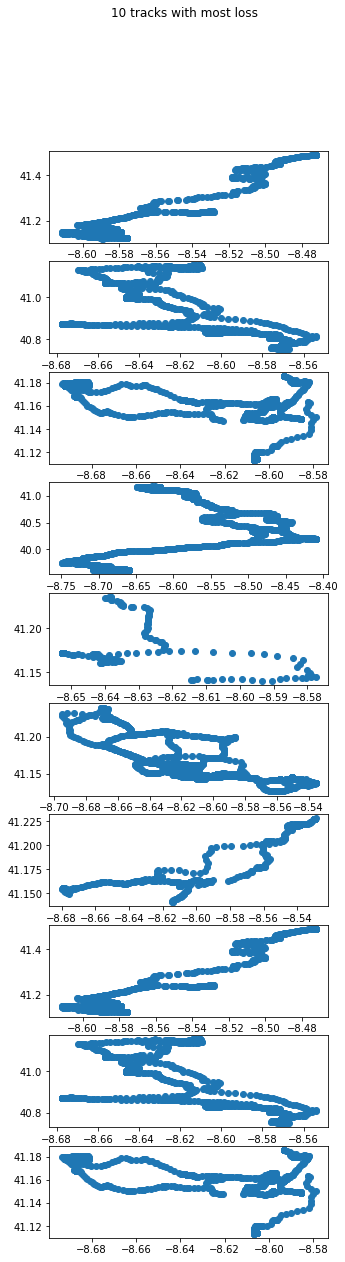

In [121]:
fig, axs = plt.subplots(10)
fig.suptitle('10 tracks with most loss')
fig.set_size_inches(5, 20)
for i in range(10):
    xs = [x[0] for x in coords[i]]
    ys = [x[1] for x in coords[i]]
    axs[i].scatter(xs, ys)